<a href="https://colab.research.google.com/github/Nov05/Google-Colaboratory/blob/master/20240218_pong_PPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **\<TOP>**  

* changed by nov05 on 2024-02-18  
* check [the code walkthrough video](https://youtu.be/XhfhR7Z01S0)  
* gym atari: https://di-engine-docs.readthedocs.io/en/latest/13_envs/atari.html  
* read the paper: https://paperswithcode.com/method/ppo   

👉 [the PPO without clipping notebook](https://drive.google.com/file/d/17-HyqTB121RjHvJ03GzY81eGxmmpjY3t)  

👉 [PPO full curriculum](https://www.evernote.com/shard/s139/sh/49b549b3-040e-6829-3800-85e830516134/sdITMf7KBEt6jP_X-hSjU2INJdgfpL8VBCtAS7DHs0C61DeCnJJRR_Yn2Q)  

<img src="https://github.com/Nov05/pictures/blob/master/Udacity/20231221_reinforcement%20learning/20240219_RL-PPO_pong.gif?raw=true" width=600>

In [ ]:
%%capture
!gdown --no-check-certificate --folder https://drive.google.com/drive/folders/1WmZIxLWj-snpWTmVUQ-SBQoGu-mtoTGi
!mv ./pong/* ./
!rm -r pong
# !pip install JSAnimation ## don't use this version
!git clone https://github.com/Nov05/JSAnimation.git ## my updated version
!pip install git+file:///content/JSAnimation
!rm -r ./JSAnimation
!pip install 'gym[atari]'
!pip install gym[accept-rom-license]
## Successfully installed AutoROM.accept-rom-license-0.6.1 autorom-0.4.2
!pip install progressbar
## Ctrl+M. restart the runtime now

# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

In [ ]:
import warnings
warnings.filterwarnings('ignore')
# custom utilies for displaying animation, collecting rollouts and more
import pong_utils
%matplotlib inline
# check which device is being used.
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

using device:  cpu


In [ ]:
import warnings
warnings.filterwarnings('ignore')
# render ai gym environment
import gym
import time
# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')
print("List of available actions: ", env.unwrapped.get_action_meanings())
# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel



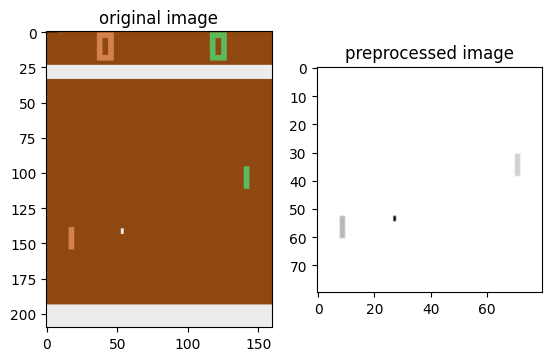

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib
import matplotlib.pyplot as plt
# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')
plt.subplot(1,2,2)
plt.title('preprocessed image')
# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()

# Policy

## Exercise 1: Implement your policy

Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

👉 You can copy the policy from [the Reinforce notebook](https://github.com/Nov05/Google-Colaboratory/blob/master/20240217_pong_REINFORCE.ipynb).  

👉 check [additional notes](https://www.evernote.com/shard/s139/u/0/sh/1656c5f9-274c-4aea-94b5-219a834b9950/1yF4UjYLOqEkfy75Elb4ntP7cYyI_dwSdOWuJ-MjT57cB2YstMOx6qJ2VA)  


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)

class Policy(nn.Module):

    def __init__(self, input_dim=(2,80,80), n_actions=1, *args, **kwargs):
        super(Policy, self).__init__()
    ########
    ## Modify your neural network
    ########
        ## 80x80 to (outputsize x outputsize)
        ## outputsize = (inputsize - kernel_size + stride)/stride
        ## (round up if not an integer)
        self.conv = nn.Sequential(
            ## 2x80x80=12800 to 4x38x38=5776; 2 channels from the stacked frame
            nn.Conv2d(2, 4, kernel_size=6, stride=2, bias=False),
            nn.ReLU(),
            ## 4x38x38 to 16x9x9=1296
            nn.Conv2d(4, 16, kernel_size=6, stride=4),
            nn.ReLU(),
        )
        conv_out_size = self.get_conv_out_size(input_dim) ## 16*9*9
        ## or self.fc = nn.LazyLinear()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, n_actions),
            nn.Sigmoid(),
        )

    def forward(self, x):
    ########
    ## Modify your neural network
    ########
        x = self.conv(x)
        x = self.fc(x)
        return x

    def get_conv_out_size(self, input_dim):
        return np.prod(self.conv(torch.zeros(*input_dim)).data.shape)

policy=Policy().to(device) ## use your own policy!
# policy=pong_utils.Policy().to(device) ## use the solution policy

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

# **Game visualization - untrained**  
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress


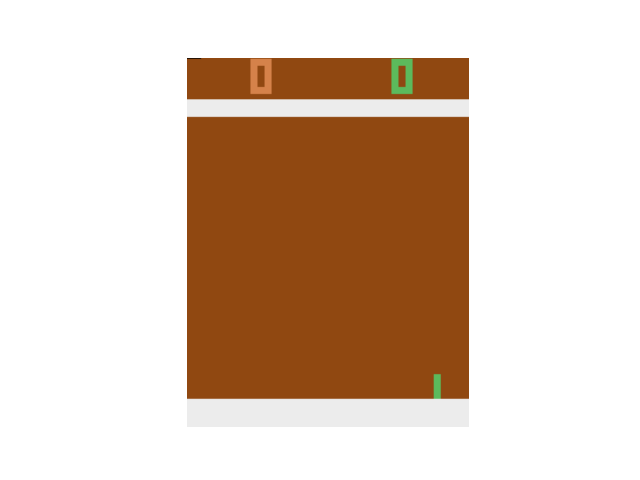
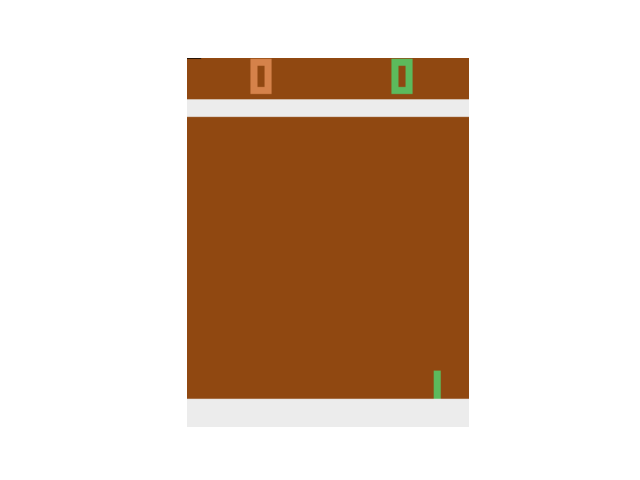
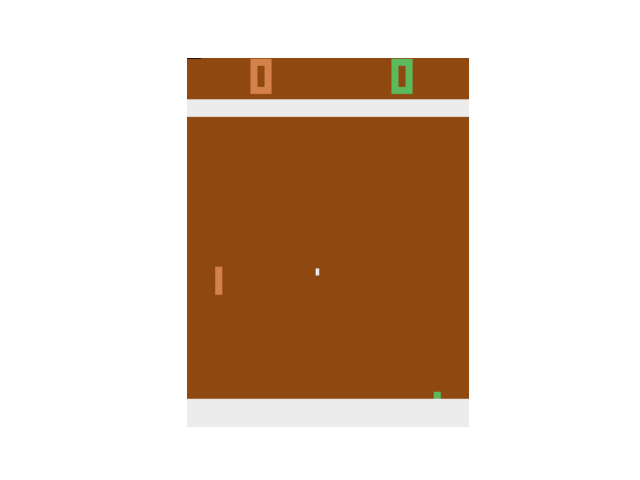
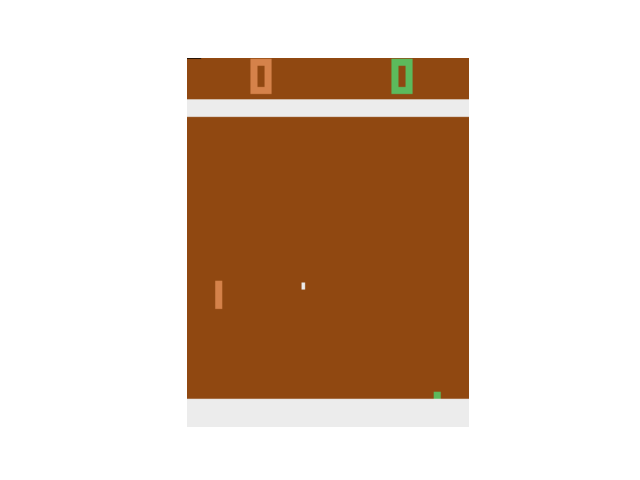
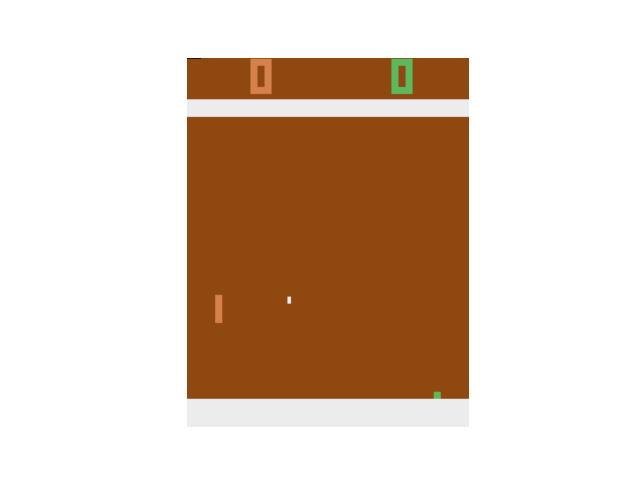
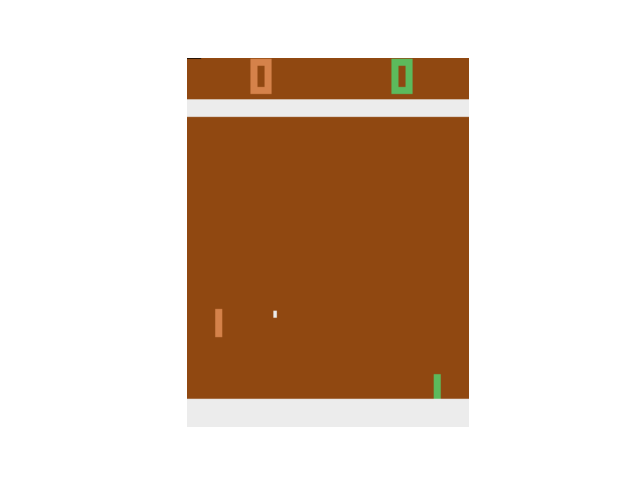
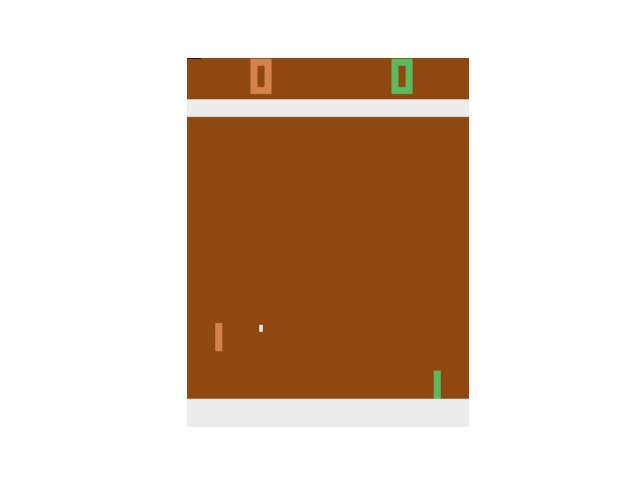
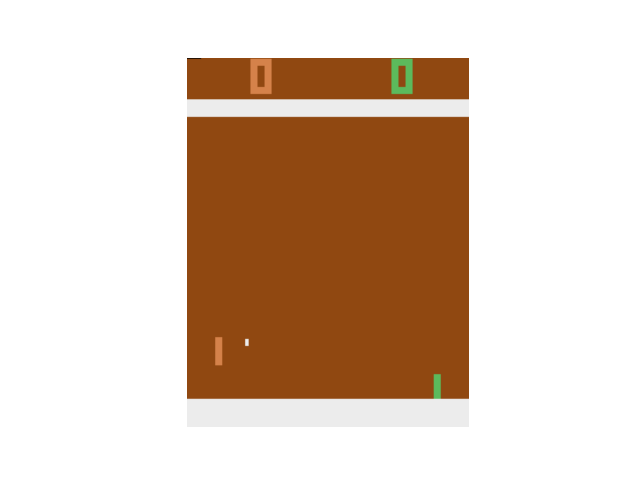
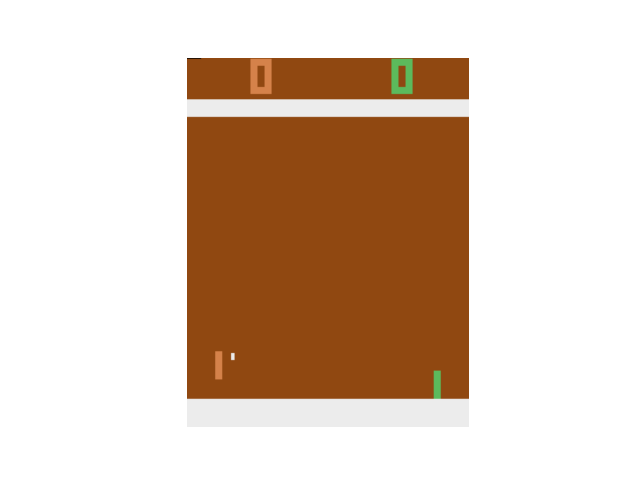
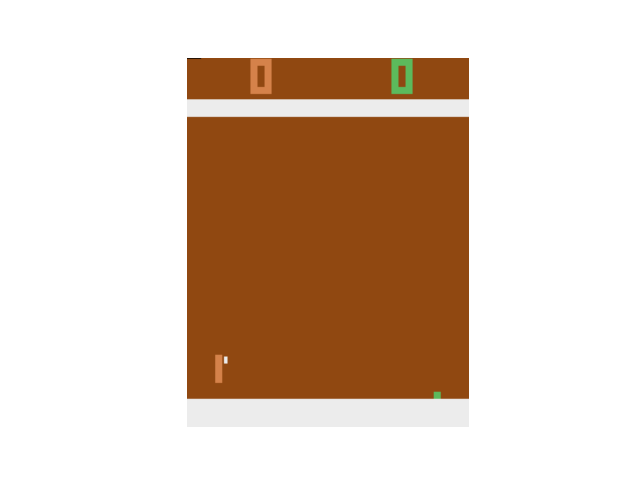
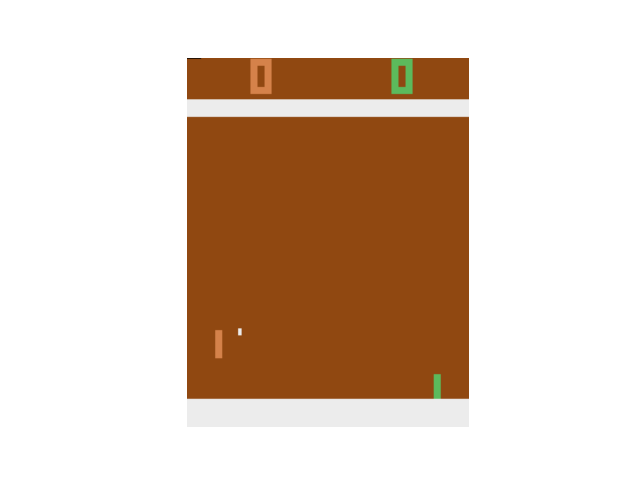
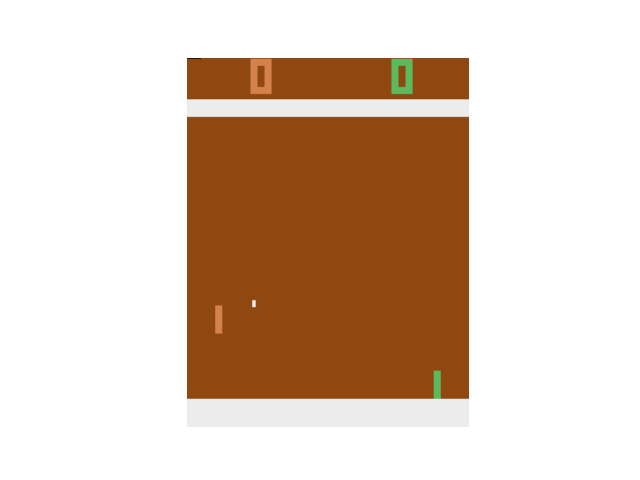
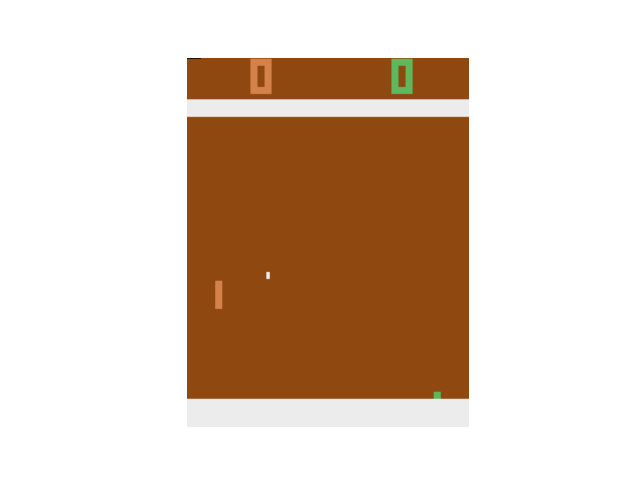
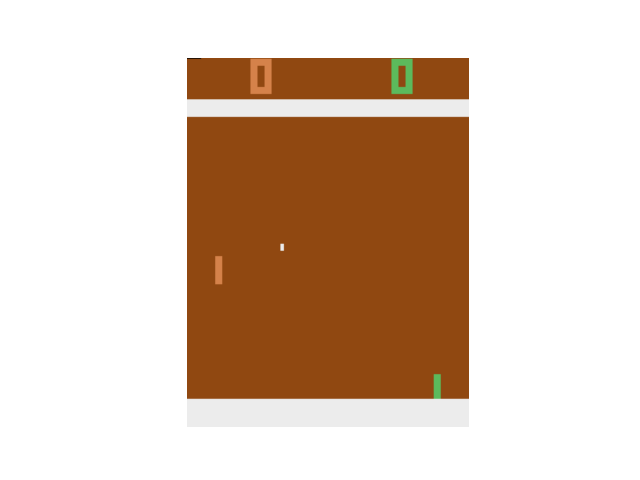
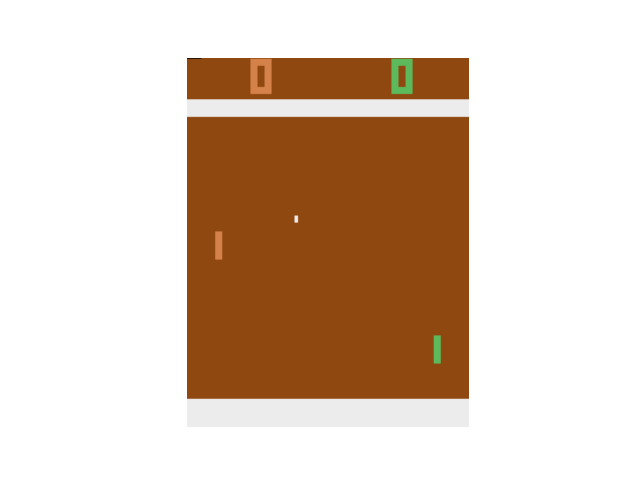
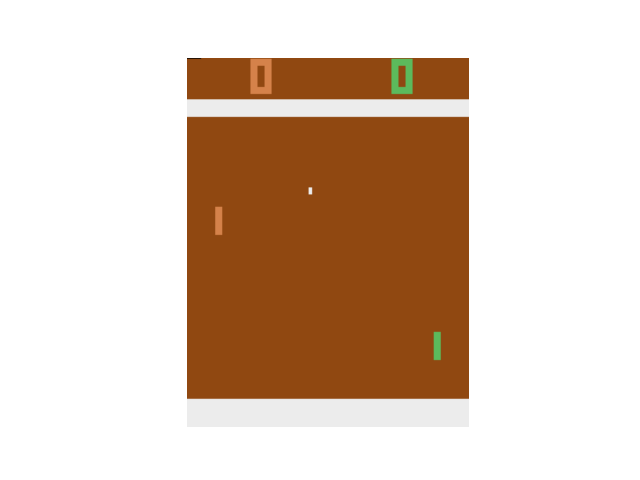
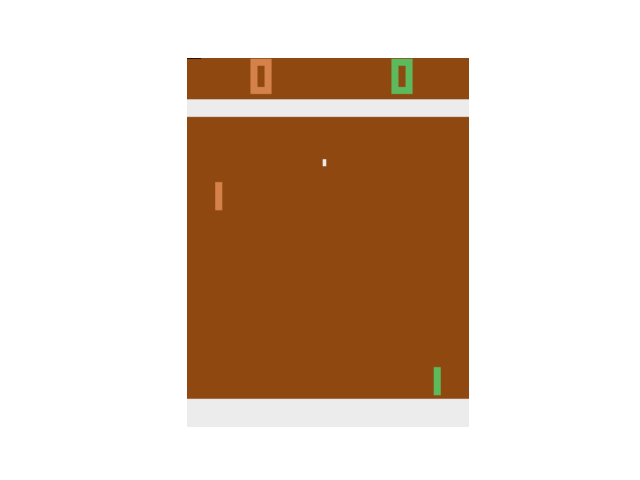
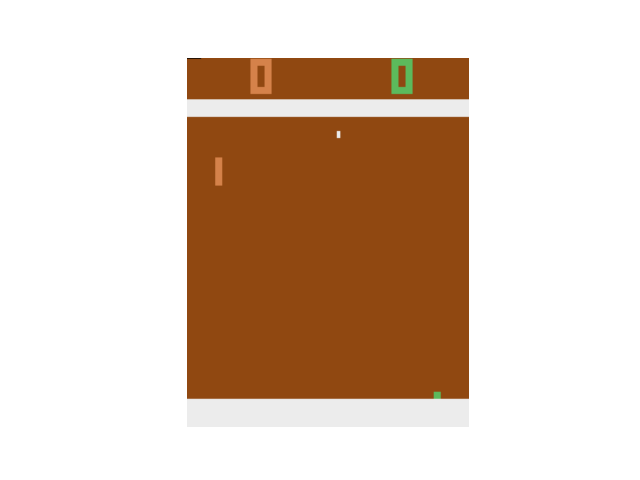
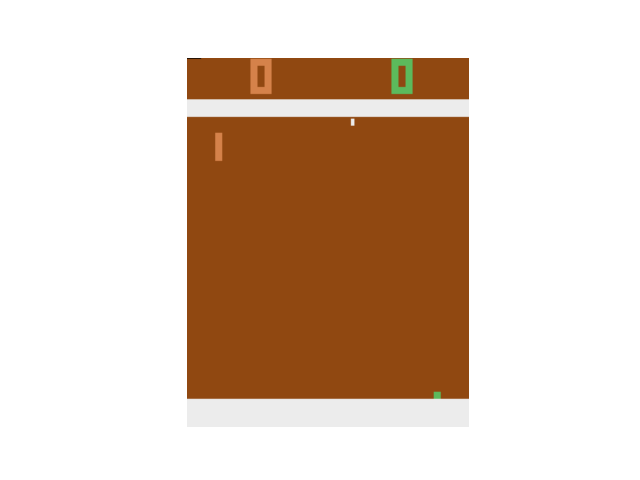
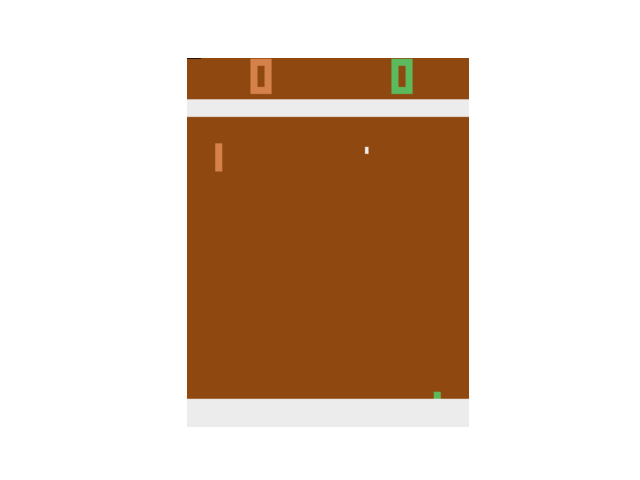
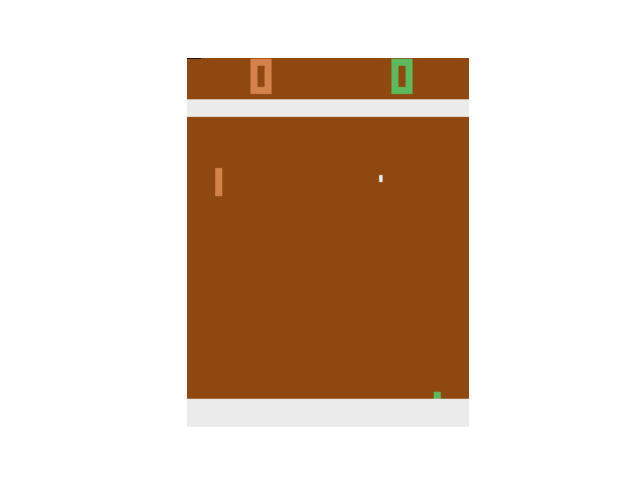
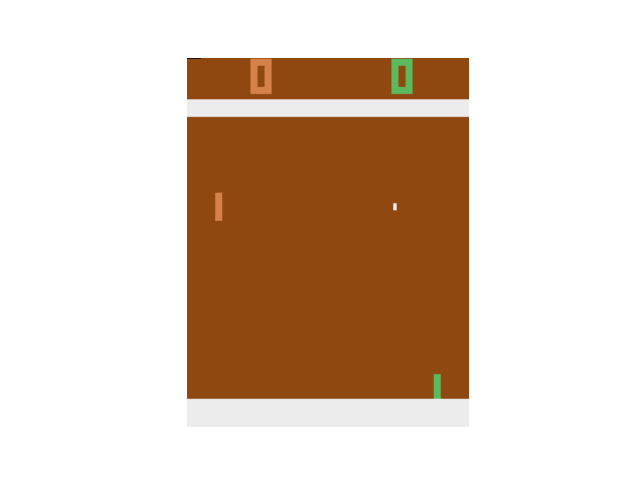
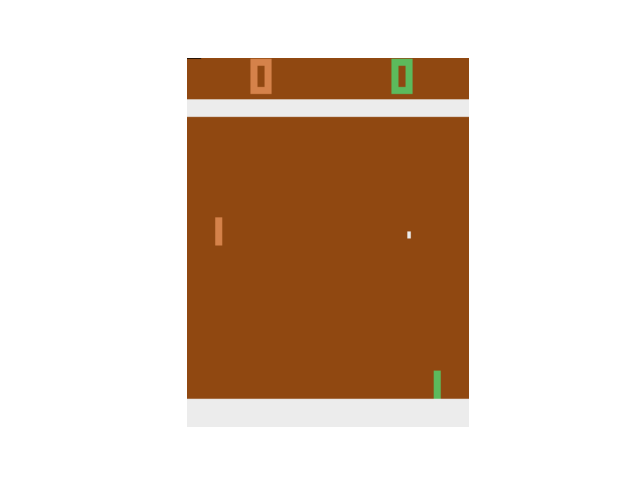
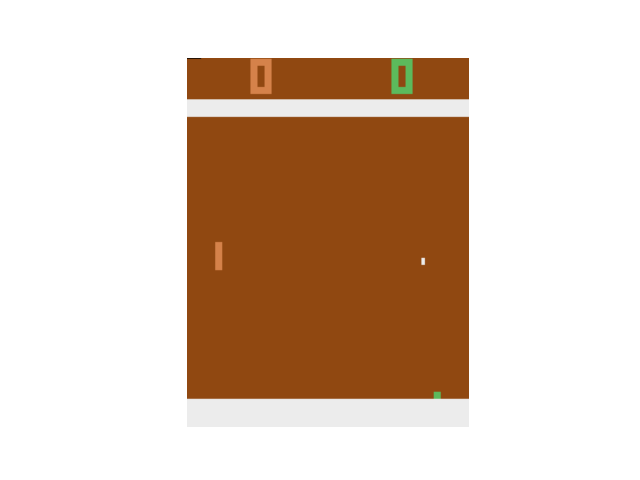
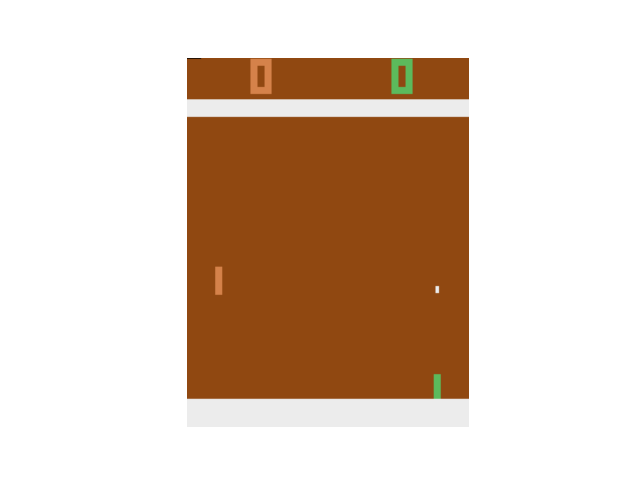
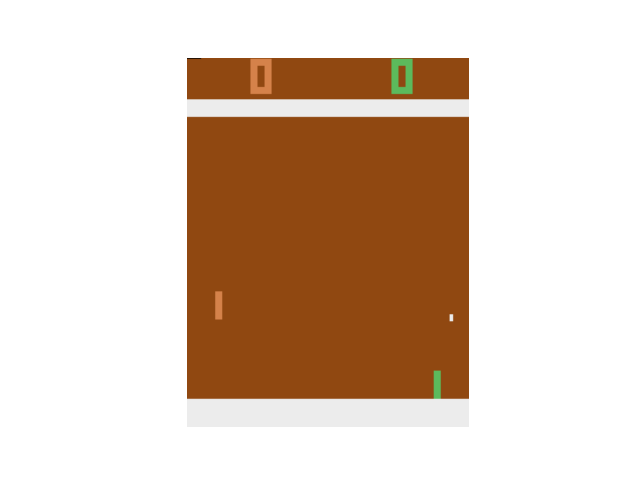
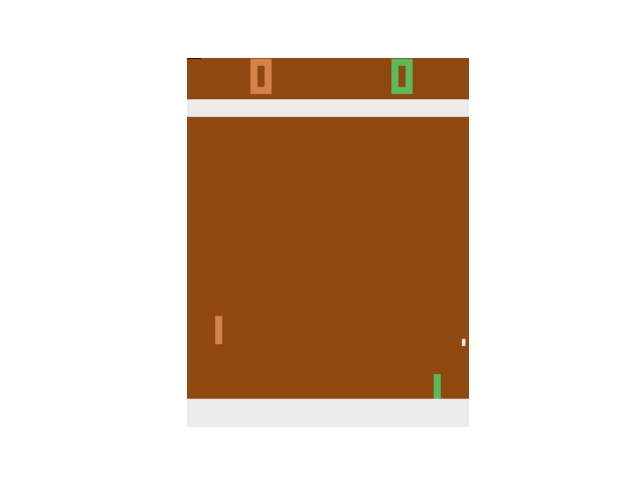
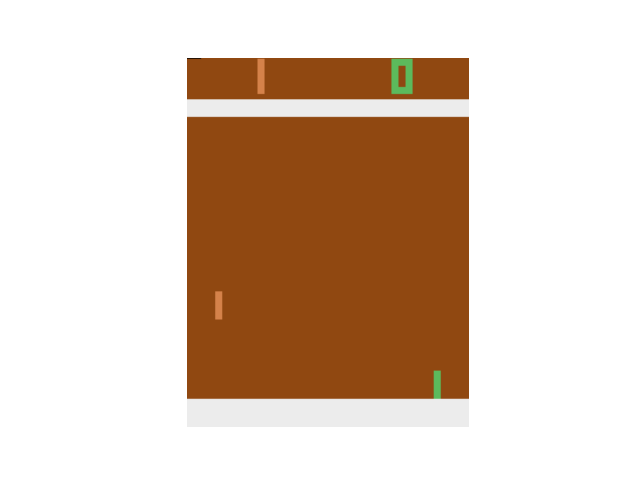
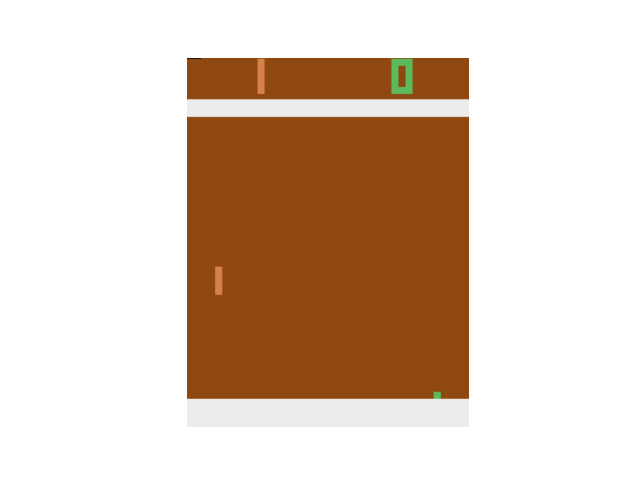
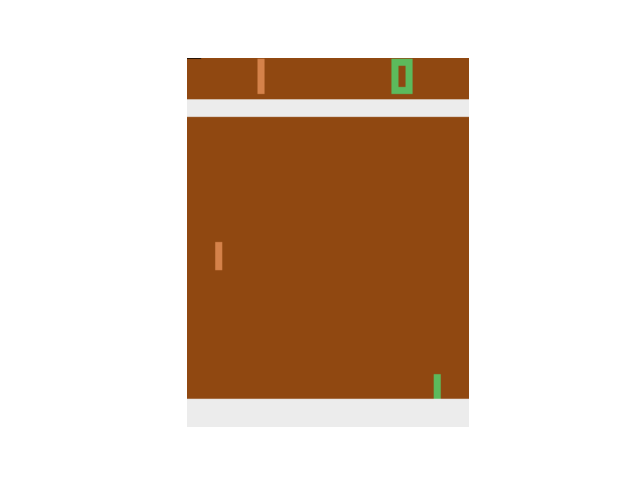
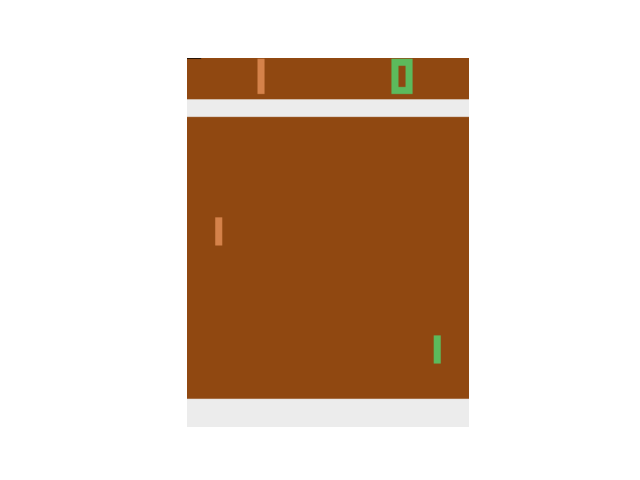
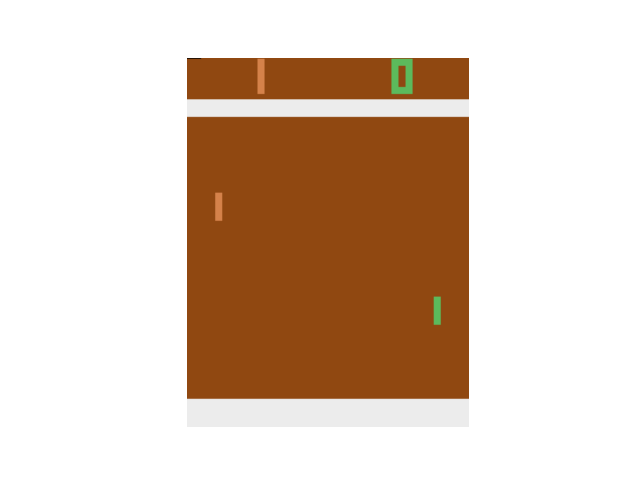
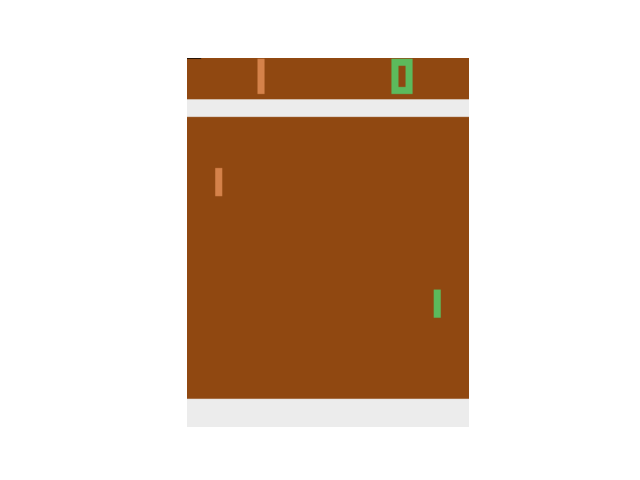
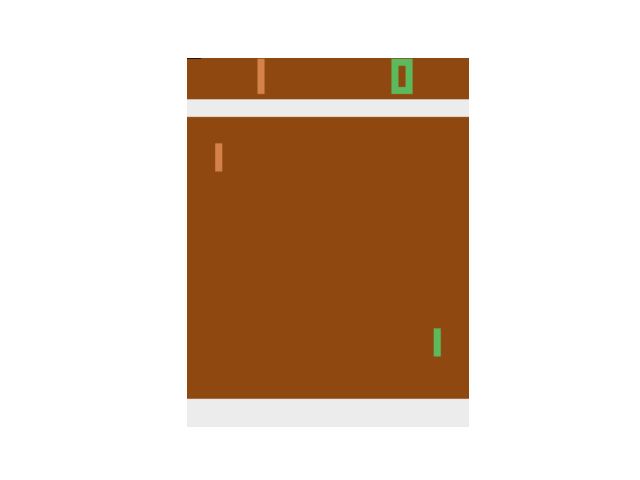
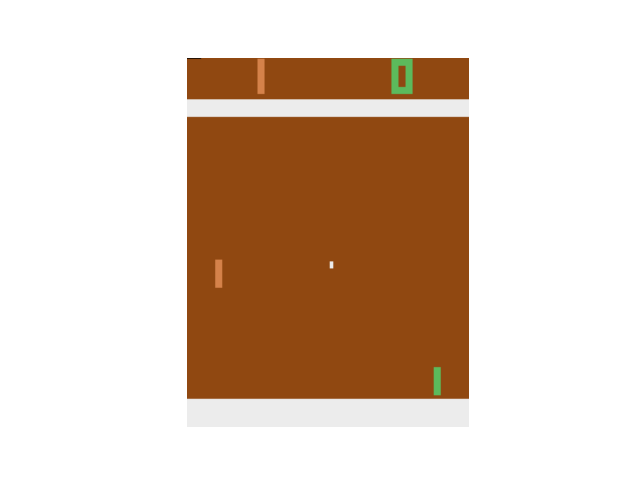
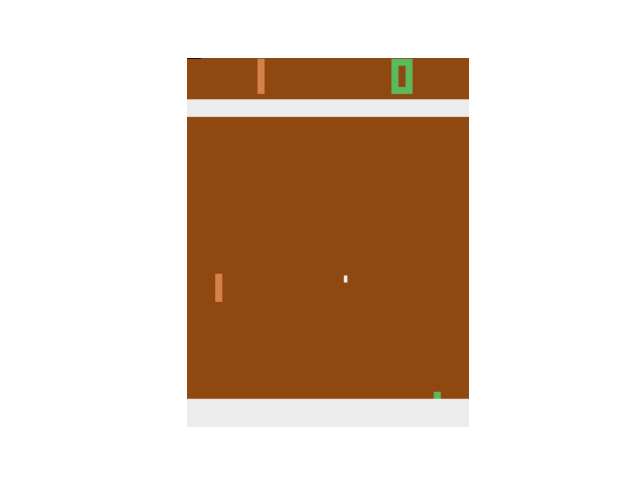
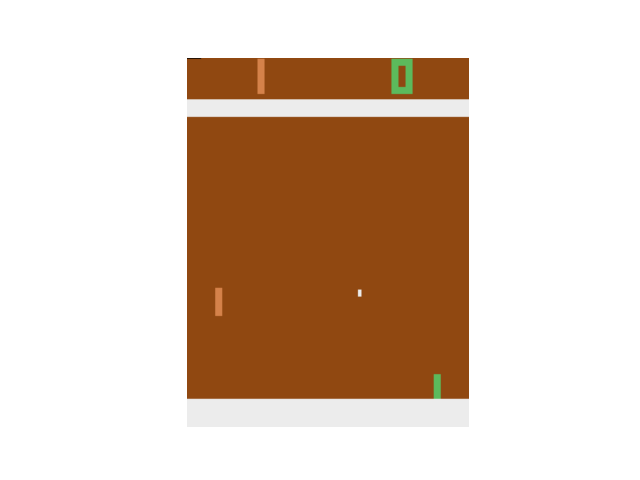
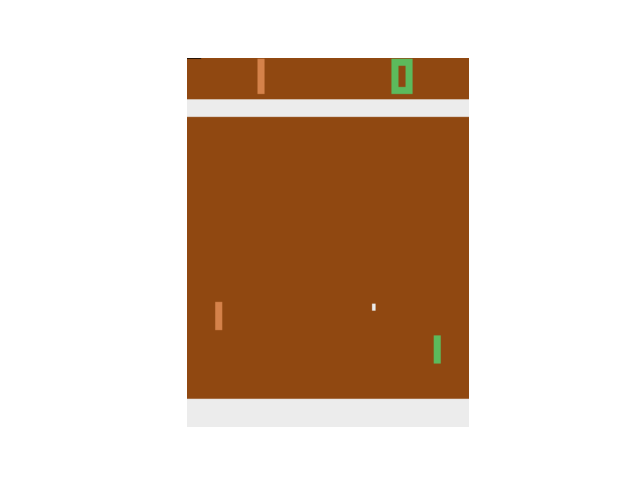
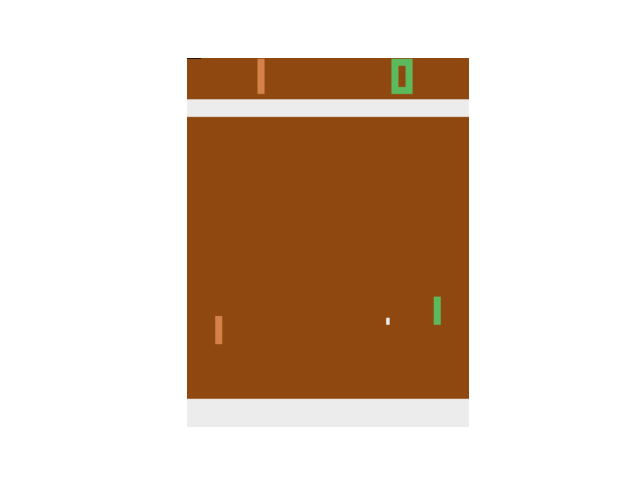
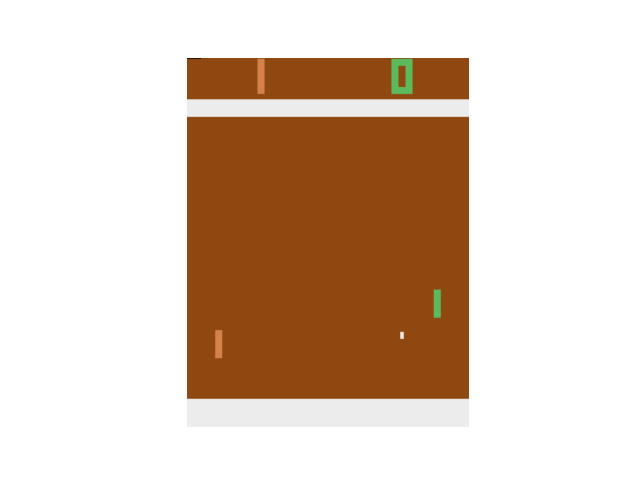
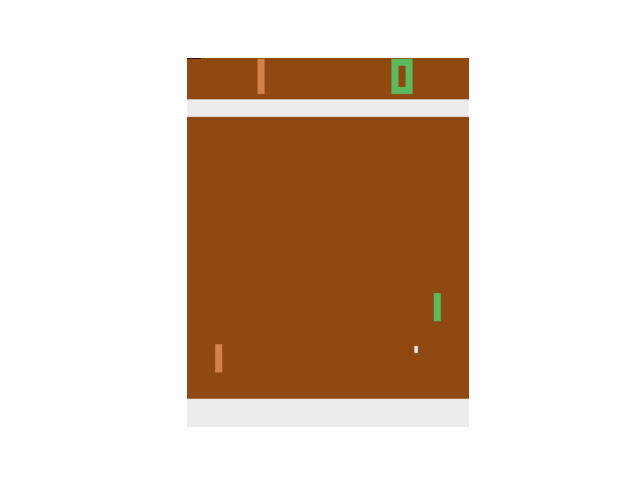
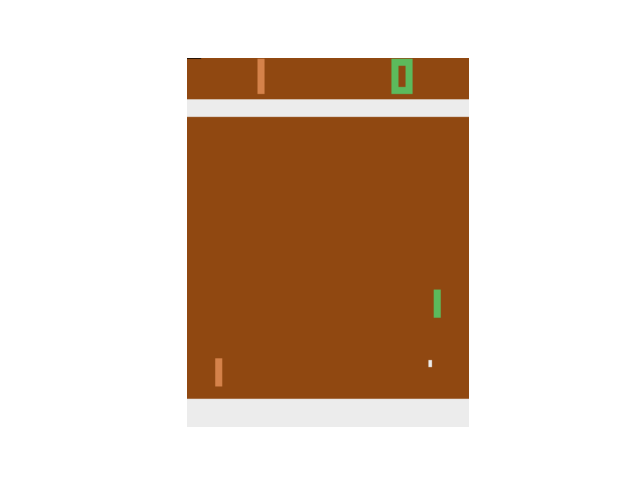
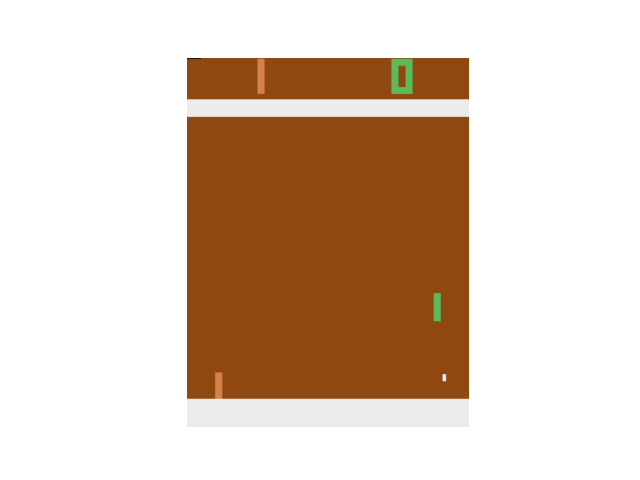
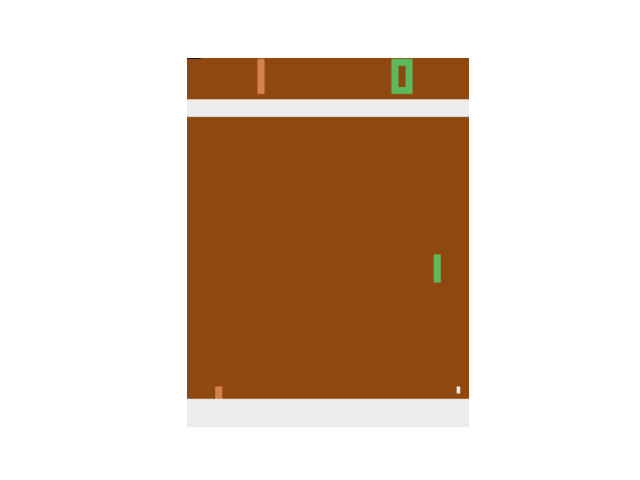
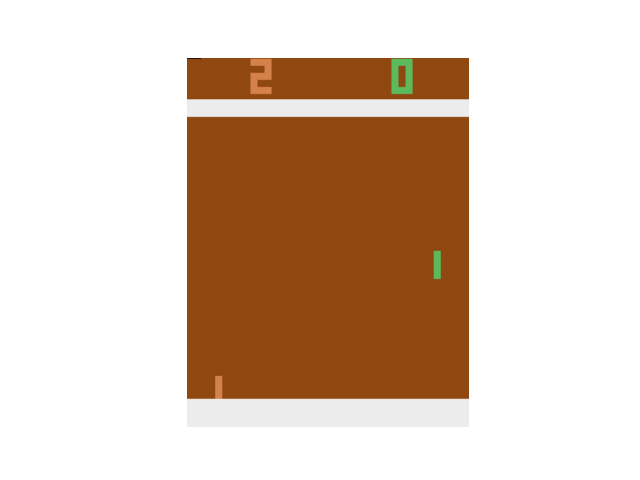
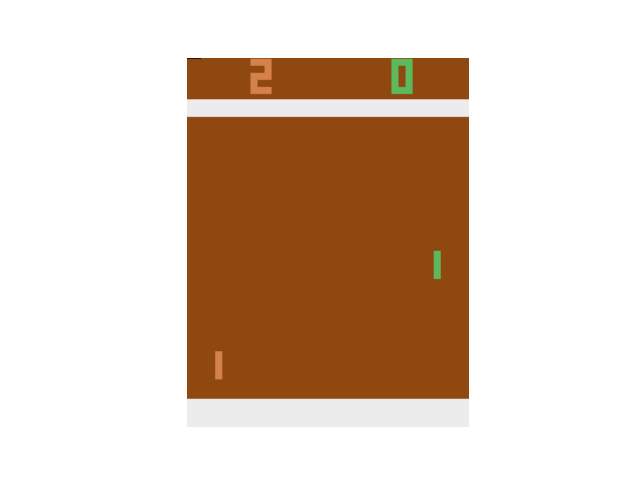
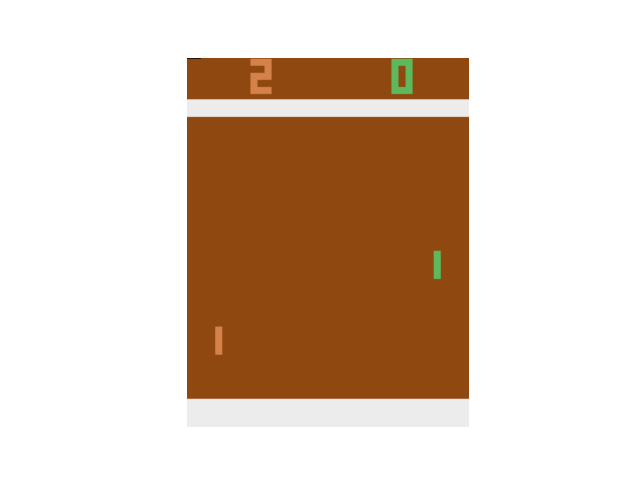
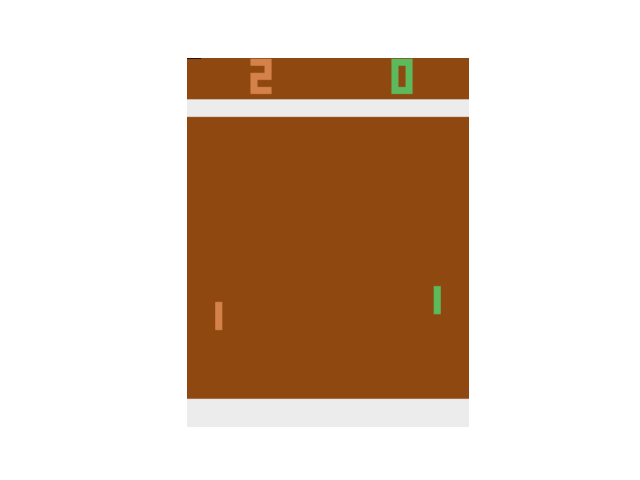
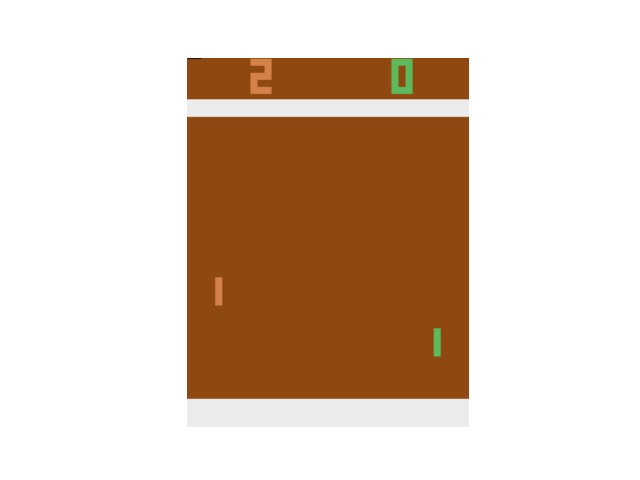
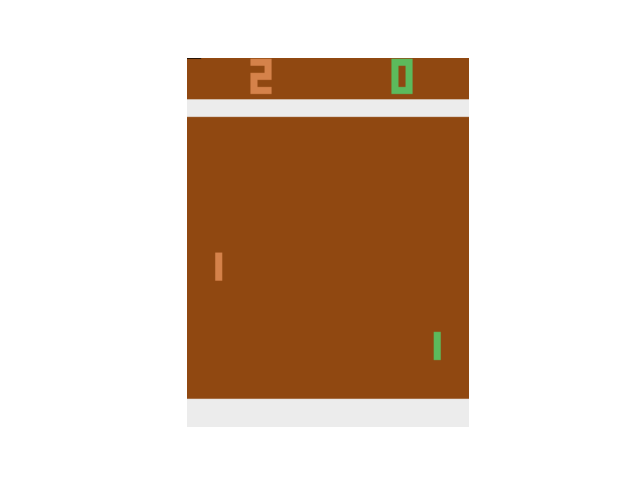
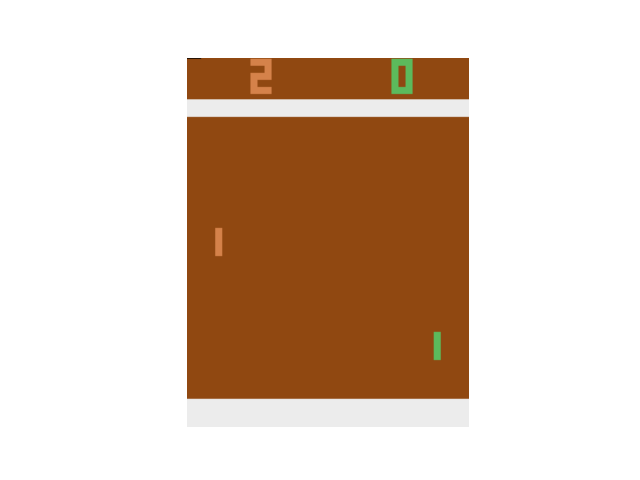
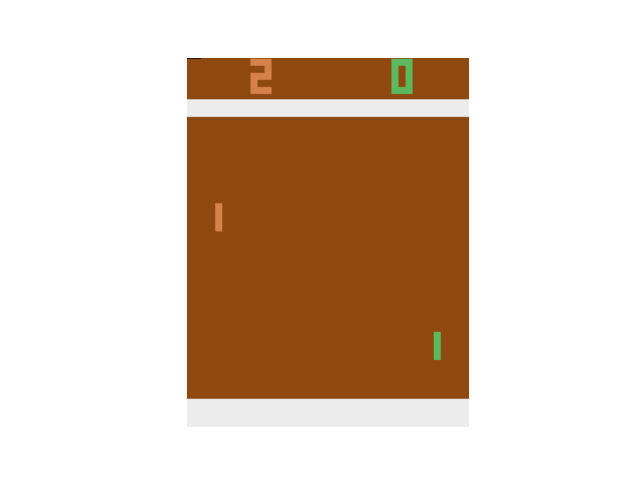
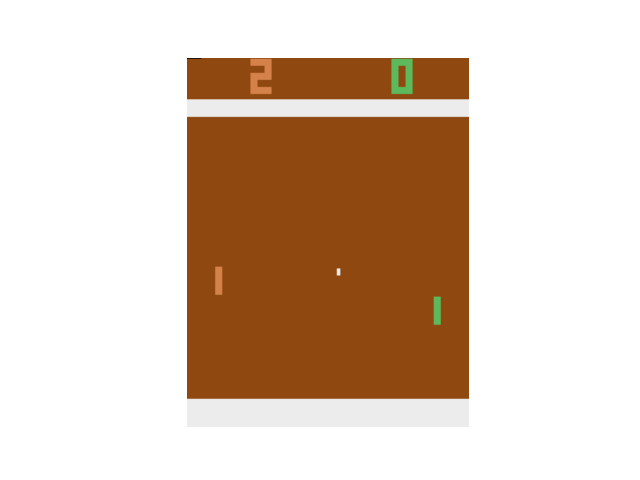
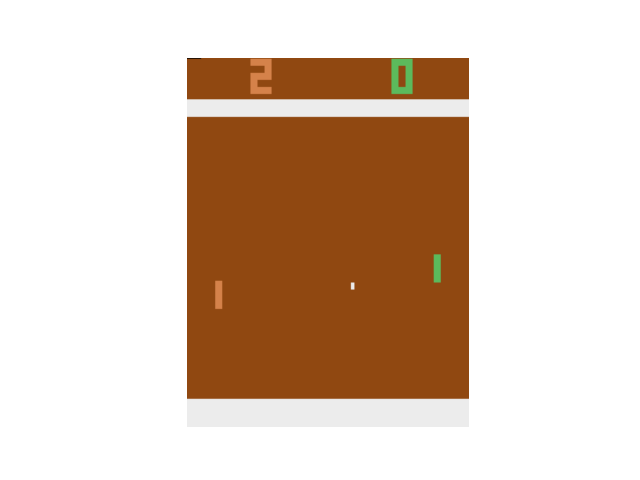
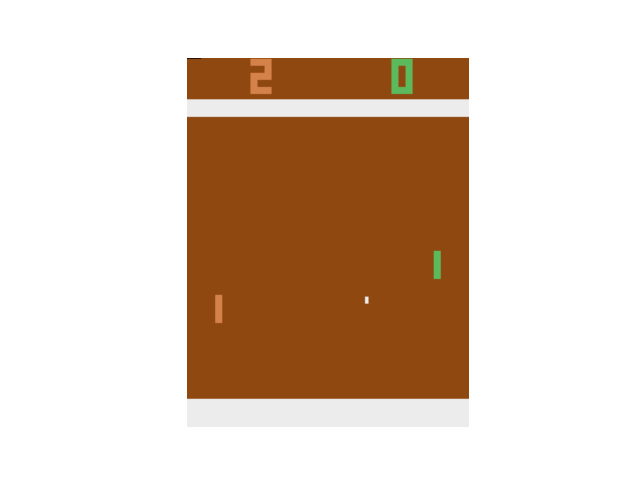
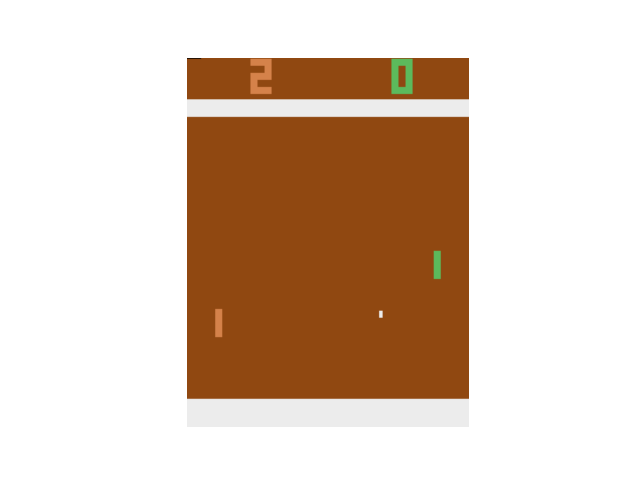
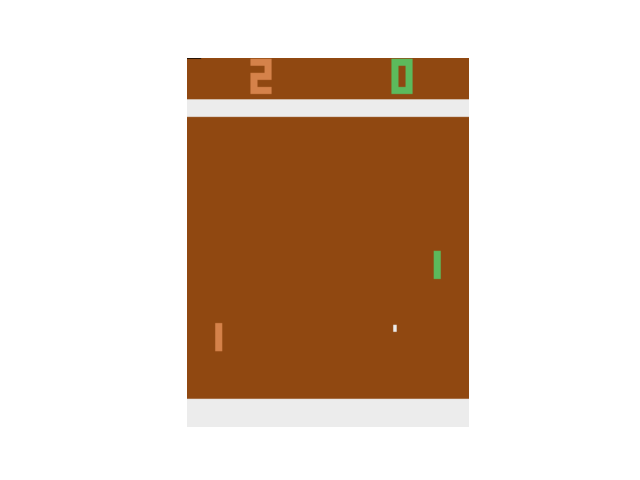
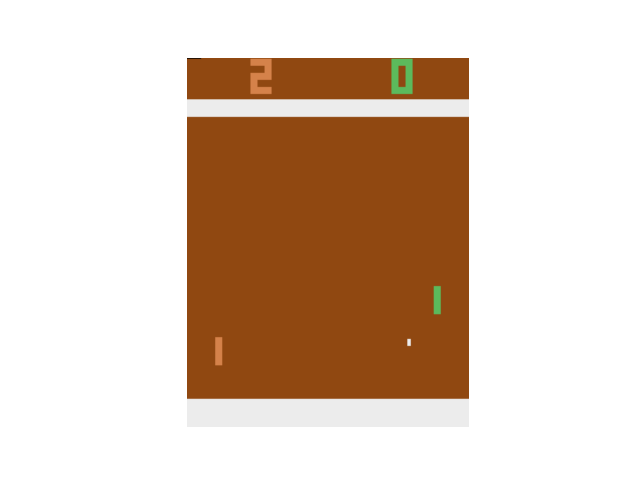
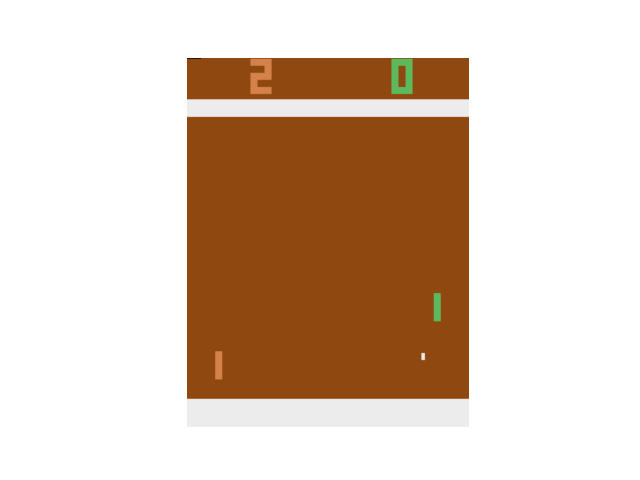
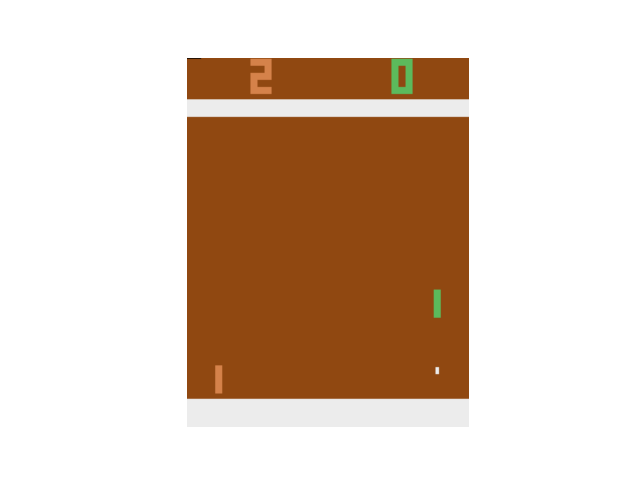
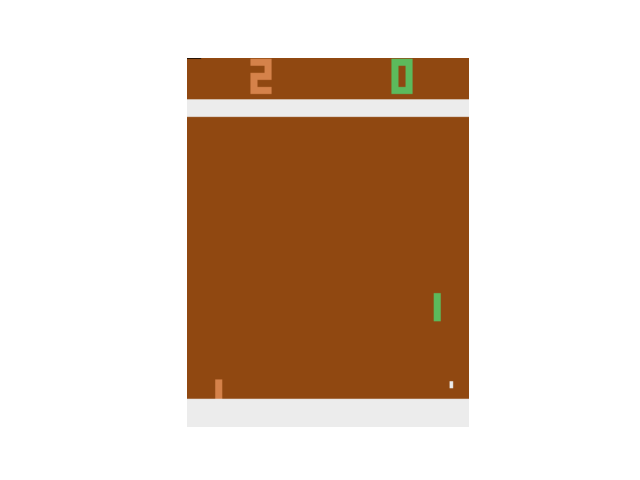
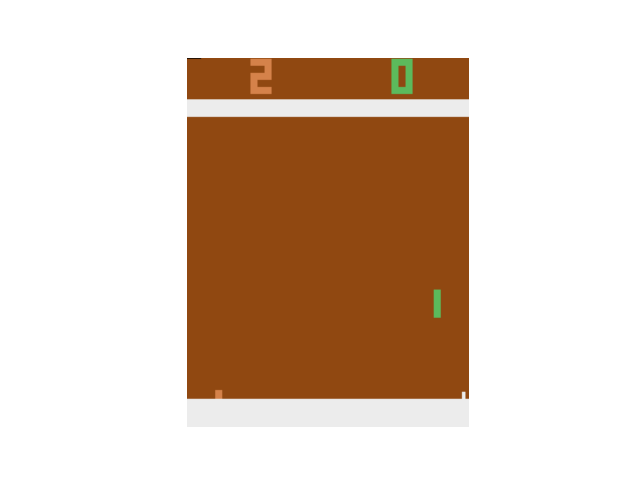
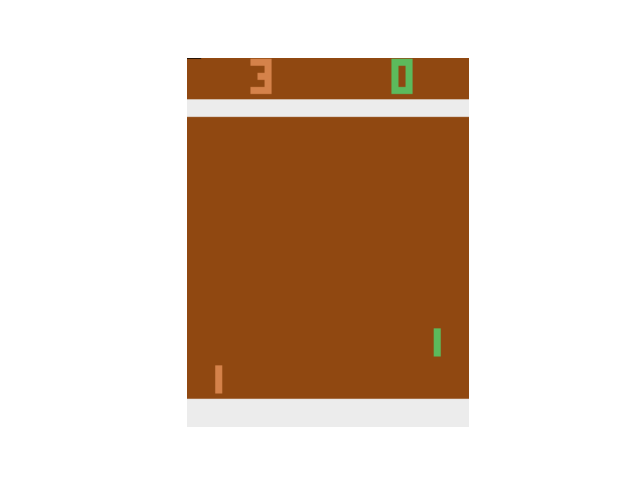
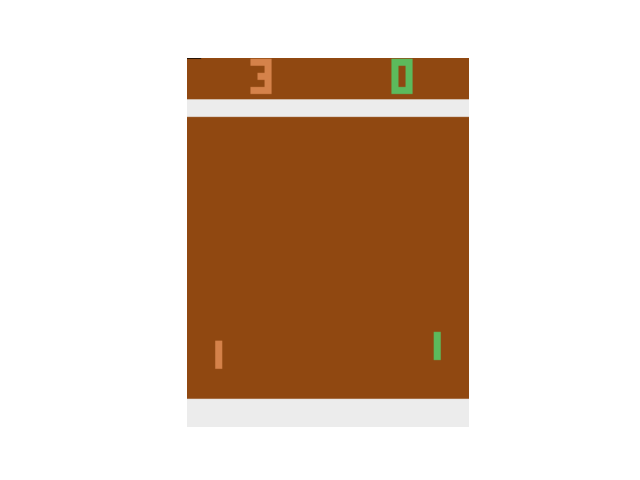
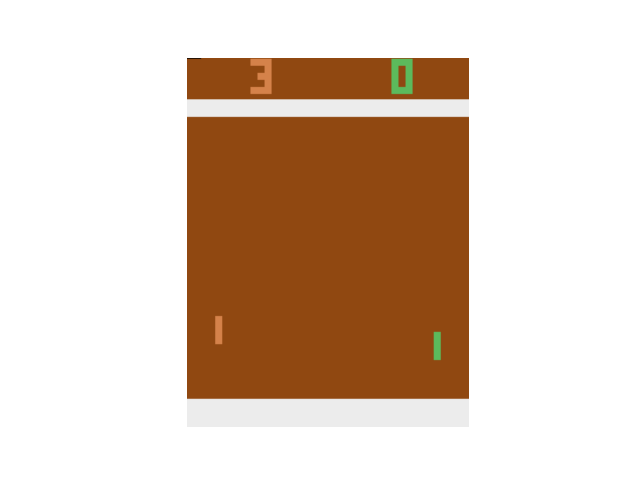
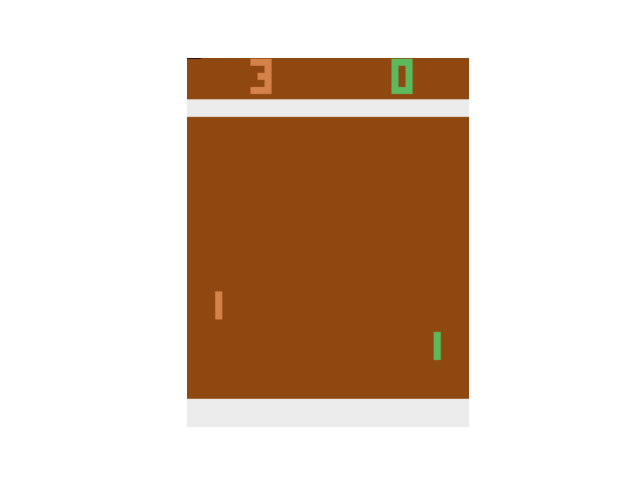
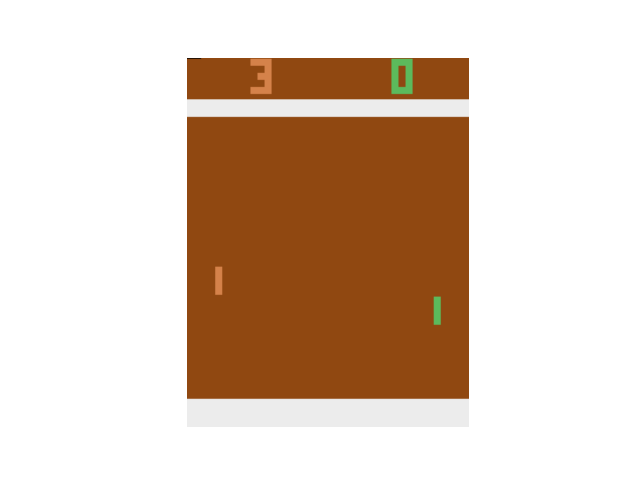
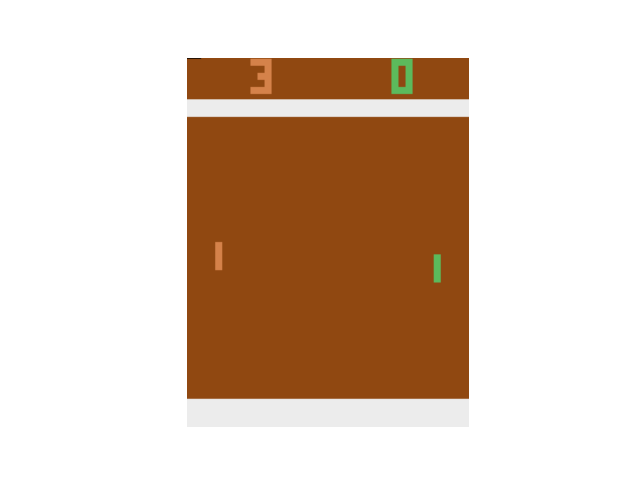
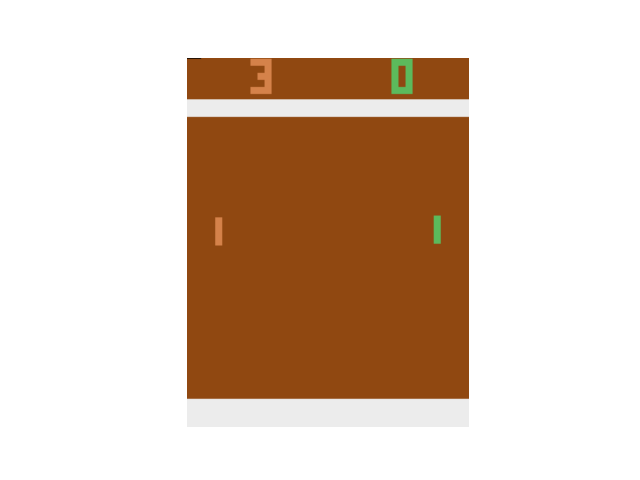
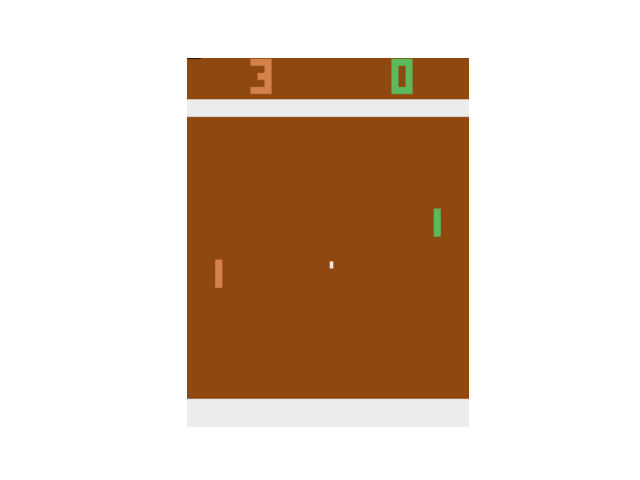
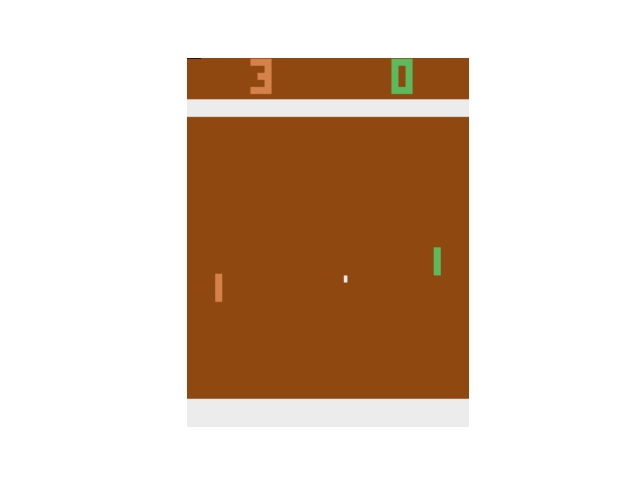
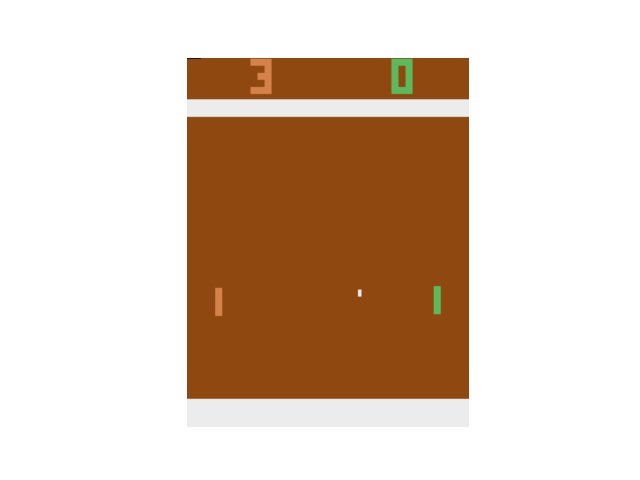
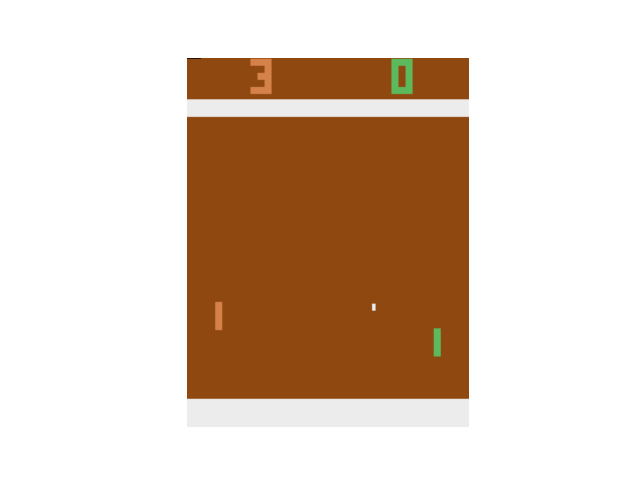
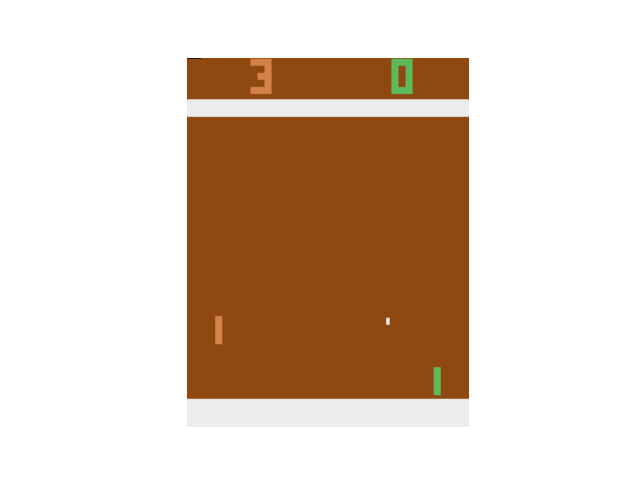
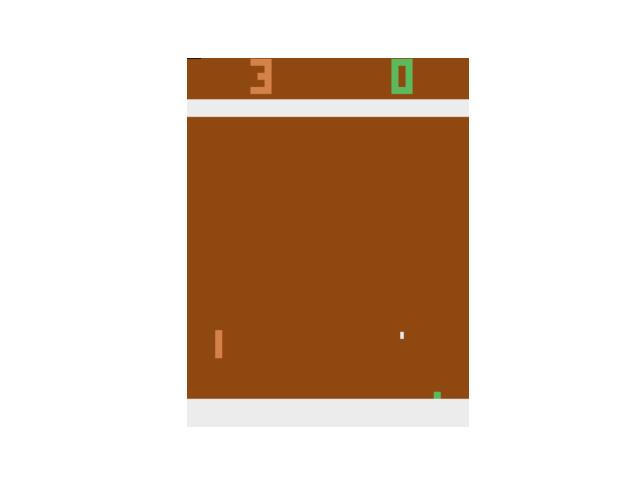
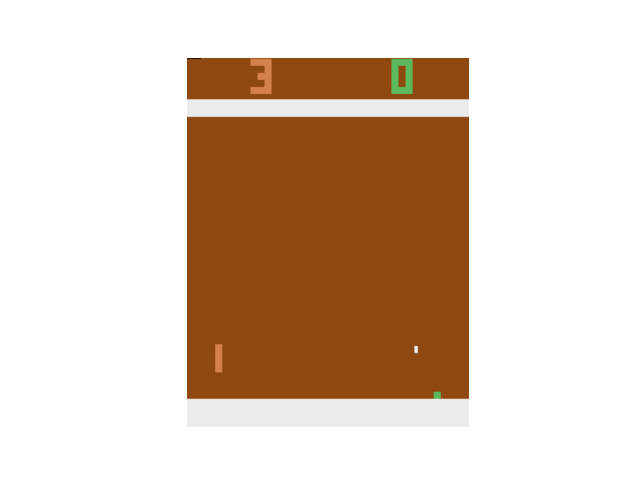
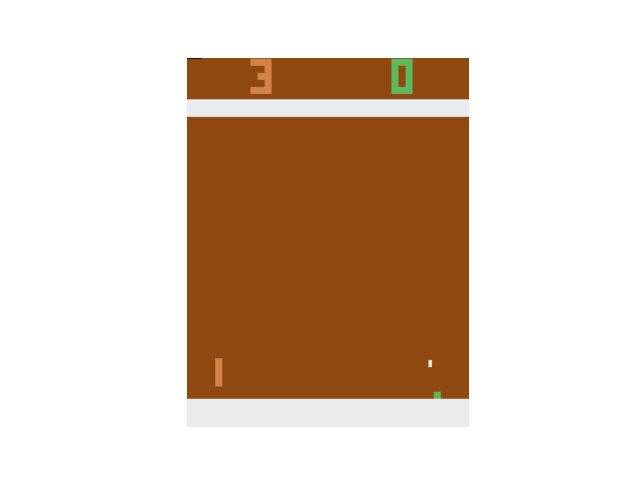
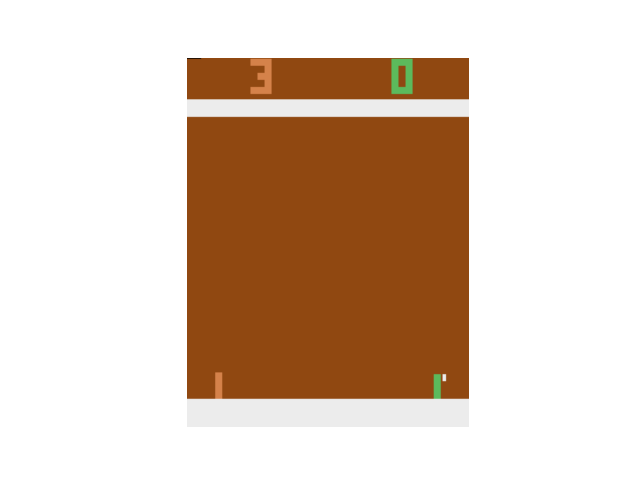
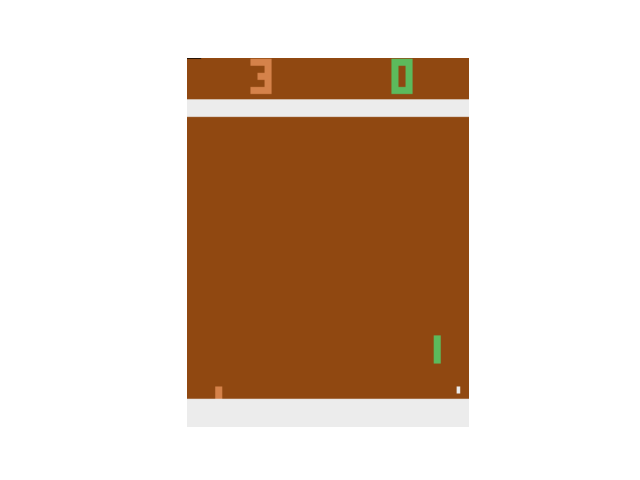
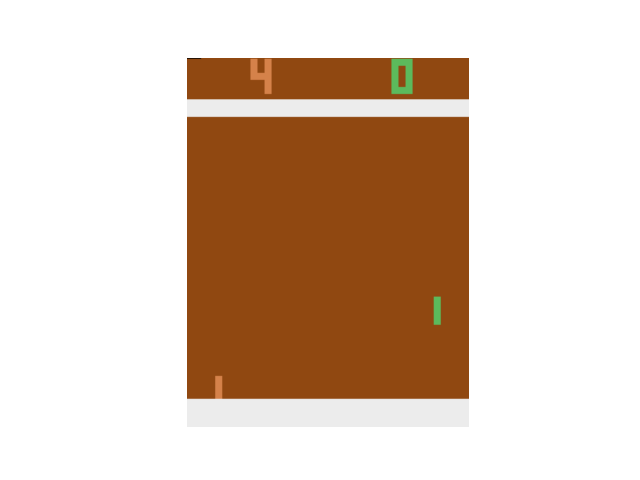
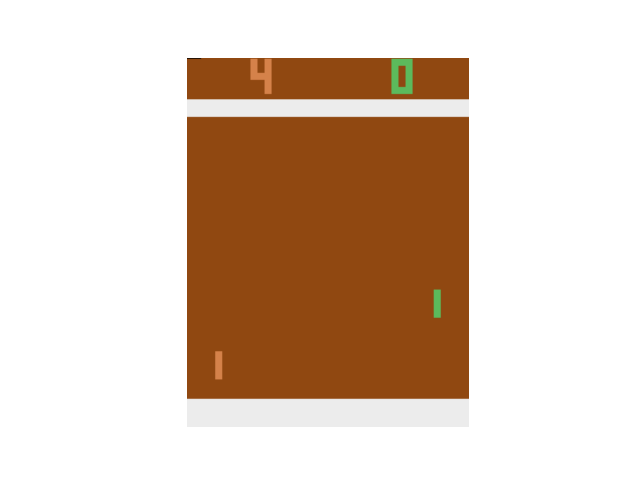
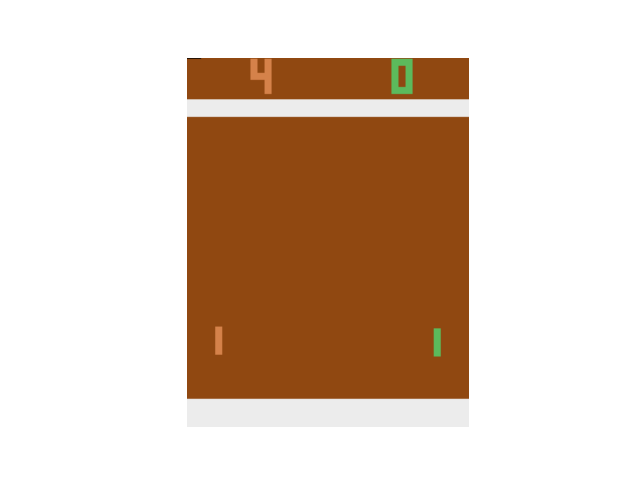
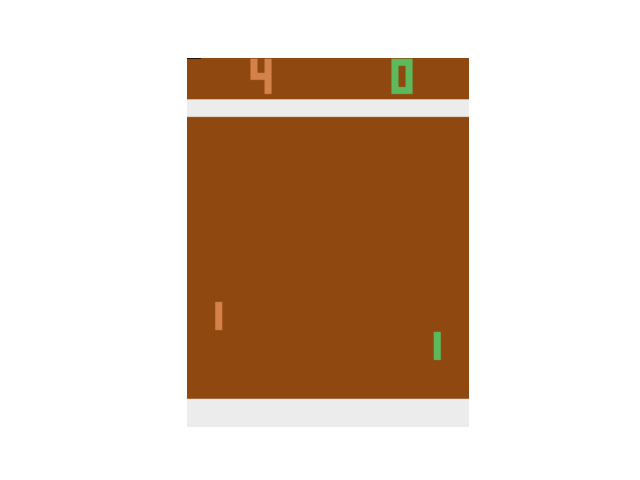
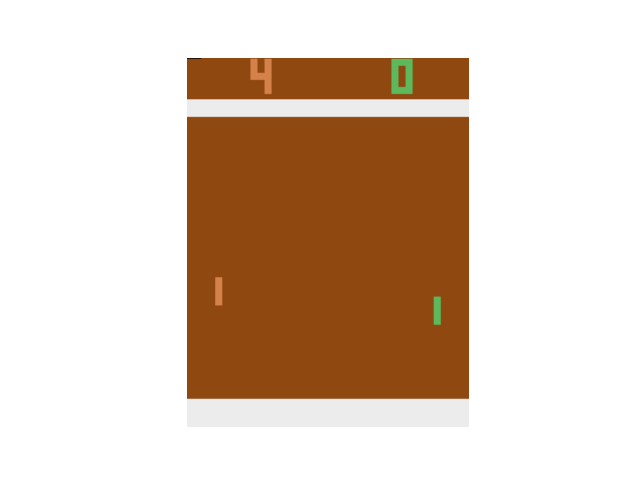
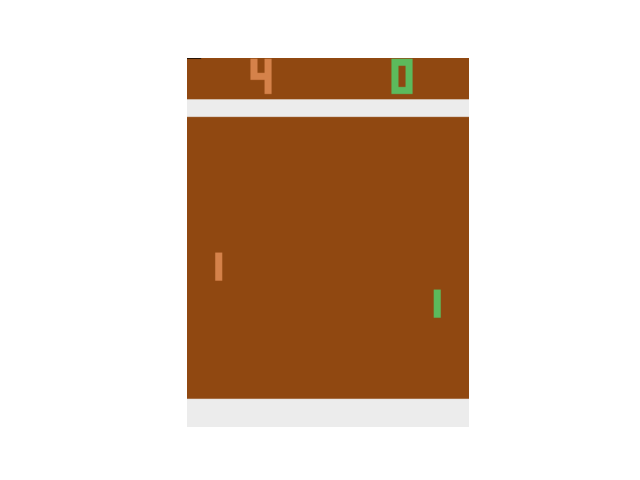
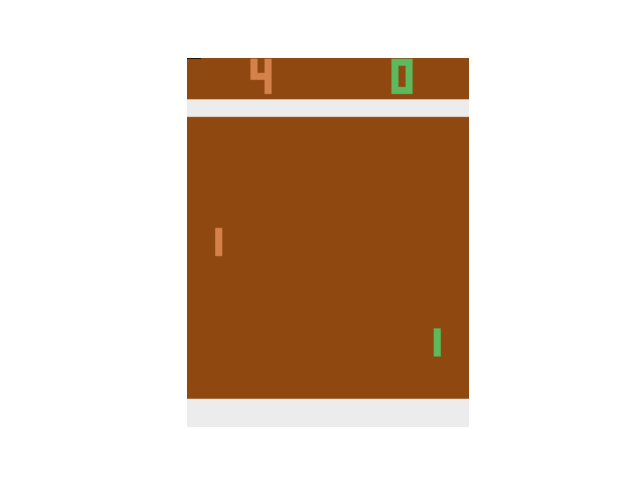
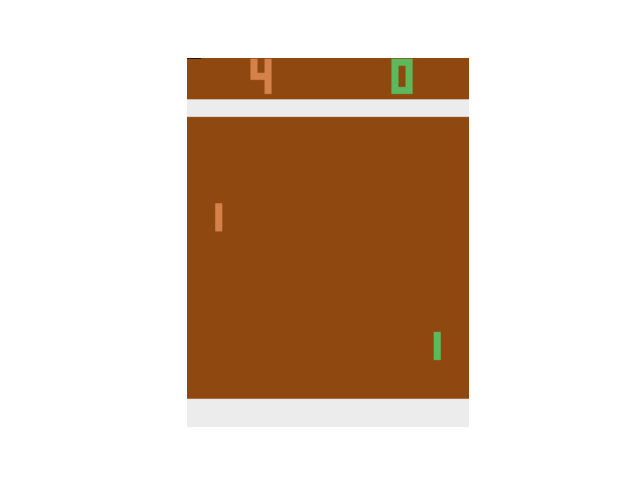
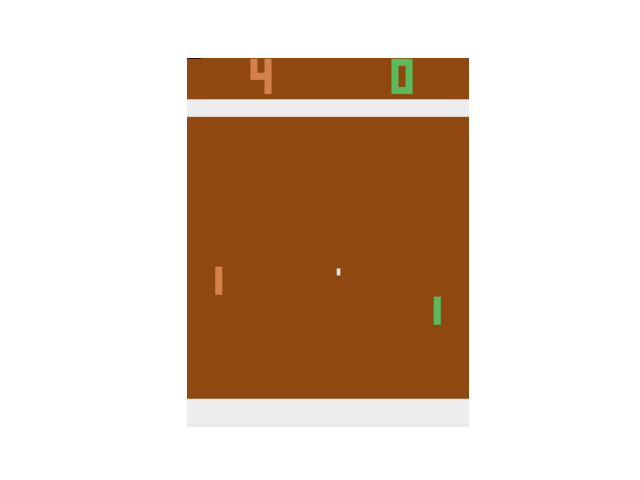
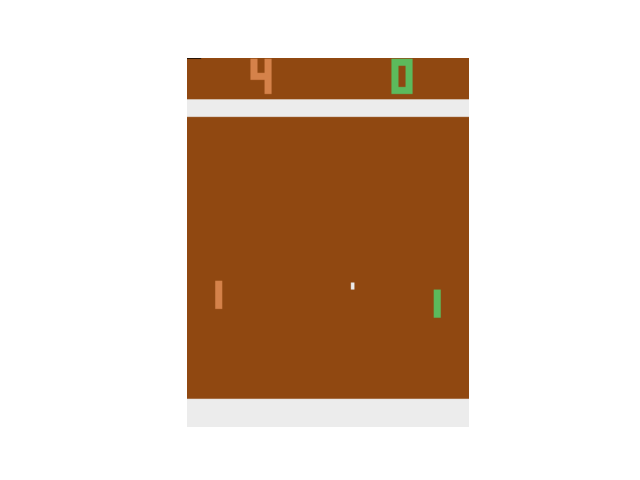
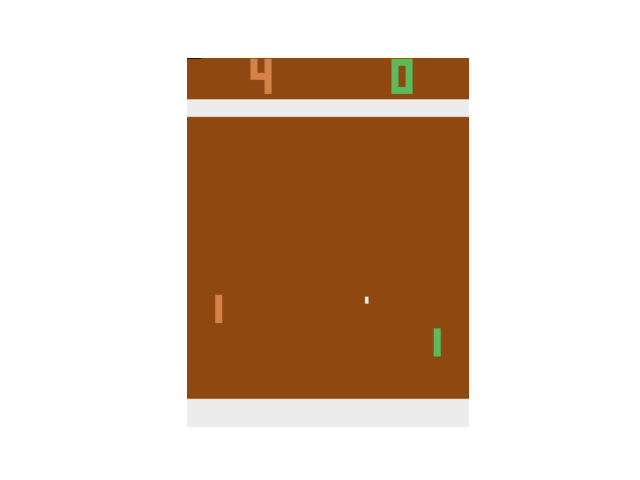
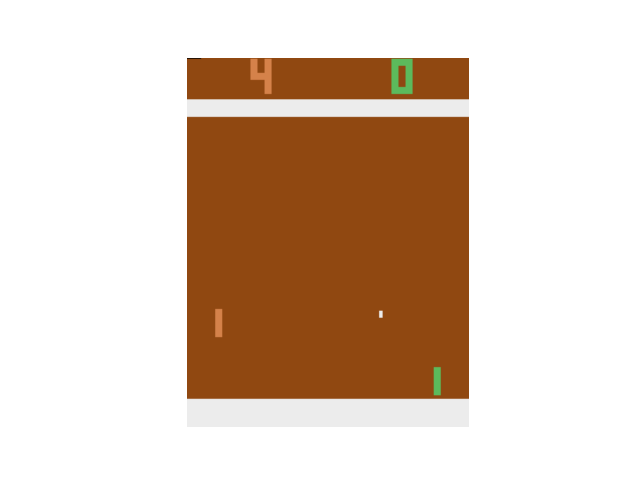
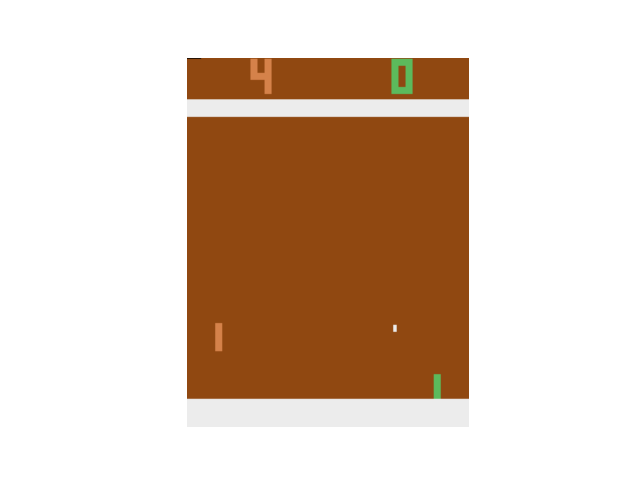
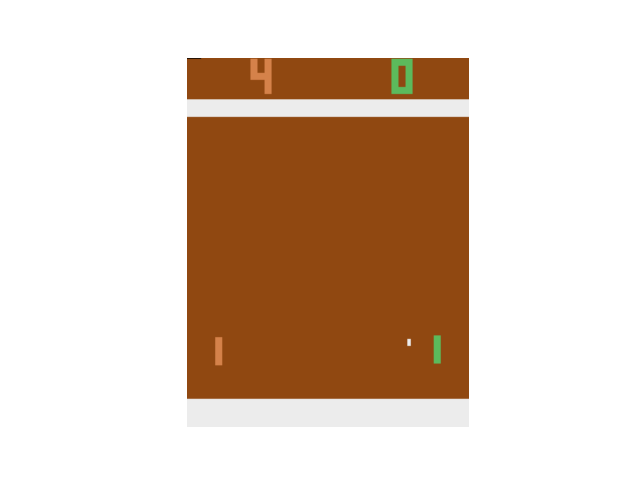
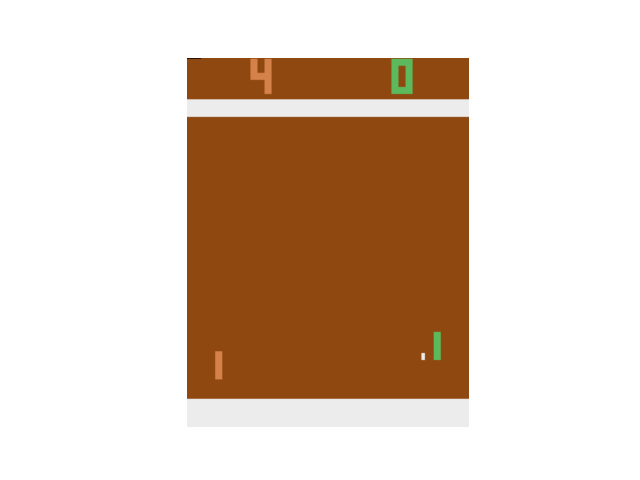
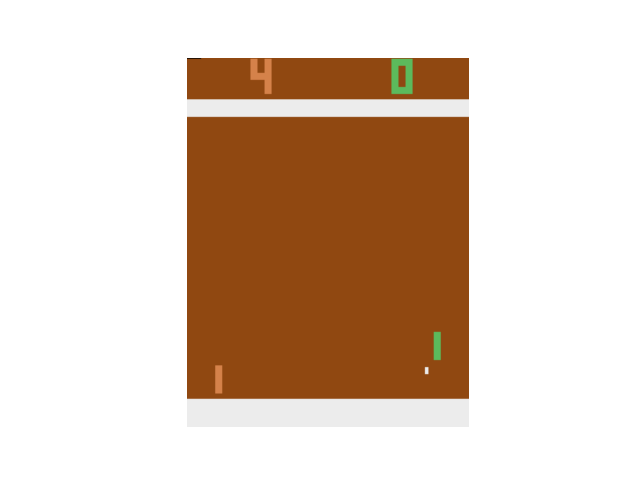
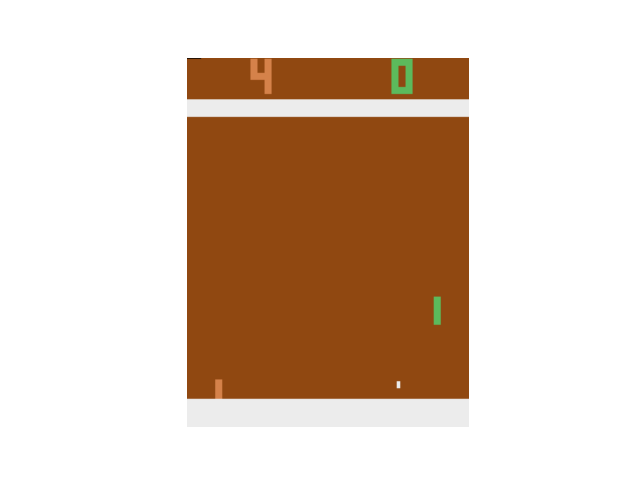
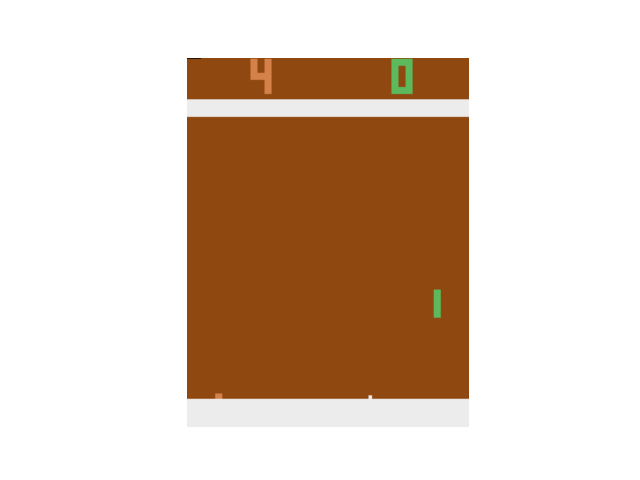
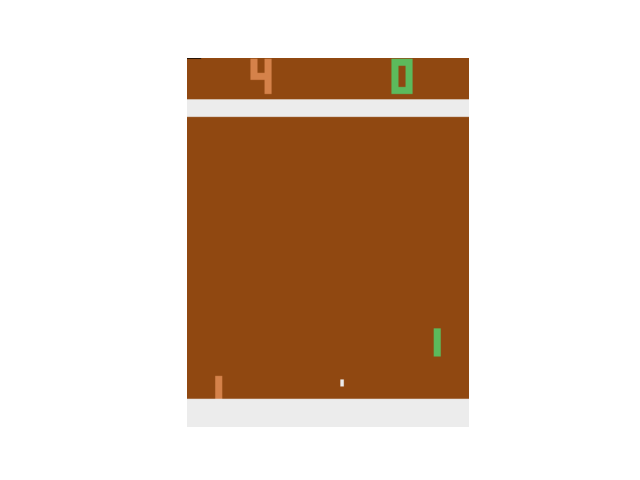
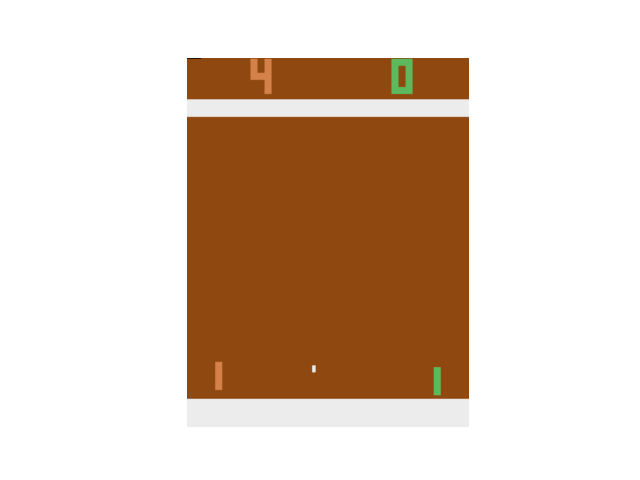
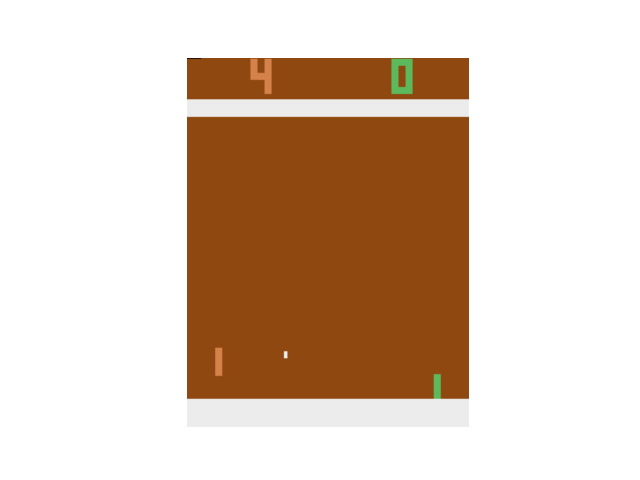
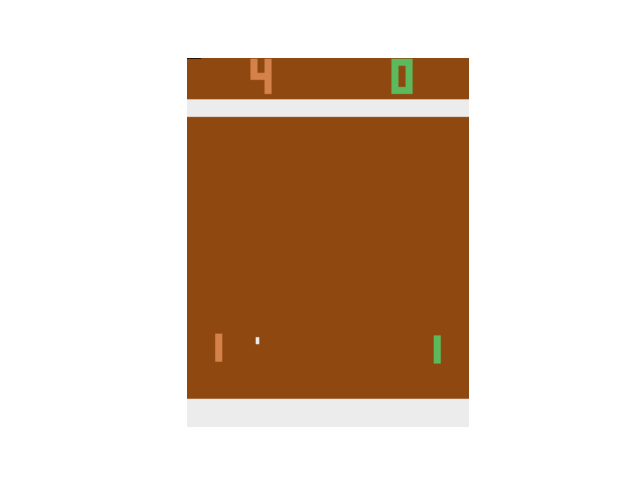
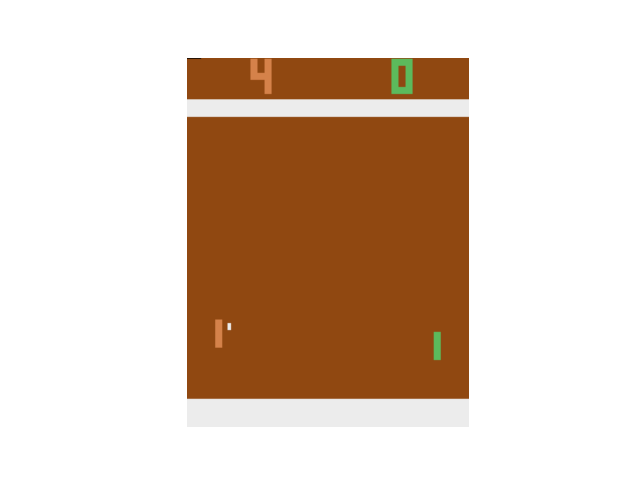
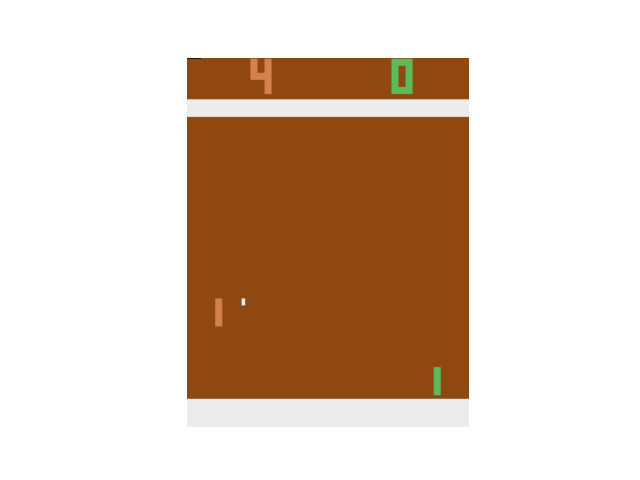
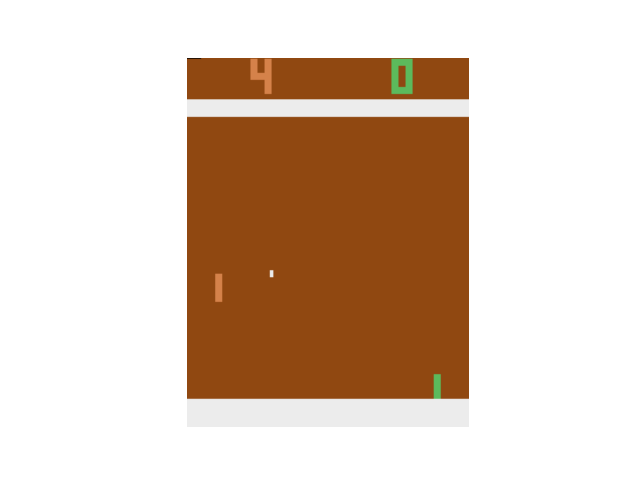
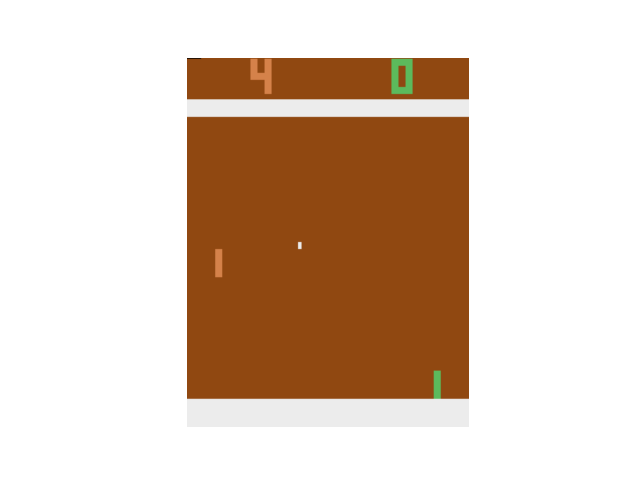
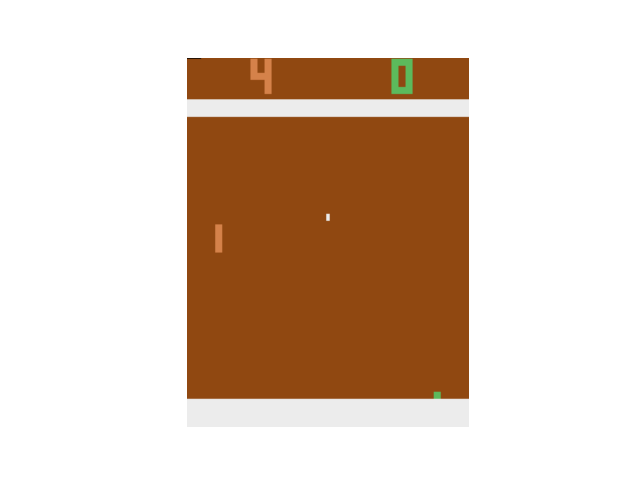
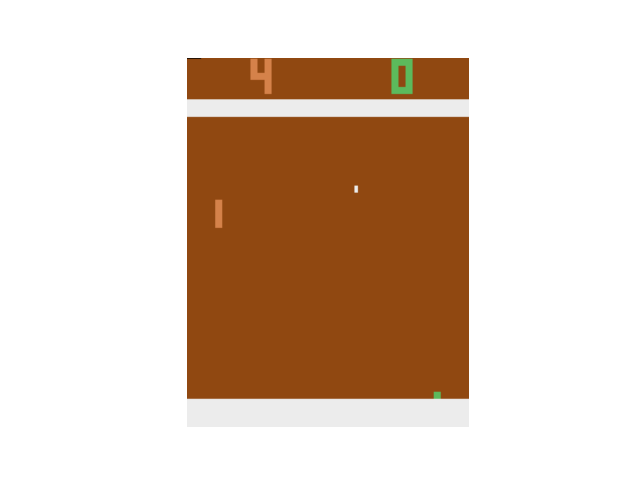
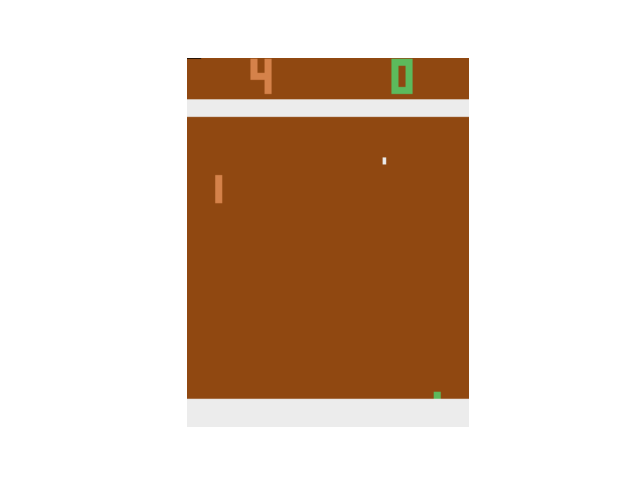
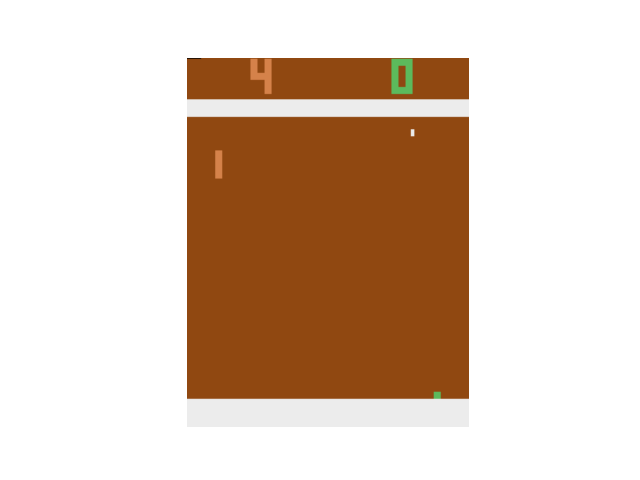
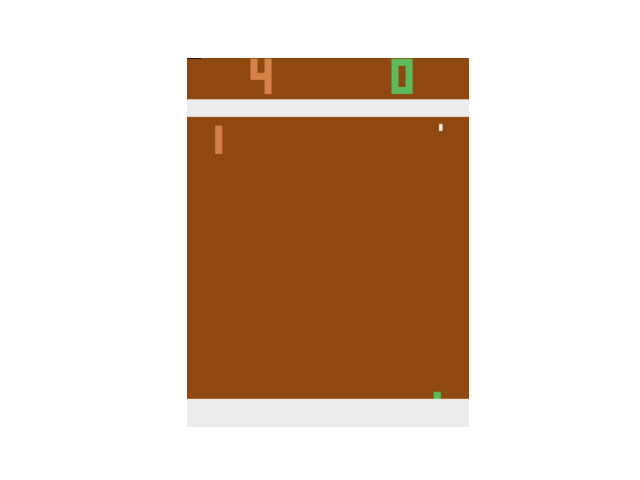
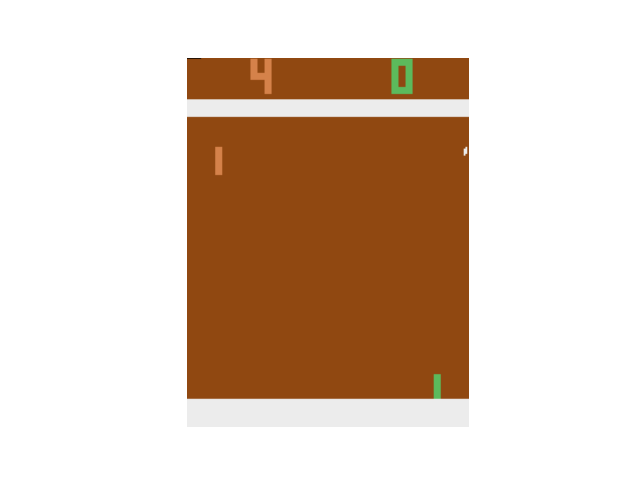
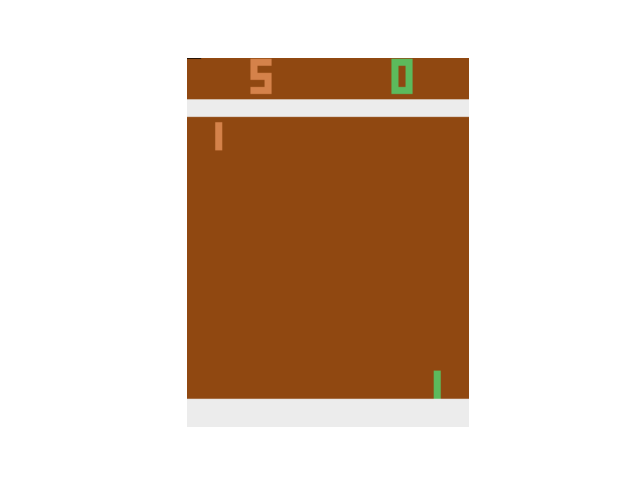
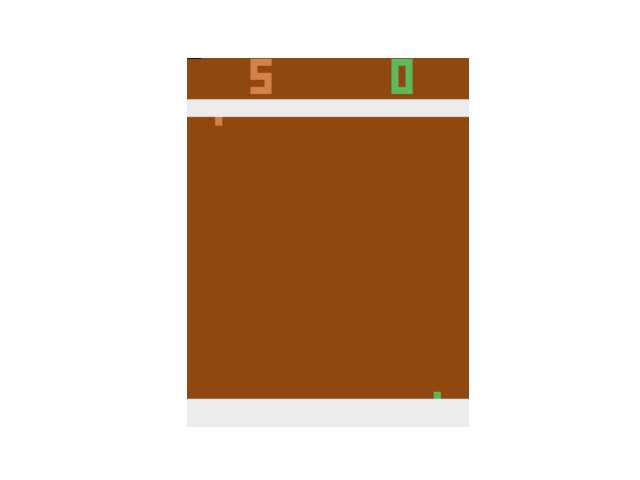
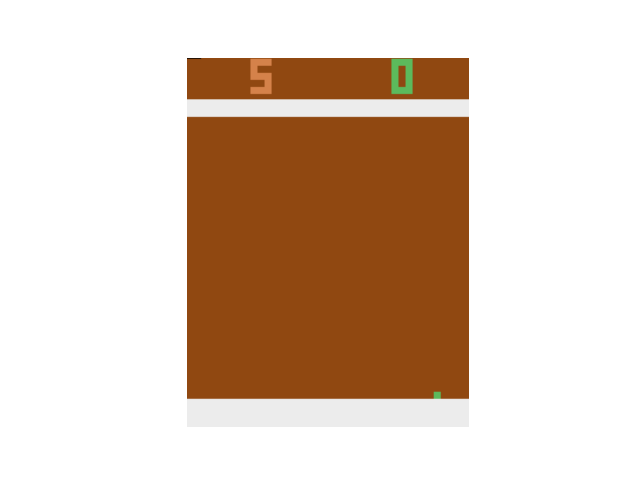
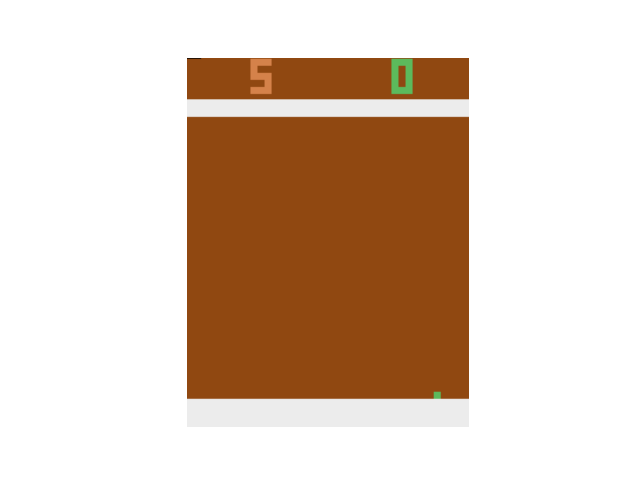
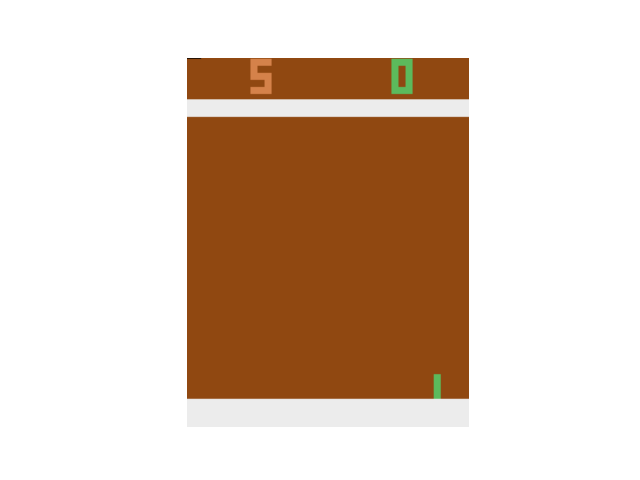
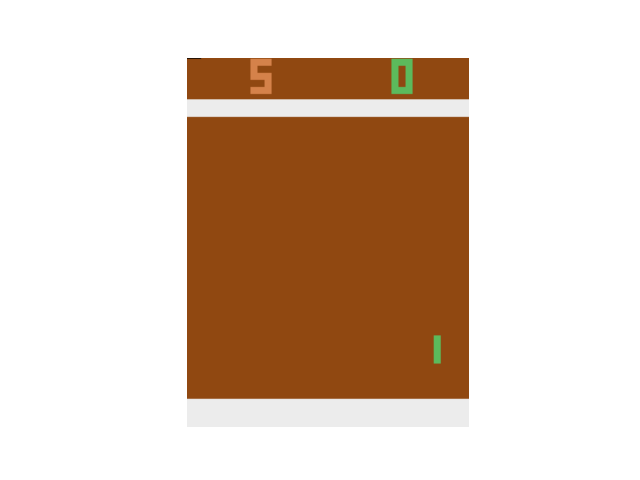
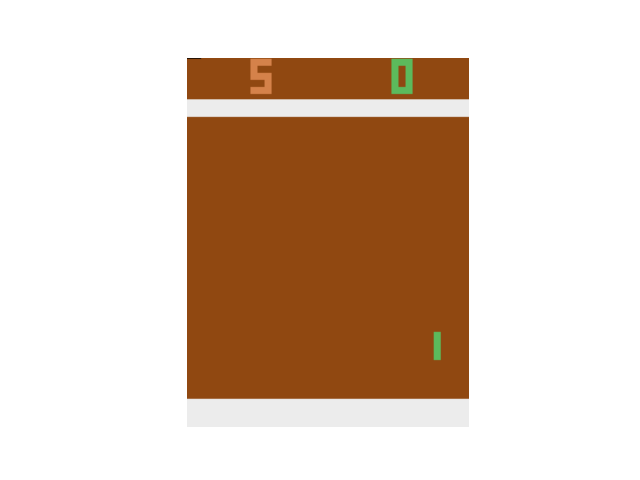
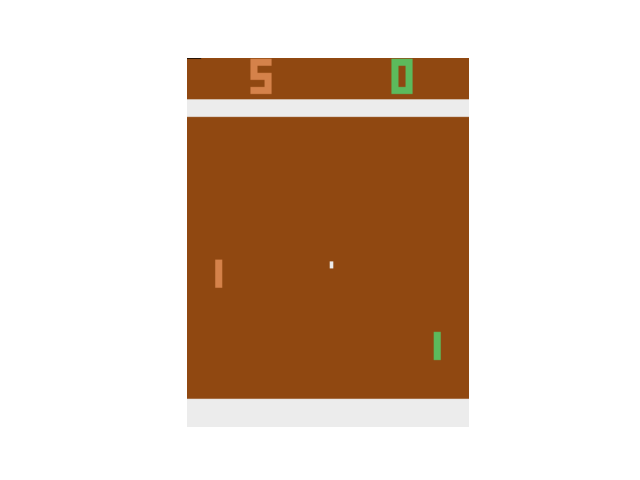
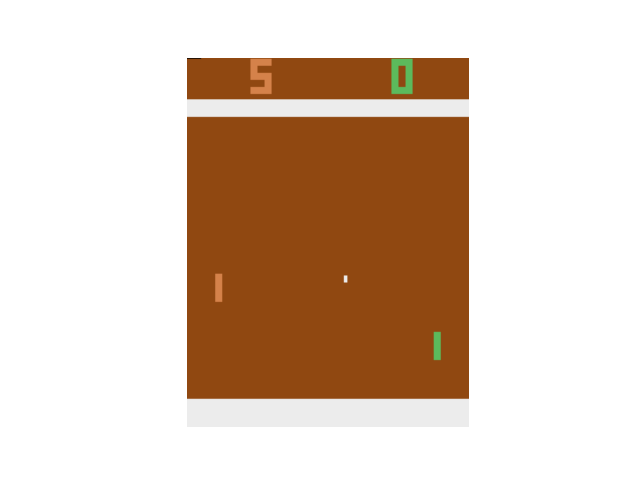
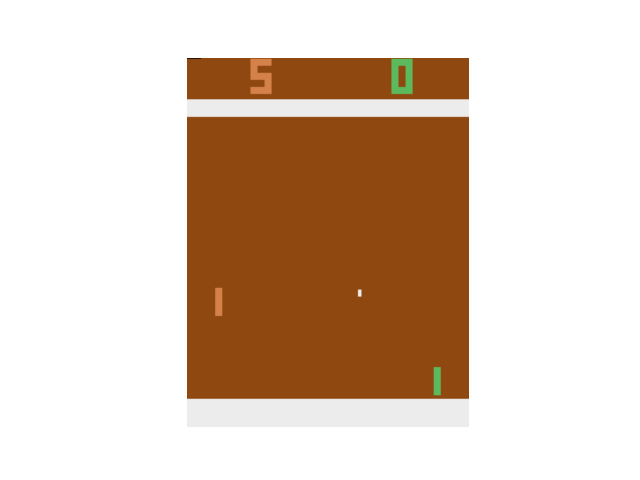
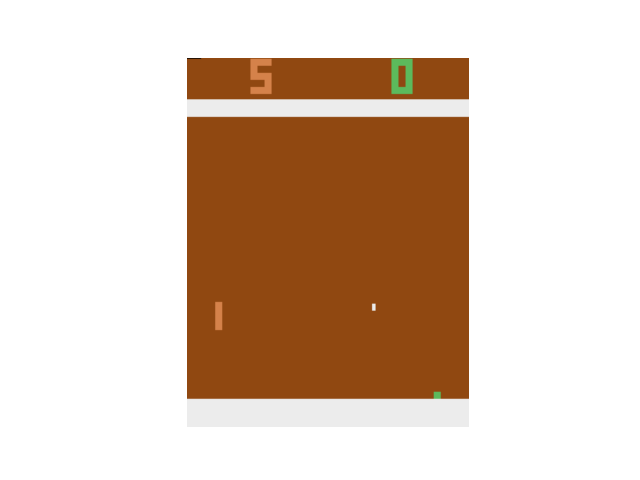
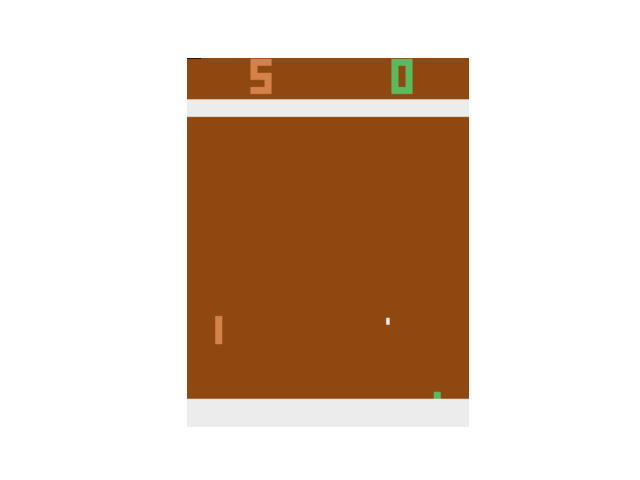
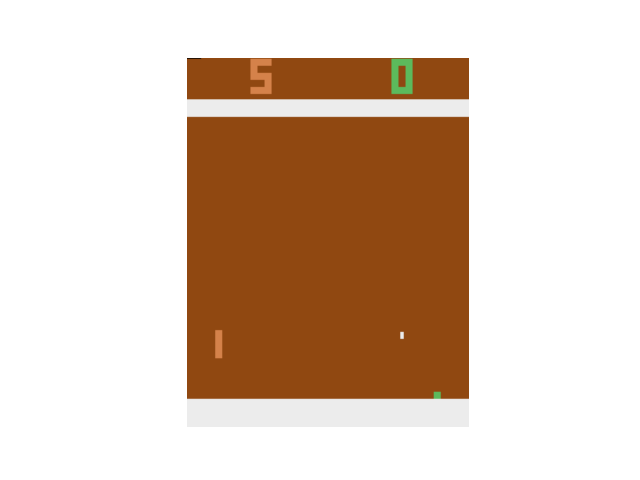
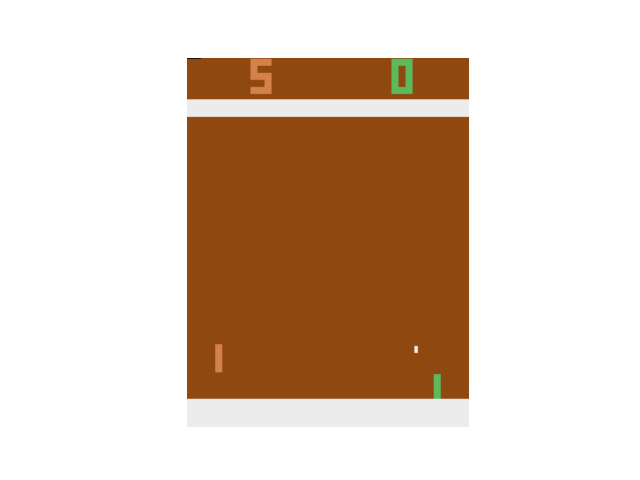
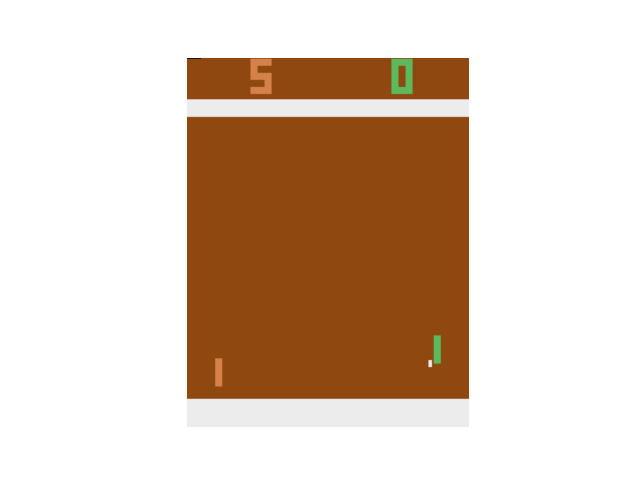
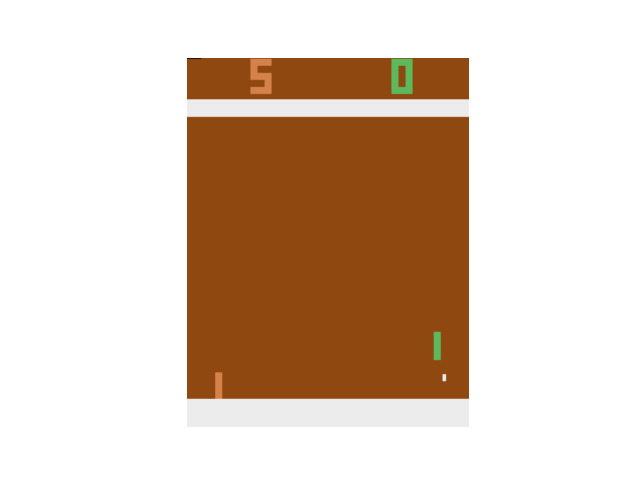
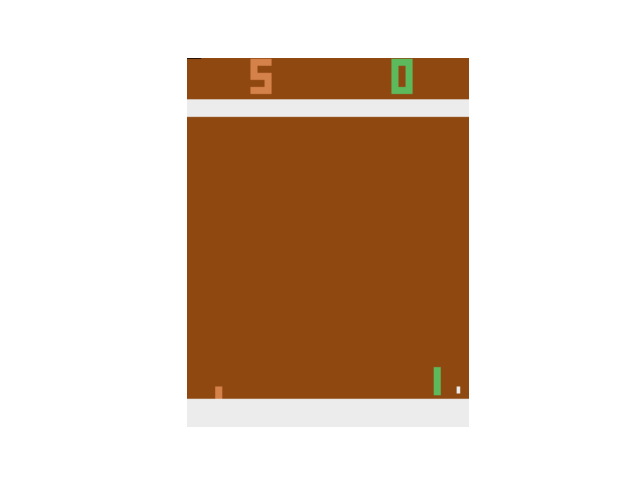
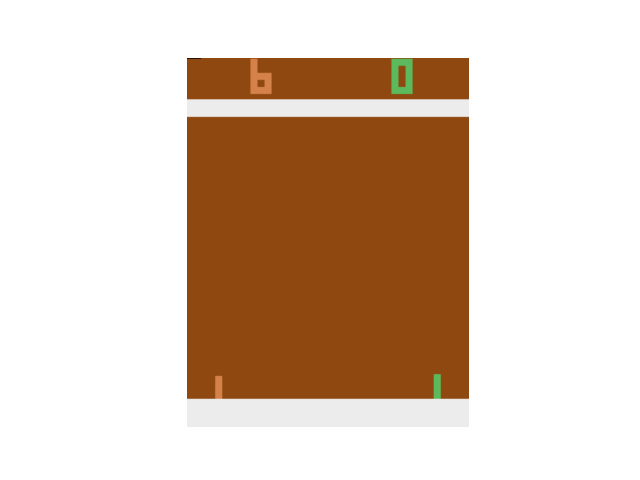
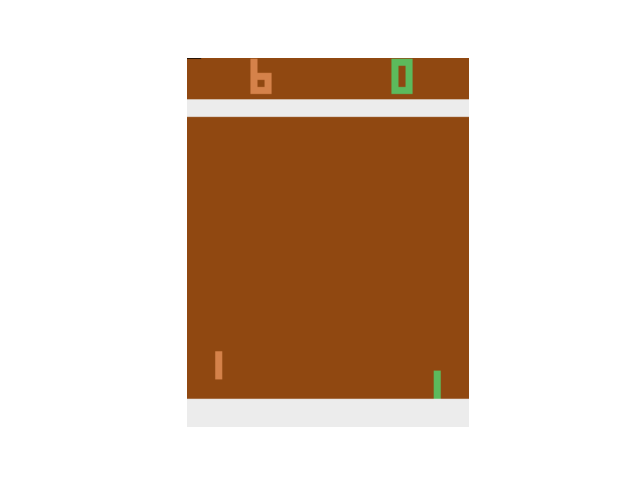
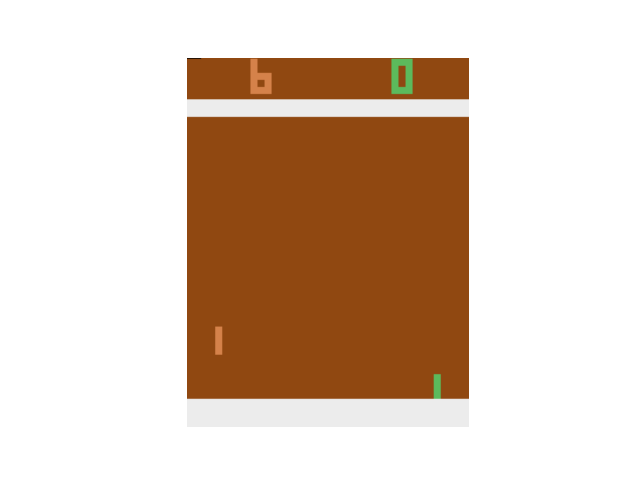
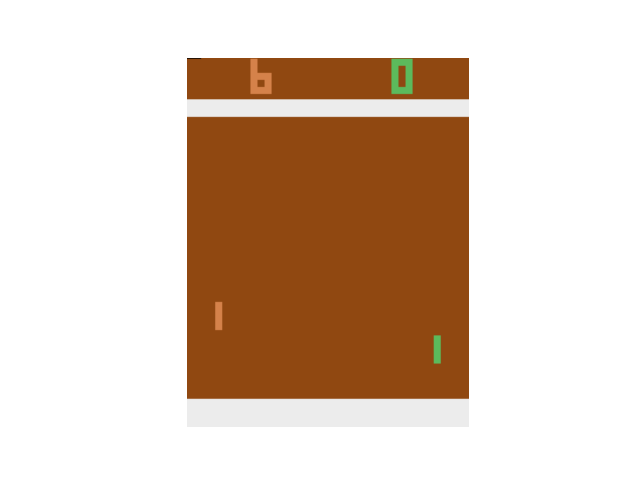
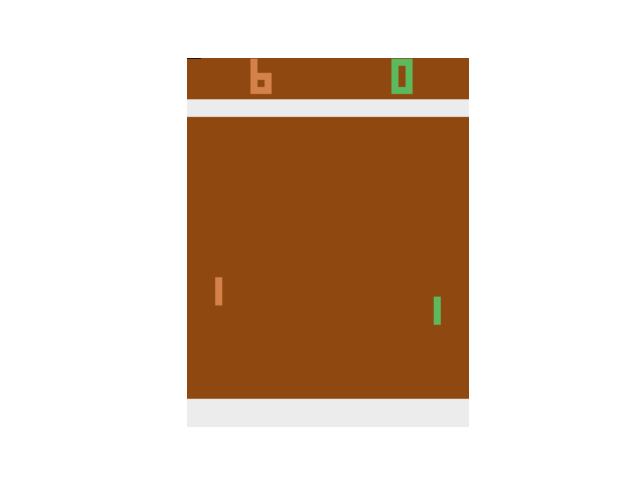
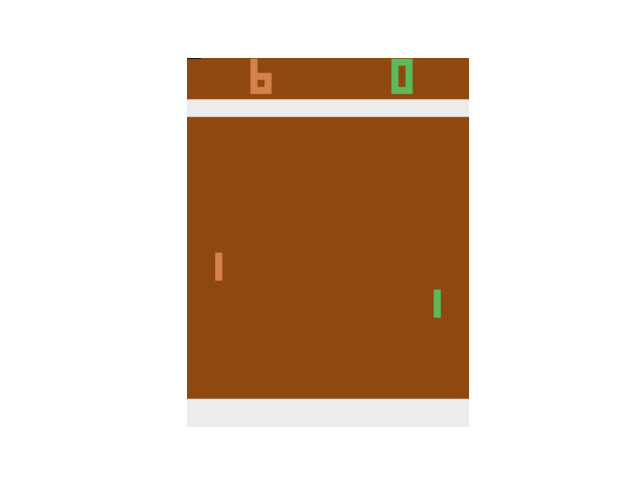
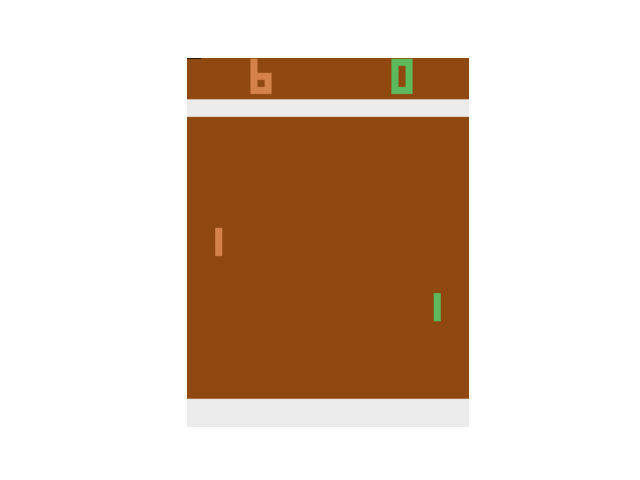
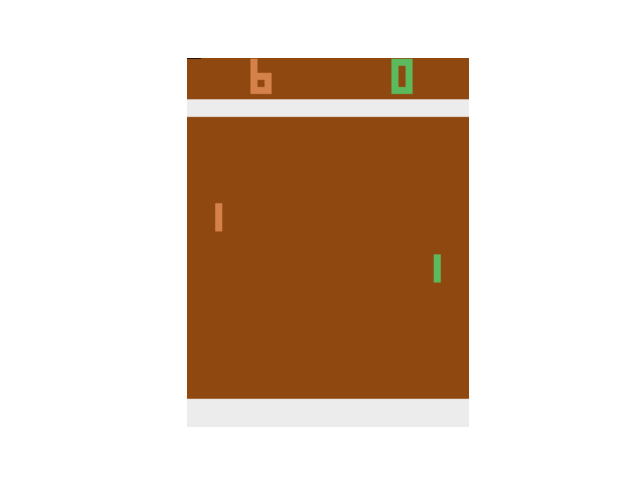
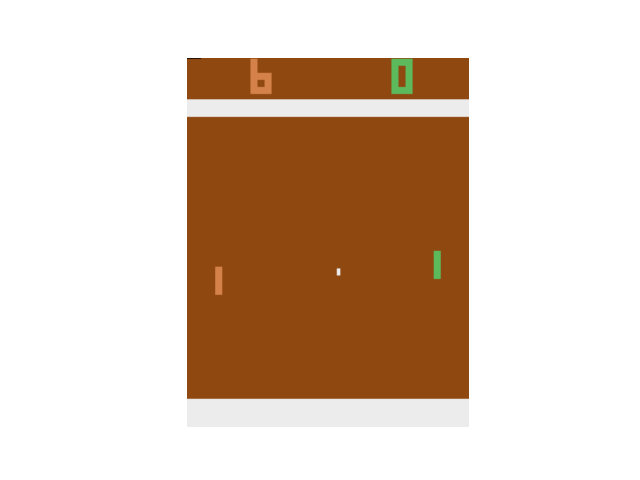
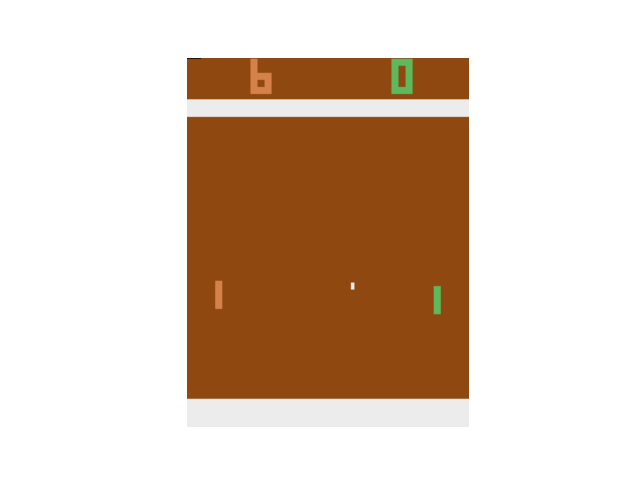
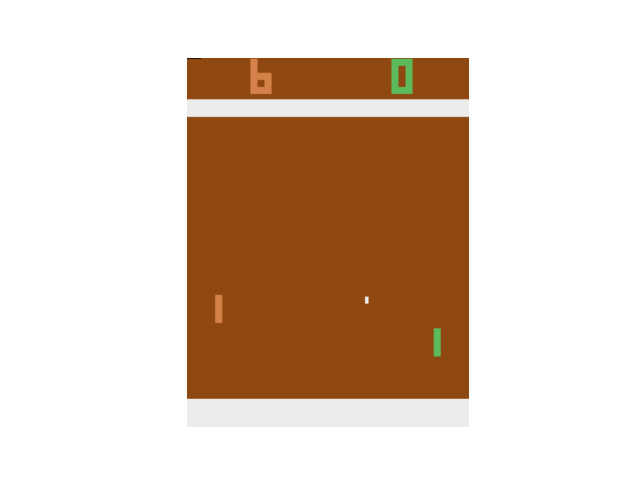
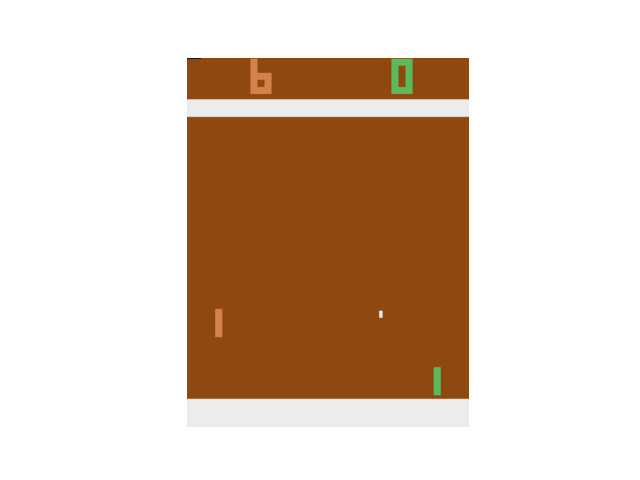
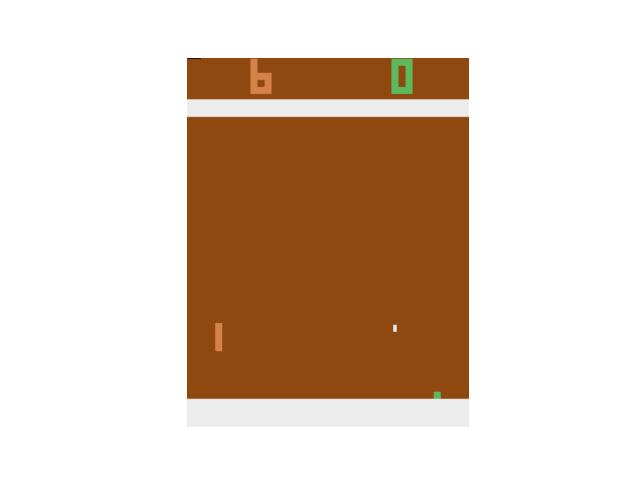
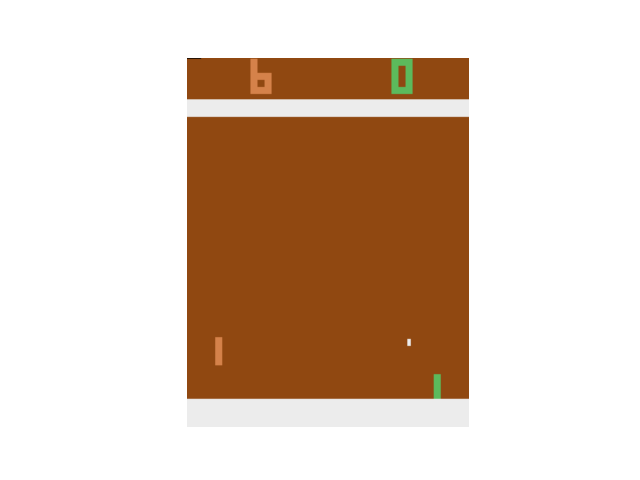
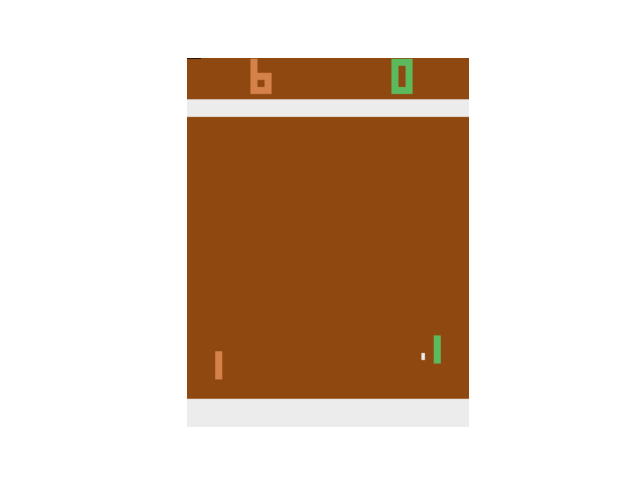
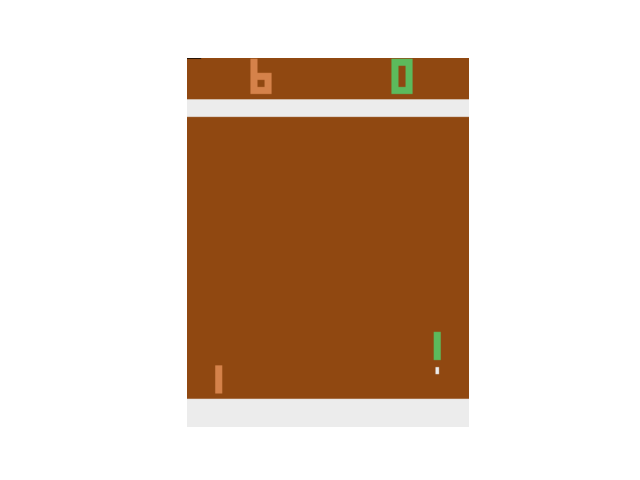
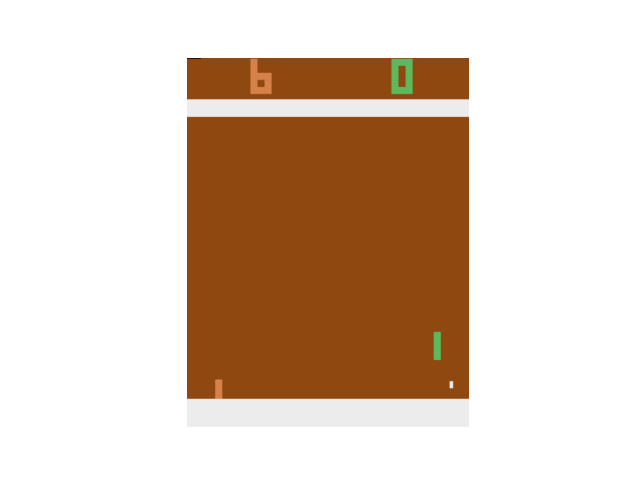
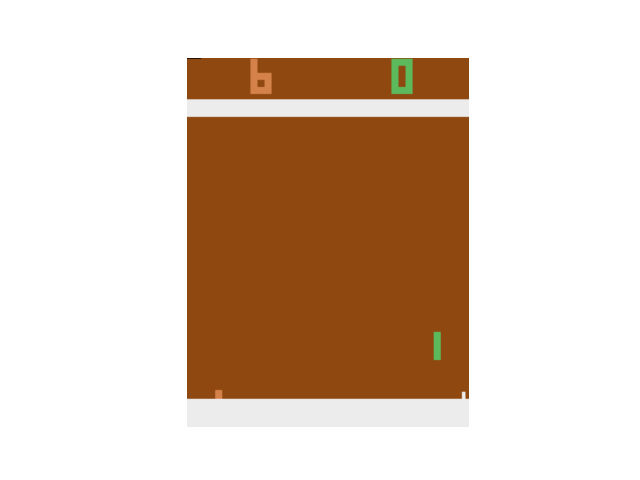
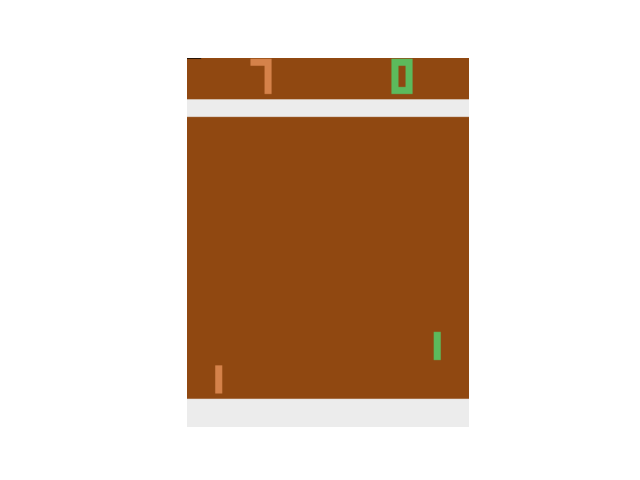
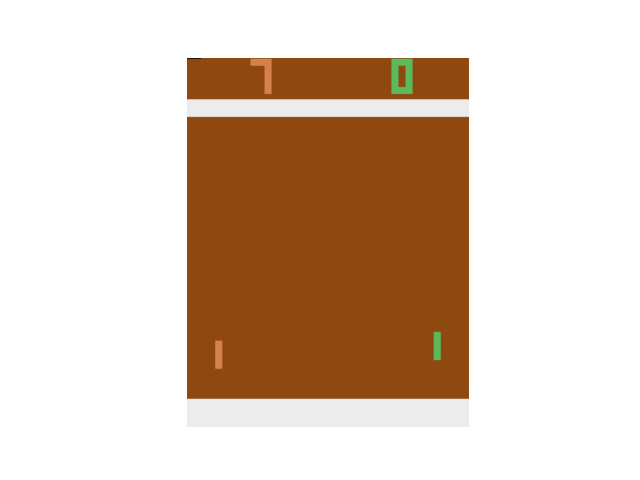
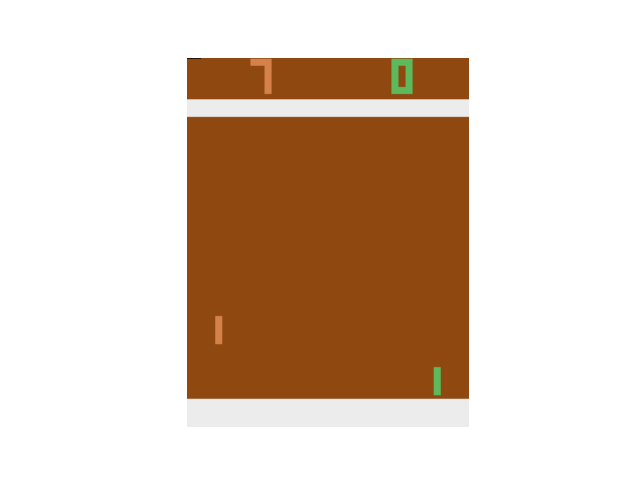
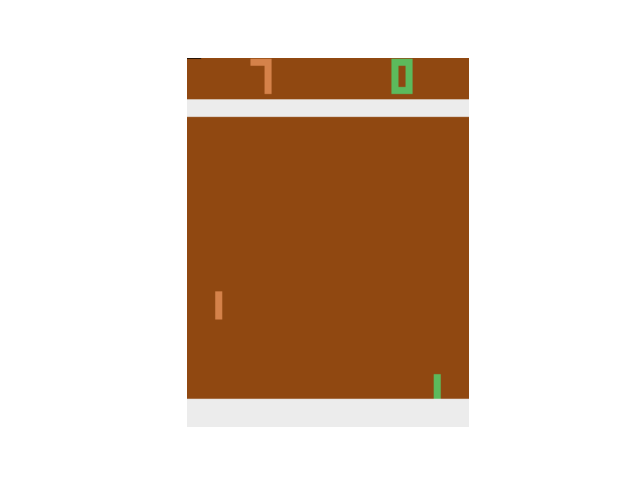
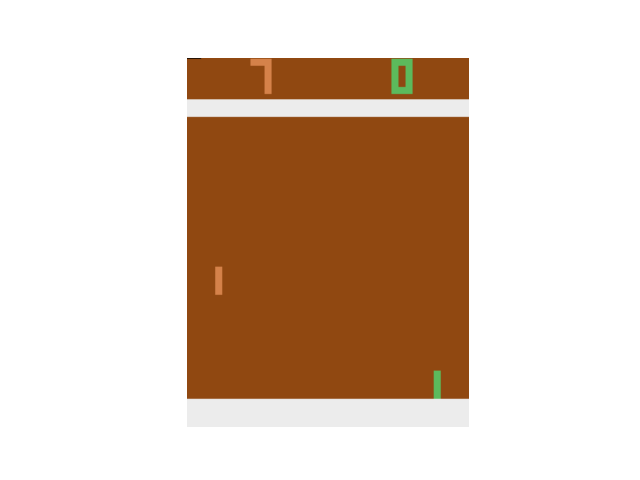
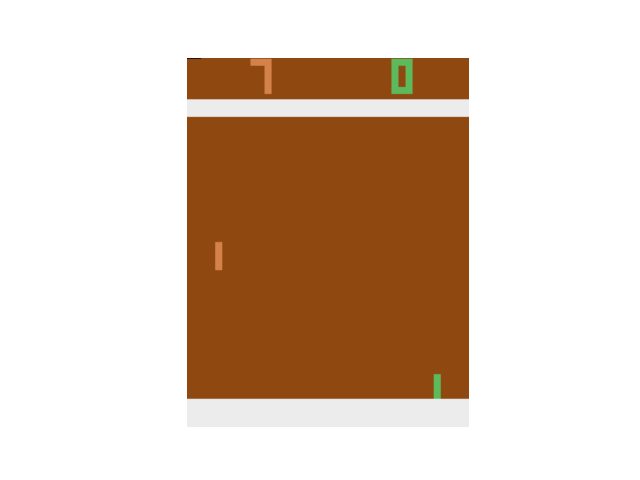
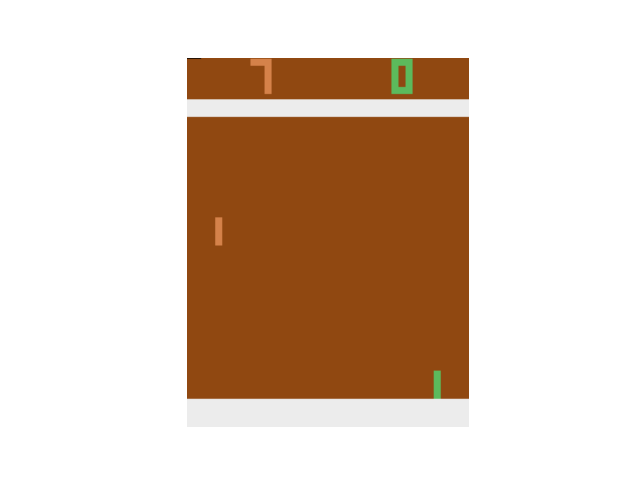
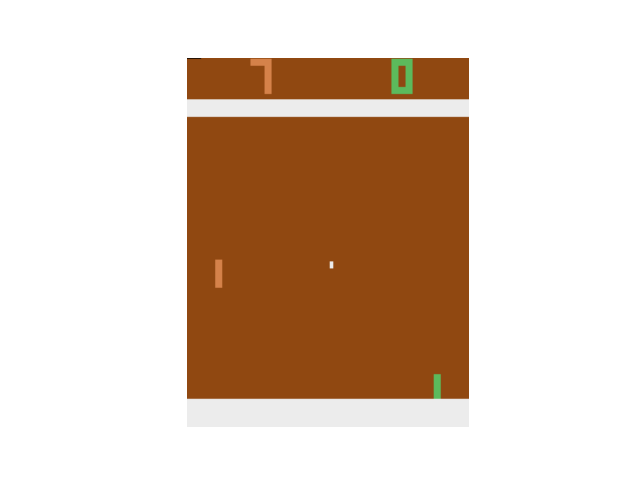
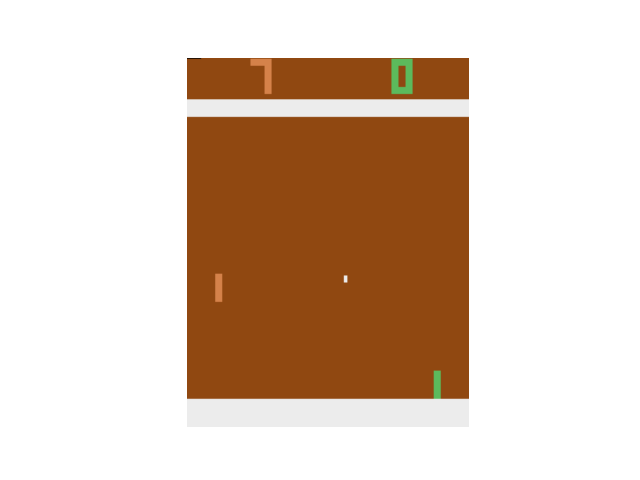
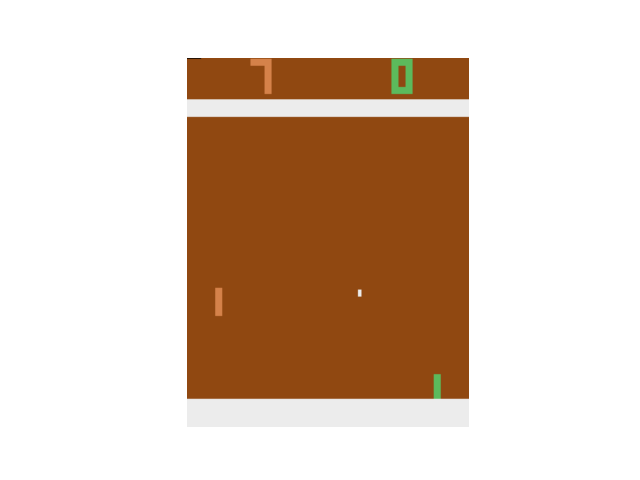
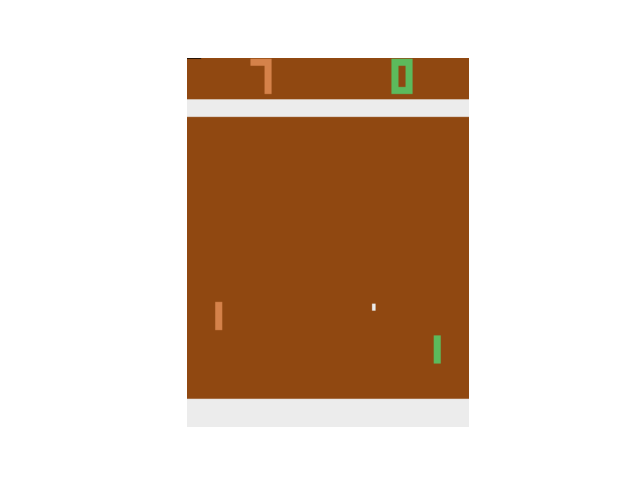
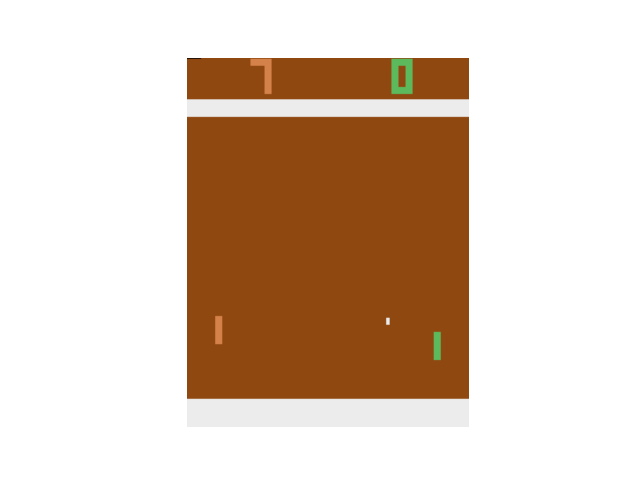
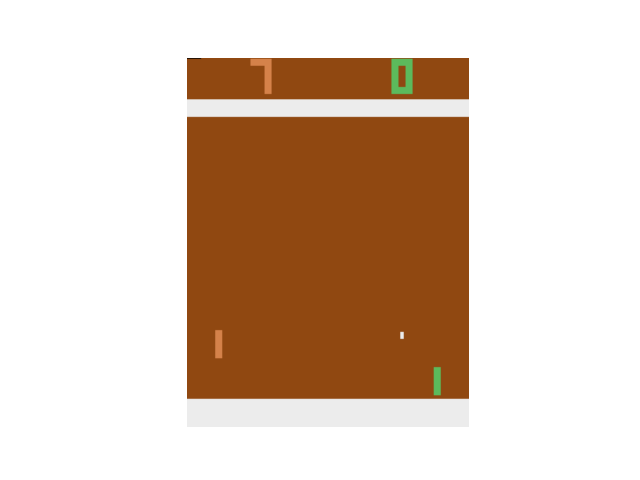
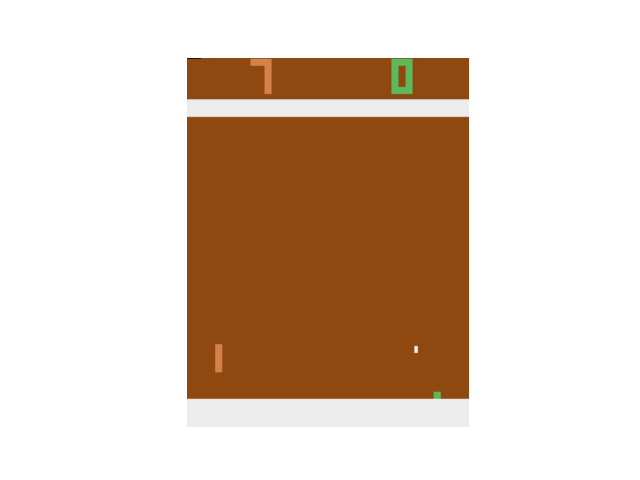
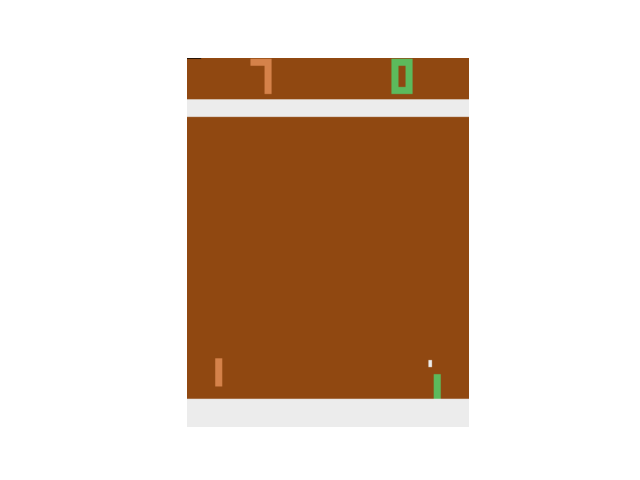
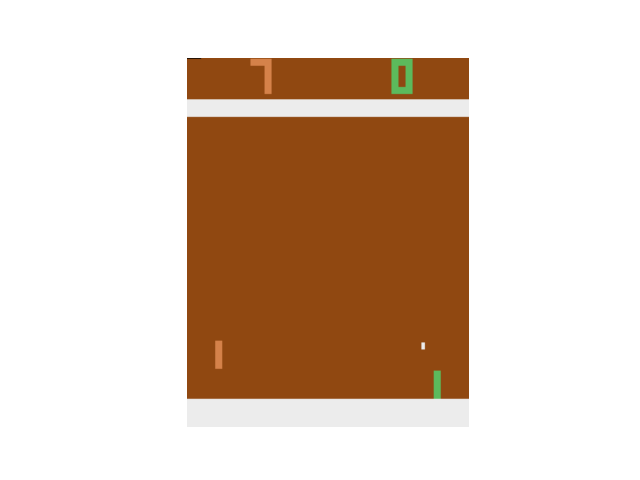
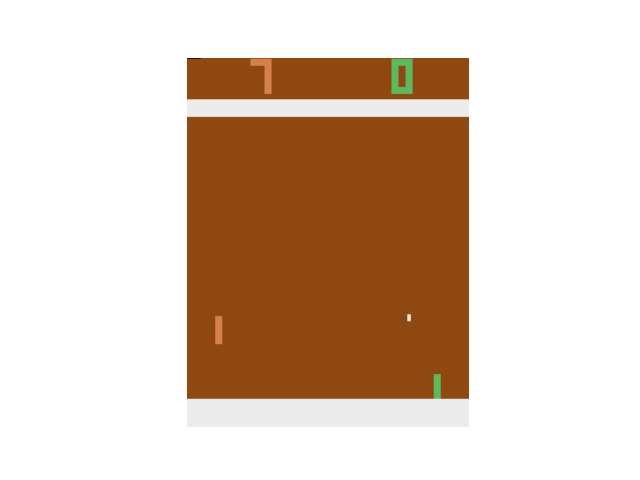
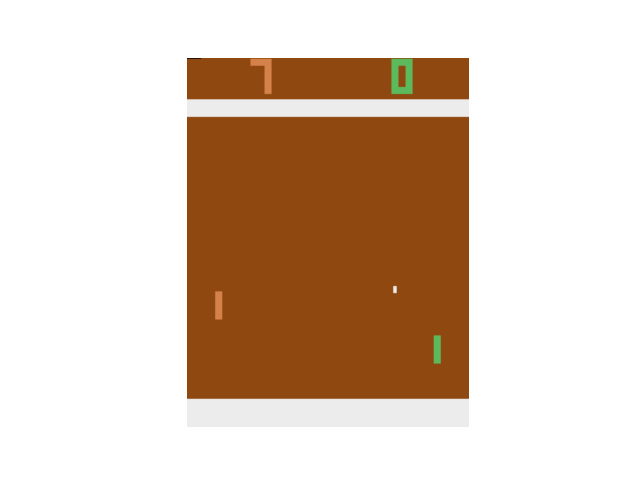
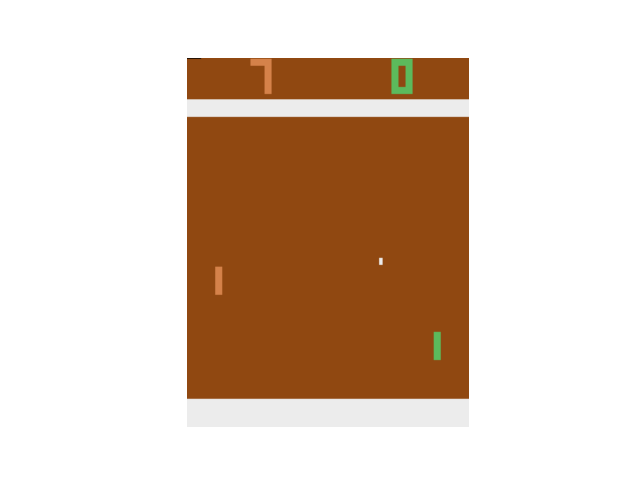
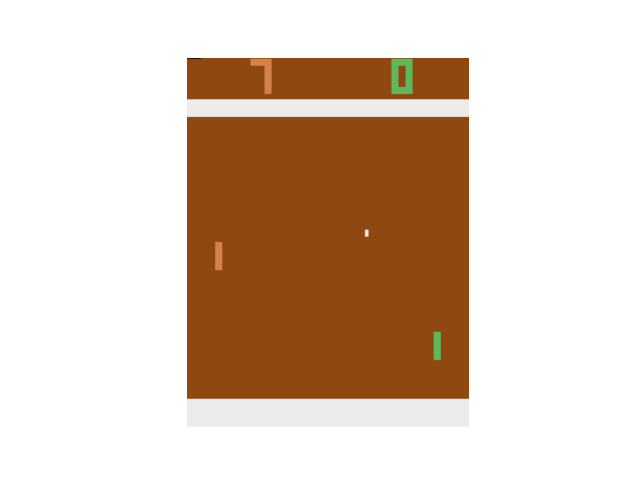
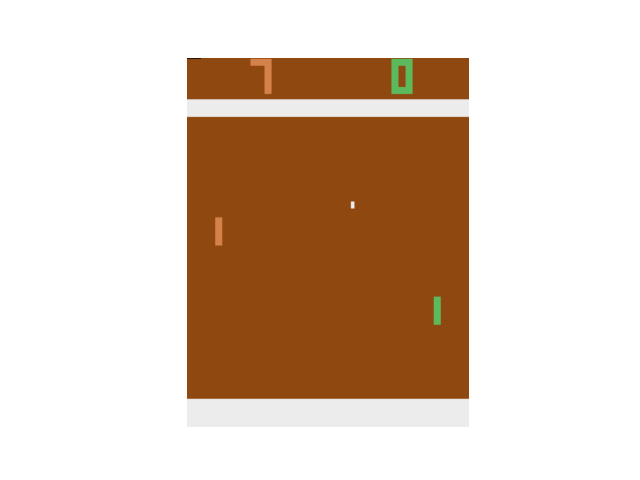
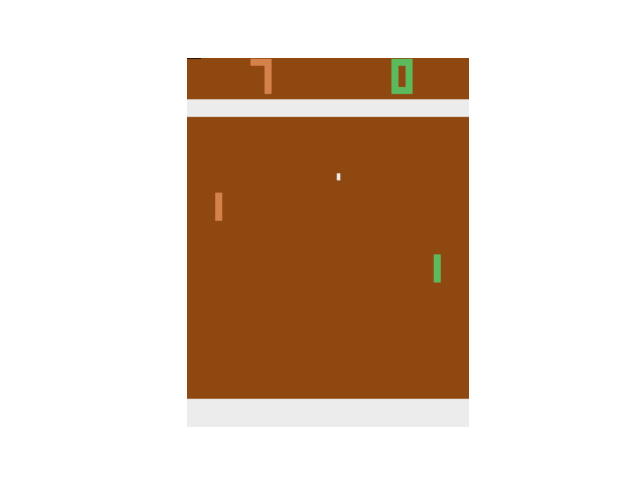
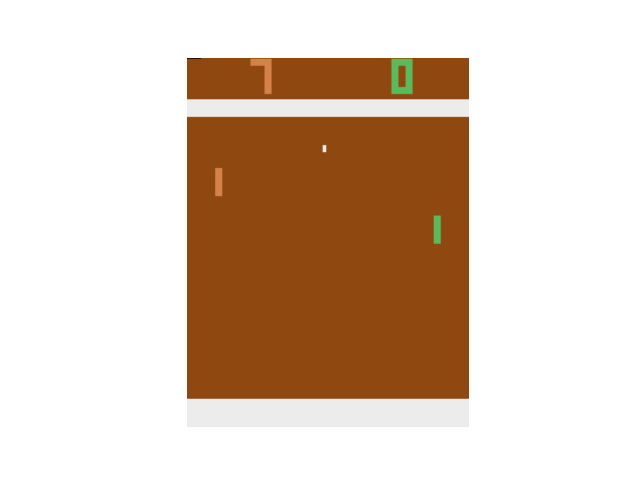
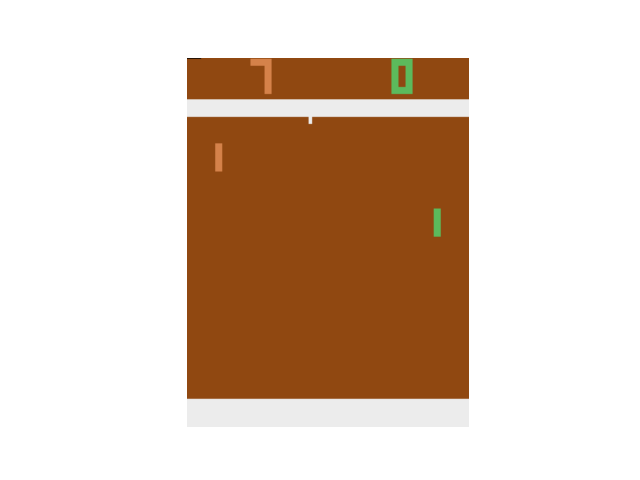
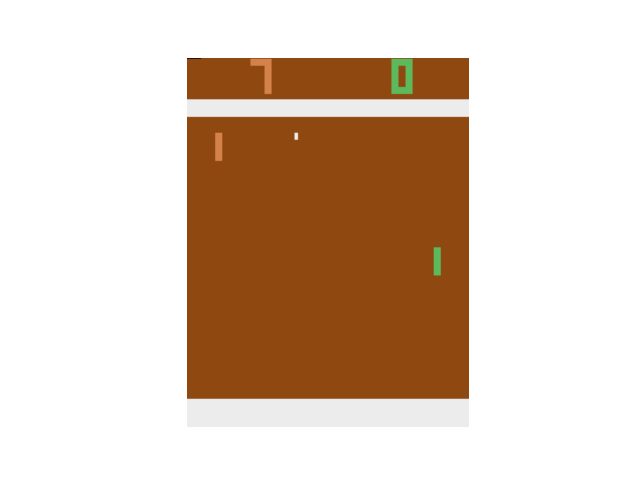
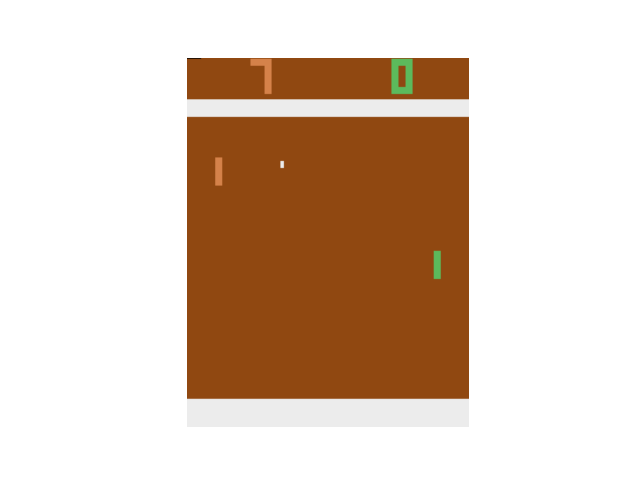
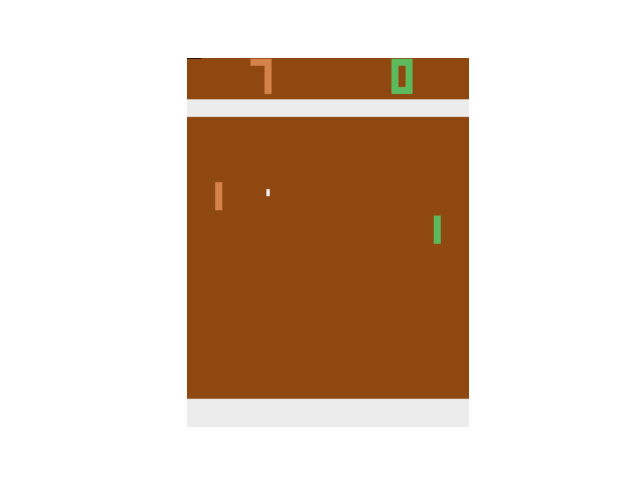
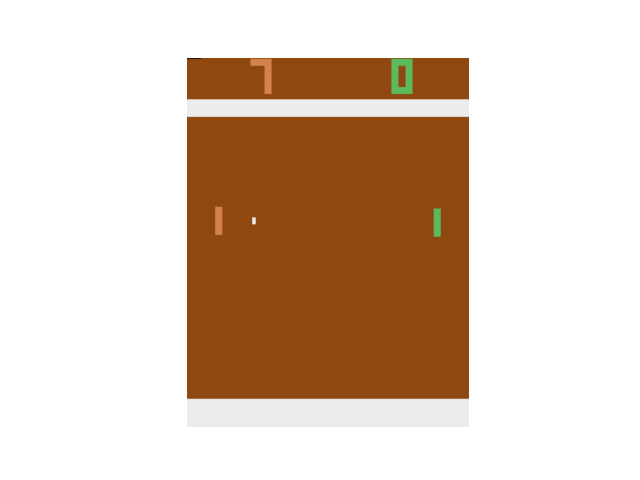
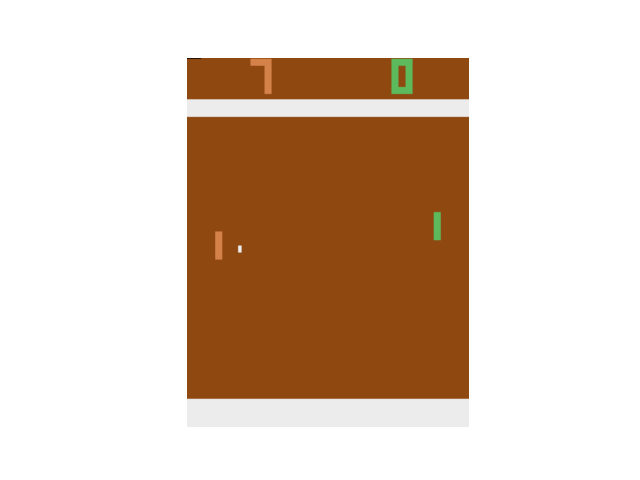
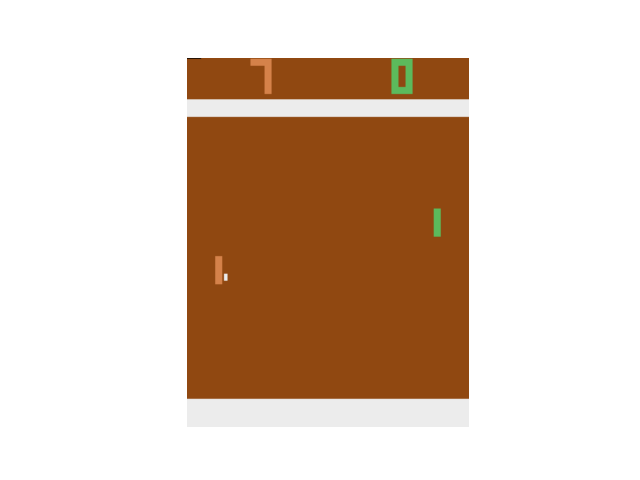
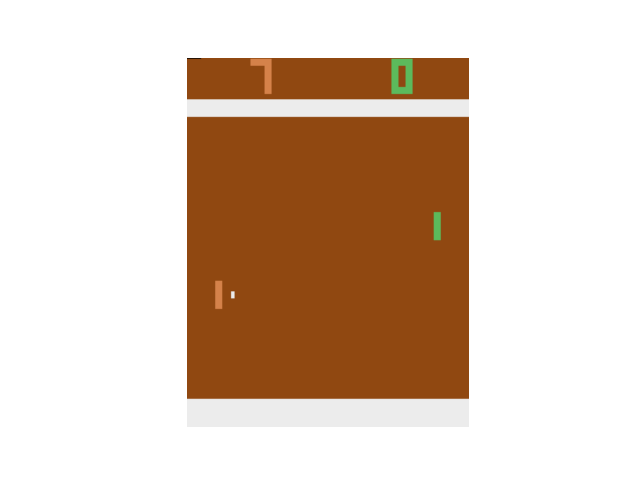
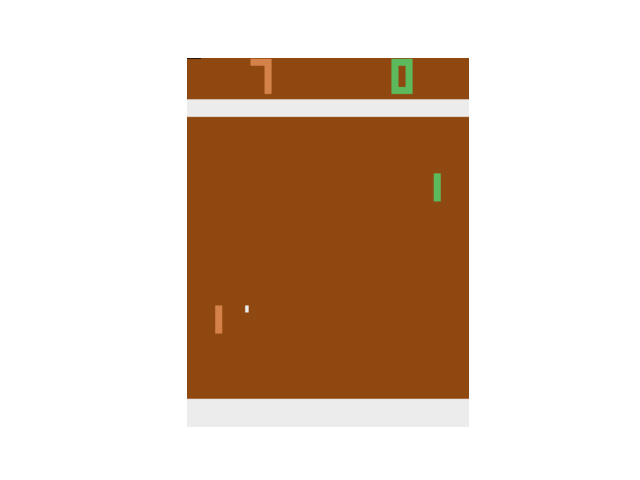
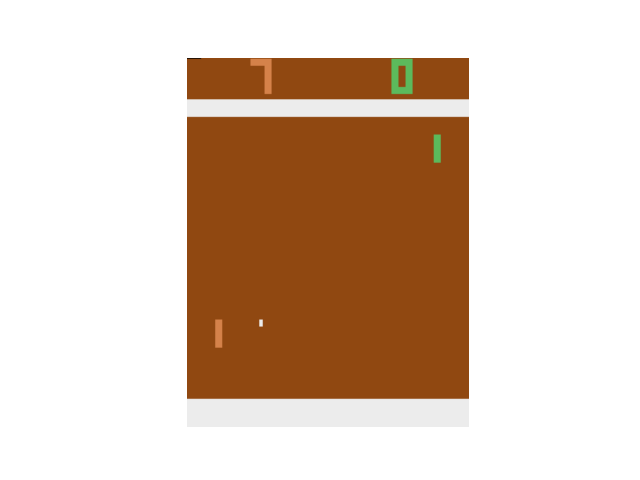
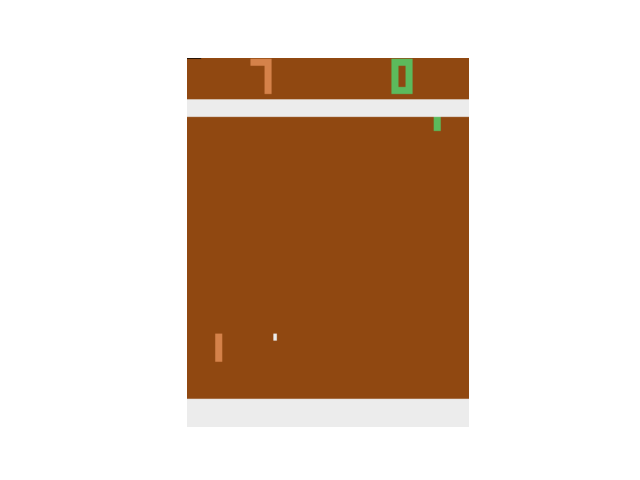
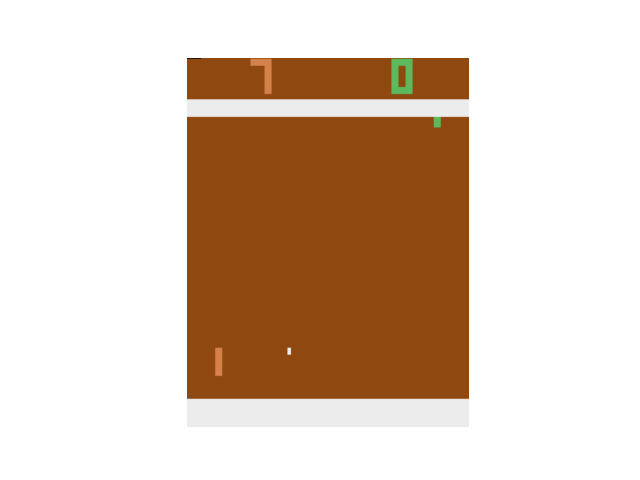
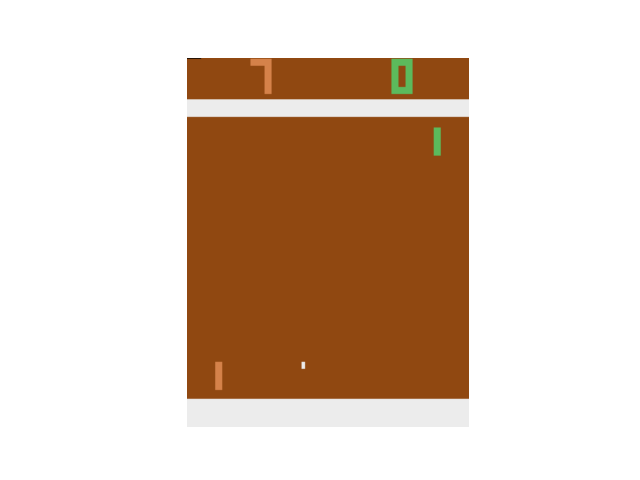
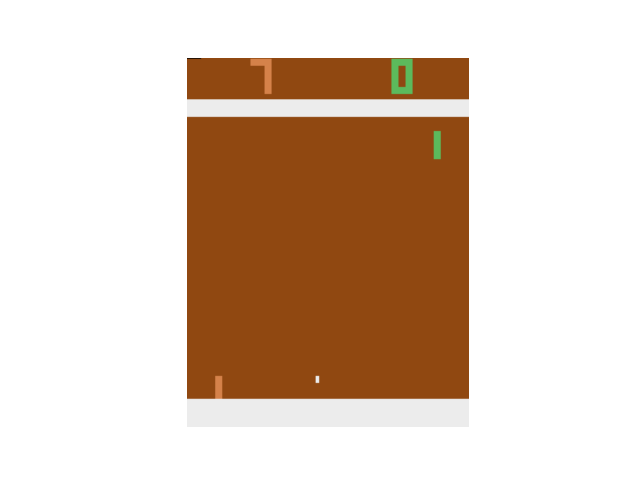
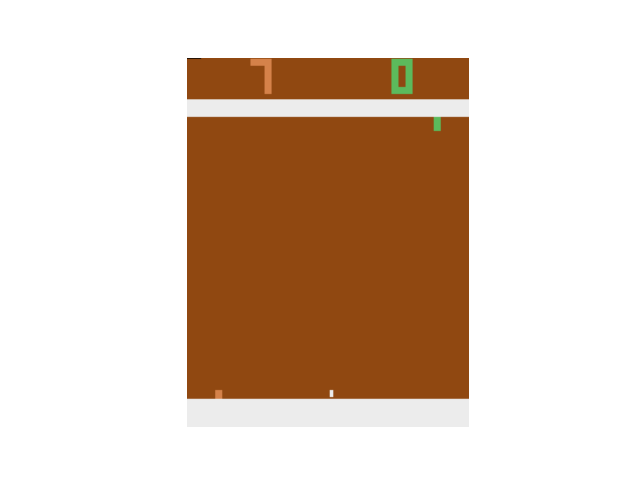
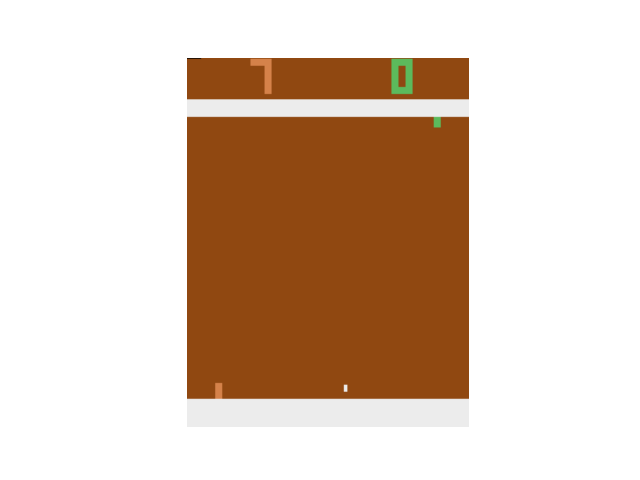
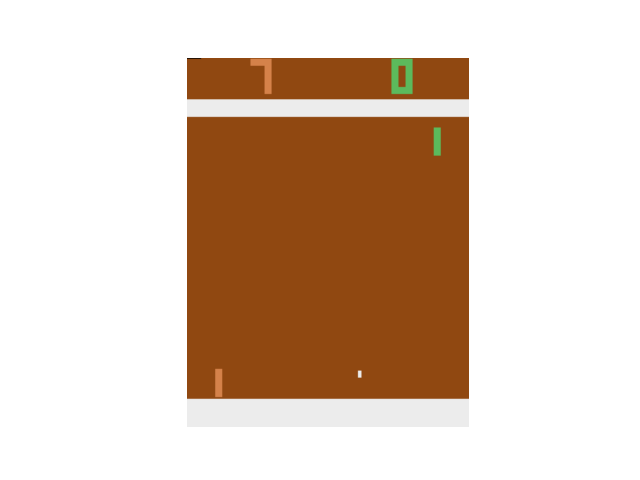
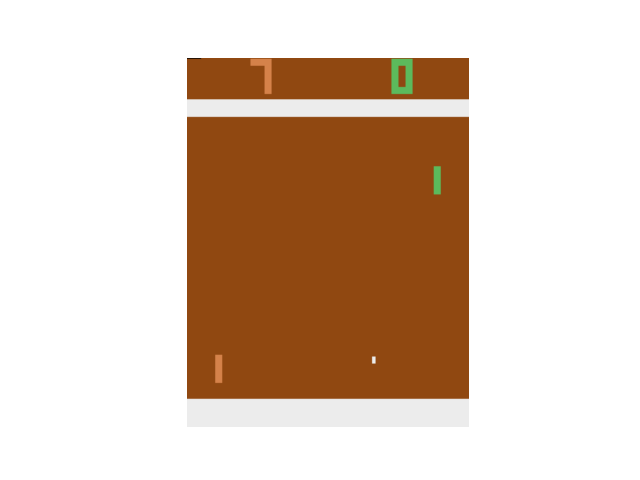
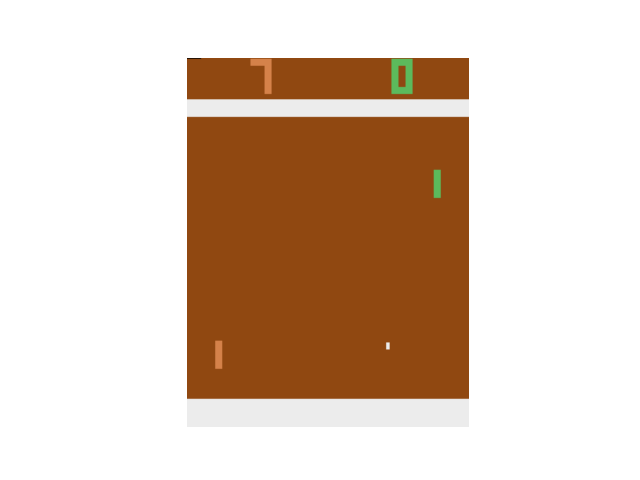
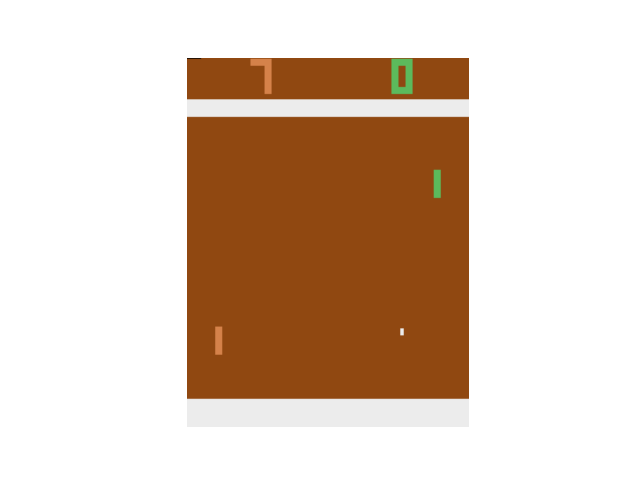
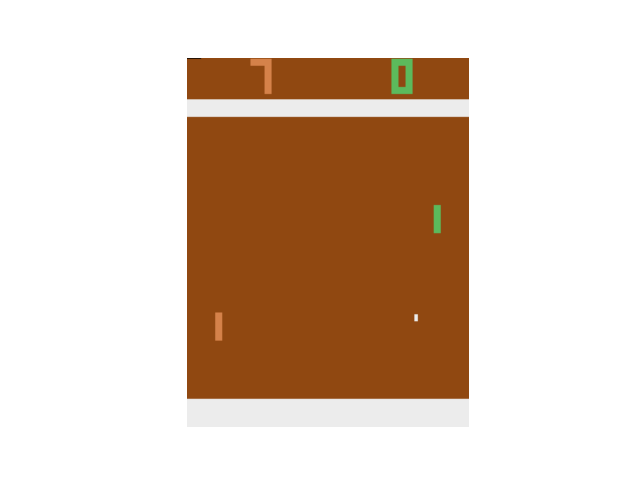
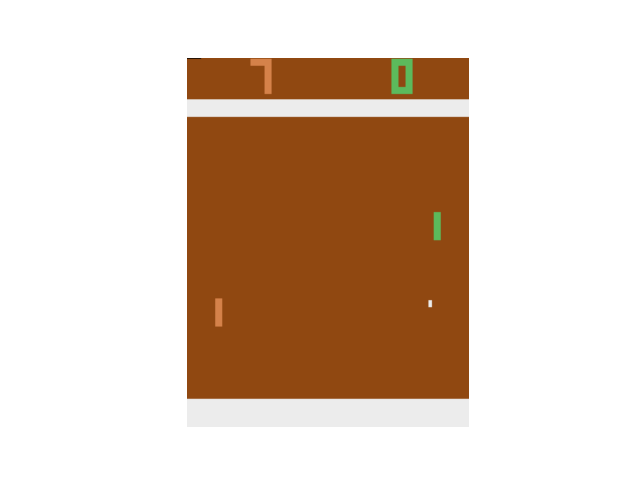
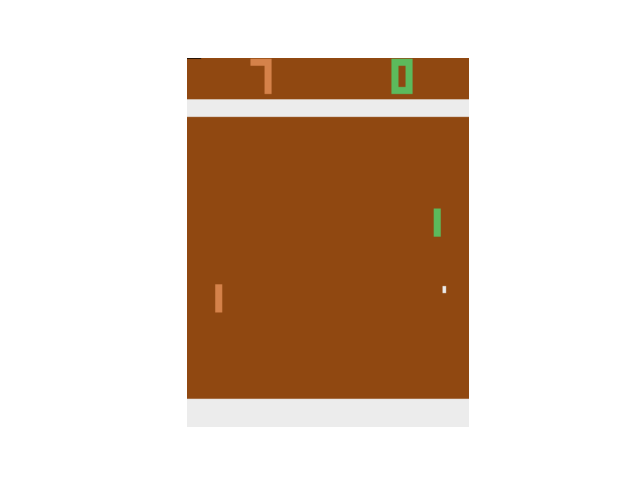
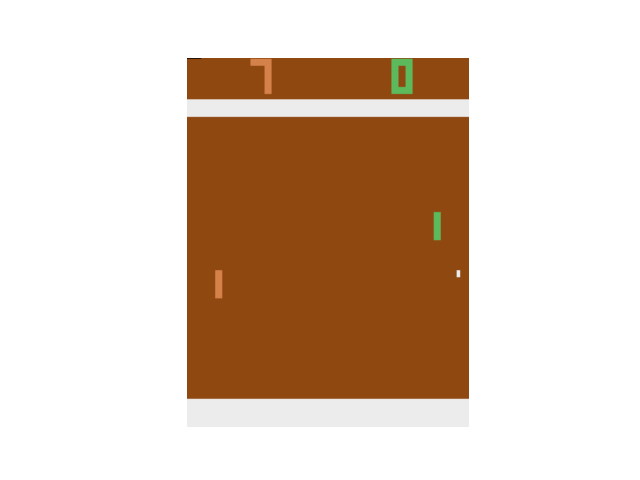
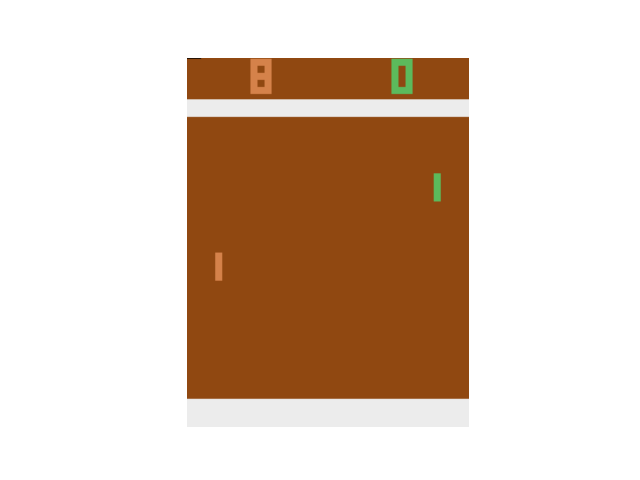
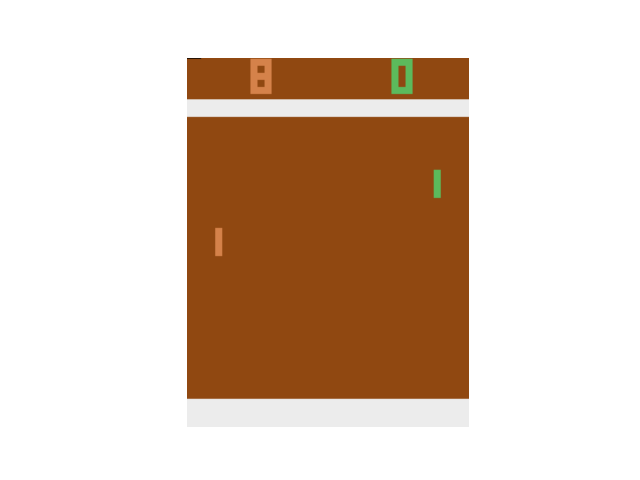
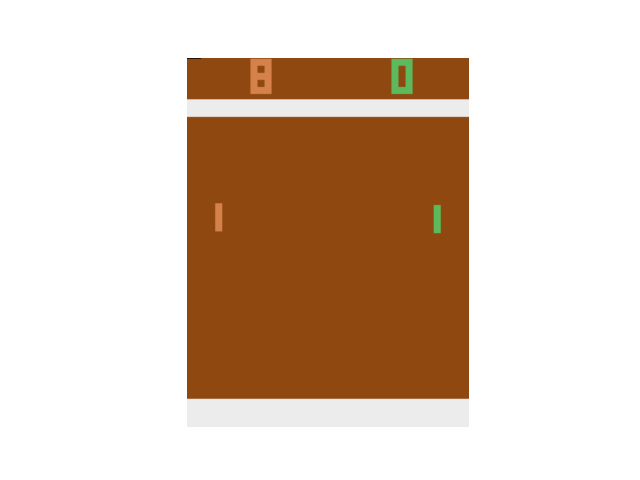
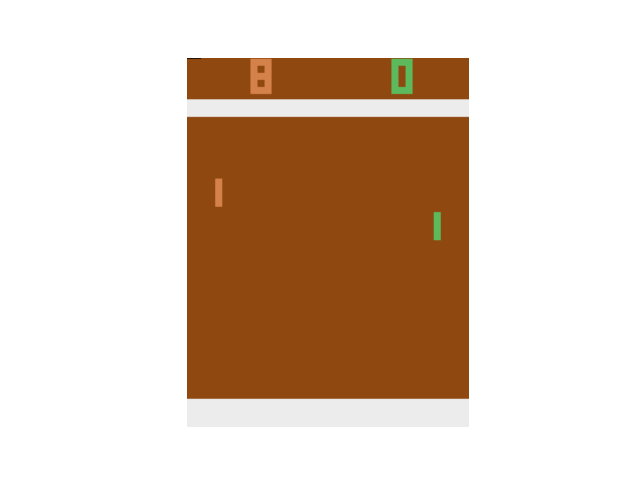
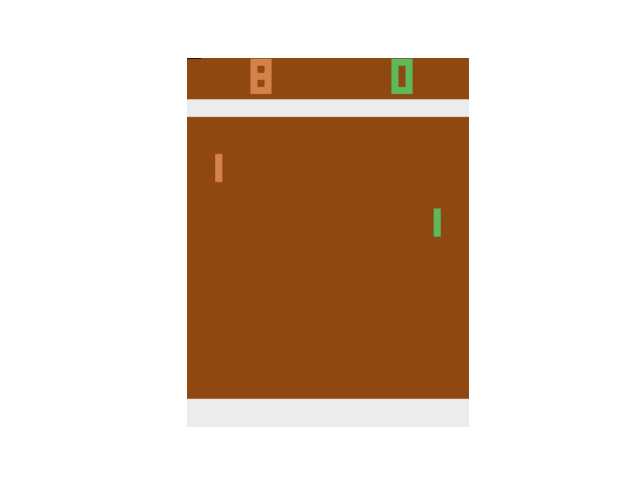
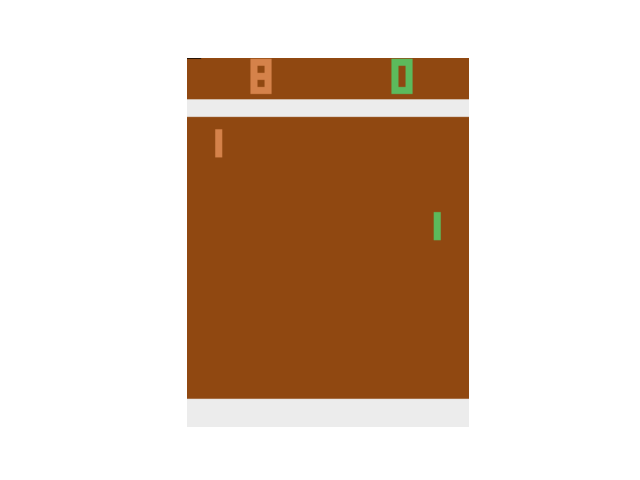
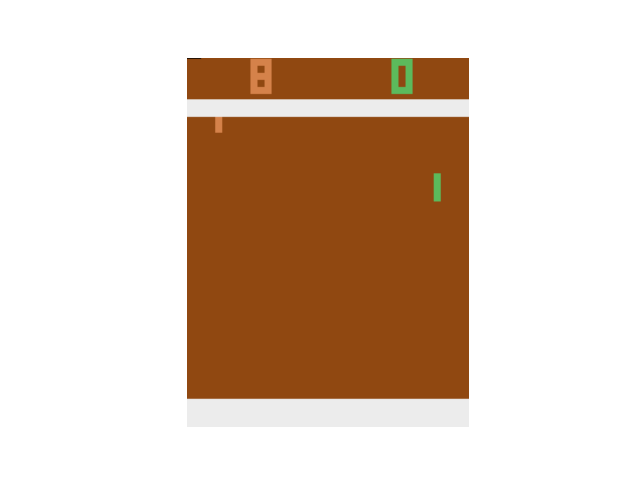

In [ ]:
import warnings
warnings.filterwarnings('ignore')
pong_utils.play(env, policy, time=200)
# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

# Function Definitions
Here you will define key functions for training.

## Exercise 2: write your own function for training
(what I call scalar function is the same as policy_loss up to a negative sign)

### PPO
Later on, you'll implement the PPO algorithm as well, and the scalar function is given by
$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

the ${\rm clip}_\epsilon$ function is implemented in pytorch as ```torch.clamp(ratio, 1-epsilon, 1+epsilon)```  



In [ ]:
## get some test data
import warnings
warnings.filterwarnings('ignore')
envs = pong_utils.parallelEnv('PongDeterministic-v4', n=4, seed=12345)
probs, states, actions, rewards = pong_utils.collect_trajectories(envs, policy, tmax=100)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

def clipped_surrogate(policy, old_probs, states, actions, rewards,
                      reward_discount = 0.995,
                      epsilon=0.1,
                      beta=0.01):
    ########
    ## WRITE YOUR OWN CODE HERE
    ########
    iota = 1.e-10 ## add a small number to avoid nans

    discounts = reward_discount ** np.arange(len(rewards))
    discounted_rewards = np.array(rewards) * discounts[:, np.newaxis]
    future_rewards = discounted_rewards[::-1].cumsum(axis=0)[::-1]
    normalized_rewards = (future_rewards - future_rewards.mean(axis=1)[:, np.newaxis]) \
        / (future_rewards.std(axis=1)[:, np.newaxis] + iota)

    ## prepare tensors
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    normalized_rewards = torch.tensor(normalized_rewards, dtype=torch.float, device=device)

    ## forward through the neural network, convert states to policy (or probability)
    new_probs = pong_utils.states_to_prob(policy, states)
    new_probs = torch.where(actions==pong_utils.RIGHT, new_probs, 1.0-new_probs)
    ratios = new_probs / old_probs
    clipped_ratios = torch.clamp(ratios, 1-epsilon, 1+epsilon)

    ## include a regularization term that steers new_policy towards 0.5
    ## which prevents policy to become exactly 0 or 1, thus helps with exploration
    entropy = -(new_probs * torch.log(old_probs+iota) + \
        (1.0-new_probs) * torch.log(1.0-old_probs+iota))

    return torch.mean(torch.min(ratios*normalized_rewards,
                                clipped_ratios*normalized_rewards) + beta*entropy)

L1 = pong_utils.clipped_surrogate(policy, probs, states, actions, rewards) ## the solution function
print(f"solution: \t{L1}")
L = clipped_surrogate(policy, probs, states, actions, rewards) ## your own function
print(f"your function: \t{L}")

solution: 	0.006931421812623739
your function: 	0.006931421812623739


# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [ ]:
%%time
# keep track of how long training takes
# WARNING: running through all 800 episodes will take 30-45 minutes
# training loop max iterations
episode = 1000

discount_rate = .99
epsilon = 0.1
beta = .01
tmax = 320
SGD_epoch = 4

from parallelEnv import parallelEnv
import numpy as np
import progressbar as pb
from datetime import date
widget = ['training loop: ', pb.Percentage(), ' ',
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()
envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

# keep track of progress
mean_rewards = []

for e in range(episode):
    # collect trajectories
    old_probs, states, actions, rewards = \
        pong_utils.collect_trajectories(envs, policy, tmax=tmax)
    total_rewards = np.sum(rewards, axis=0)

    # gradient ascent step
    for _ in range(SGD_epoch):
        ## use solution surrogate
        # L = -pong_utils.clipped_surrogate(policy, old_probs, states, actions, rewards,
        #                                   epsilon=epsilon, beta=beta)
        ## uncomment to utilize your own clipped function!
        L = -clipped_surrogate(policy, old_probs, states, actions, rewards,
                               epsilon=epsilon, beta=beta)
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        del L

    # the clipping parameter reduces as time goes on
    epsilon*=.999
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995

    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))

    # display some progress every 20 iterations
    if (e+1)%20==0:
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)

    if (e+1)%200==0:
        torch.save(policy, f"{str(date.today()).replace('-','')}_e{e+1}_PPO.policy")

    # update progress widget bar
    timer.update(e+1)

timer.finish()

Episode: 20, score: -14.375000
[-14. -16. -13. -15. -15. -16. -13. -13.]


Episode: 40, score: -14.375000
[-16. -16. -16. -14.  -9. -14. -14. -16.]


Episode: 60, score: -14.000000
[-15. -12. -14. -12. -16. -16. -11. -16.]


Episode: 80, score: -14.375000
[-16. -14. -14. -15. -12. -15. -13. -16.]


Episode: 100, score: -14.125000
[-11. -14. -15. -14. -15. -14. -14. -16.]


Episode: 120, score: -14.000000
[-11. -15. -16. -14. -14. -13. -16. -13.]


Episode: 140, score: -13.250000
[-14. -12. -16. -12. -13. -12. -14. -13.]


Episode: 160, score: -10.625000
[-14. -13.  -8. -11. -14. -13.  -6.  -6.]


Episode: 180, score: -9.625000
[-13. -12.  -8.  -7. -11. -10. -12.  -4.]


Episode: 200, score: -9.875000
[ -8.  -6. -10.  -8.  -9. -13. -11. -14.]


Episode: 220, score: -6.875000
[ -8.  -7.  -2. -10.  -7.  -7.  -5.  -9.]


Episode: 240, score: -6.625000
[-10.  -6.  -3.  -6.  -9.  -7.  -2. -10.]


Episode: 260, score: -4.875000
[-2. -1. -7. -7. -6. -7. -6. -3.]


Episode: 280, score: -3.750000
[-4. -2. -6. -6. -4. -1. -5. -2.]


Episode: 300, score: -2.250000
[-1. -5. -4. -1.  0. -2. -4. -1.]


Episode: 320, score: -2.625000
[-1. -3. -1. -6. -2. -1. -2. -5.]


Episode: 340, score: -1.750000
[-1. -1. -1. -1. -1. -3. -3. -3.]


Episode: 360, score: -1.625000
[-1. -1. -4. -1. -1. -1. -1. -3.]


Episode: 380, score: -1.000000
[-1.  0. -1.  0. -3. -1. -1. -1.]


Episode: 400, score: -0.875000
[ 0.  0.  0. -1. -1. -1. -3. -1.]


Episode: 420, score: -1.875000
[-1. -1. -3. -3. -2. -2. -2. -1.]


Episode: 440, score: -0.750000
[-1.  0. -1. -2. -2.  0.  1. -1.]


Episode: 460, score: -1.000000
[-2. -1. -1. -3. -1. -1.  0.  1.]


Episode: 480, score: -1.000000
[ 3.  0. -1. -3. -1.  0.  0. -6.]


Episode: 500, score: 0.875000
[-3.  3.  1.  1.  3.  1. -1.  2.]


Episode: 520, score: 2.250000
[2. 2. 3. 3. 3. 0. 2. 3.]


Episode: 540, score: 1.625000
[-2.  3.  3.  2.  2.  2.  3.  0.]


Episode: 560, score: 2.125000
[0. 3. 3. 3. 3. 3. 0. 2.]


Episode: 580, score: 1.125000
[-2.  1.  3. -2.  0.  3.  3.  3.]


Episode: 600, score: 3.250000
[5. 3. 3. 3. 3. 3. 3. 3.]


Episode: 620, score: 3.500000
[3. 5. 5. 3. 3. 5. 1. 3.]


Episode: 640, score: 4.000000
[5. 3. 3. 3. 5. 5. 3. 5.]


Episode: 660, score: 2.000000
[ 3.  3.  5. -2.  4.  3.  3. -3.]


Episode: 680, score: 4.250000
[5. 3. 1. 5. 5. 5. 5. 5.]


Episode: 700, score: 3.250000
[5. 1. 5. 5. 1. 3. 3. 3.]


Episode: 720, score: 5.000000
[5. 5. 5. 5. 5. 5. 5. 5.]


Episode: 740, score: 3.875000
[ 5.  5.  5. -2.  5.  3.  5.  5.]


Episode: 760, score: 4.750000
[5. 5. 3. 5. 5. 5. 5. 5.]


Episode: 780, score: 3.250000
[ 0.  3.  5. -2.  5.  5.  5.  5.]


Episode: 800, score: 4.375000
[5. 5. 5. 2. 5. 5. 5. 3.]


Episode: 820, score: 4.750000
[3. 5. 5. 5. 5. 5. 5. 5.]


Episode: 840, score: 4.750000
[5. 5. 5. 5. 5. 5. 5. 3.]


Episode: 860, score: 5.000000
[5. 5. 5. 5. 5. 5. 5. 5.]


Episode: 880, score: 4.750000
[5. 5. 5. 5. 3. 5. 5. 5.]


Episode: 900, score: 5.000000
[5. 5. 5. 5. 5. 5. 5. 5.]


Episode: 920, score: 5.000000
[5. 5. 5. 5. 5. 5. 5. 5.]


Episode: 940, score: 5.000000
[5. 5. 5. 5. 5. 5. 5. 5.]


Episode: 960, score: 4.750000
[3. 5. 5. 5. 5. 5. 5. 5.]


Episode: 980, score: 5.000000
[5. 5. 5. 5. 5. 5. 5. 5.]


Episode: 1000, score: 5.000000
[5. 5. 5. 5. 5. 5. 5. 5.]
CPU times: user 39min 53s, sys: 2min 35s, total: 42min 28s
Wall time: 1h 38min 14s


Episode: 20, score: 4.625000
[5. 2. 5. 5. 5. 5. 5. 5.]


Episode: 40, score: 5.000000
[5. 5. 5. 5. 5. 5. 5. 5.]


Episode: 60, score: 4.500000
[5. 5. 5. 5. 1. 5. 5. 5.]


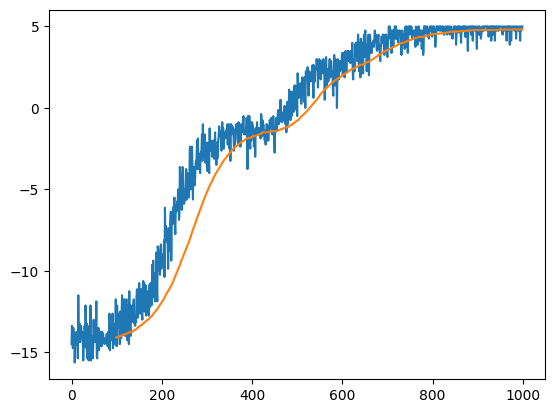

In [ ]:
import pandas as pd
plt.plot(mean_rewards)
plt.plot(pd.DataFrame(mean_rewards).rolling(window=100).mean());

👉 [training log for reference](https://gist.github.com/Nov05/06e036287595f428c07546a352e32e14)  

# **Game visualization - trained**  


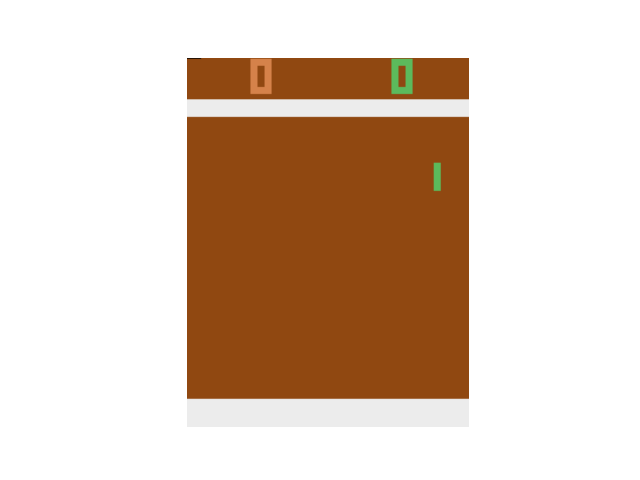
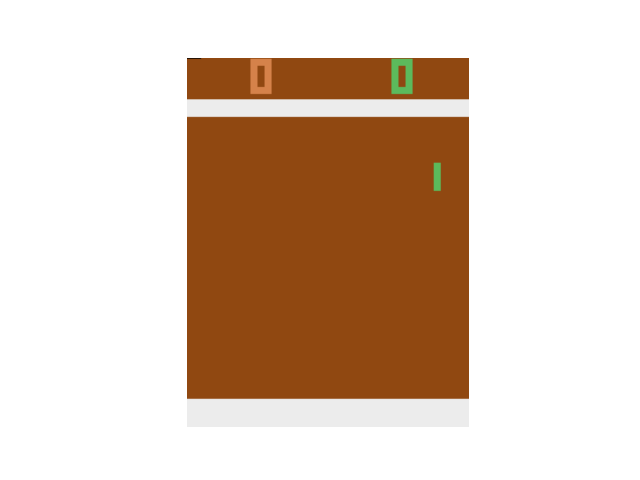
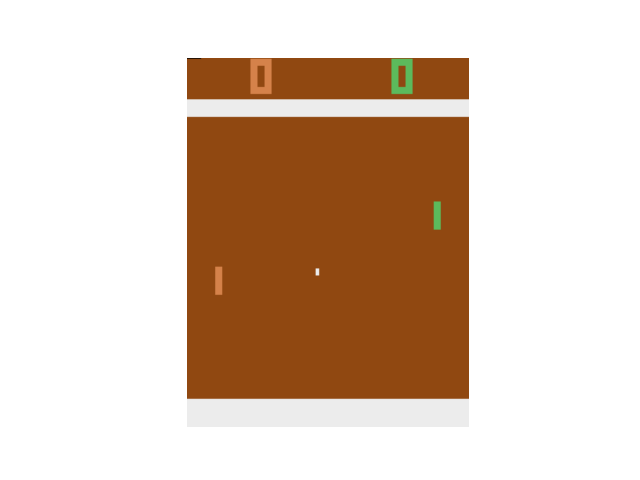
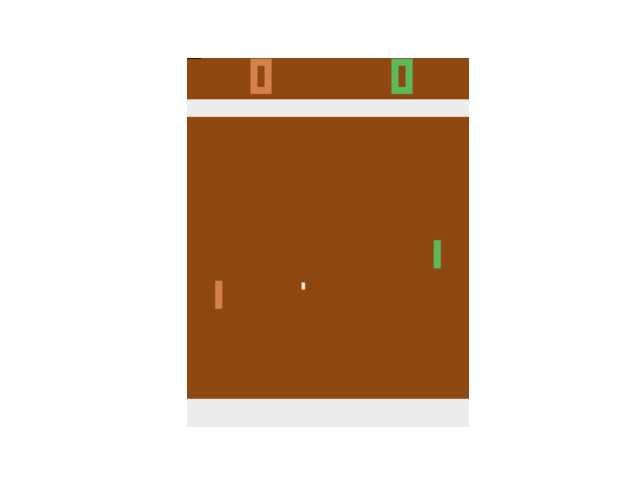
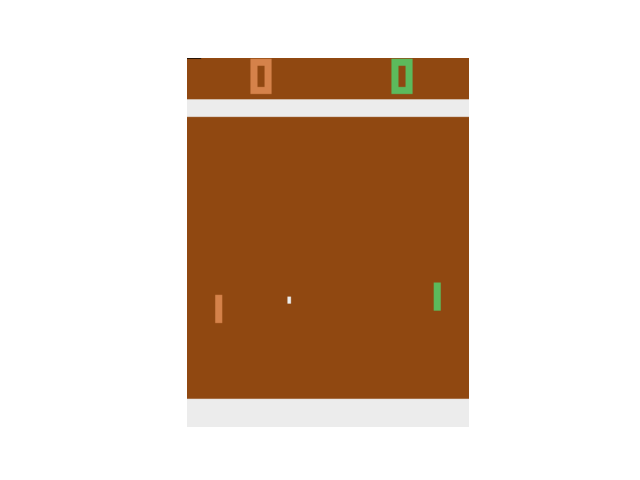
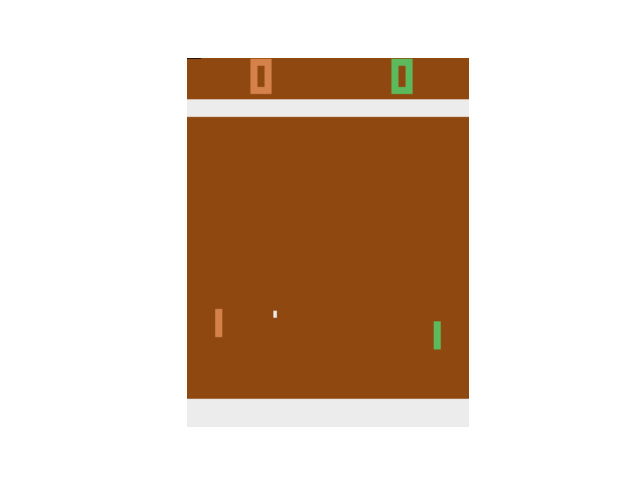
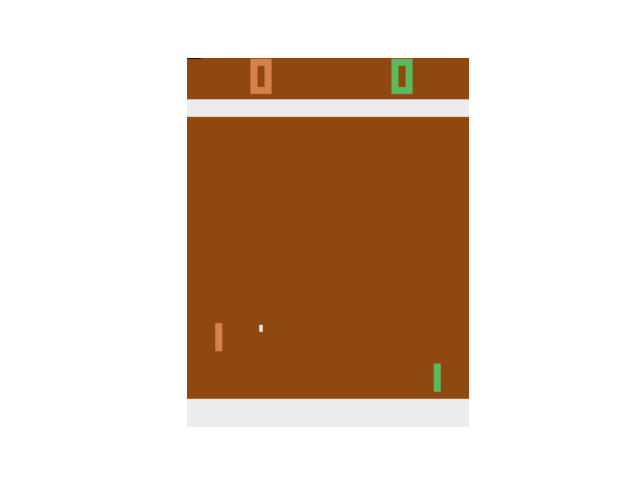
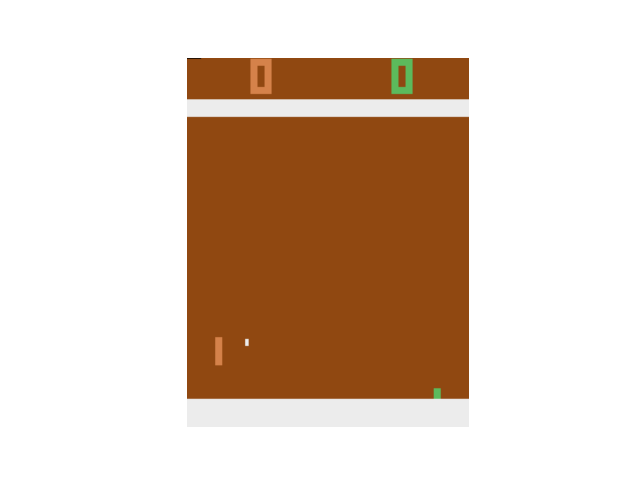
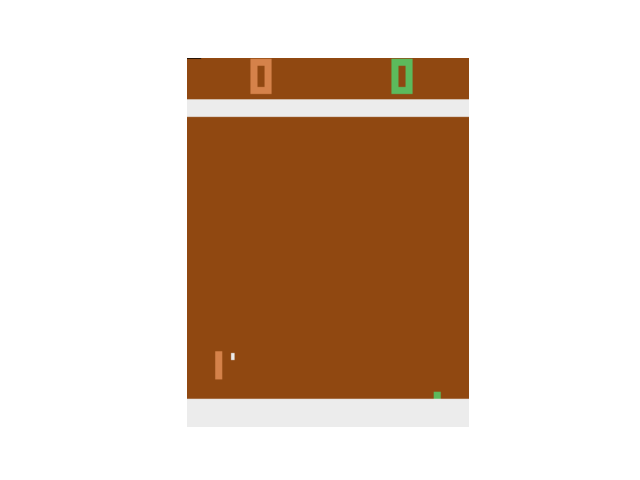
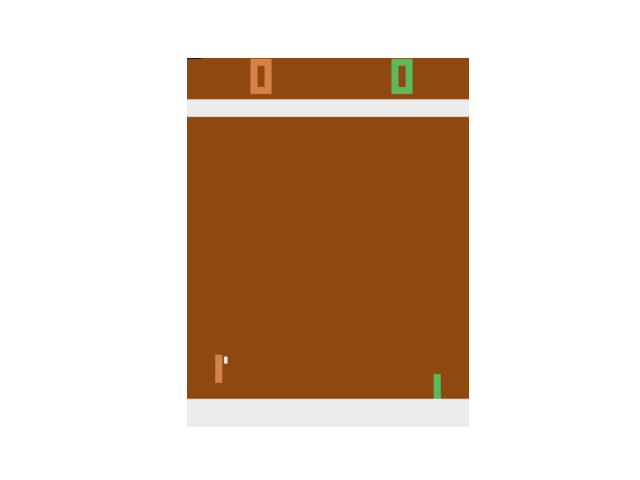
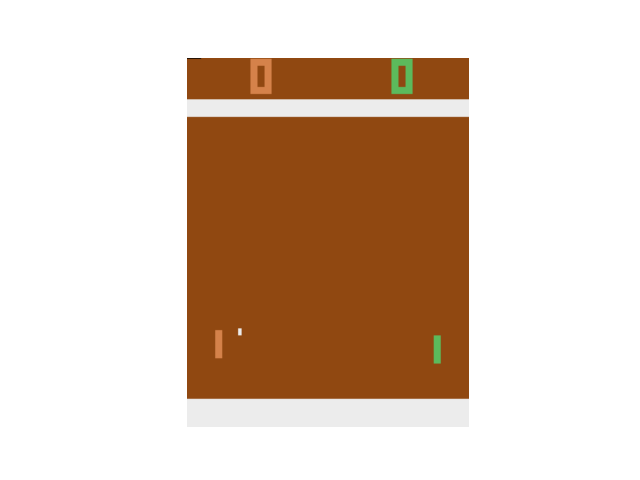
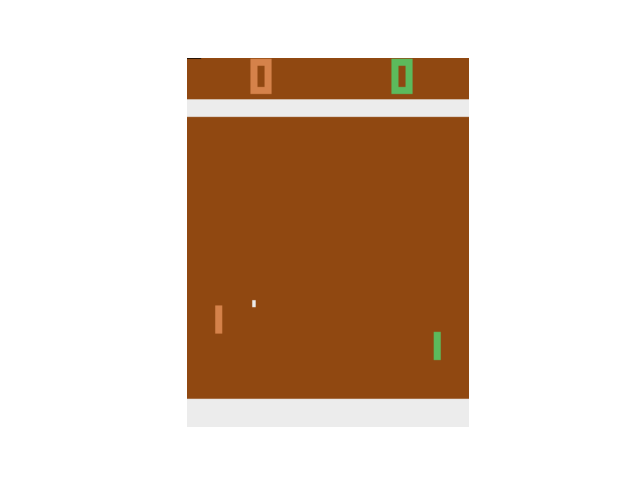
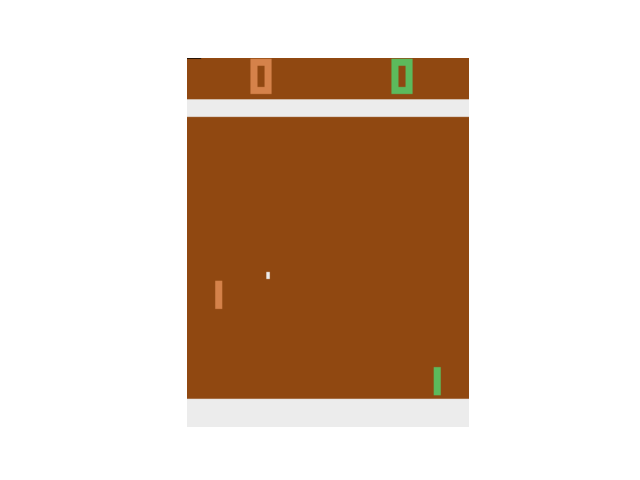
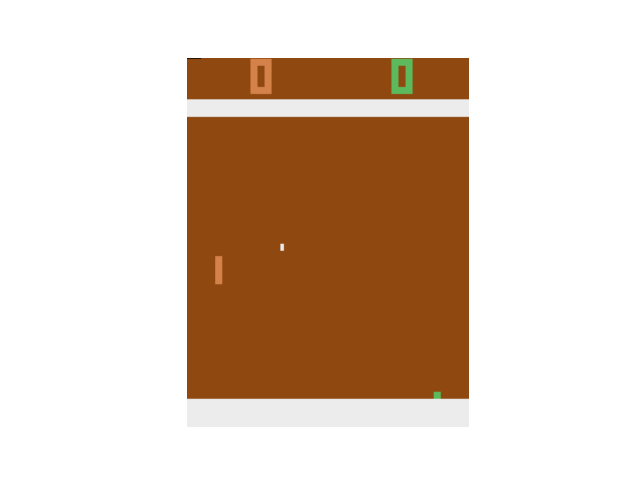
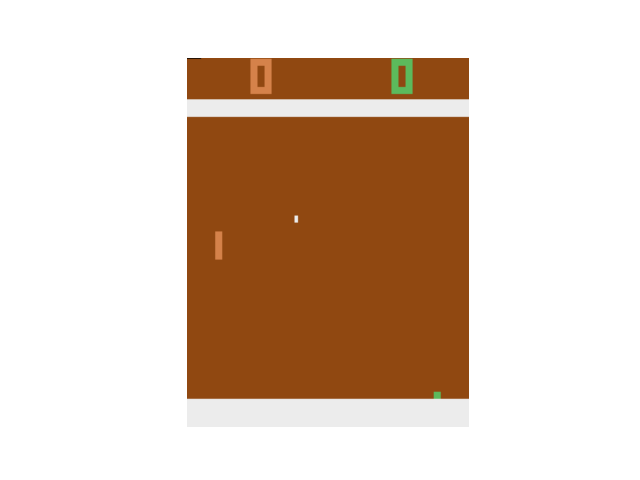
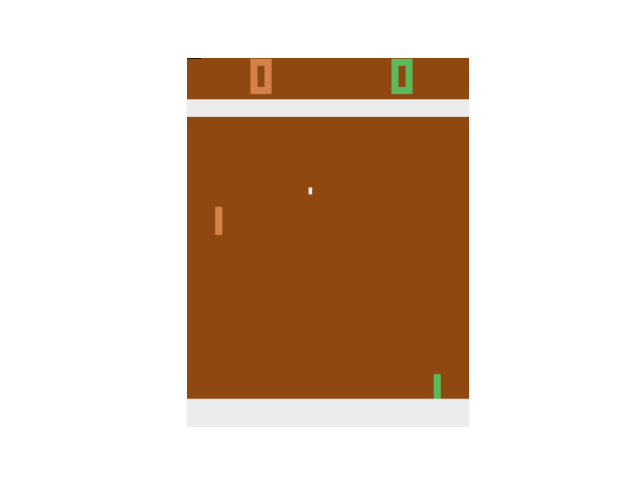
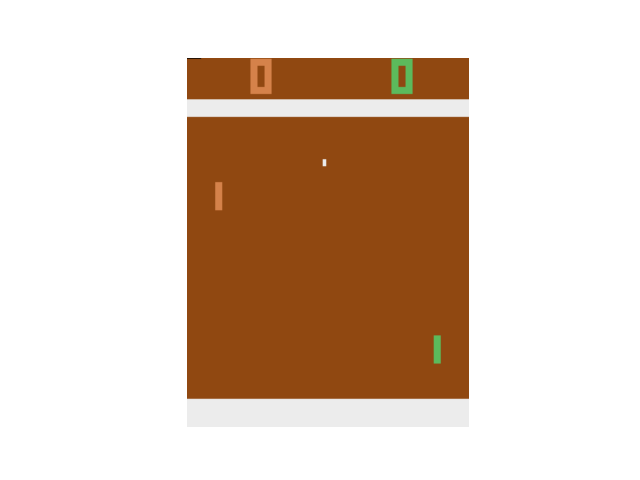
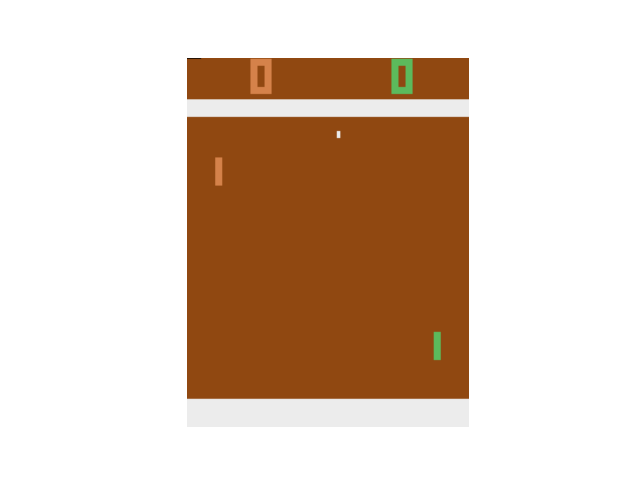
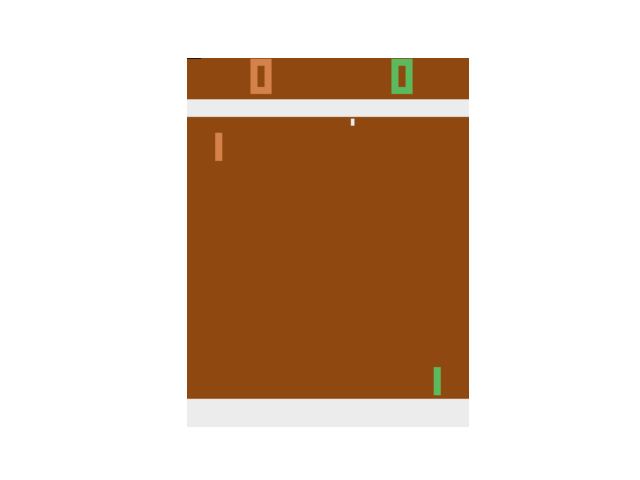
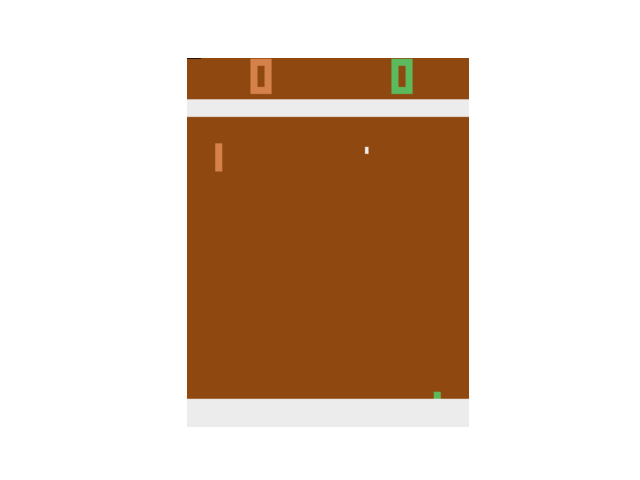
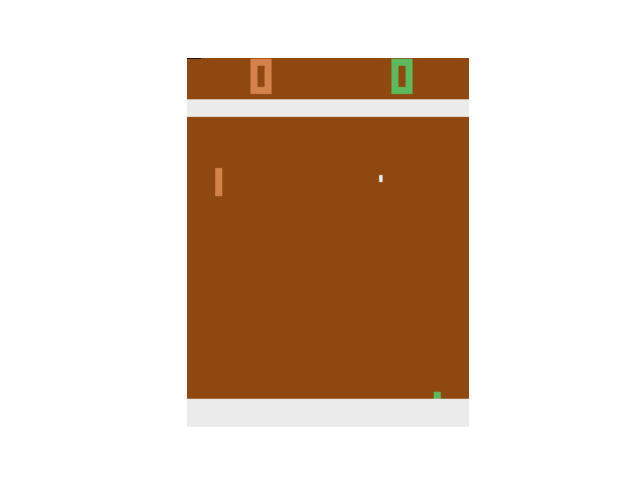
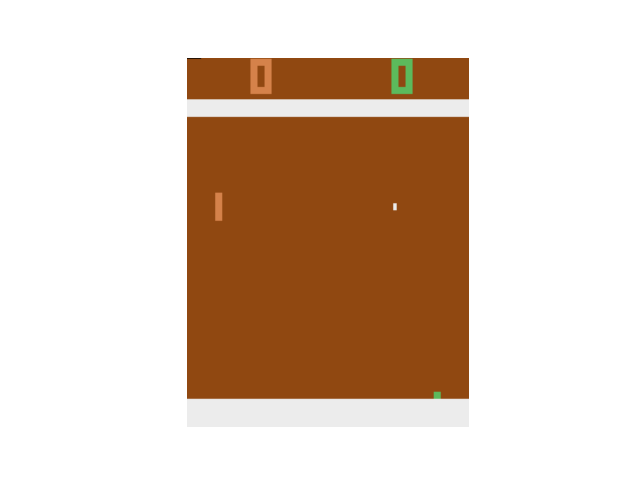
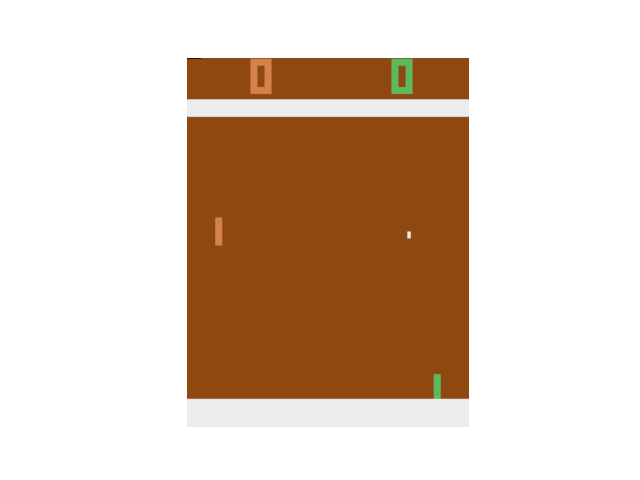
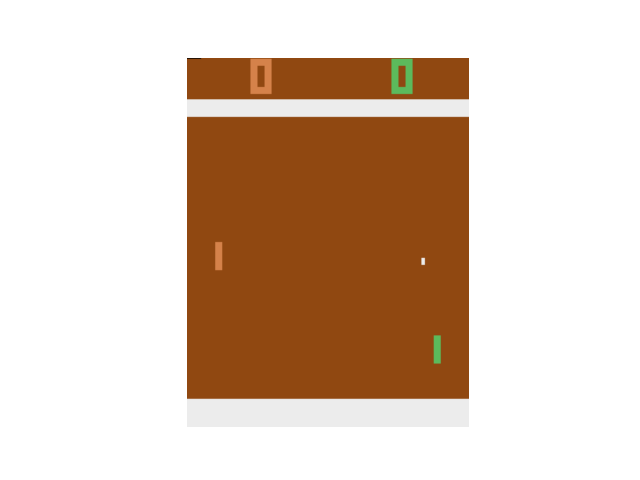
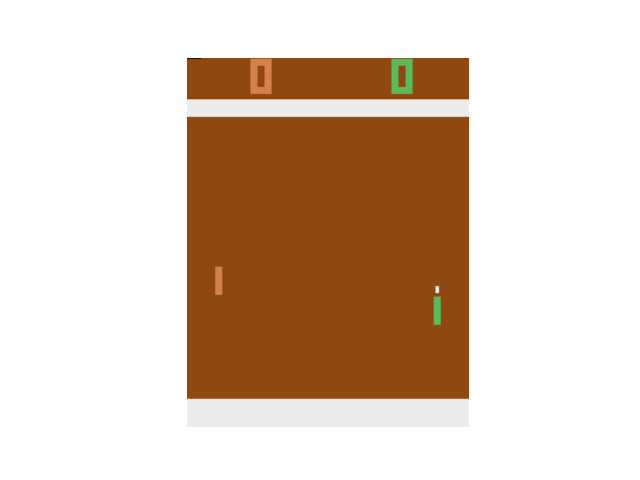
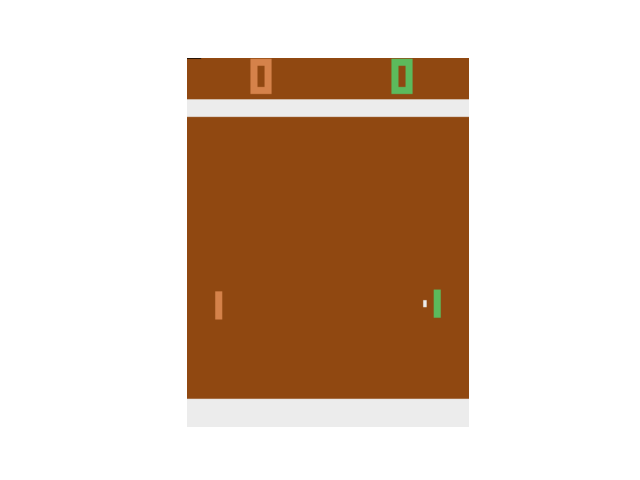
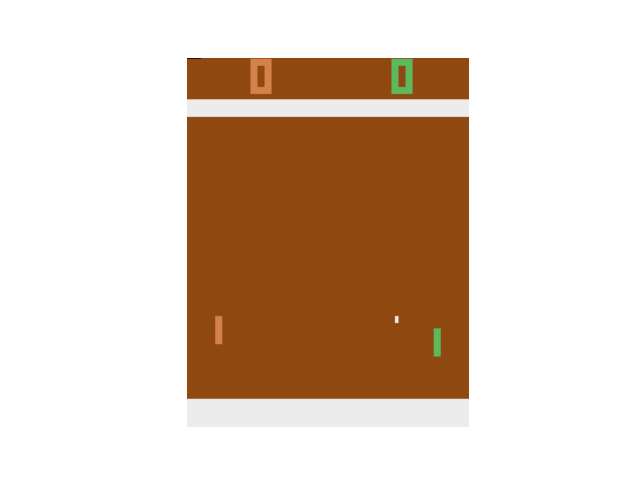
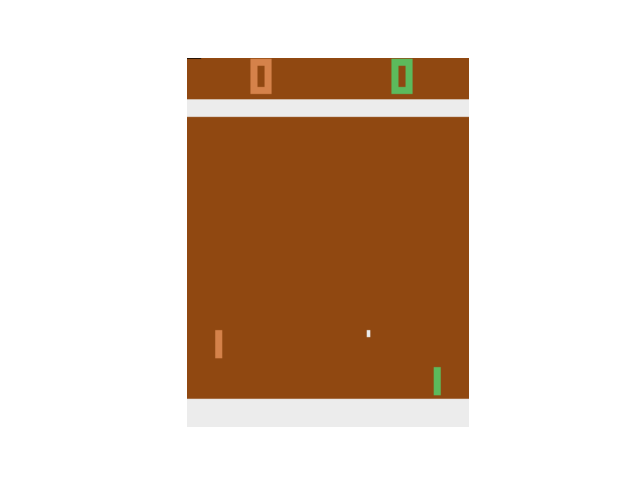
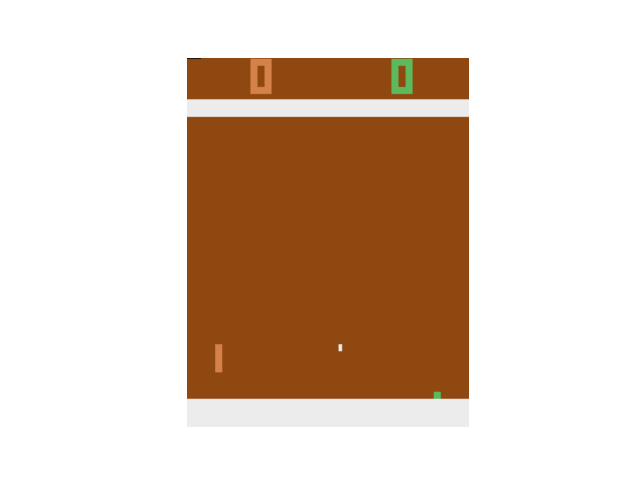
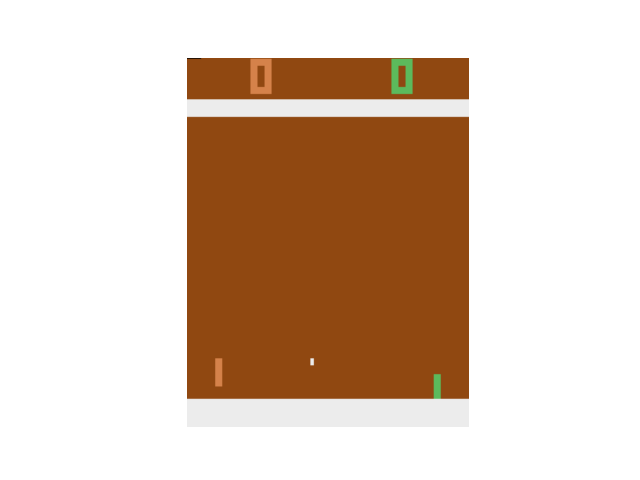
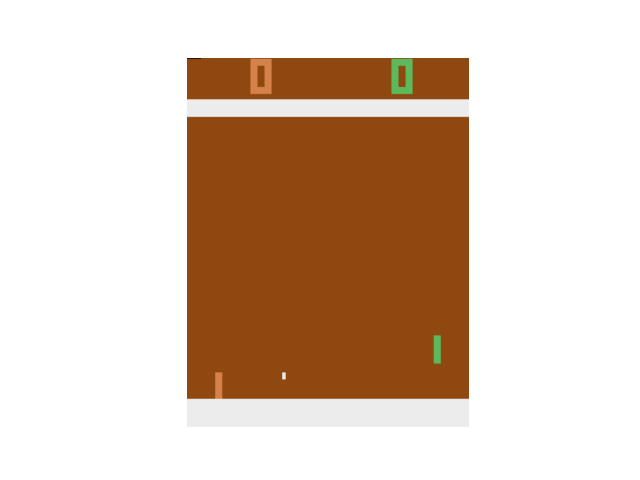
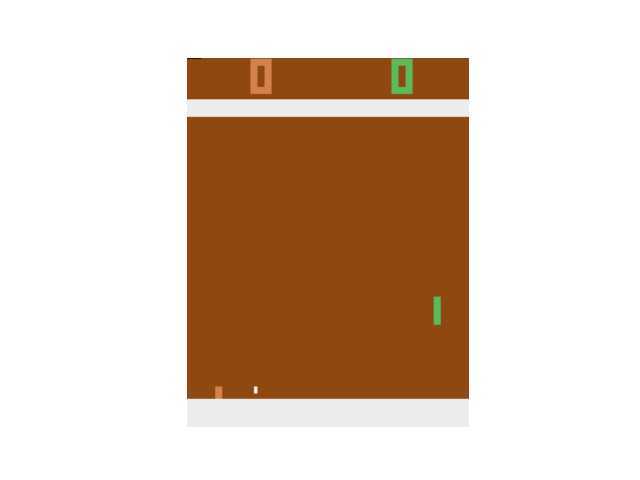
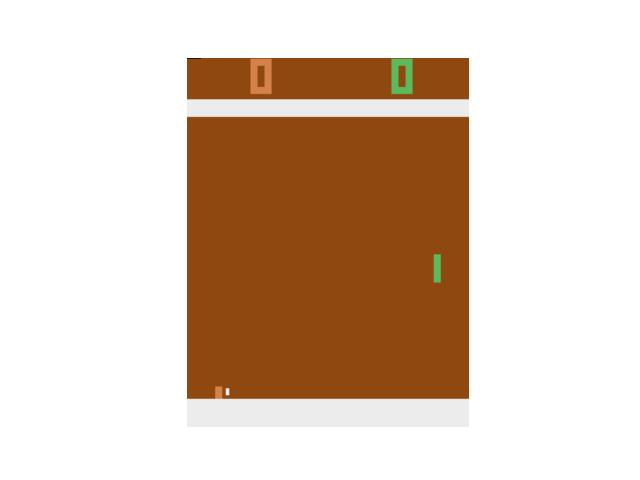
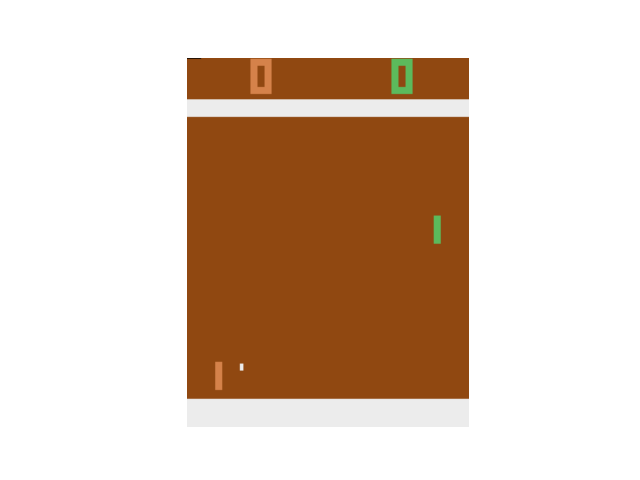
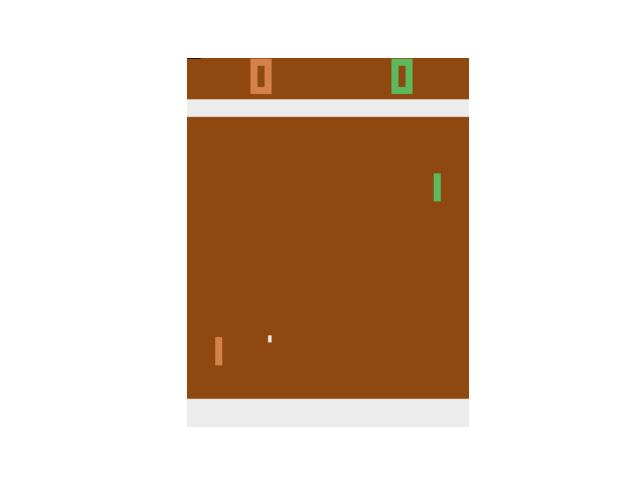
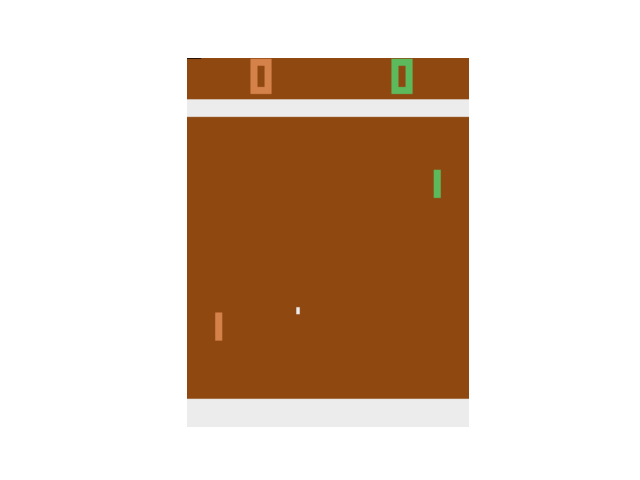
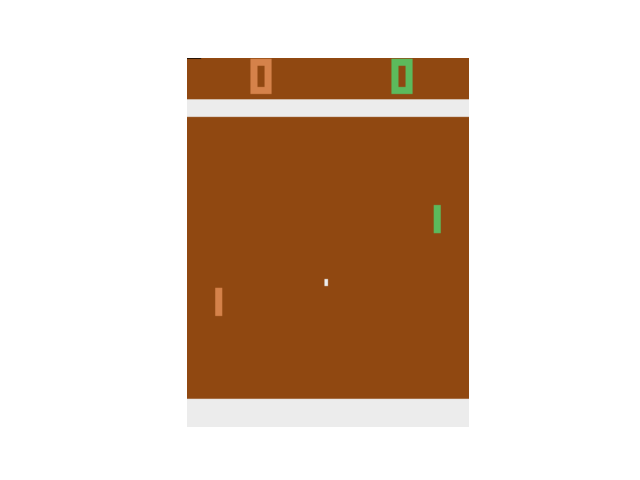
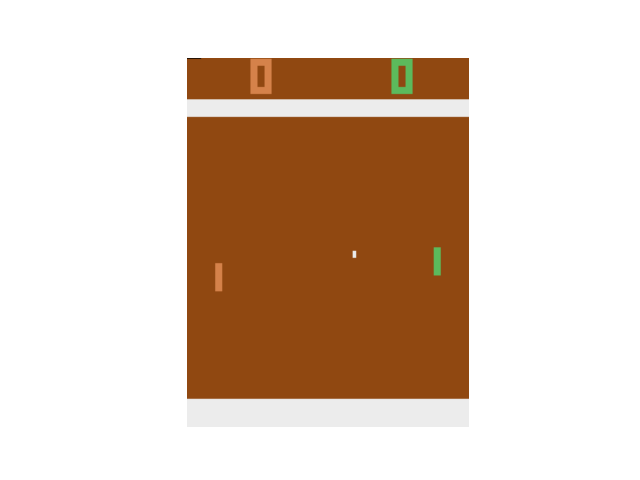
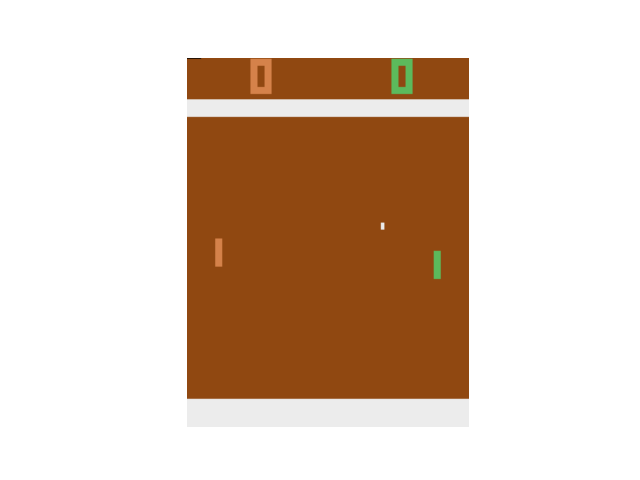
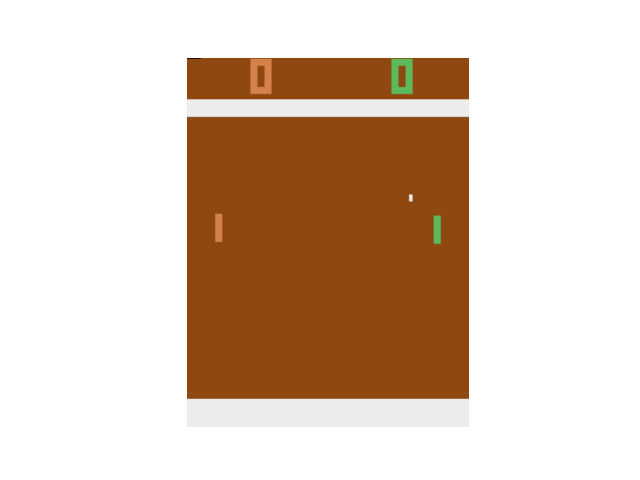
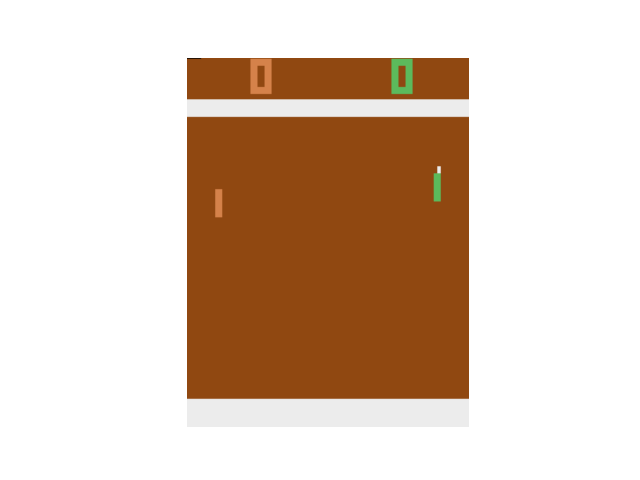
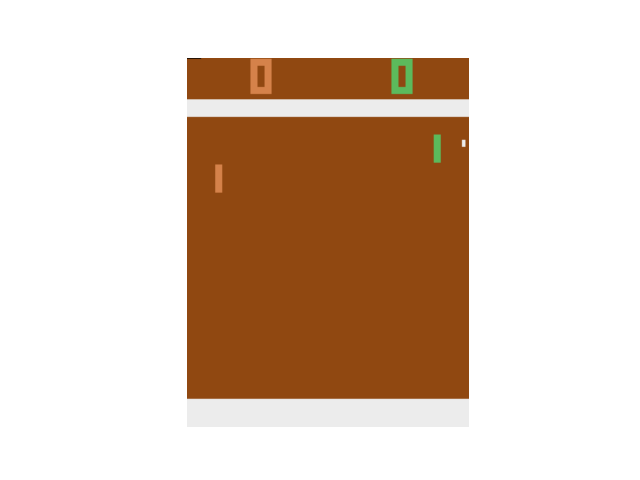
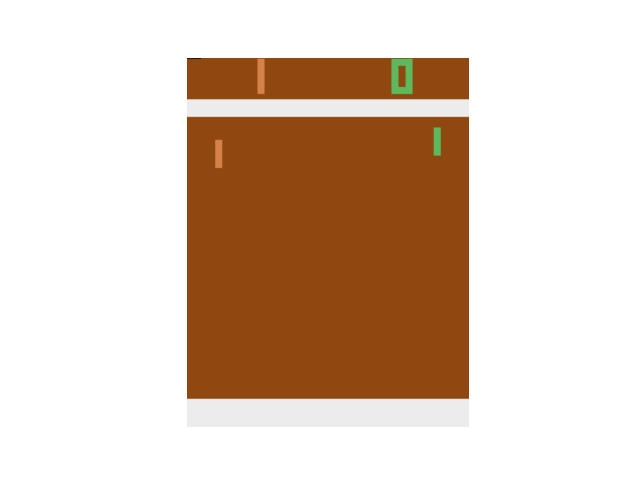
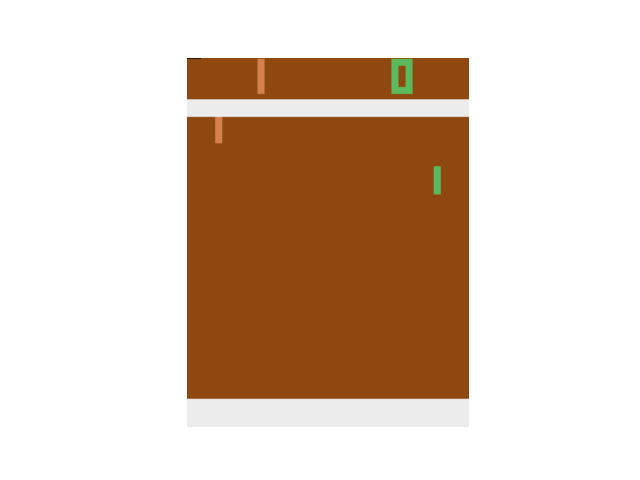
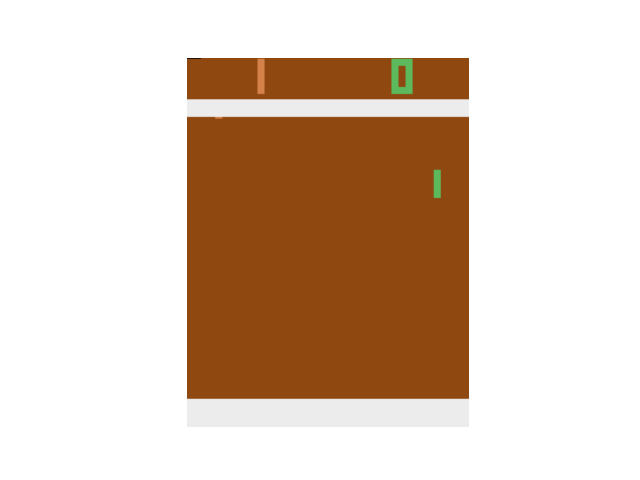
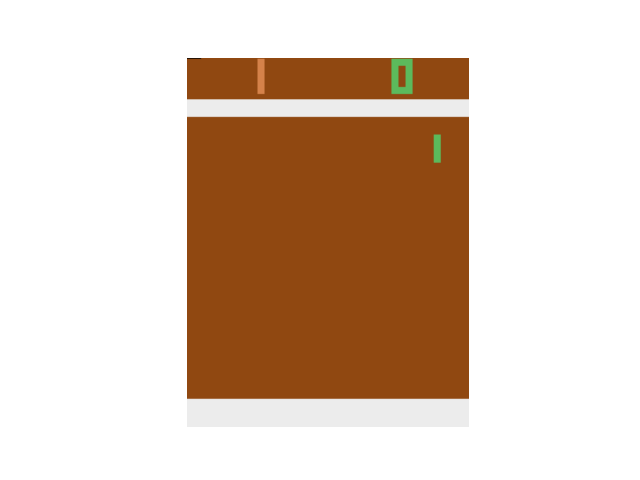
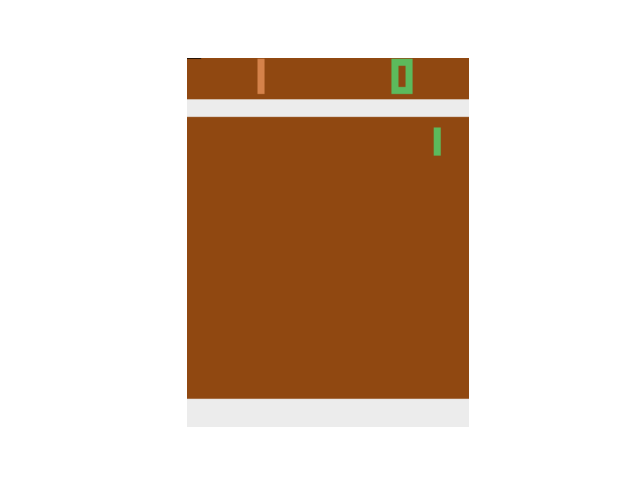
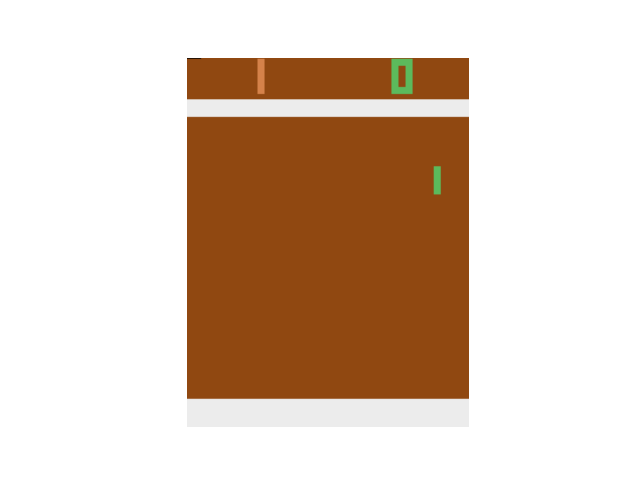
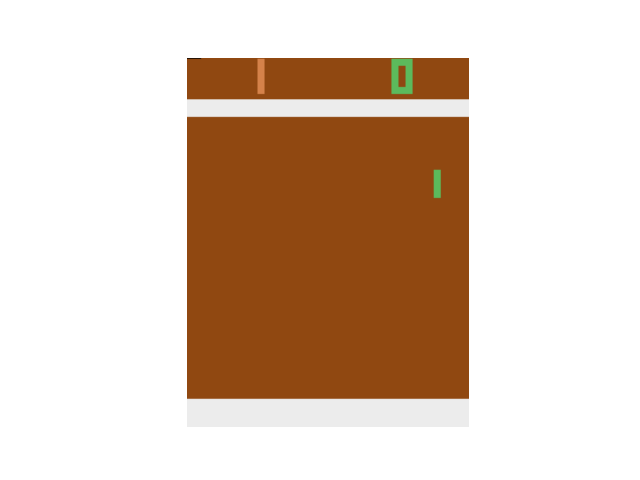
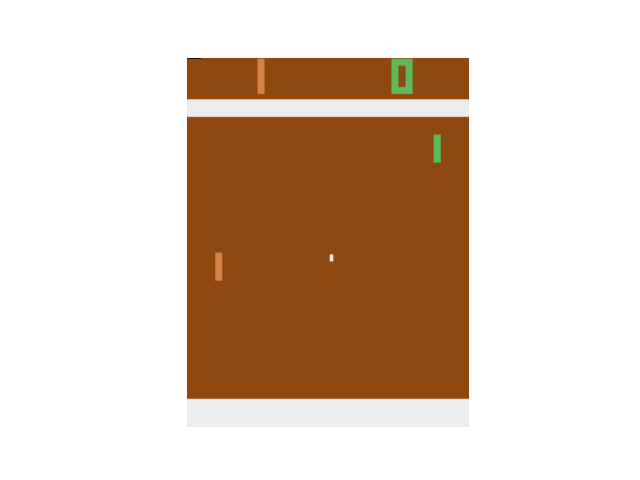
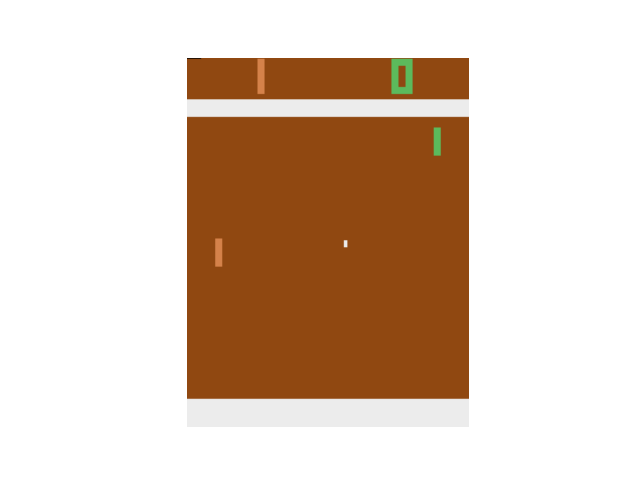
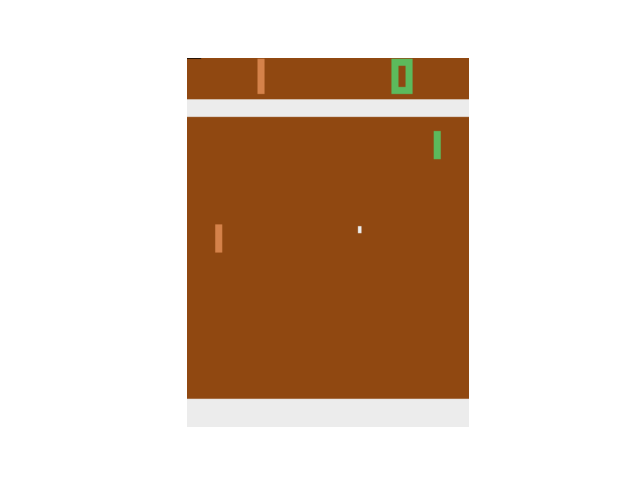
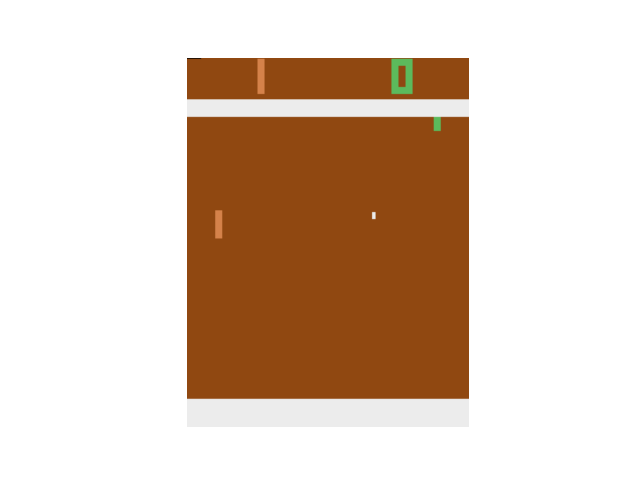
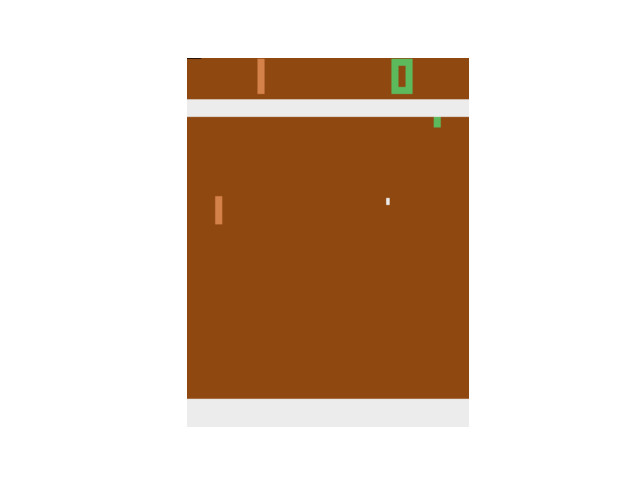
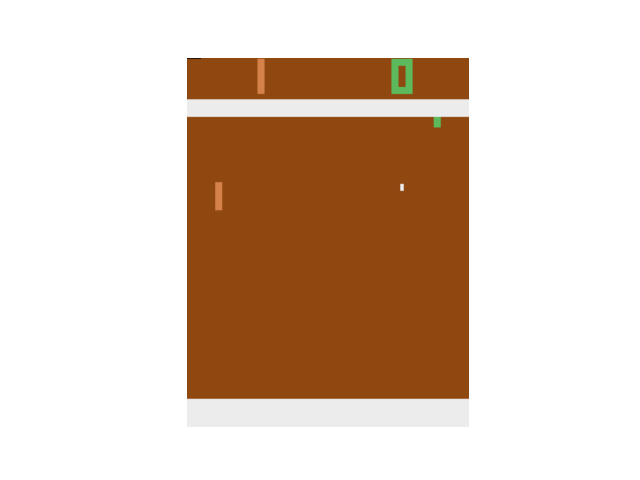
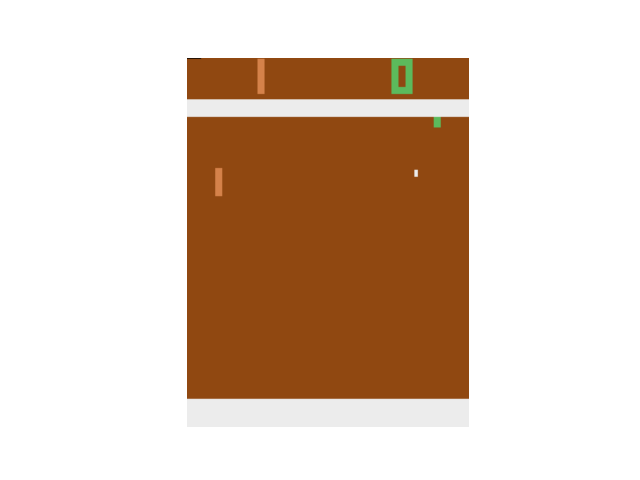
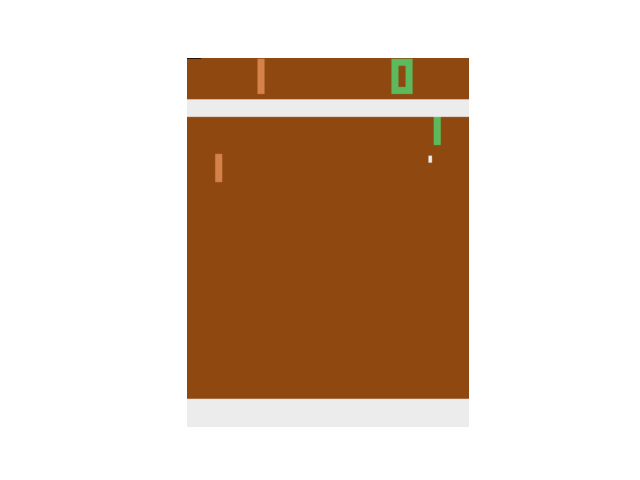
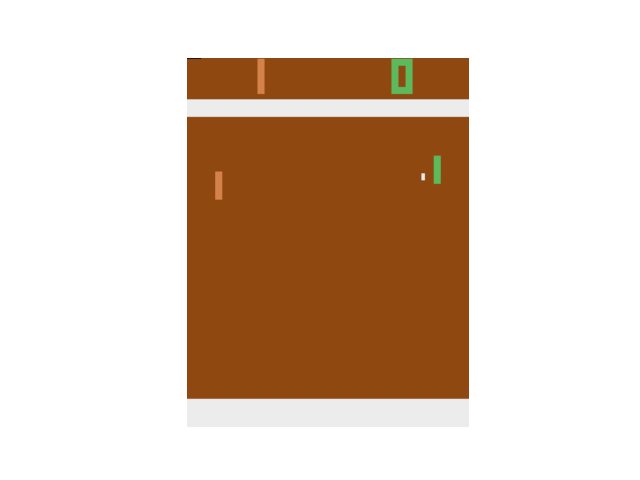
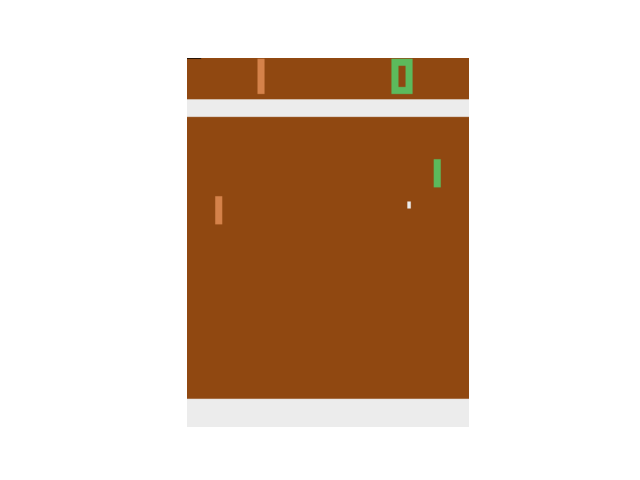
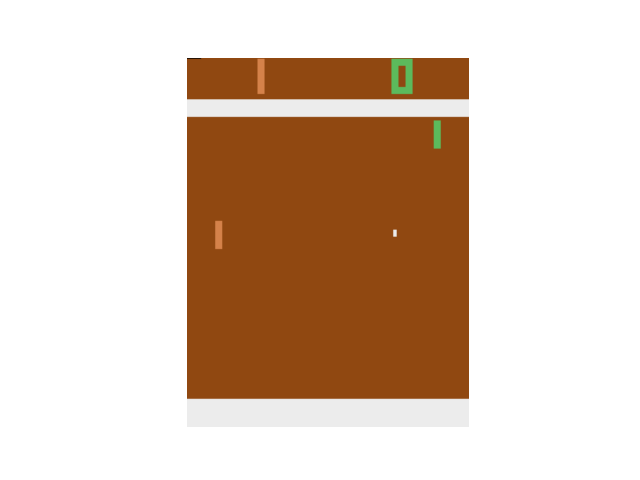
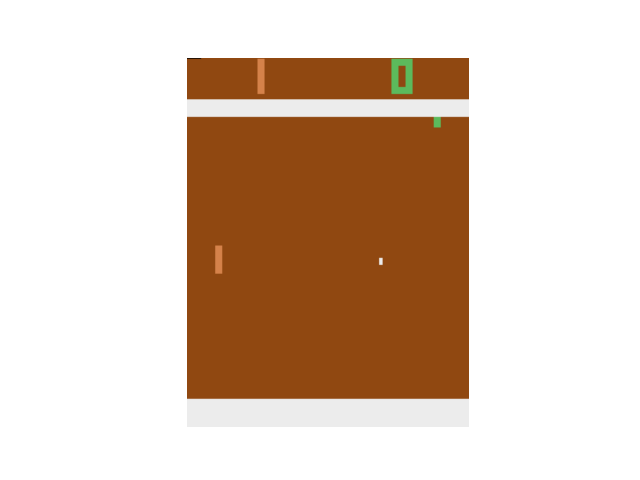
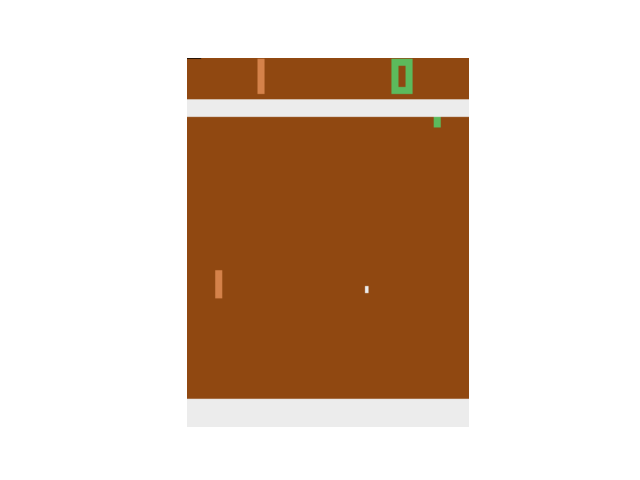
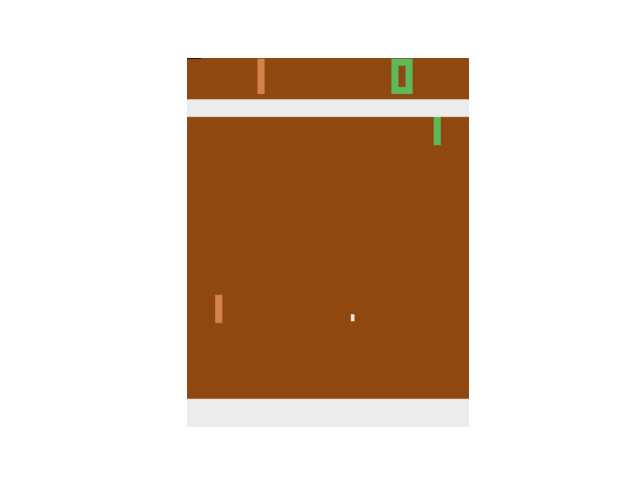
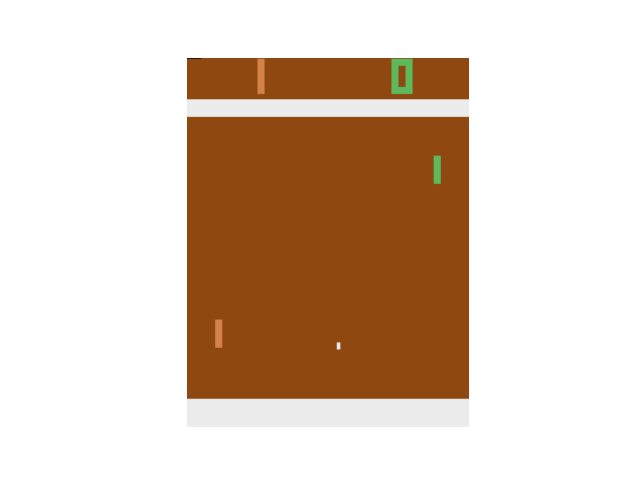
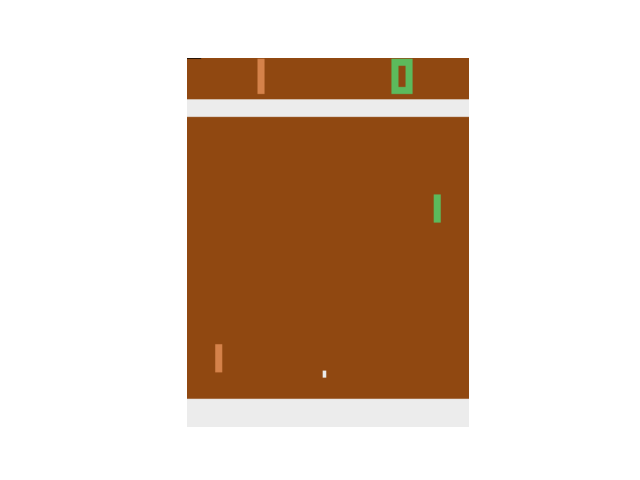
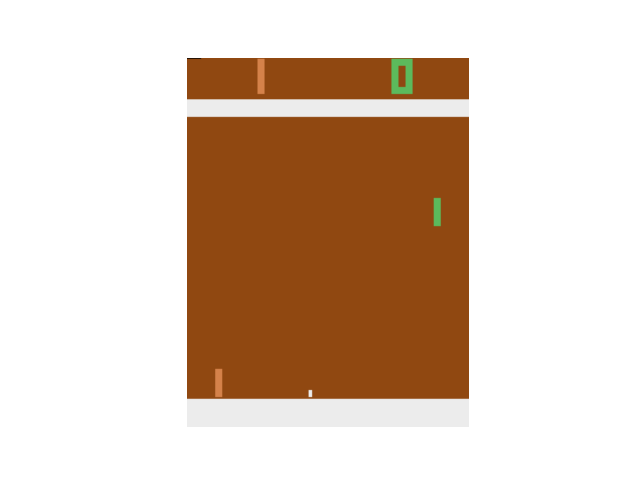
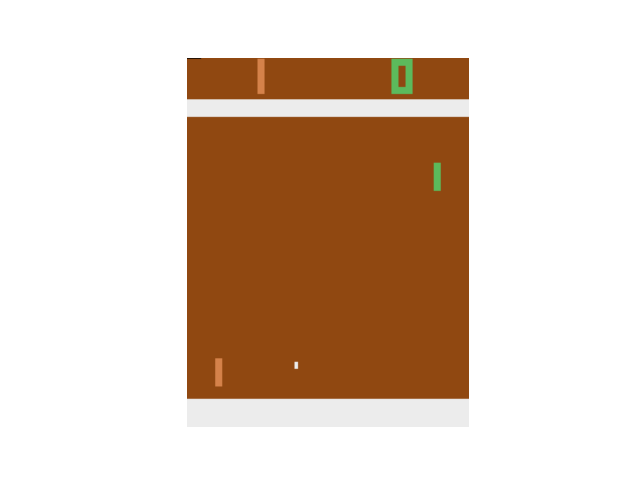
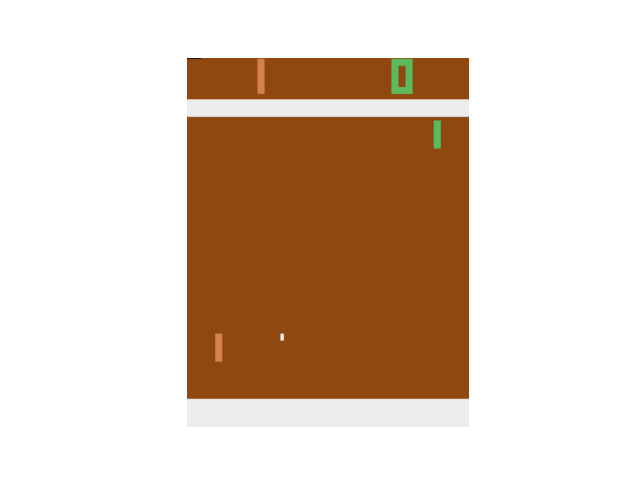
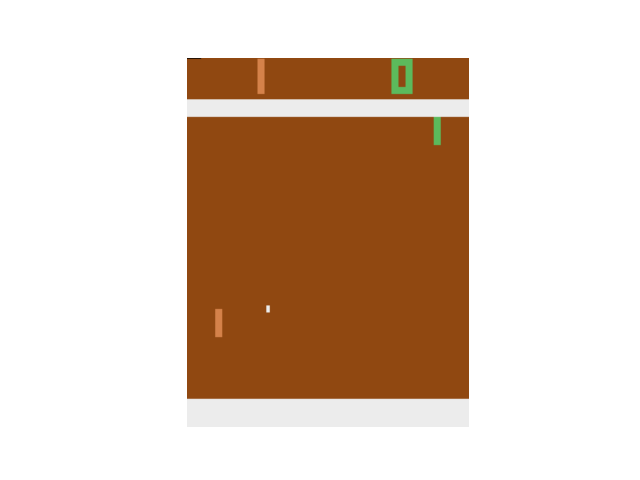
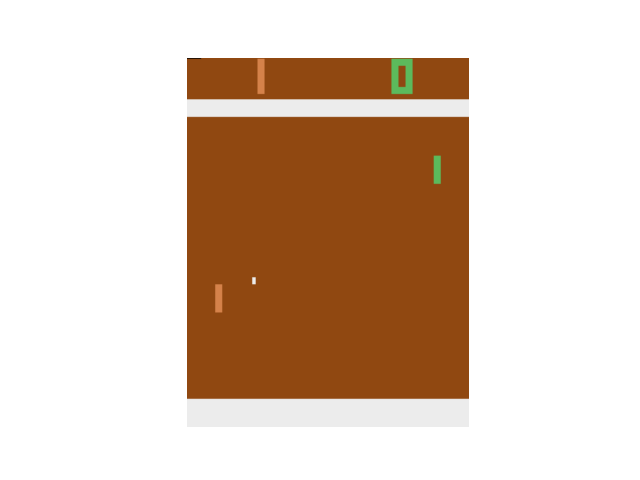
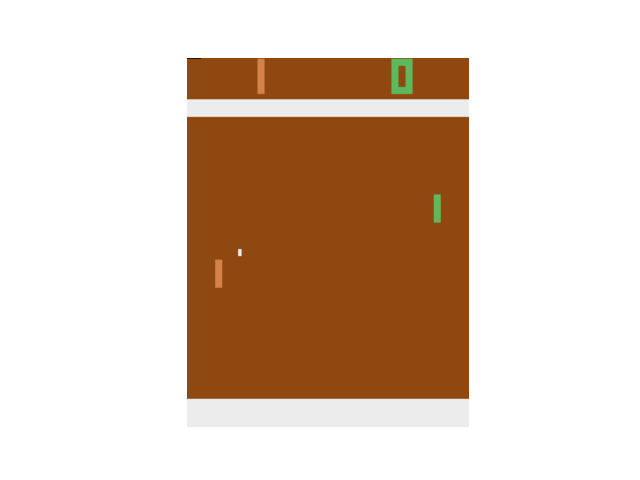
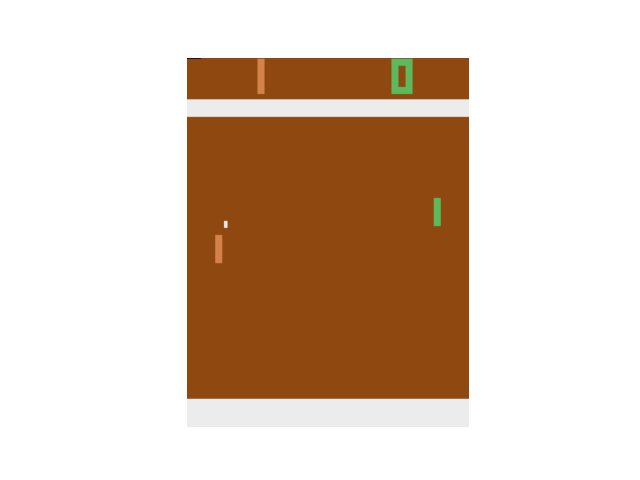
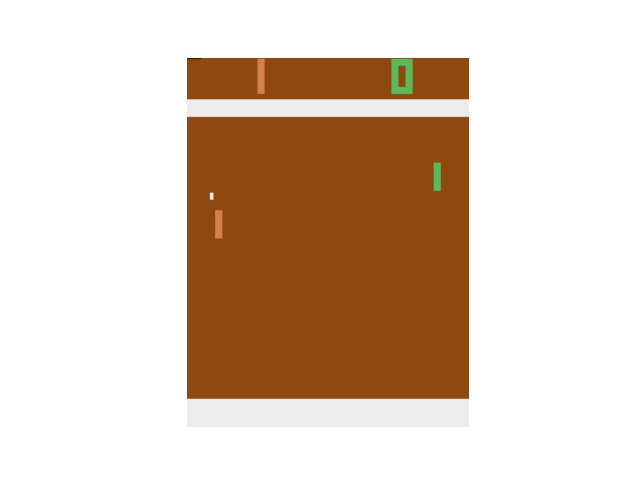
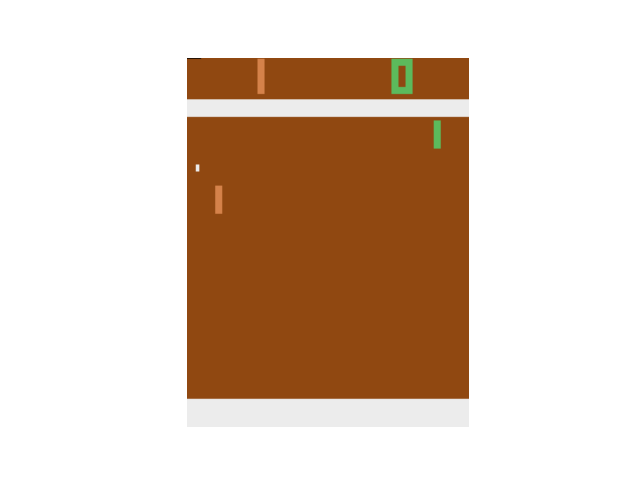
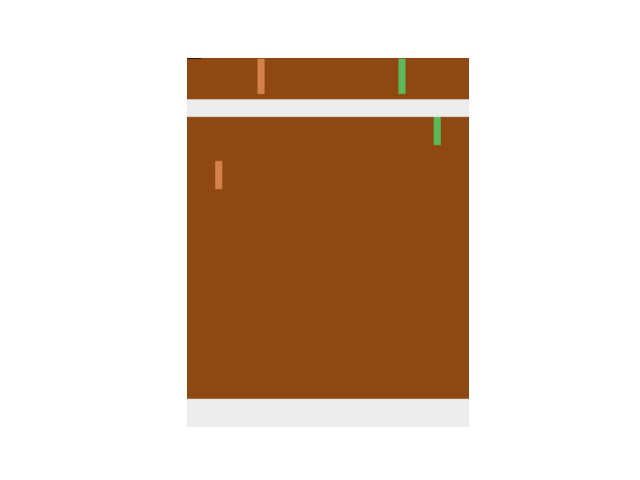
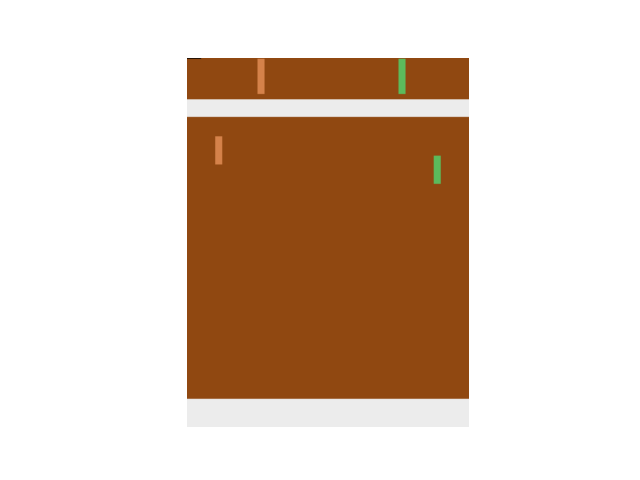
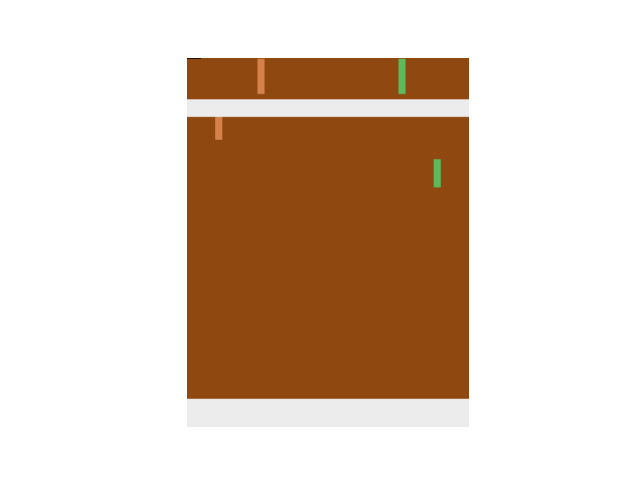
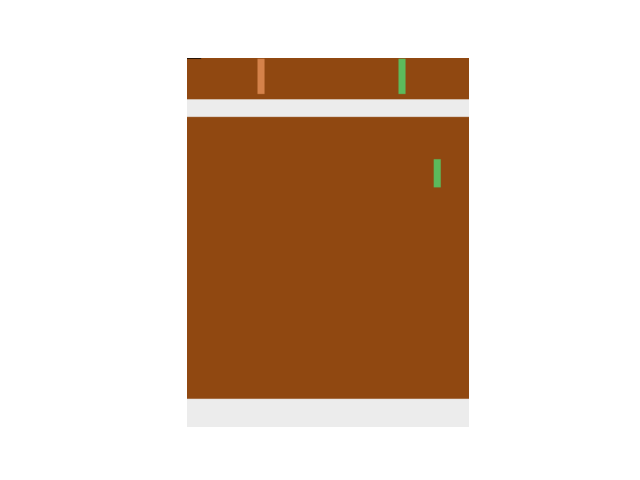
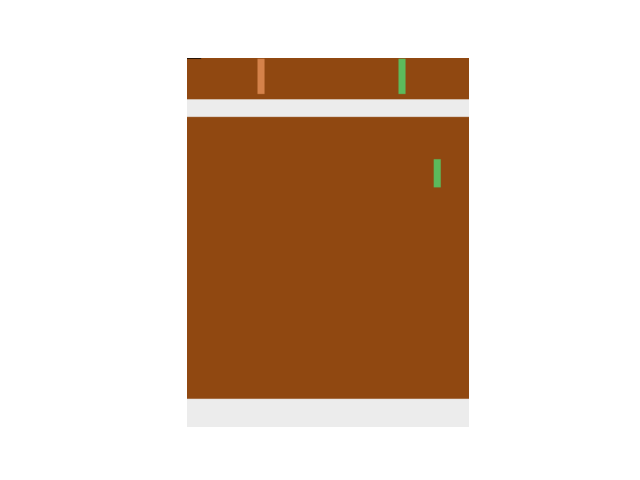
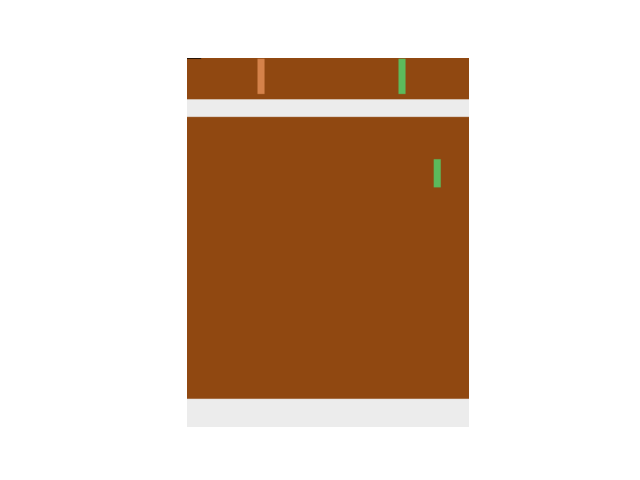
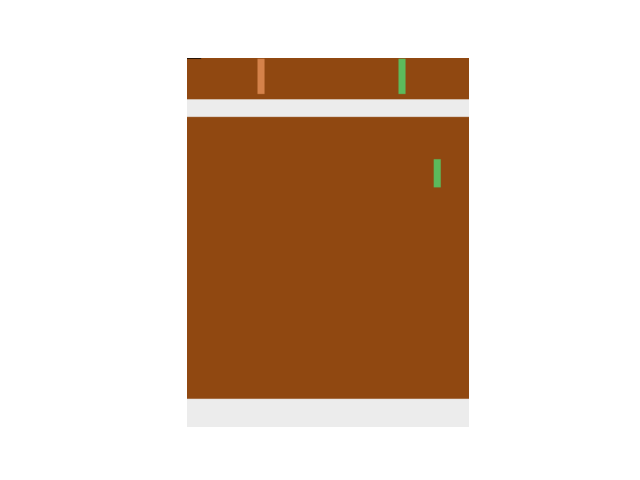
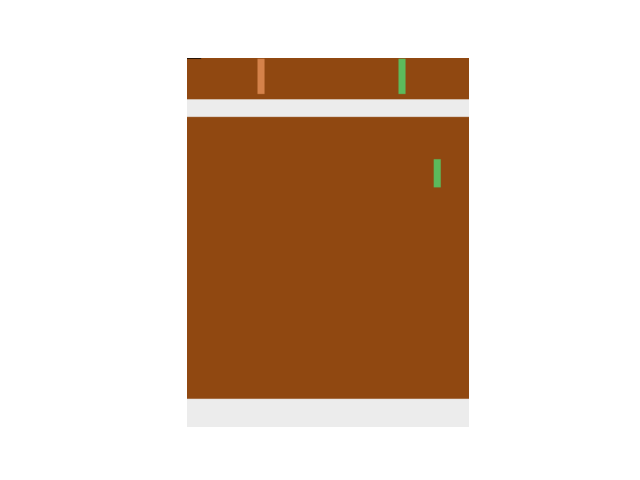
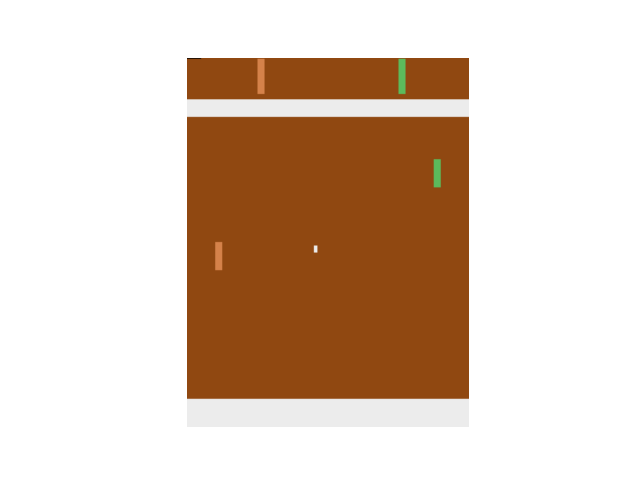
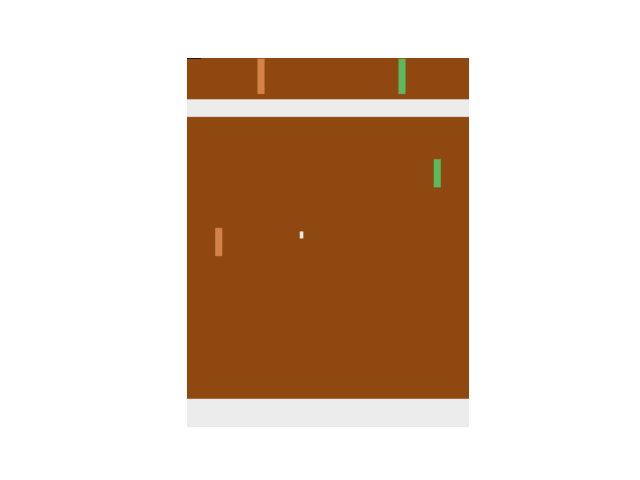
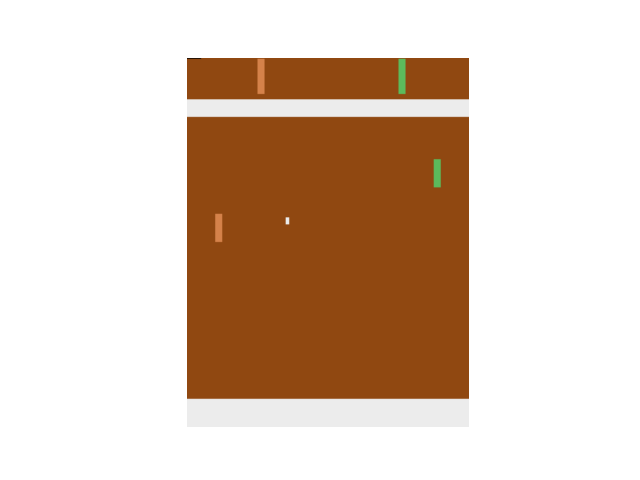
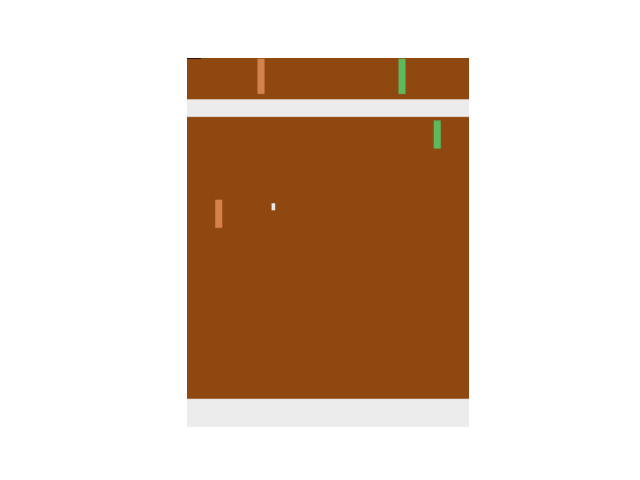
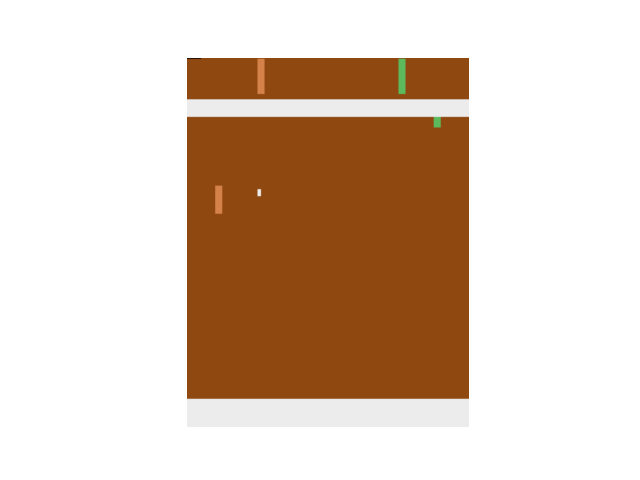
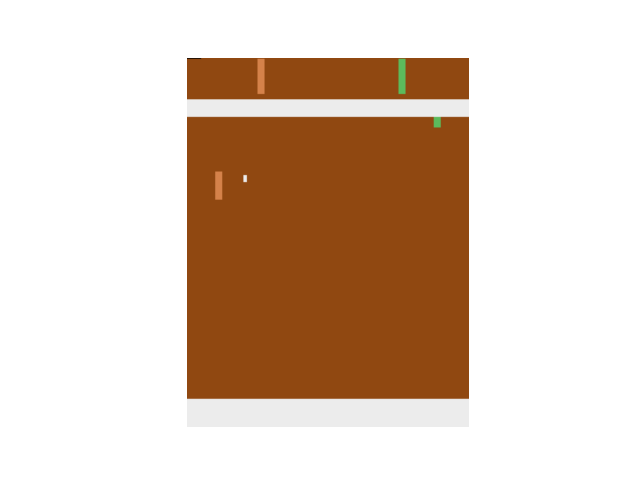
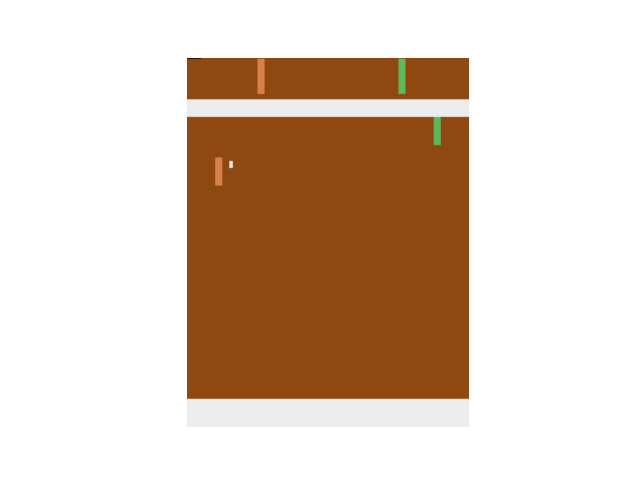
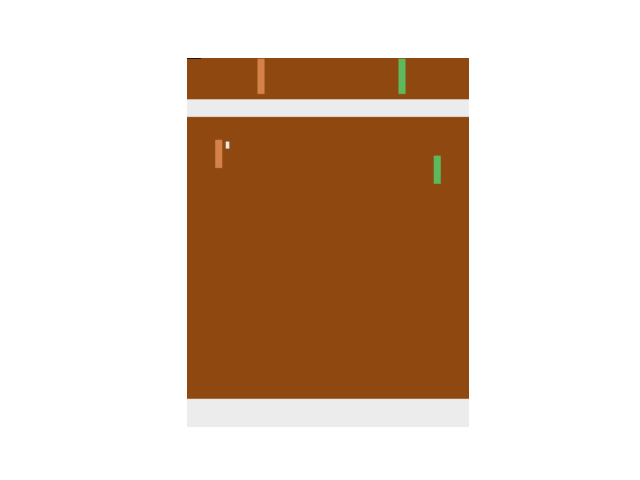
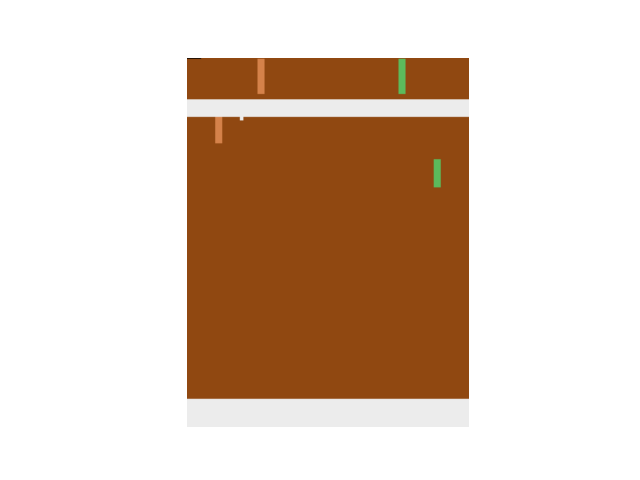
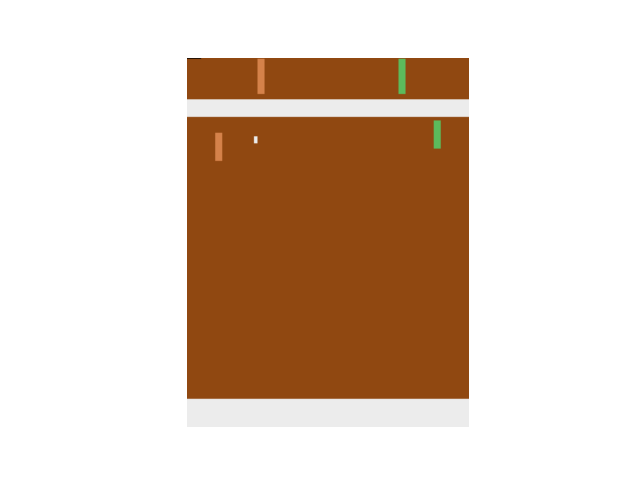
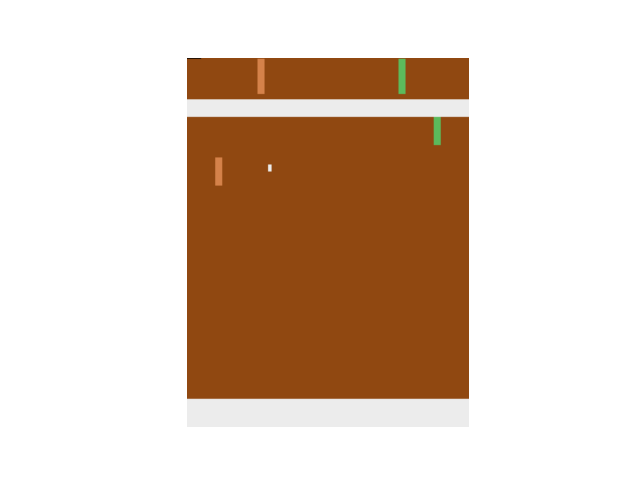
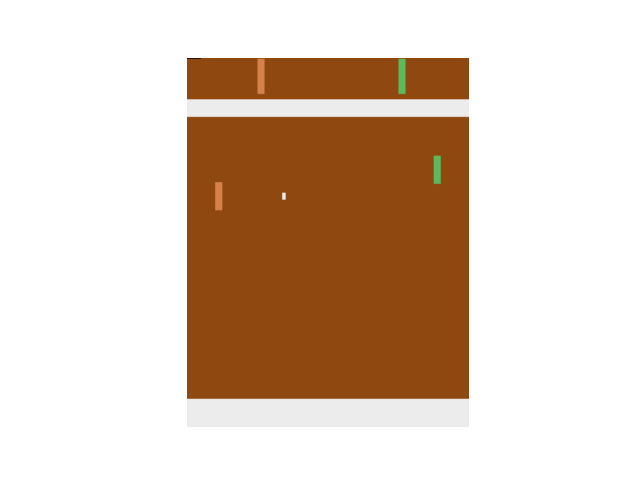
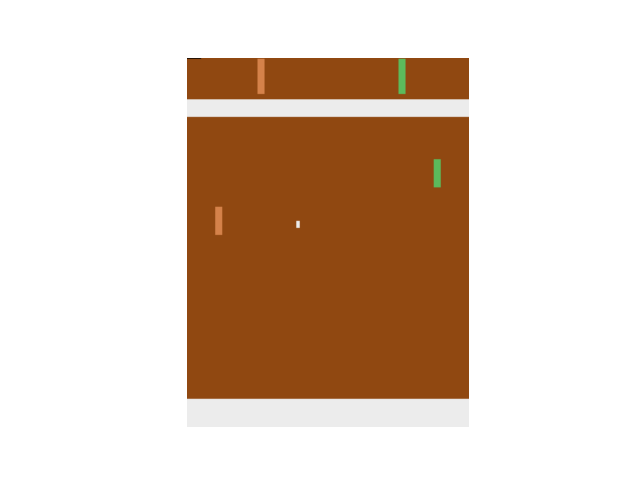
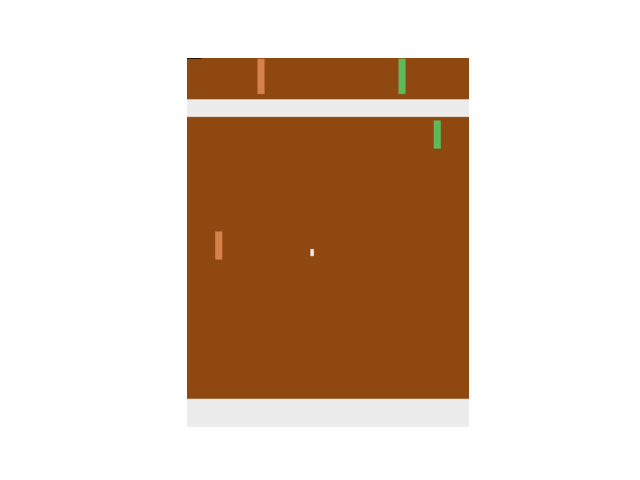
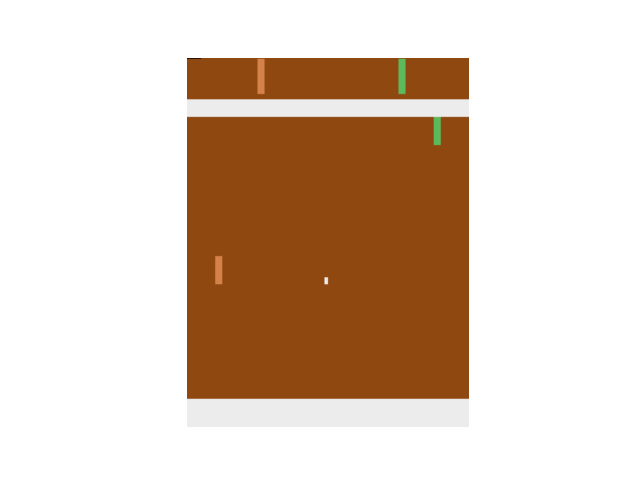
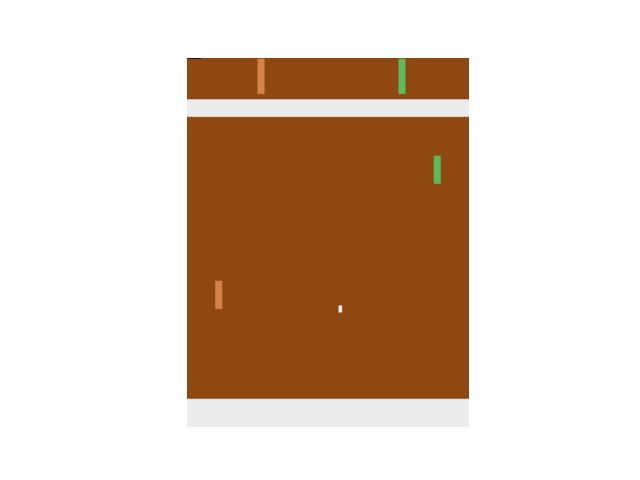
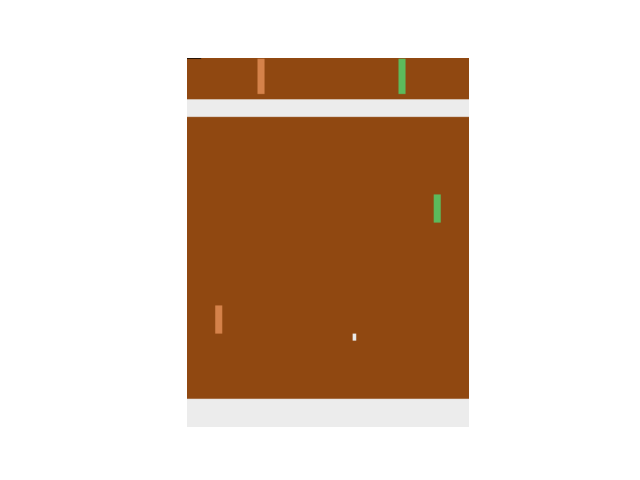
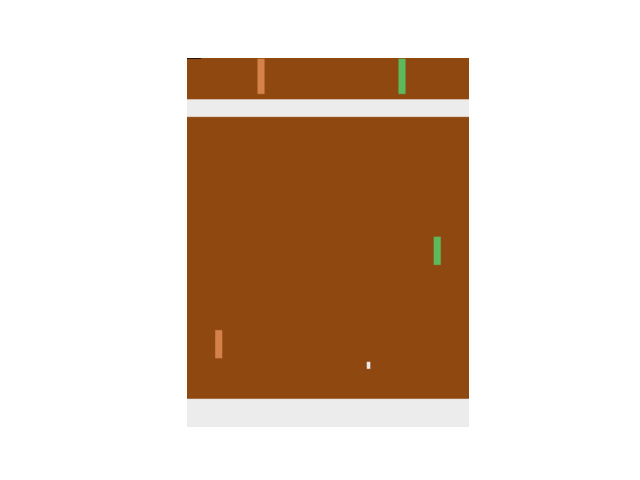
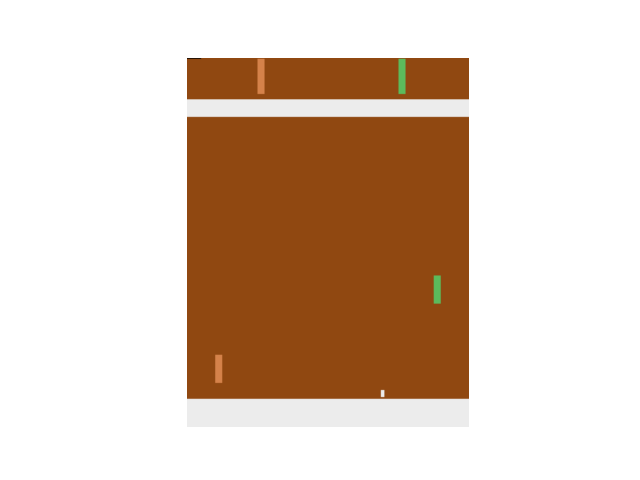
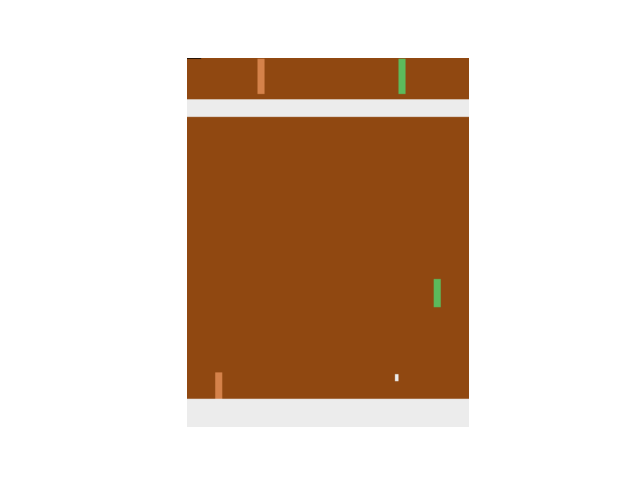
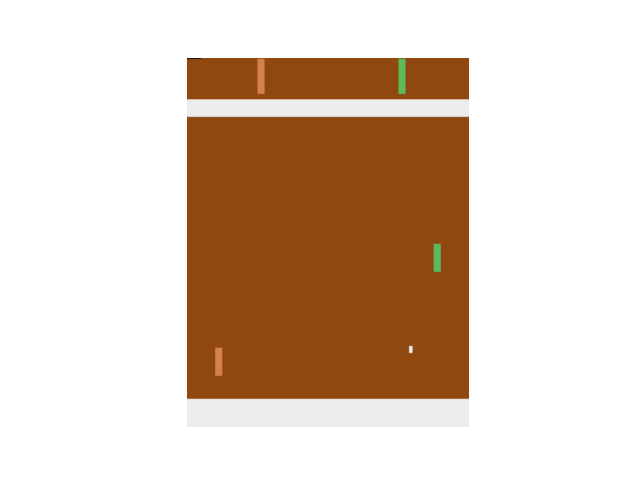
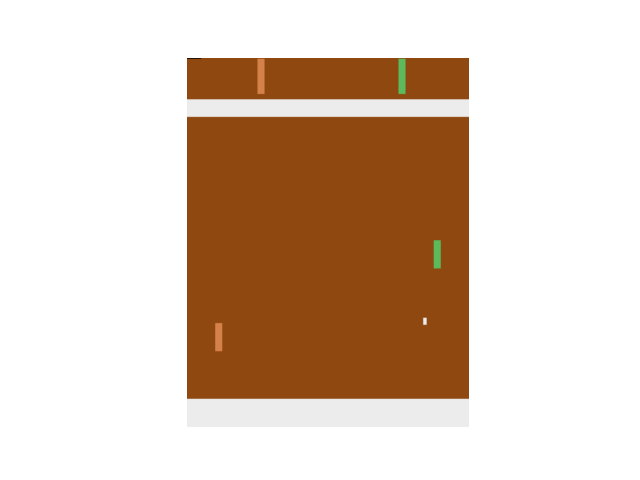
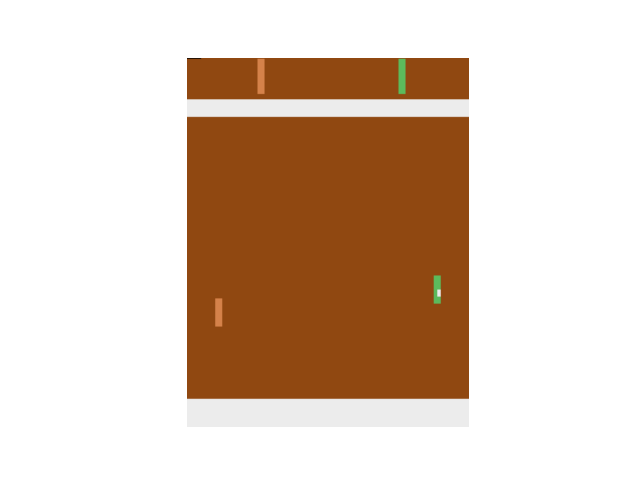
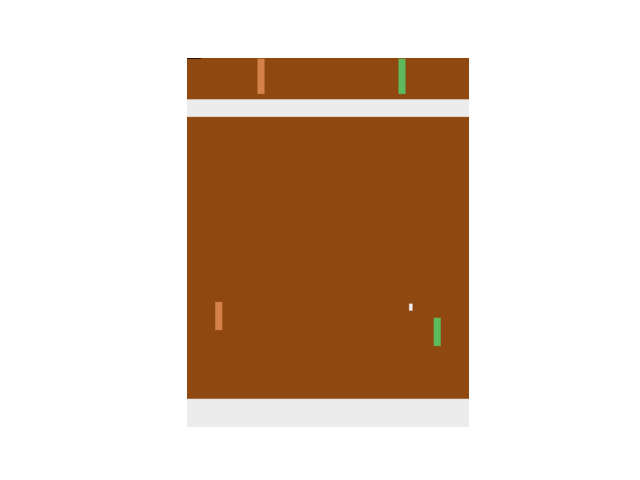
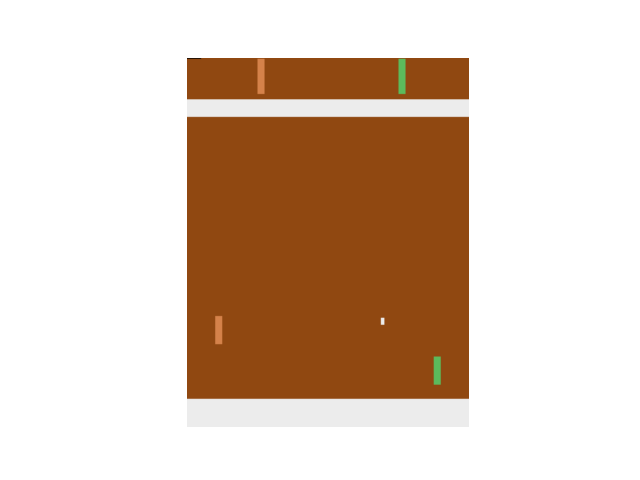
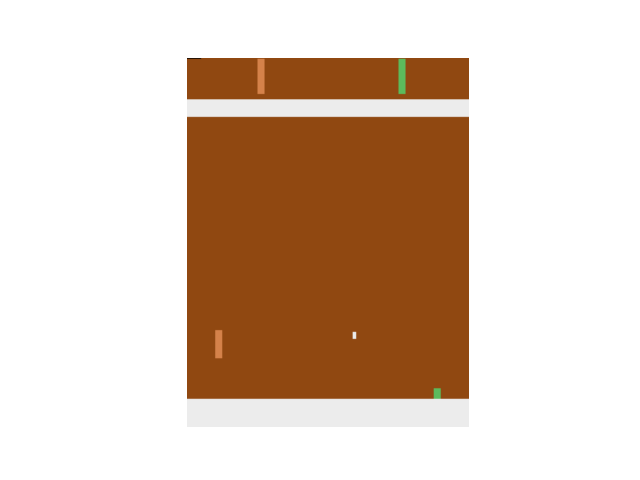
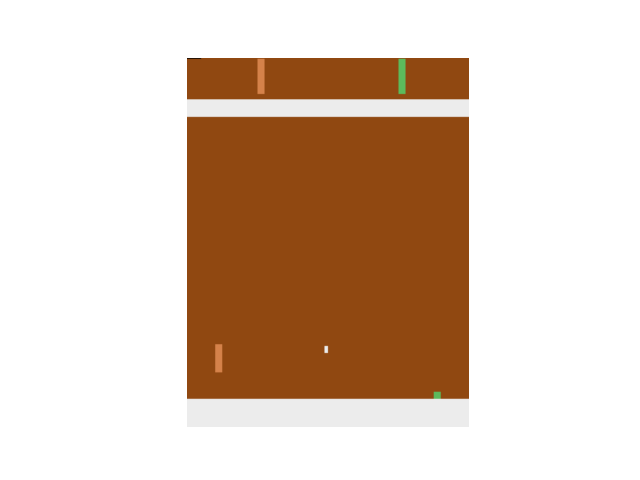
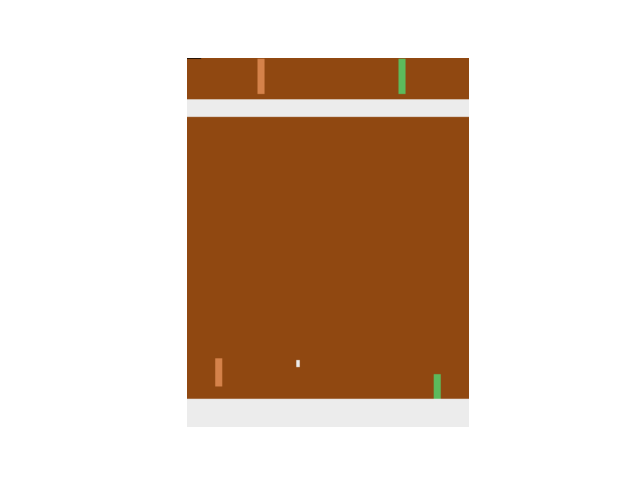
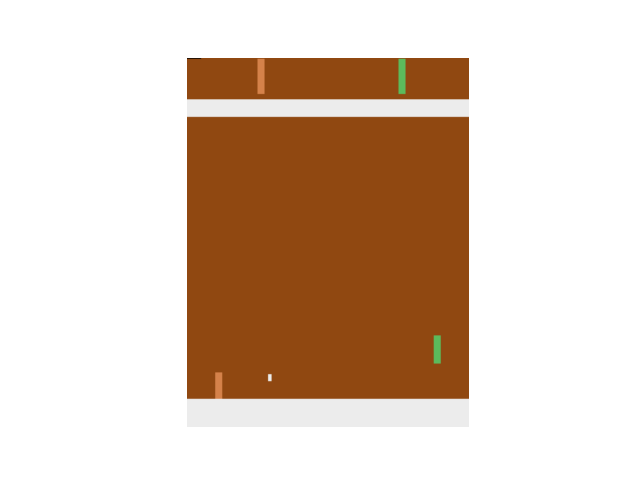
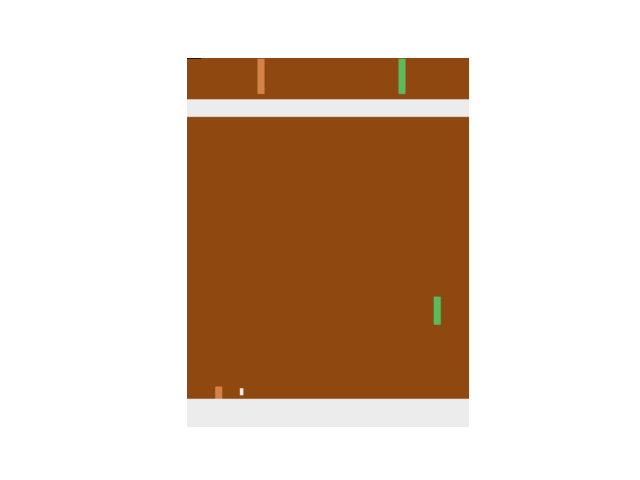
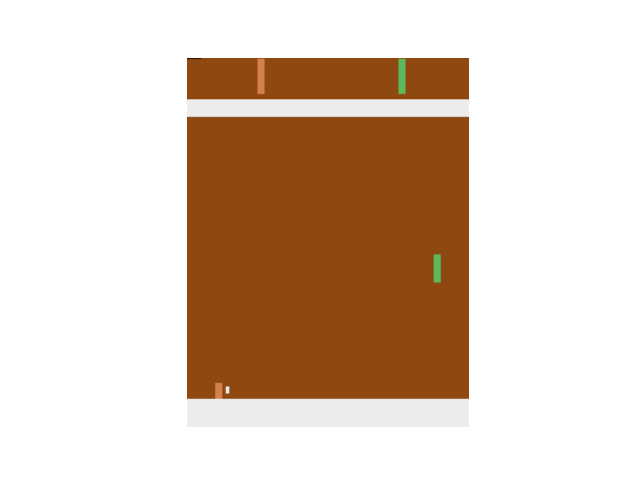
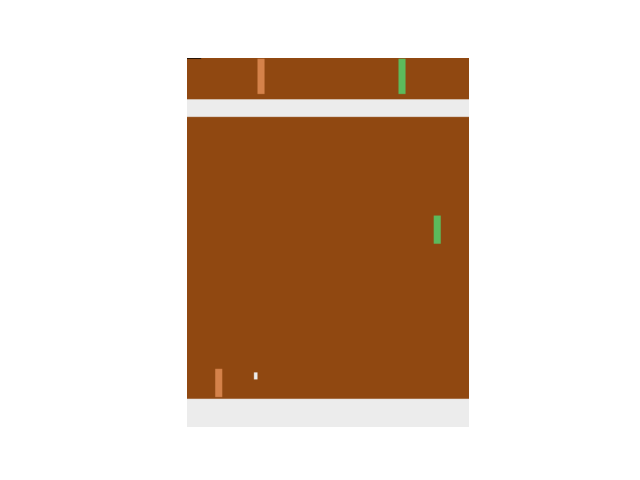
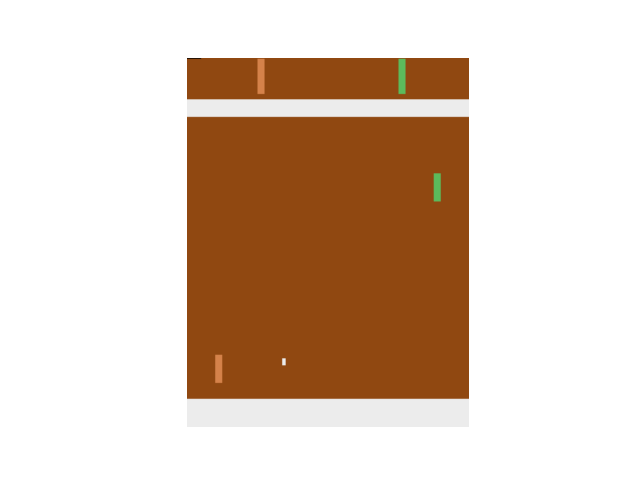
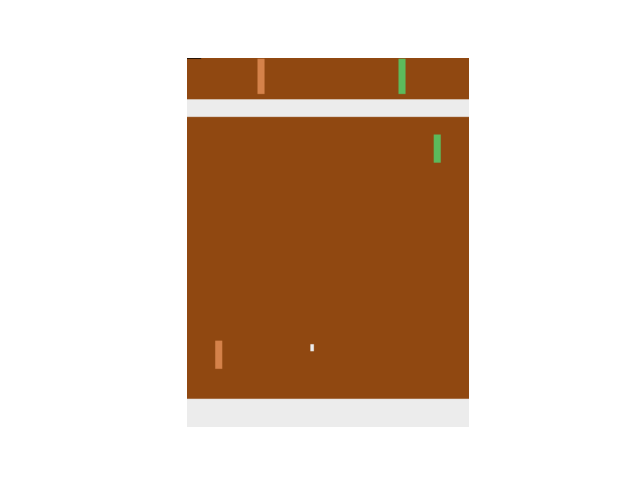
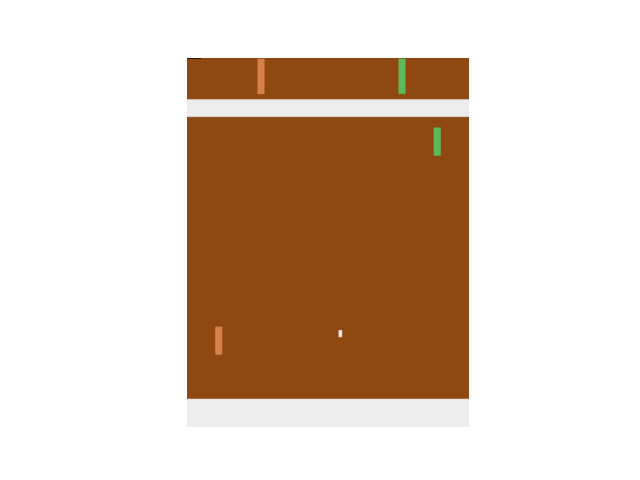
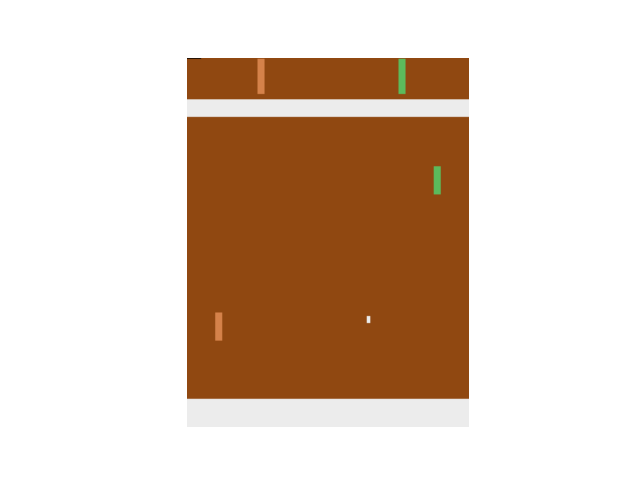
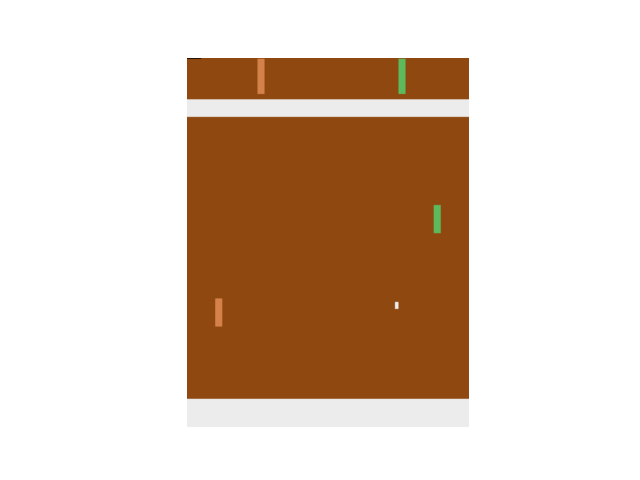
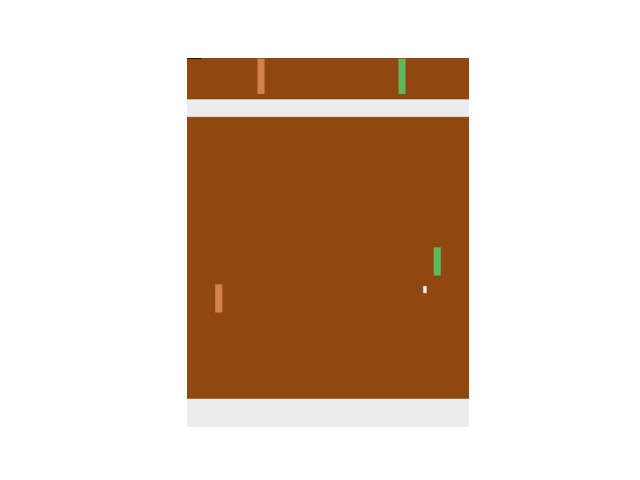
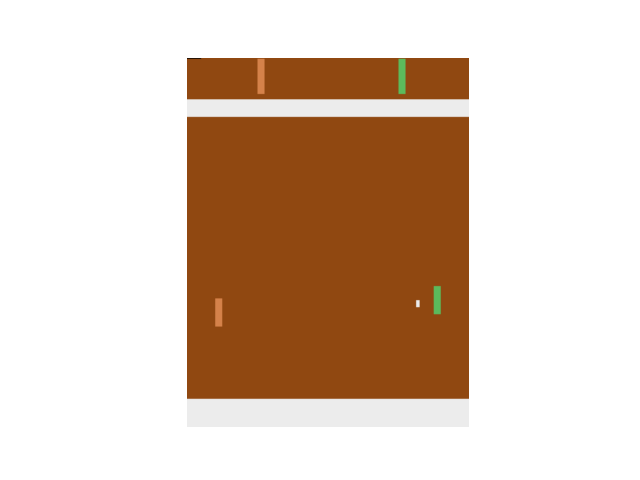
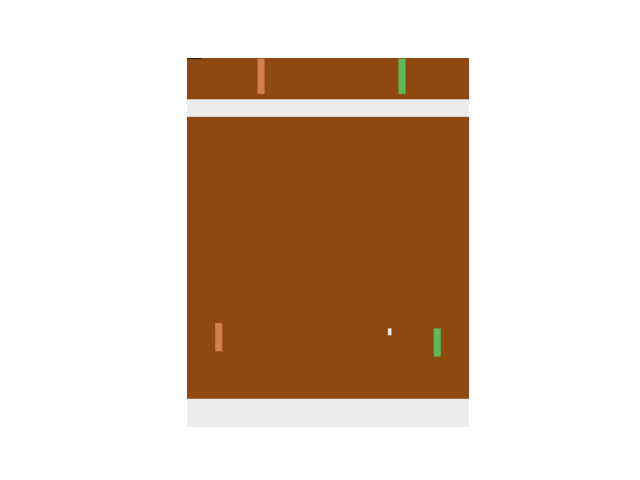
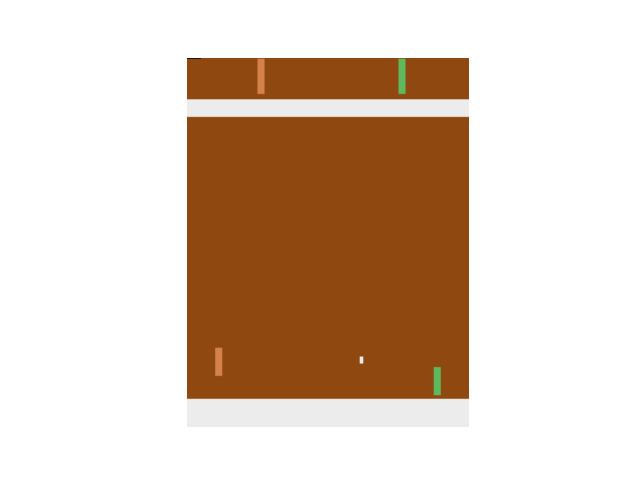
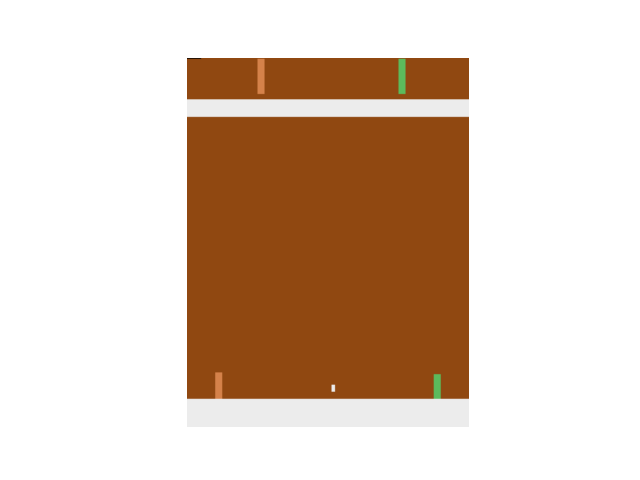
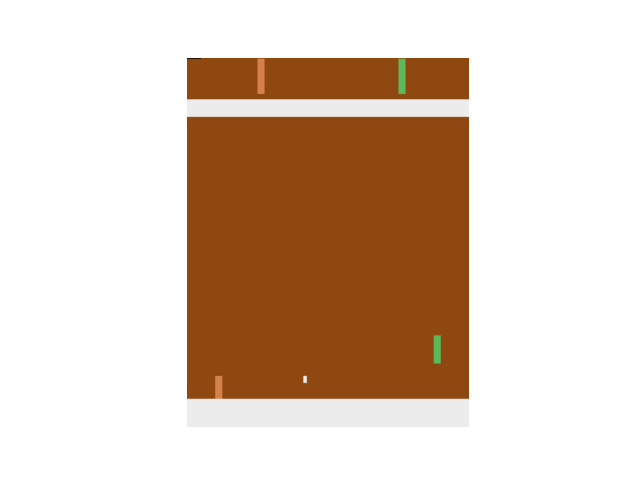
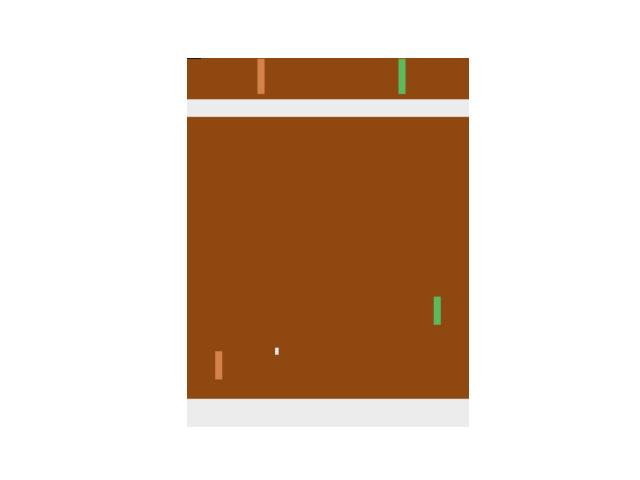
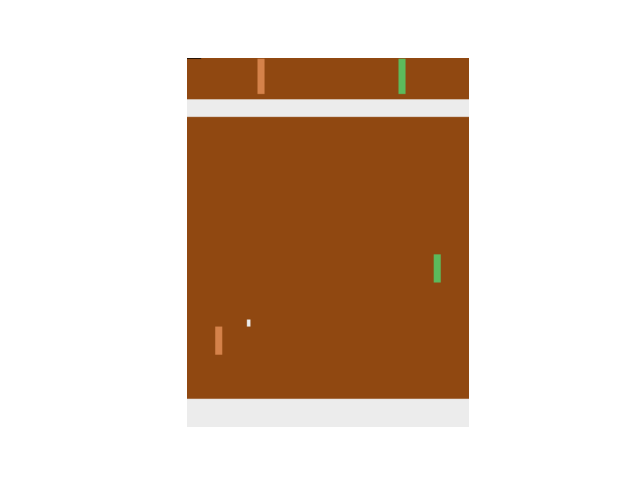
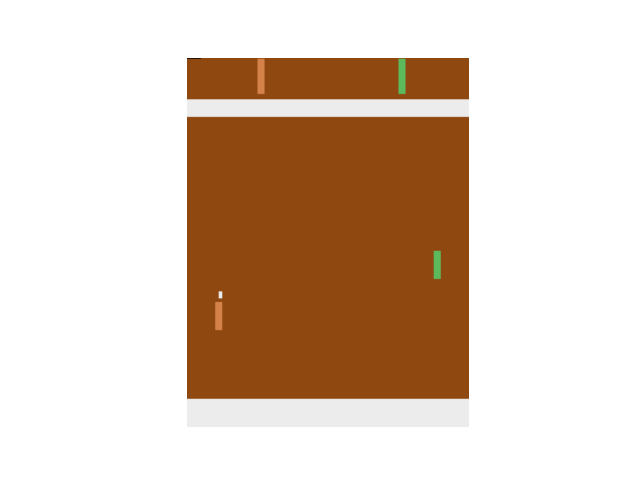
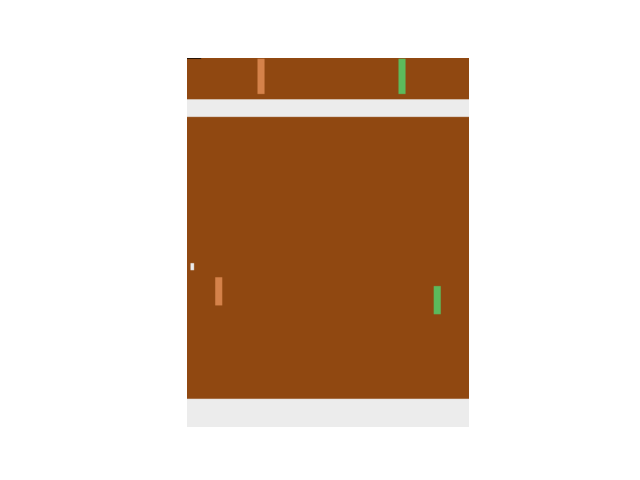
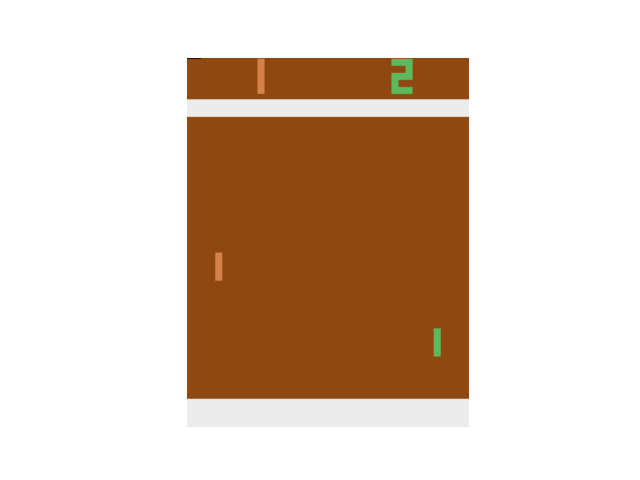
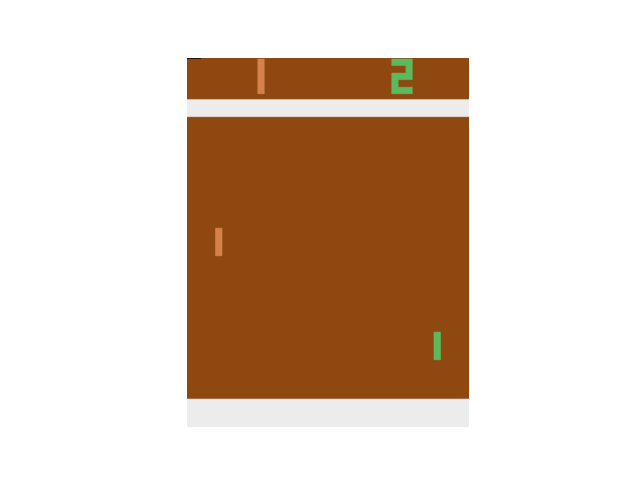
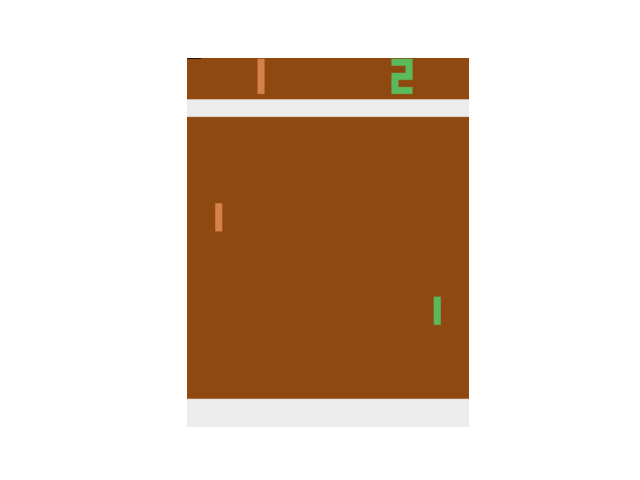
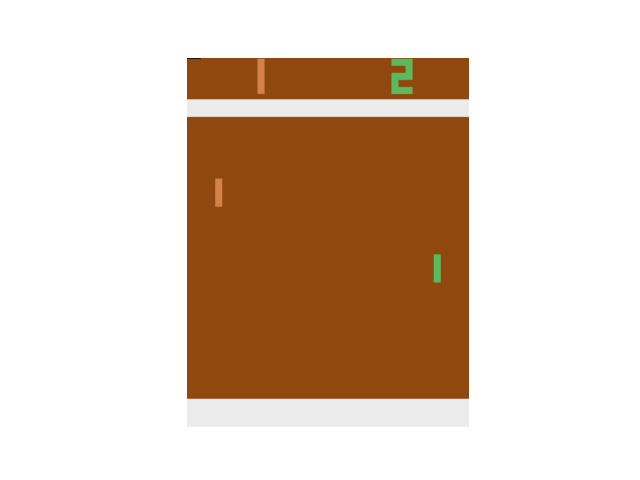
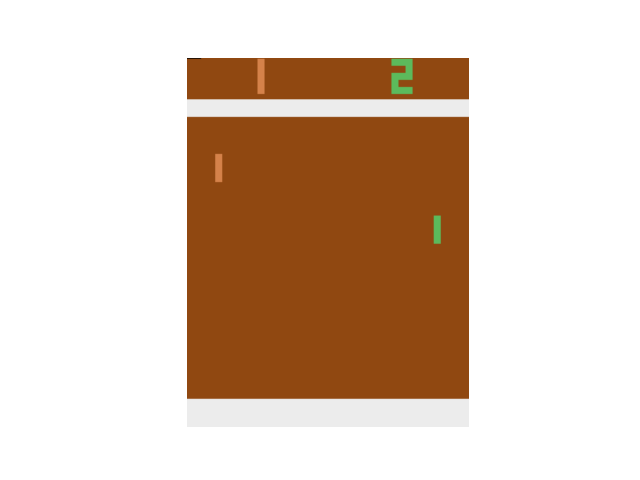
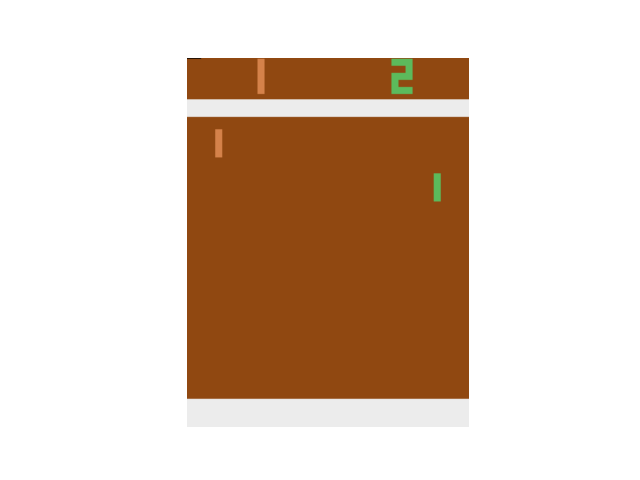
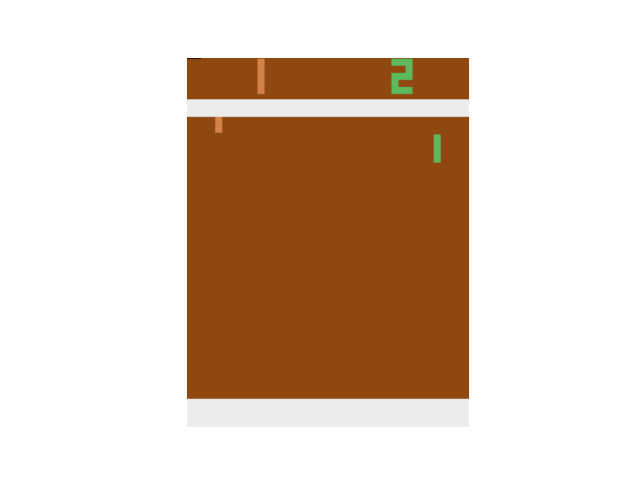
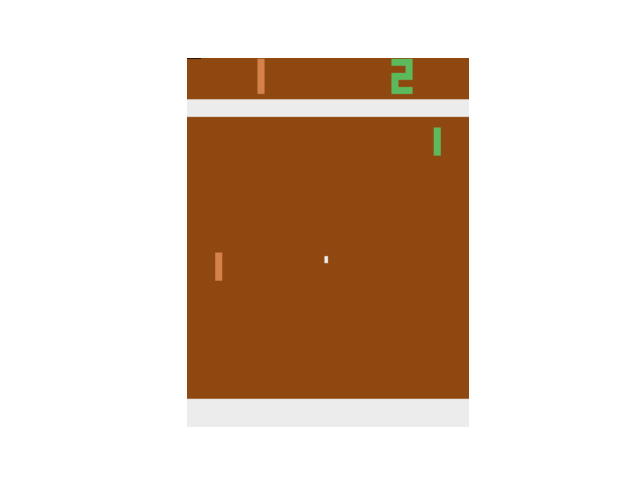
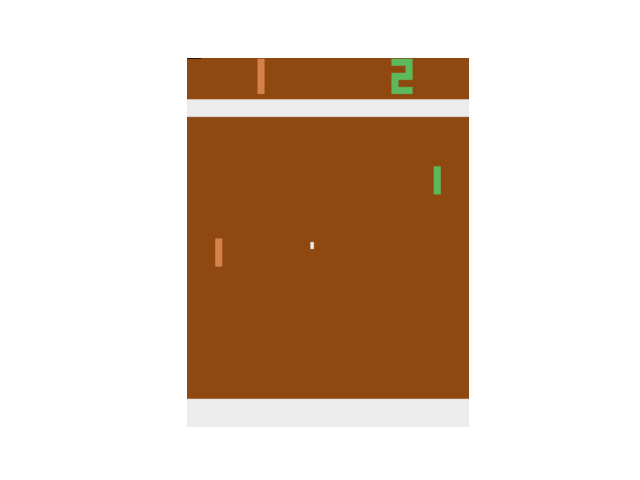
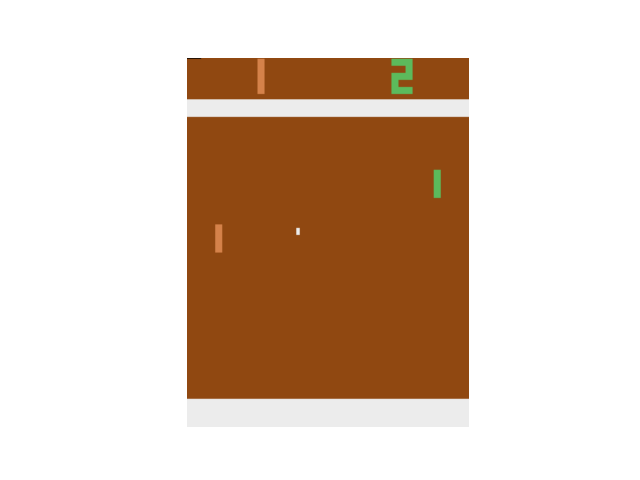
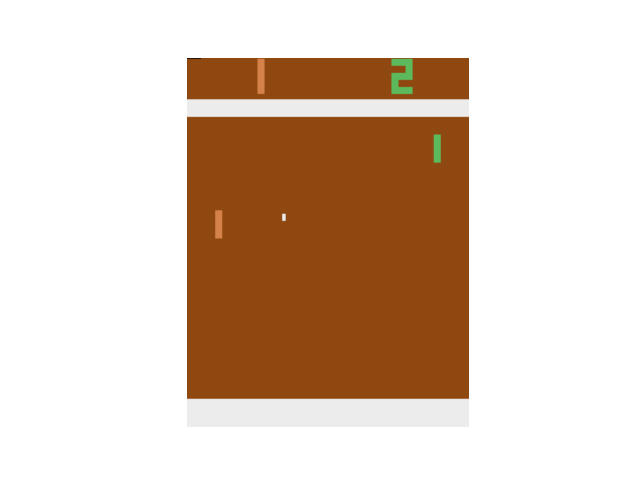
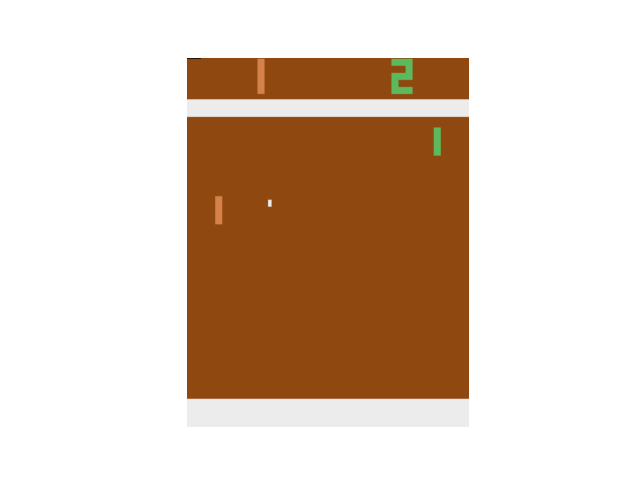
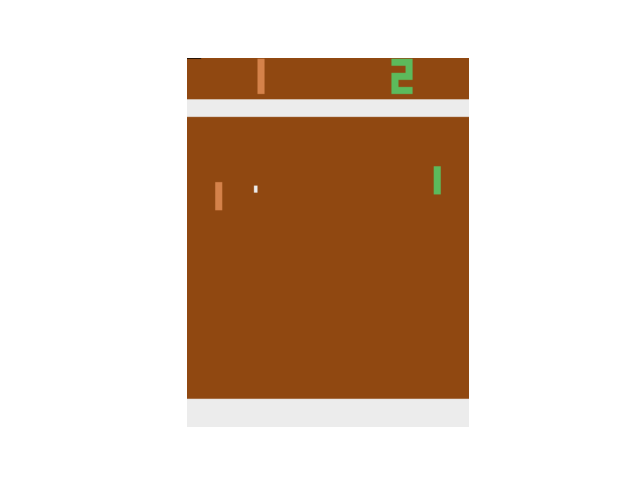
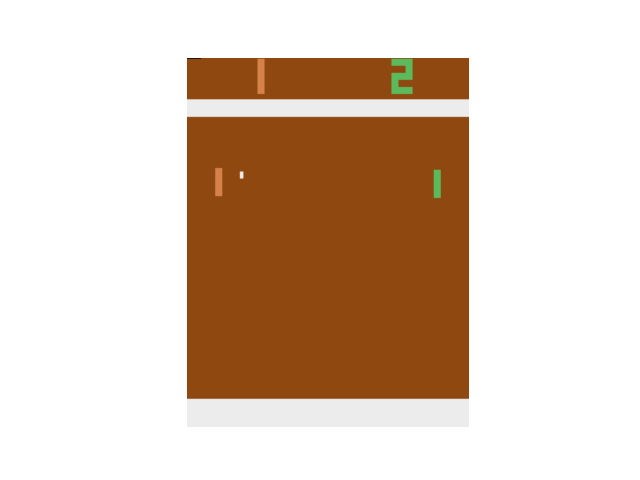
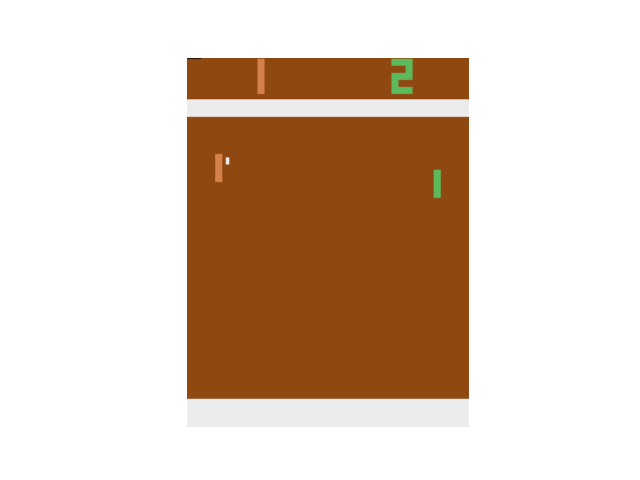
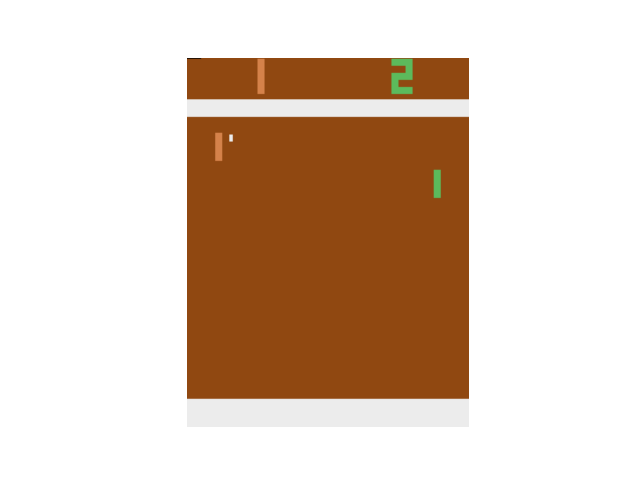
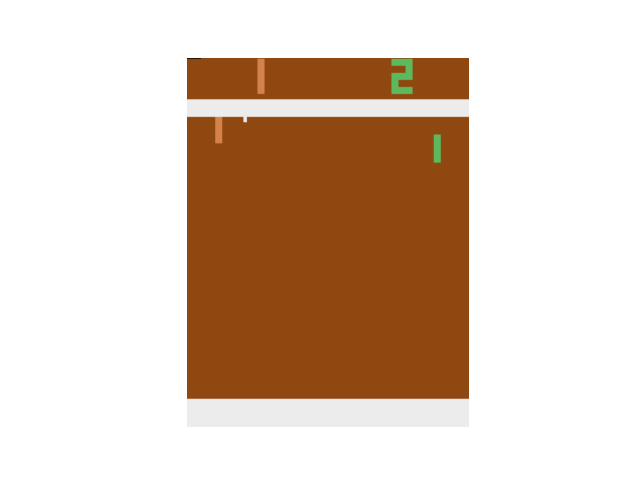
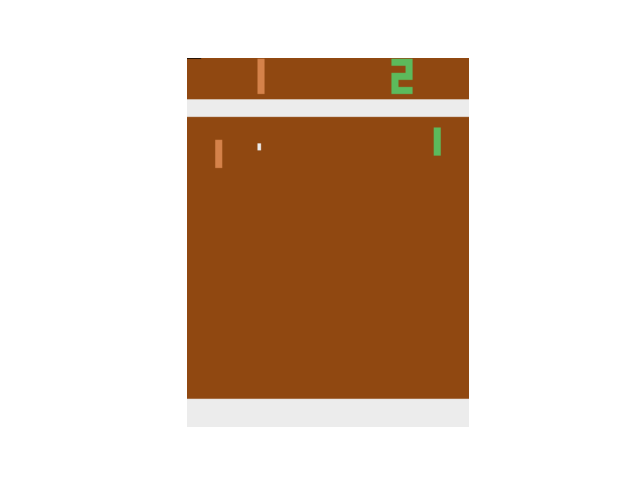
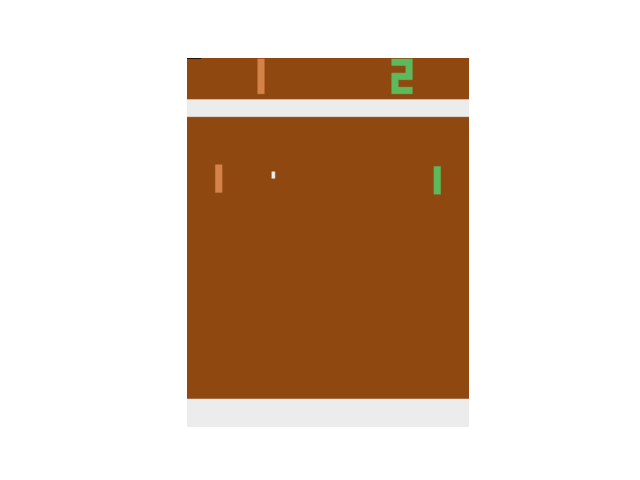
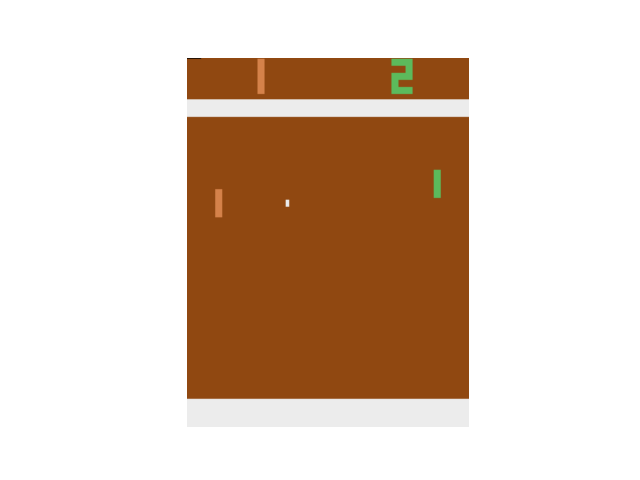
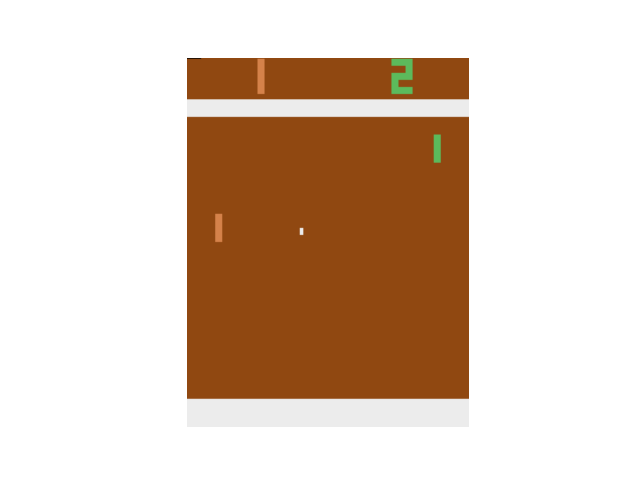
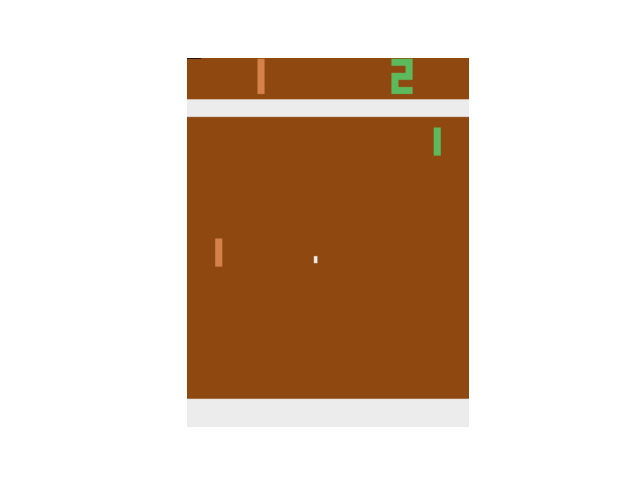
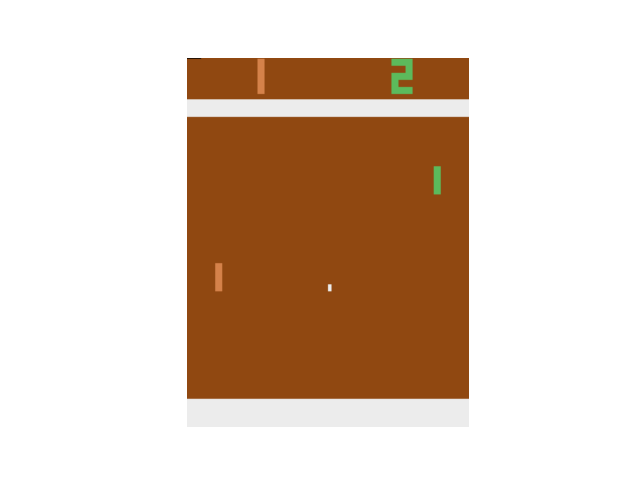
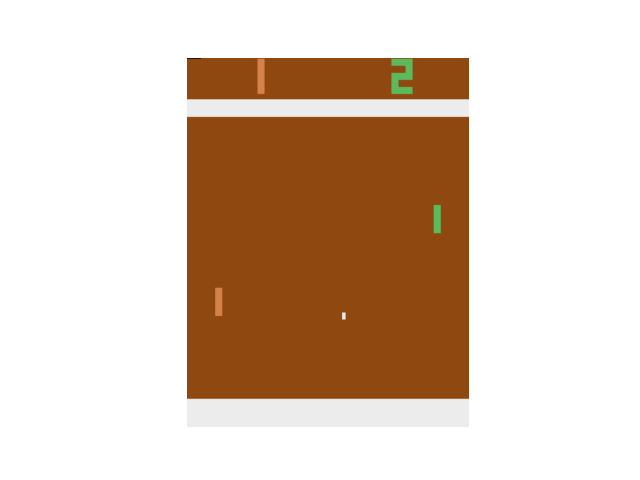
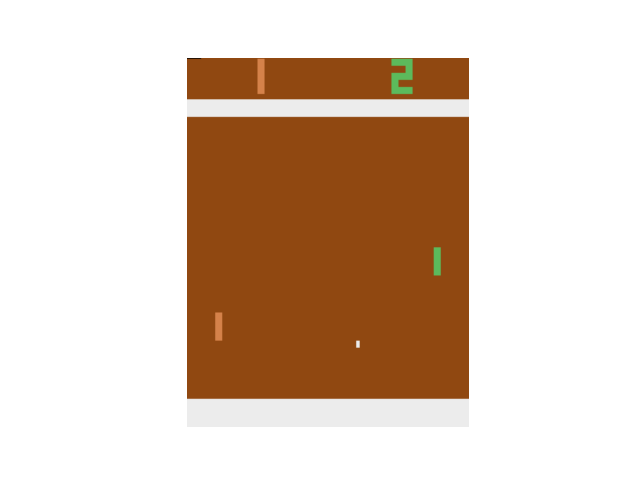
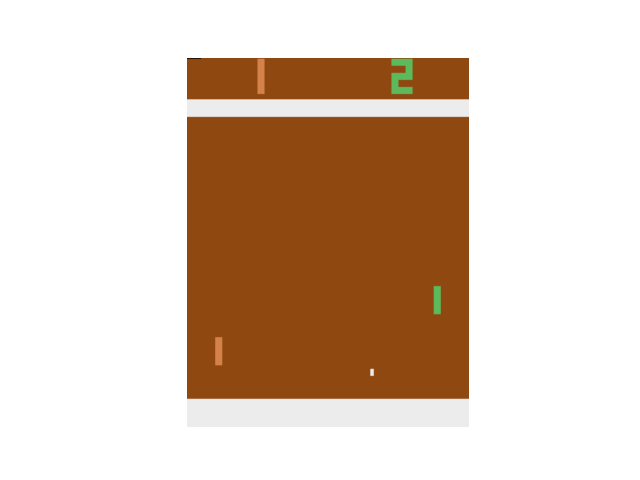
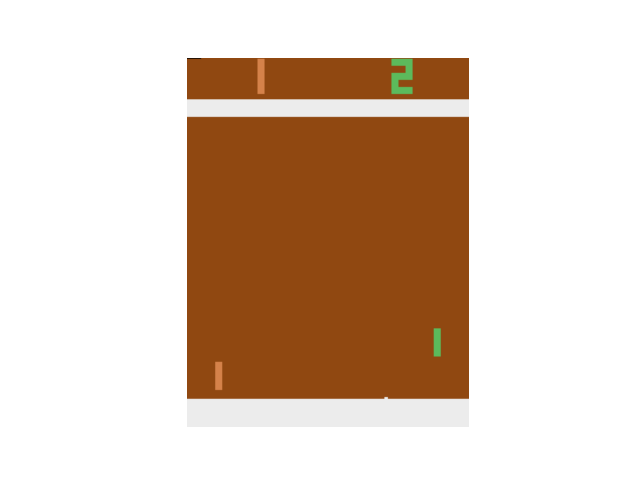
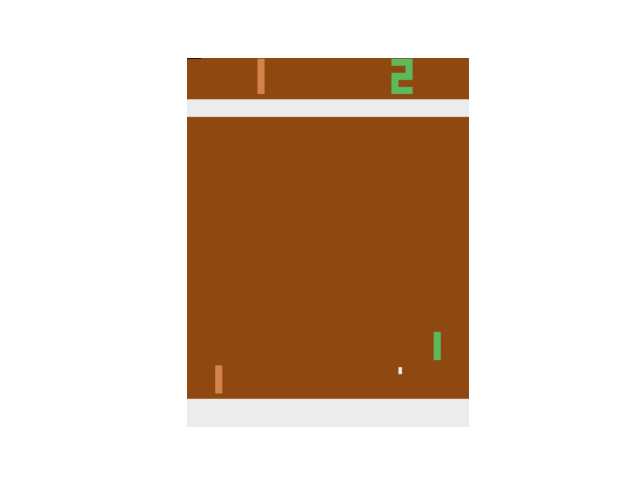
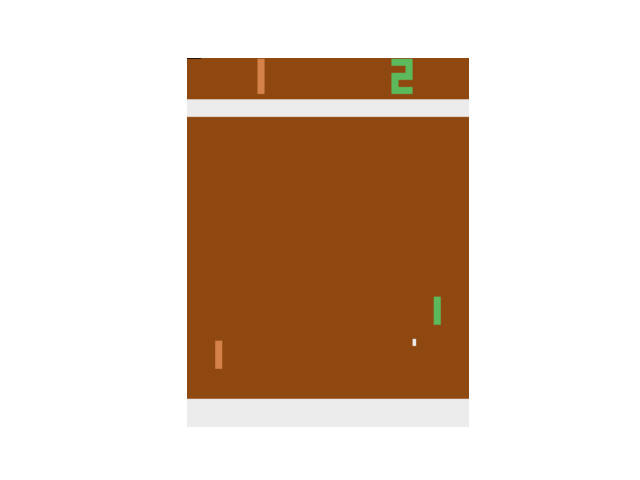
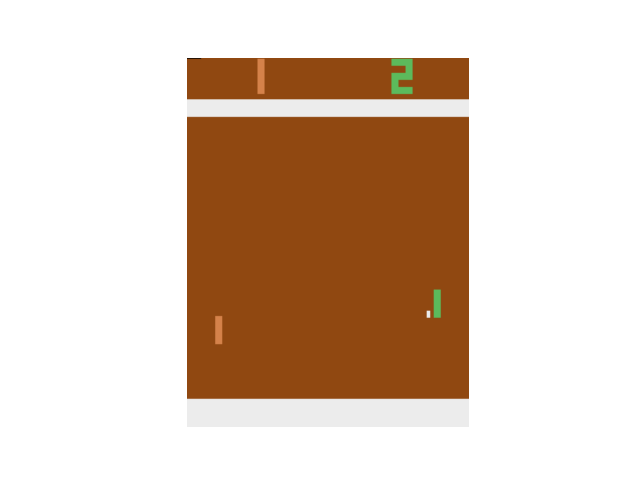
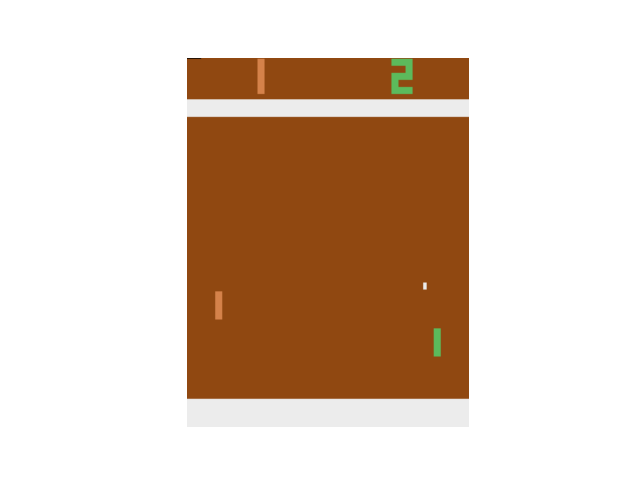
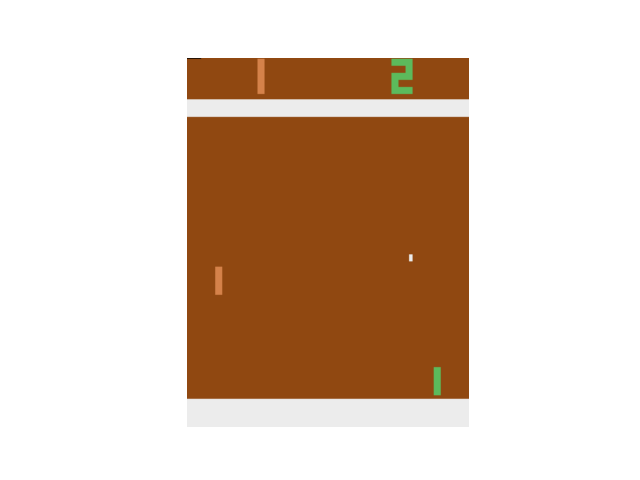
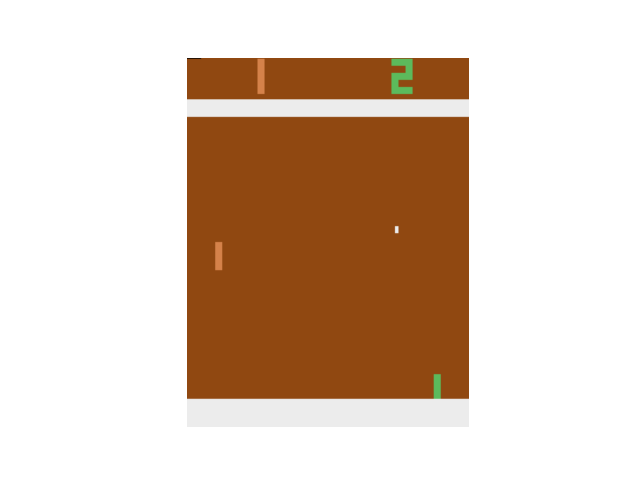
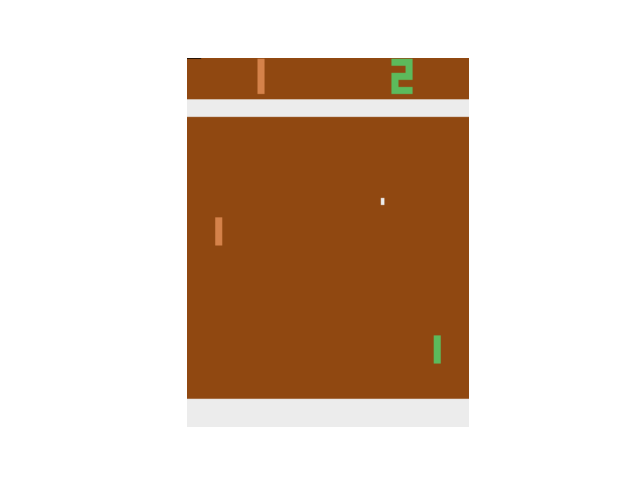
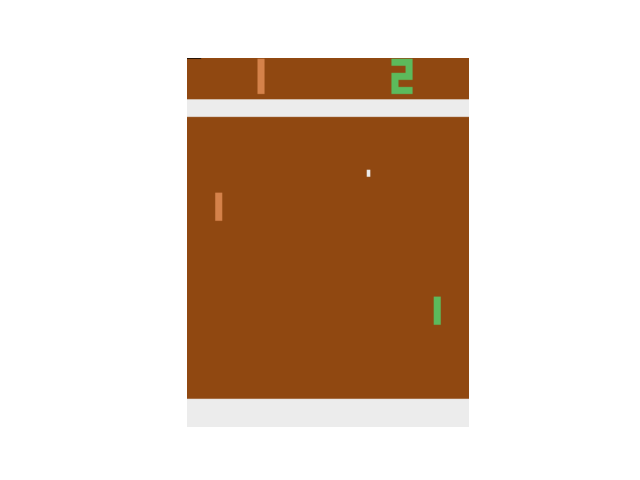
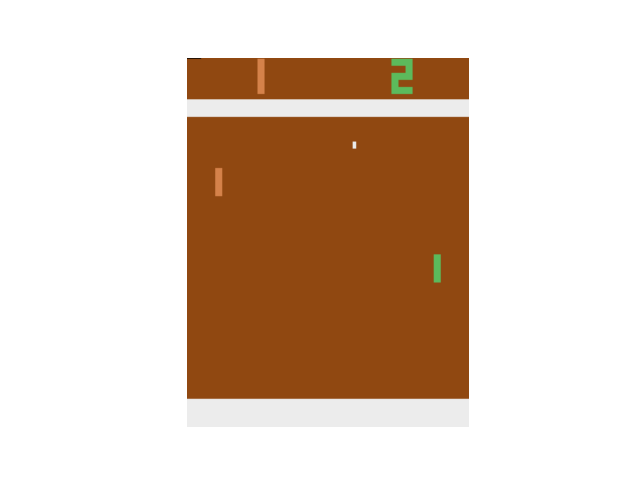
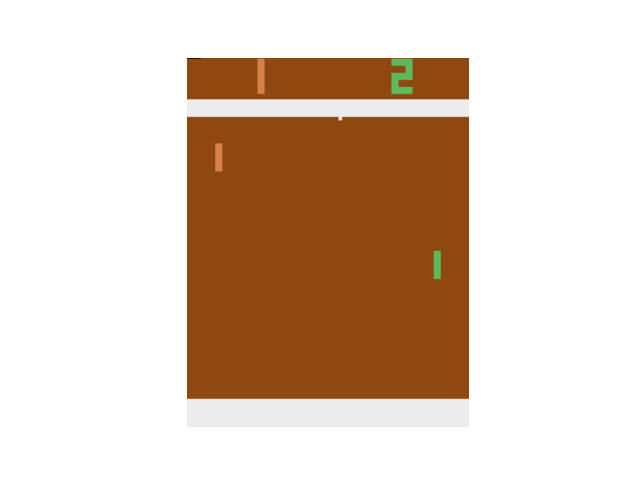
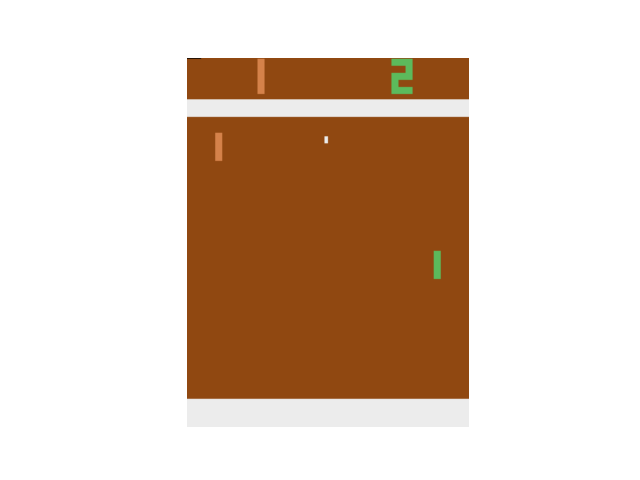
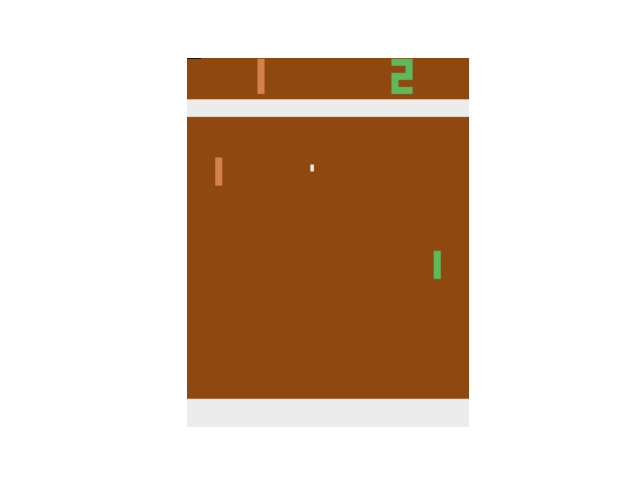
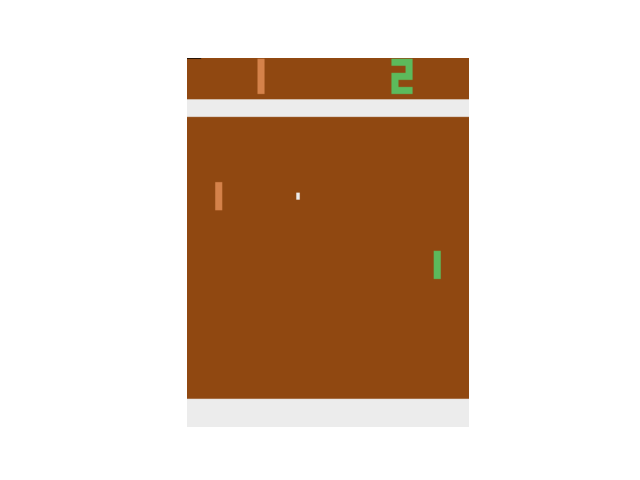
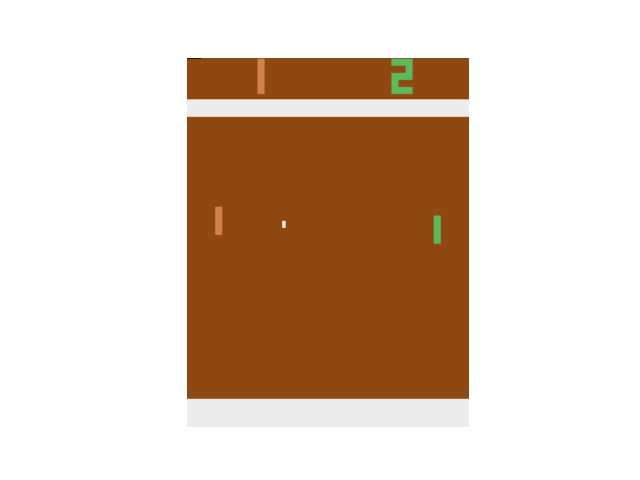
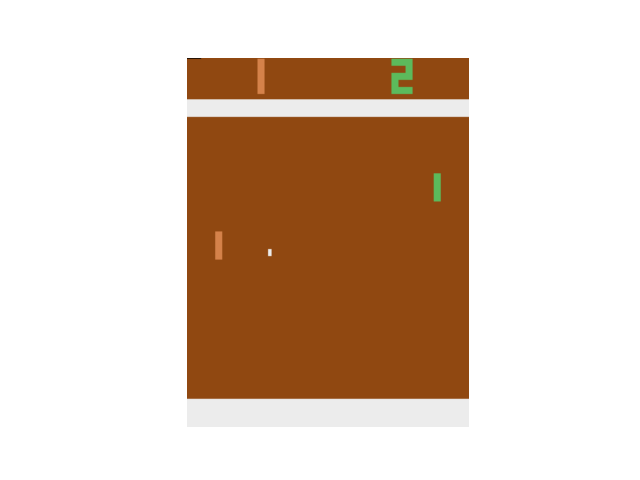
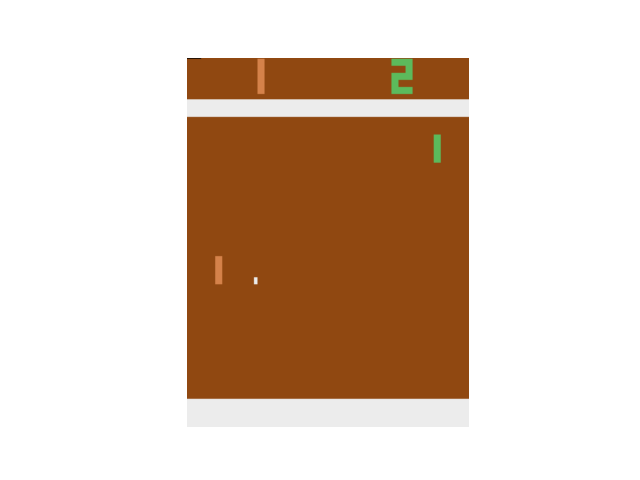
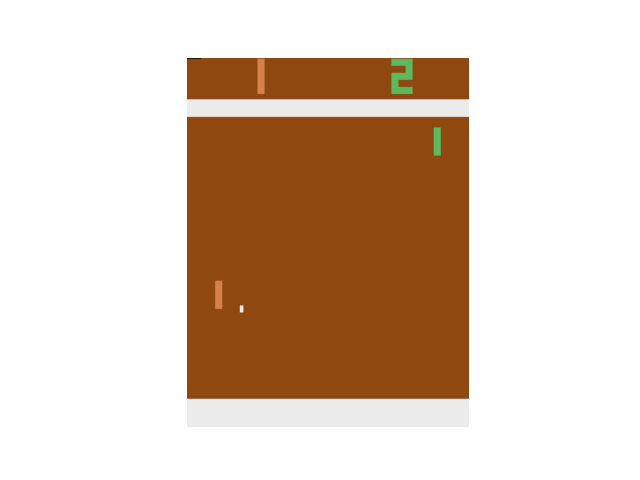
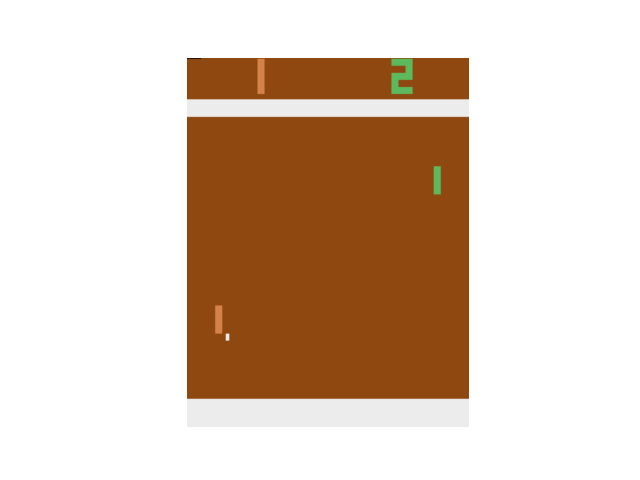
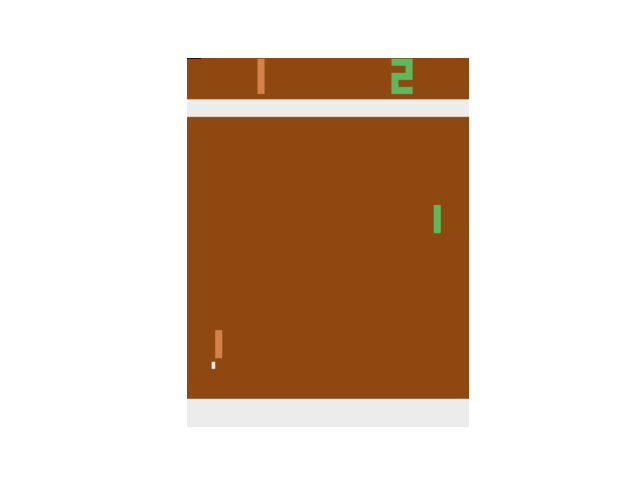
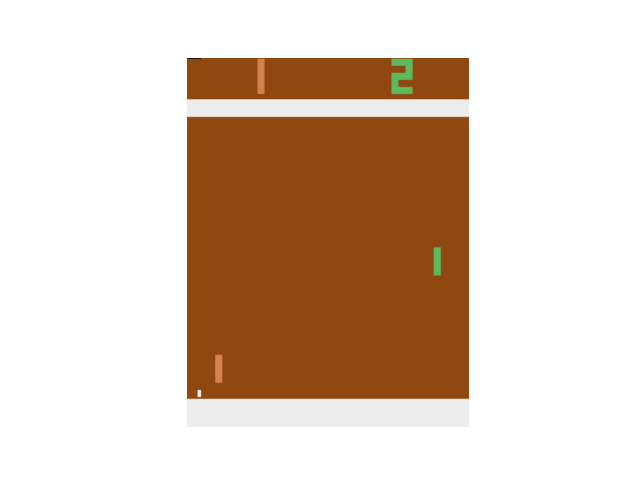
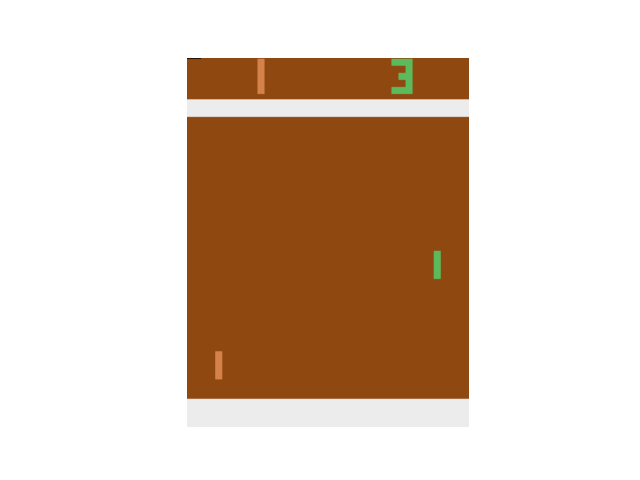
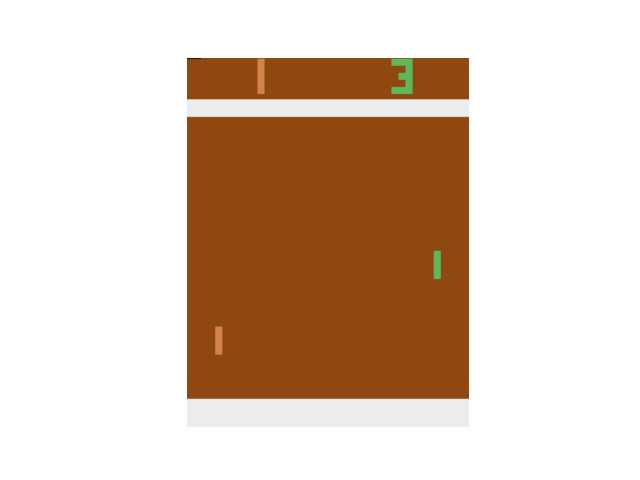
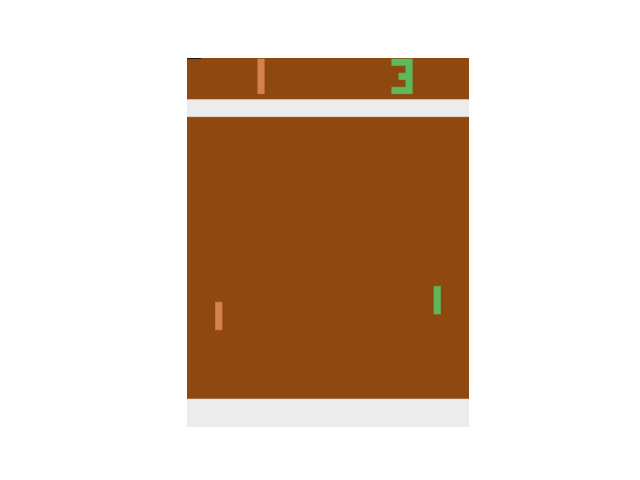
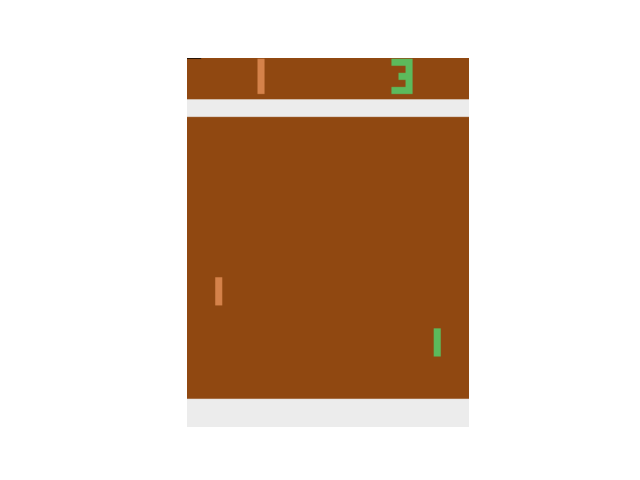
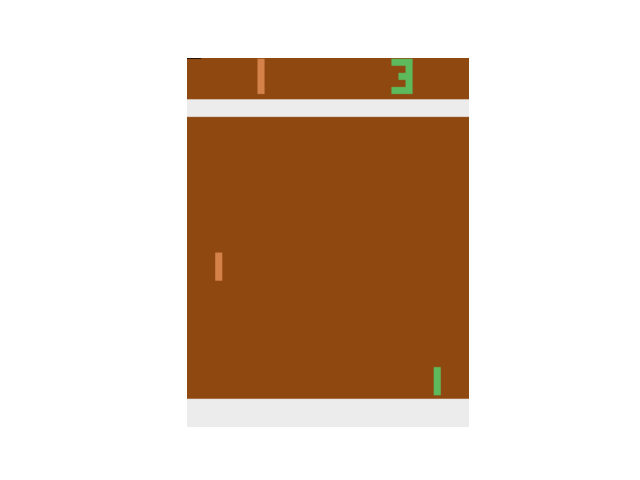
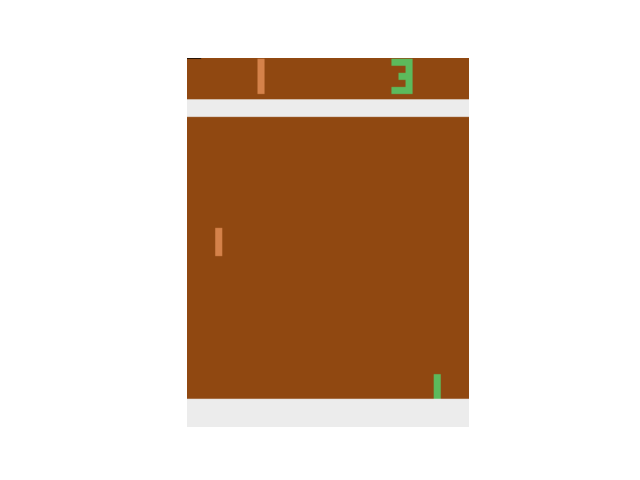
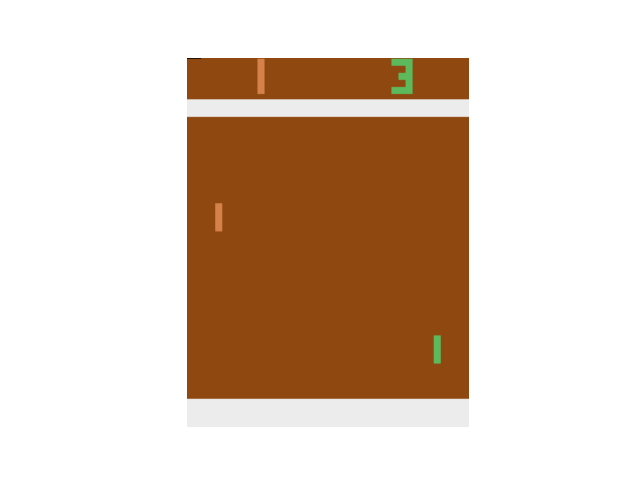
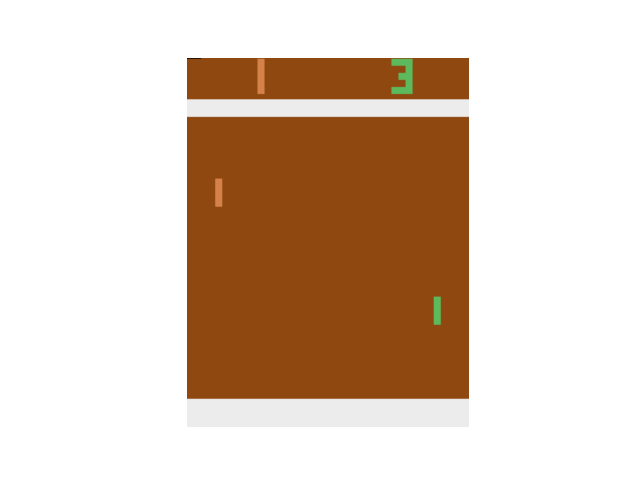
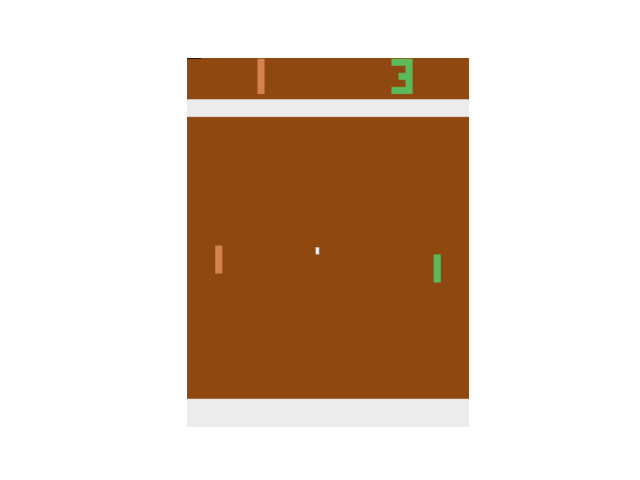
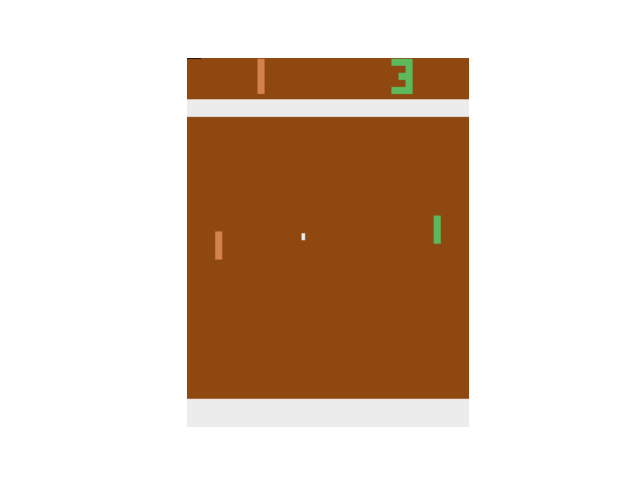
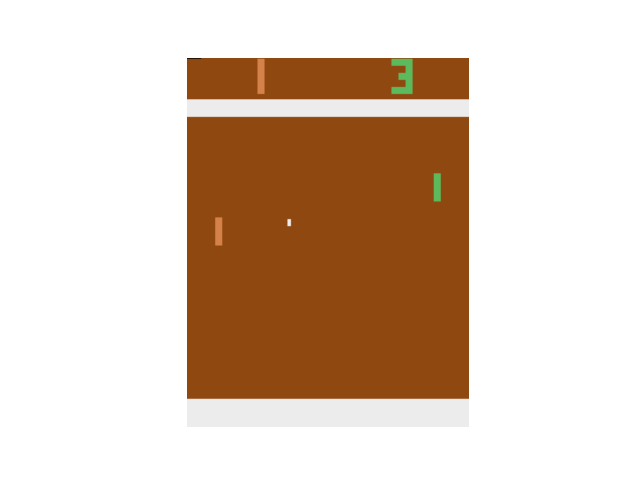
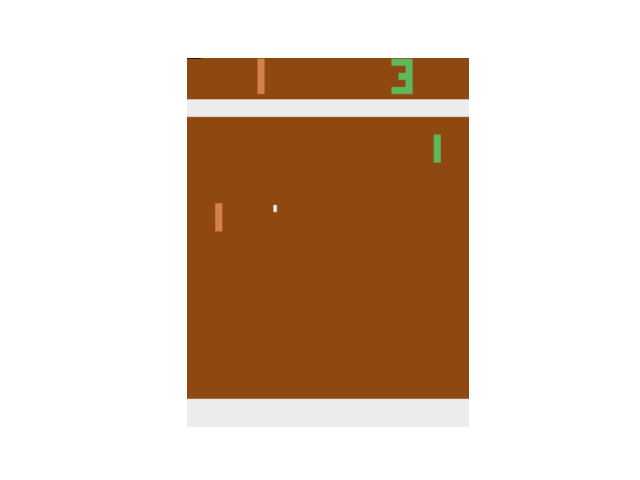
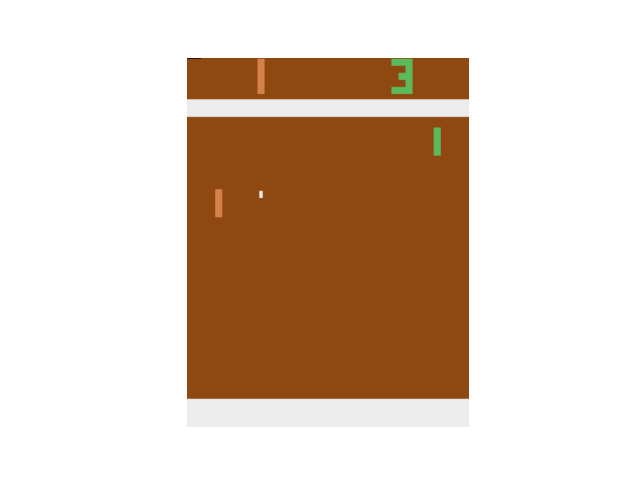
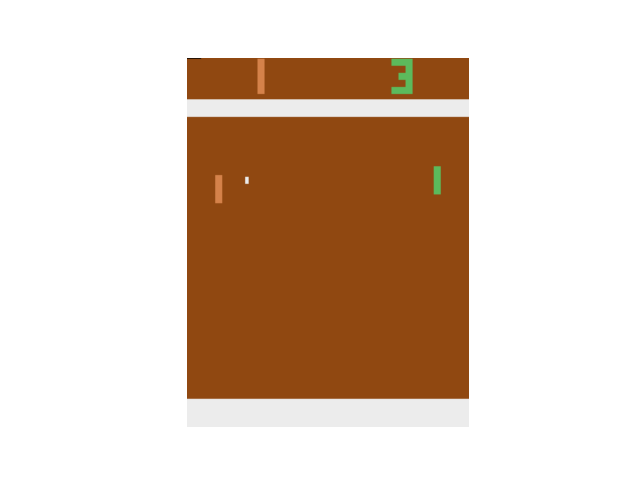
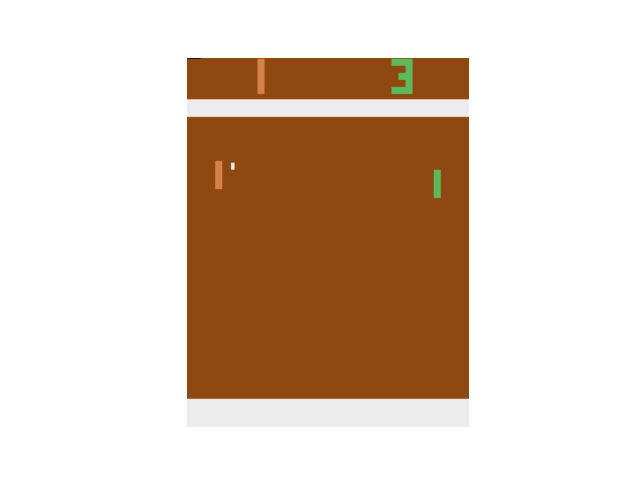
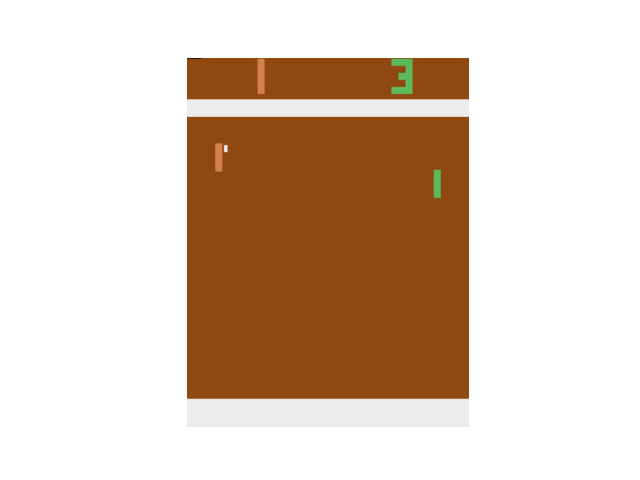
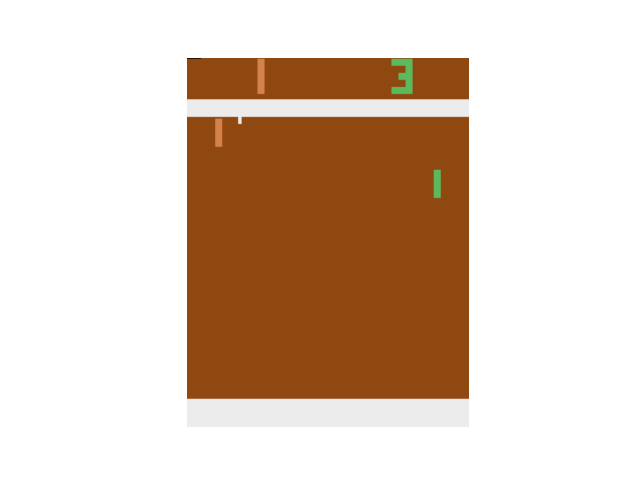
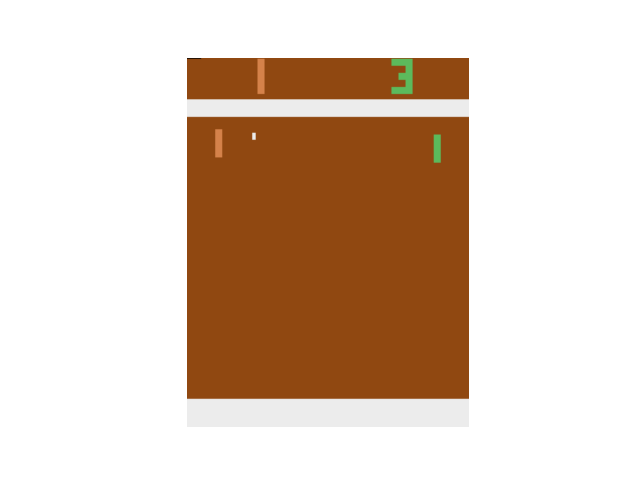
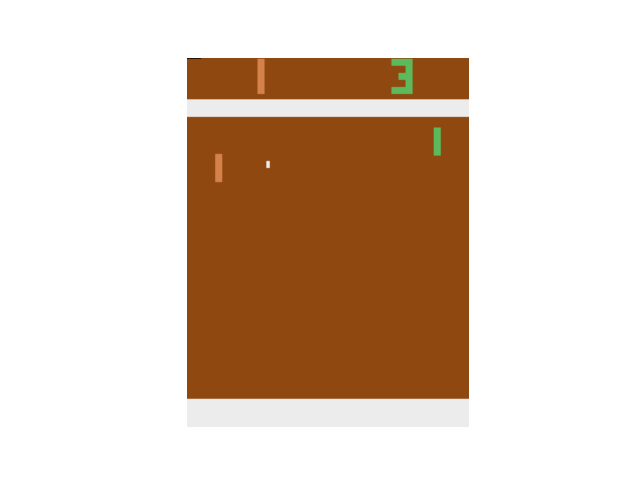
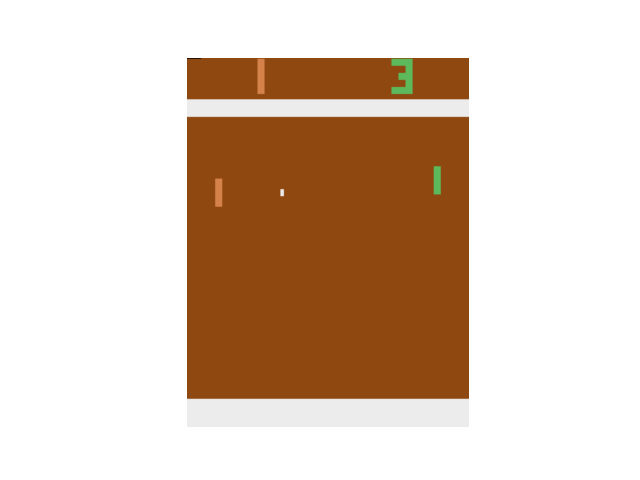
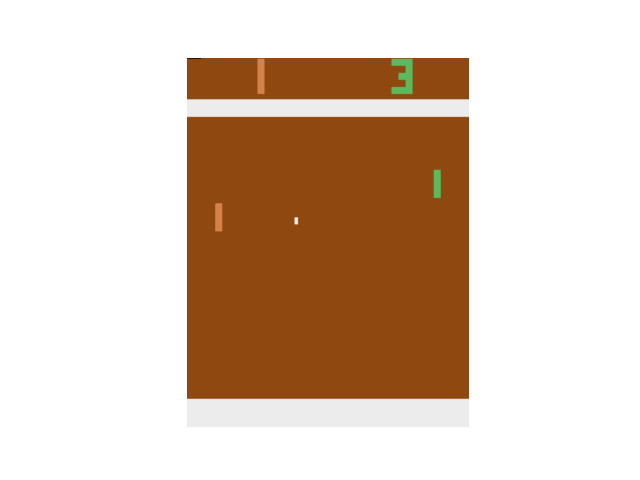
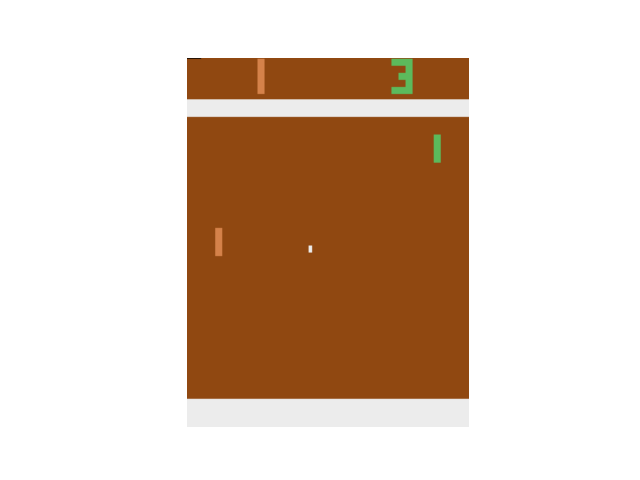
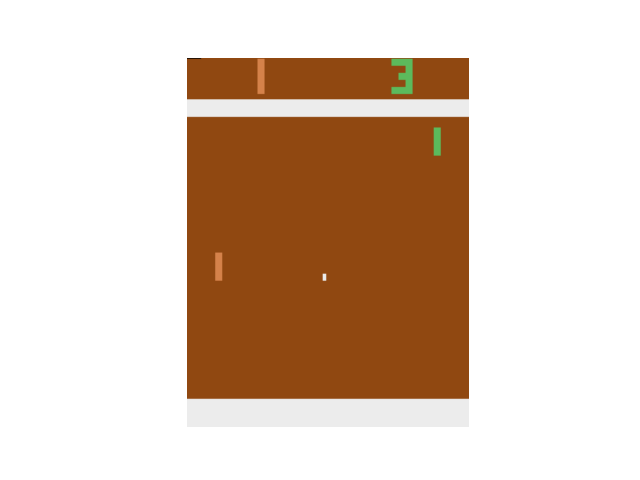
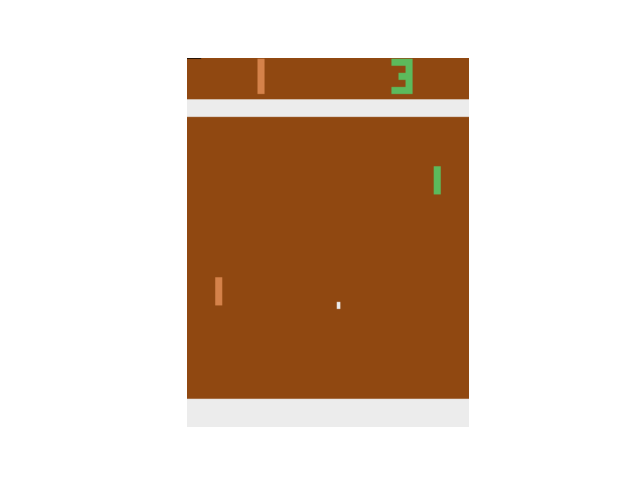
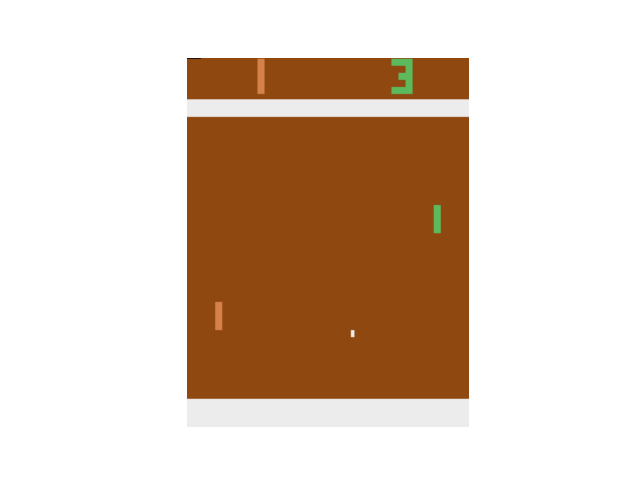
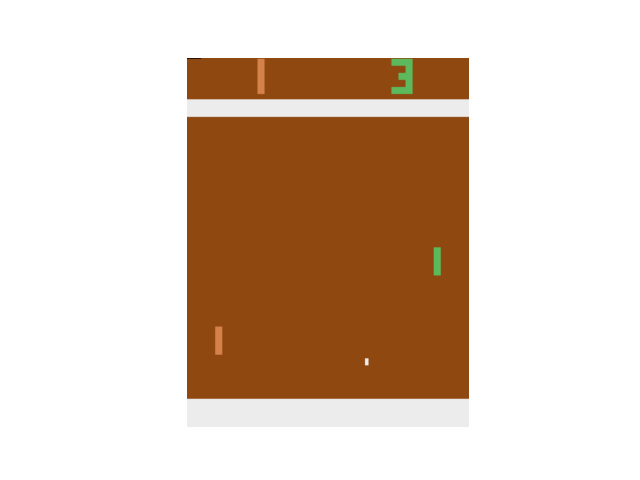
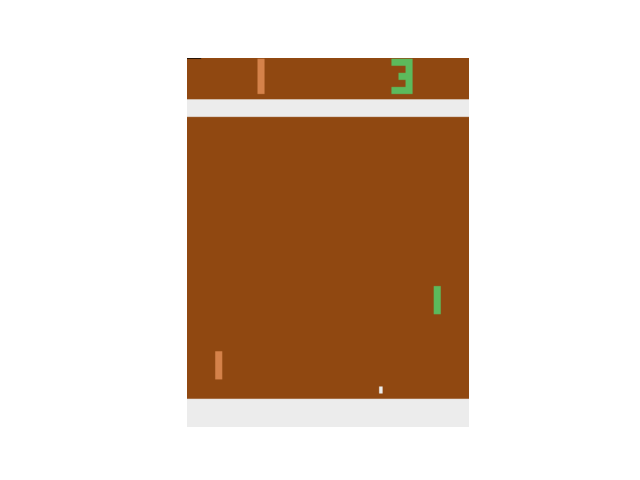
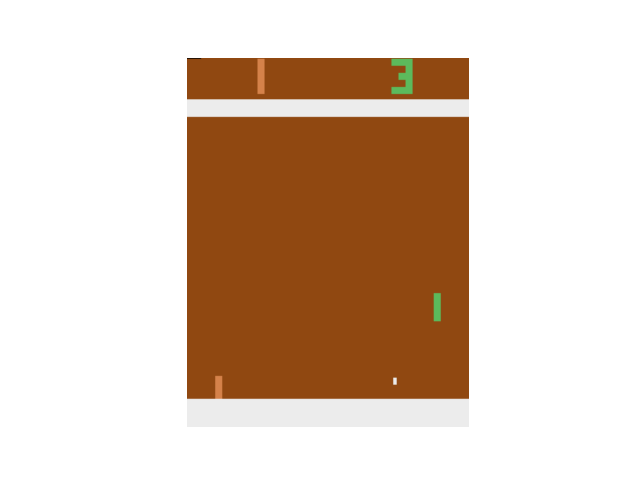
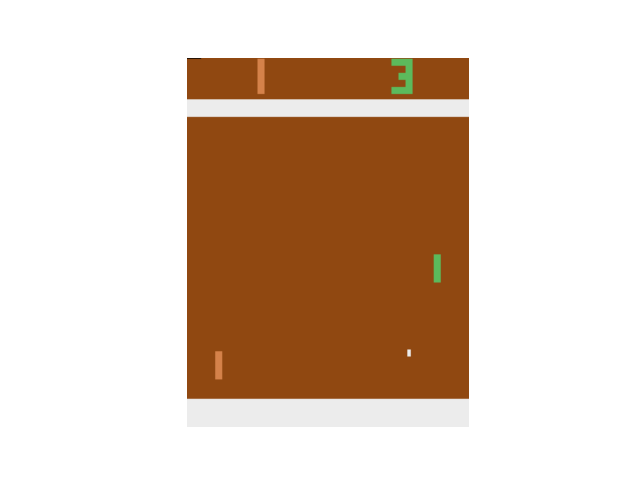
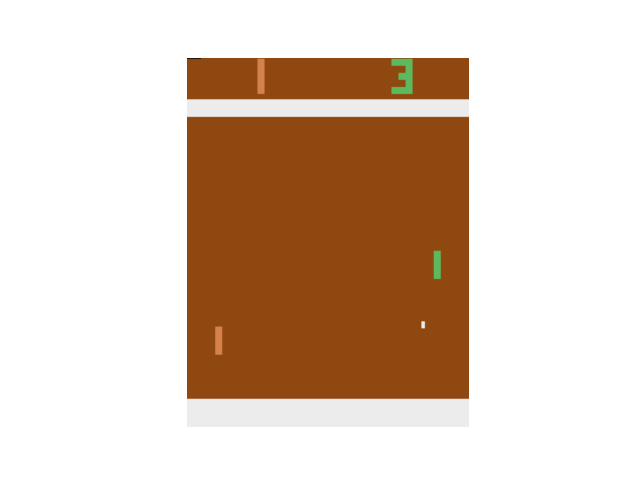
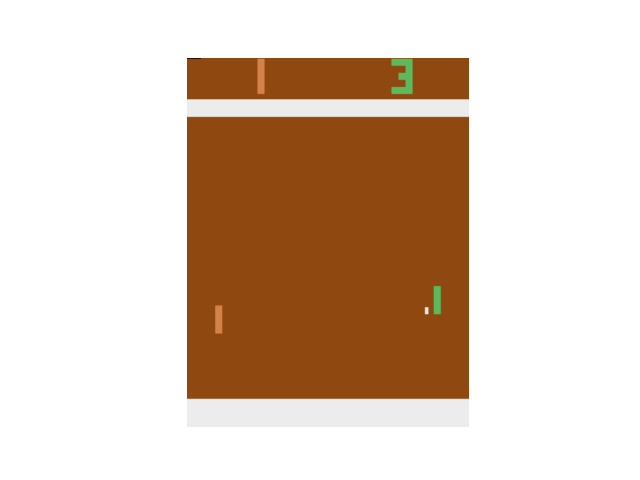
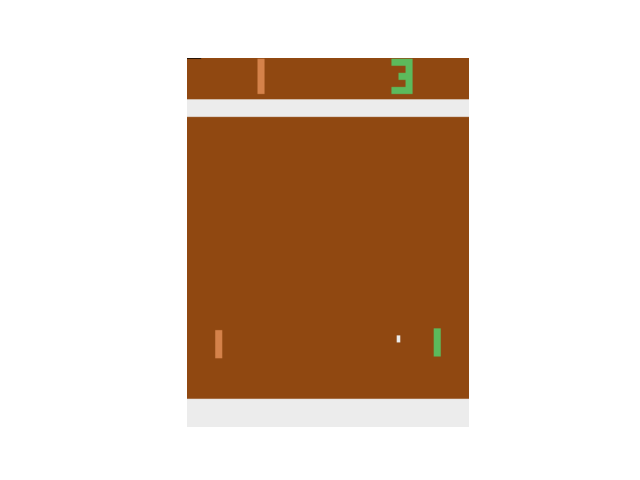
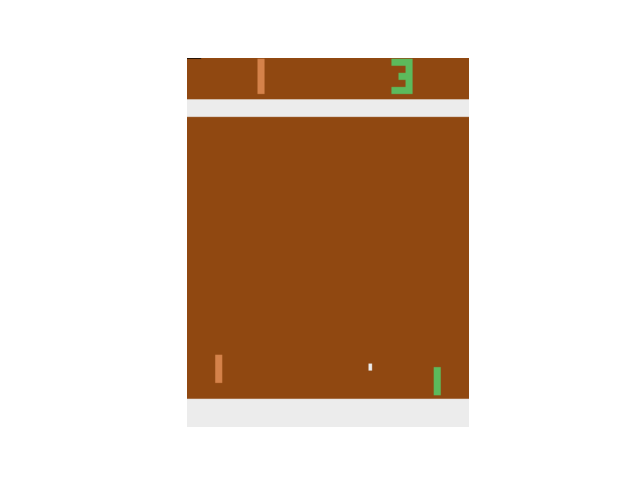
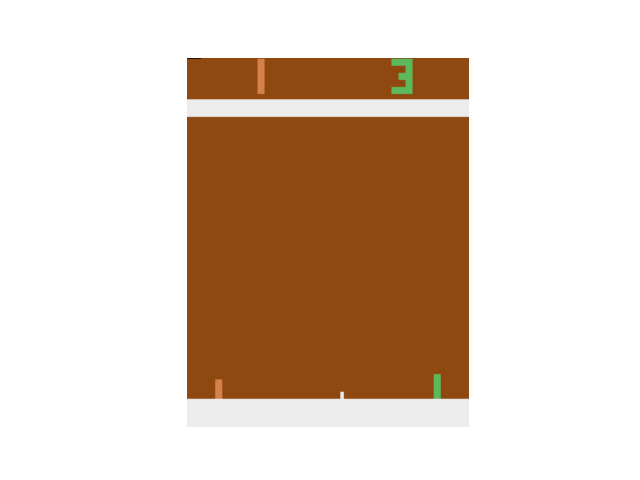
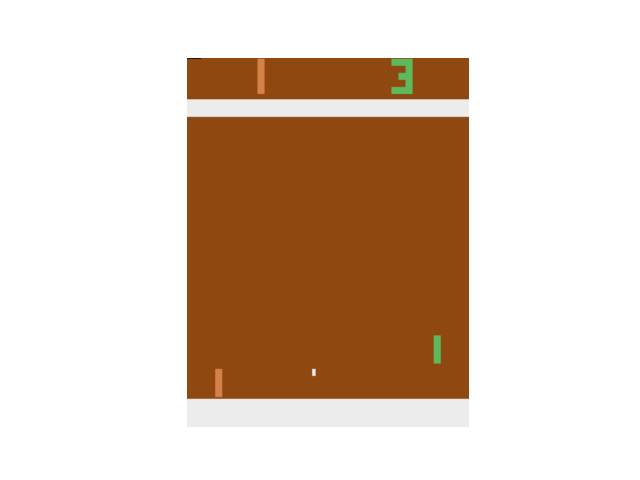
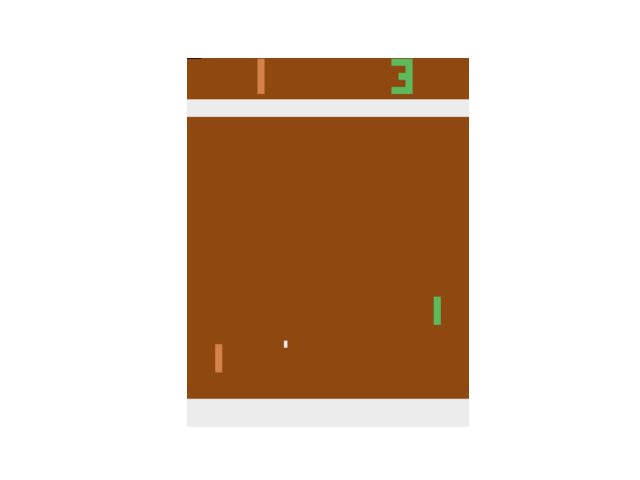
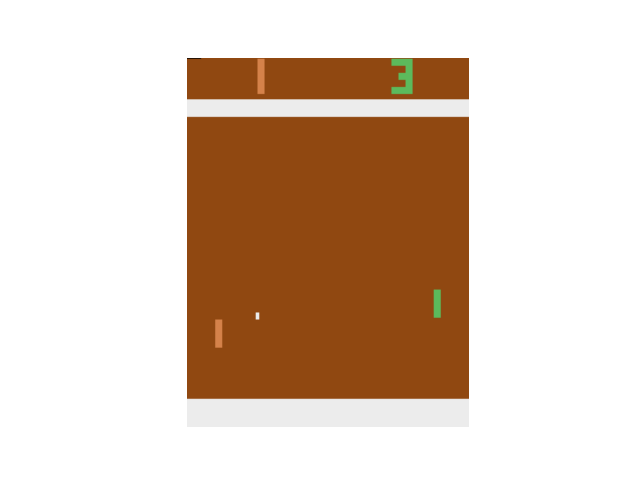
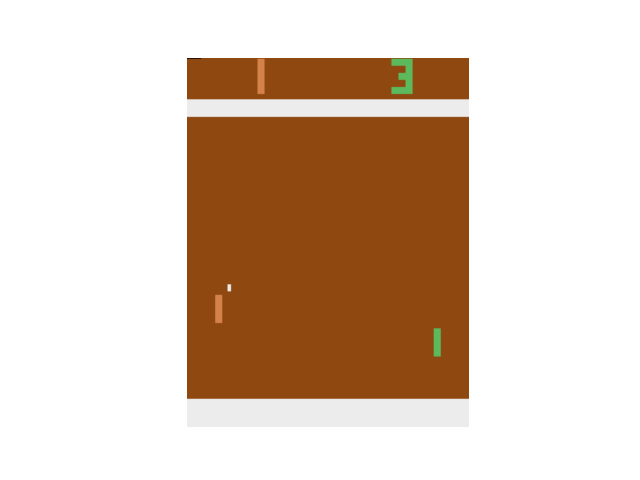
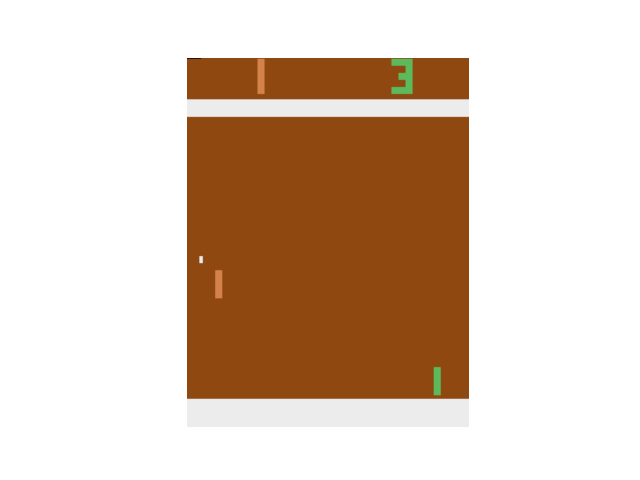
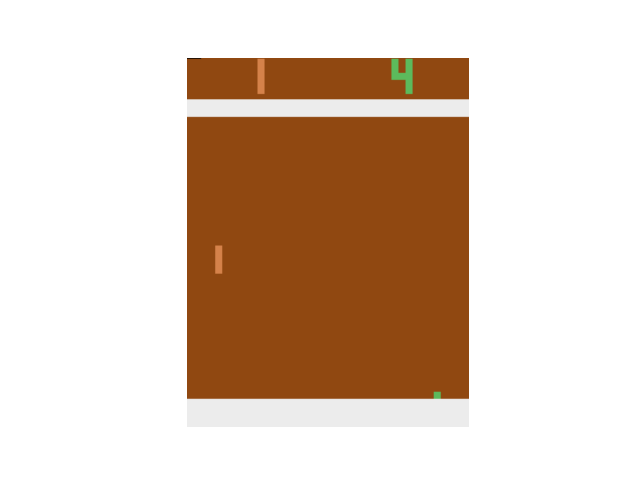
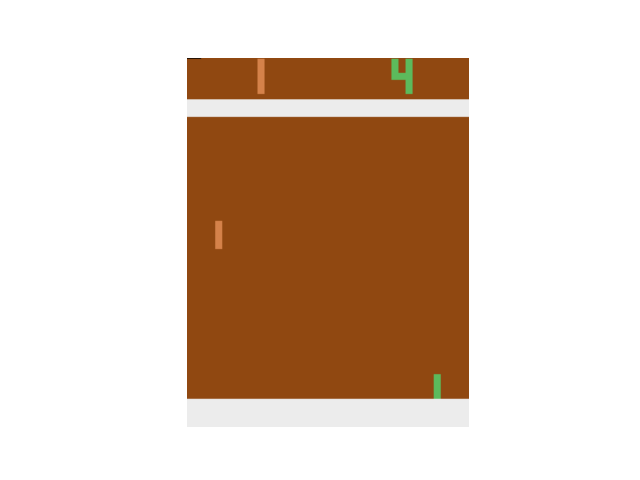
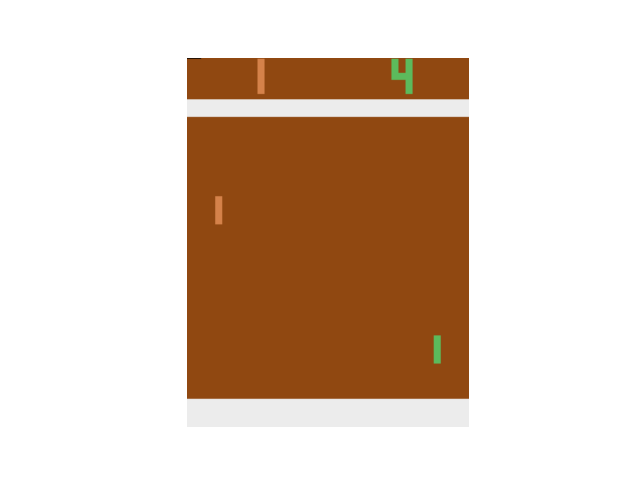
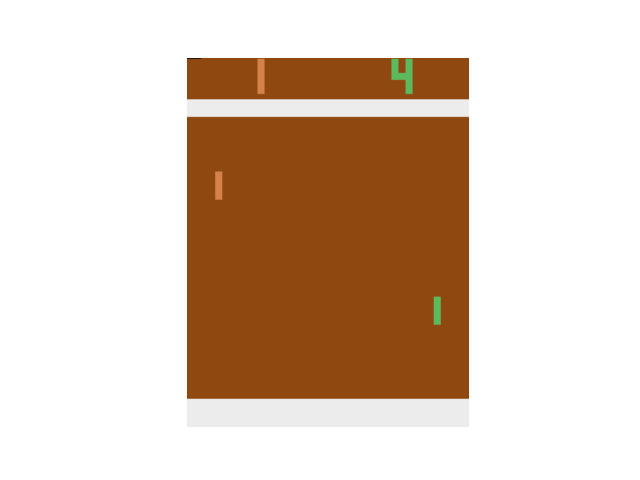
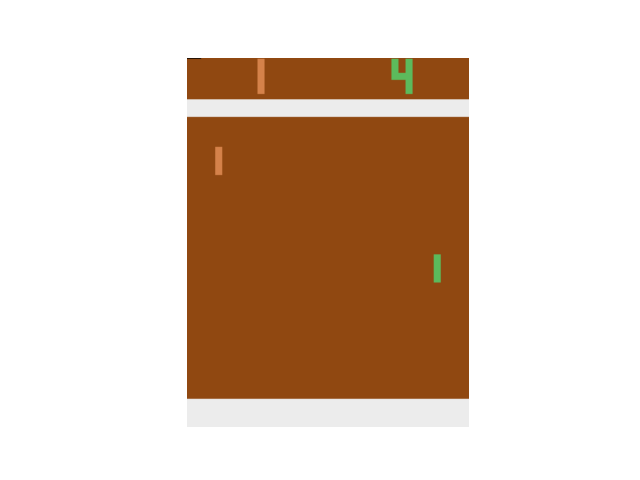
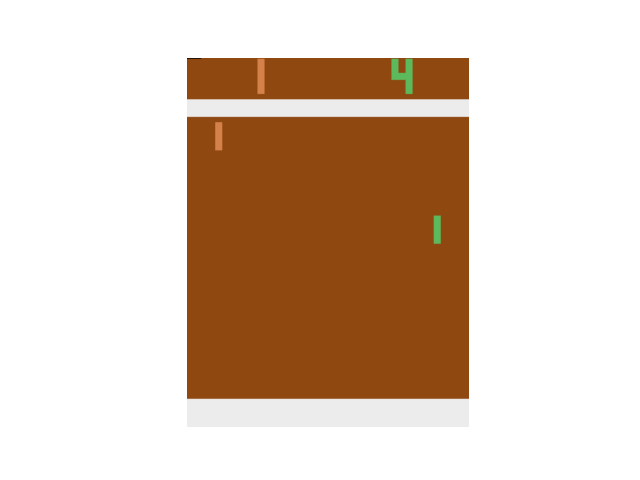
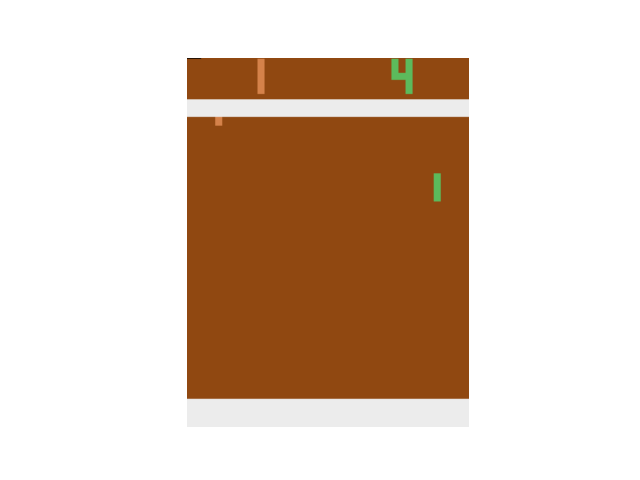
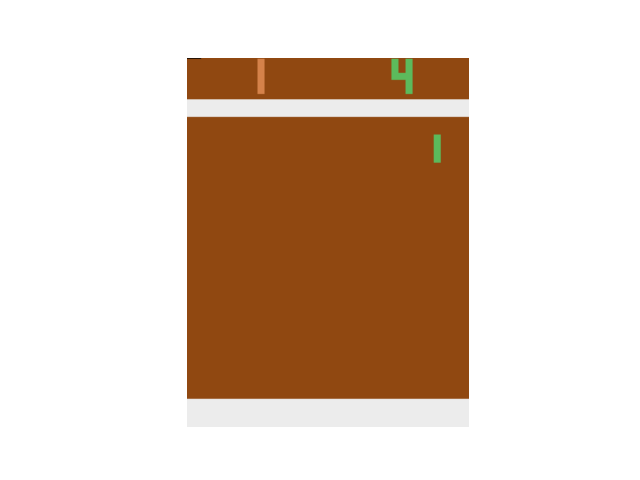
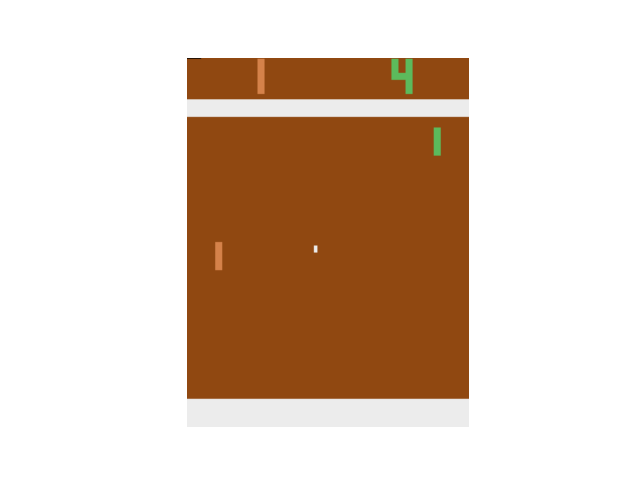
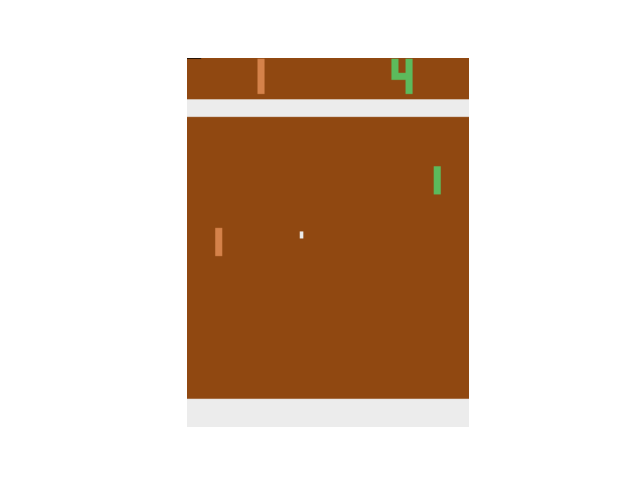
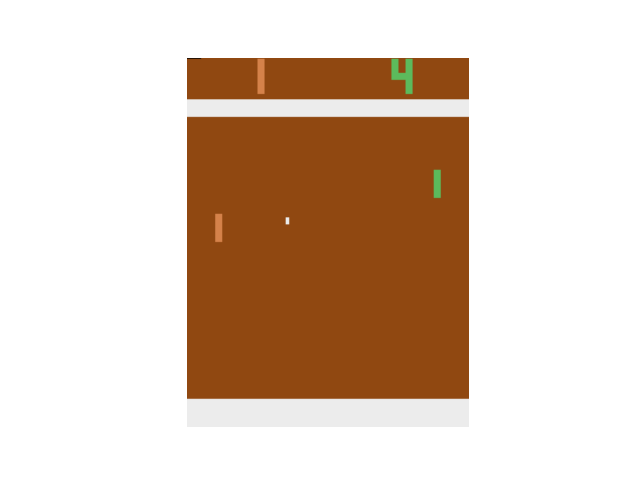
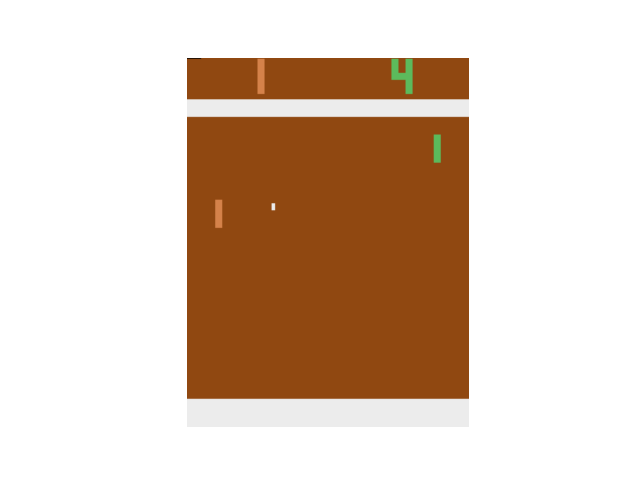
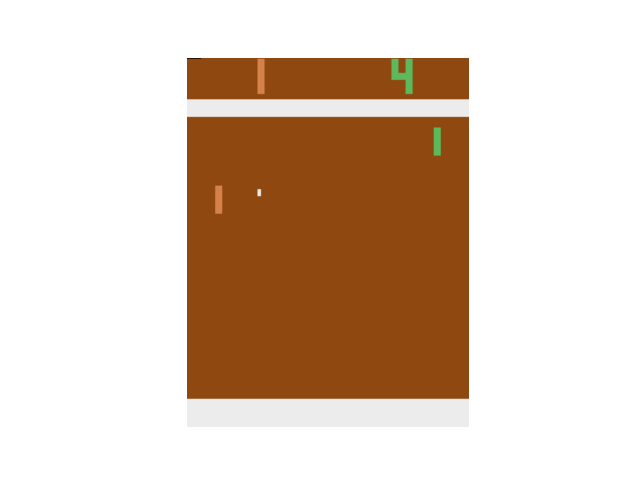
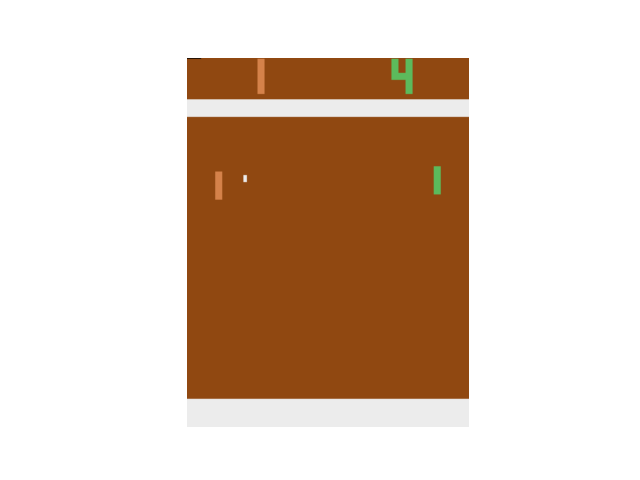
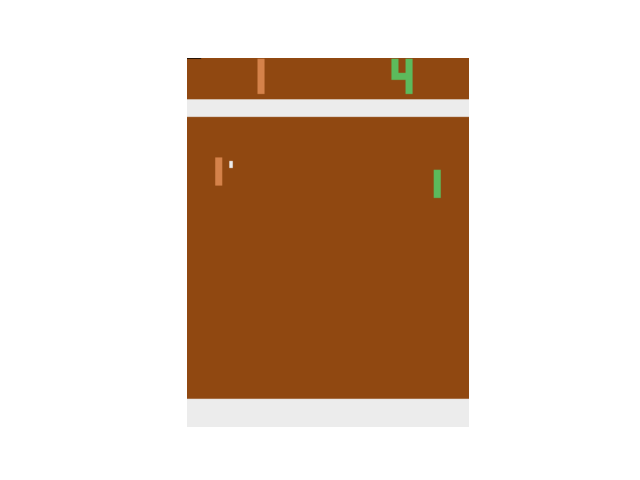
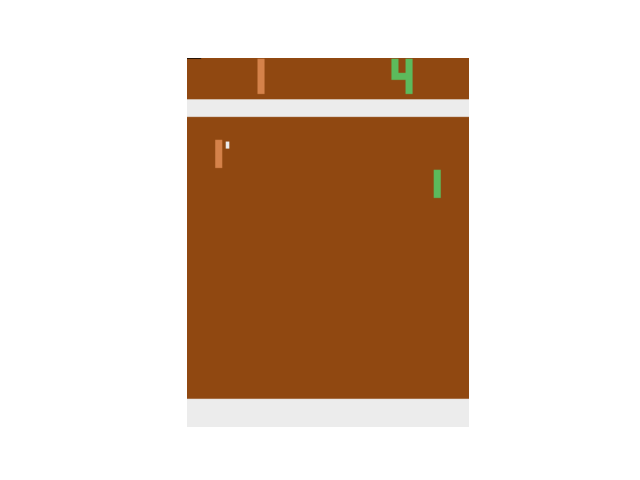
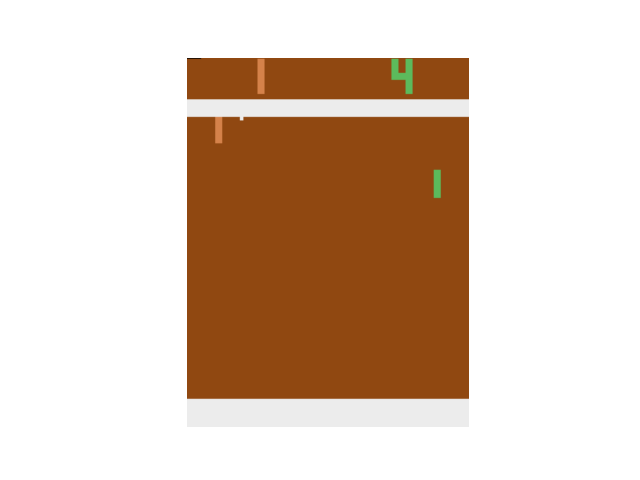
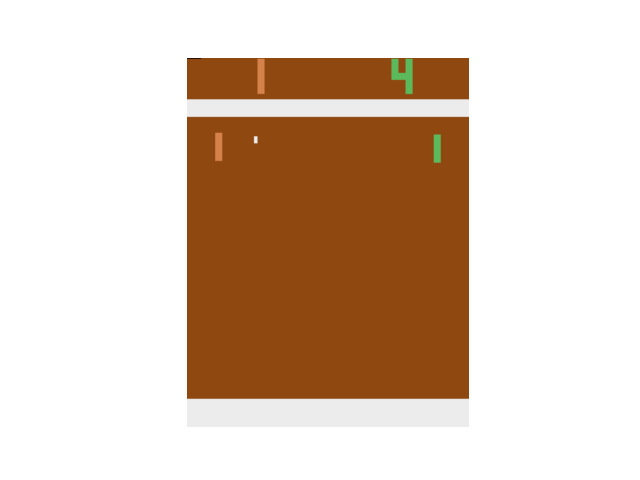
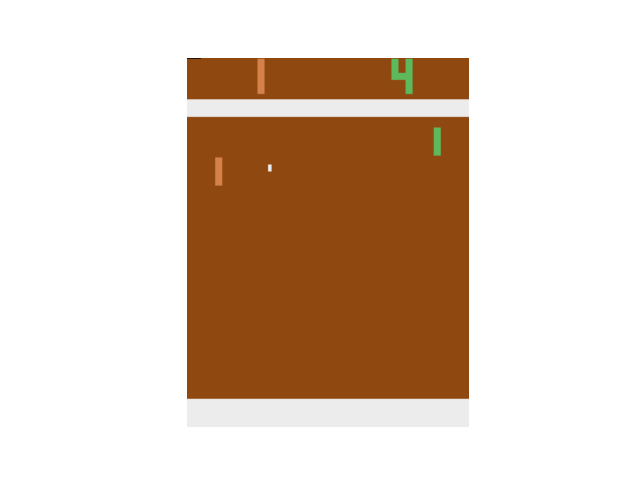
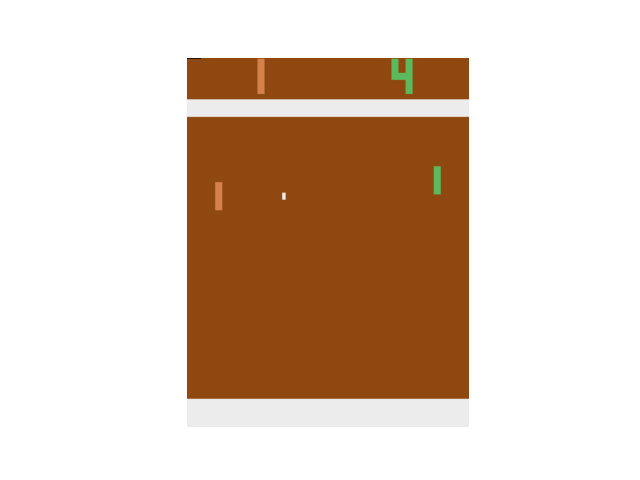
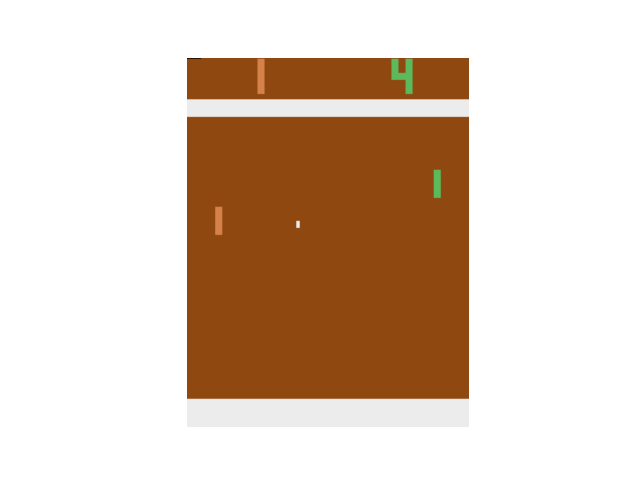
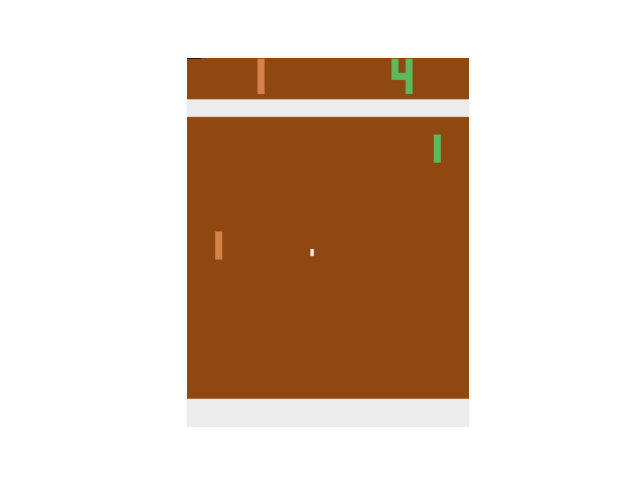
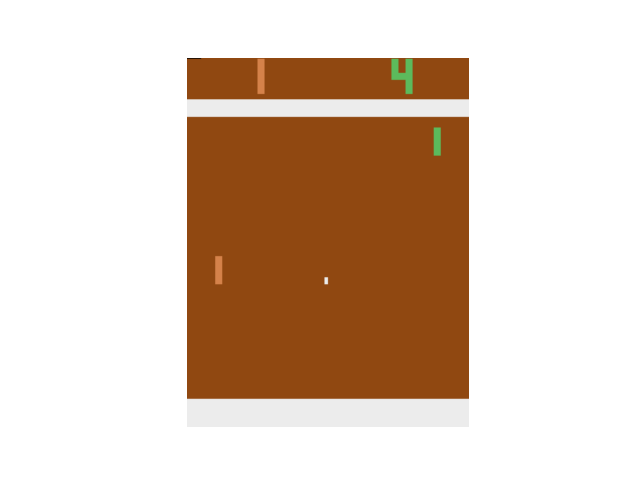
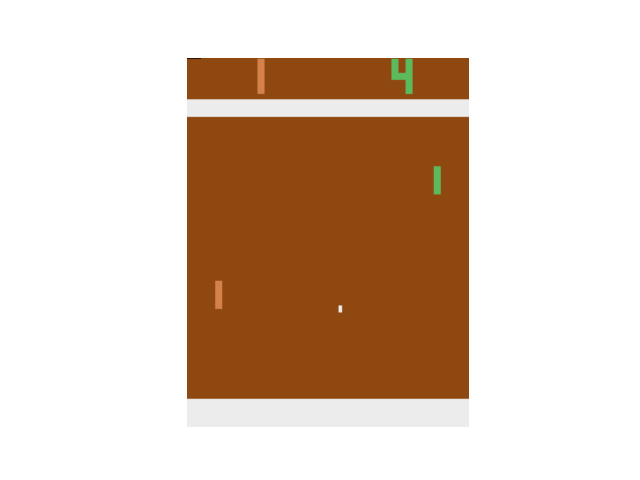
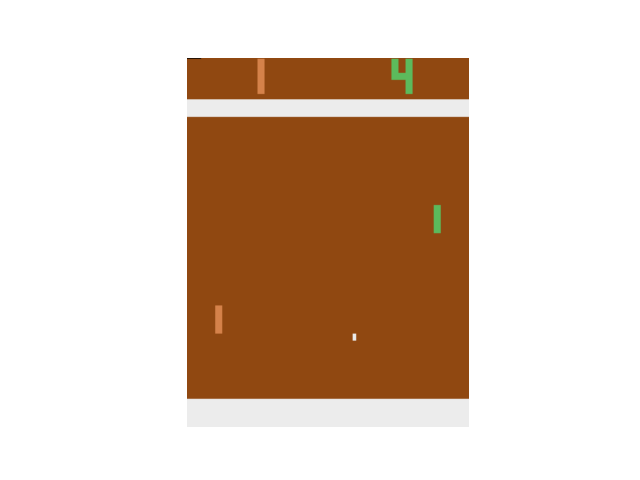
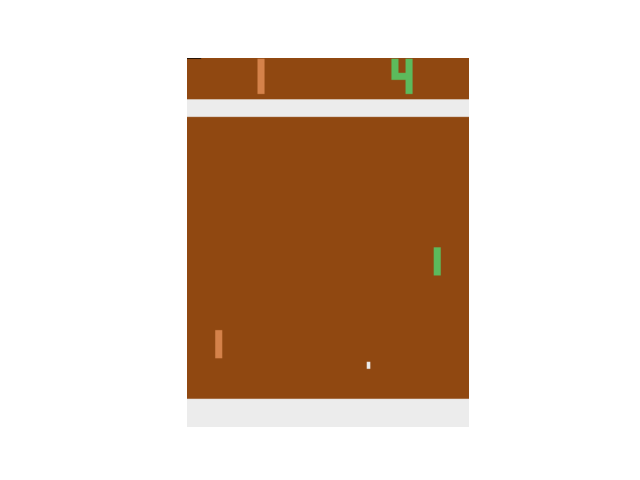
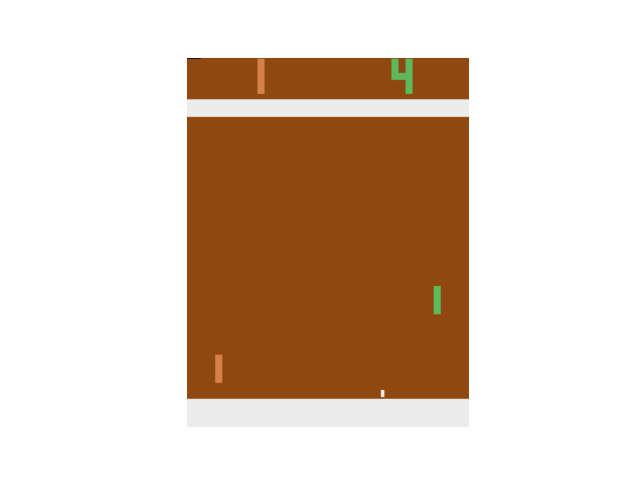
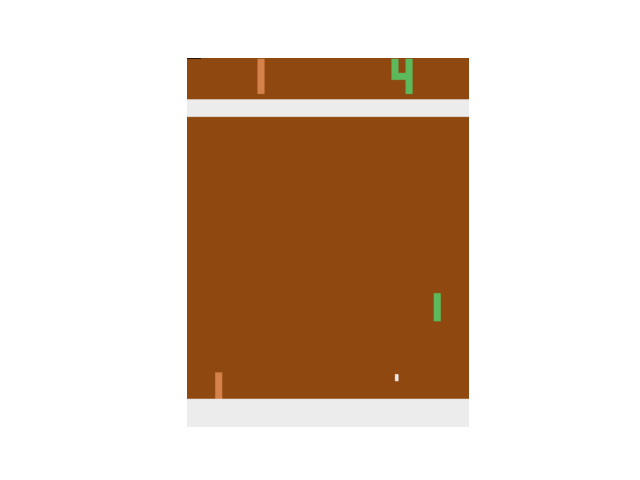
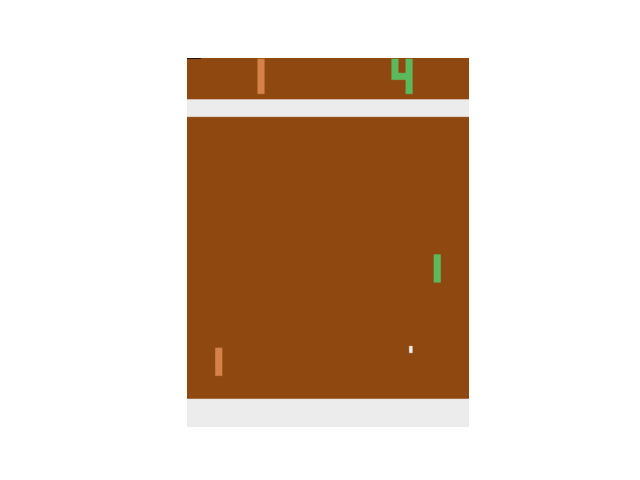
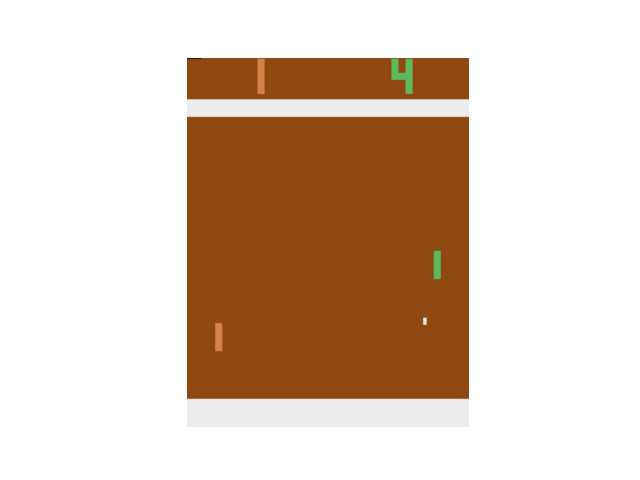
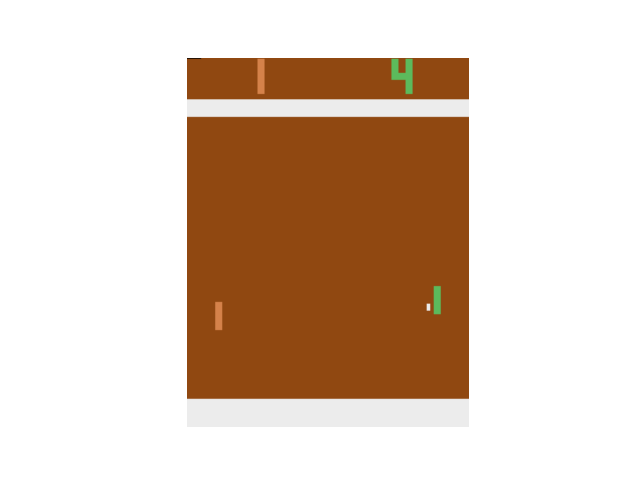
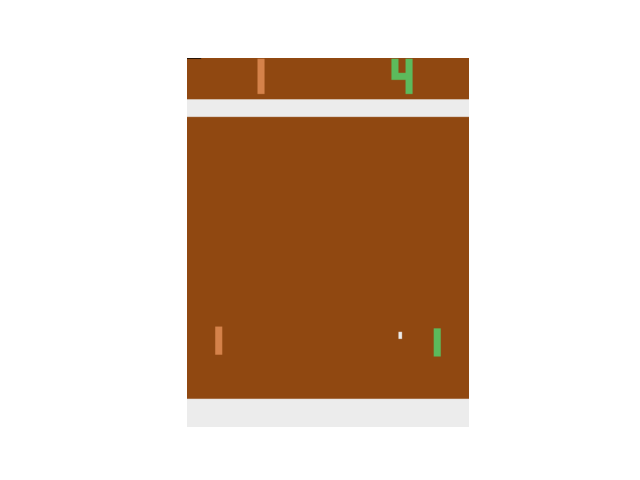
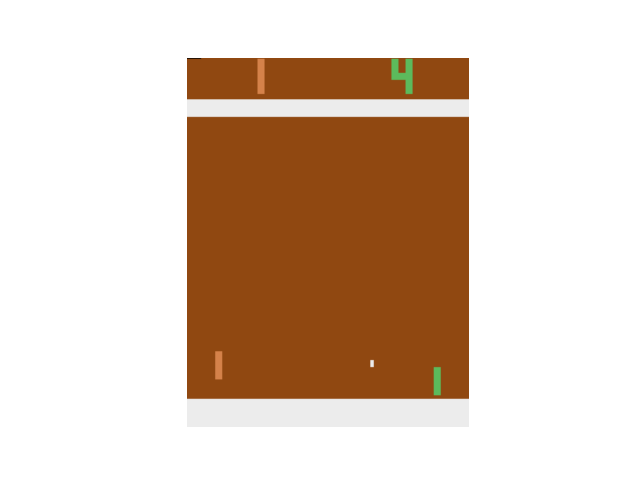
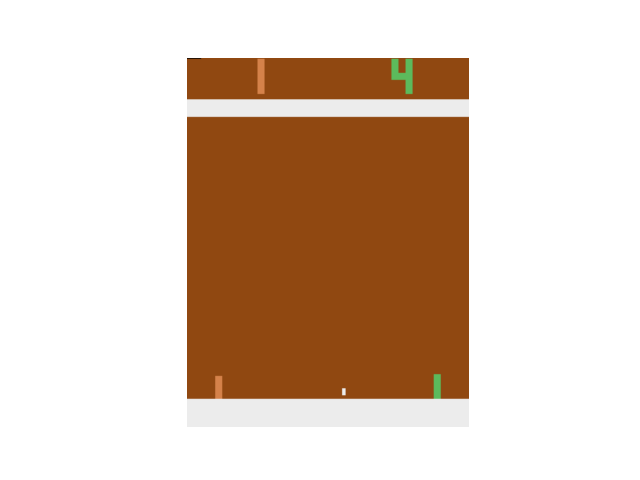
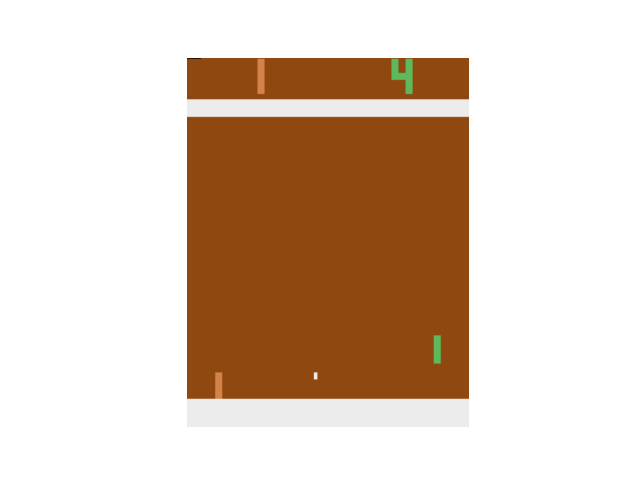
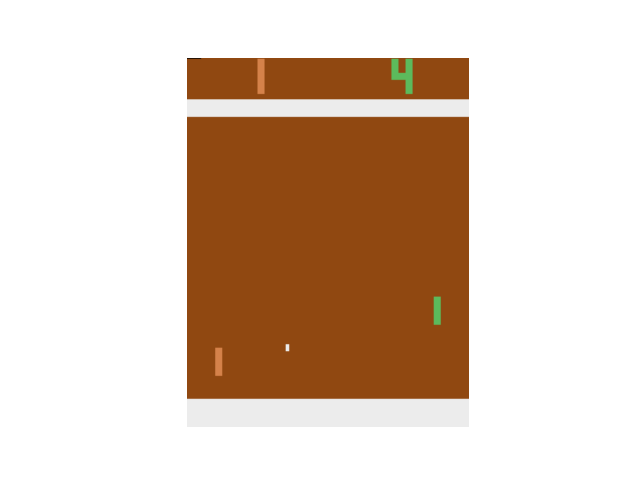
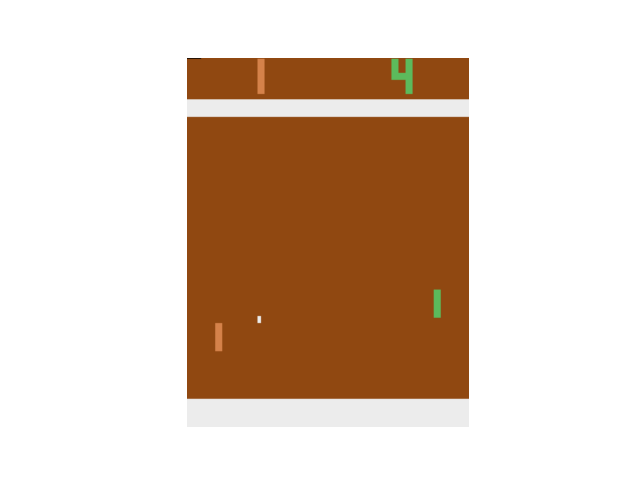
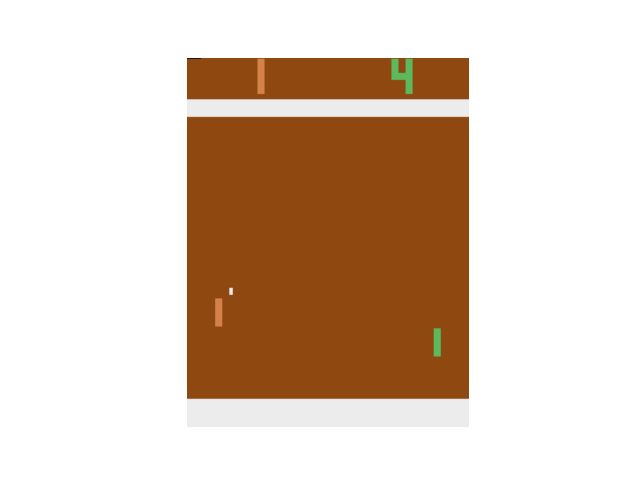
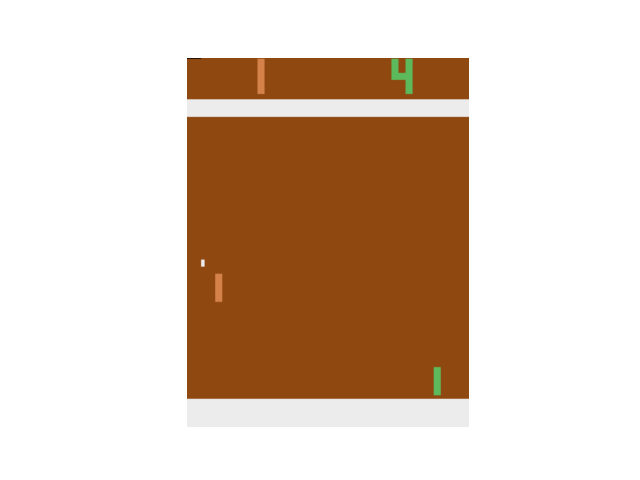
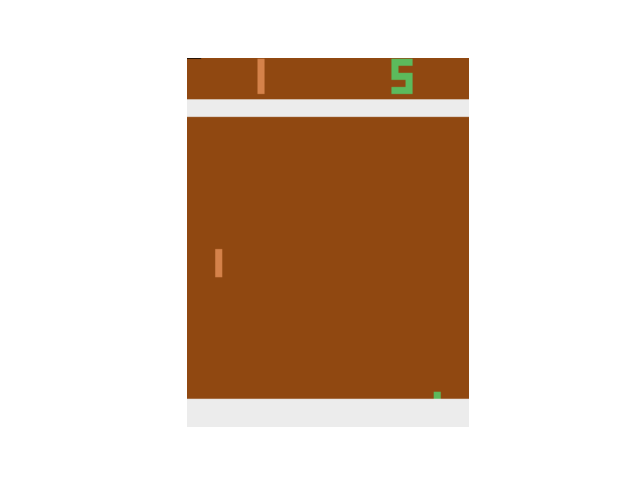
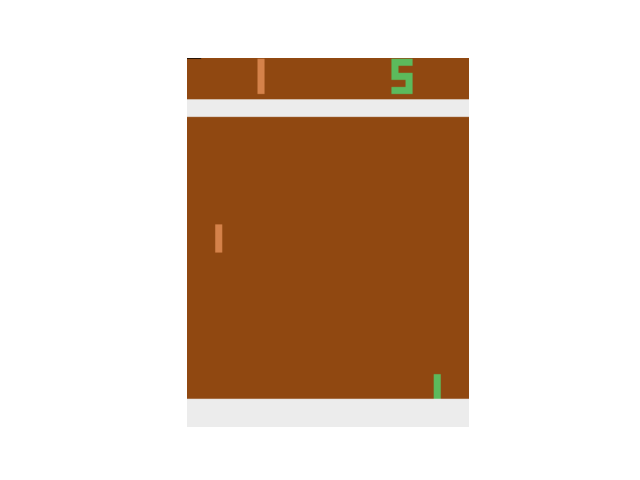
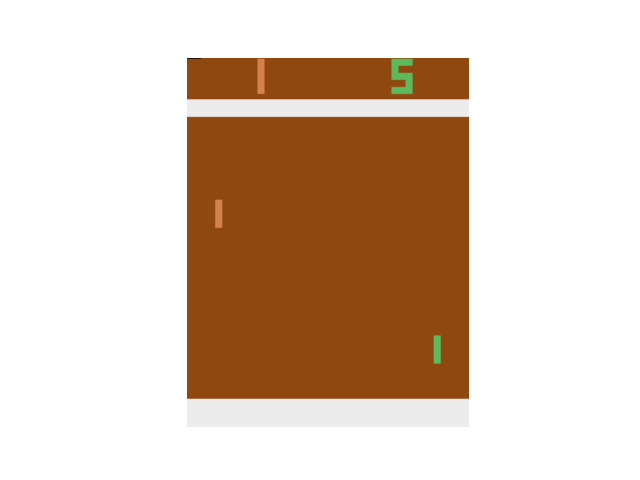
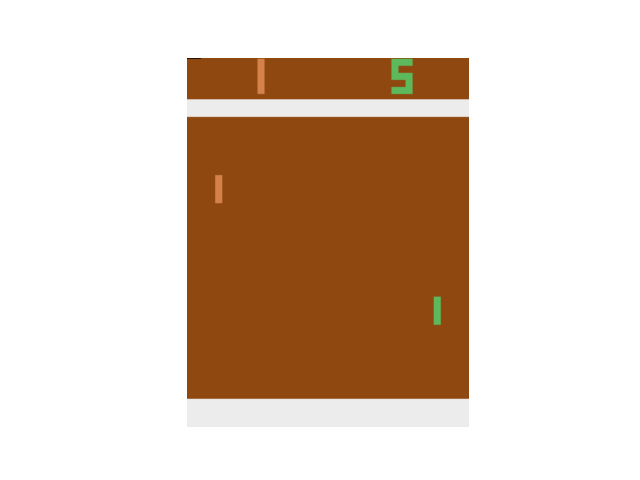
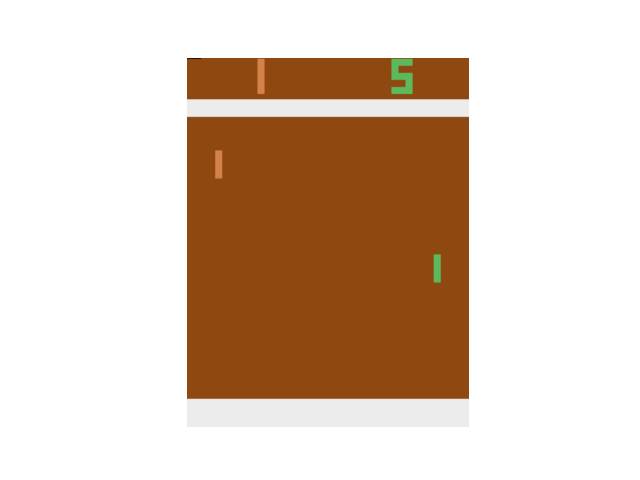
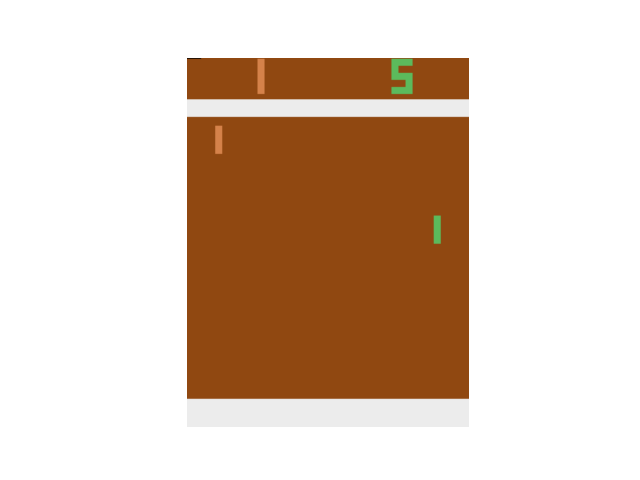
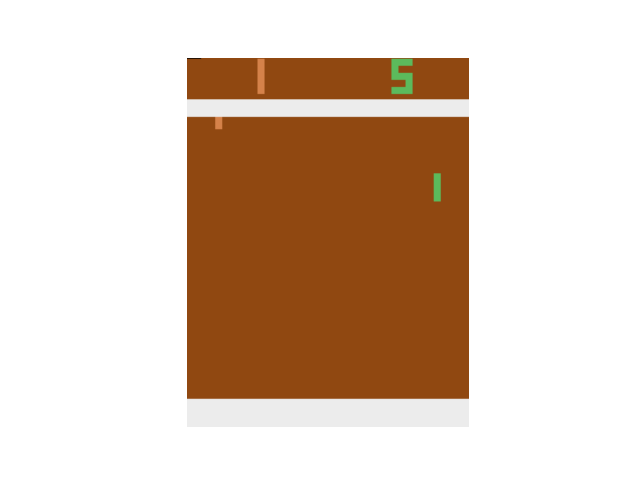
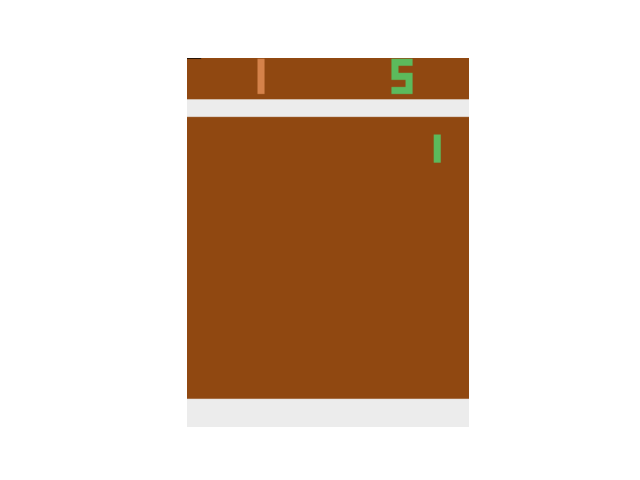
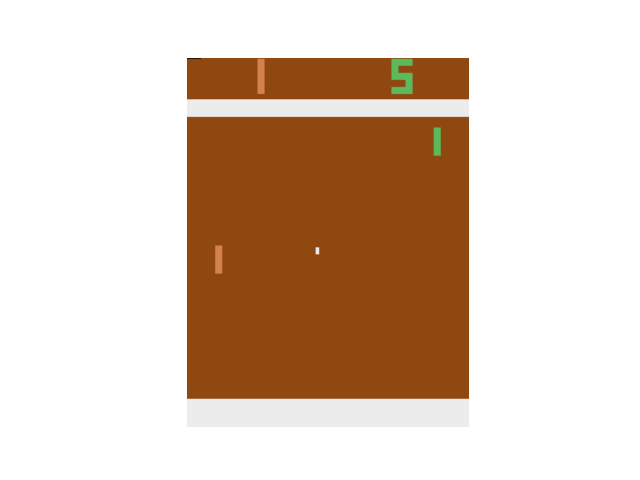
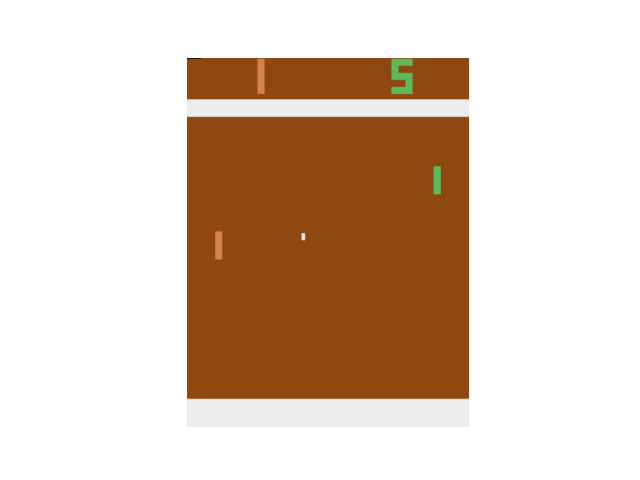
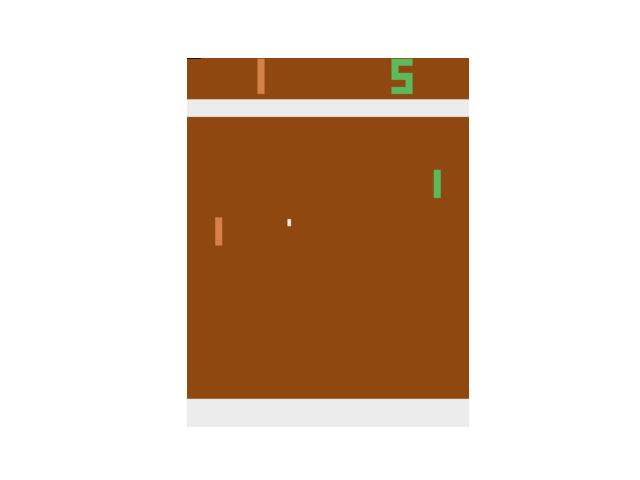
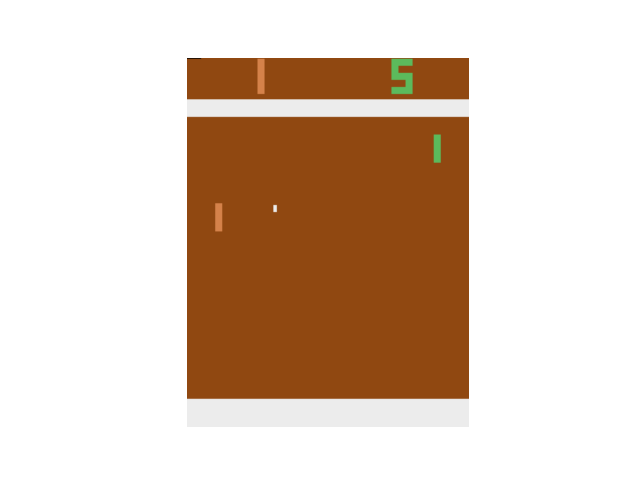
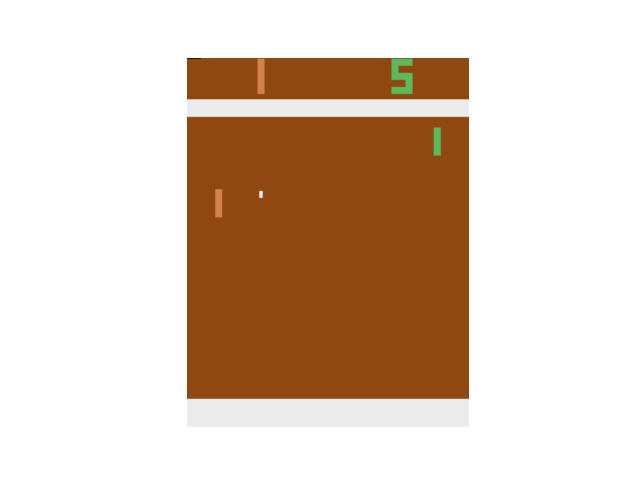
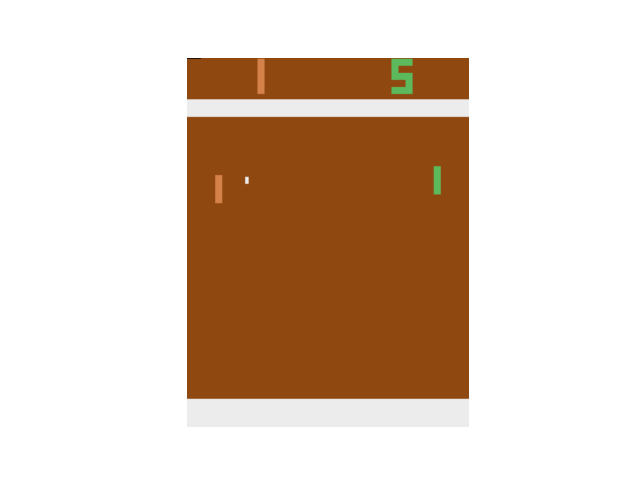
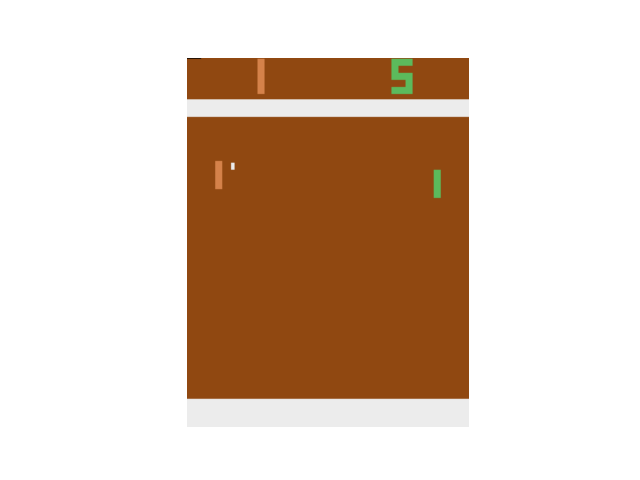
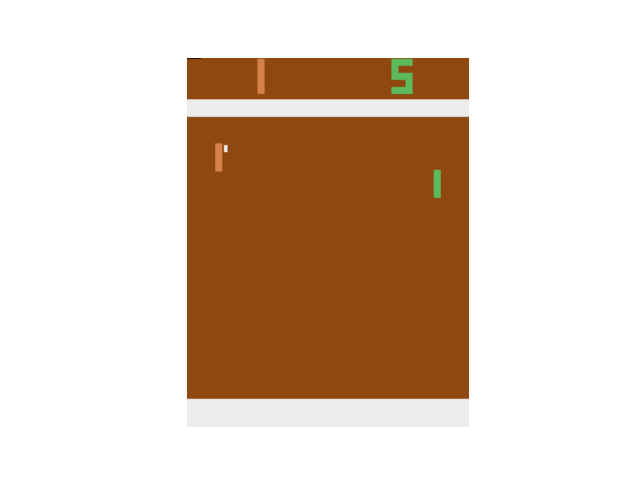
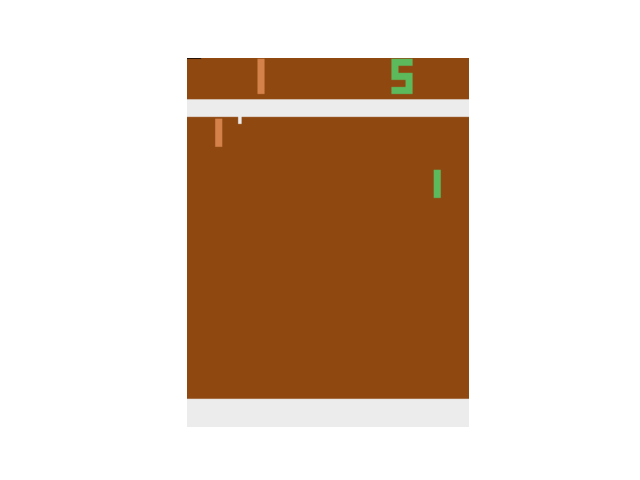
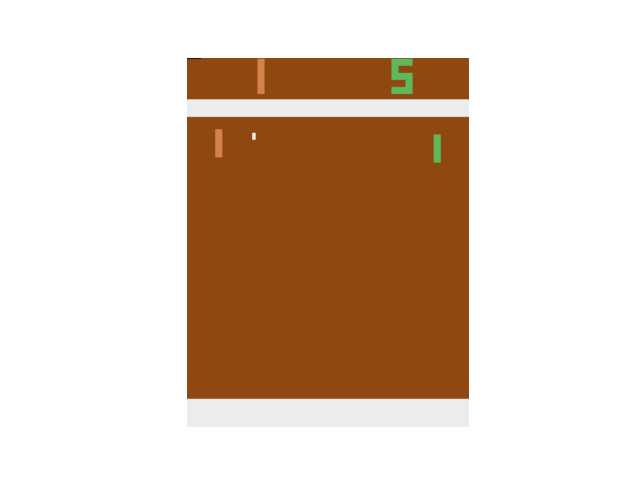
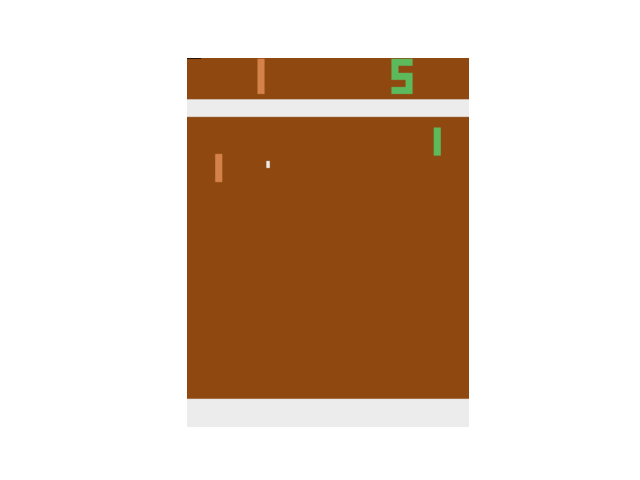
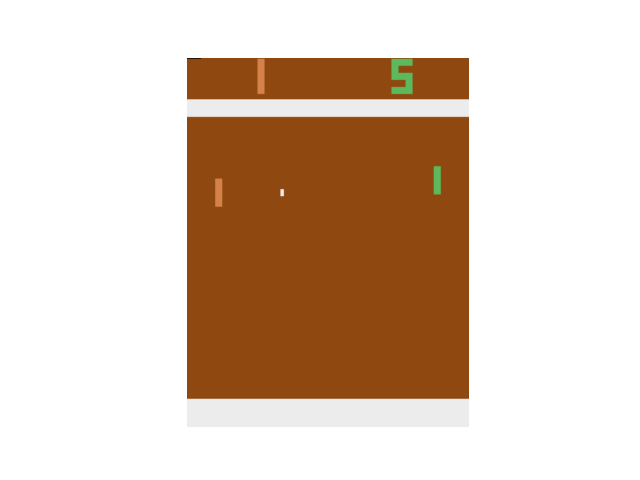
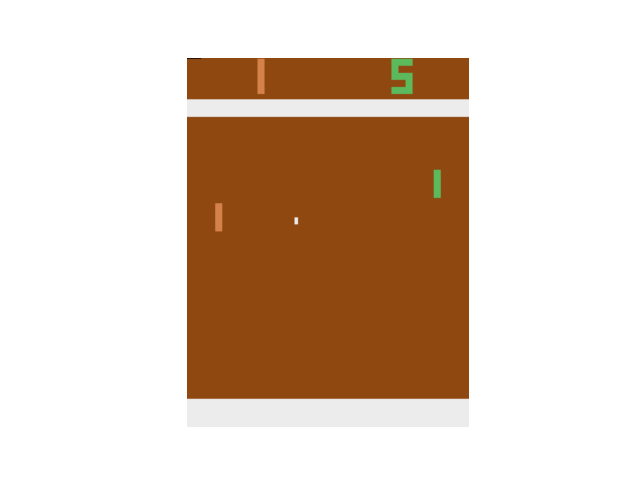
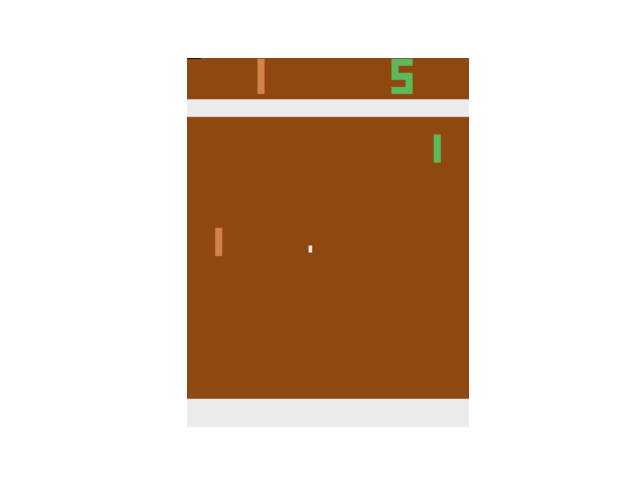
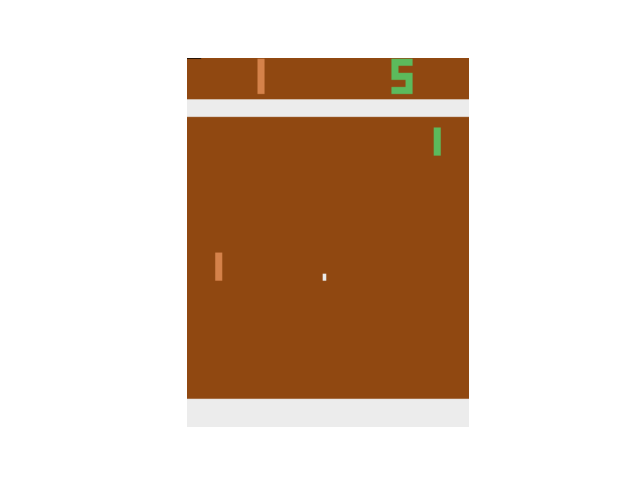
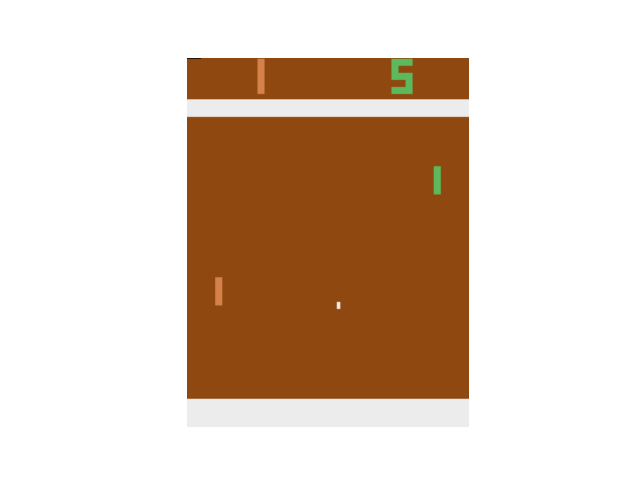
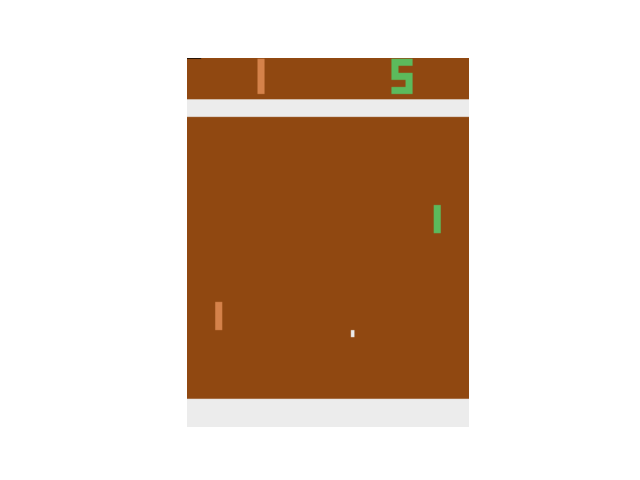
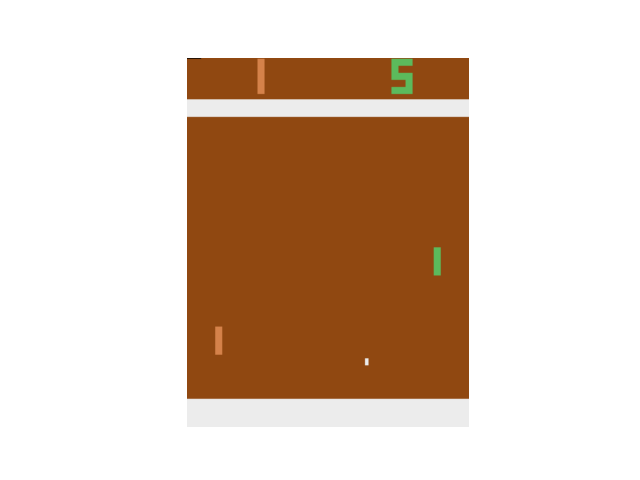
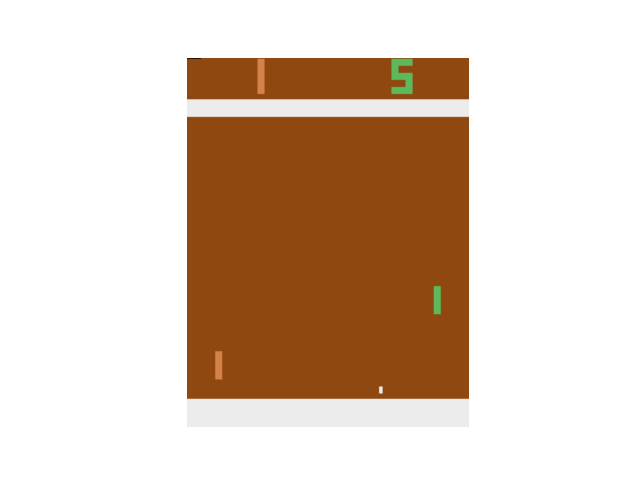
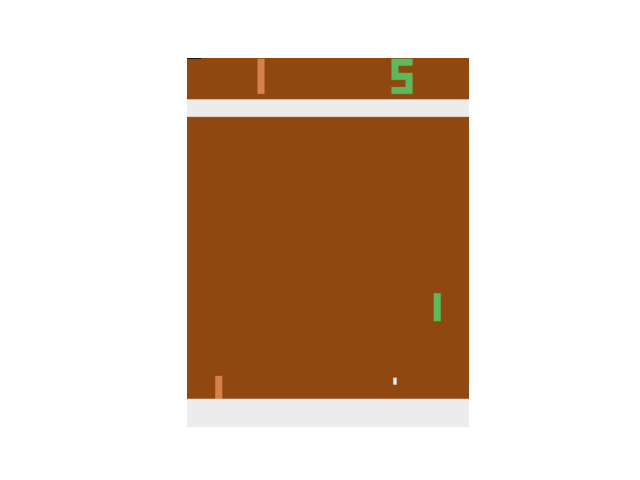
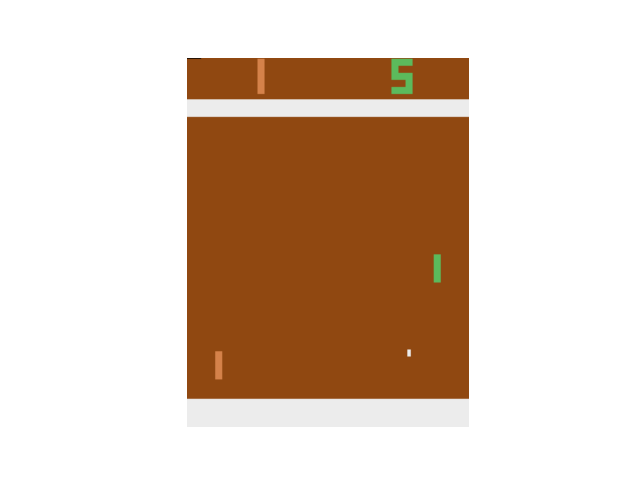
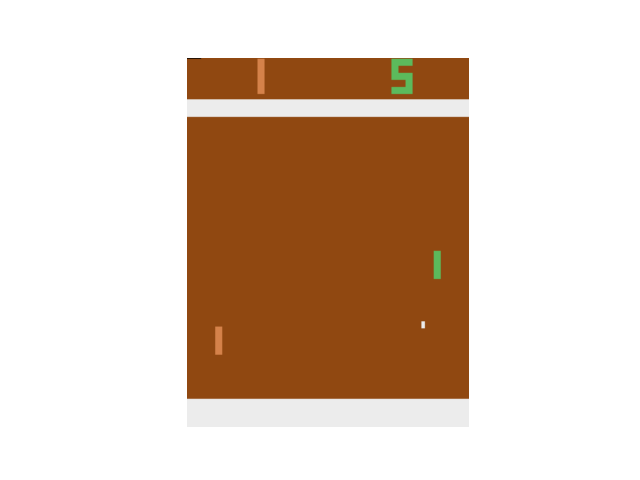
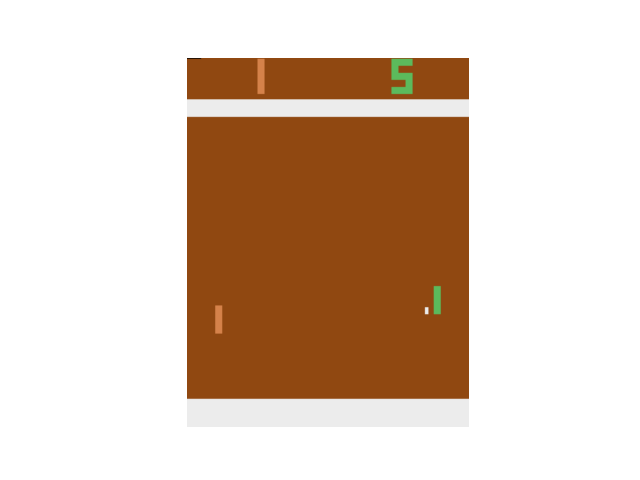
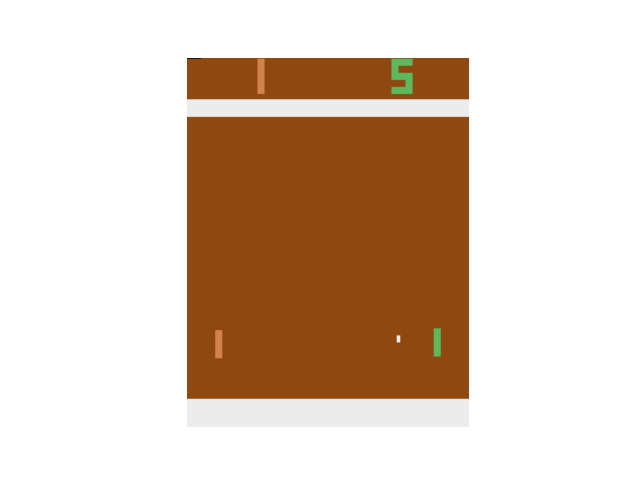
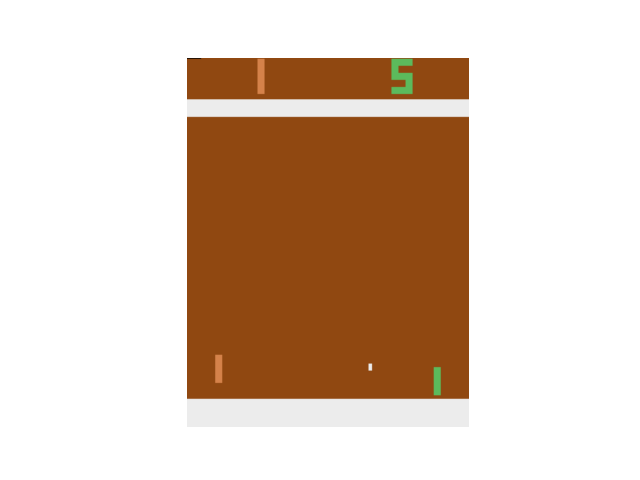
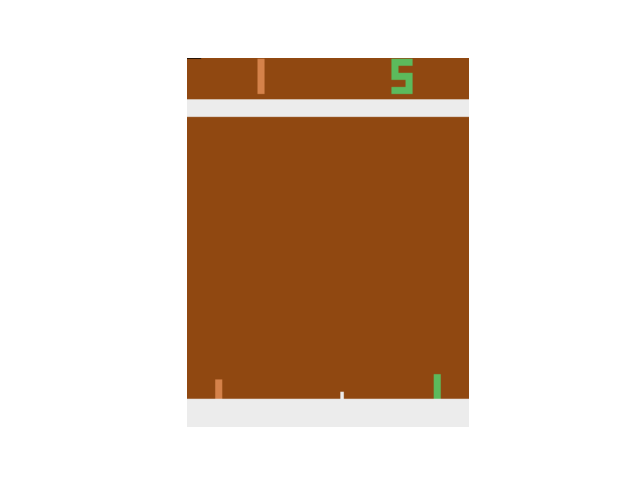
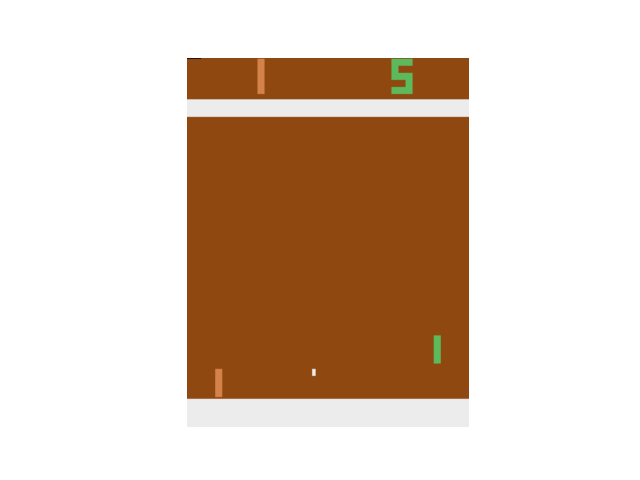
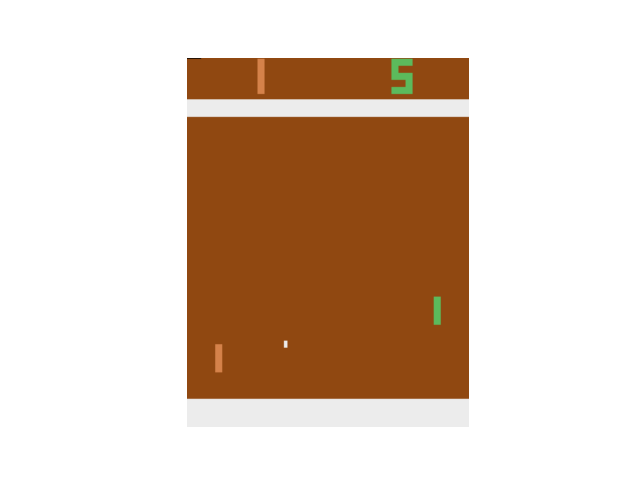
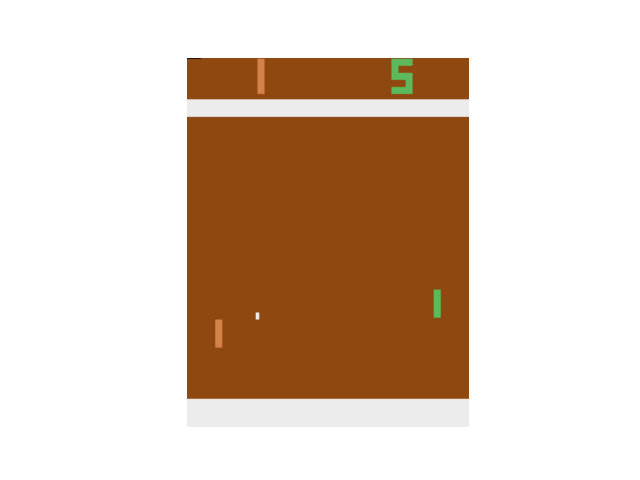
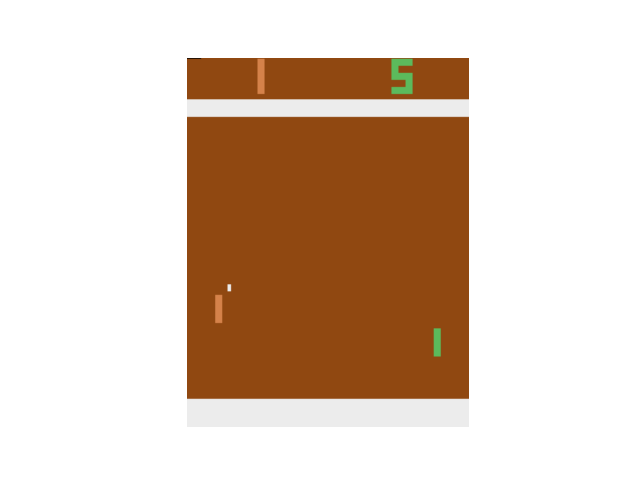
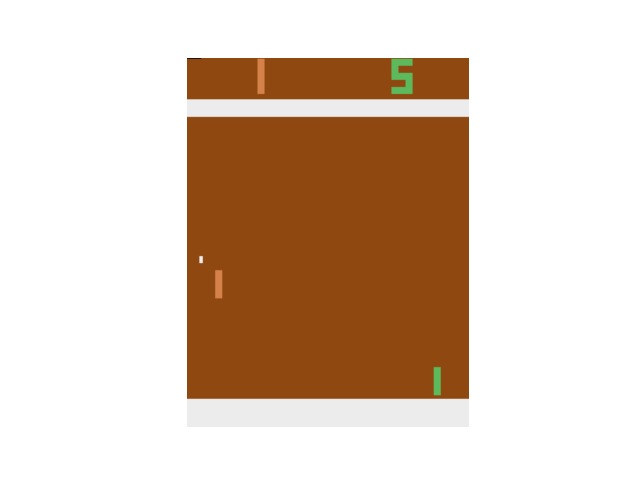
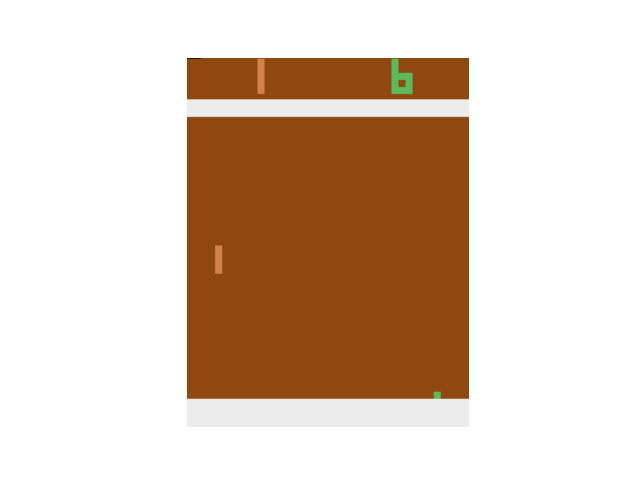
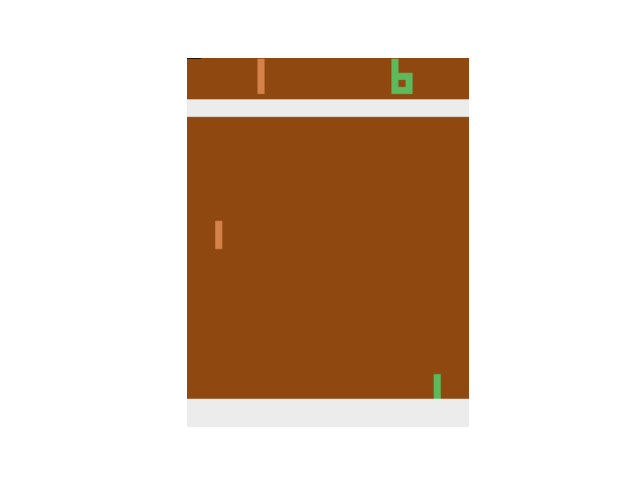
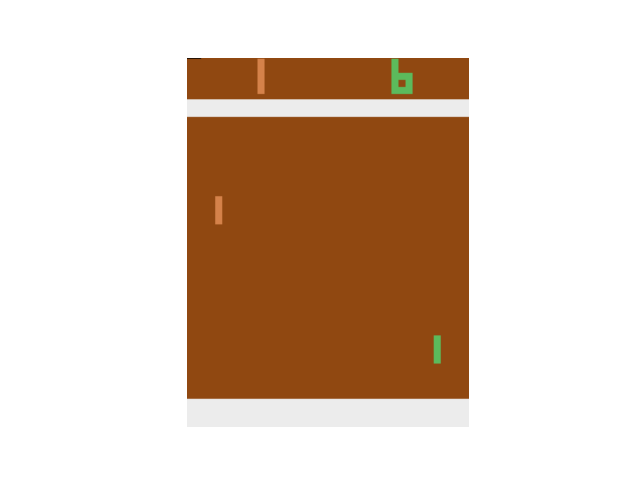
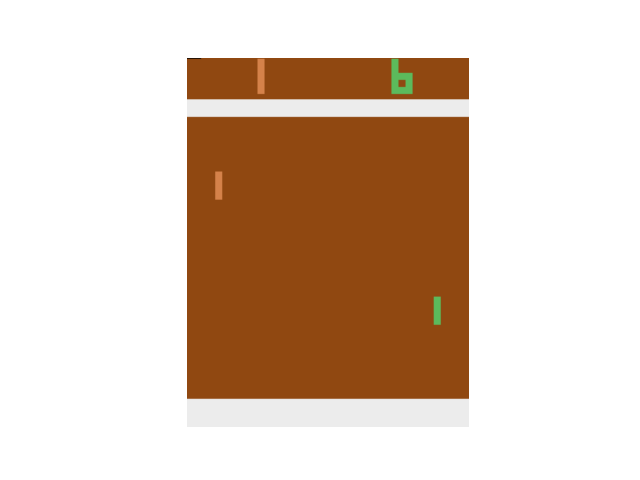
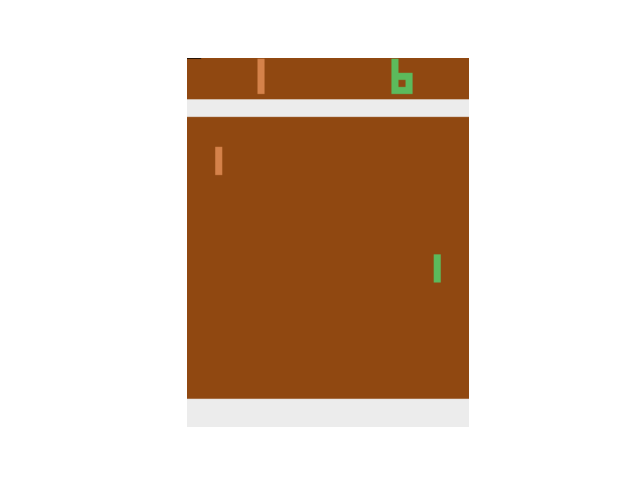
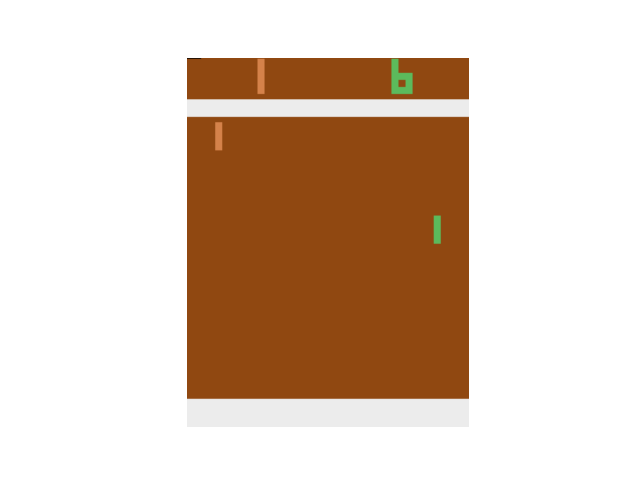
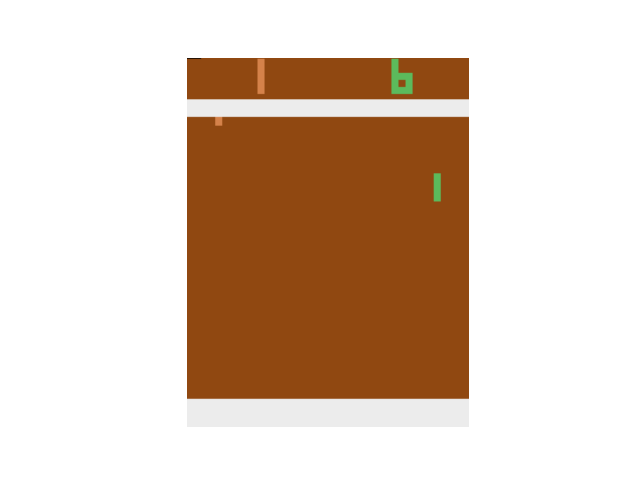
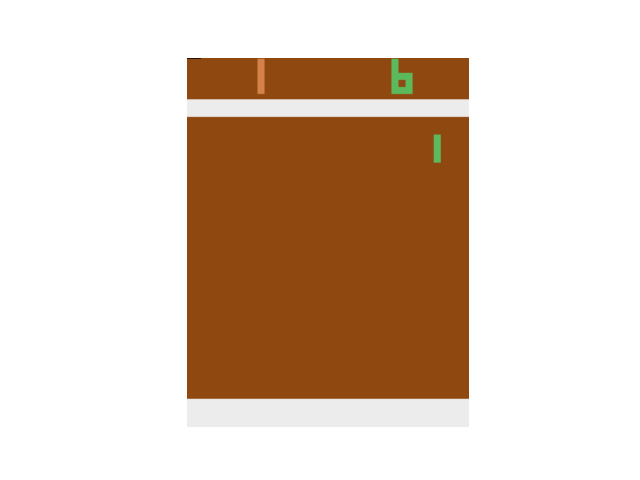
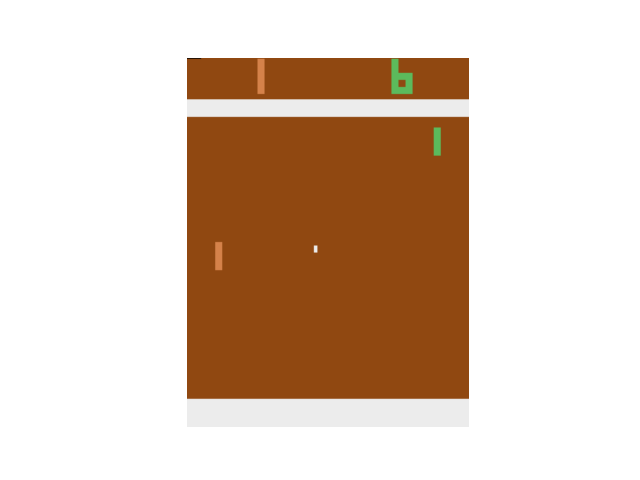
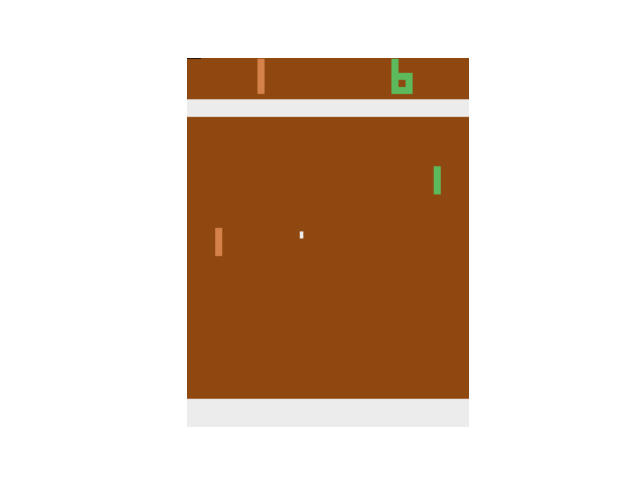
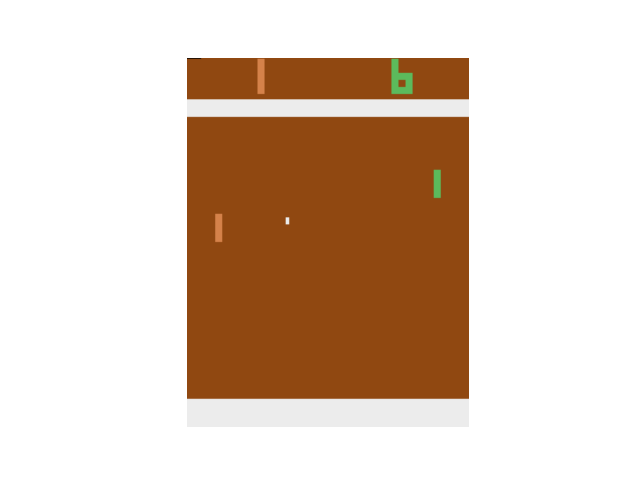
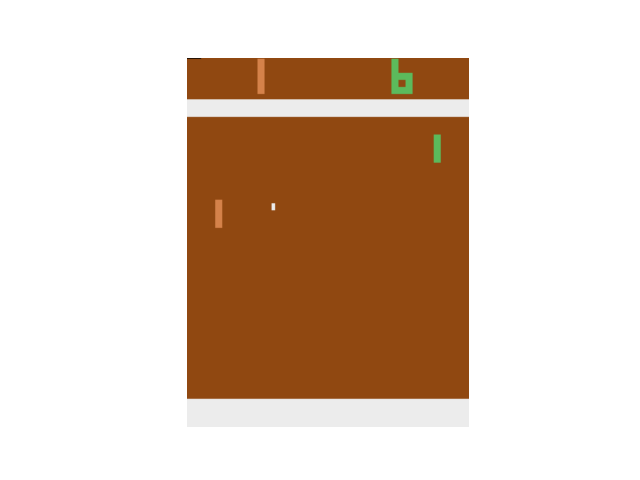
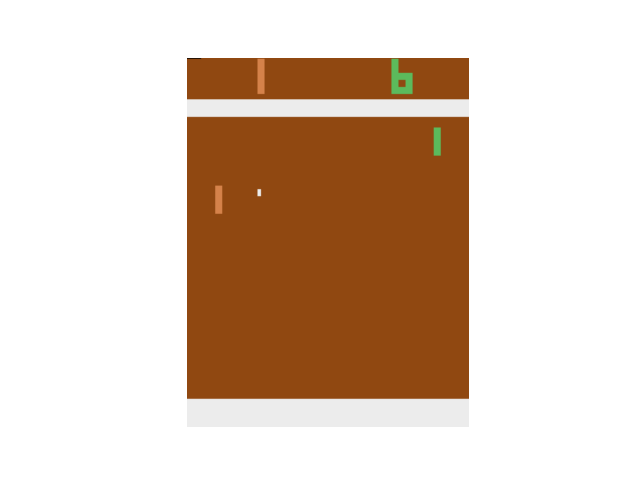
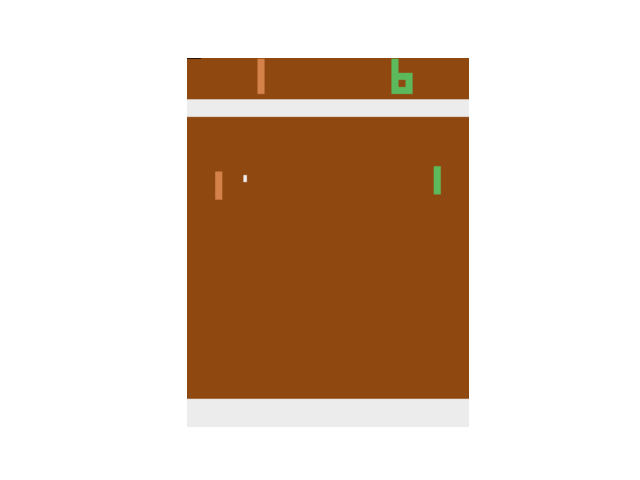
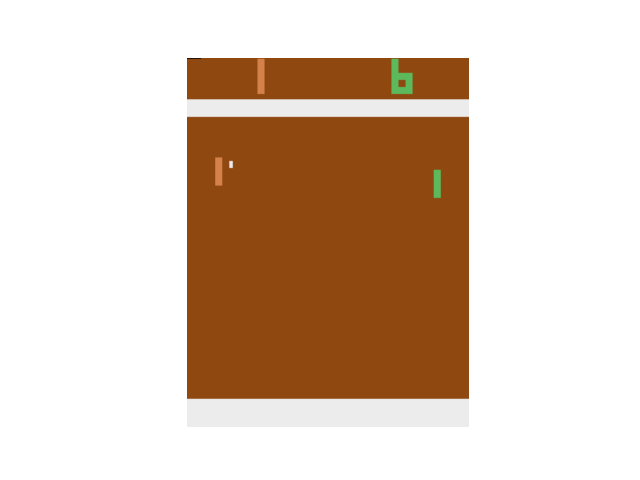
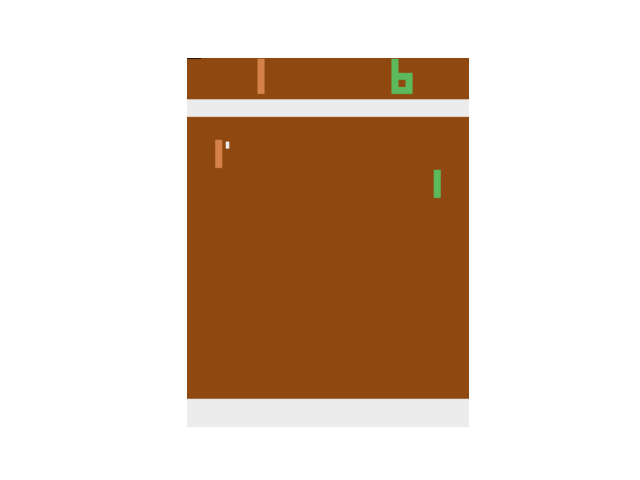
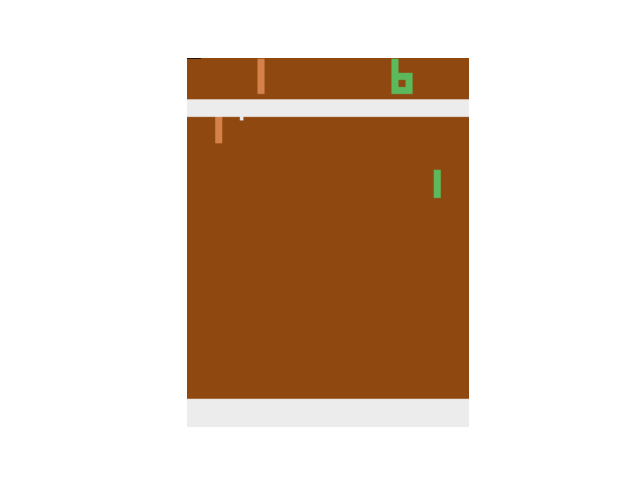
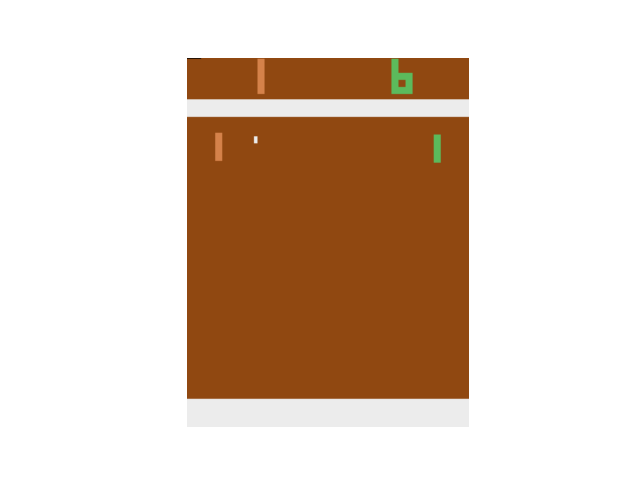
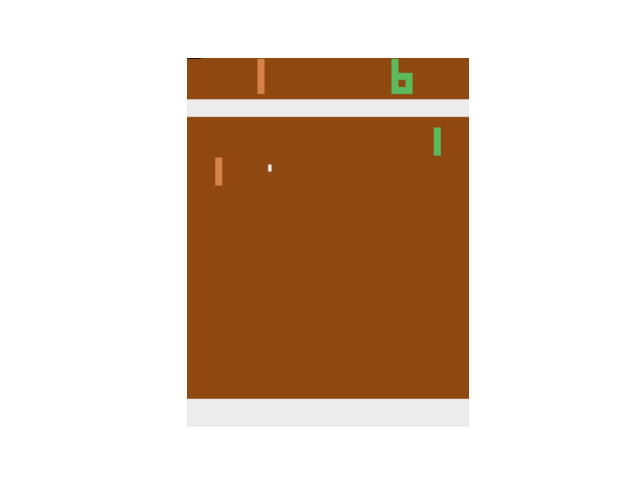
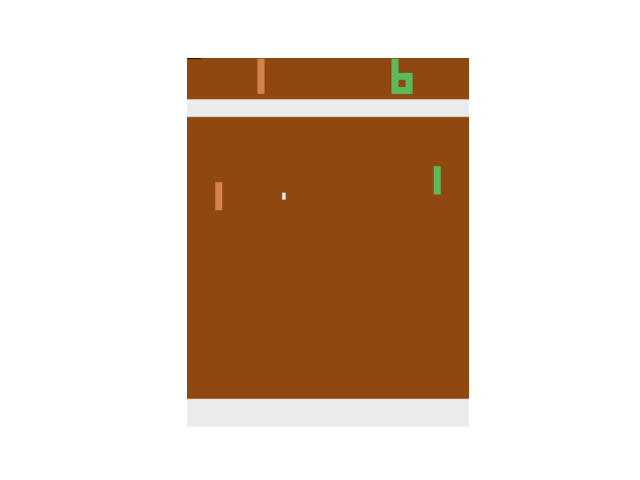
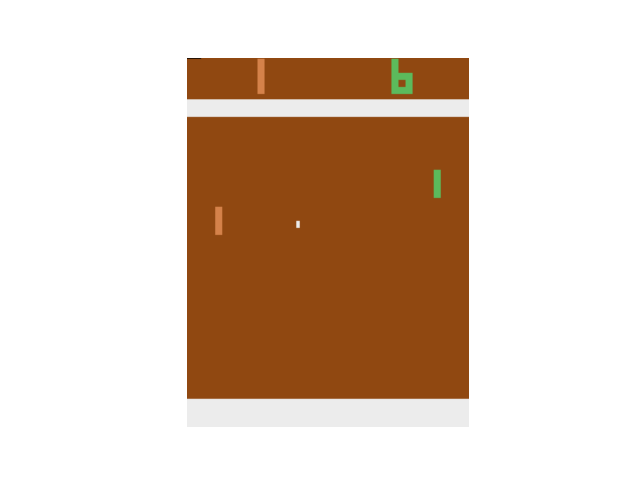
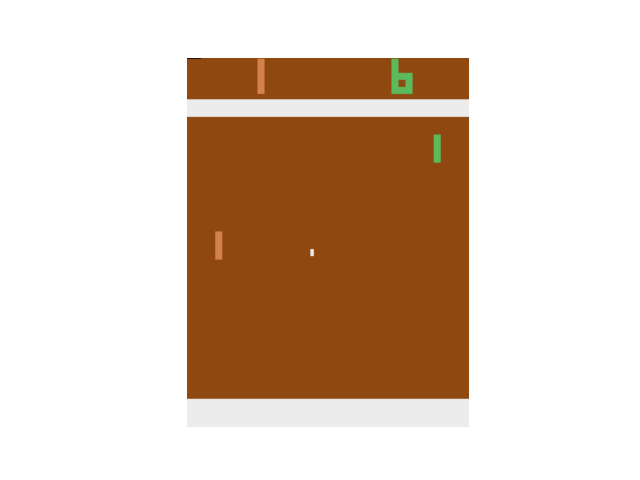
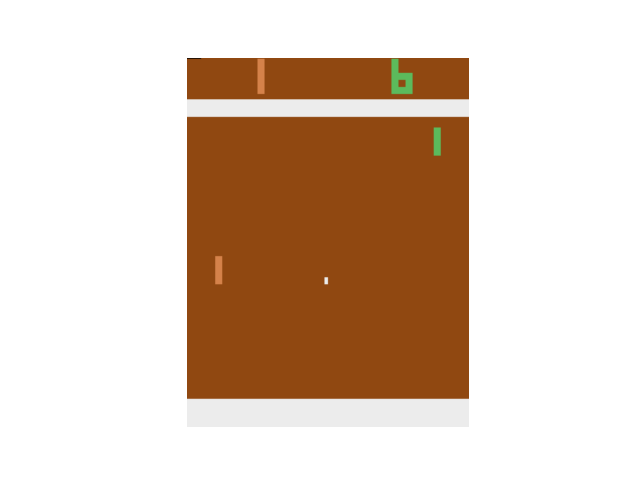
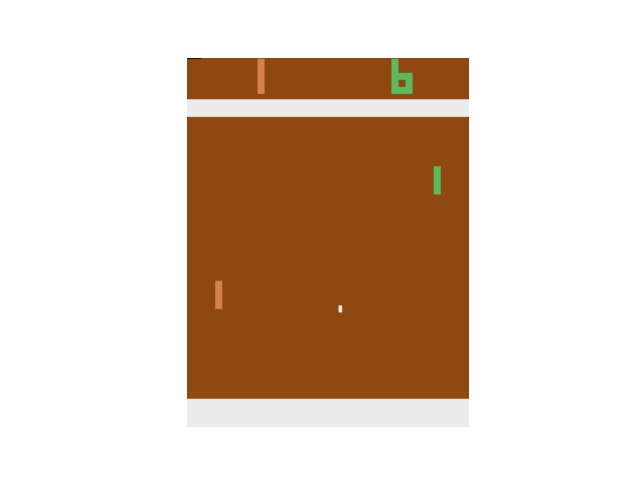
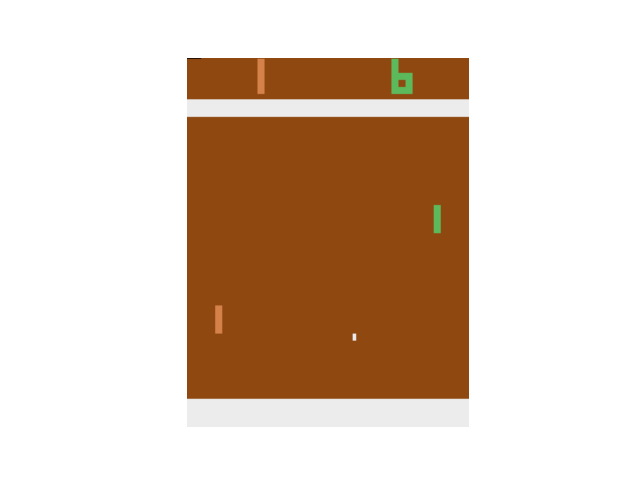
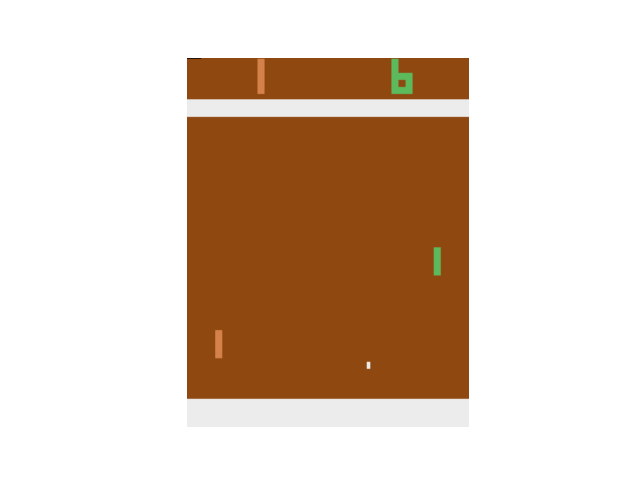
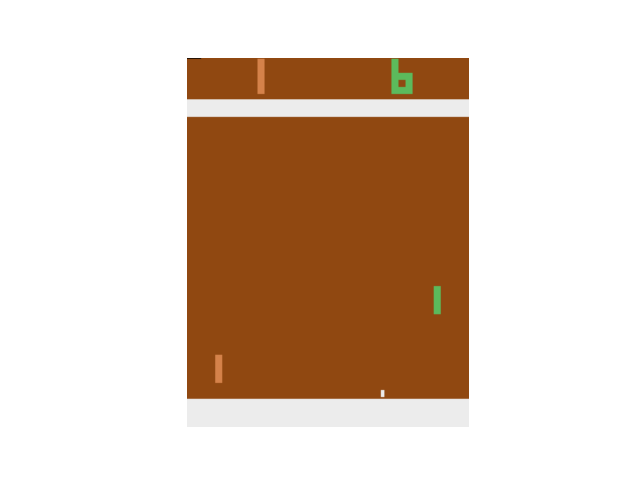
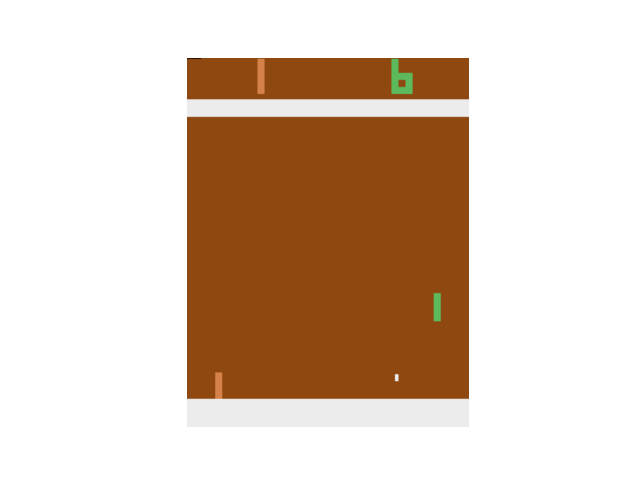
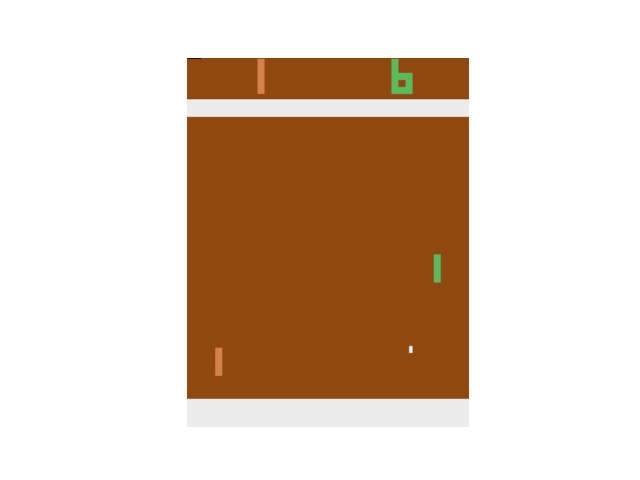
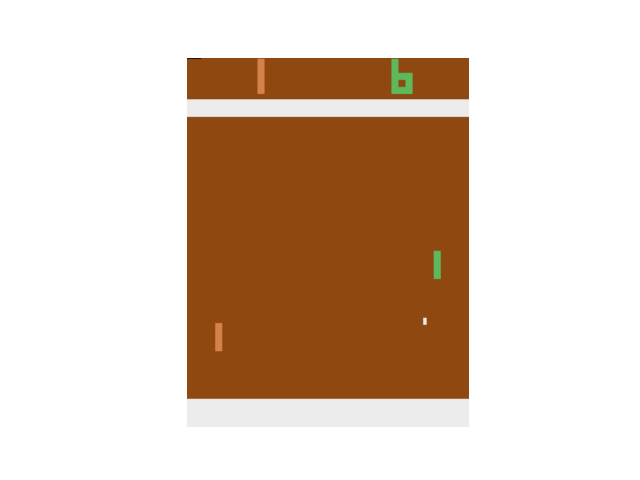
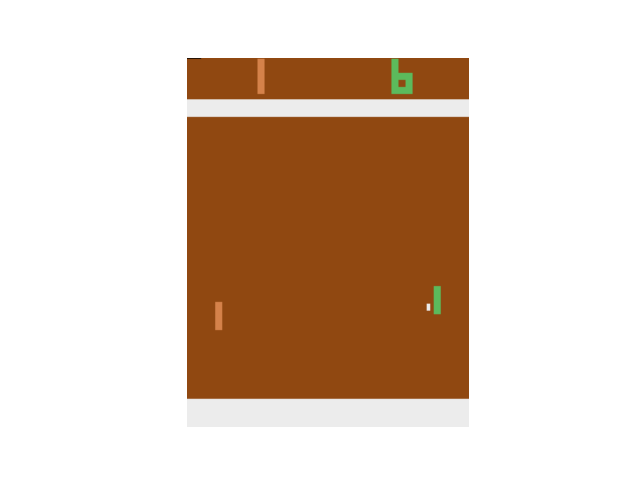
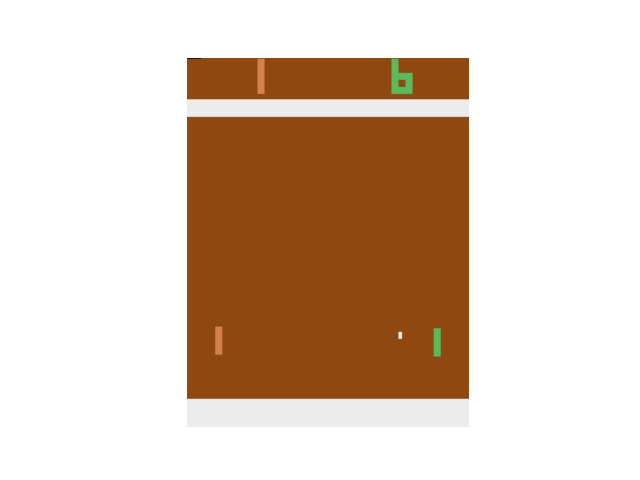
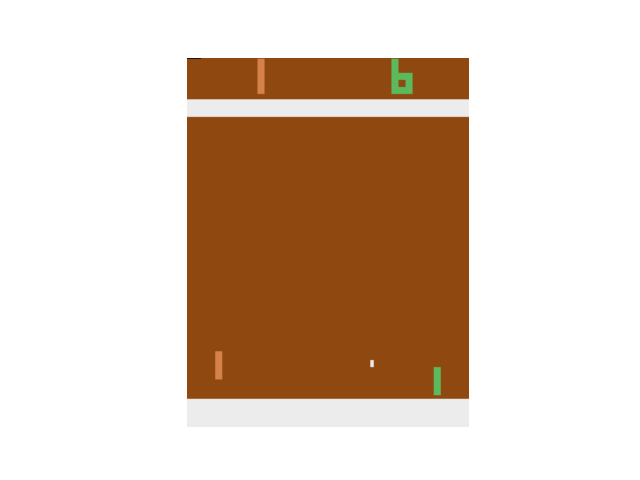
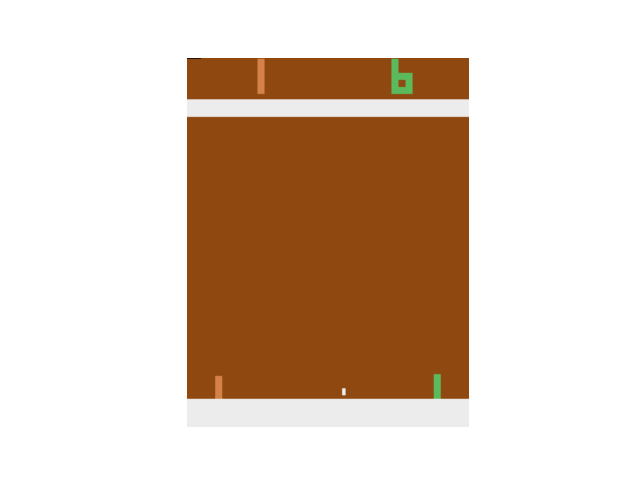
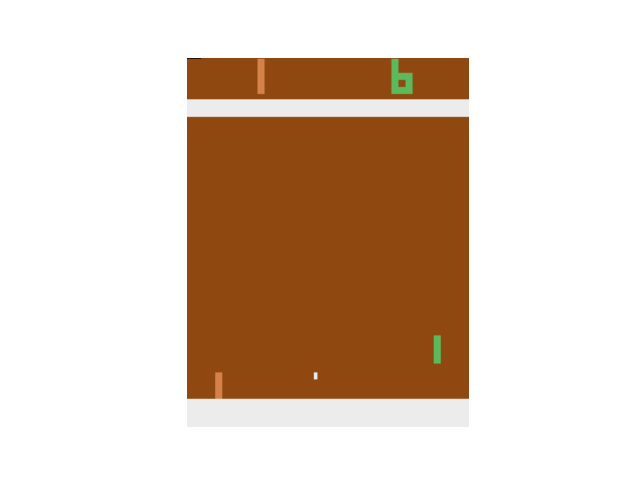
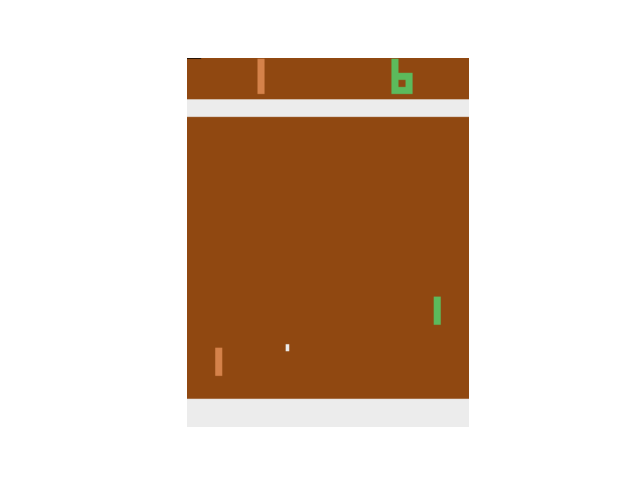
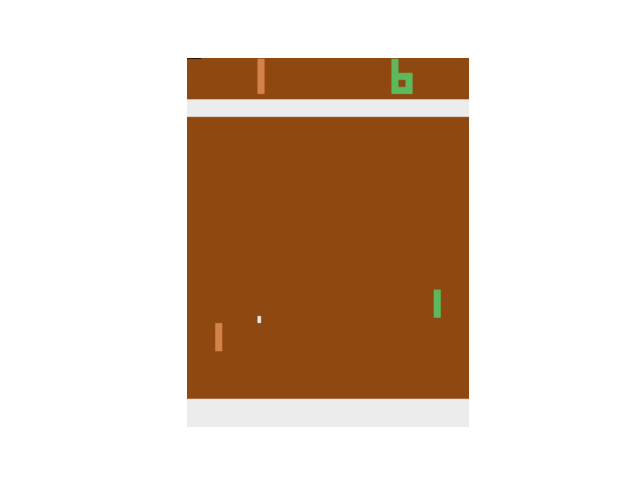
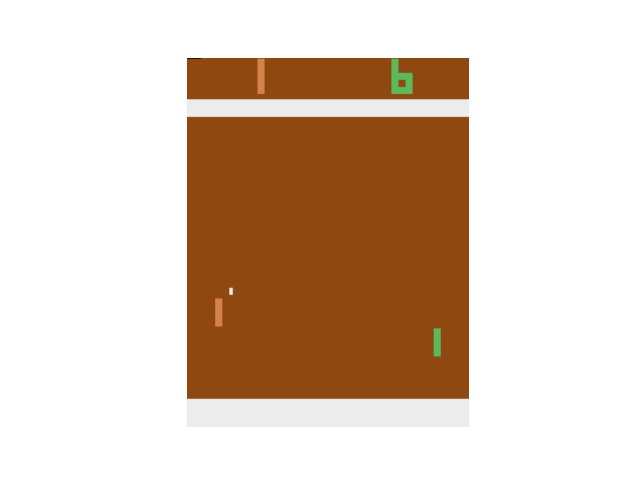
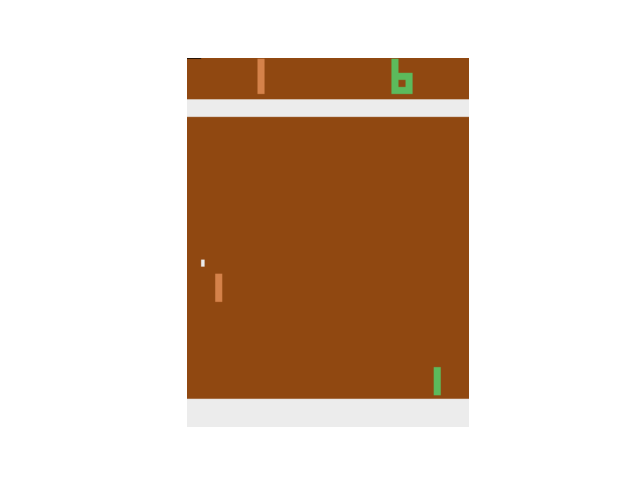
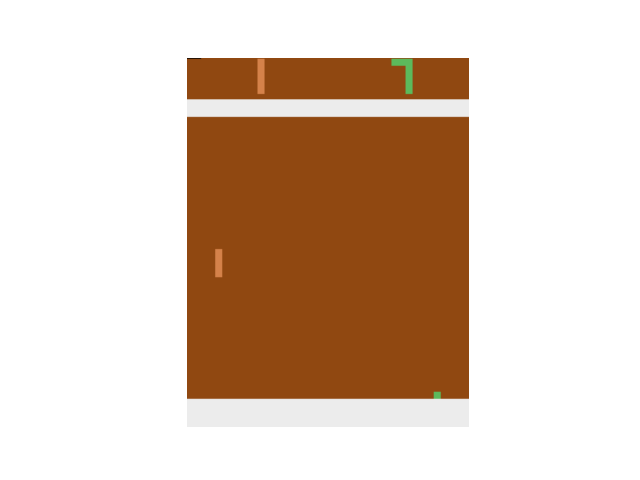
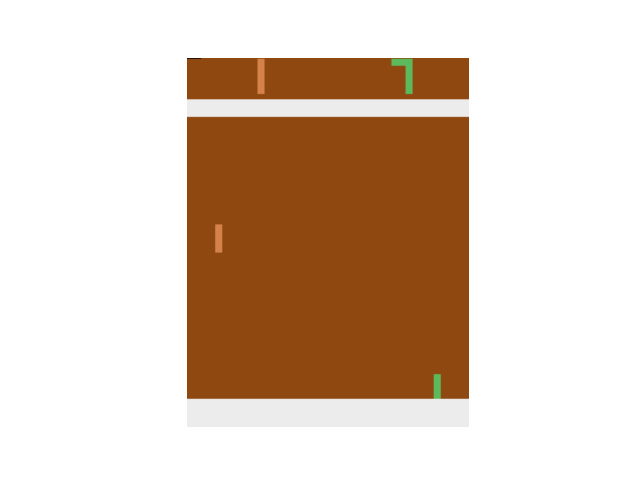
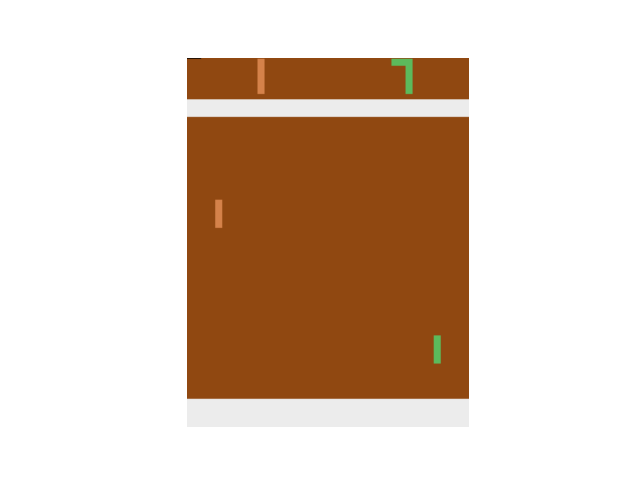
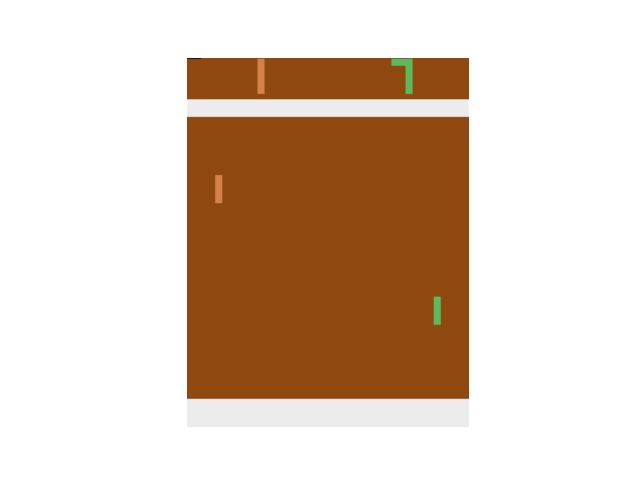
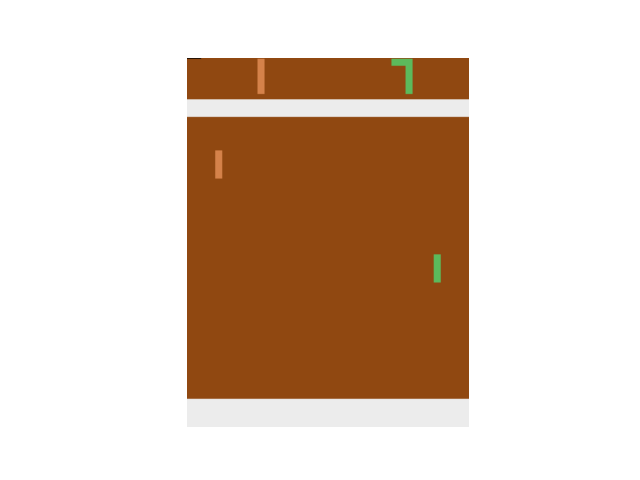
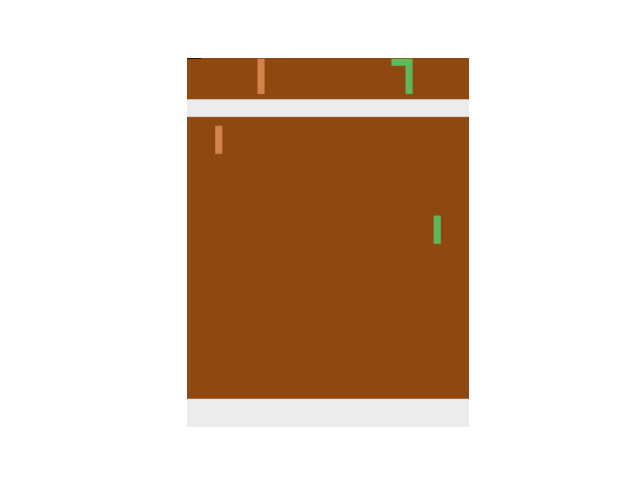
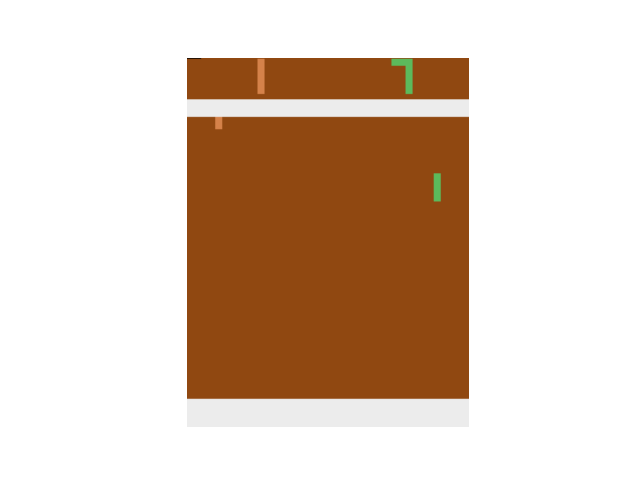
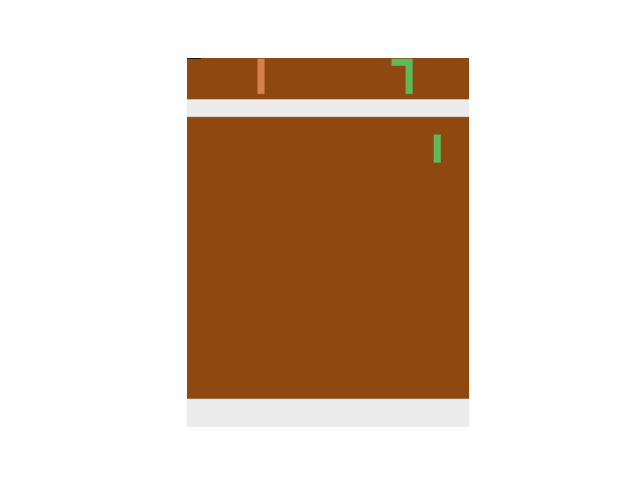
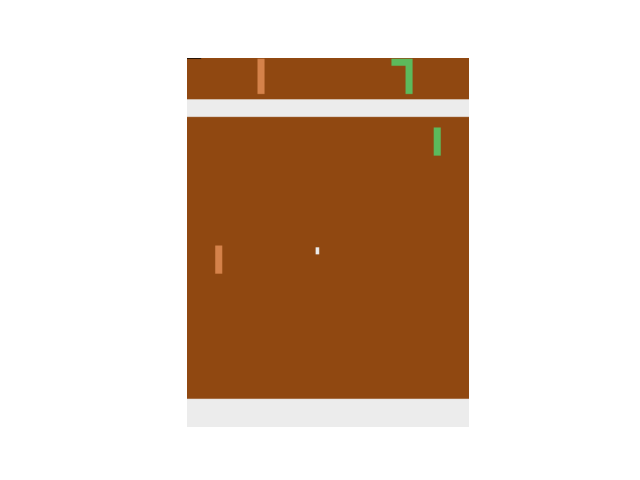
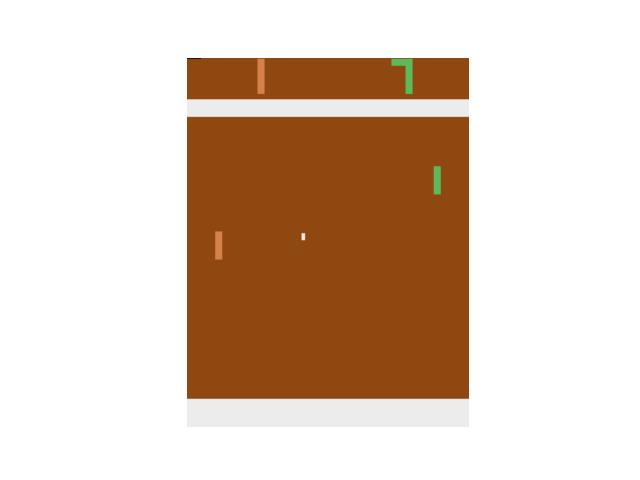
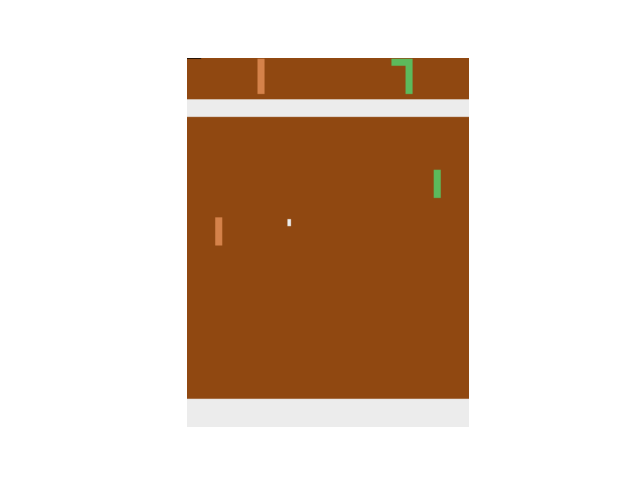
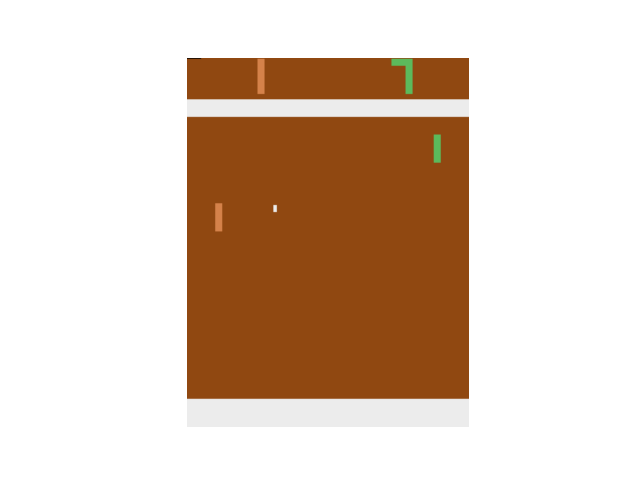
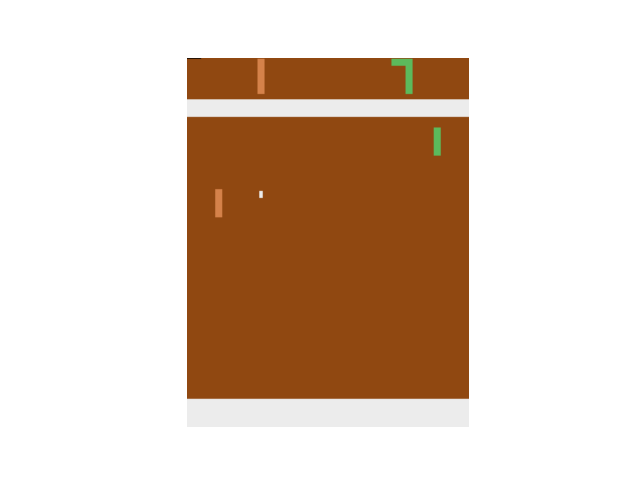
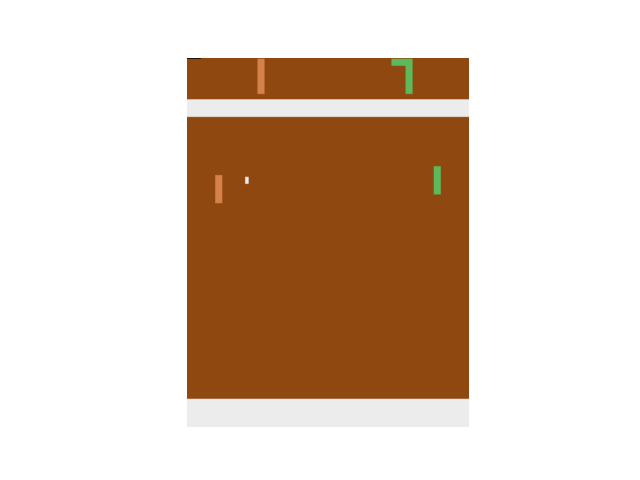
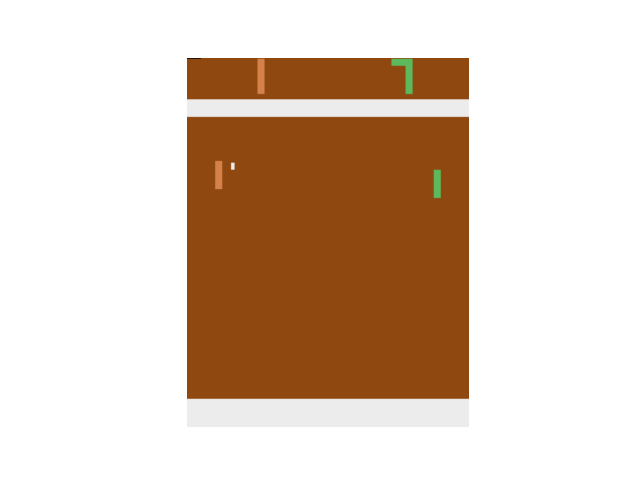
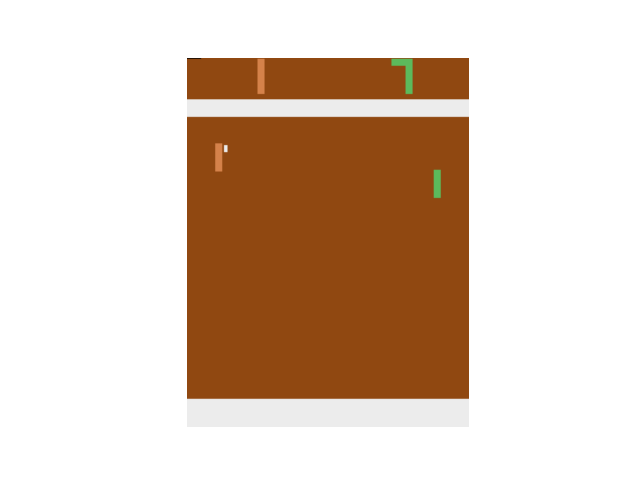
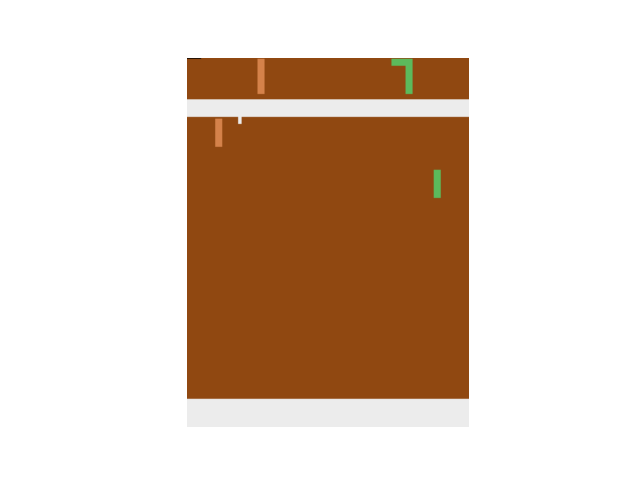
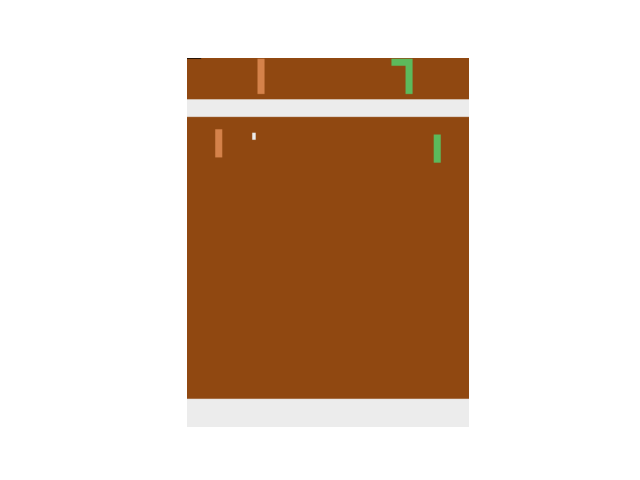
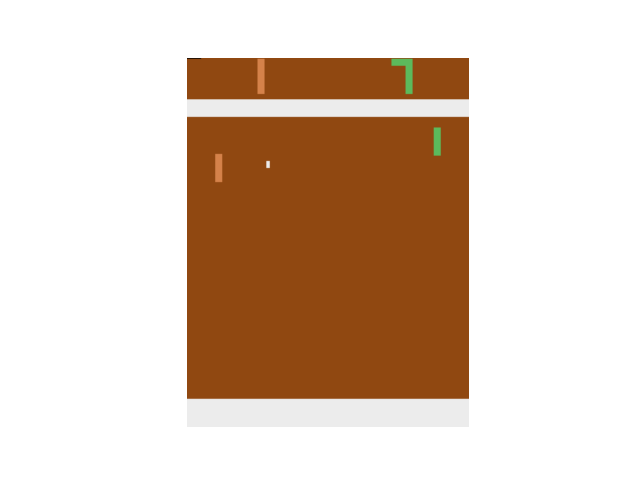
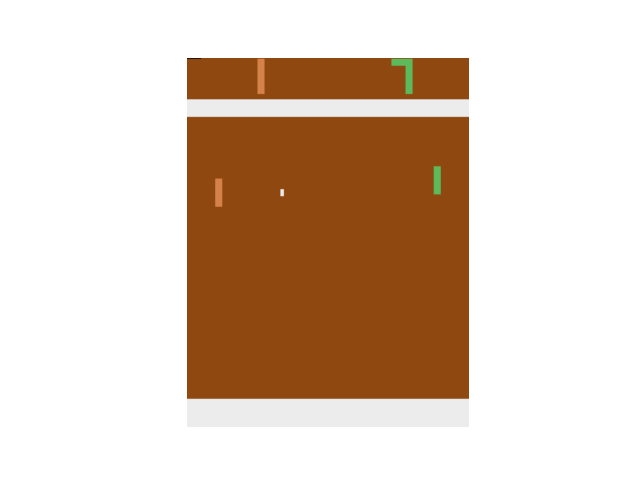
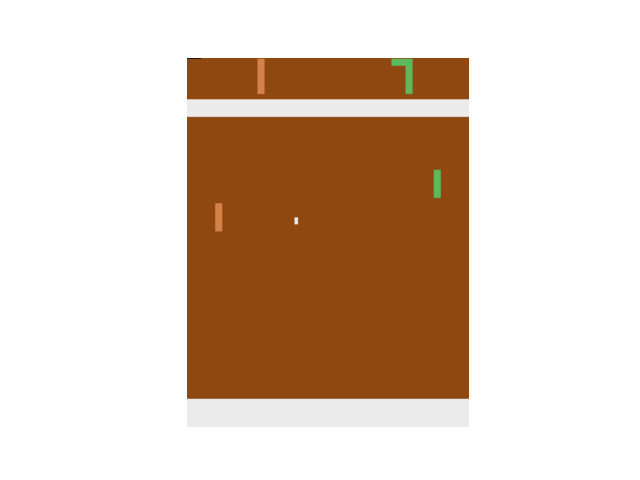
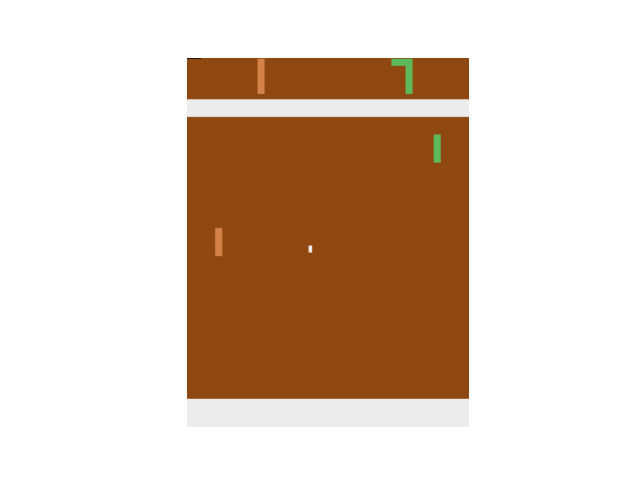
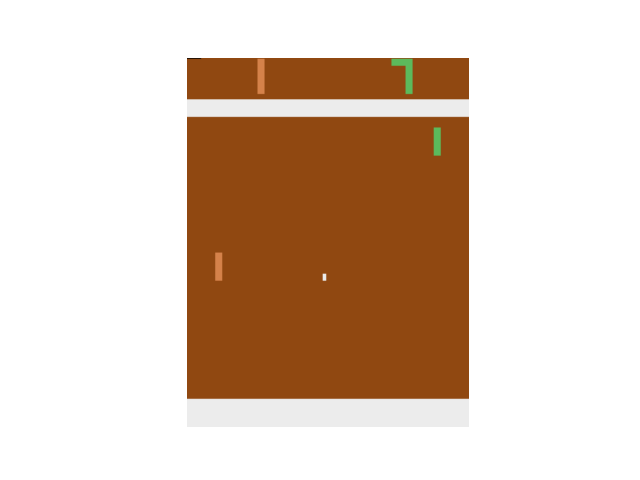
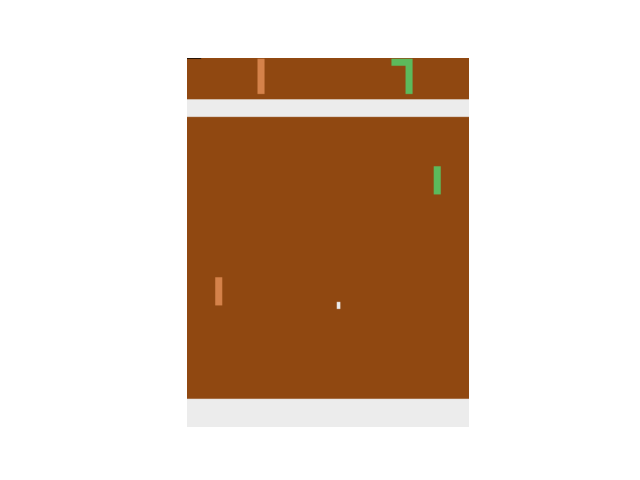
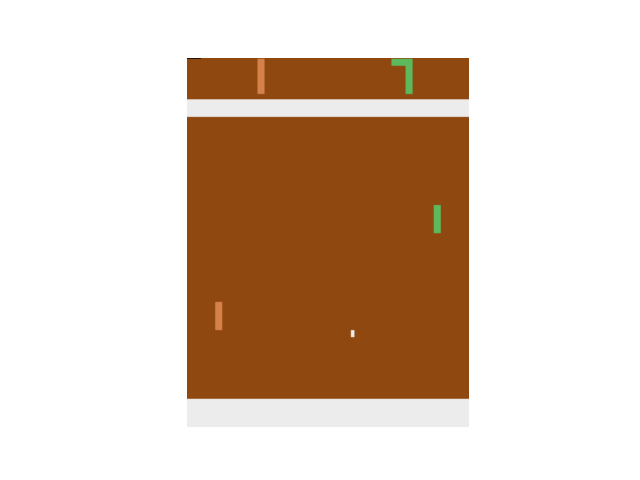
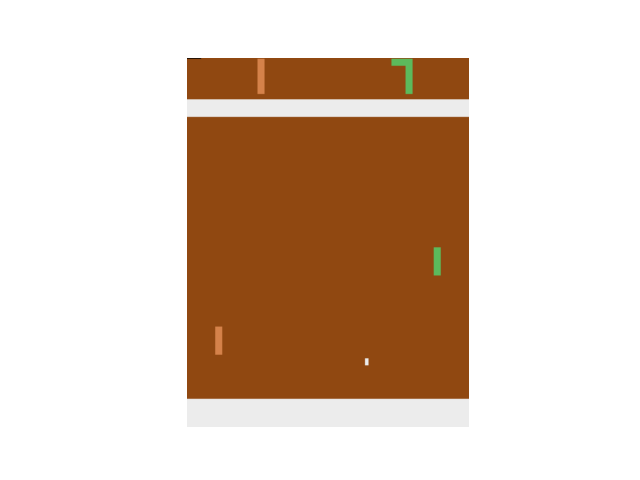
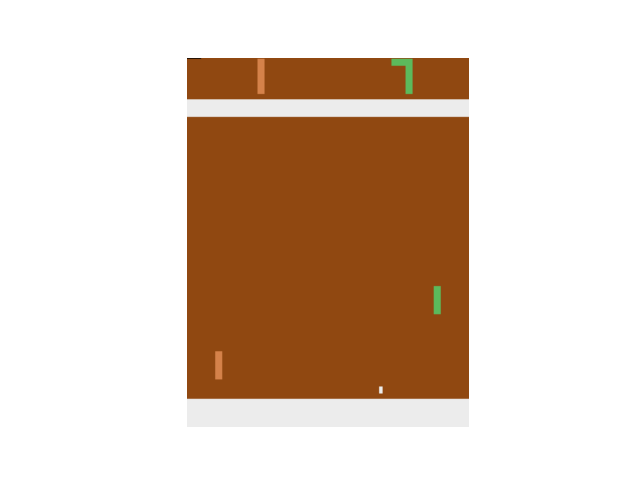
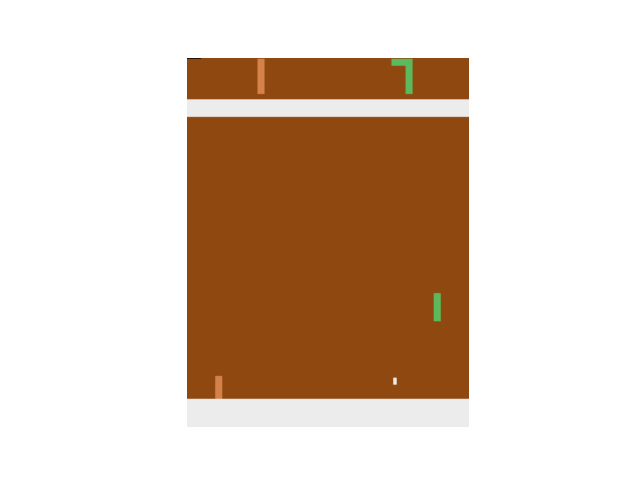
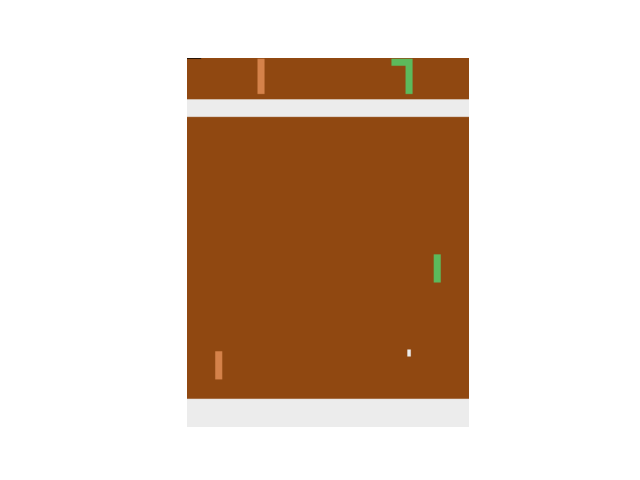
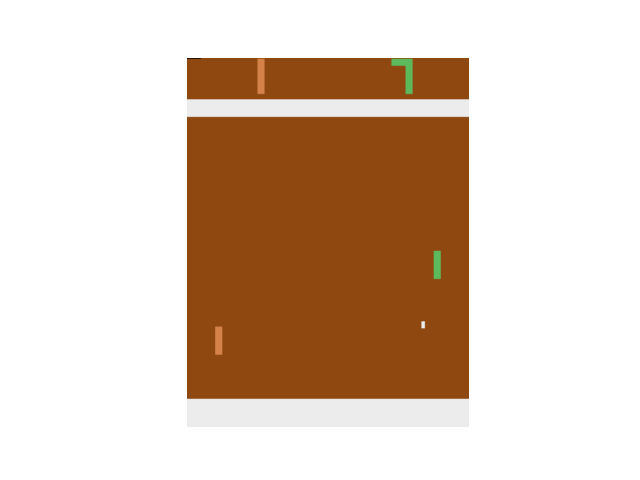
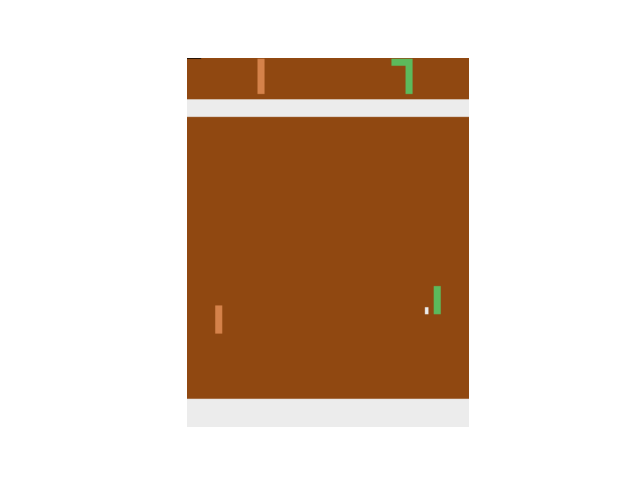
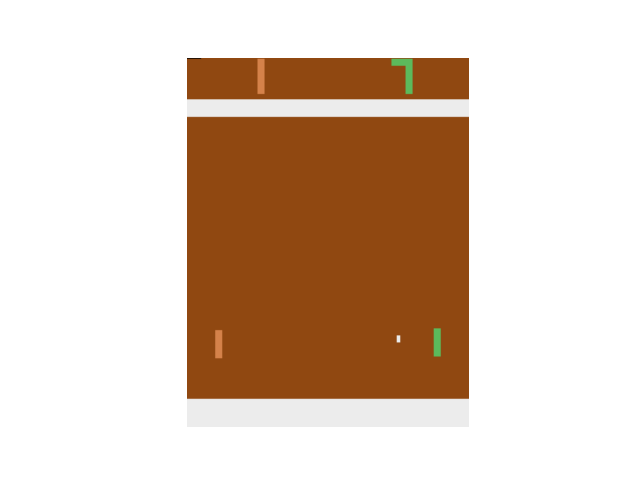
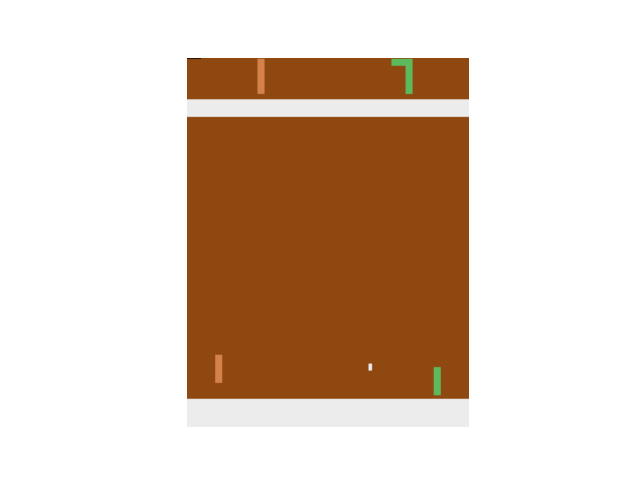
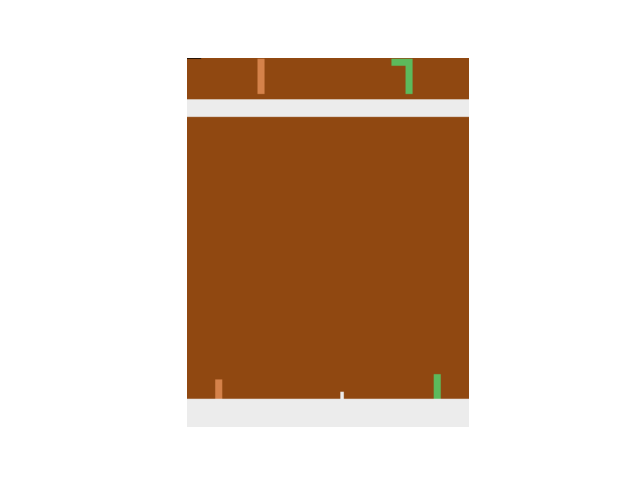
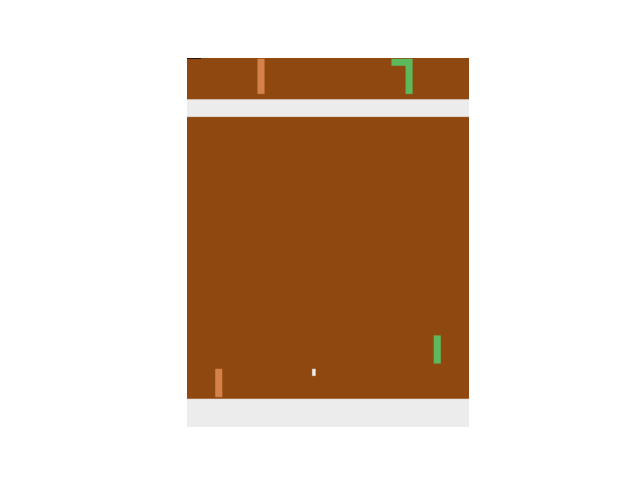
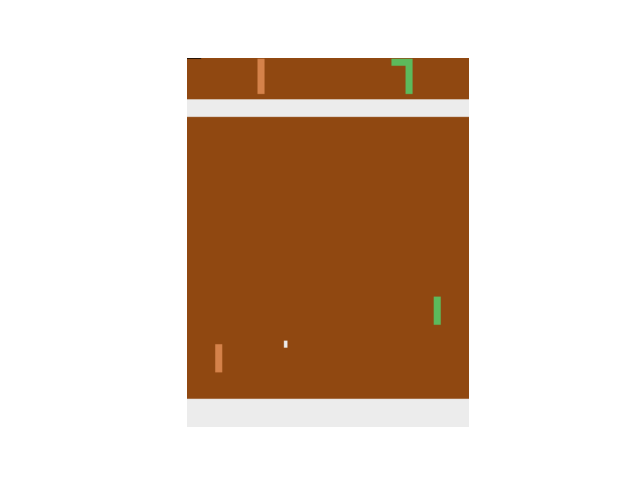
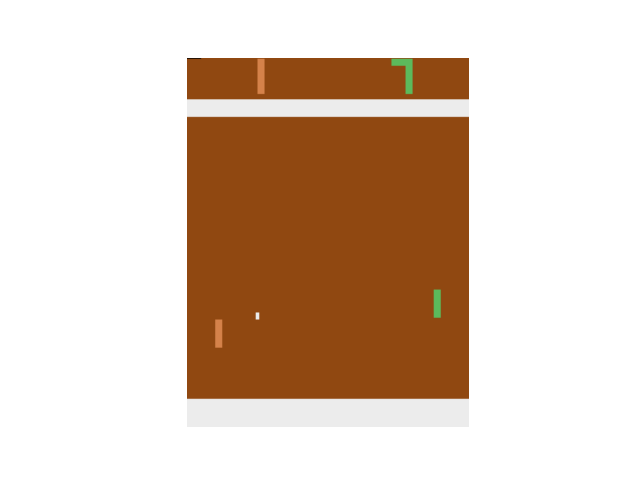
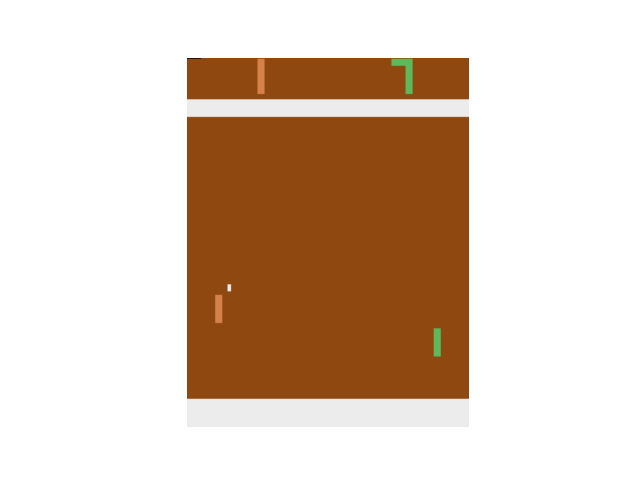
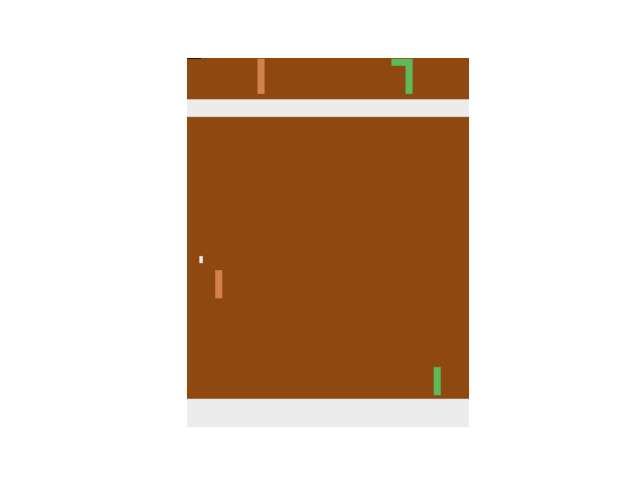
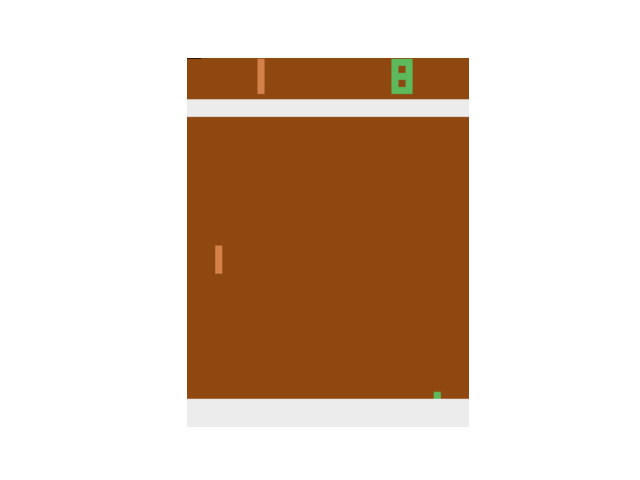
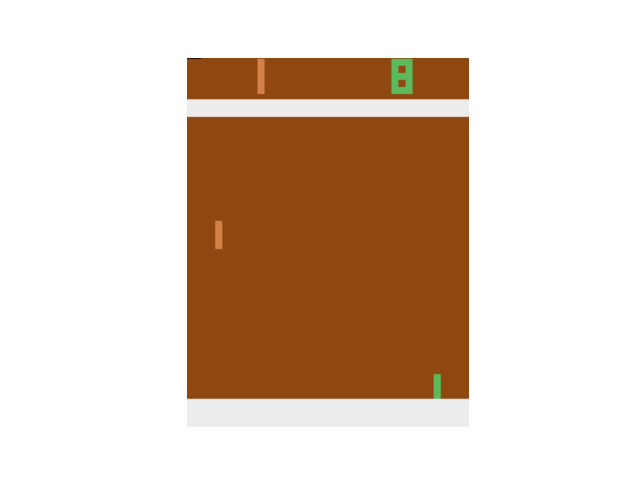
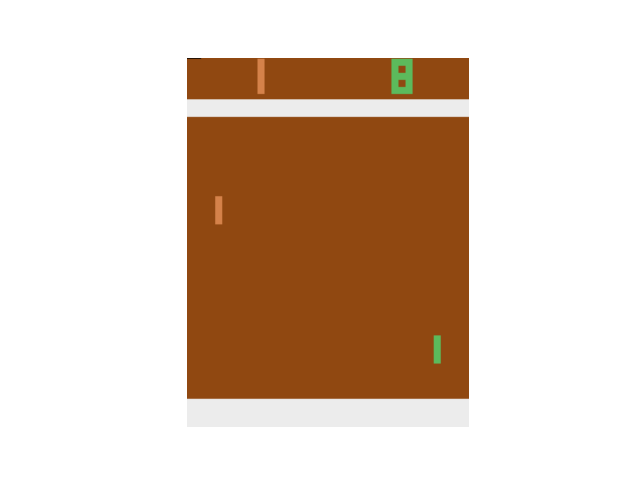
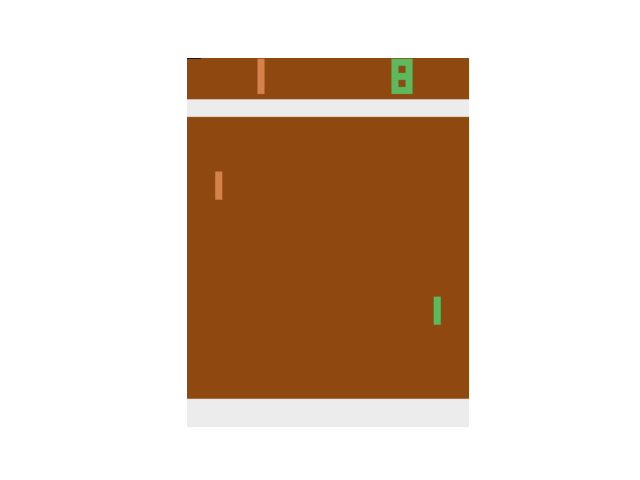
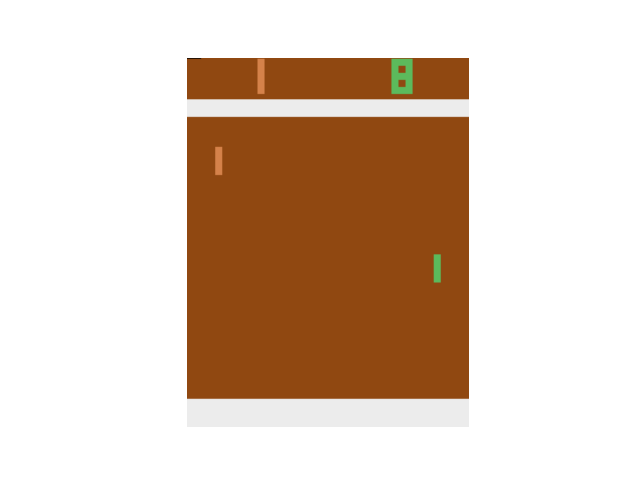
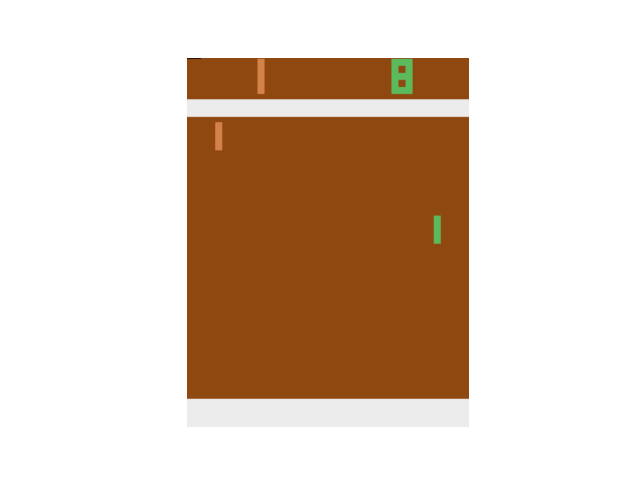
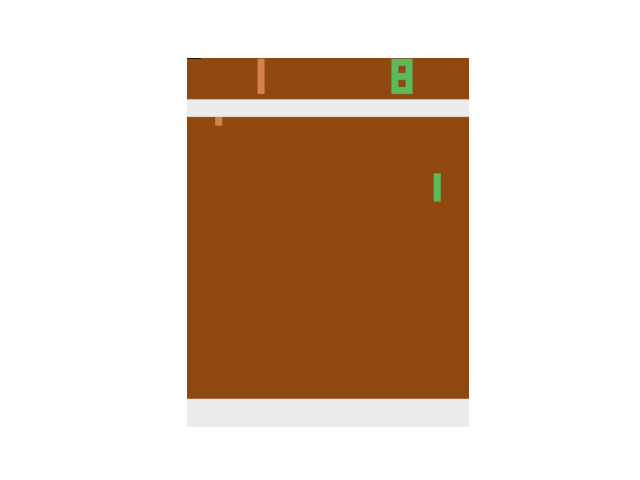
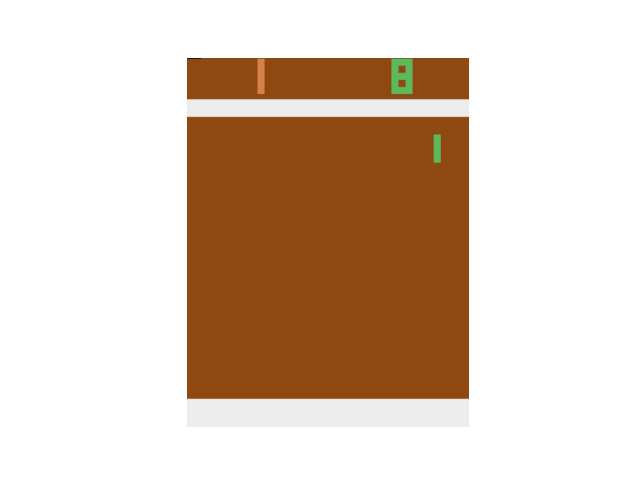
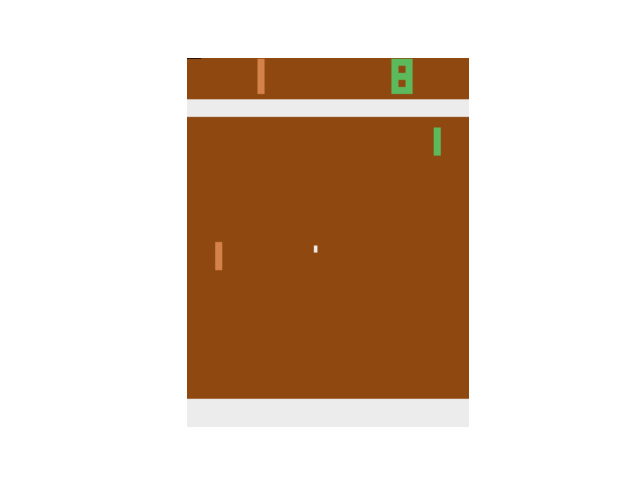
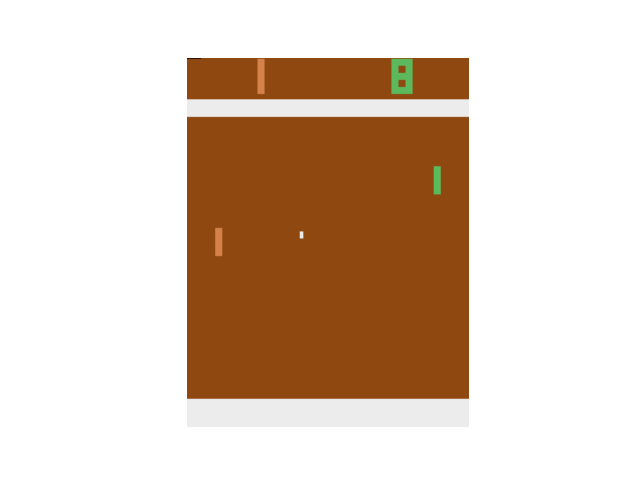
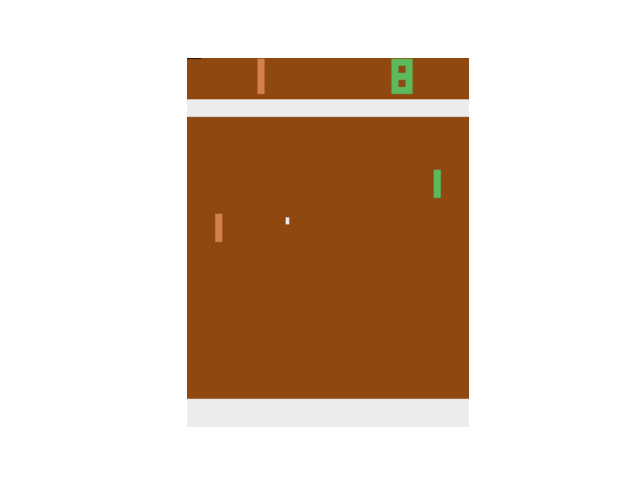
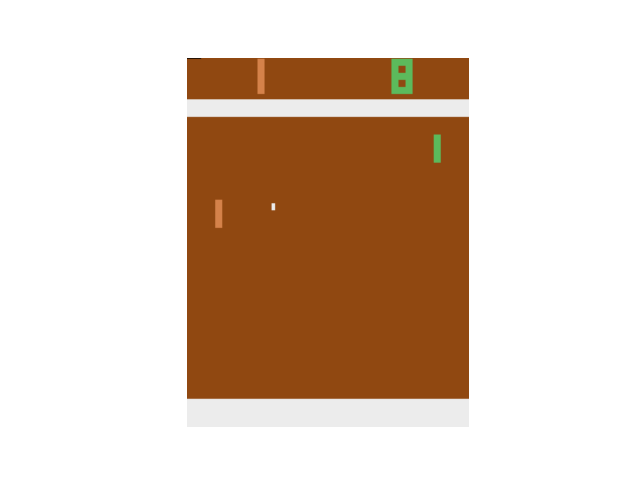
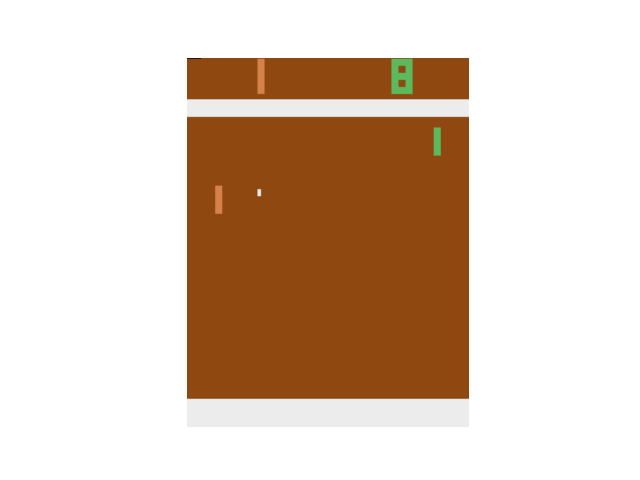
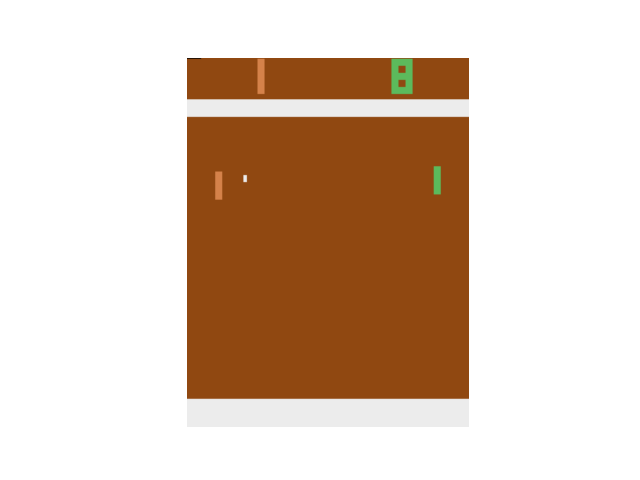
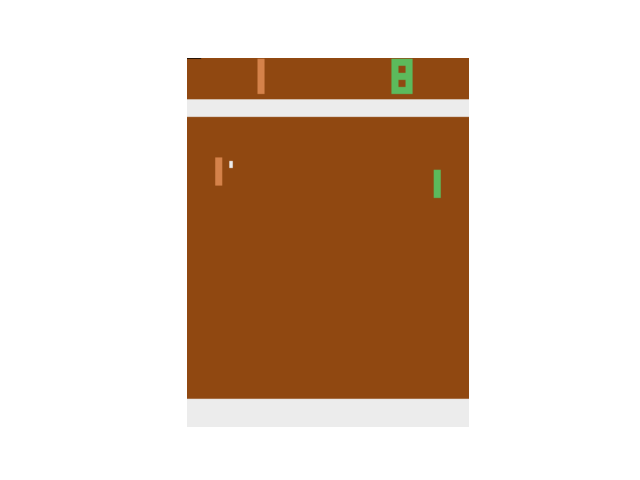
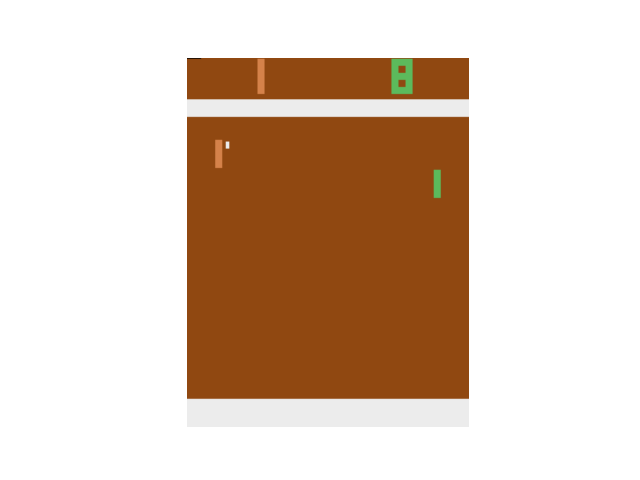
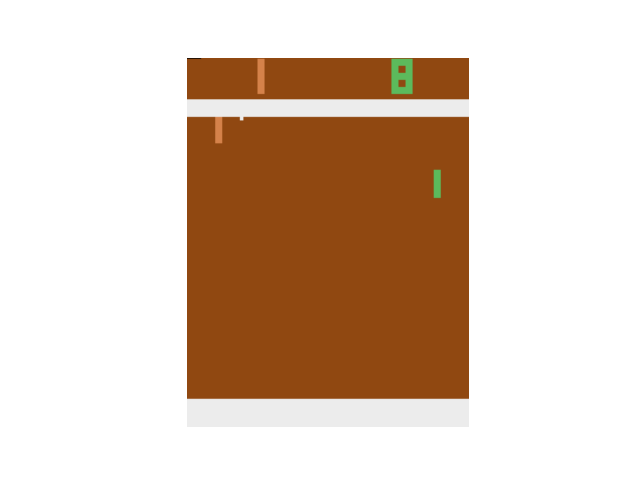
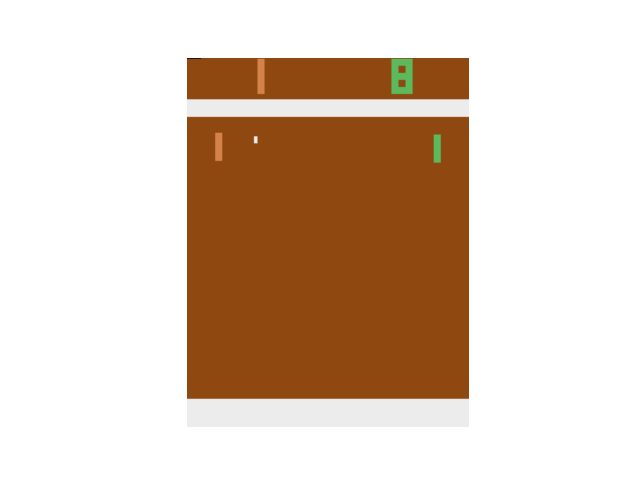
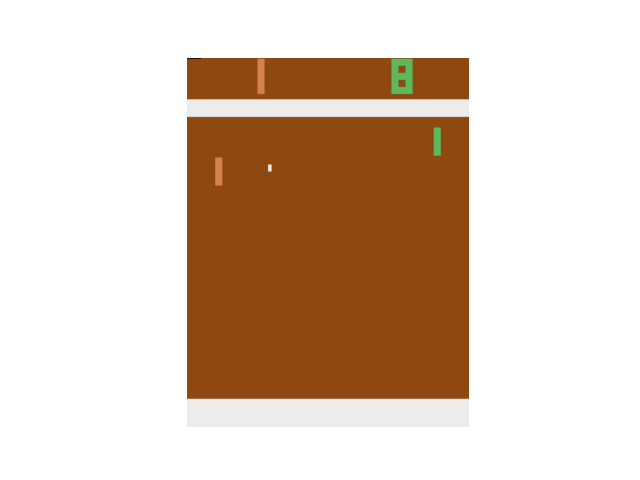
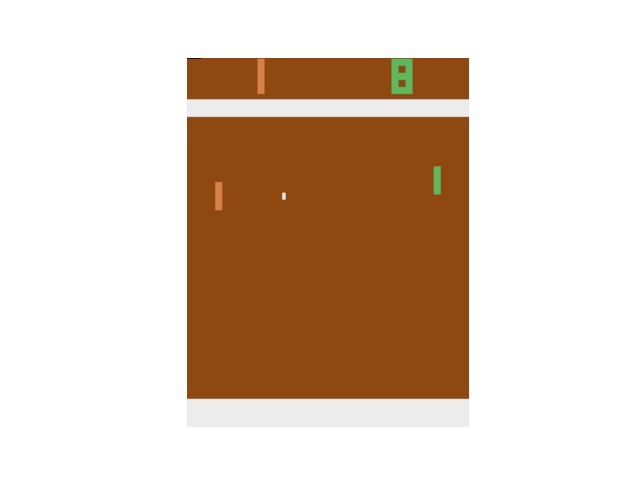
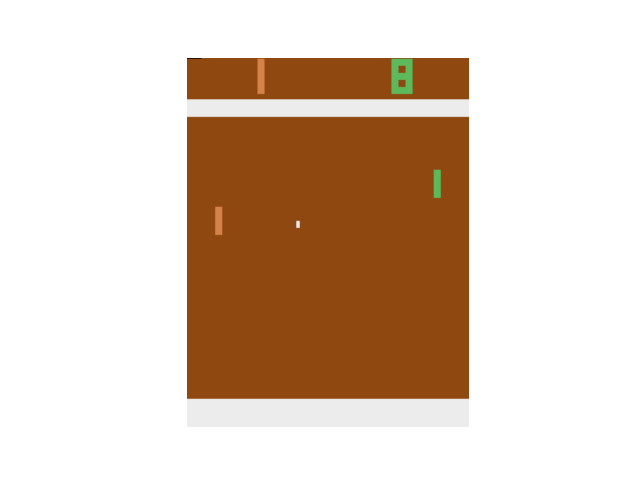
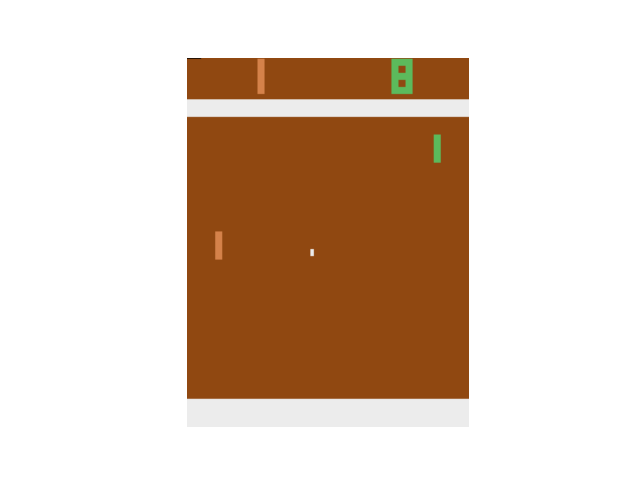
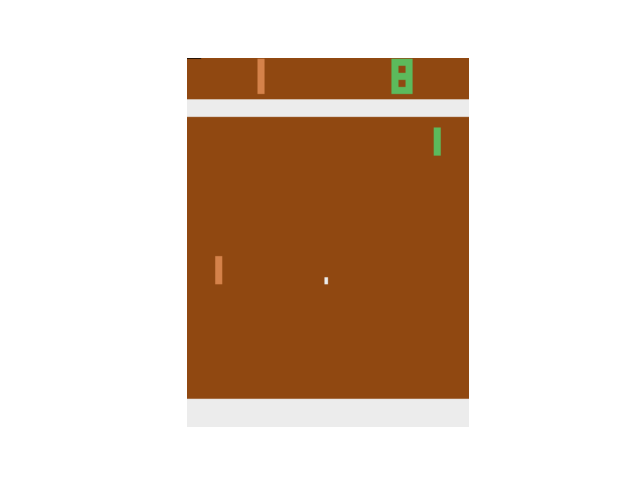
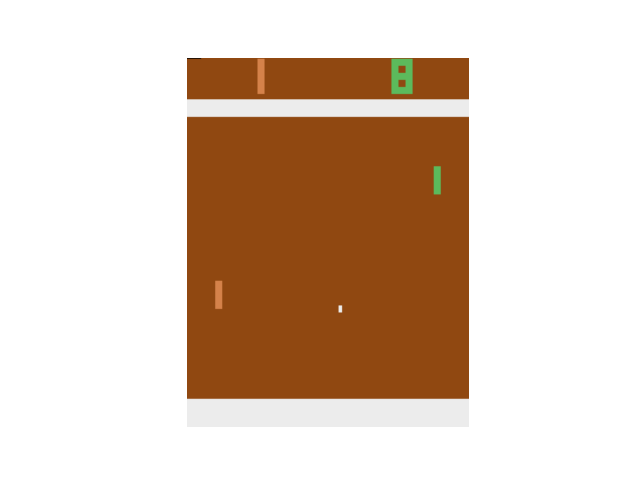
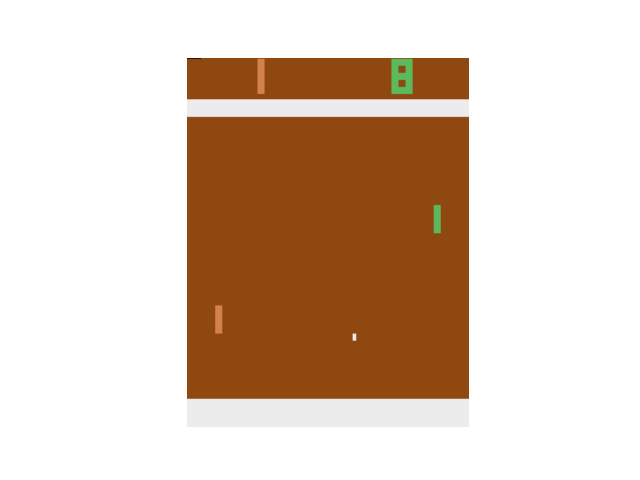
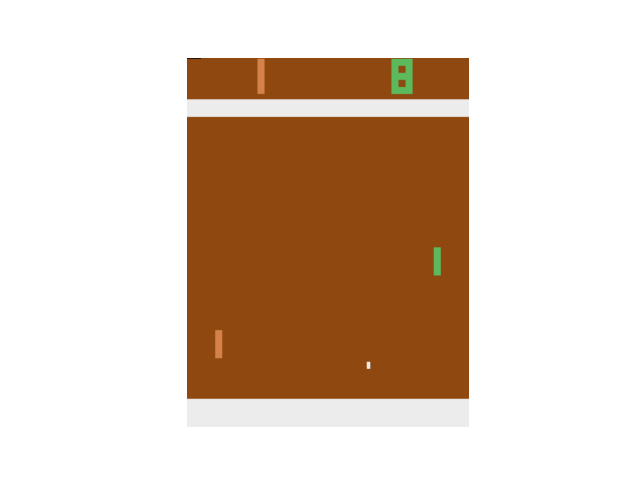
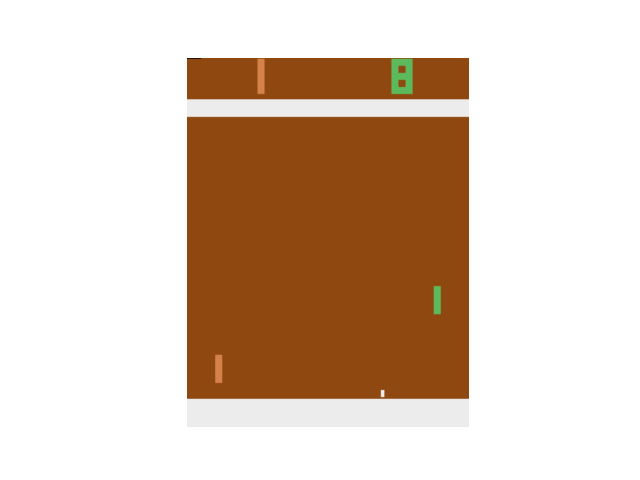
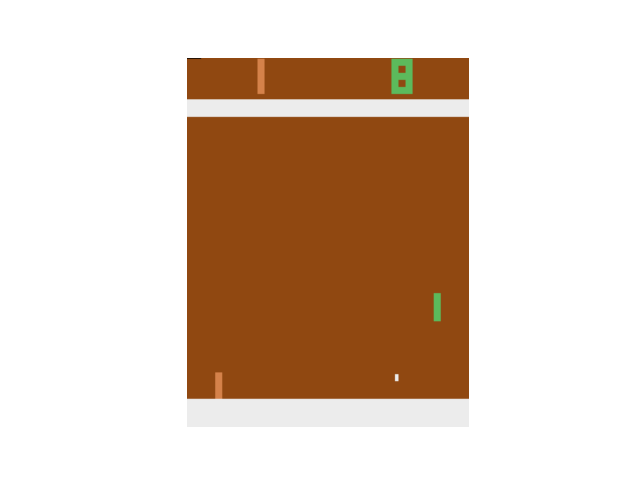
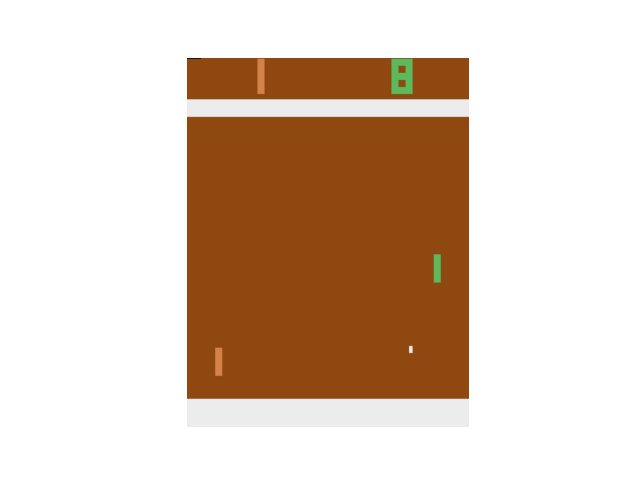
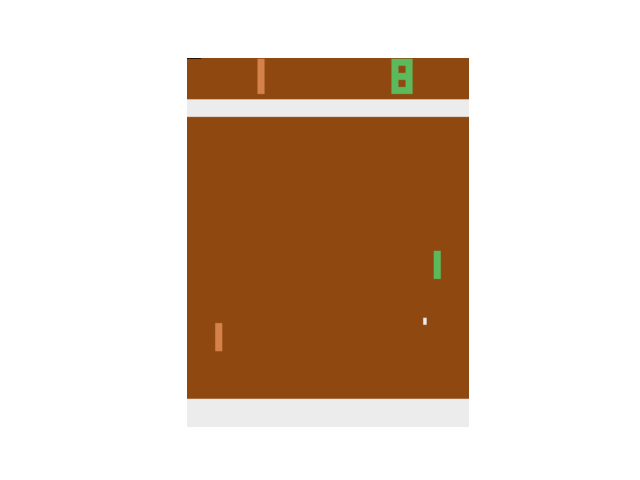
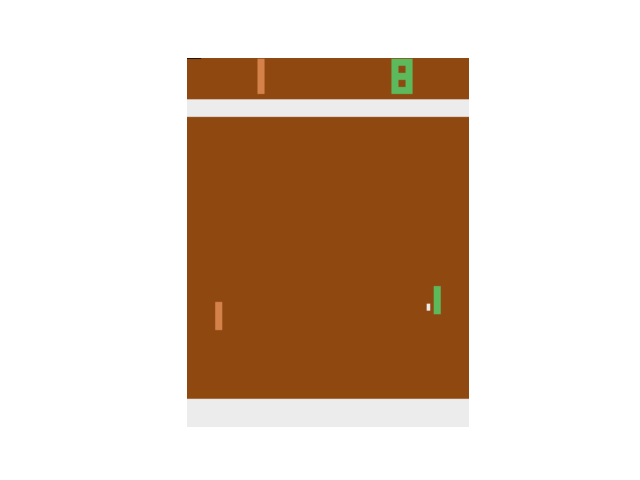
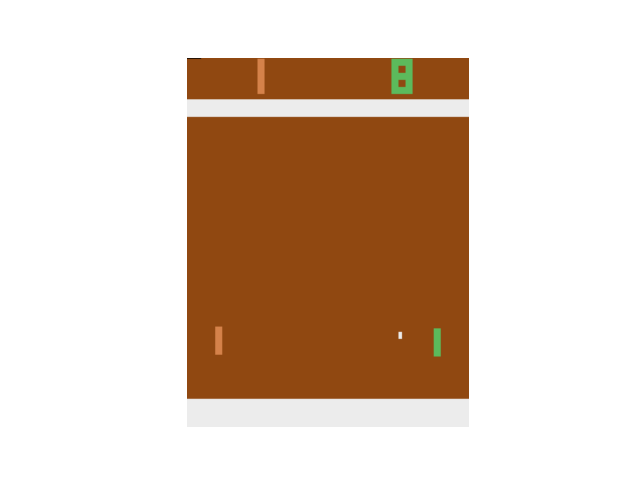
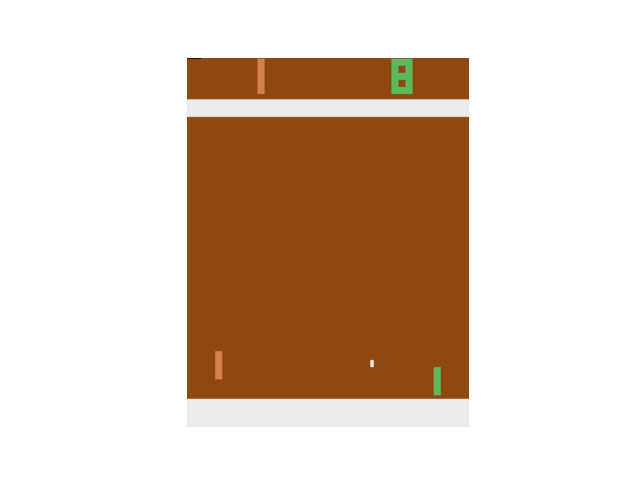
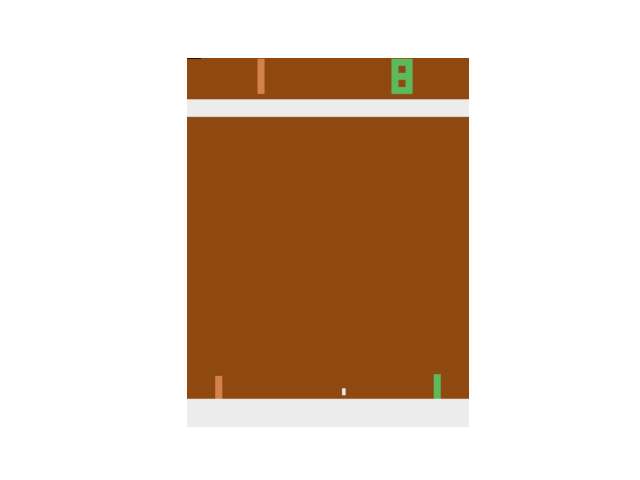
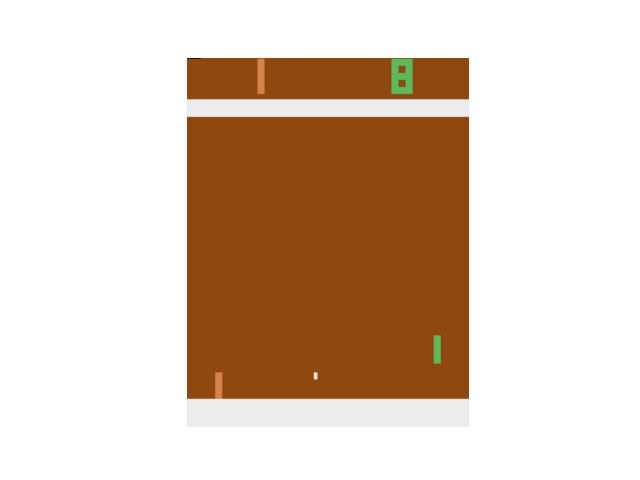
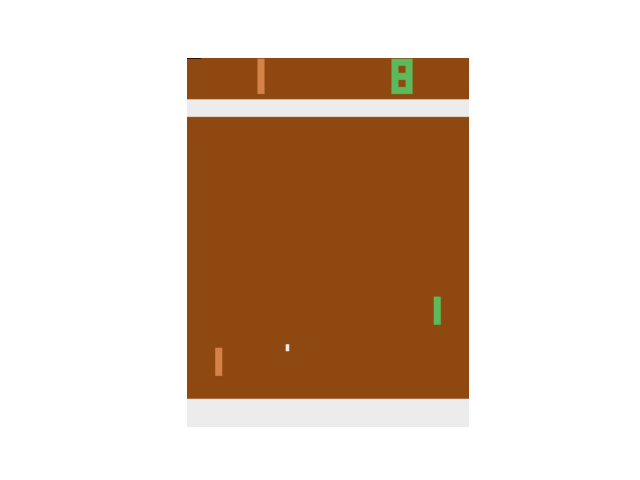
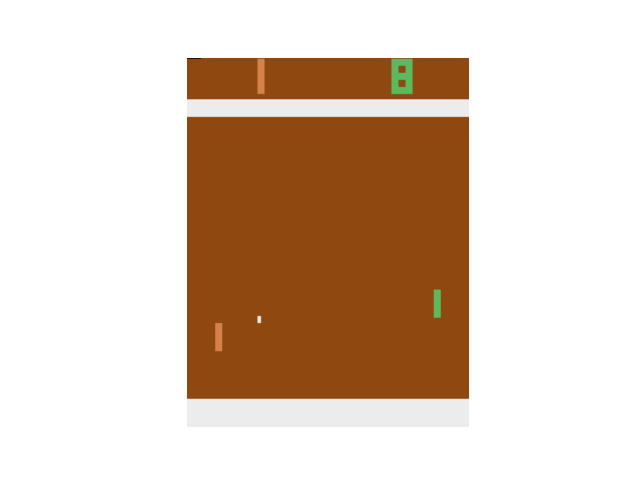
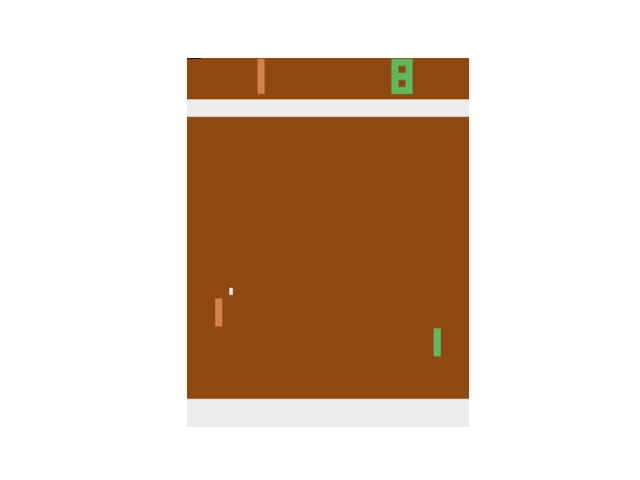
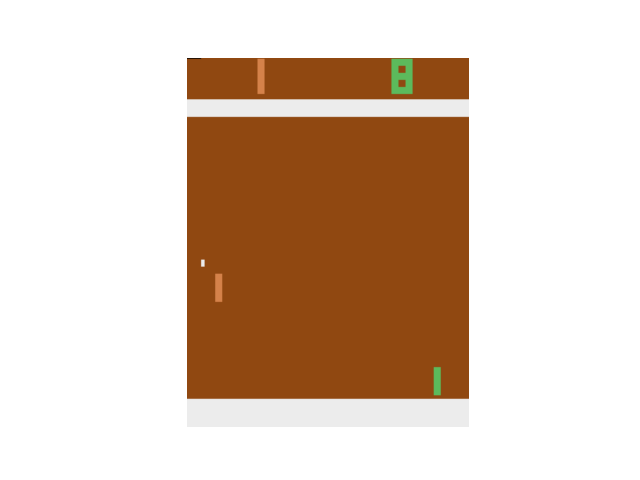
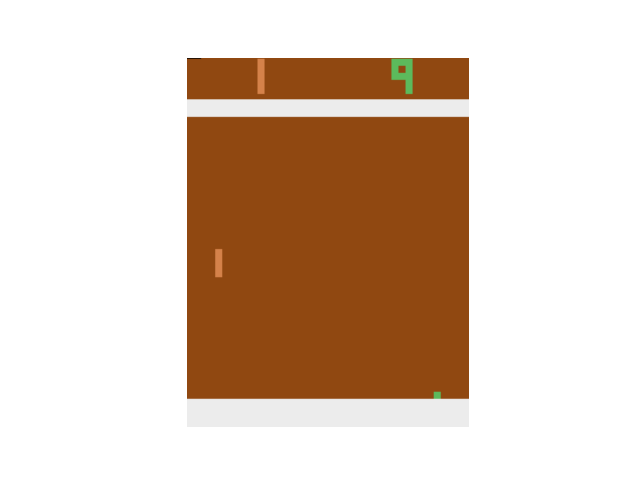
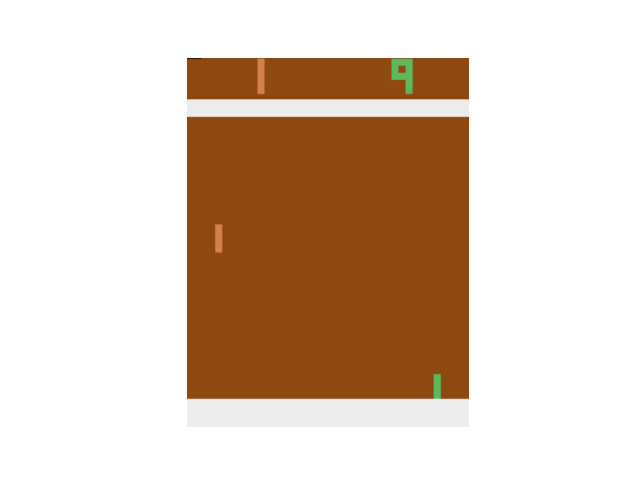
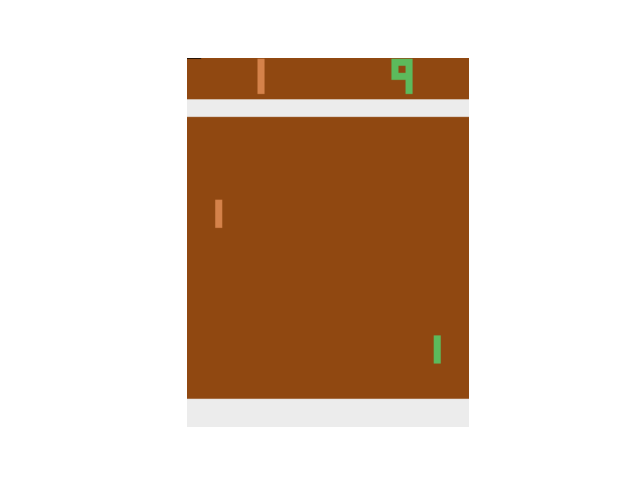
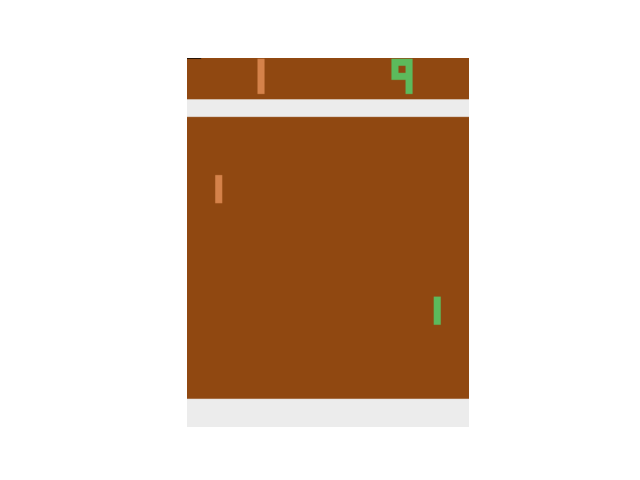
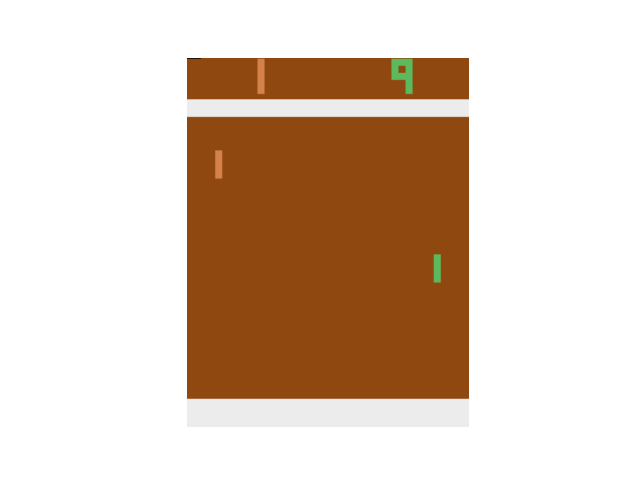
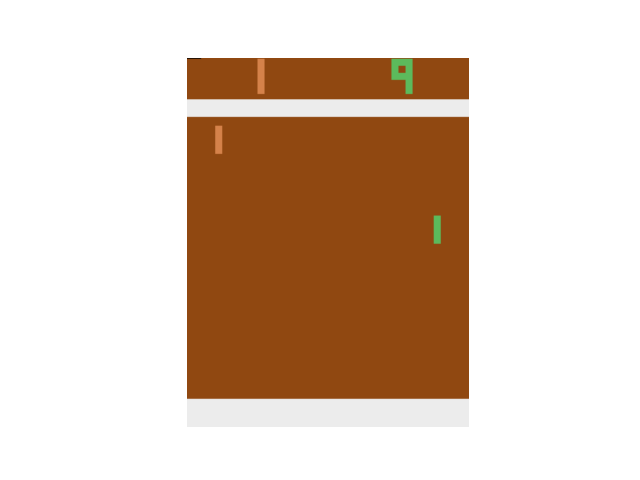
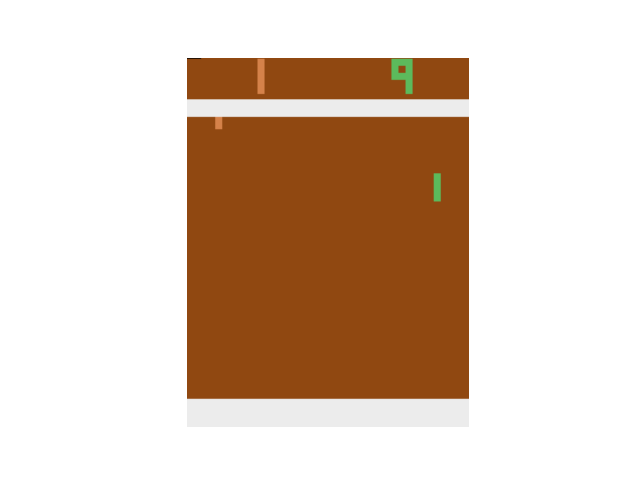
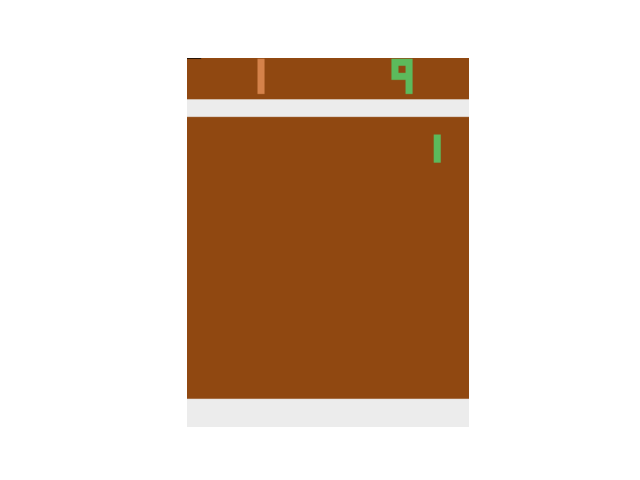
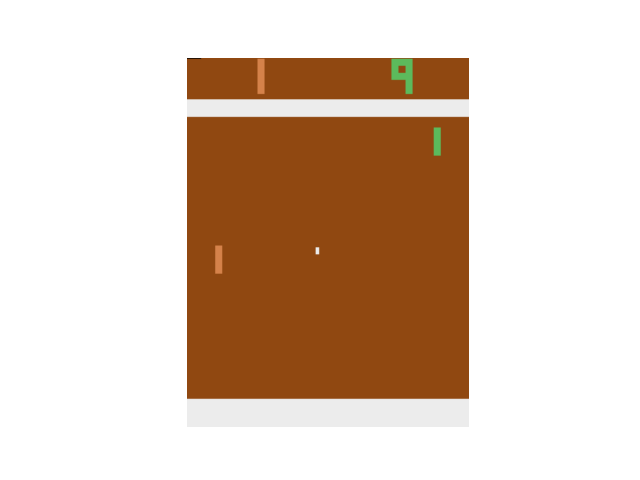
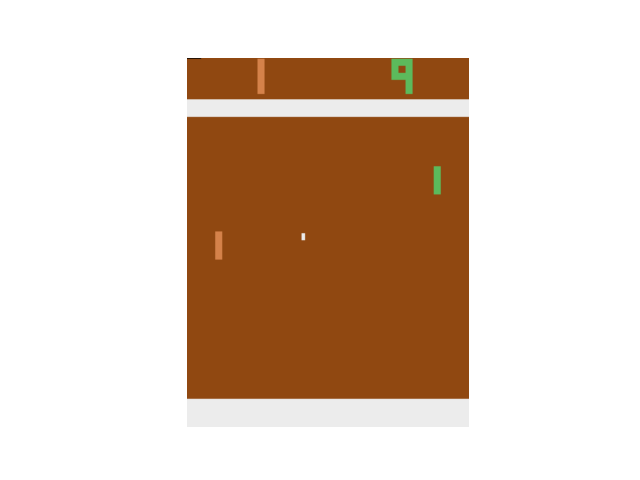
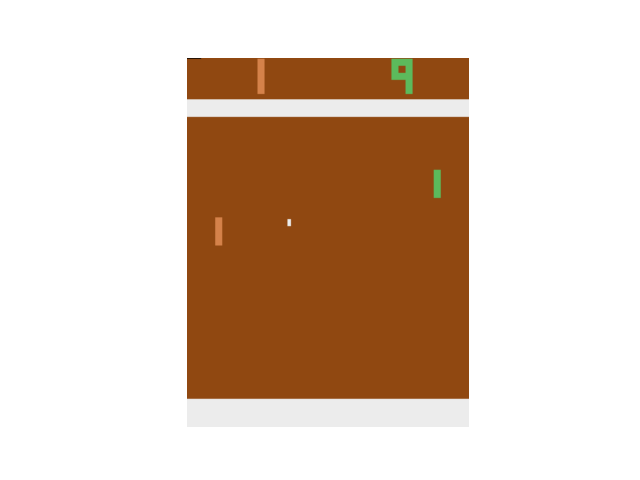
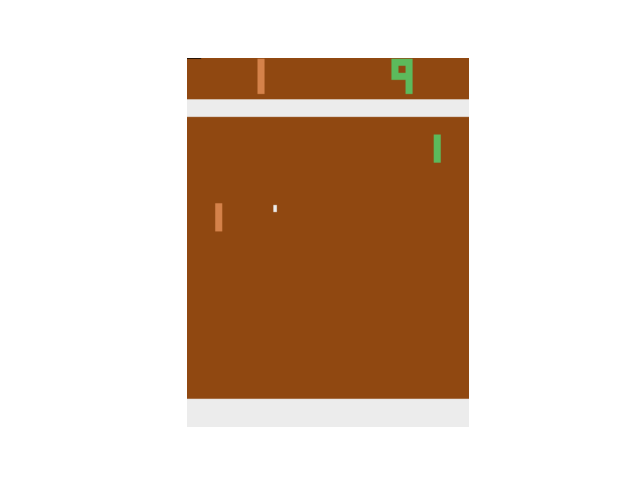
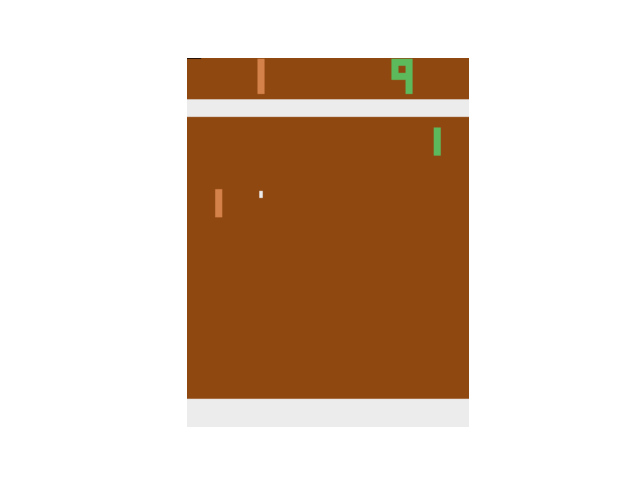
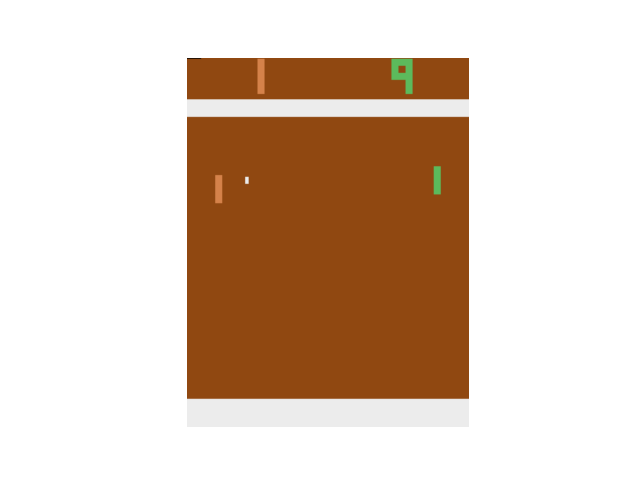
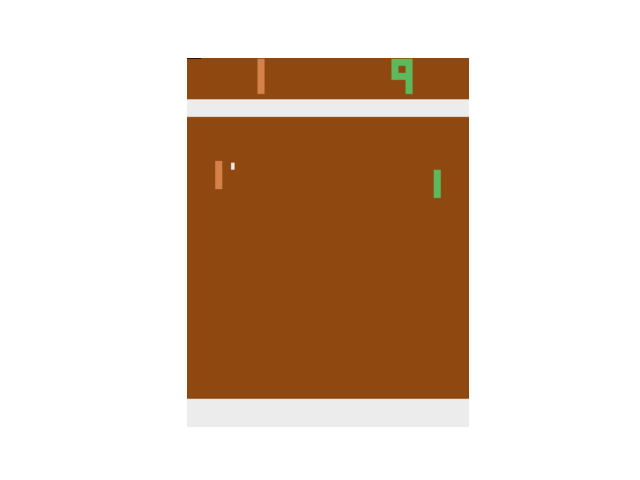
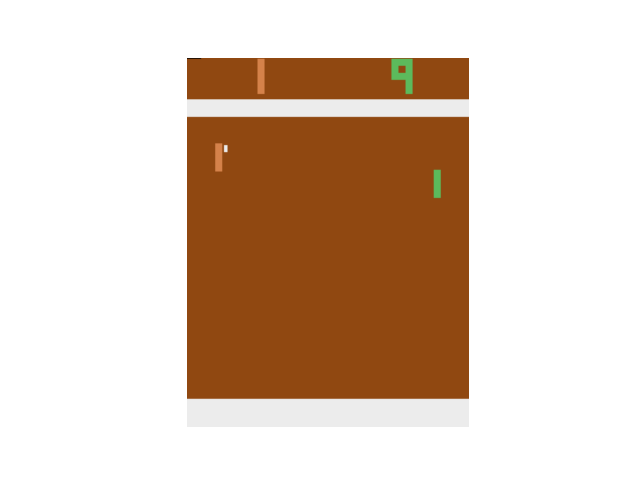
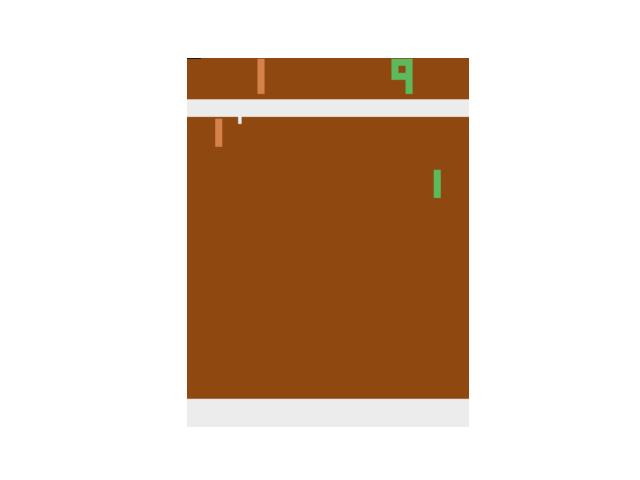
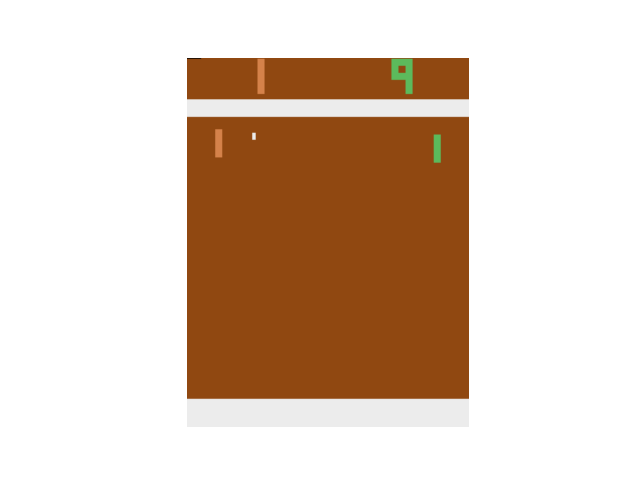
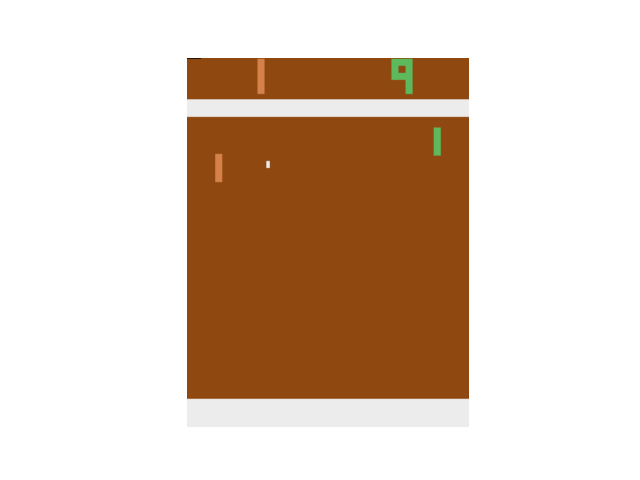
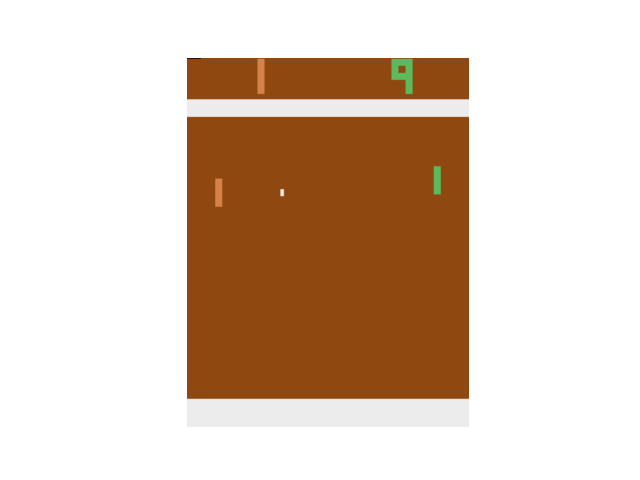
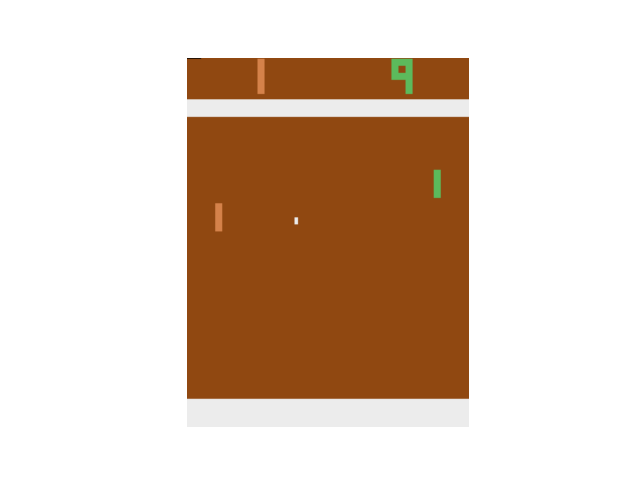
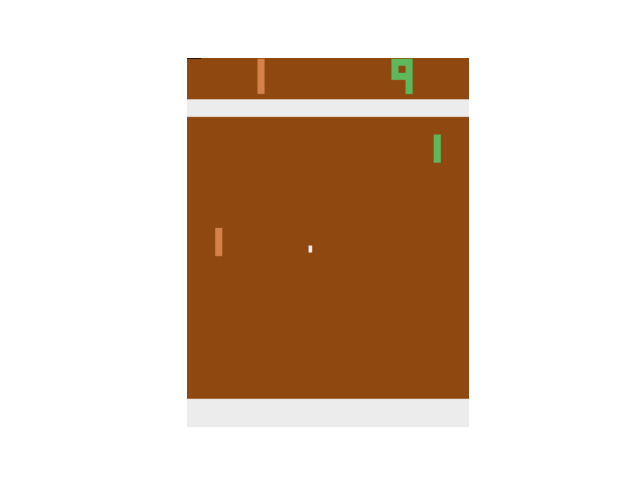
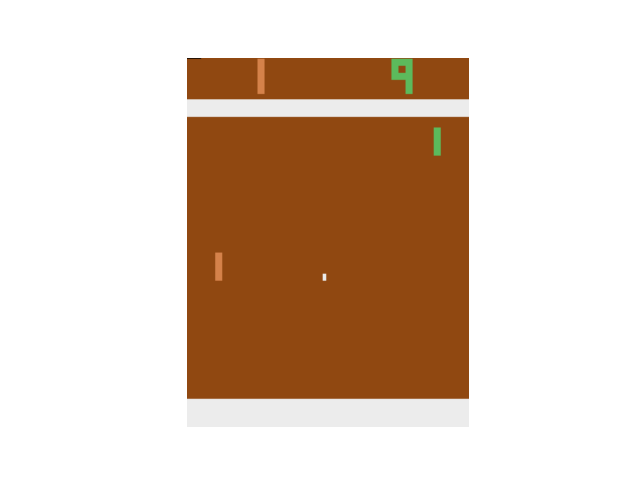
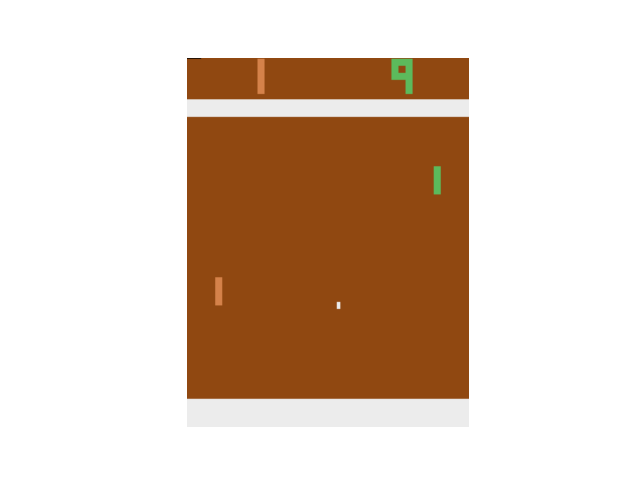
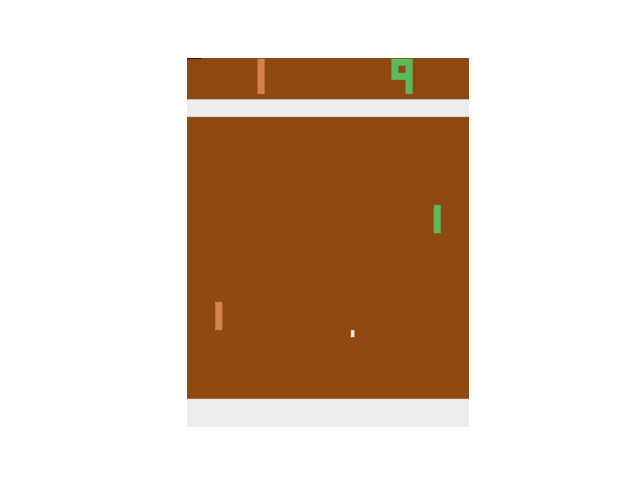
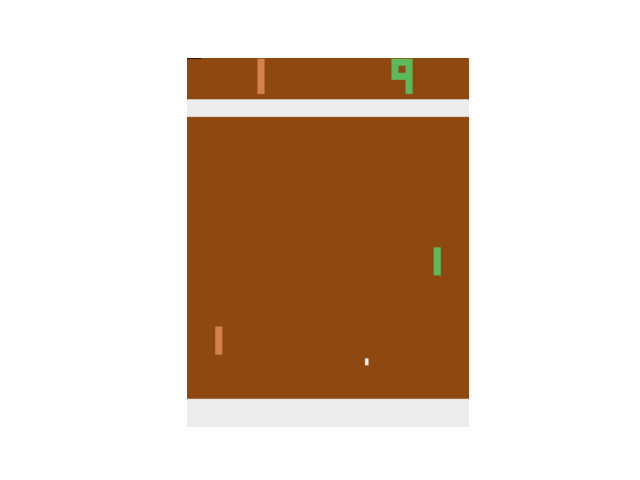
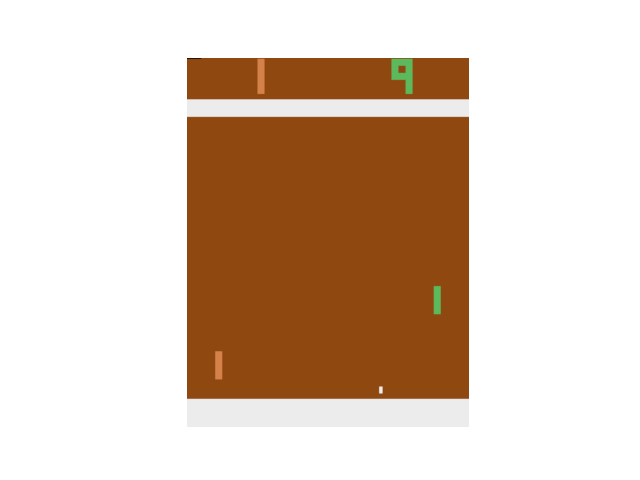
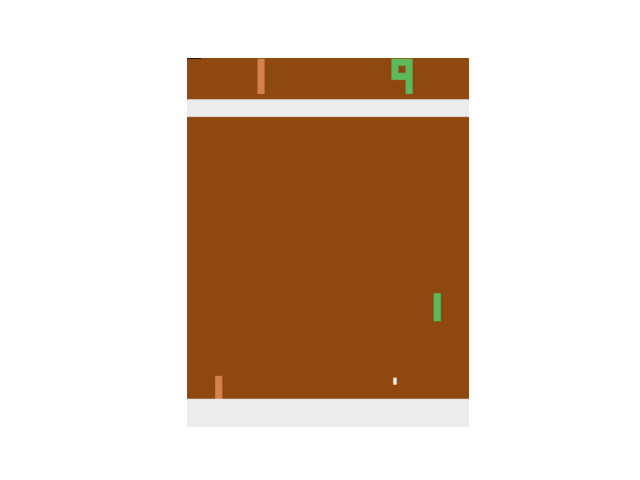
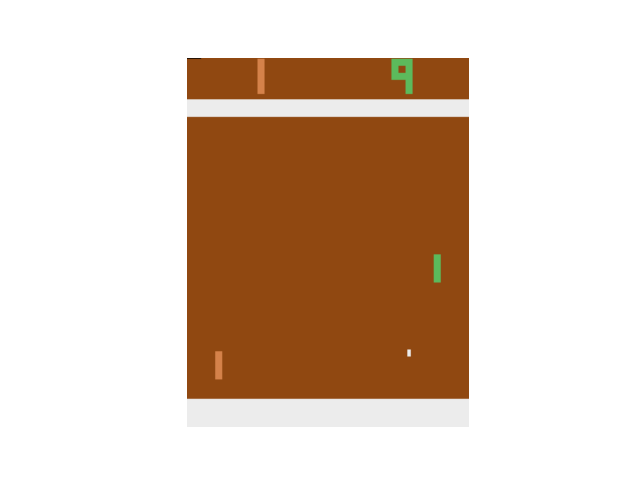
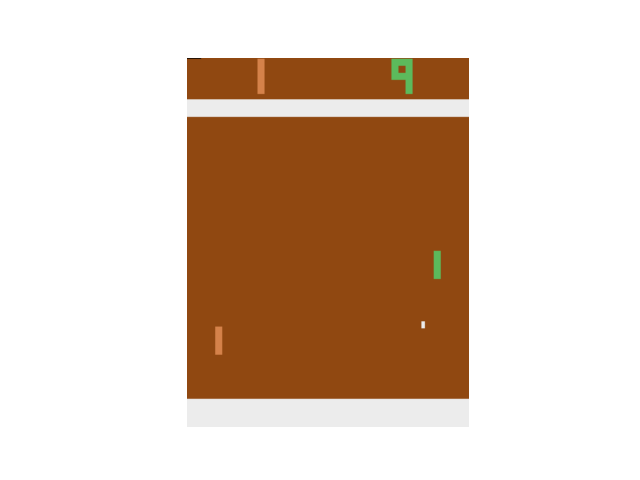
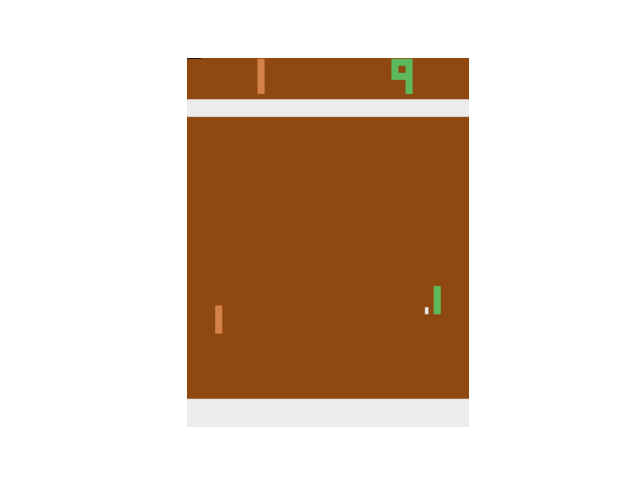
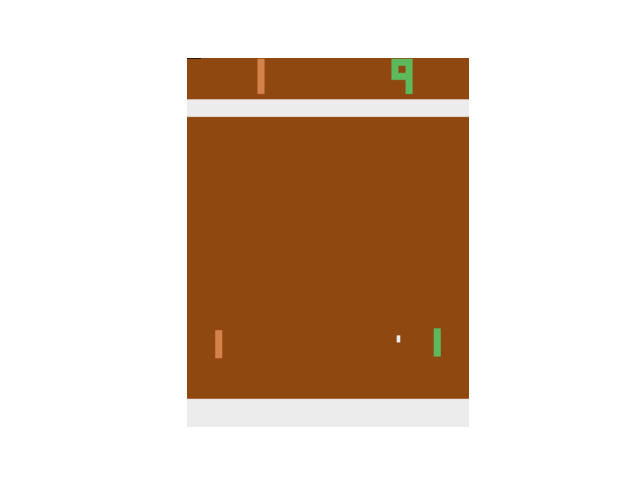
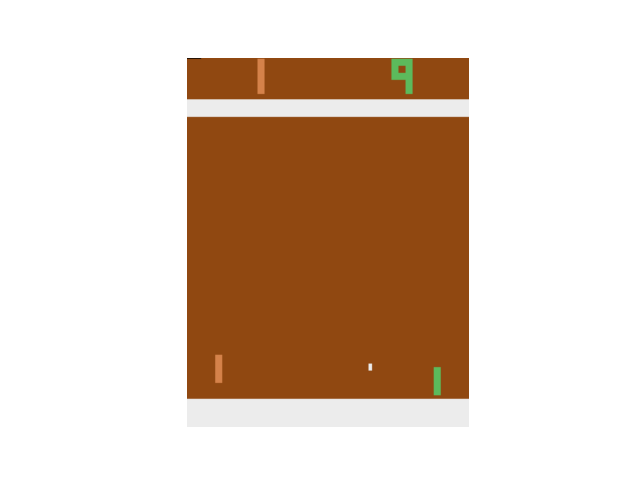
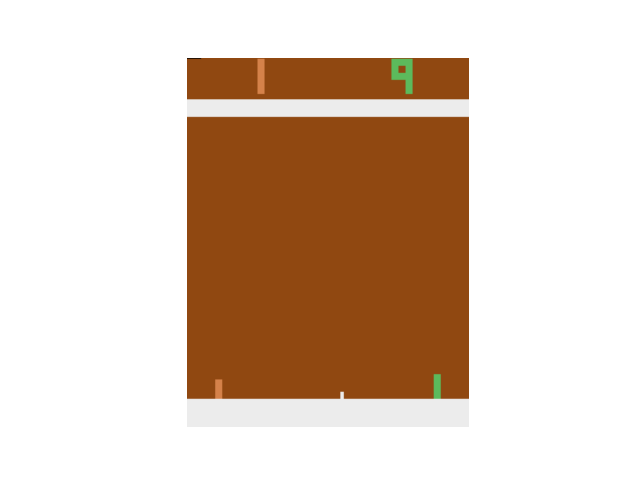
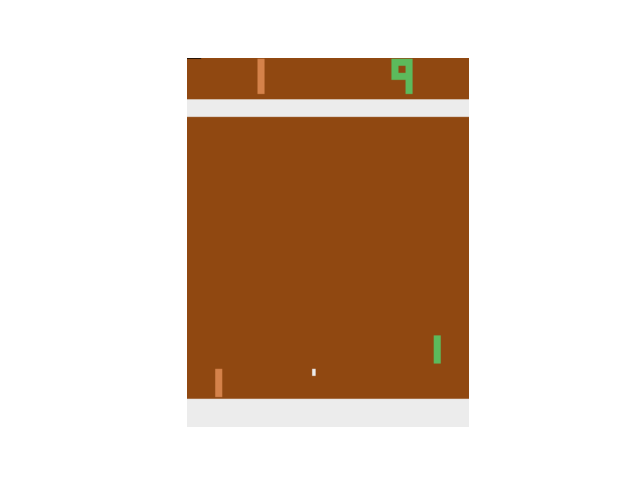
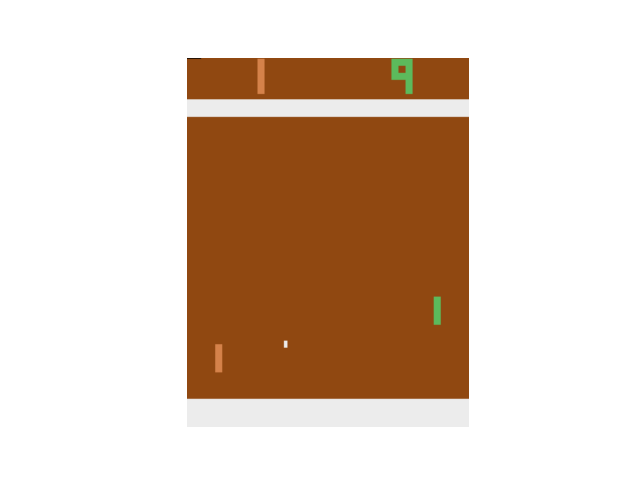
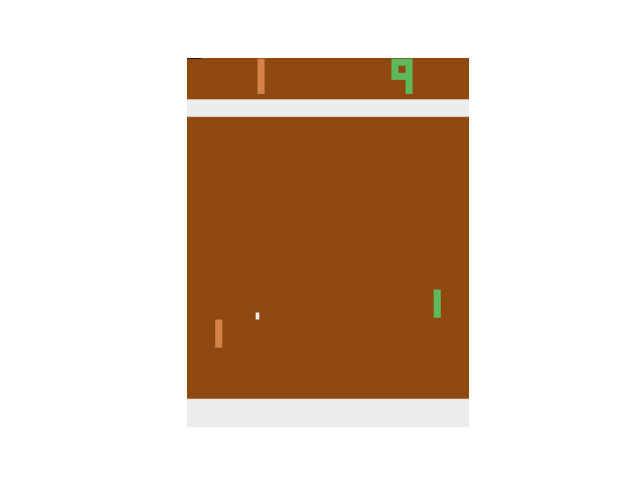
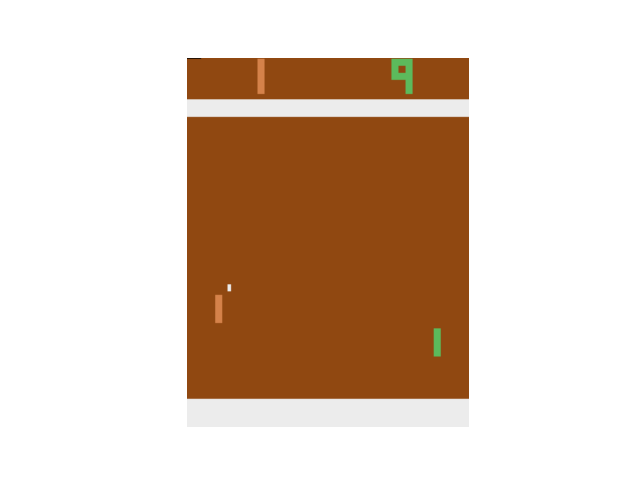
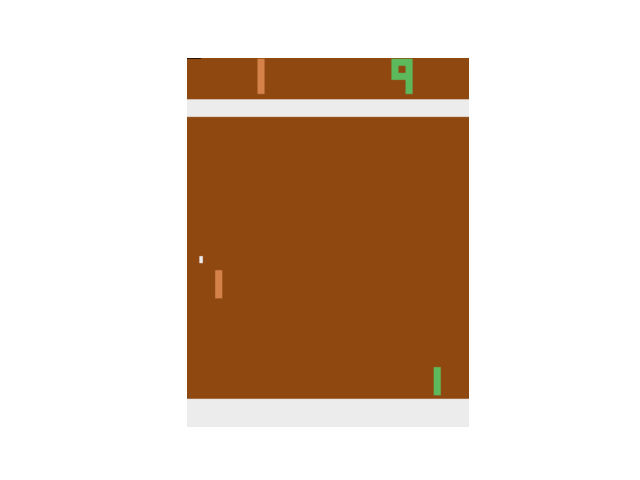
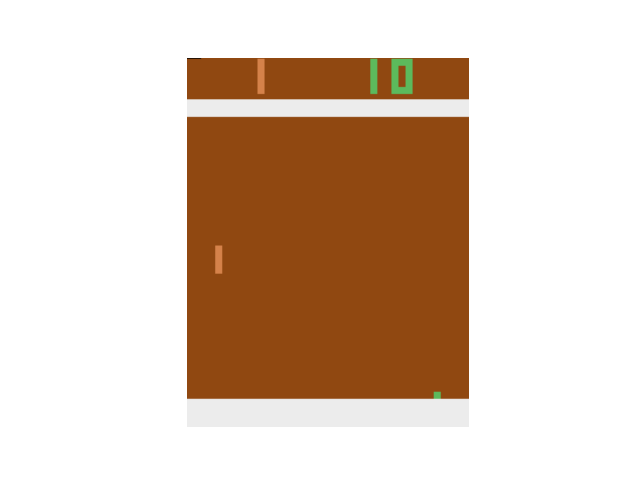
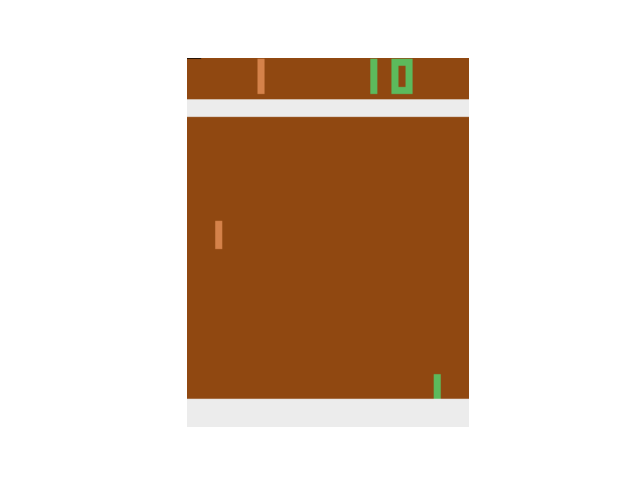
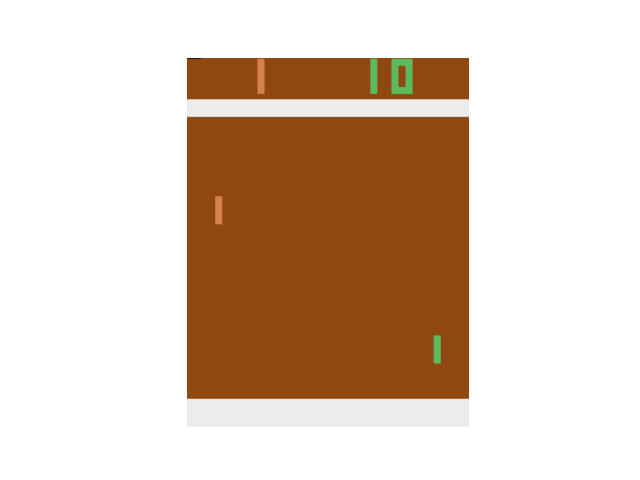
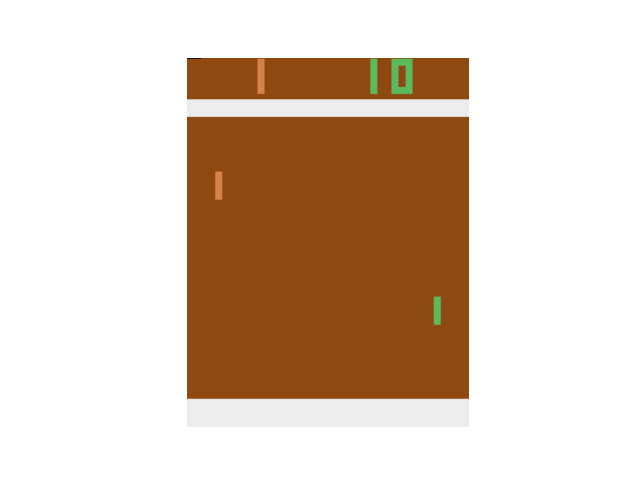
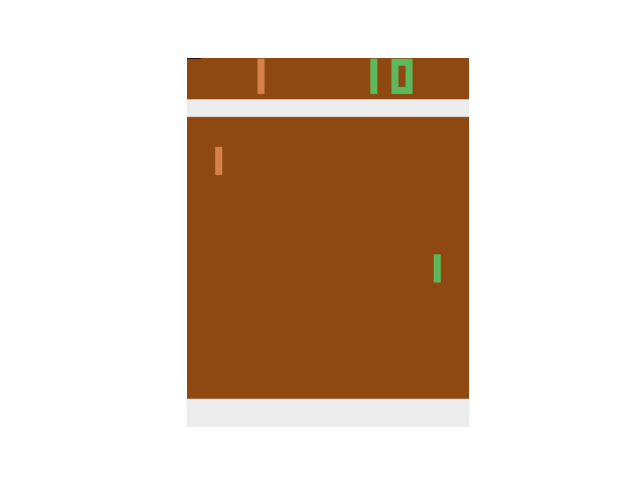
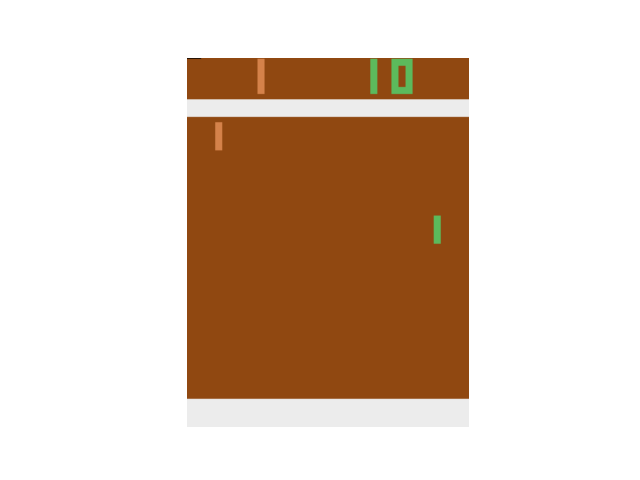
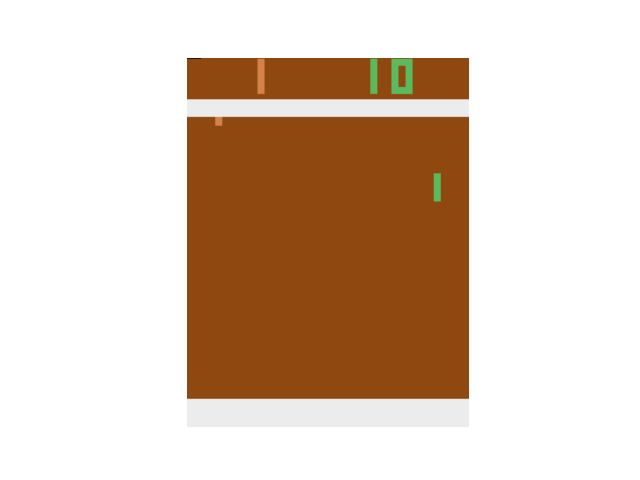
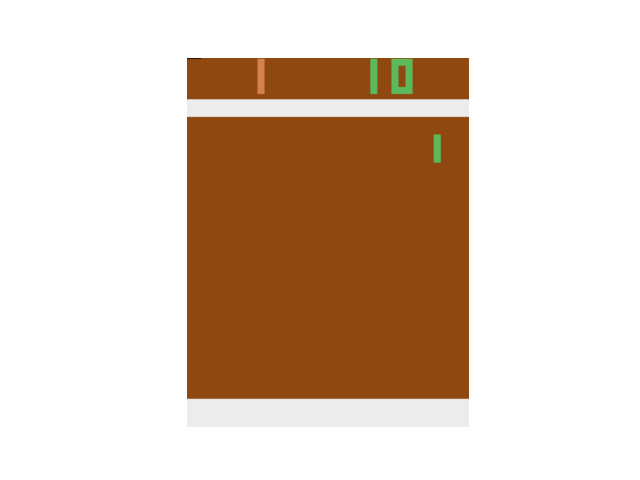
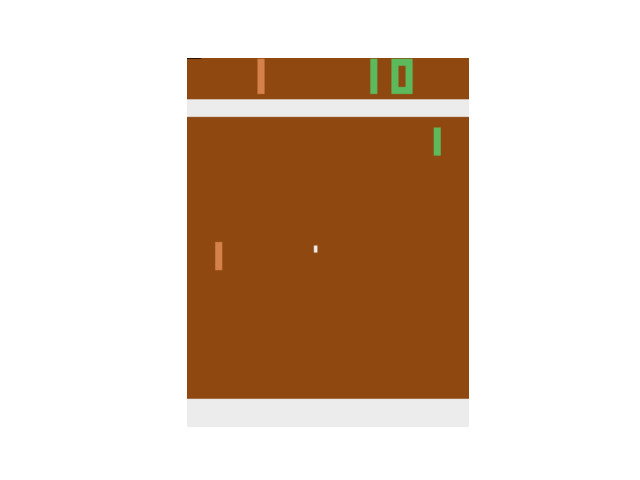
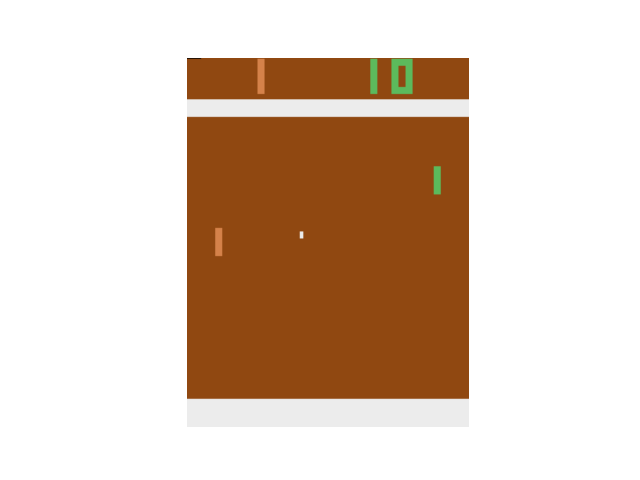
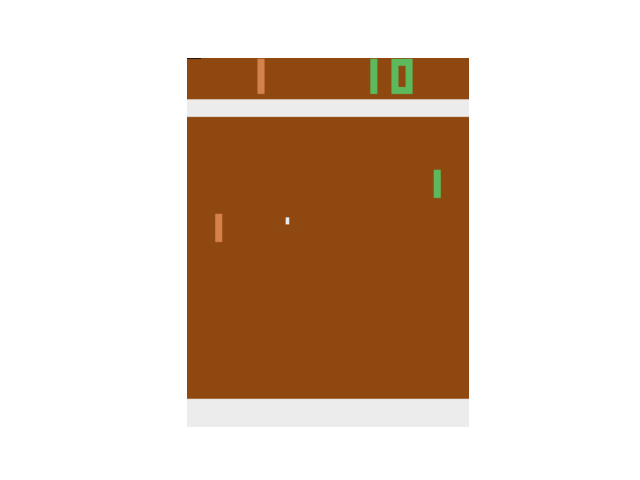
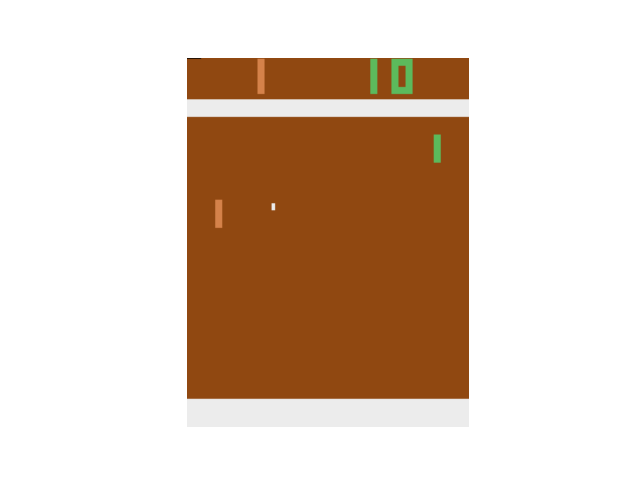
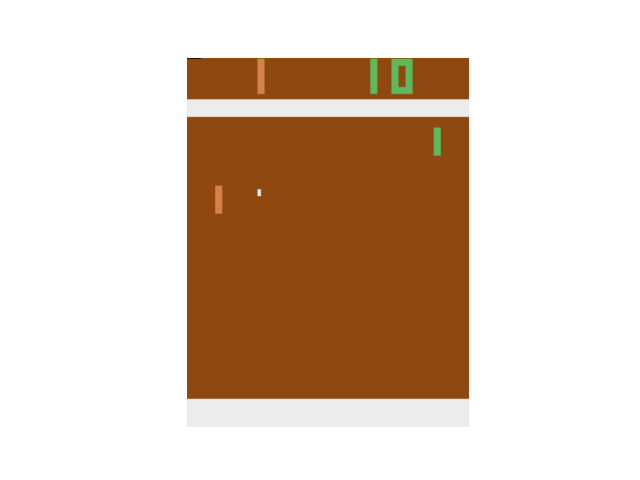
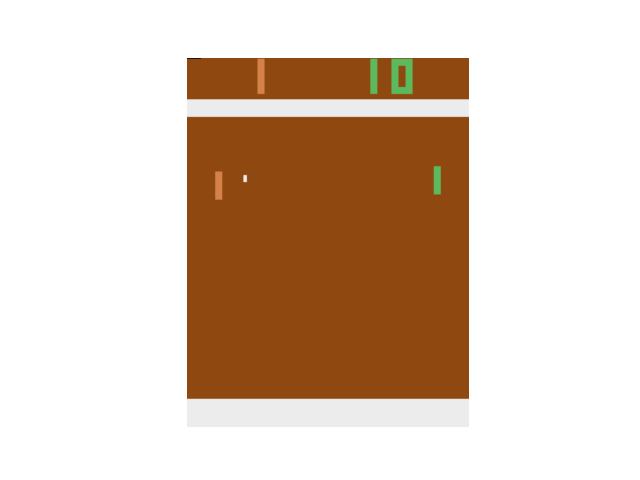
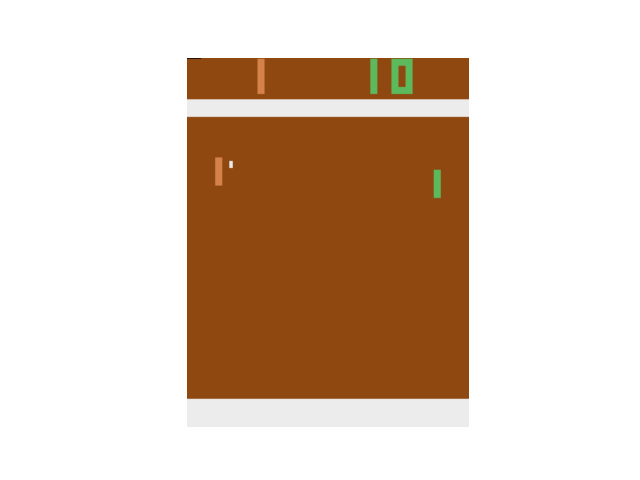
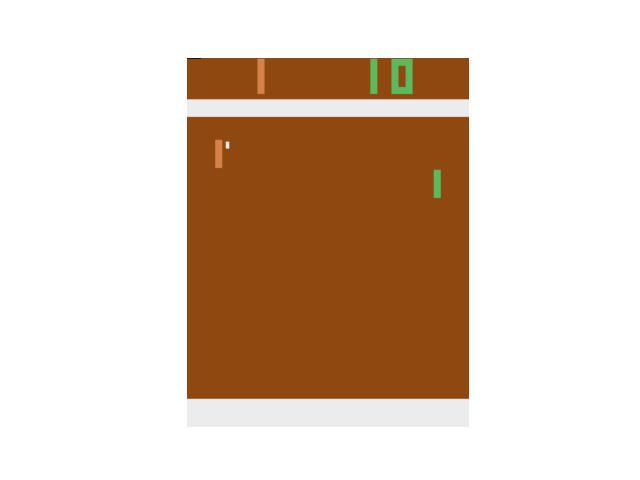
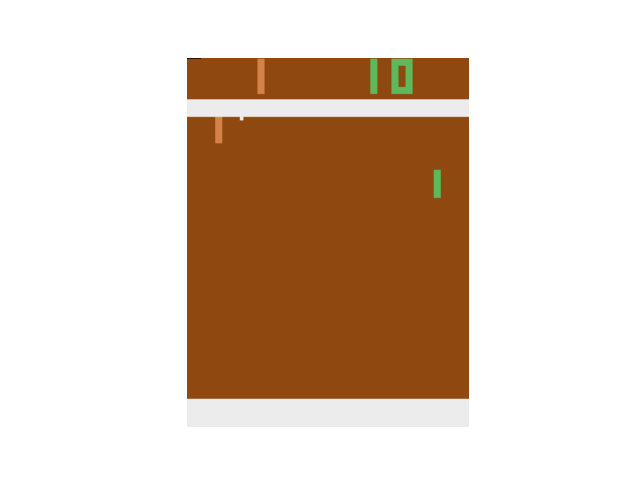
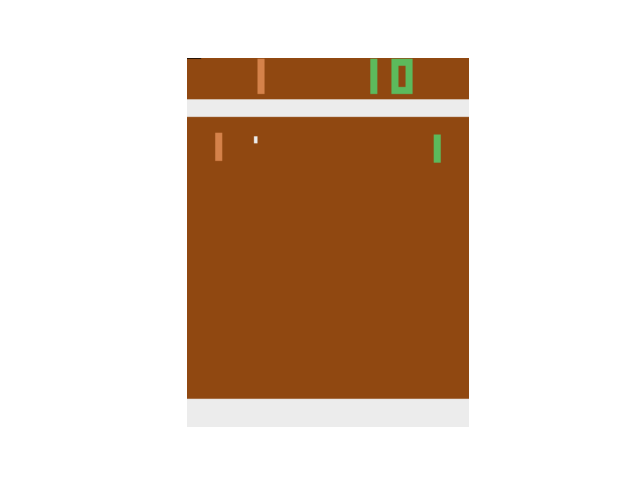
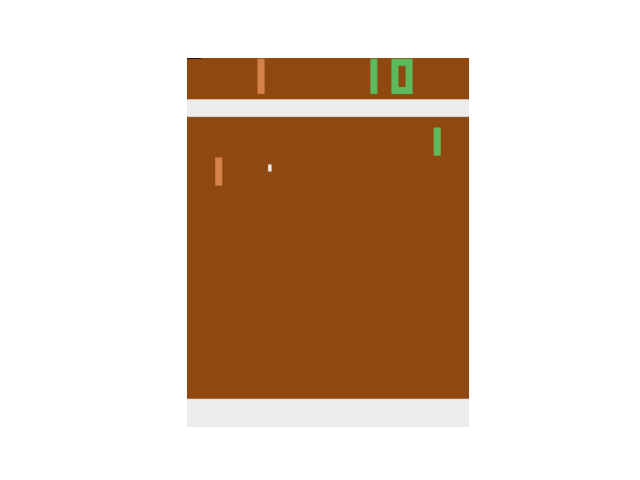
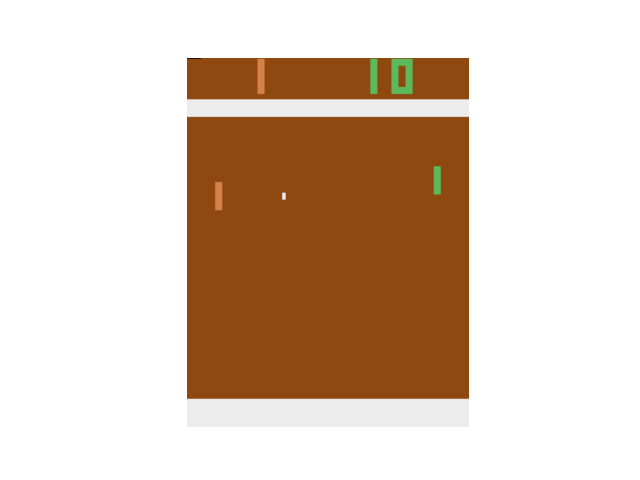
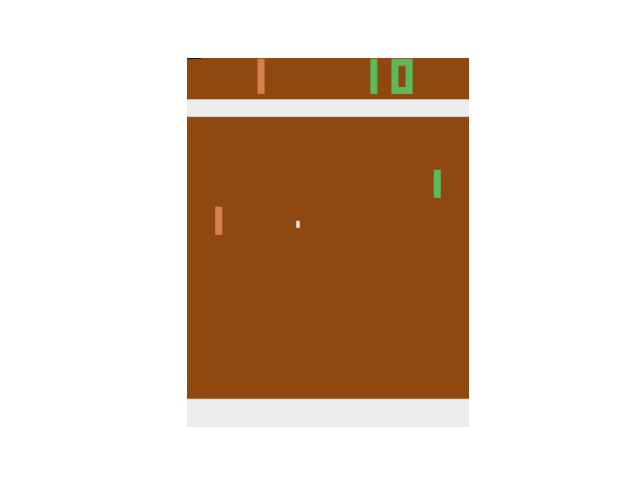
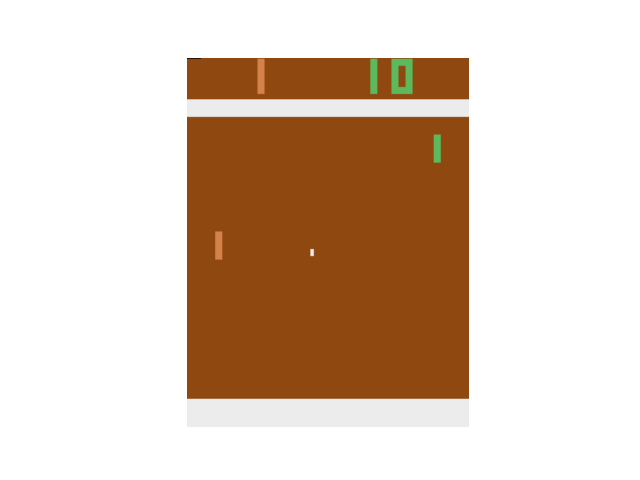
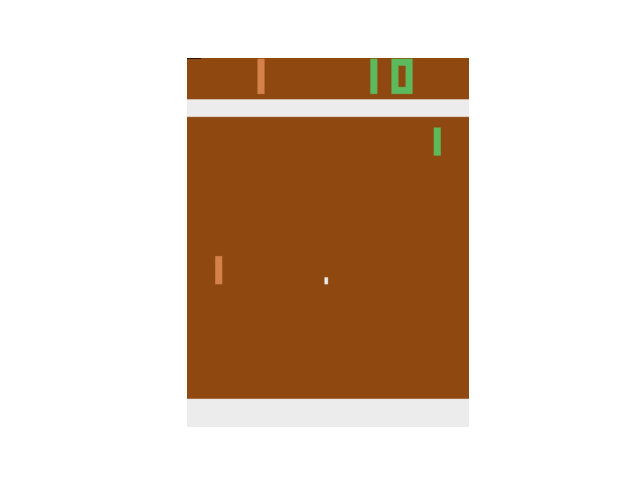
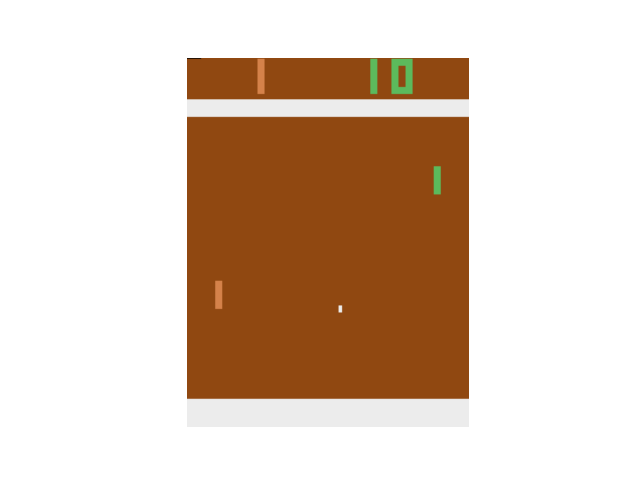
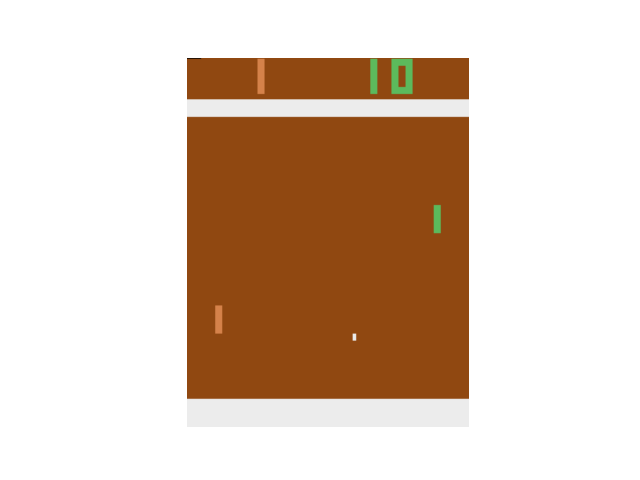
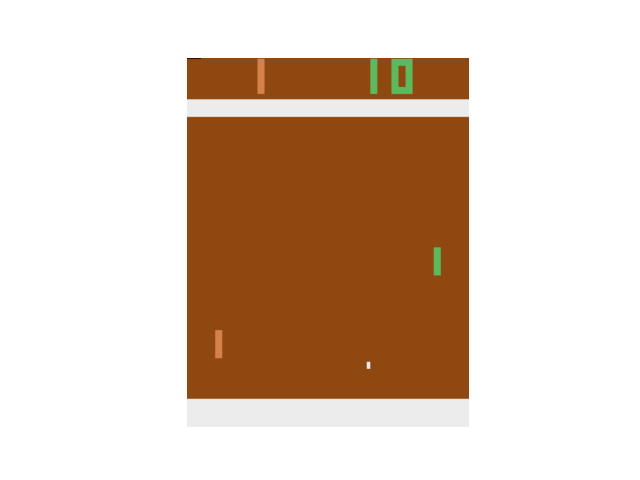
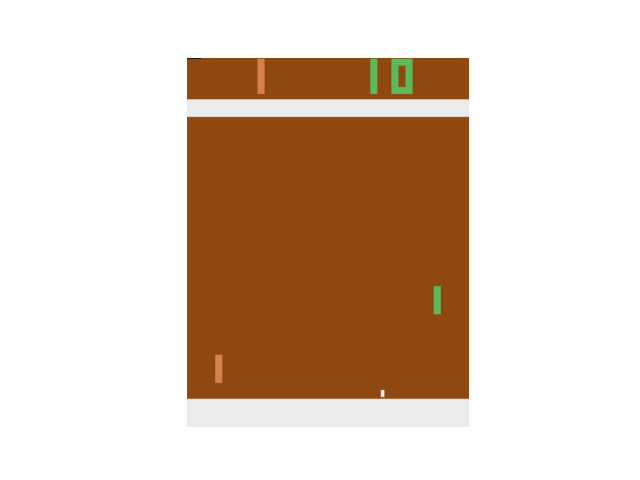
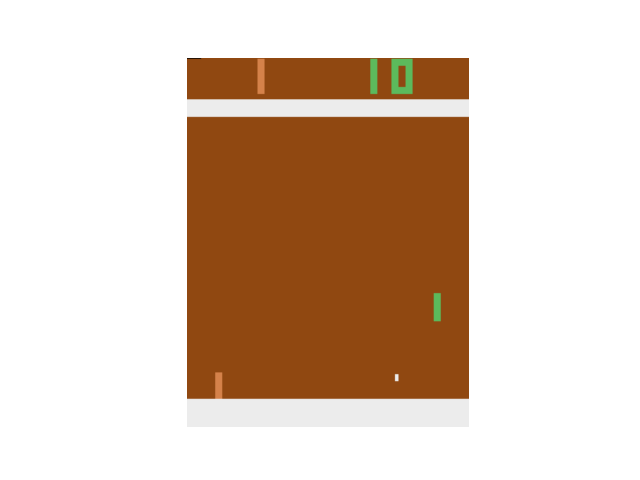
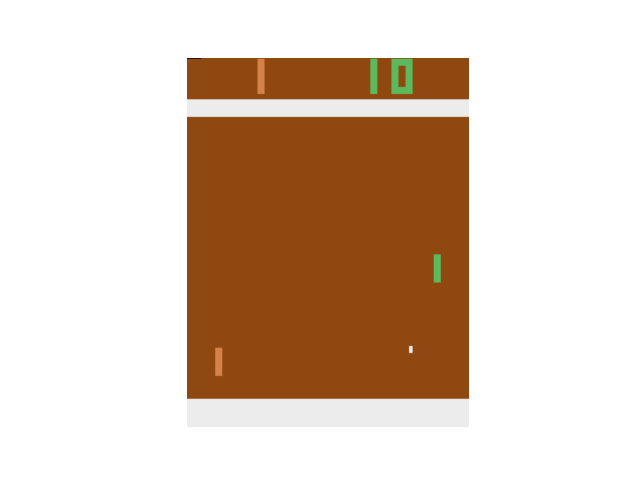
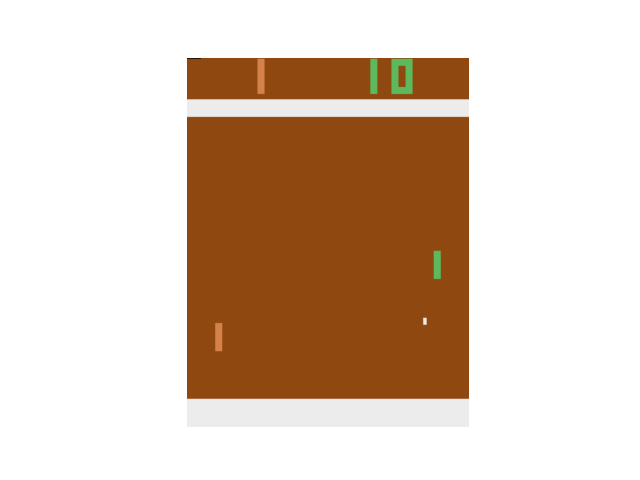
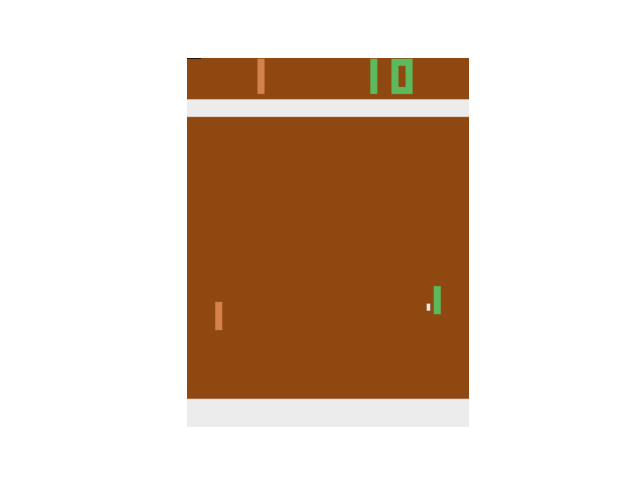
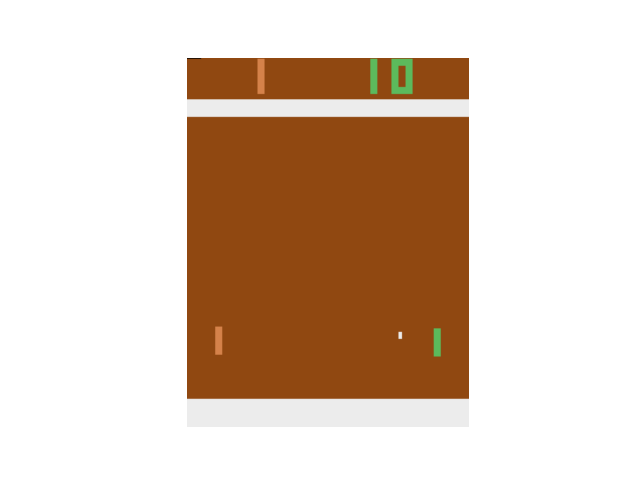
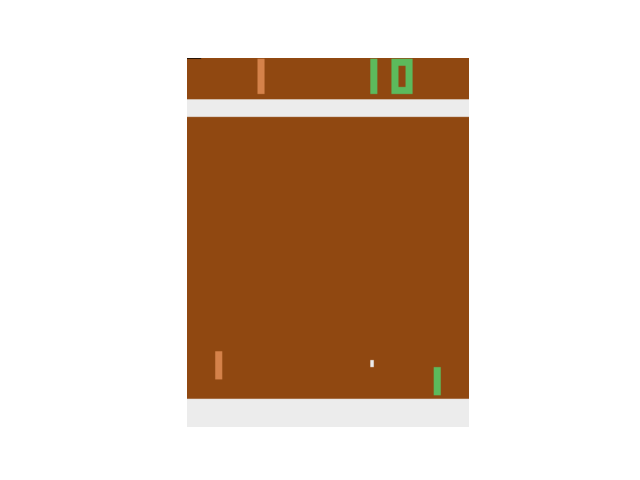
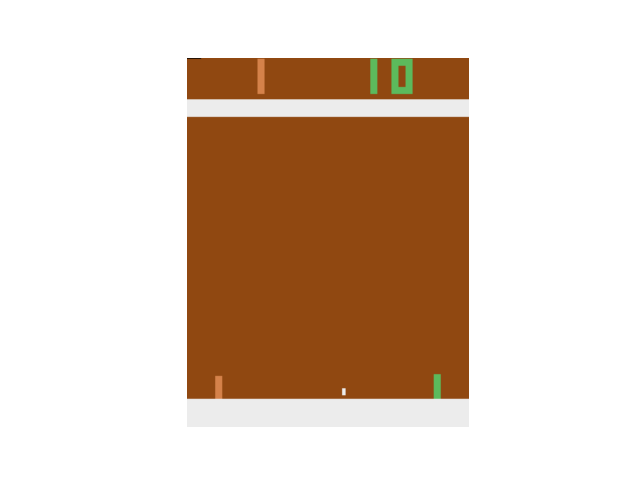
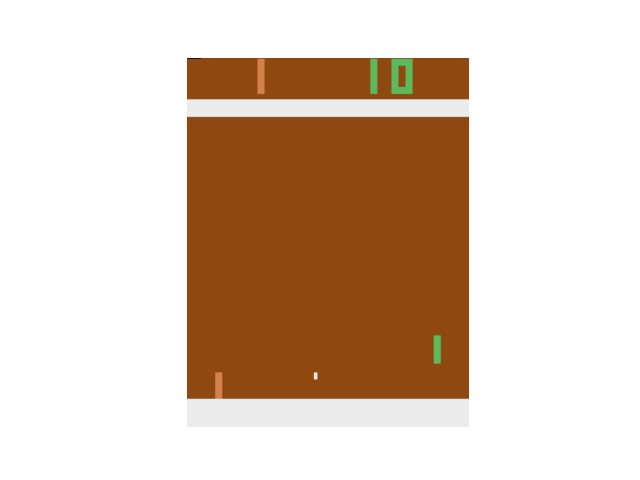
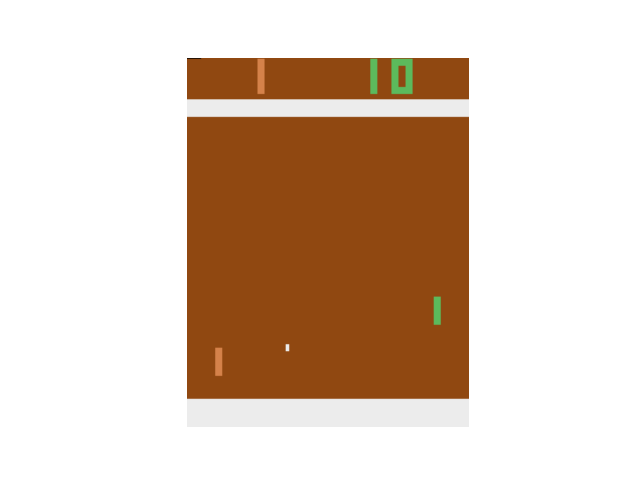
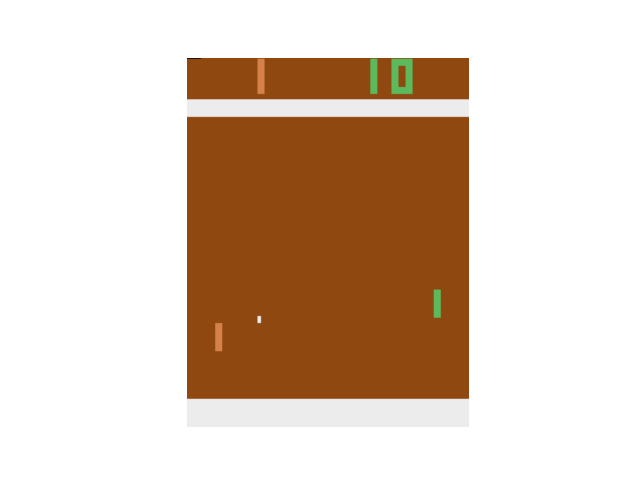
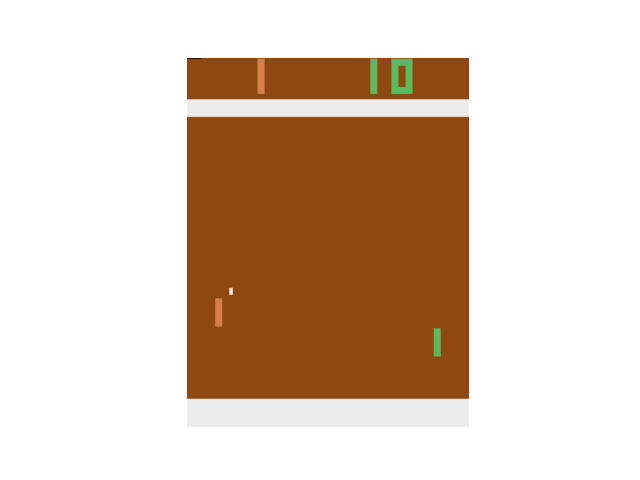
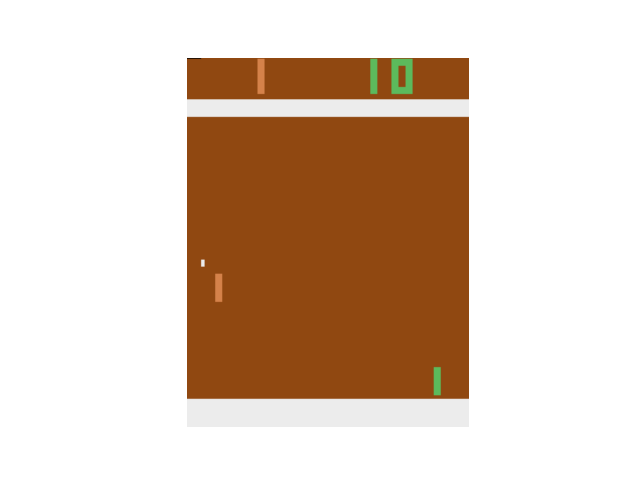
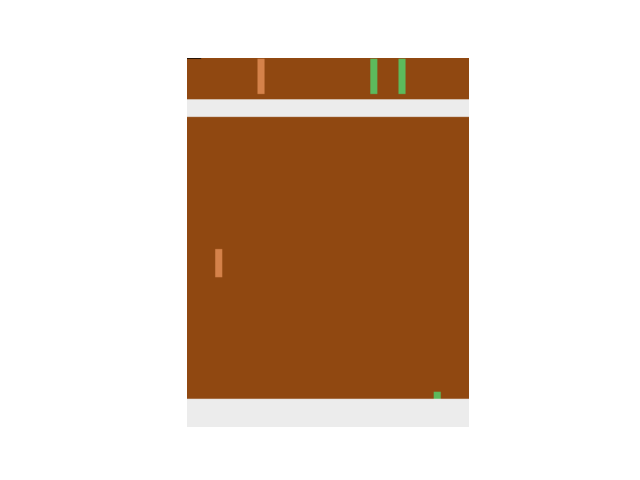
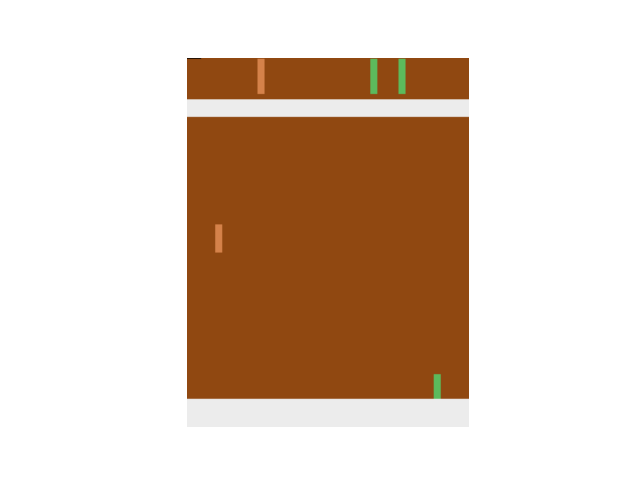
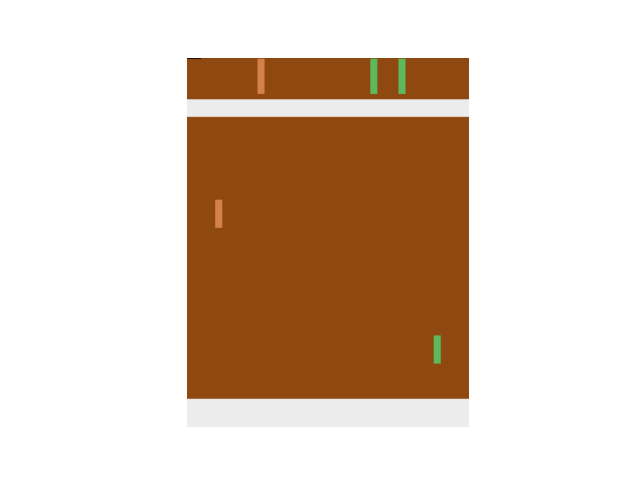
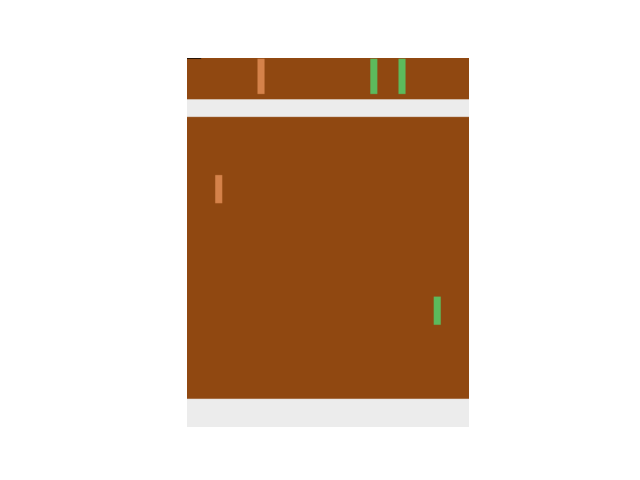
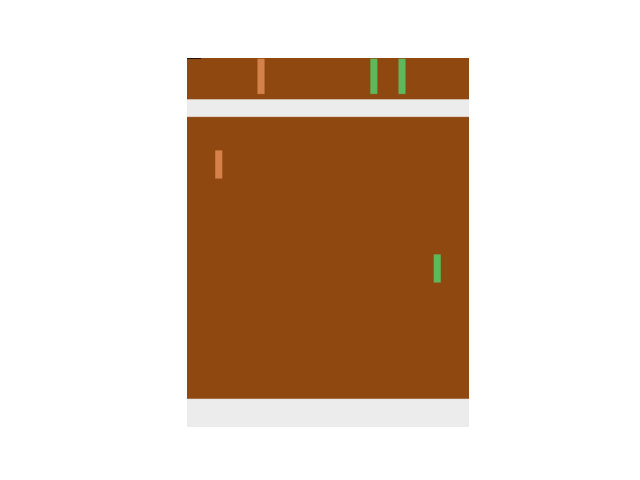
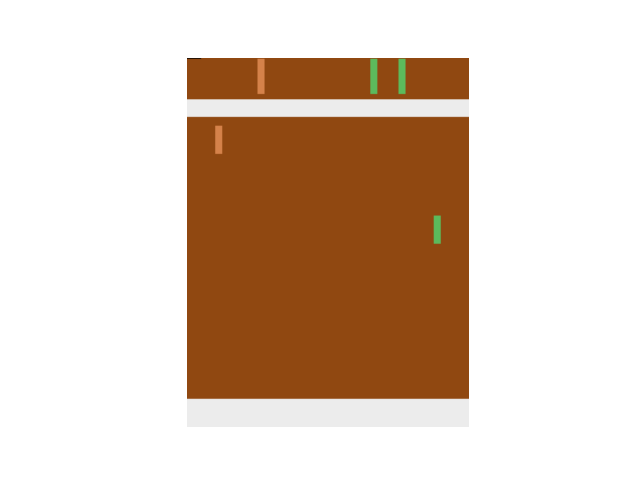
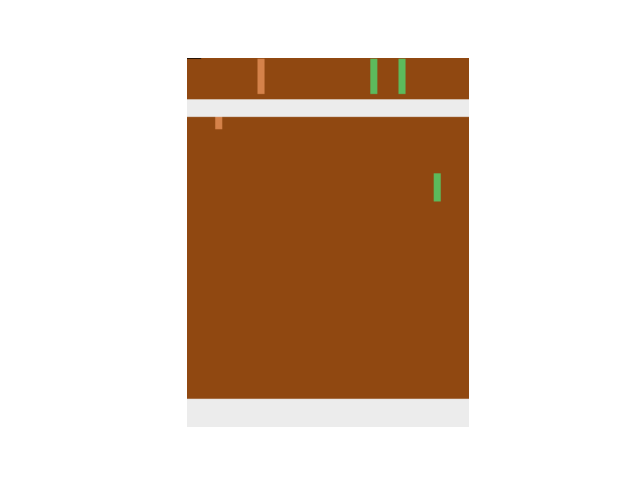
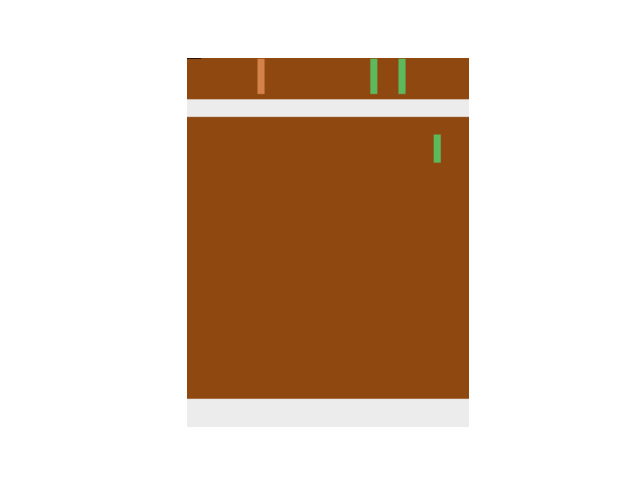
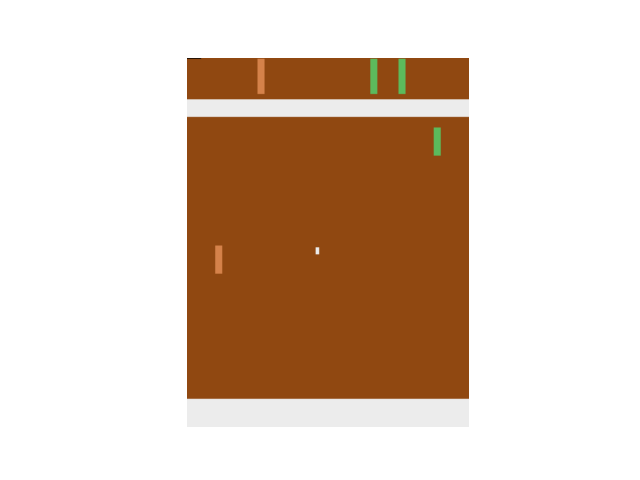
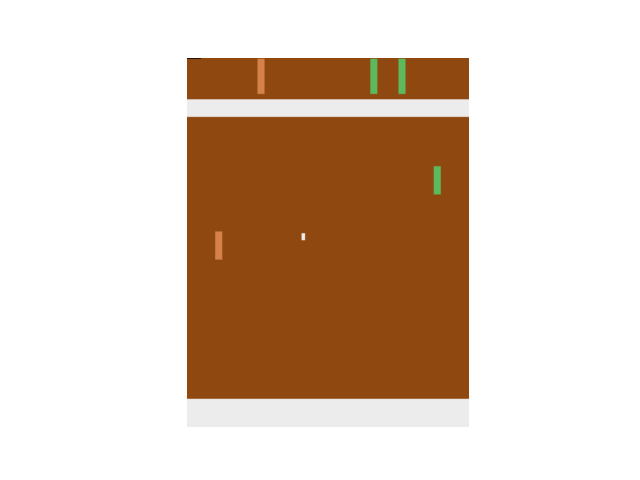
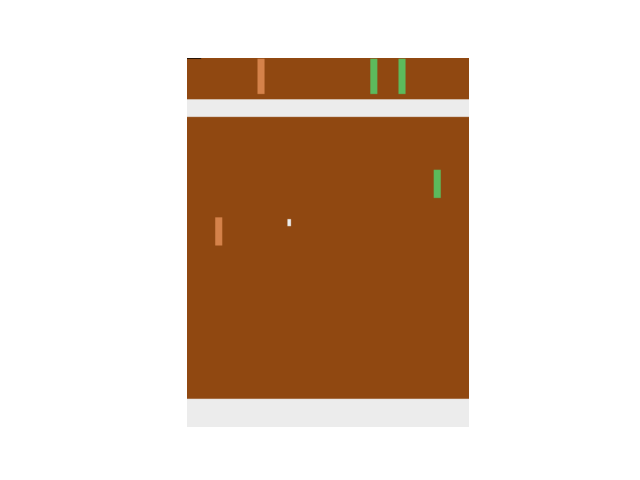
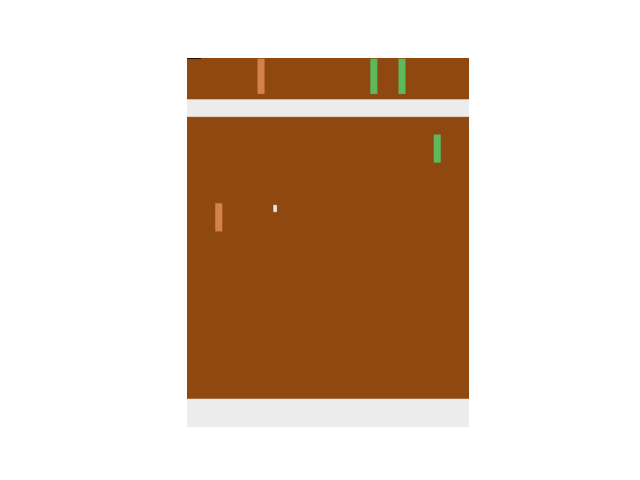
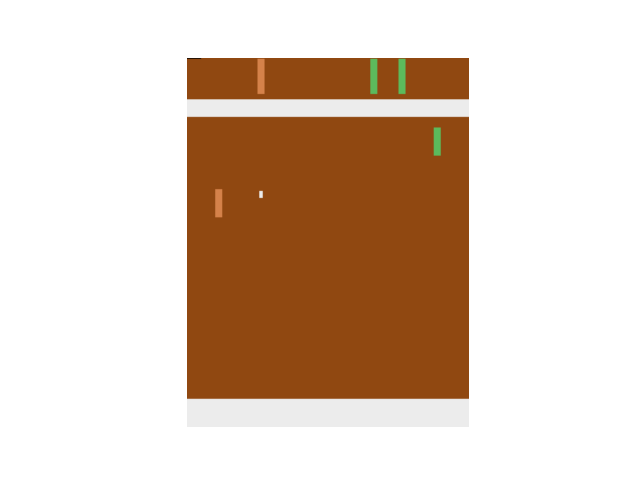
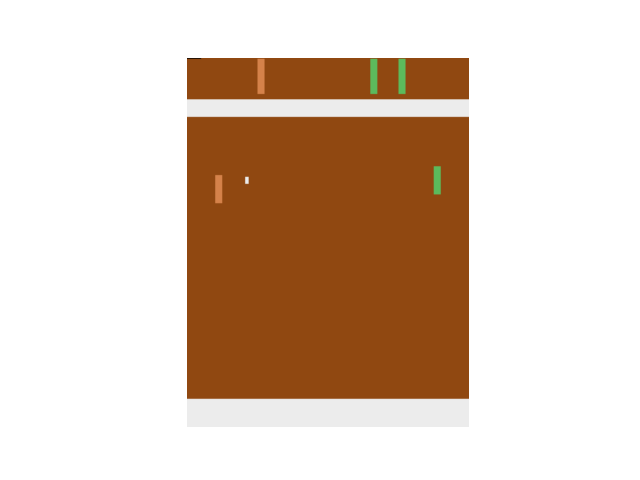
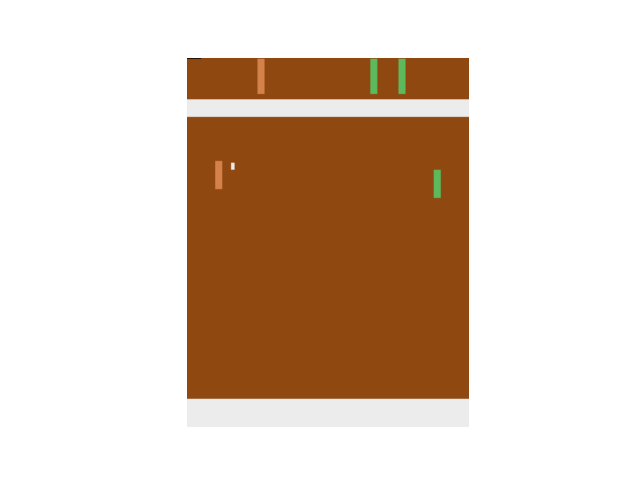
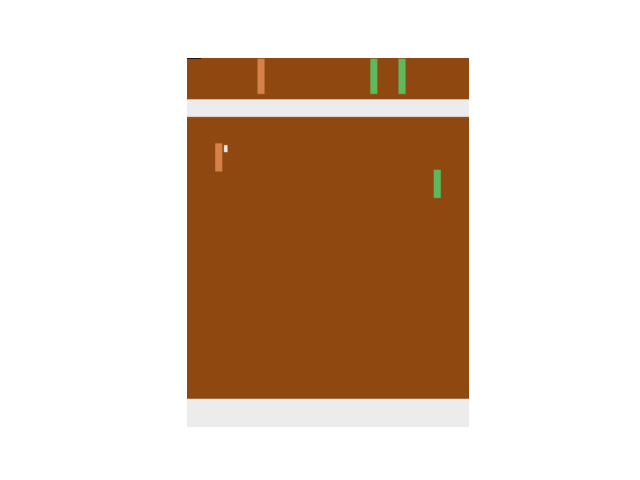
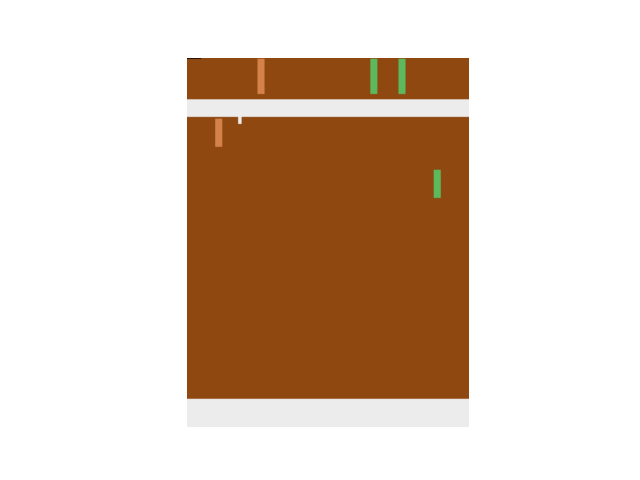
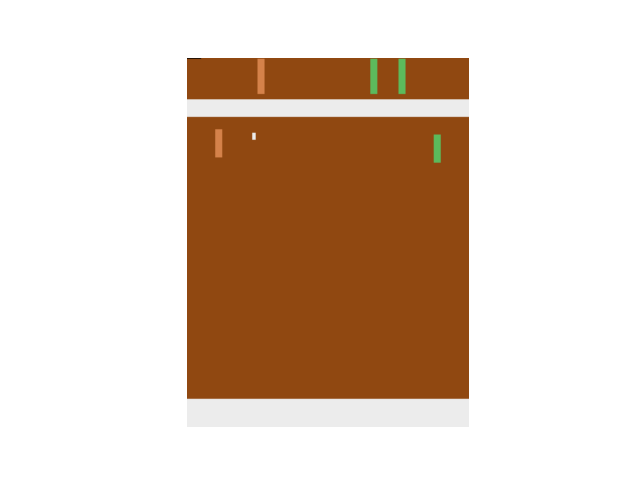
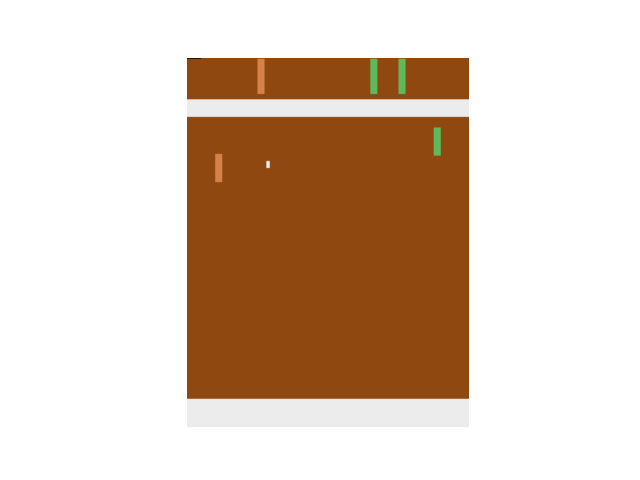
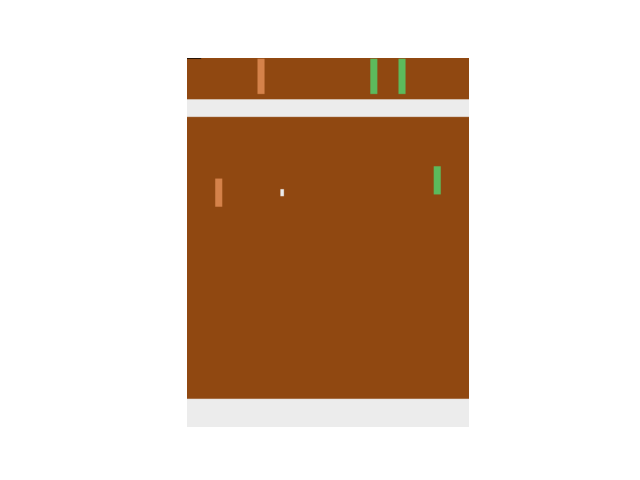
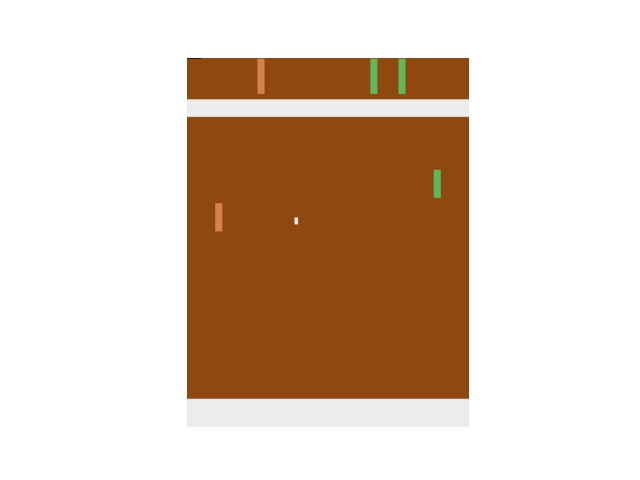
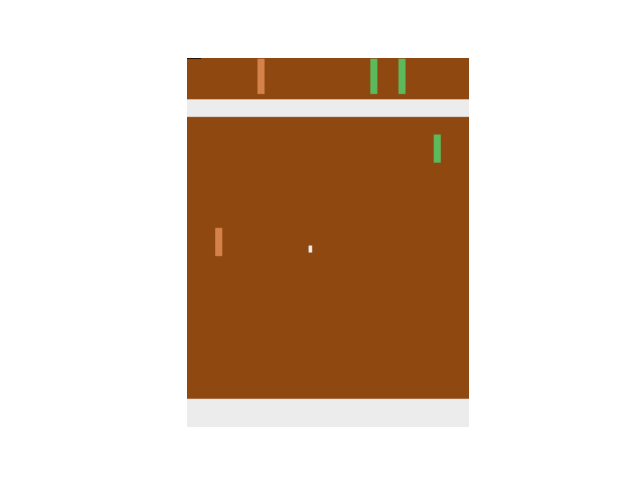
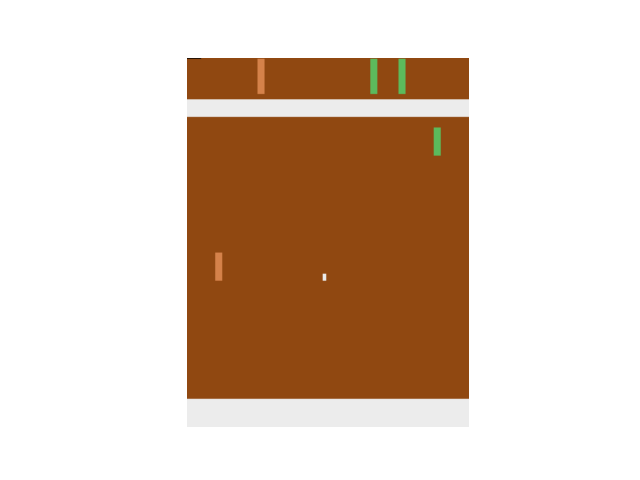
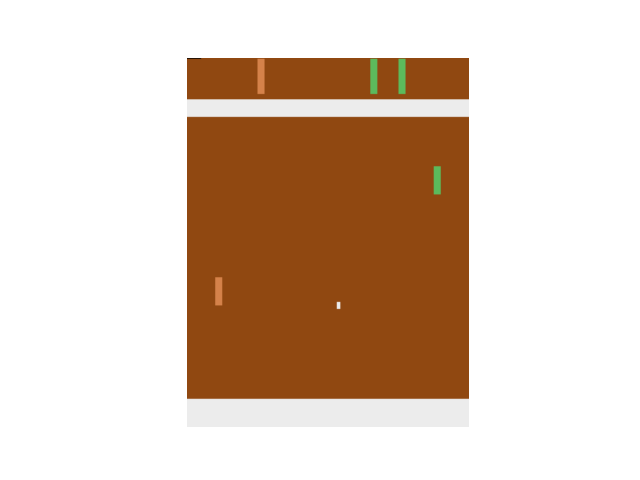
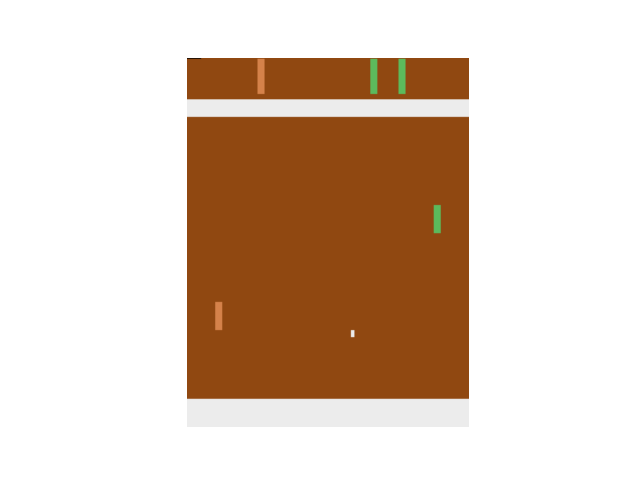
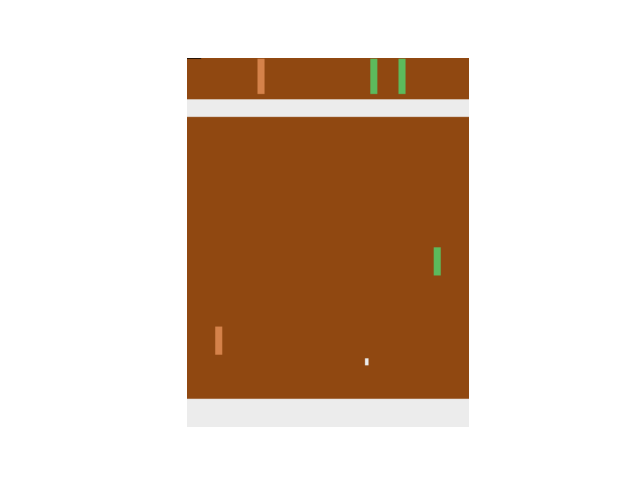
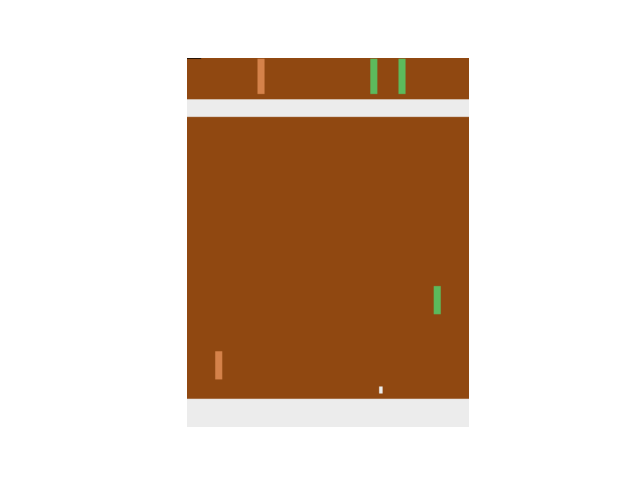
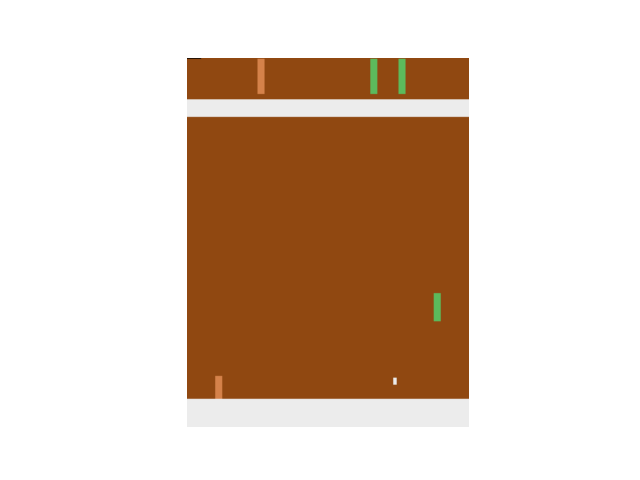
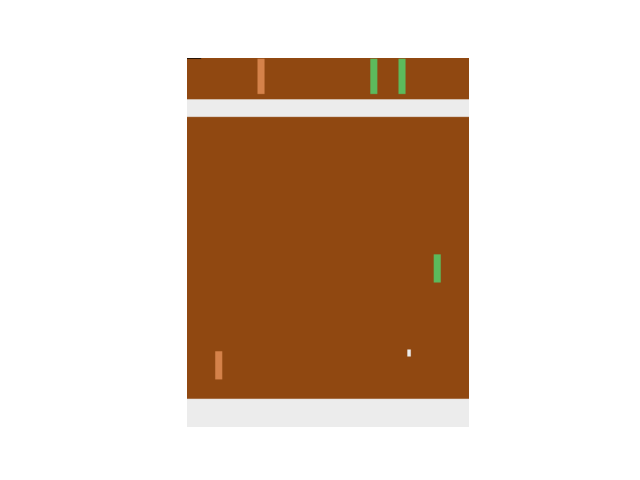
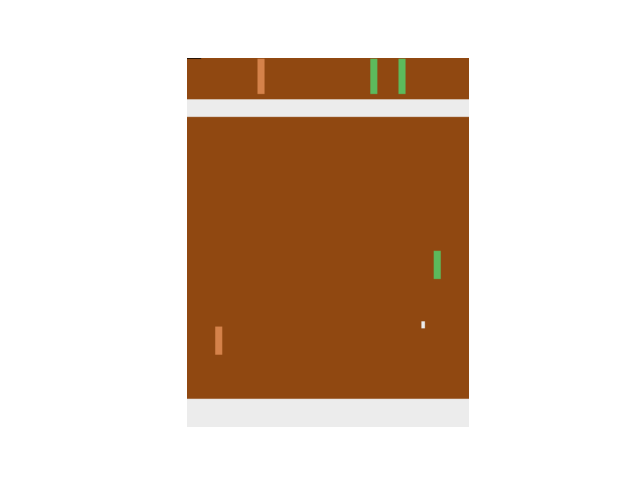
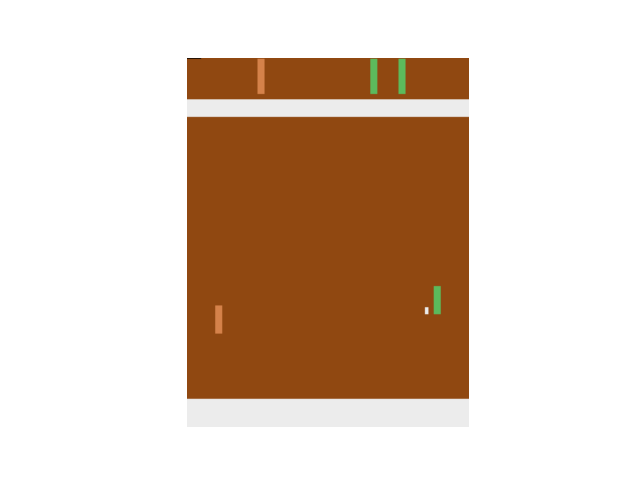
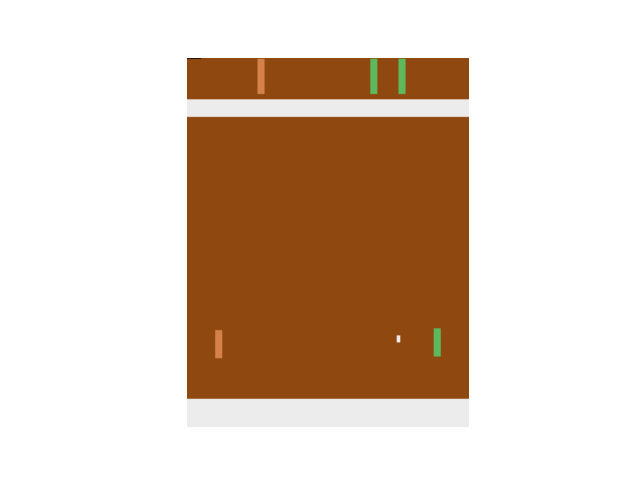
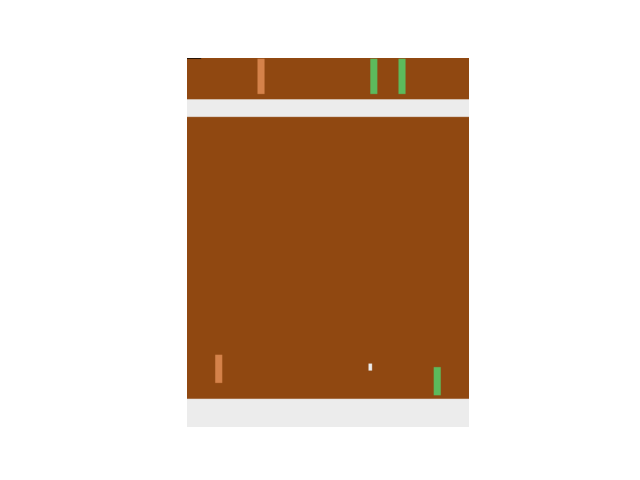
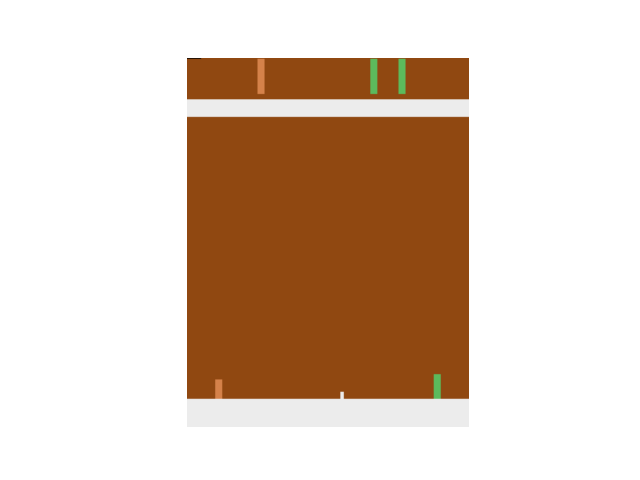
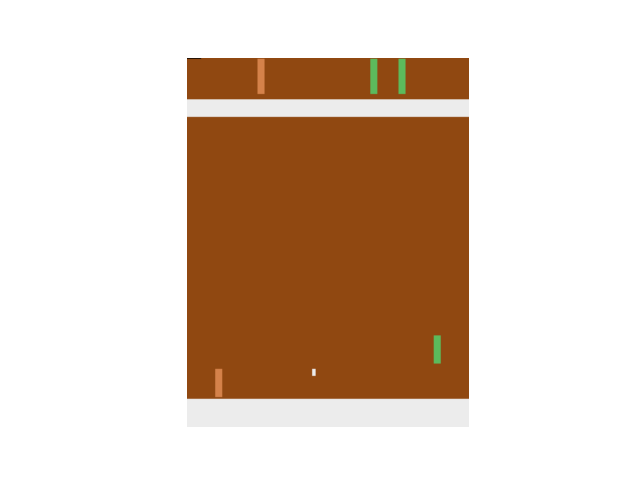
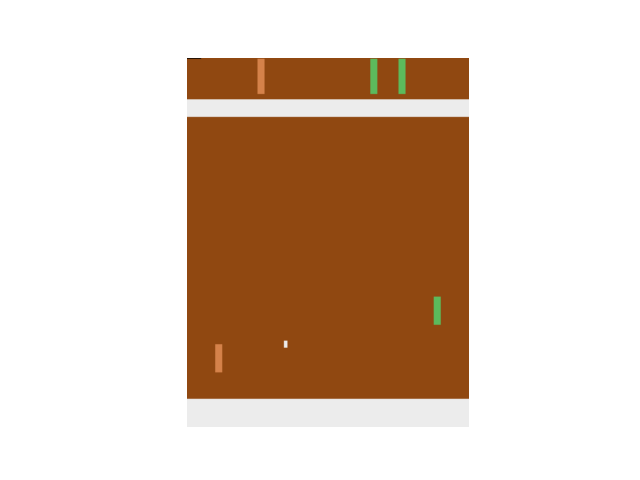
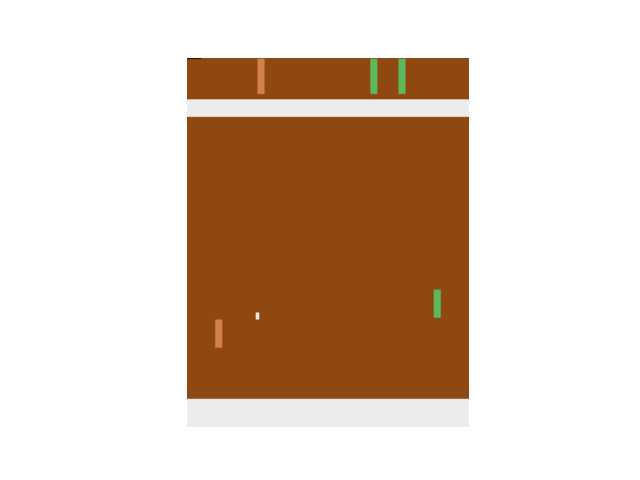
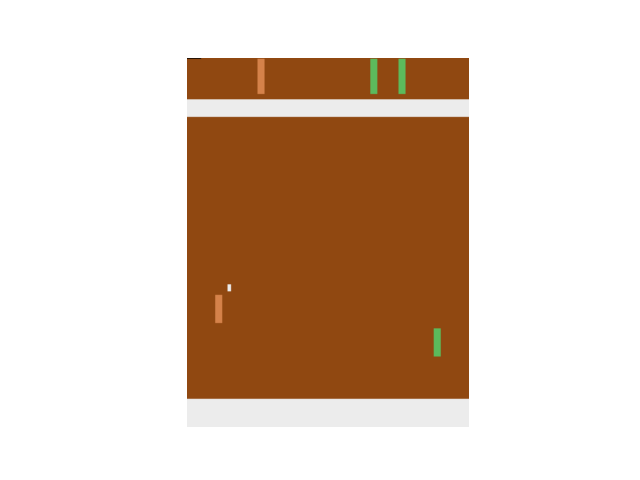
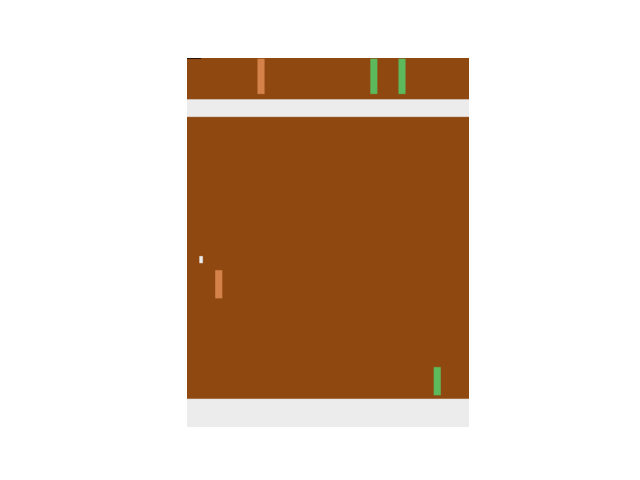
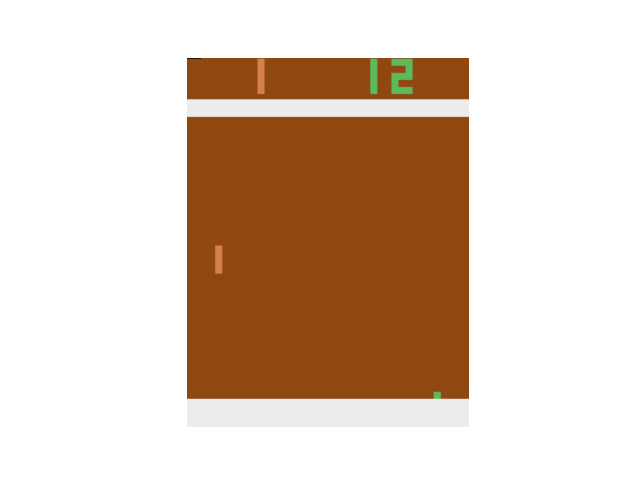
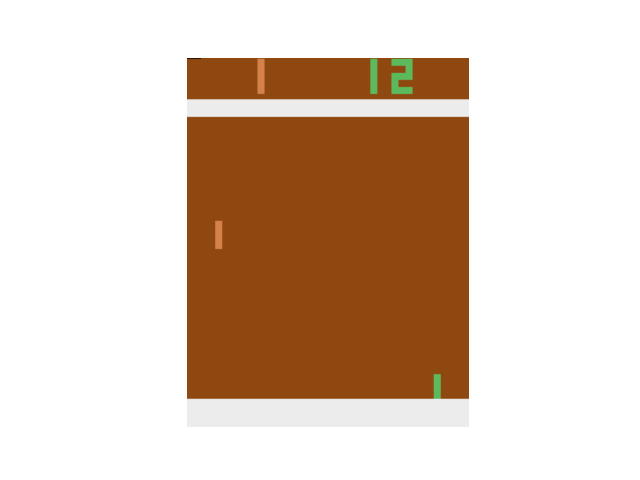
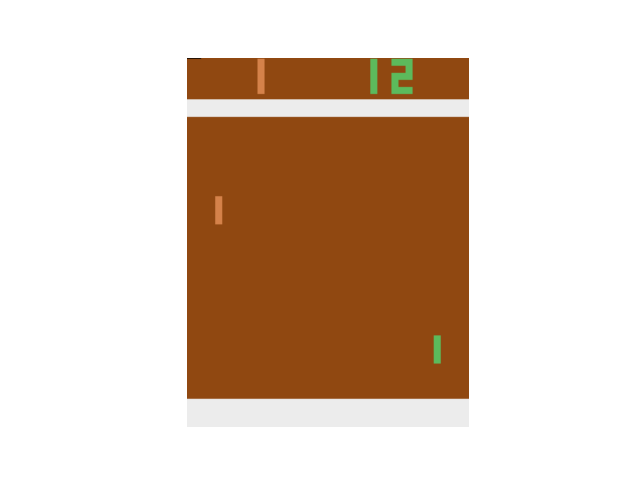
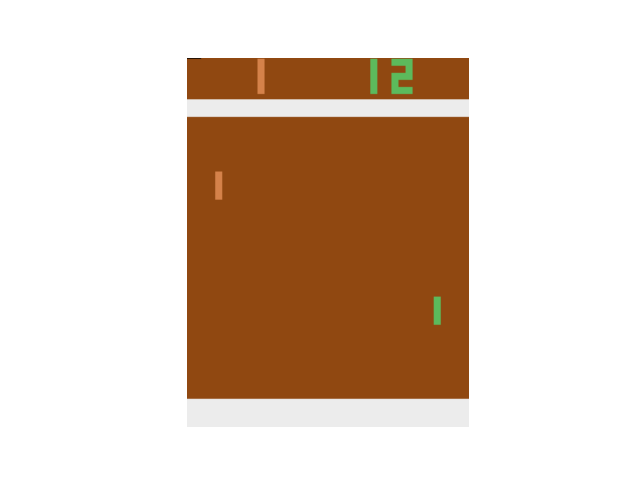
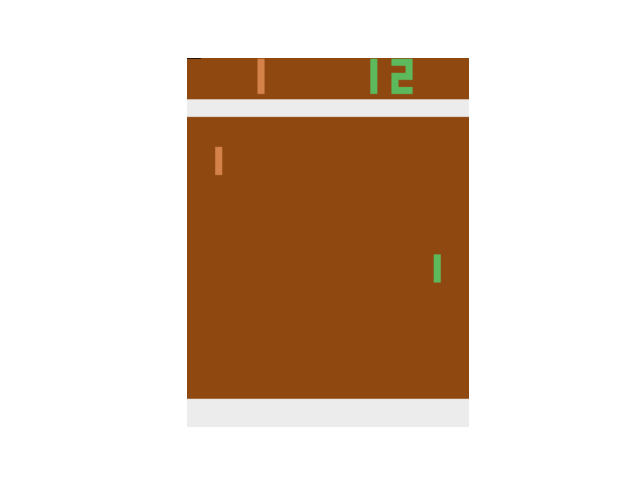
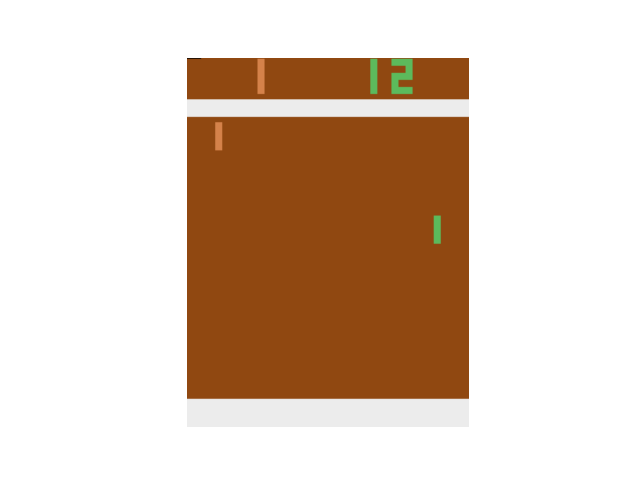
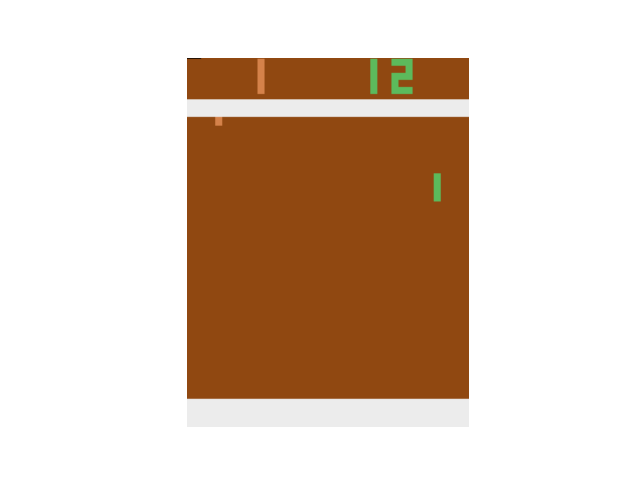
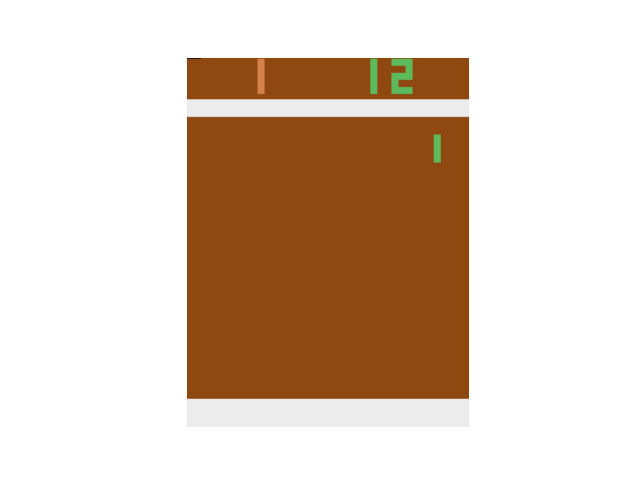
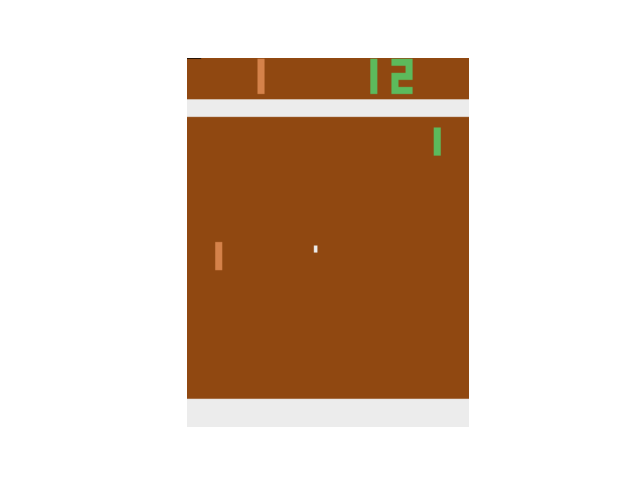
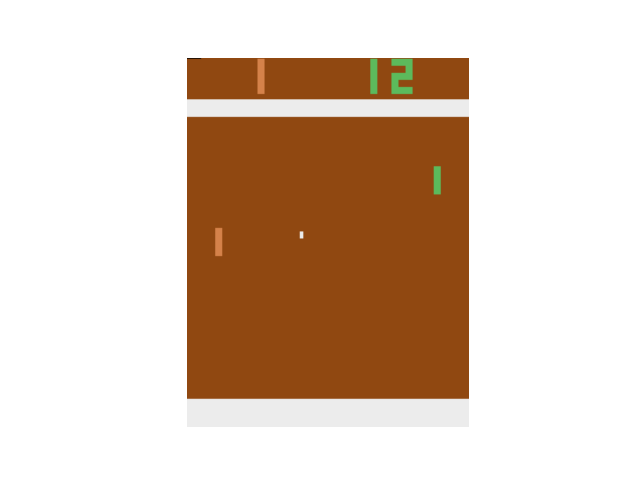
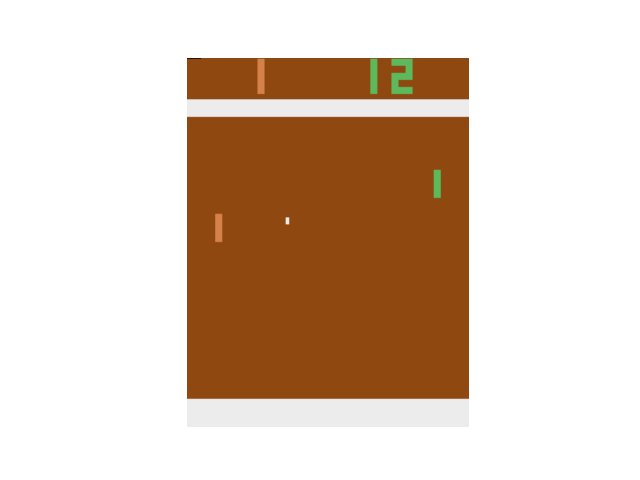
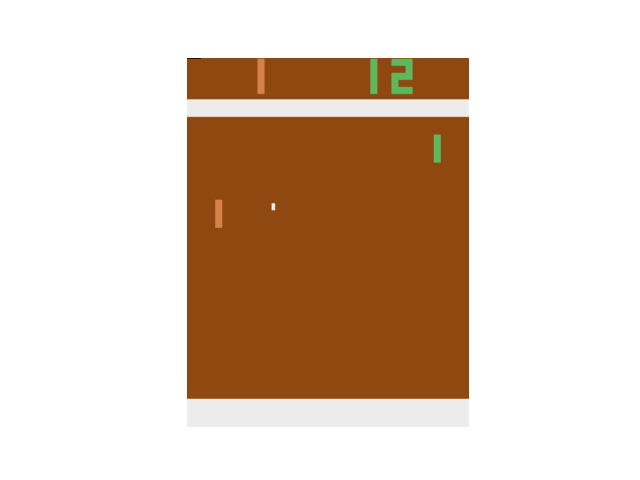
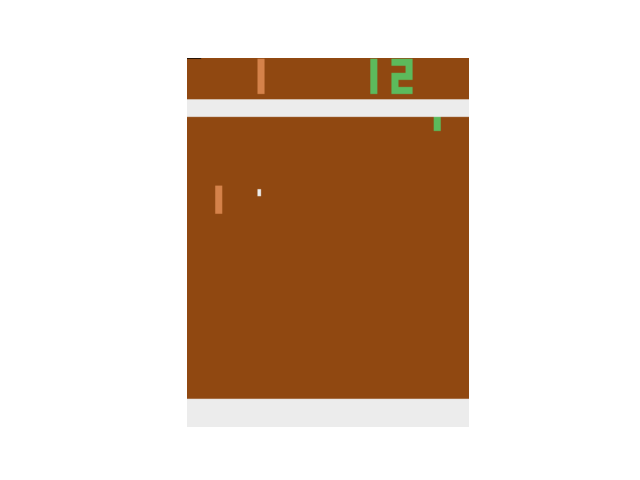
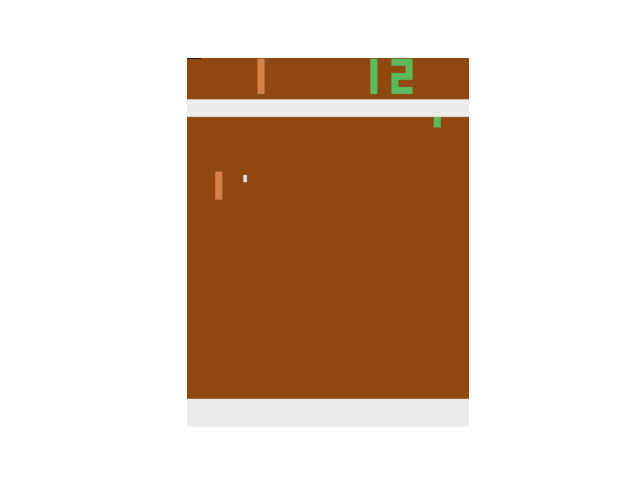
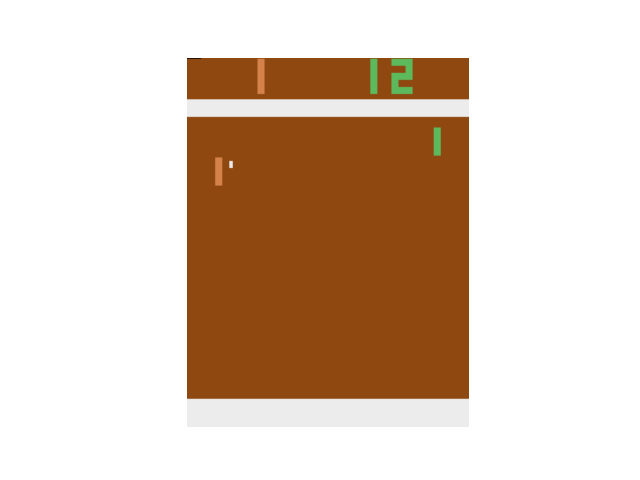
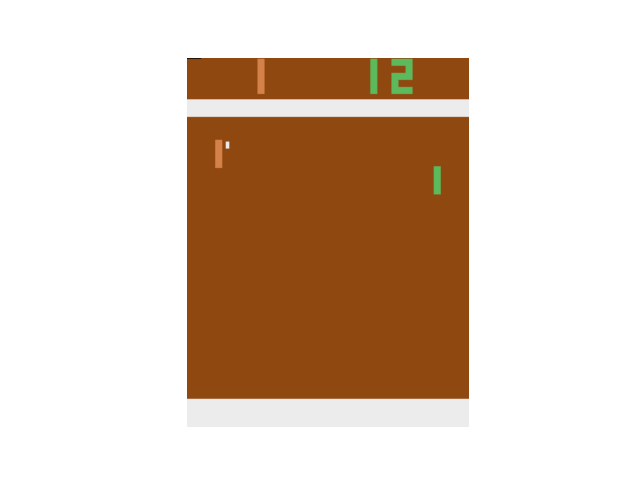
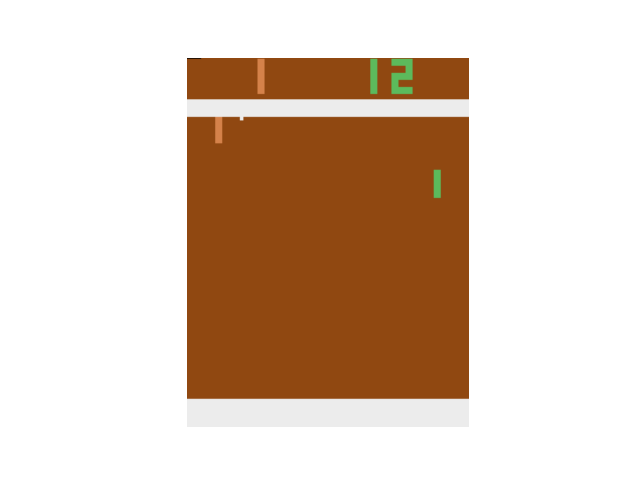
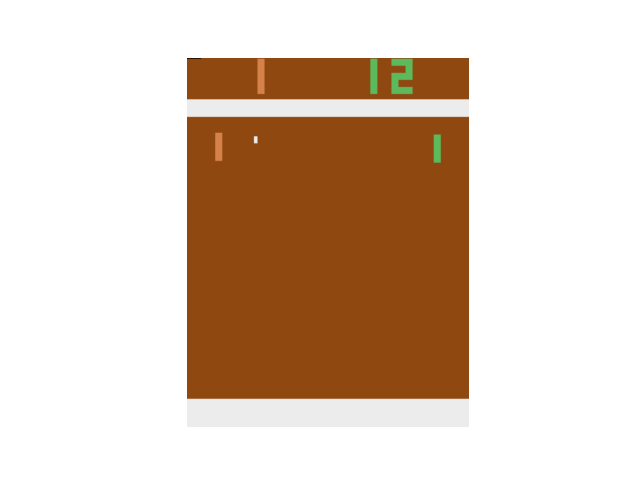
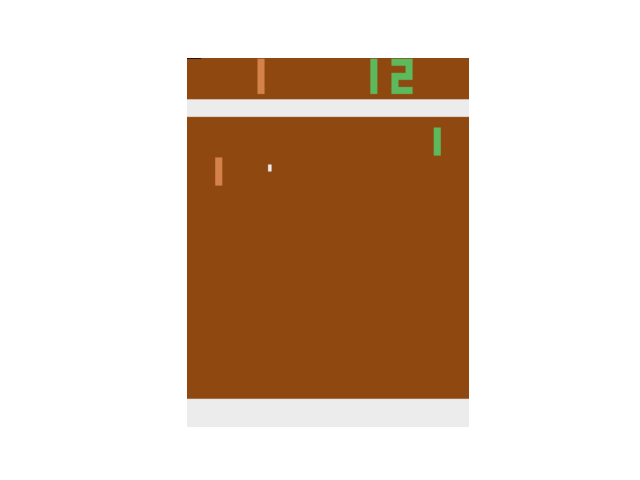
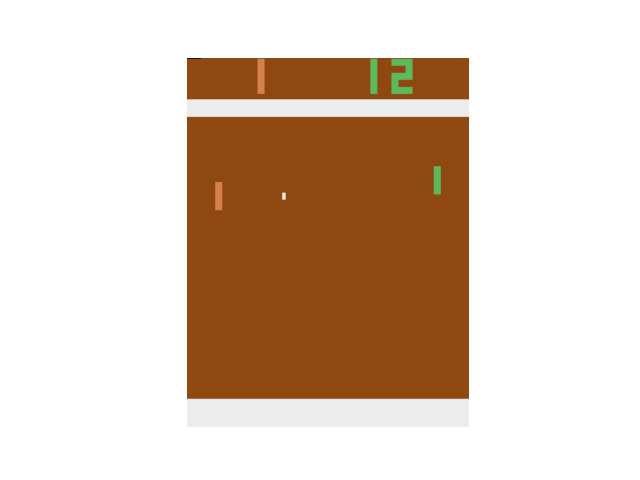
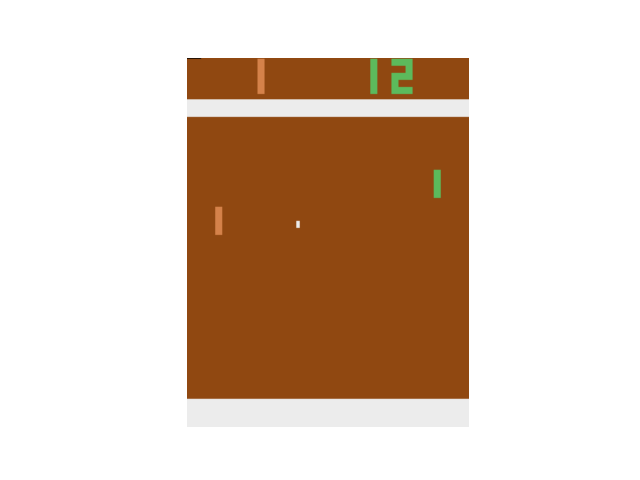
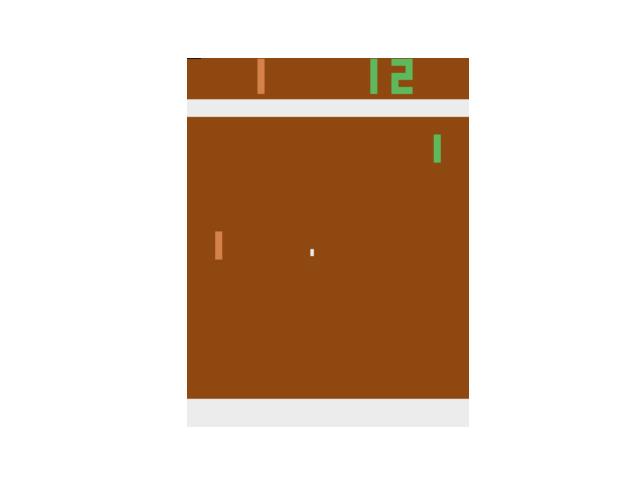
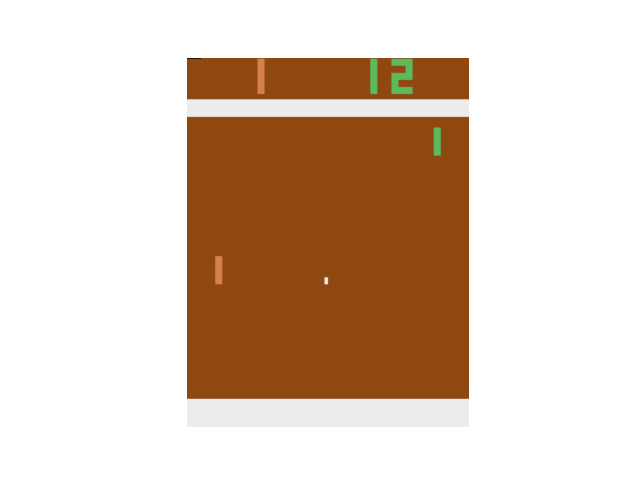
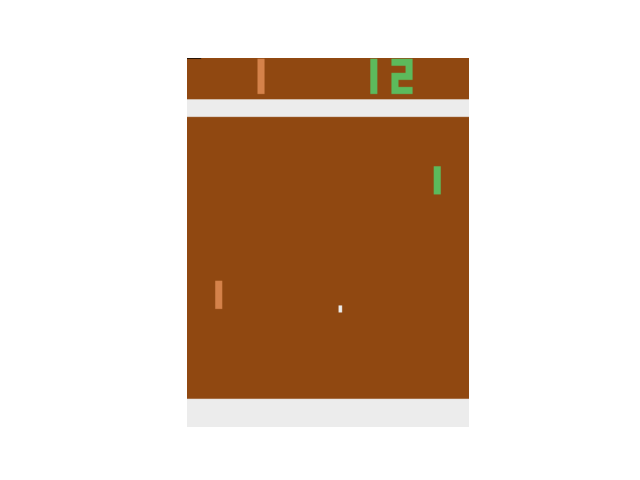
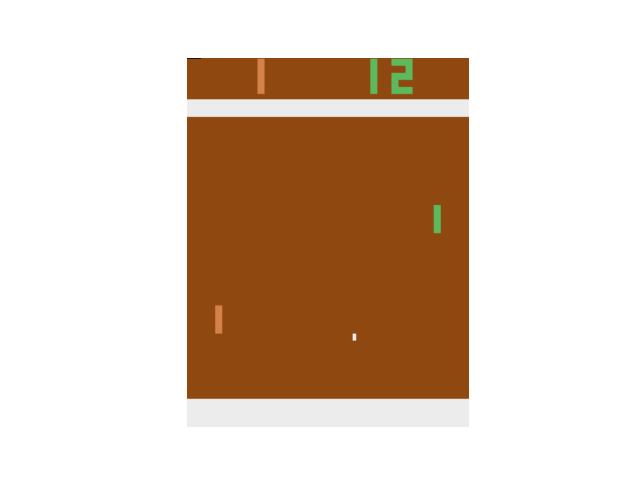
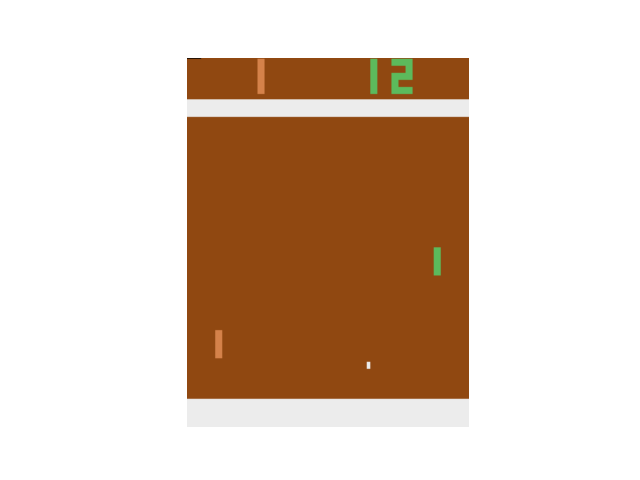
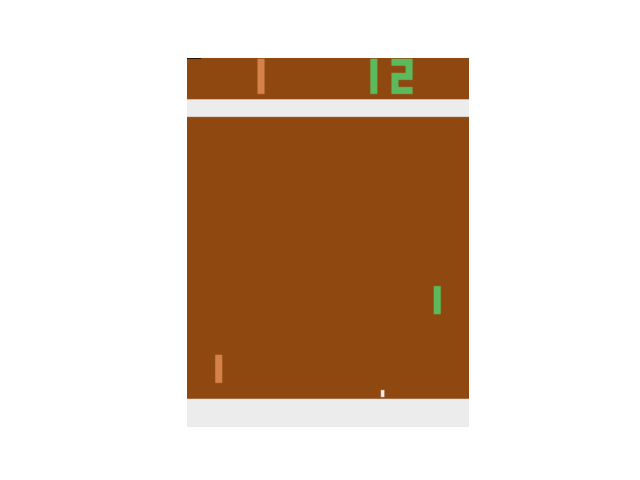
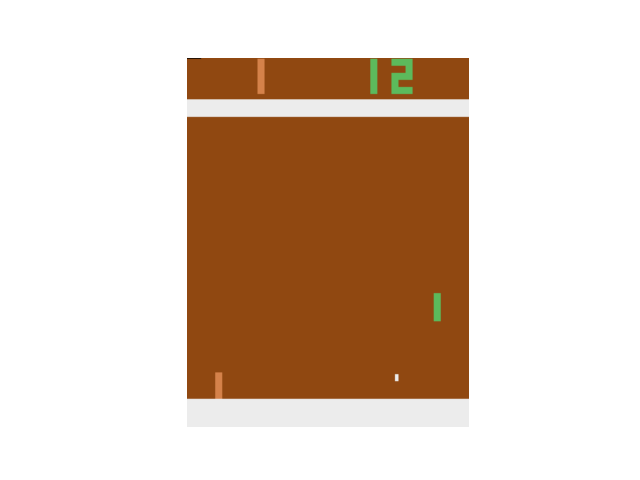
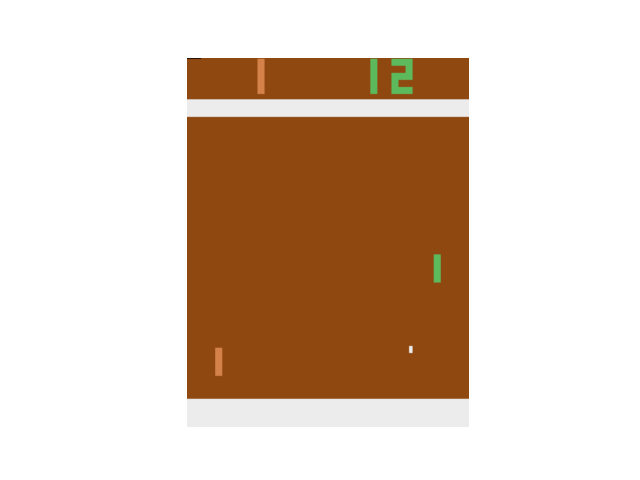
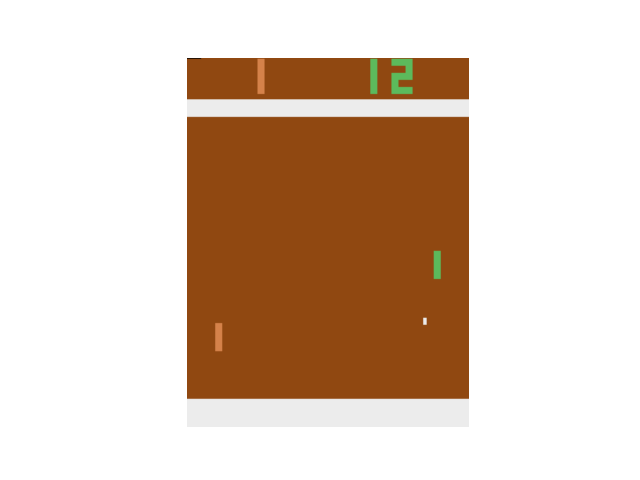
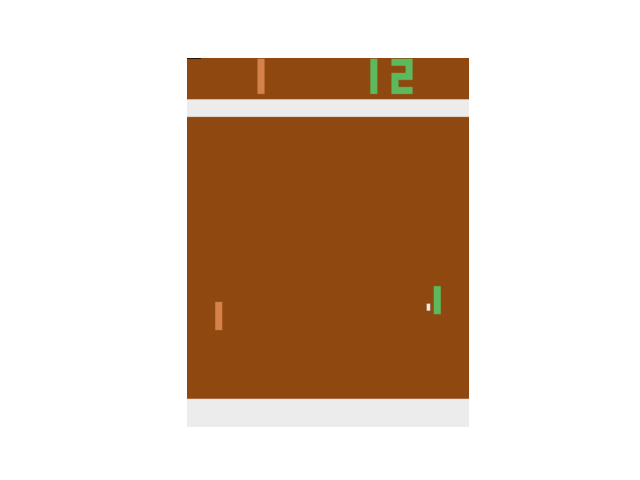
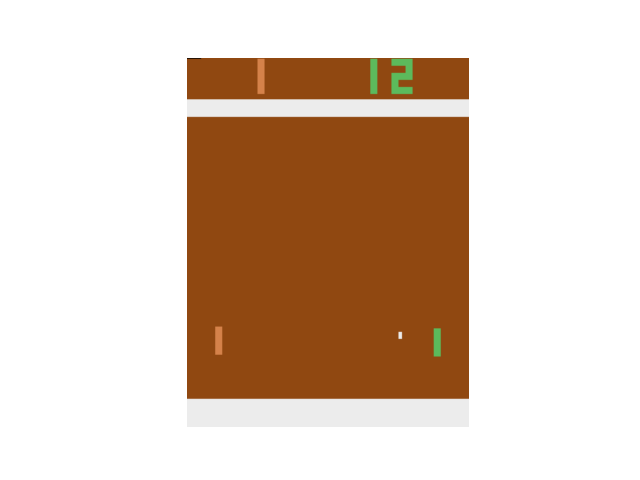
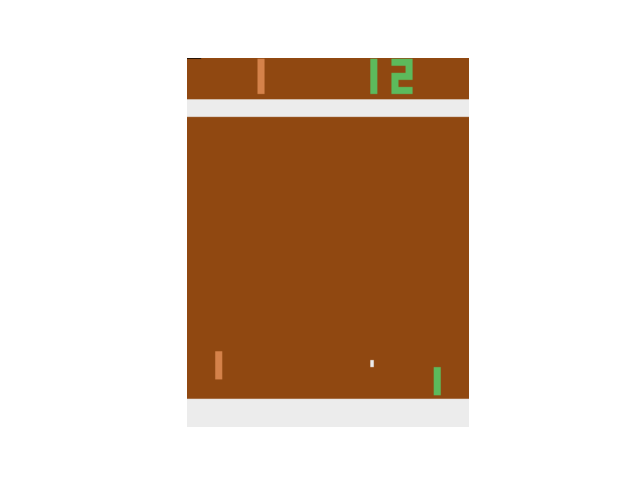
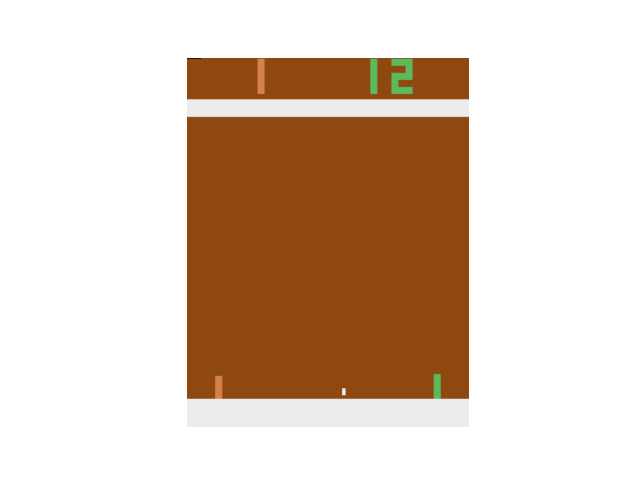
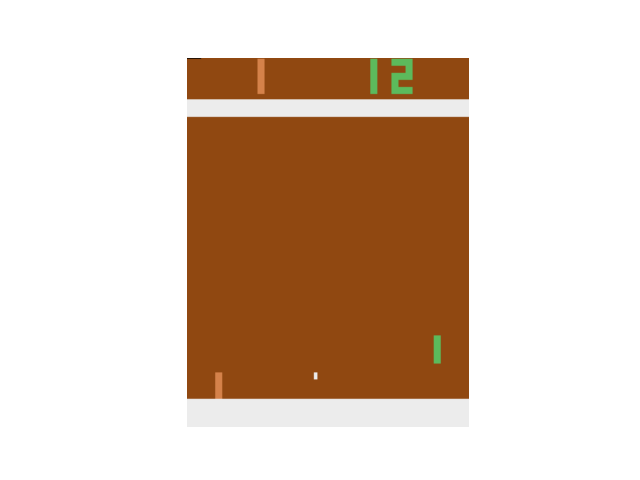
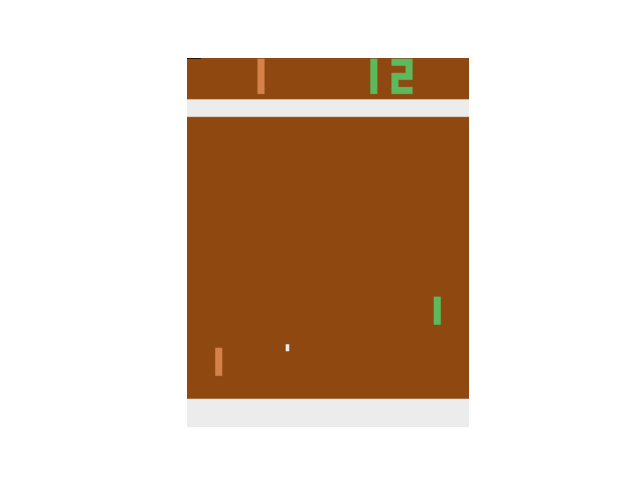
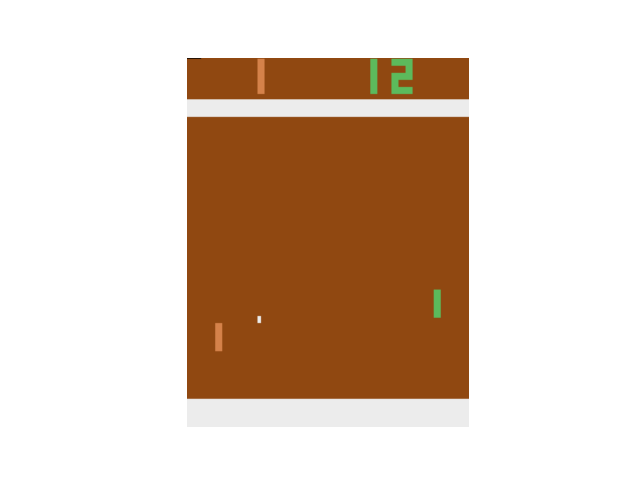
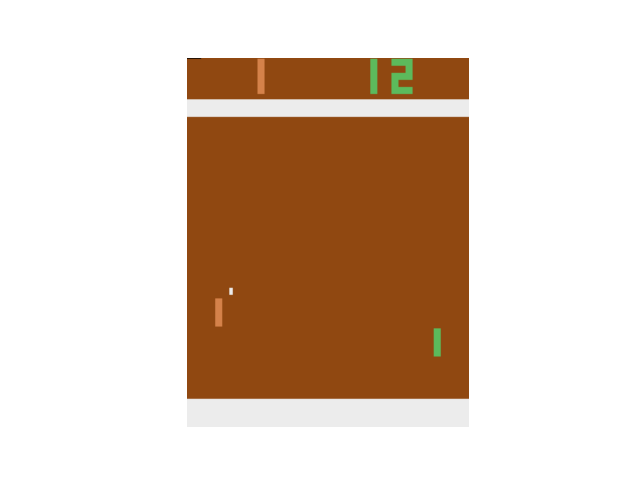
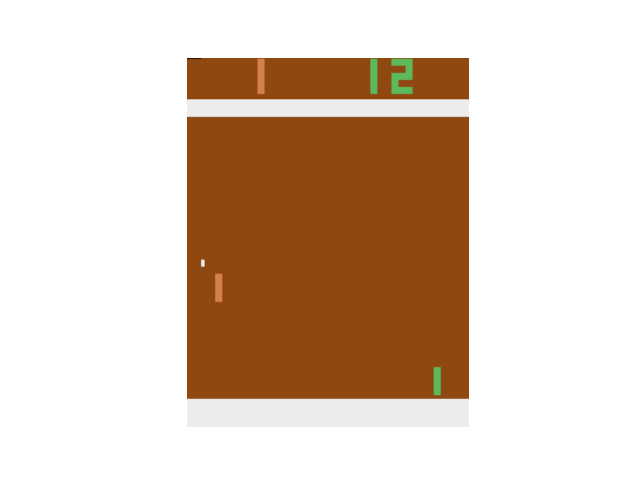
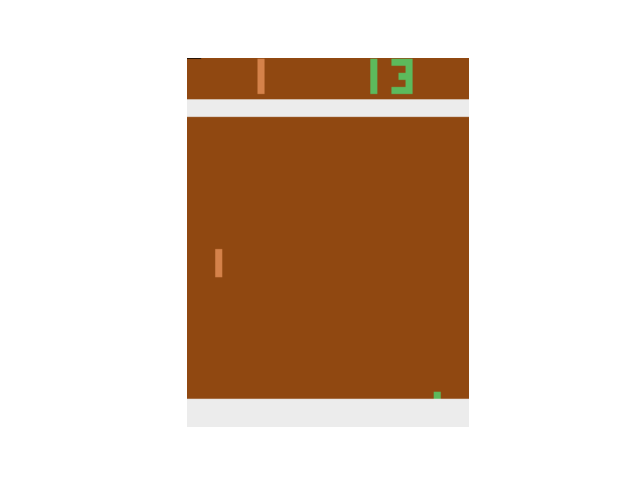
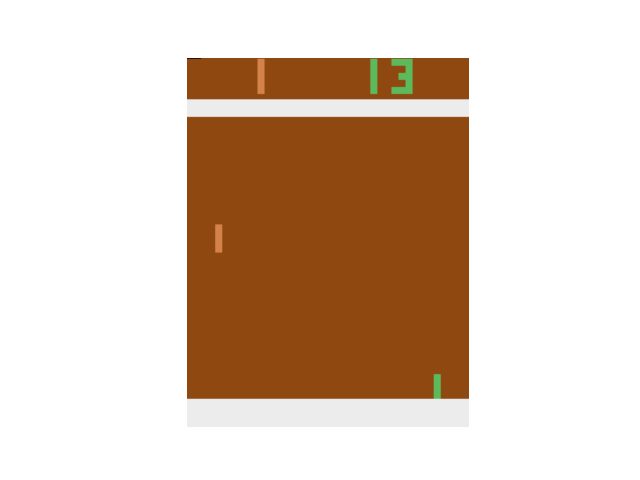
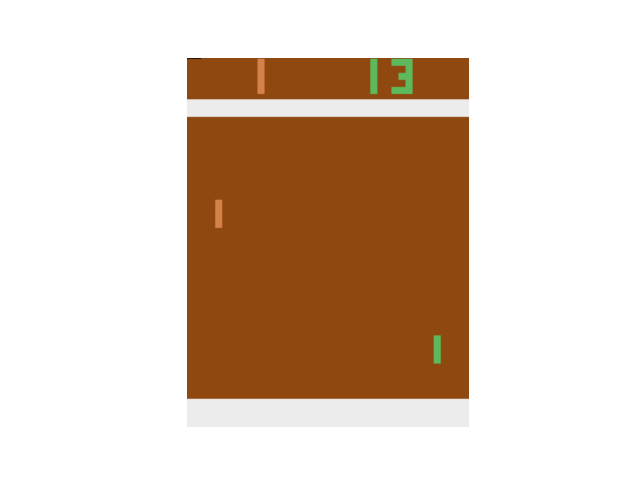
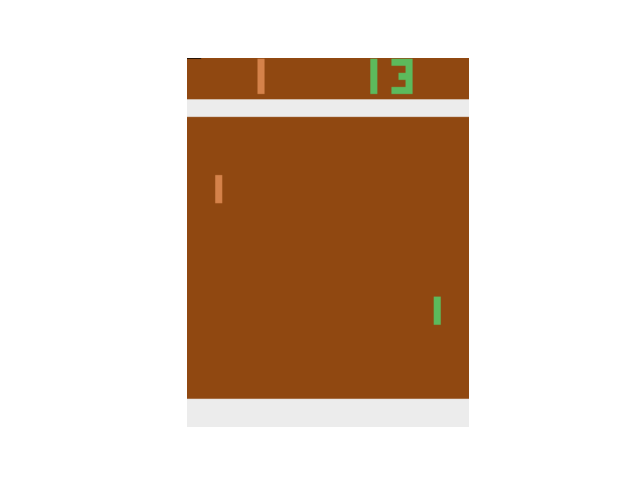
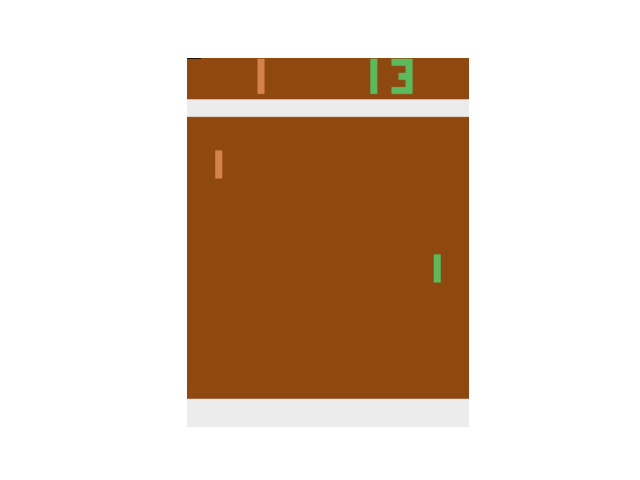
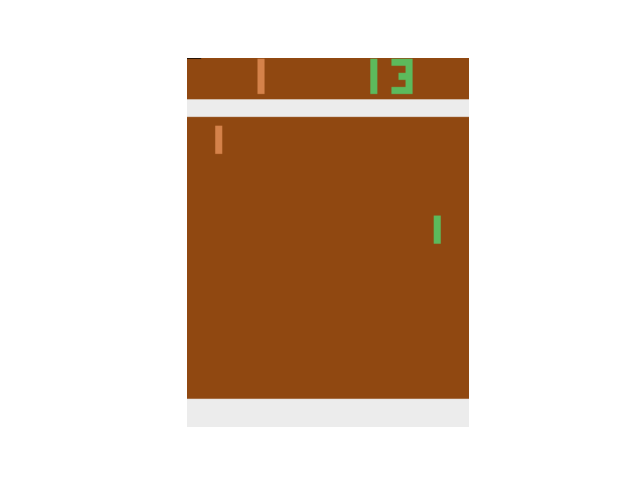
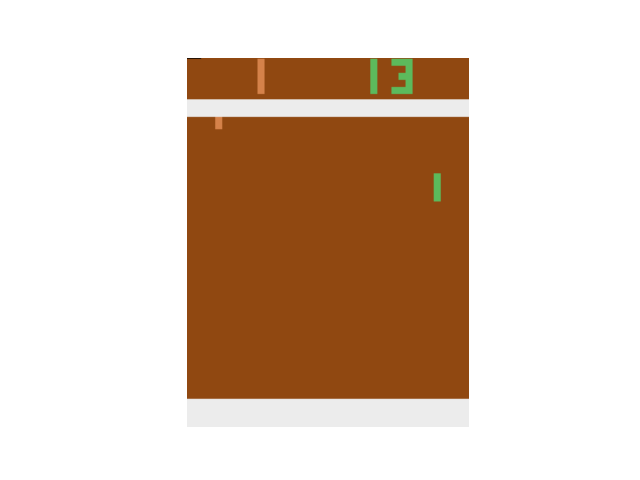
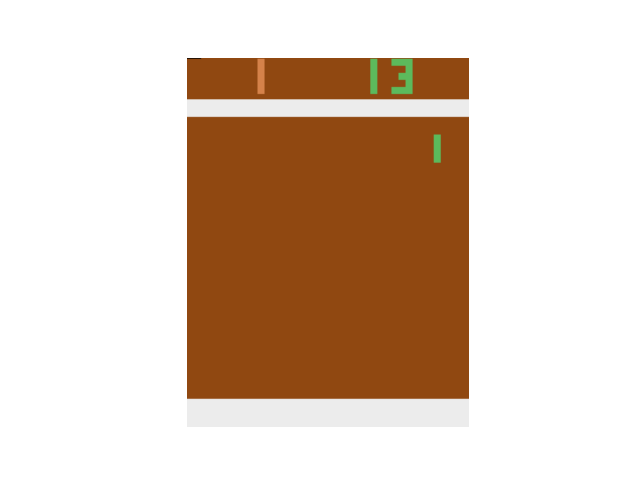
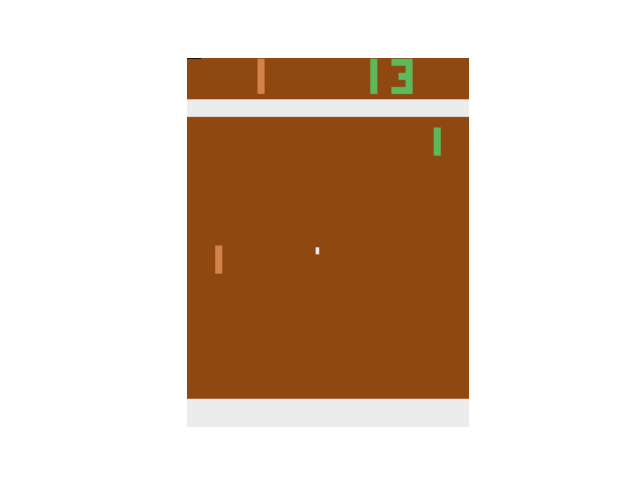
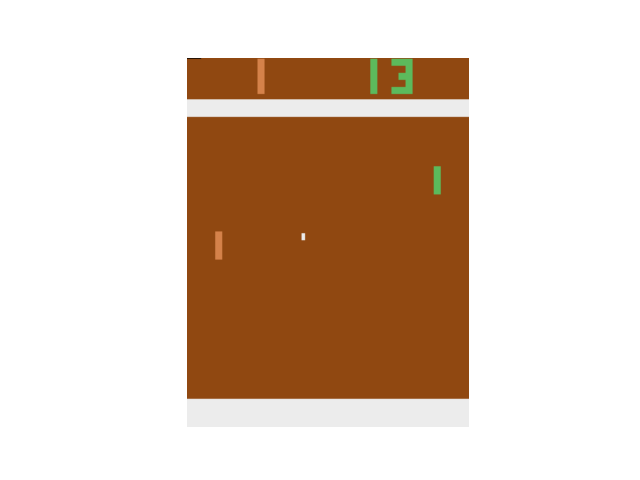
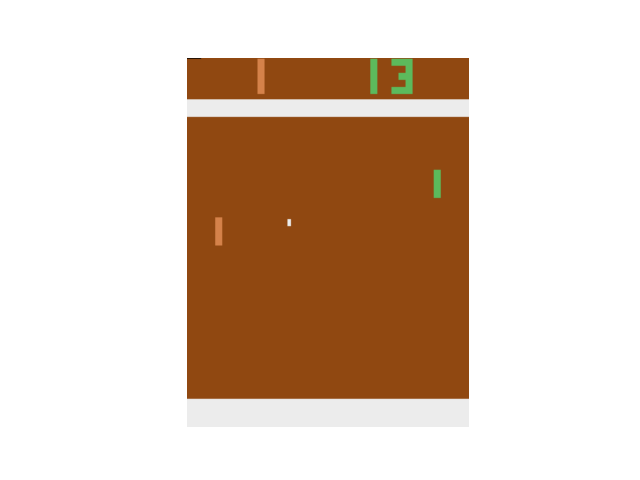
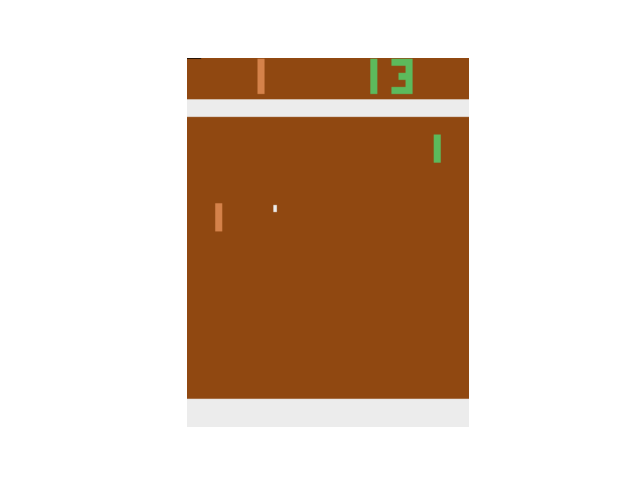
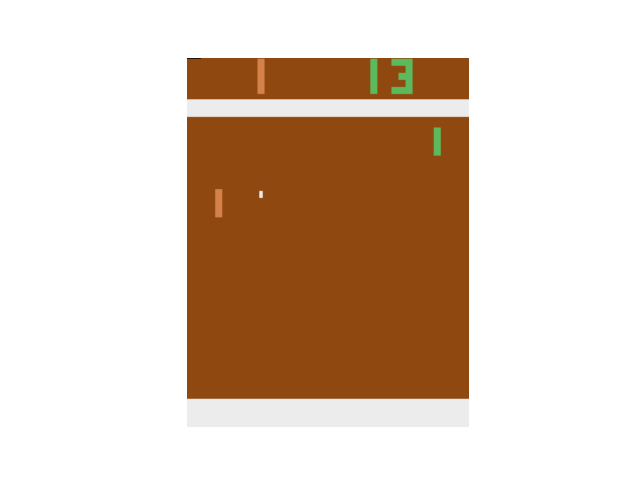
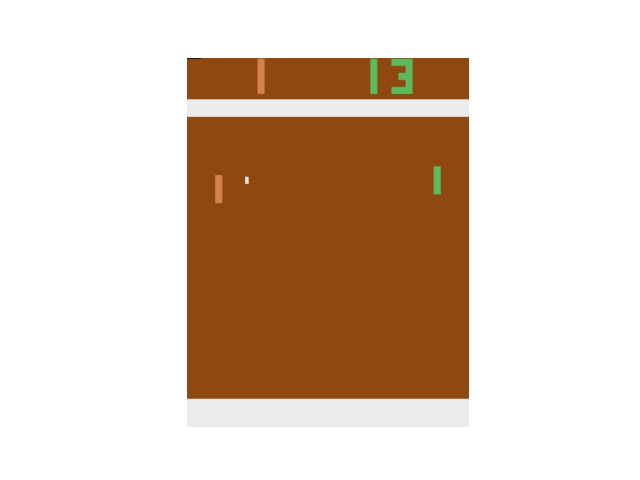
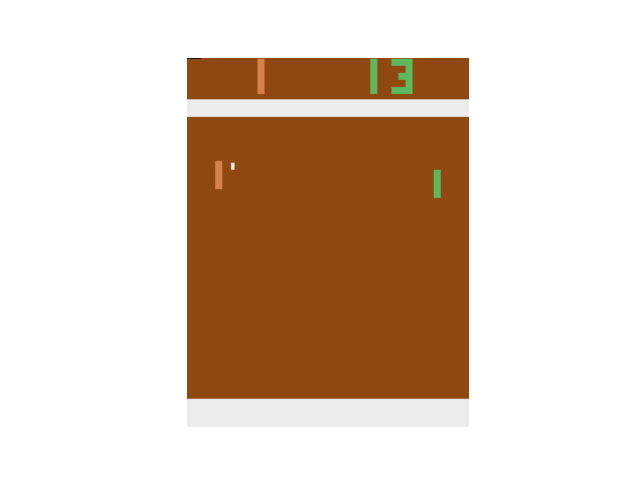
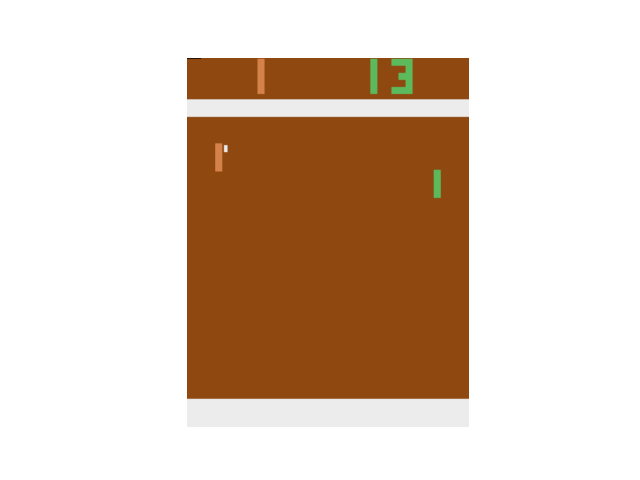
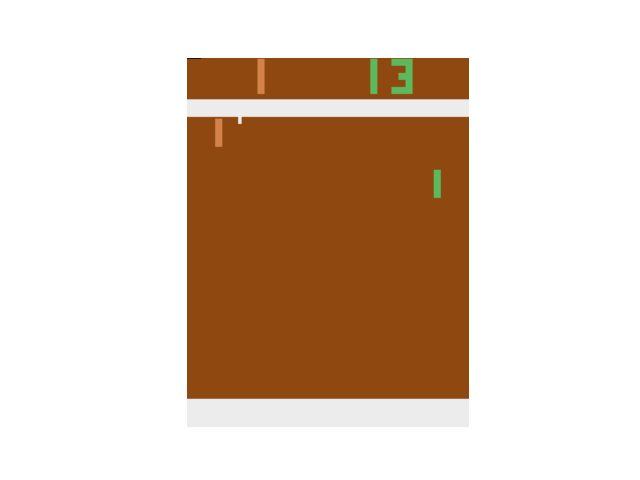
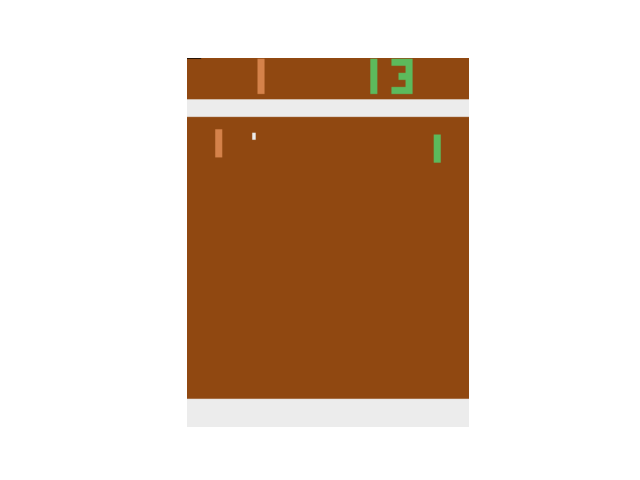
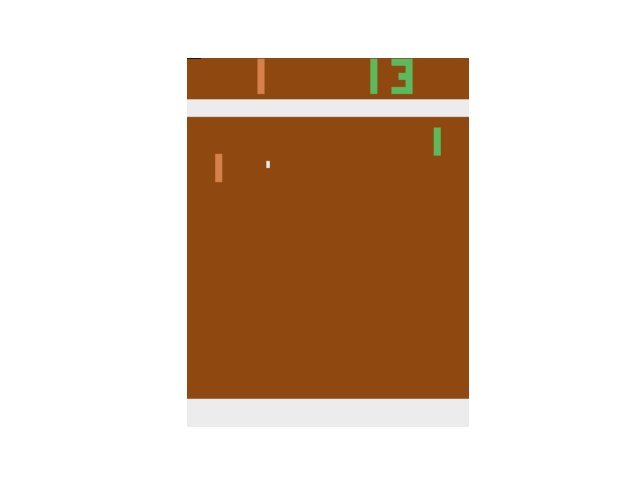
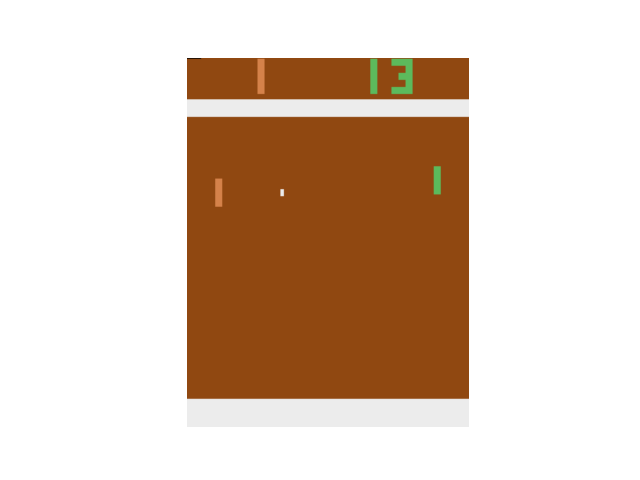
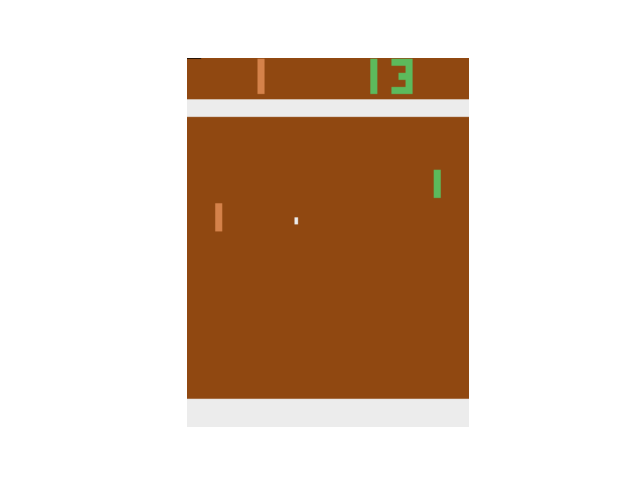
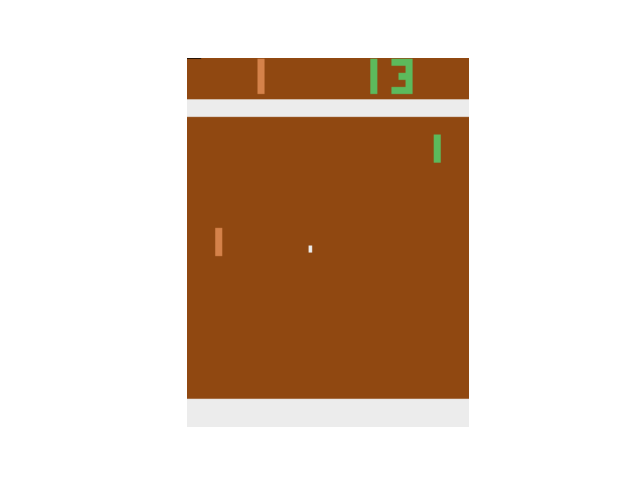
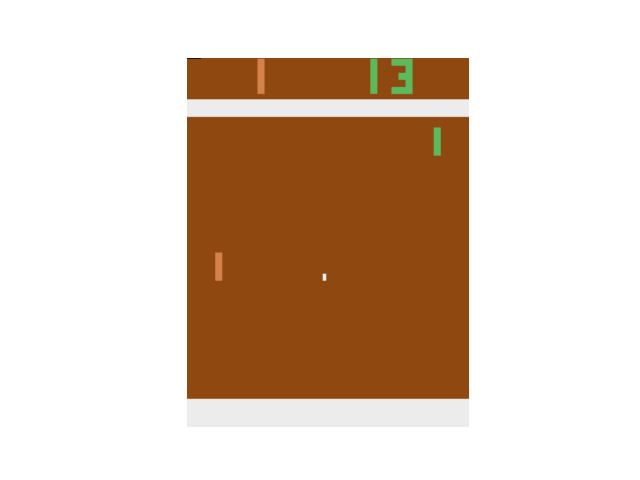
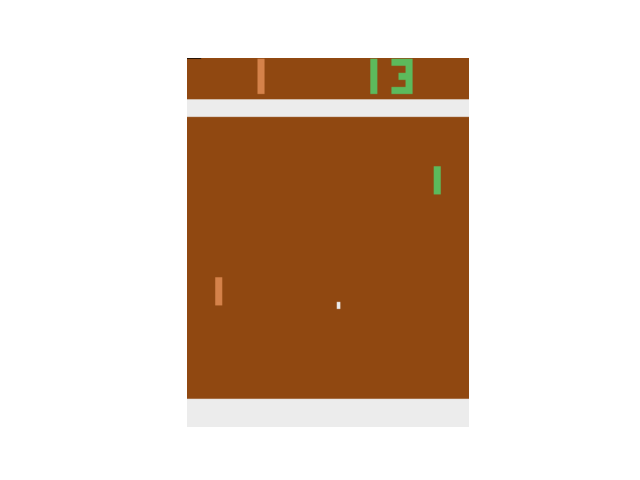
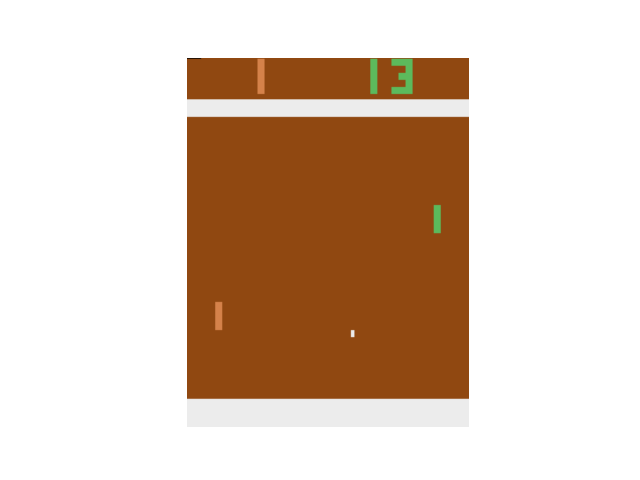
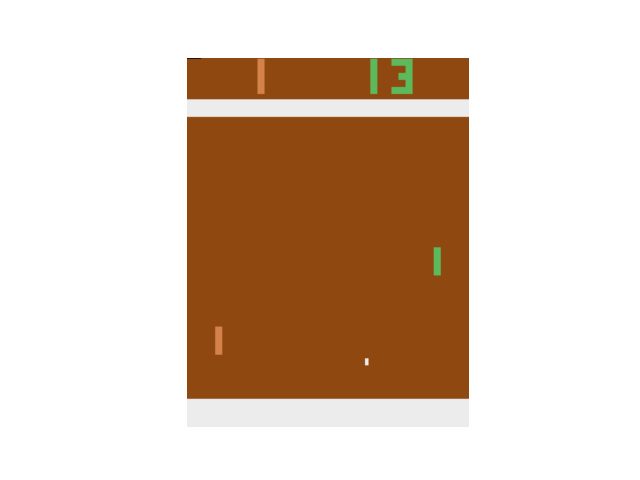
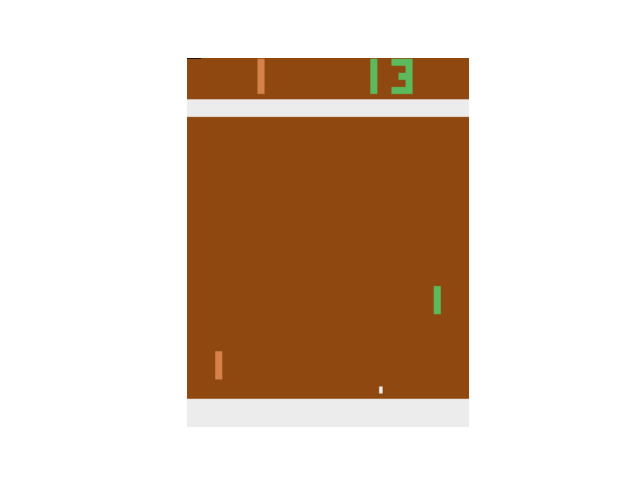
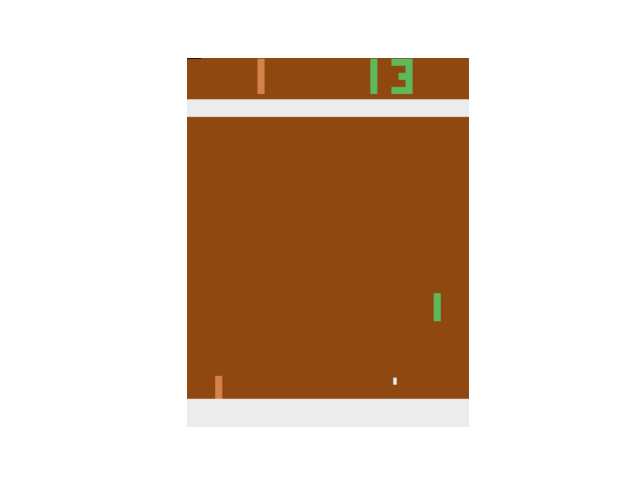
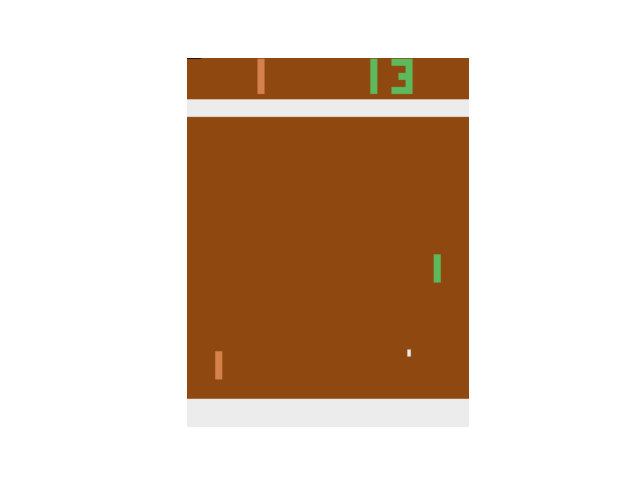
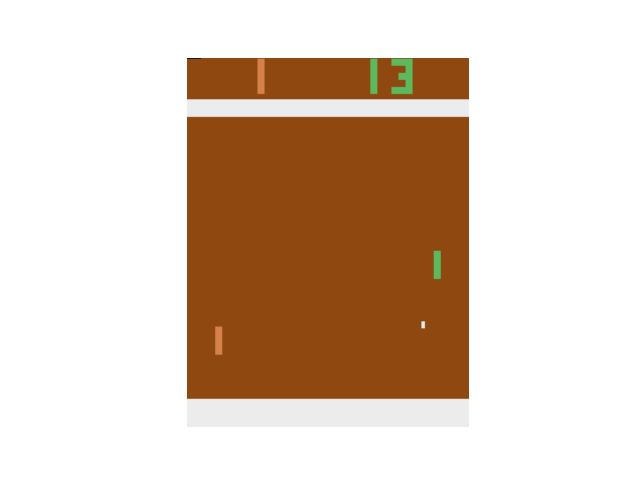
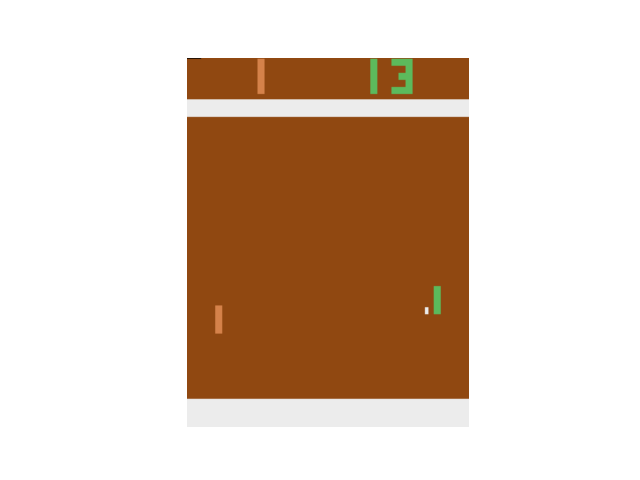
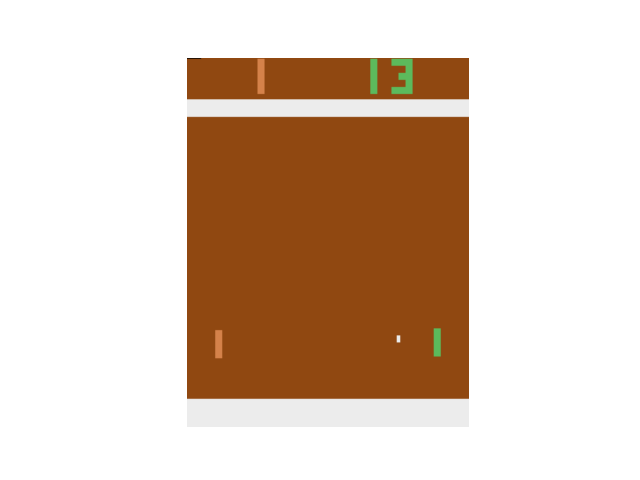
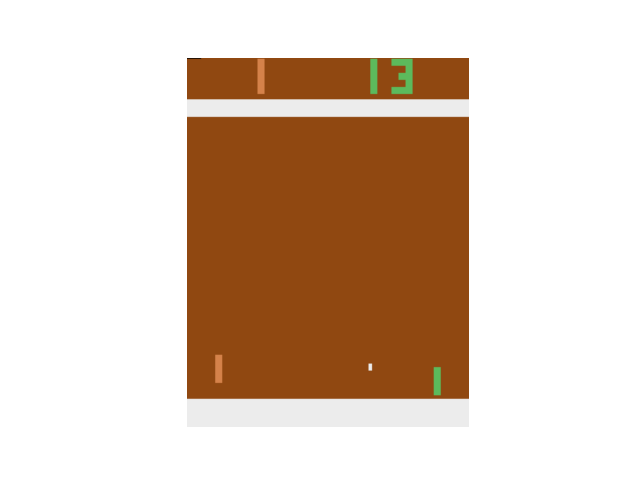
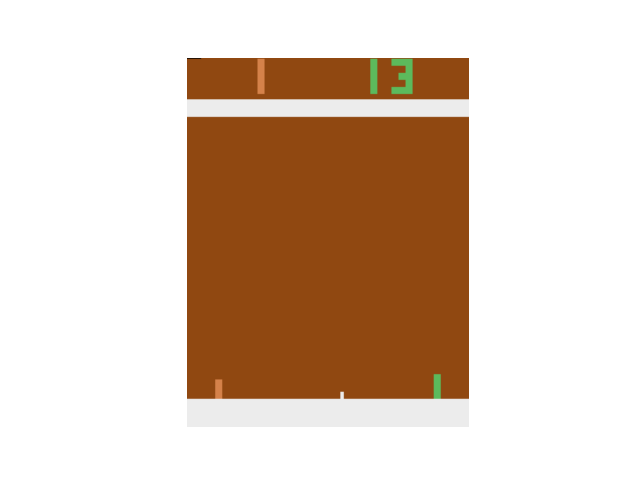
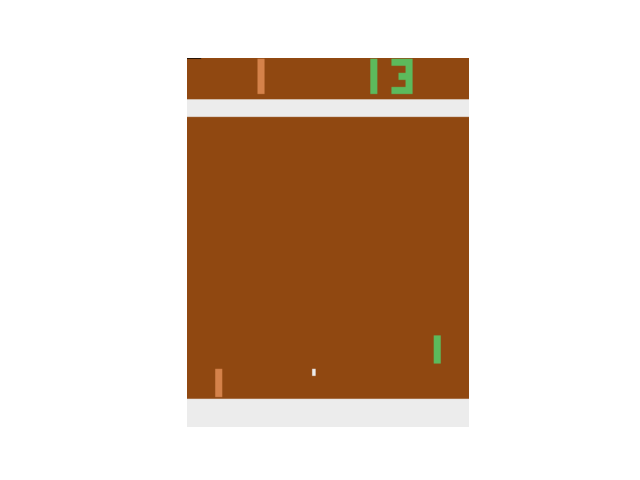
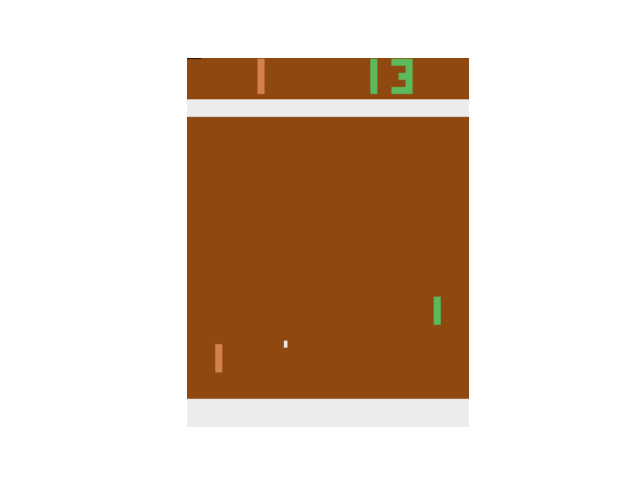
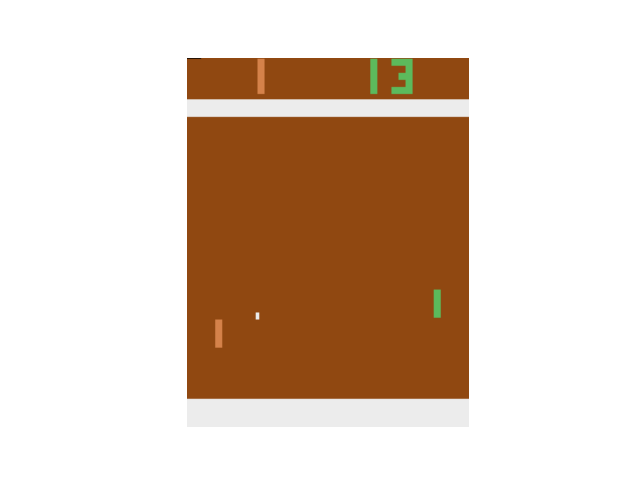
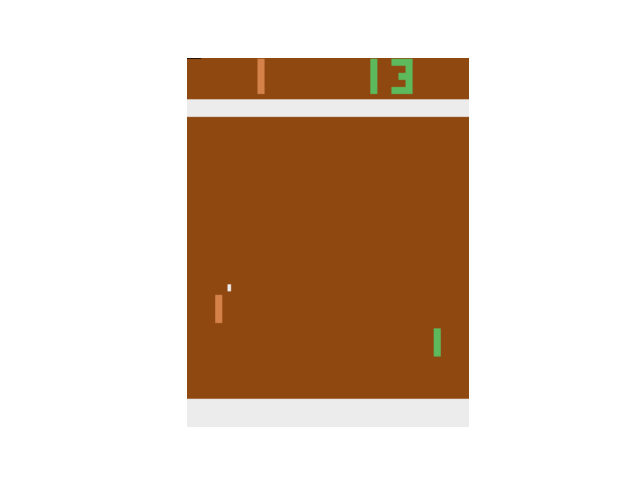
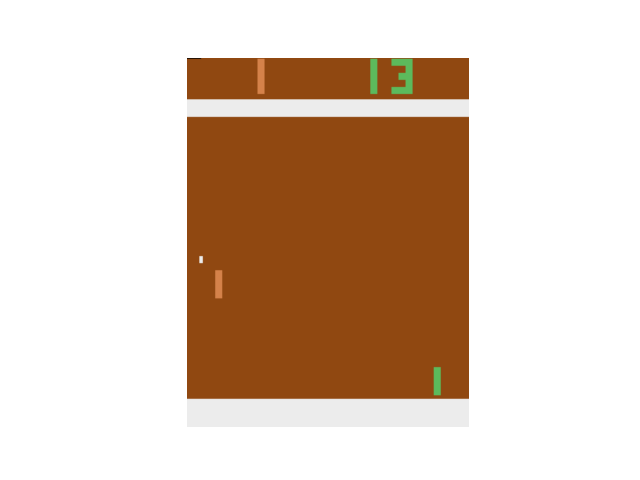
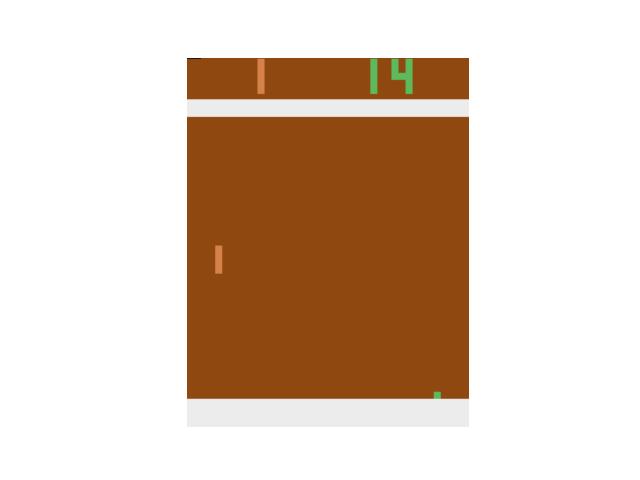
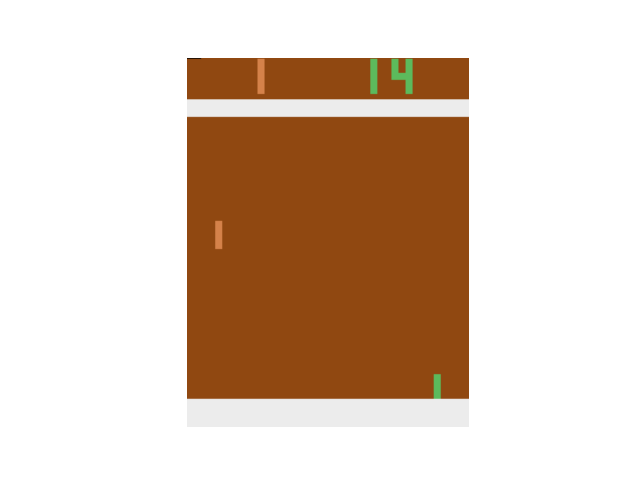
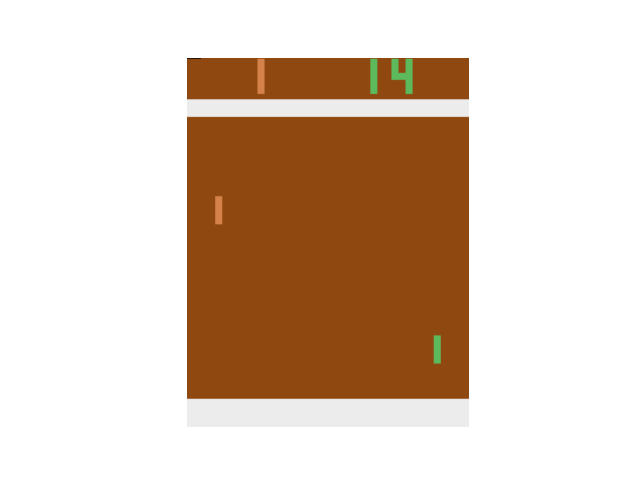
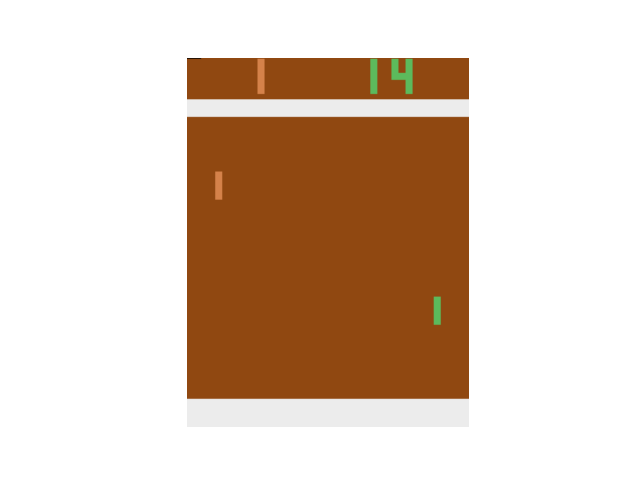
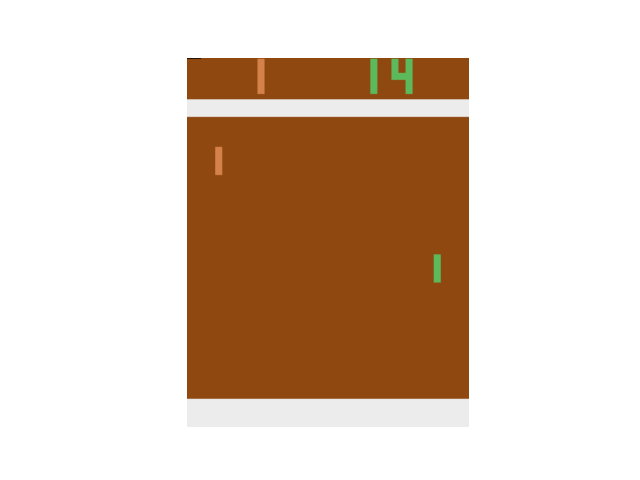
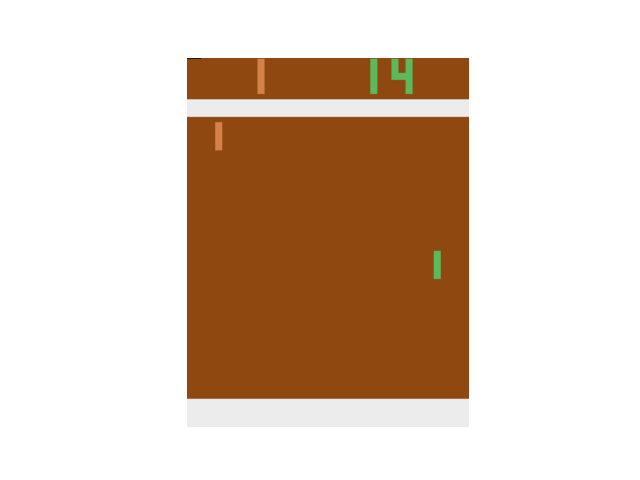
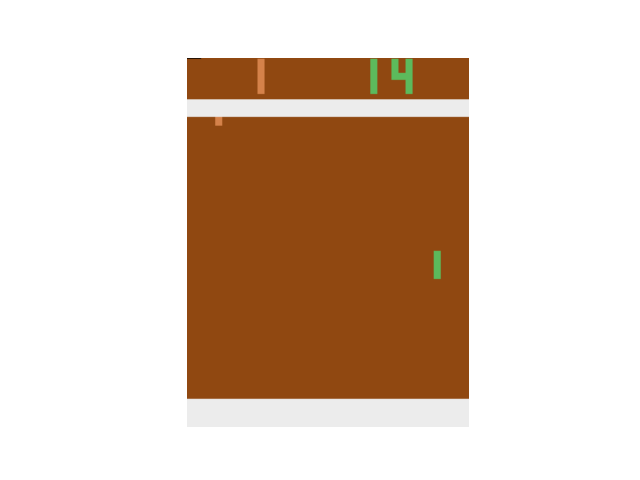
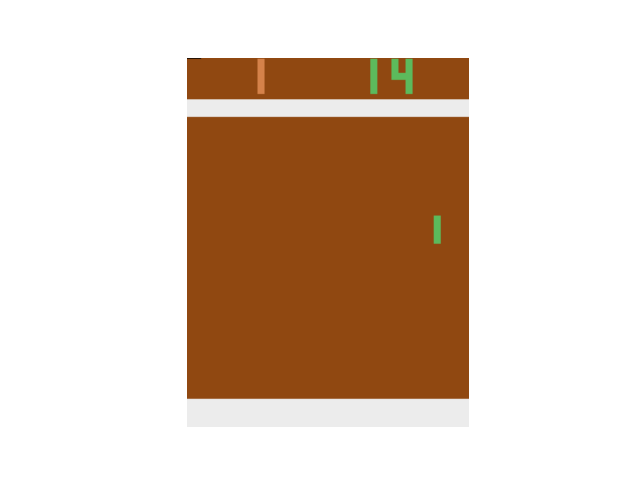
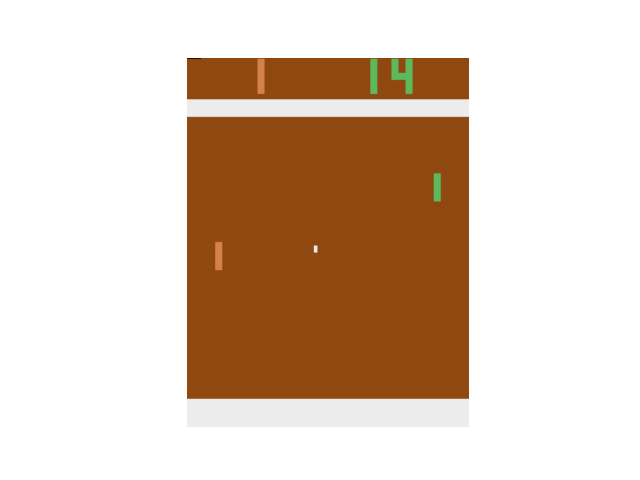
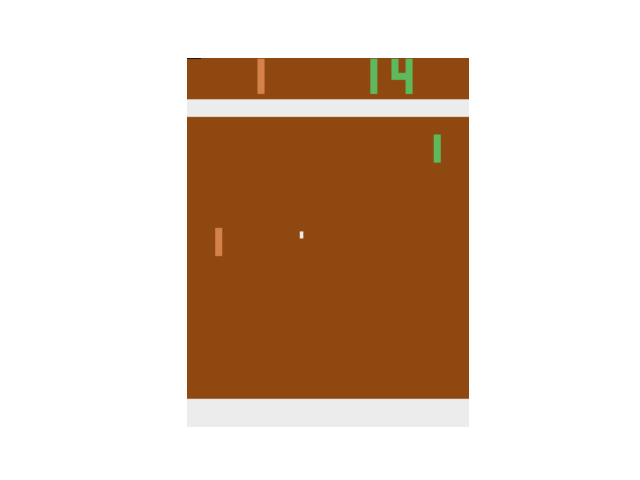
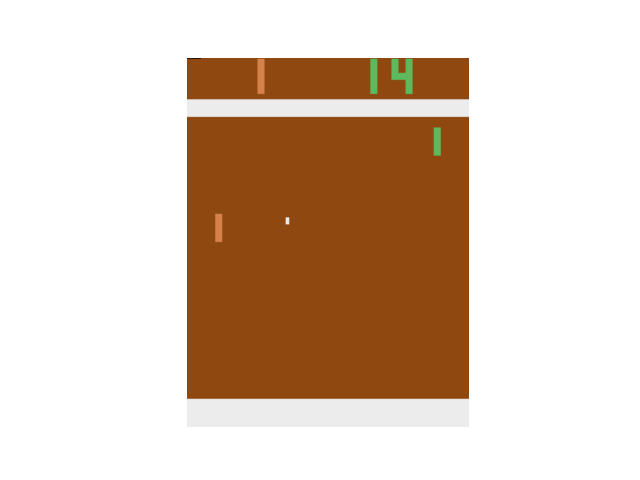
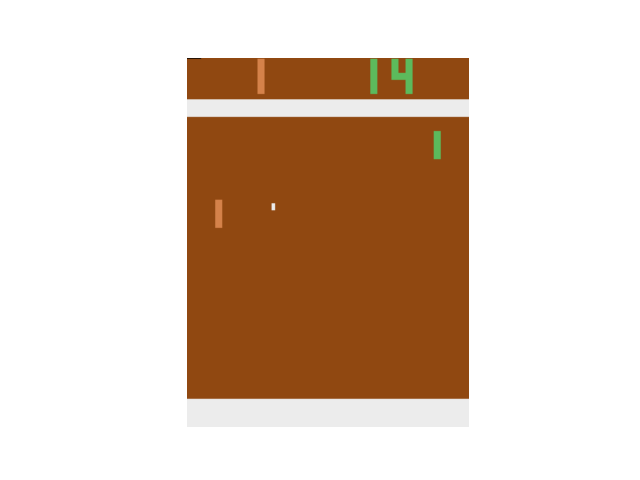
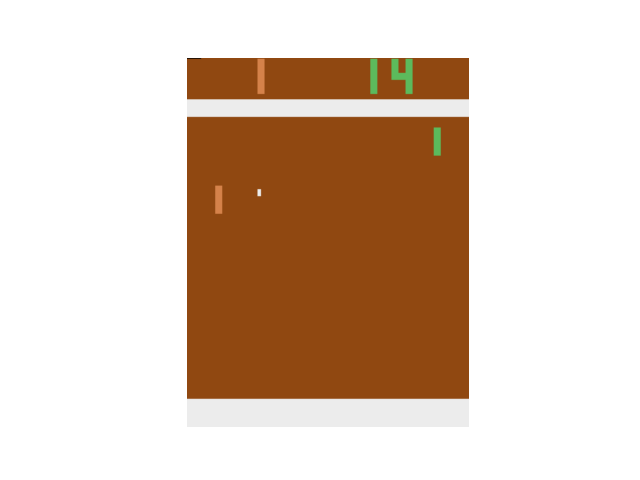
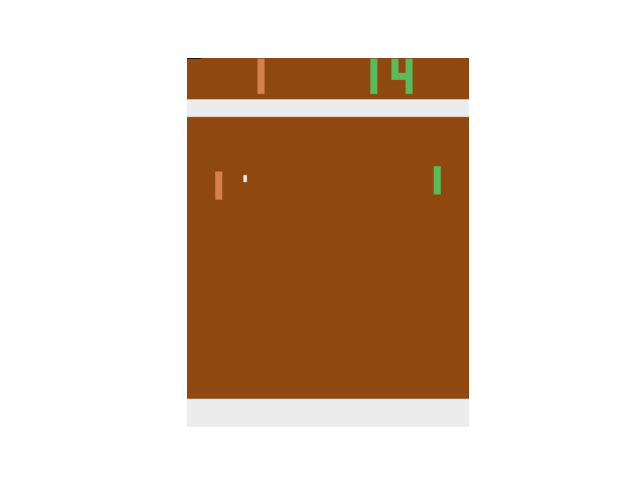
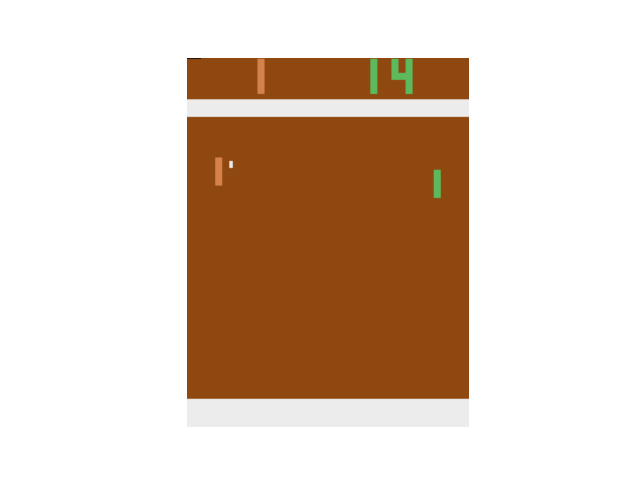
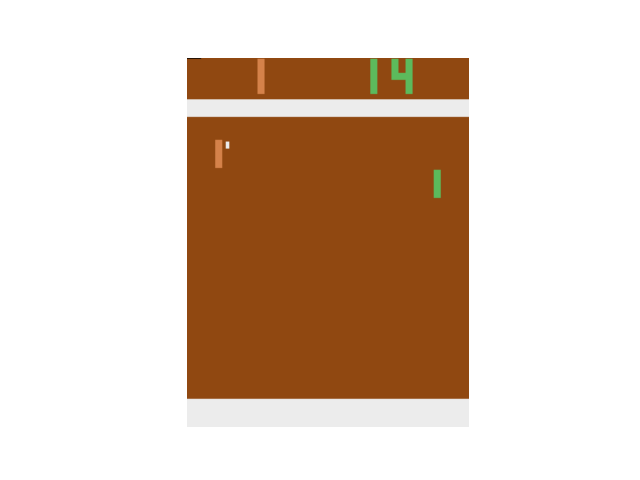
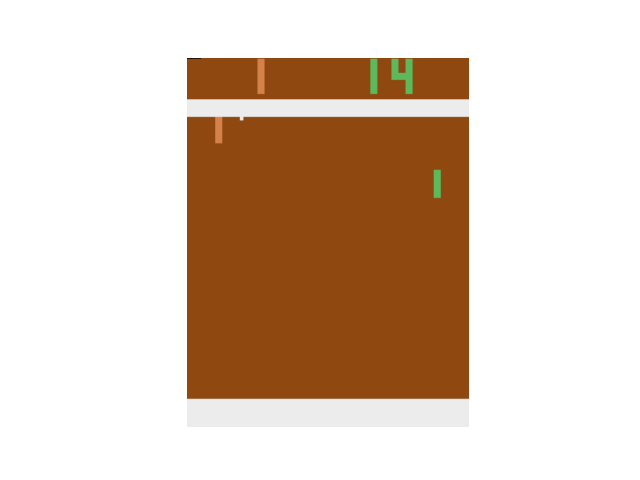
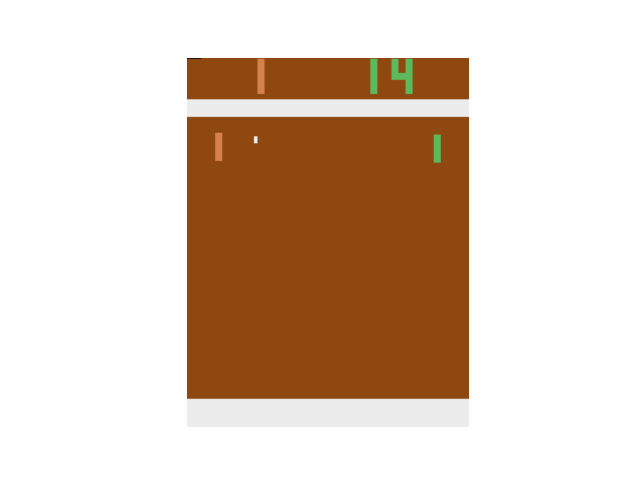
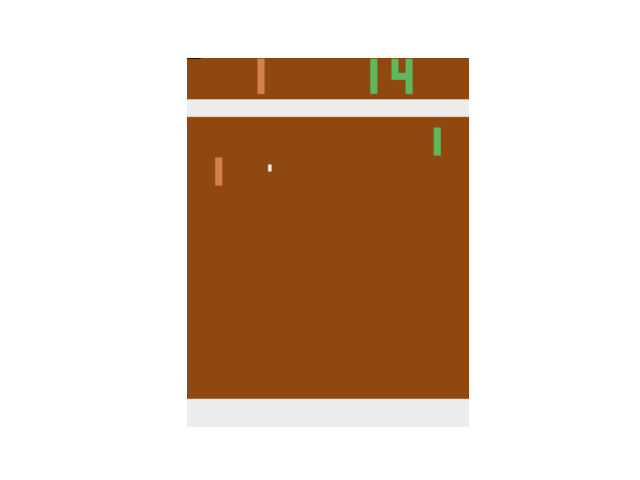
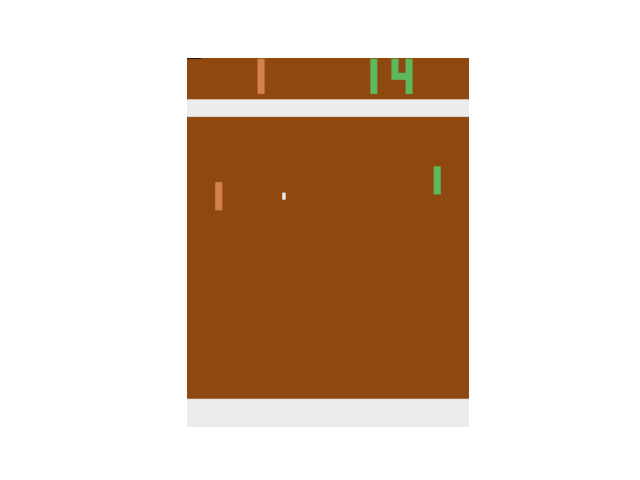
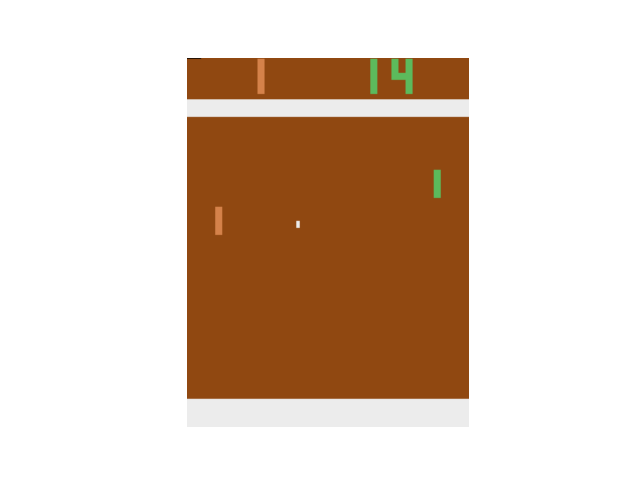
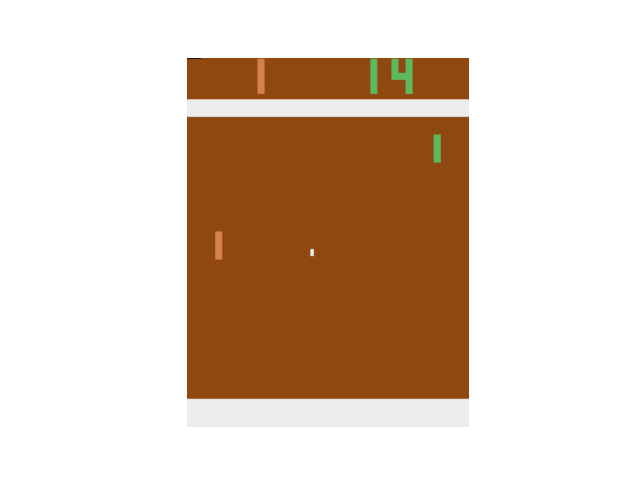
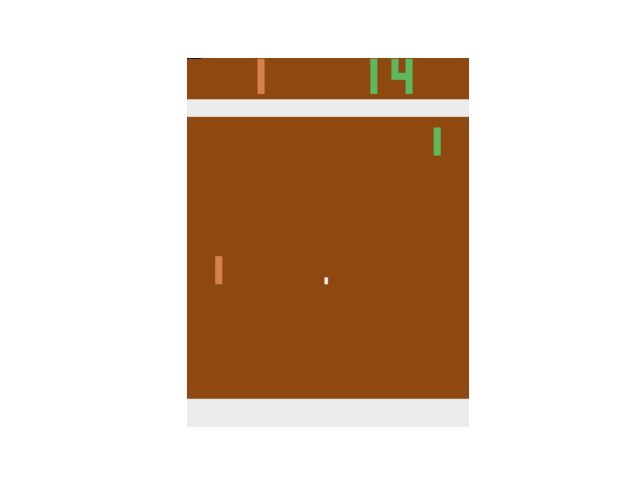
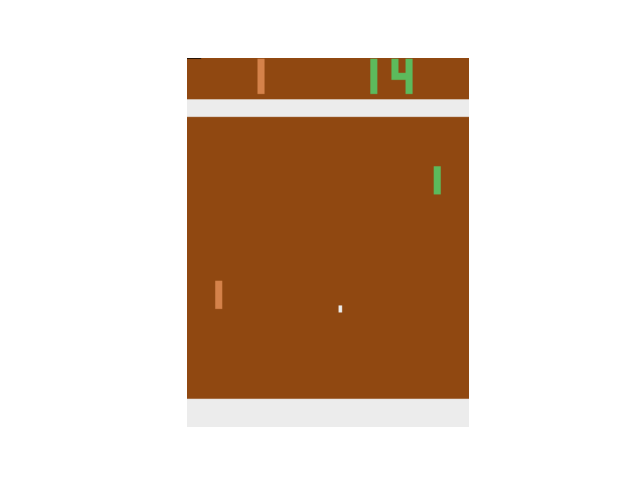
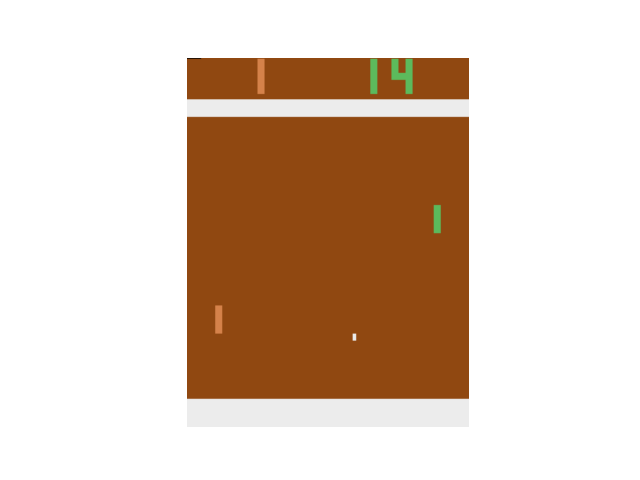
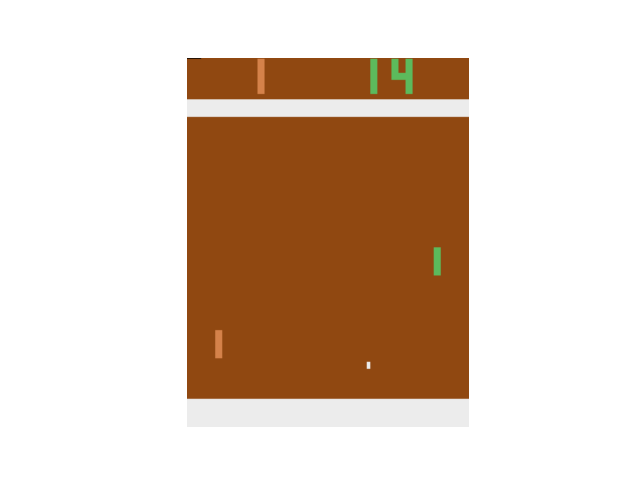
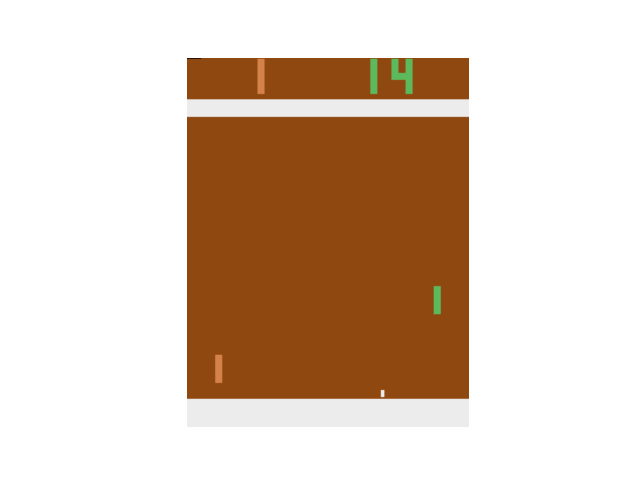
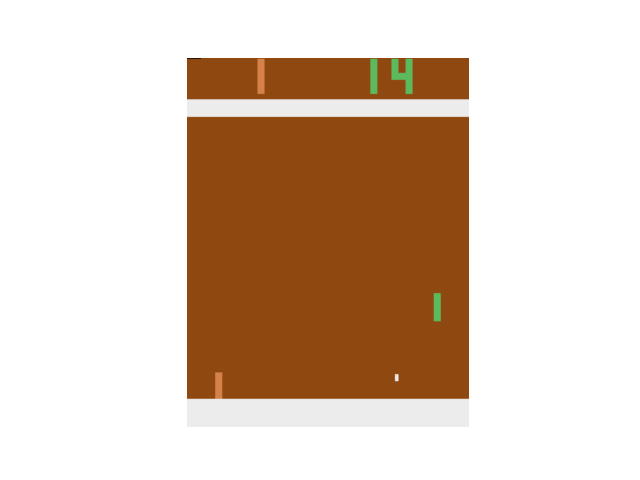
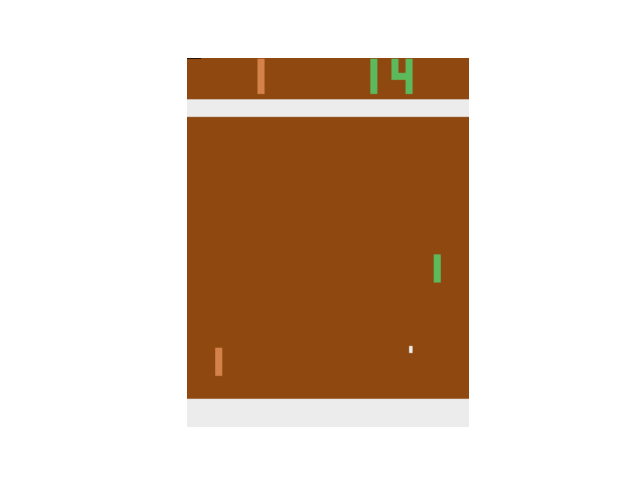
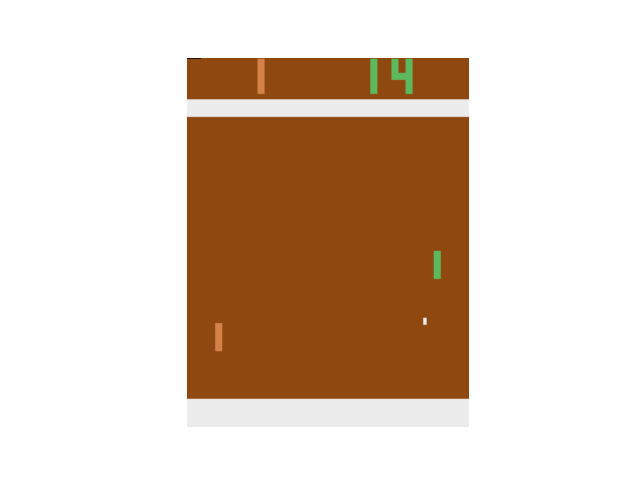
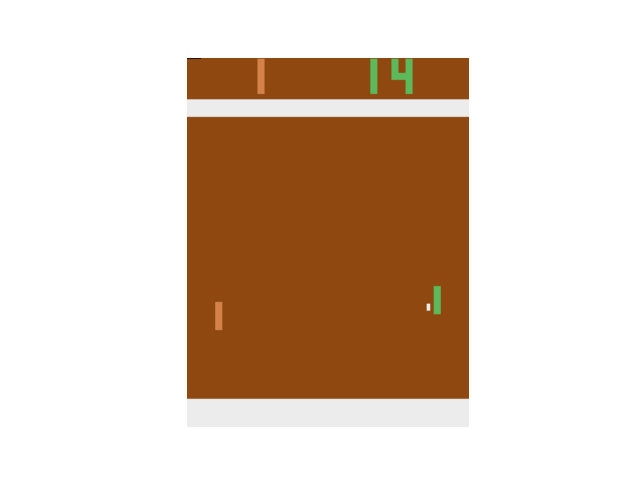
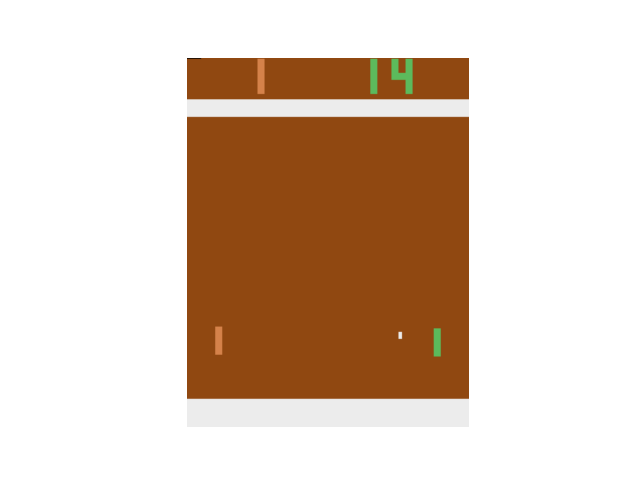
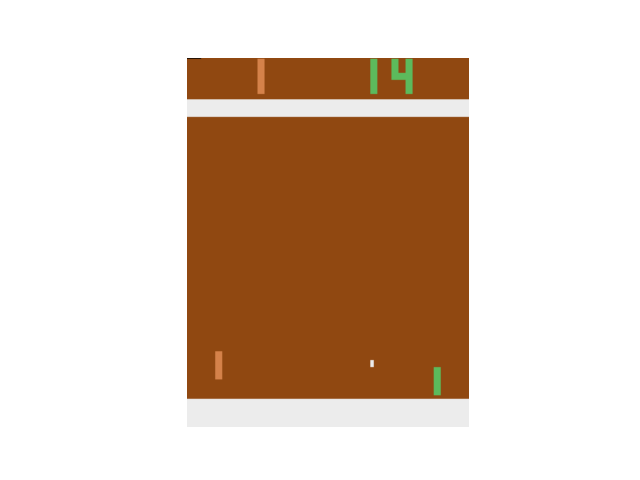
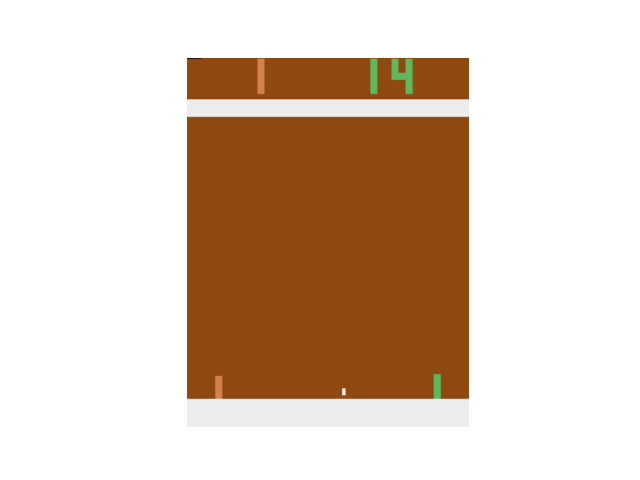
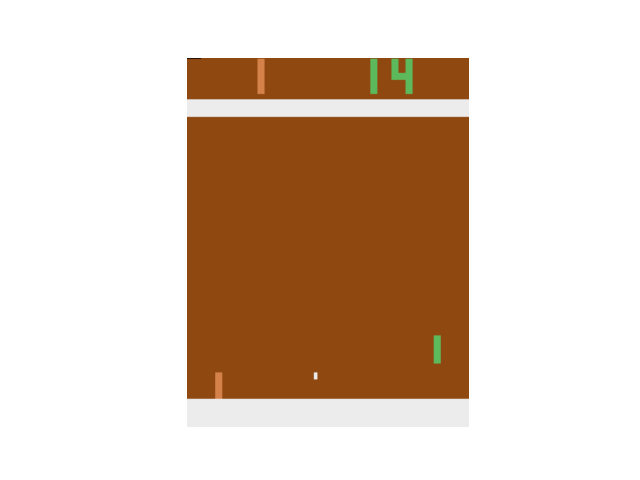
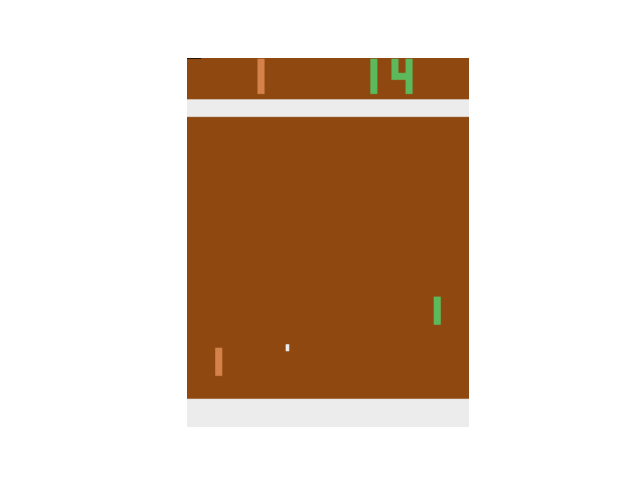
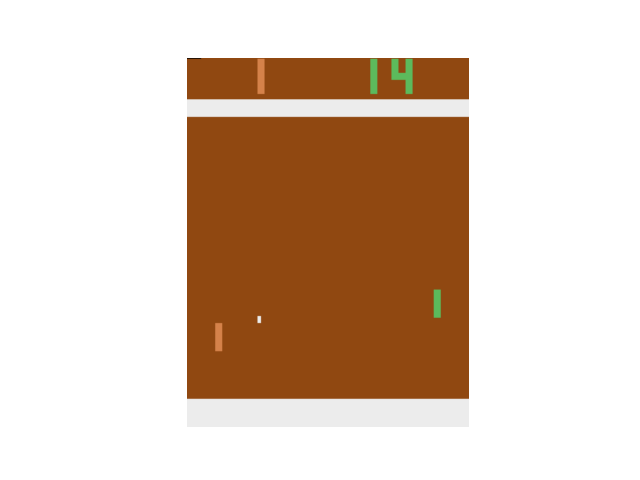
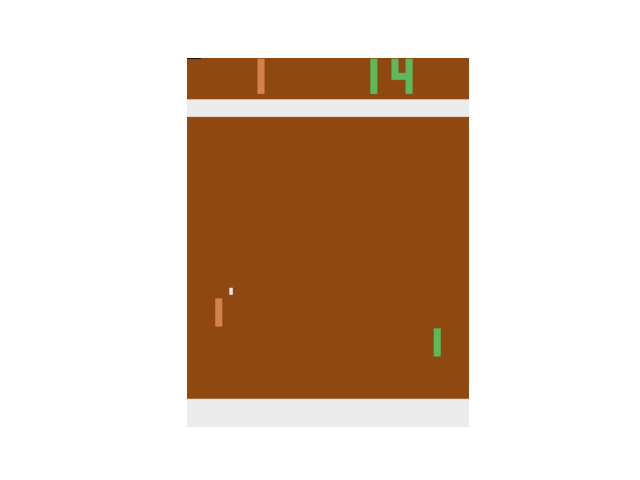
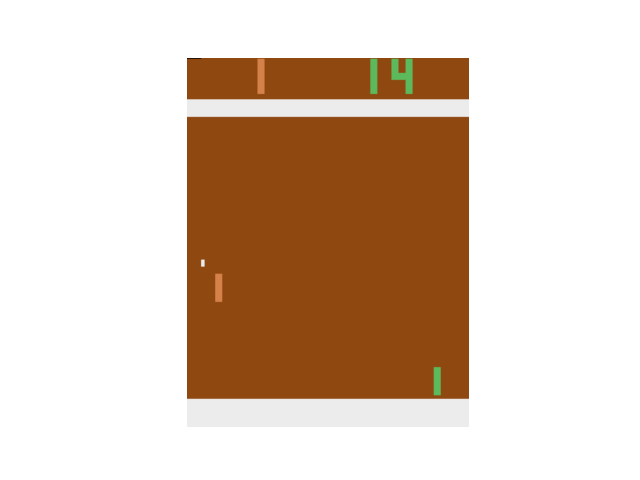
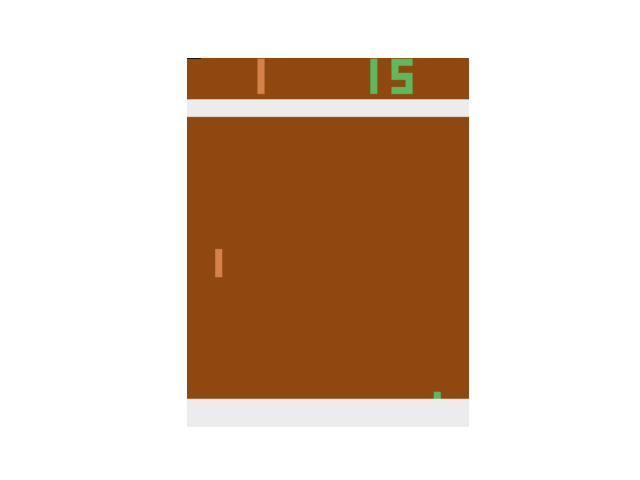
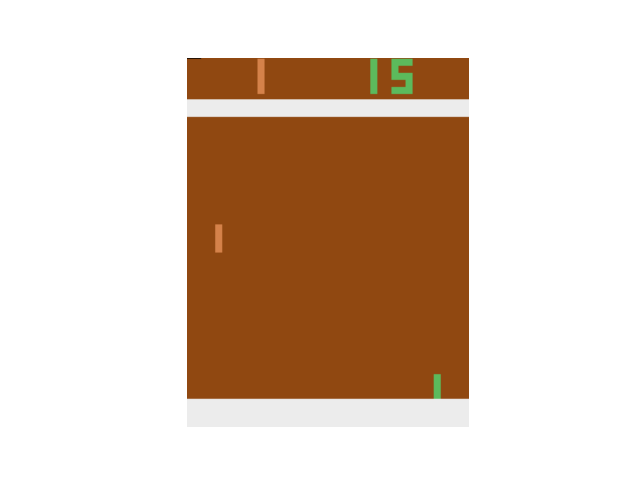
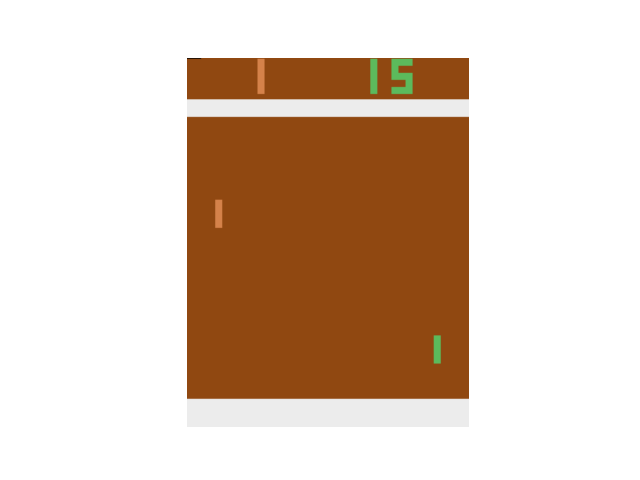
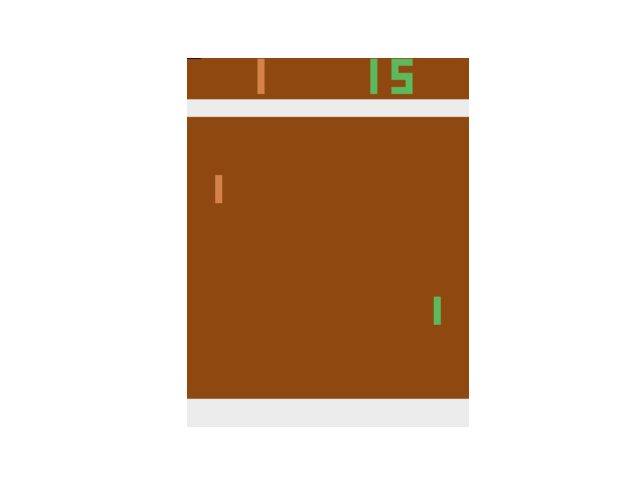
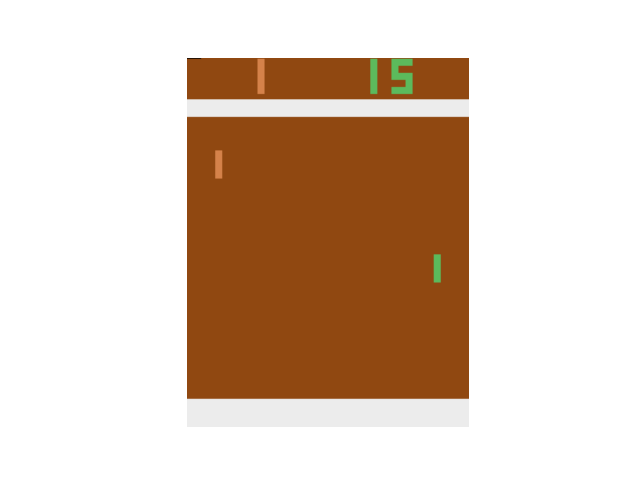
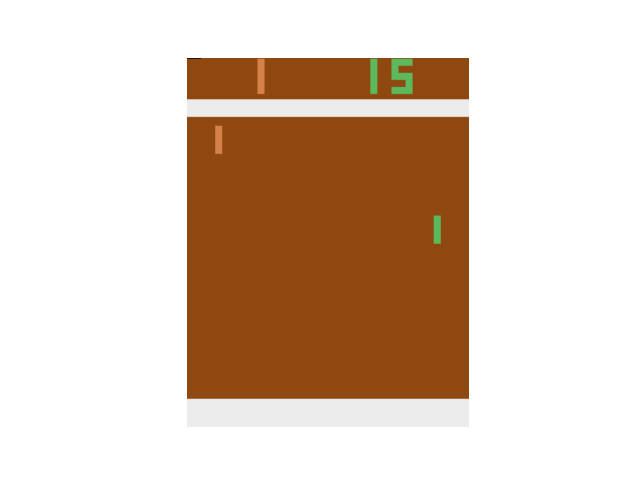
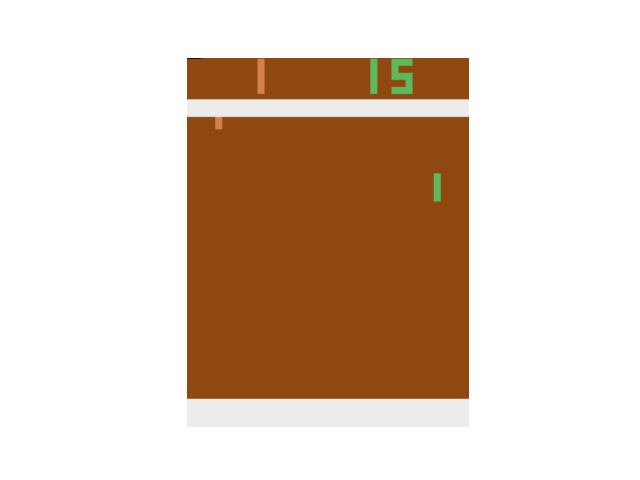
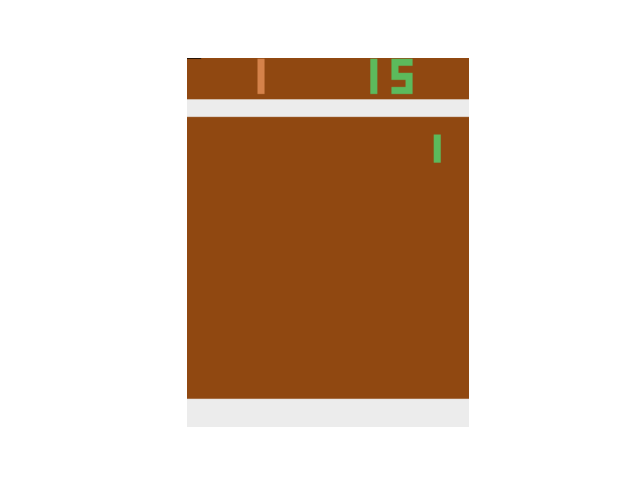
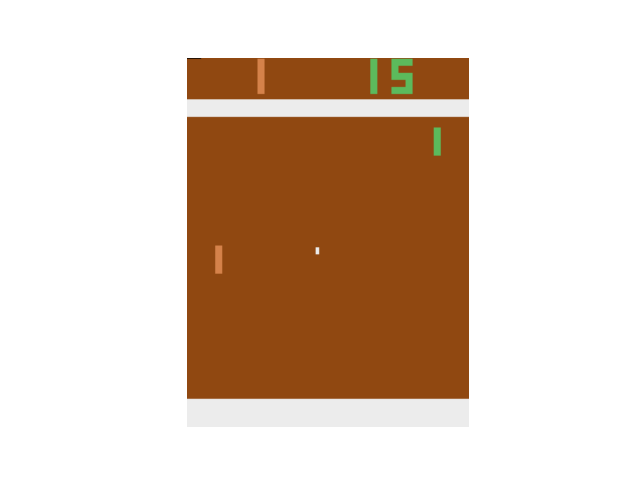
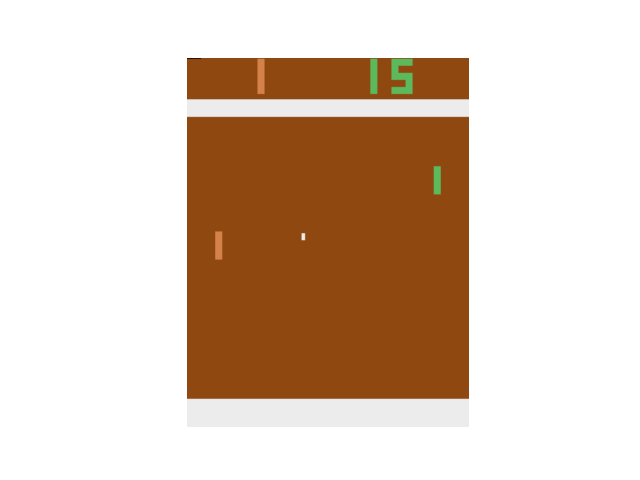
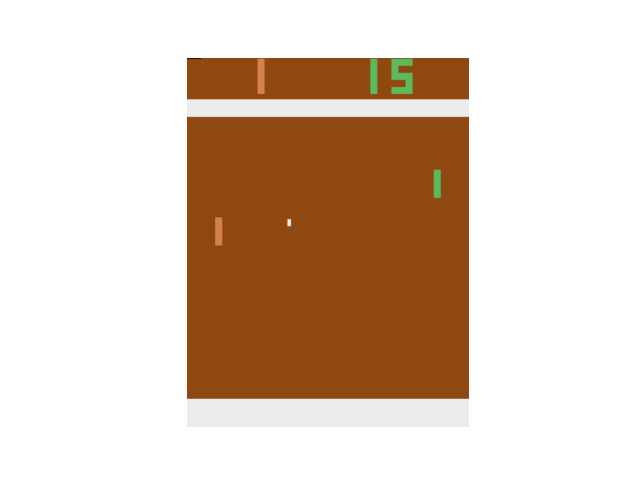
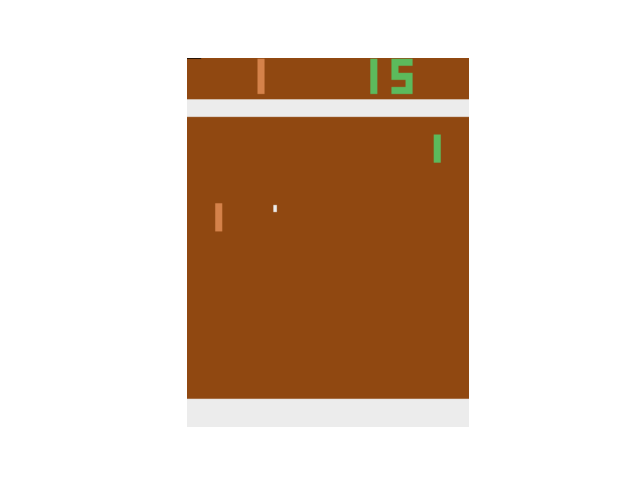
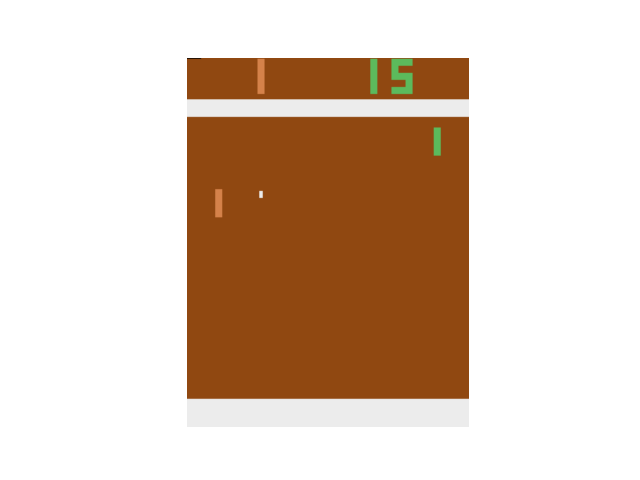
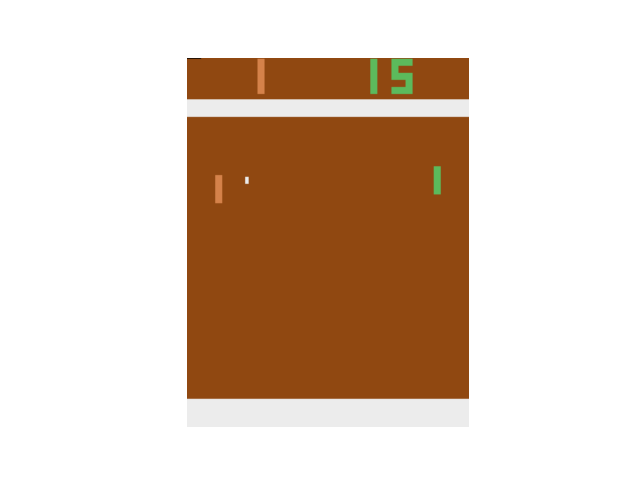
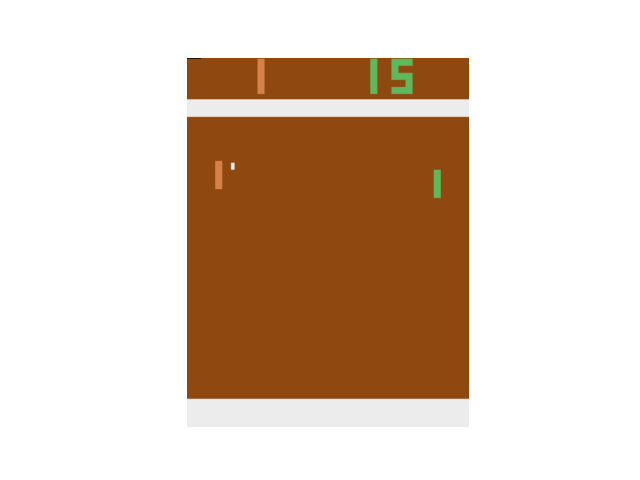
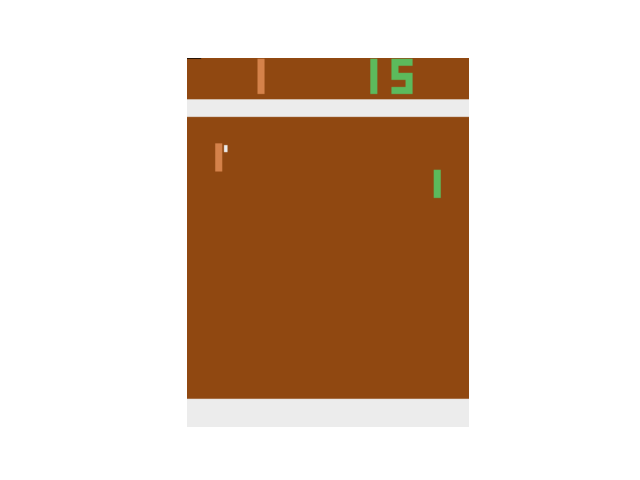
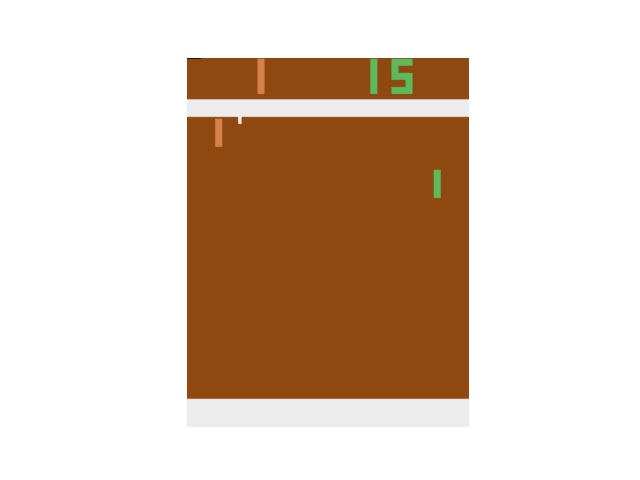
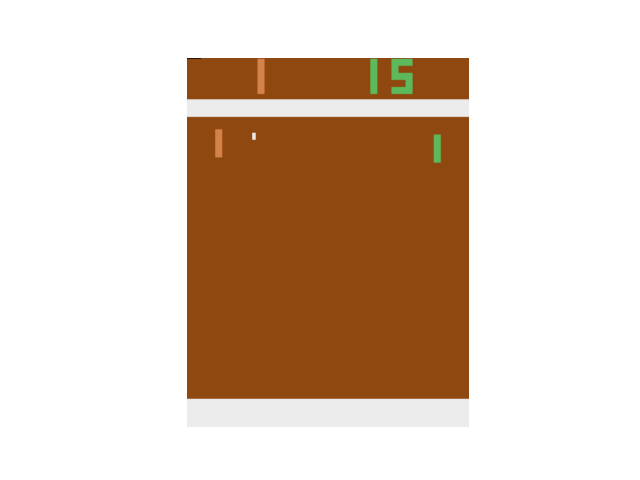
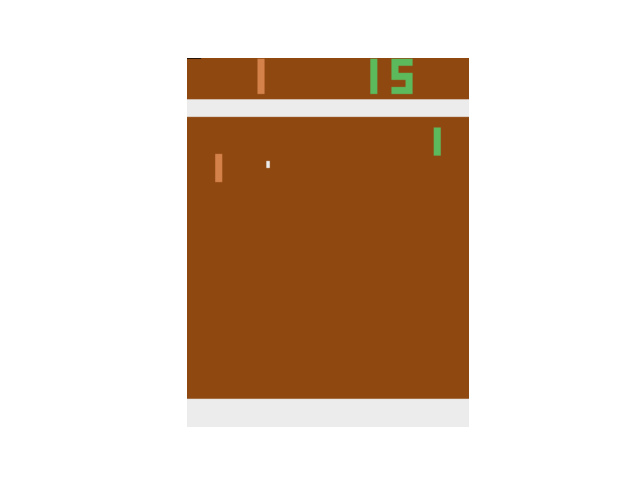
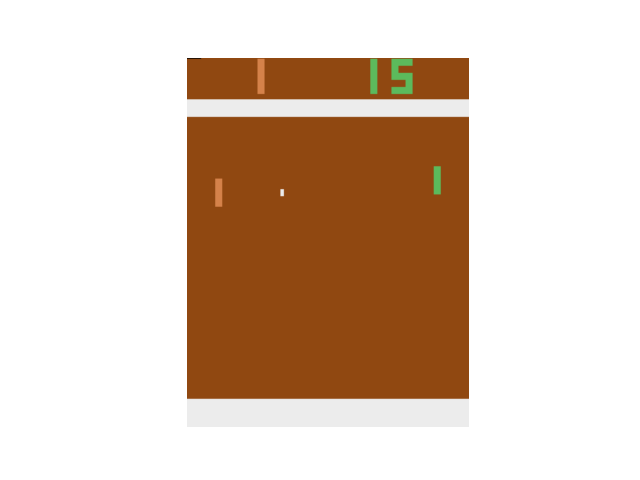
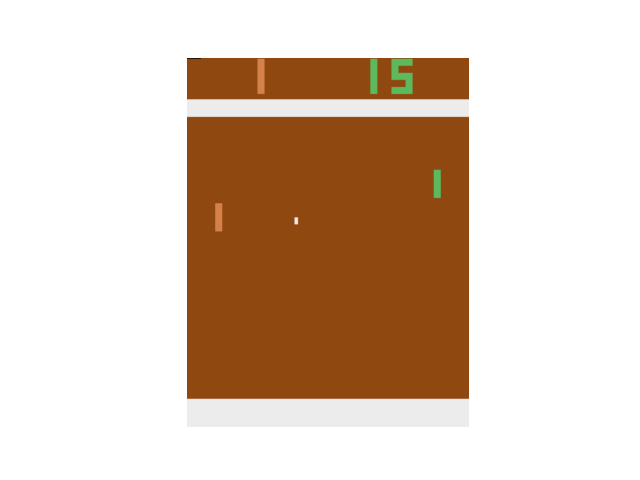
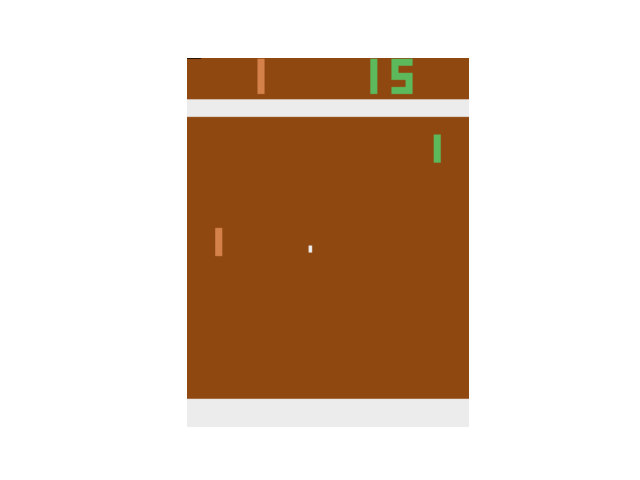
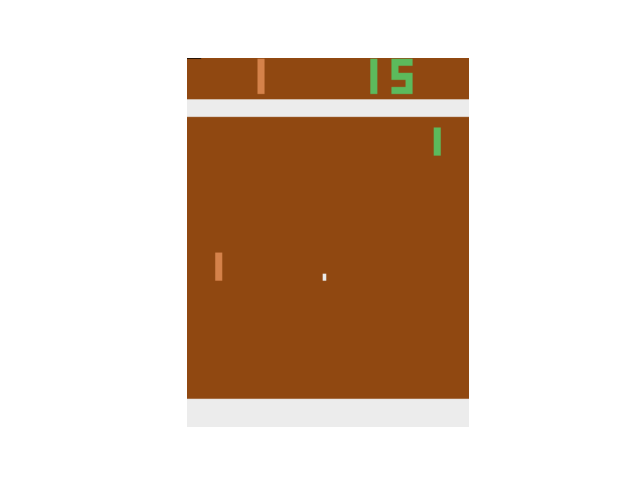
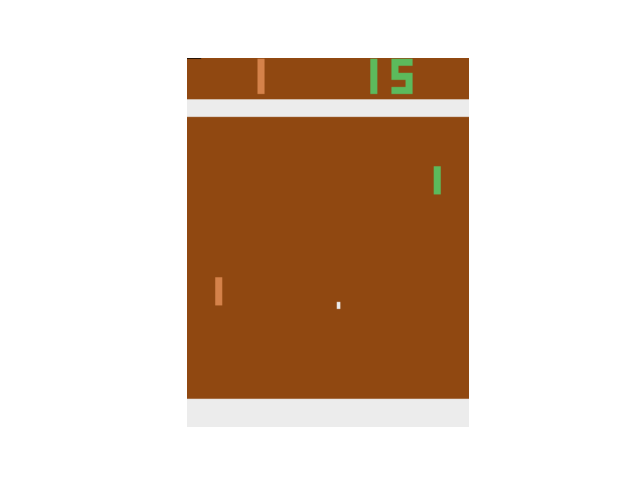
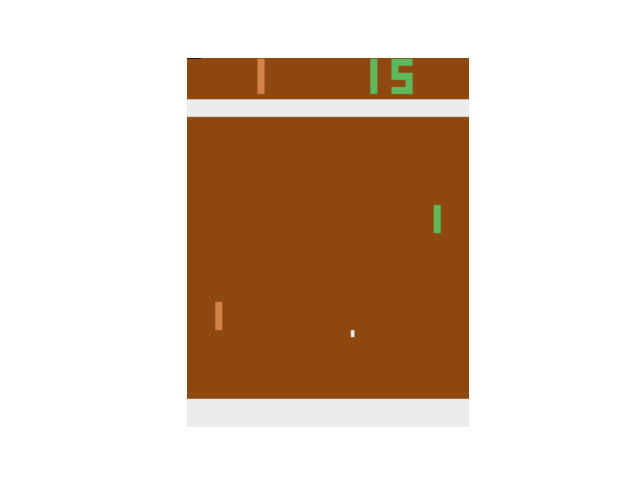
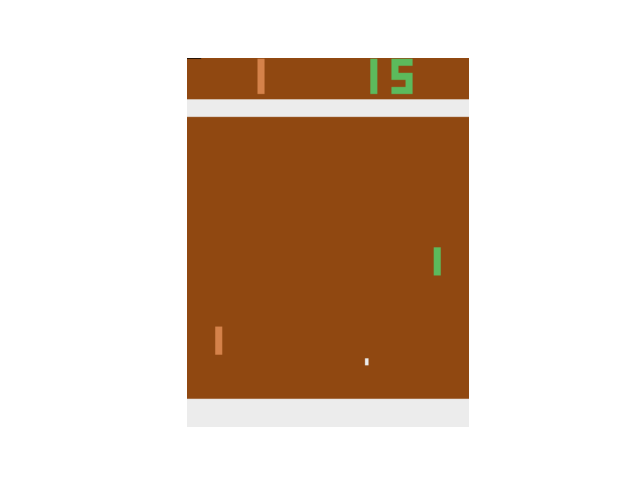
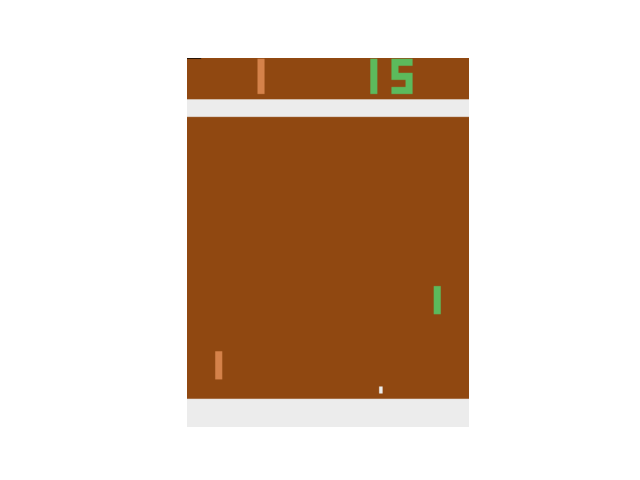
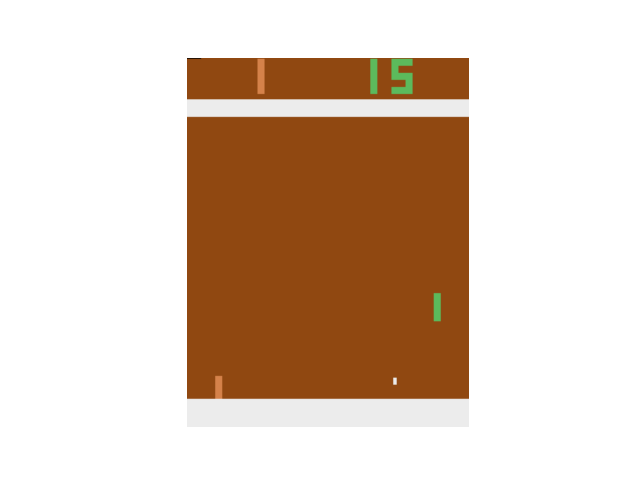
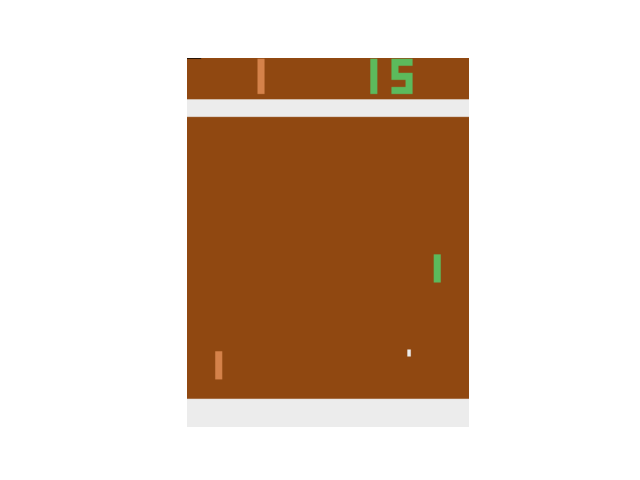
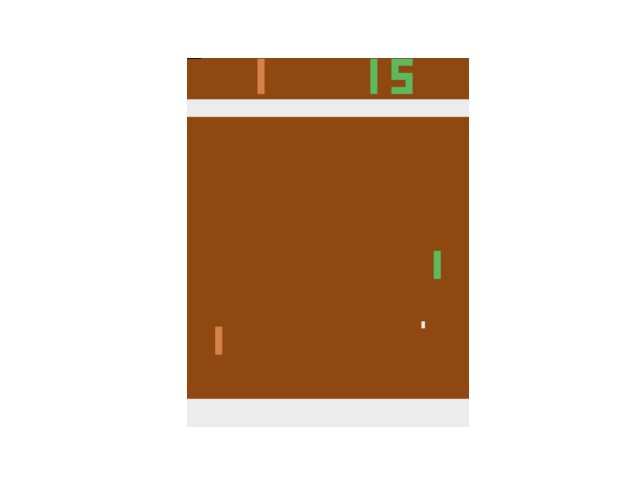
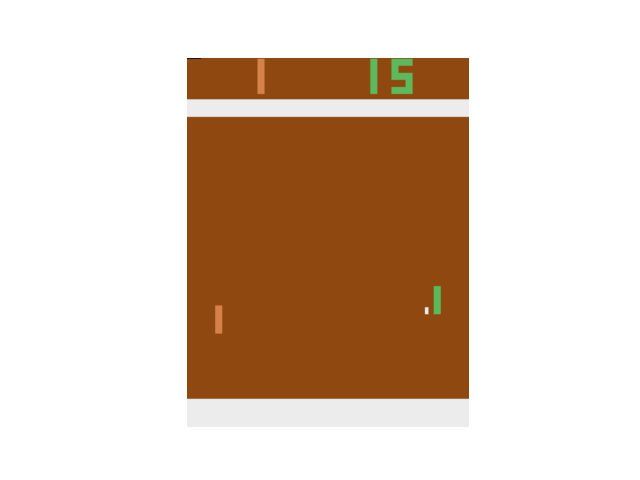
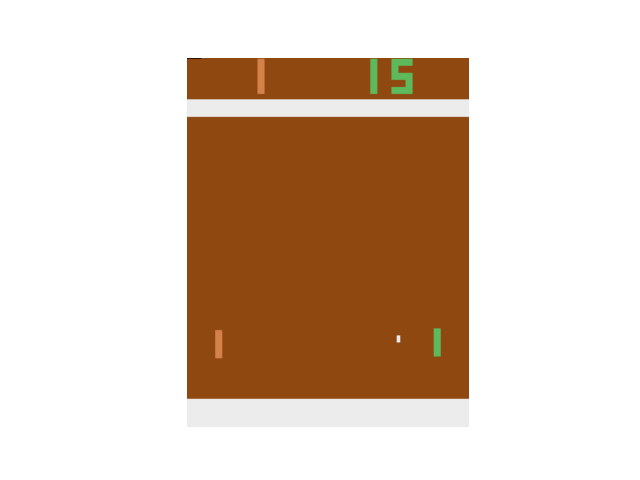
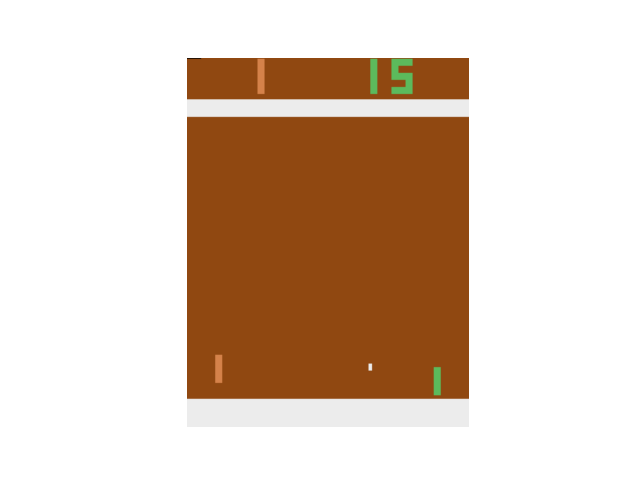
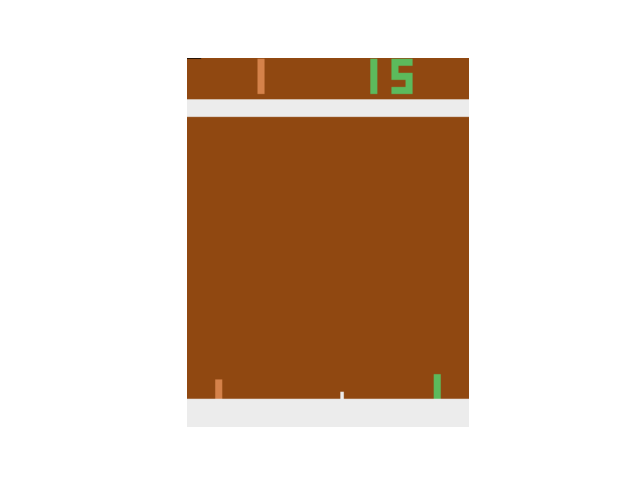
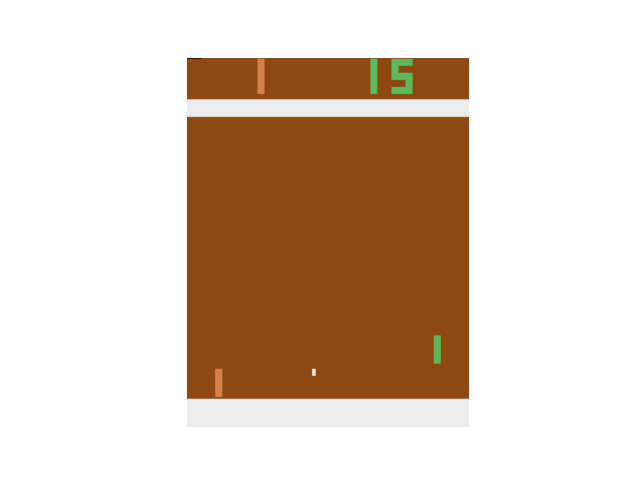
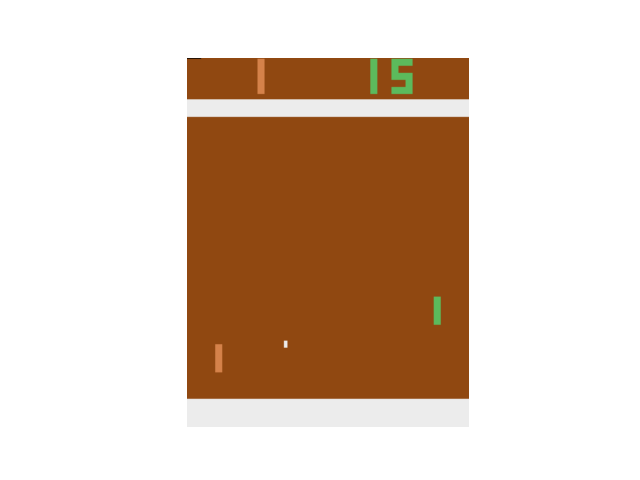
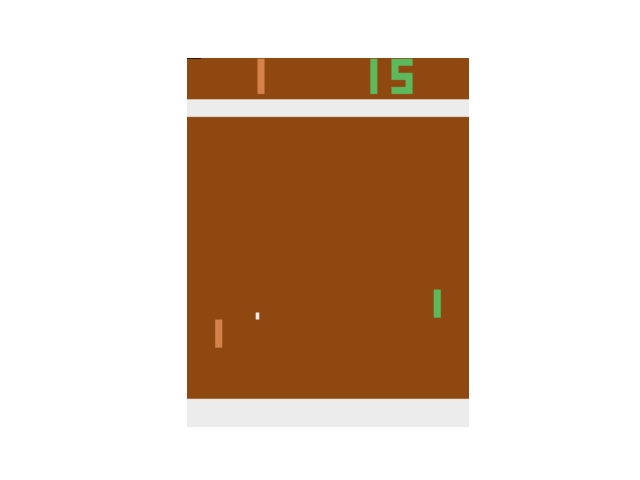
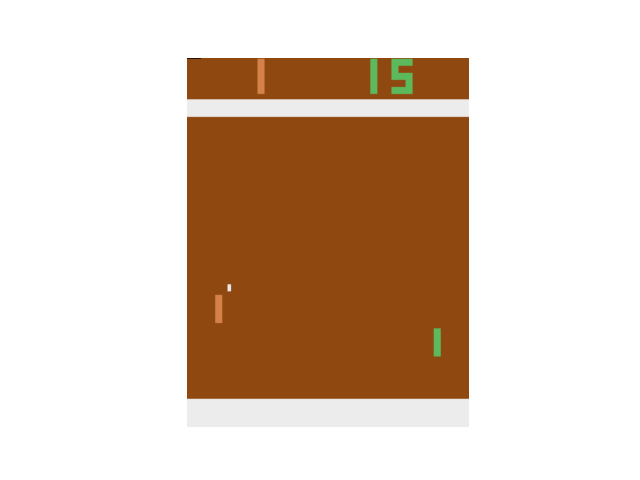
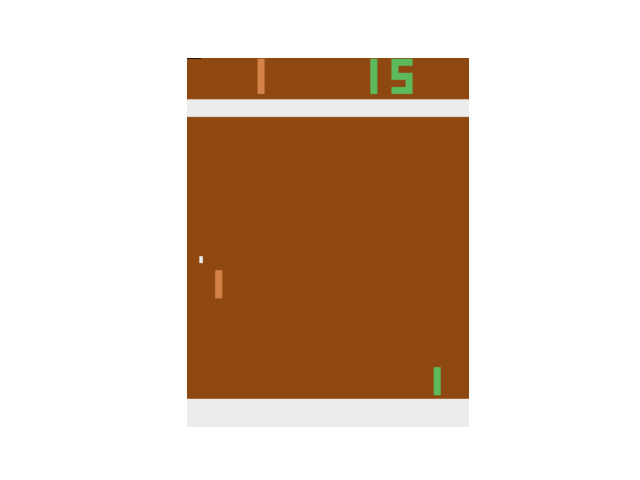
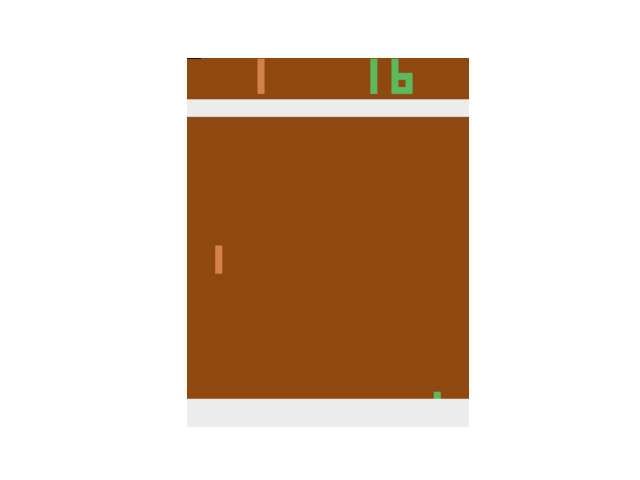
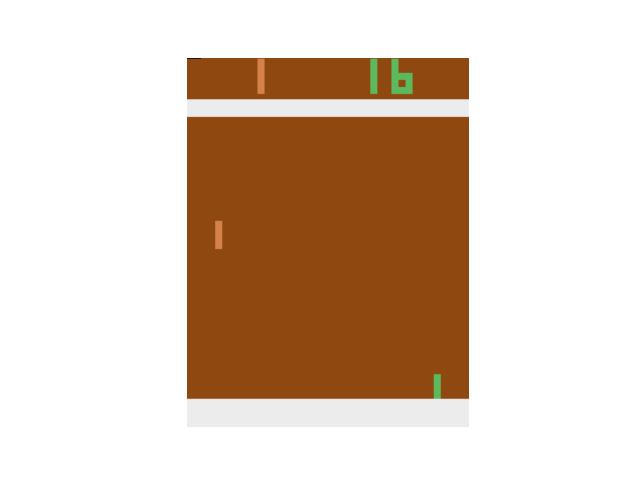
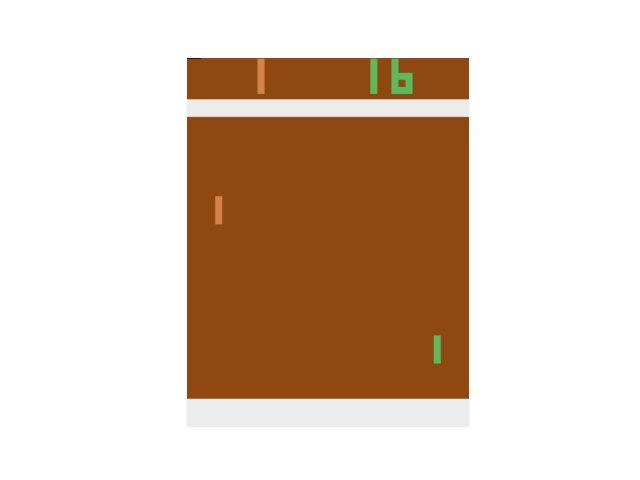
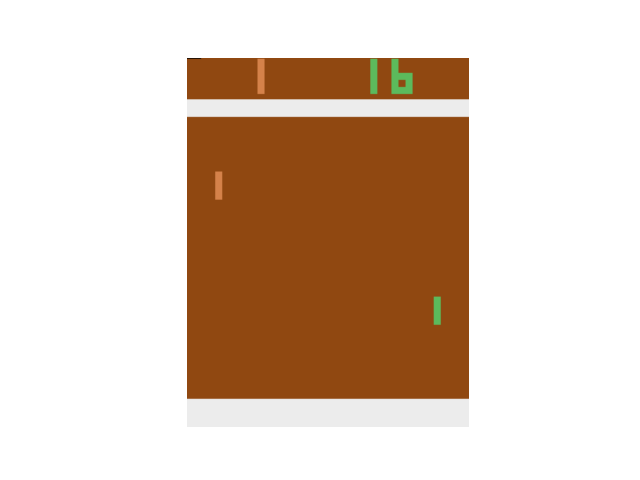
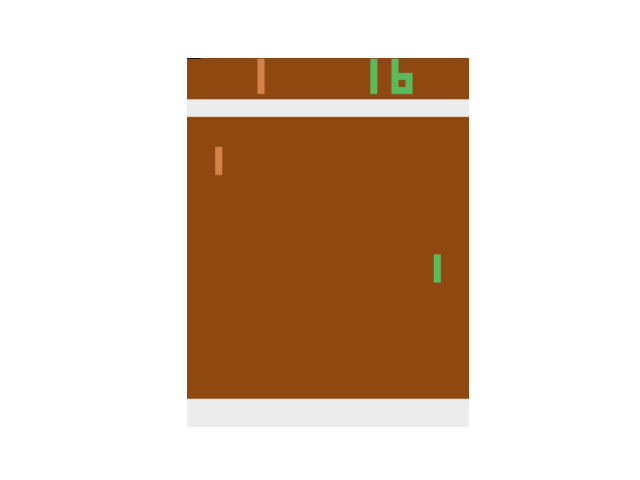
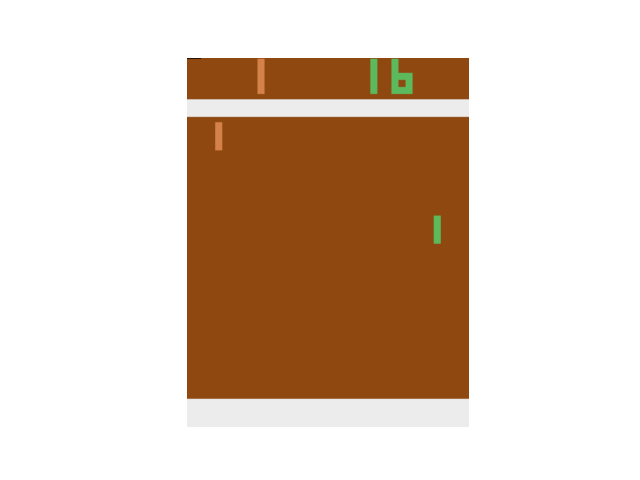
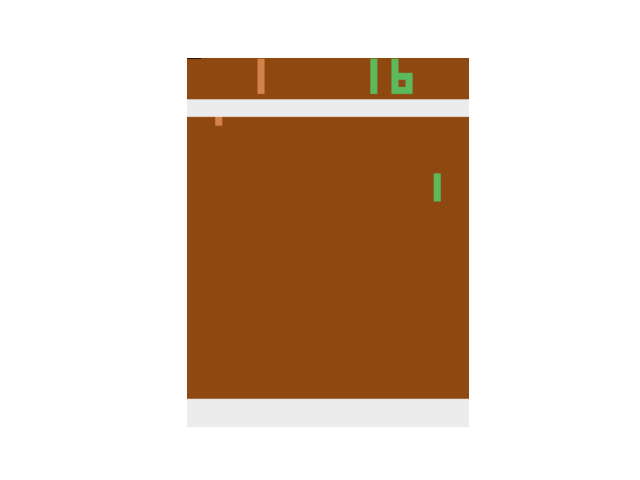
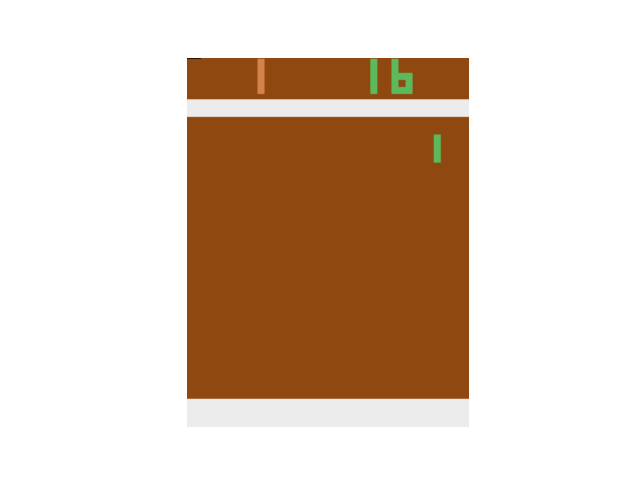
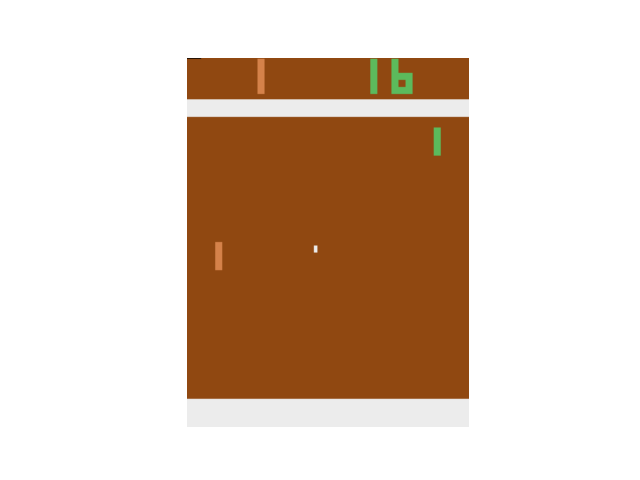
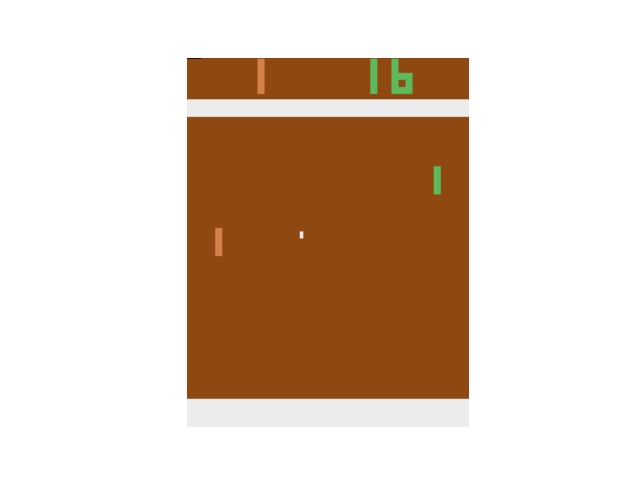
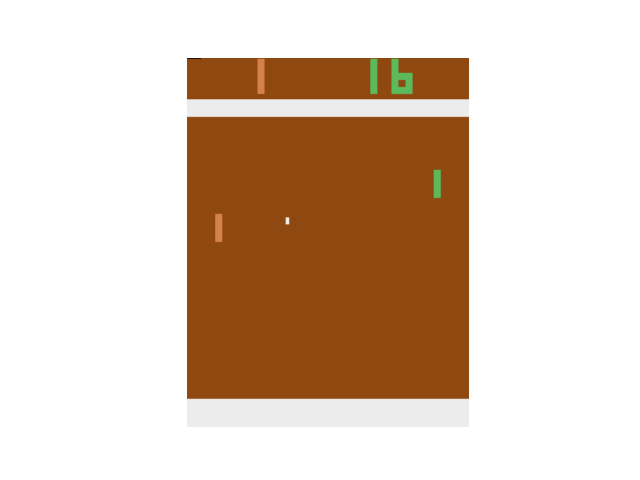
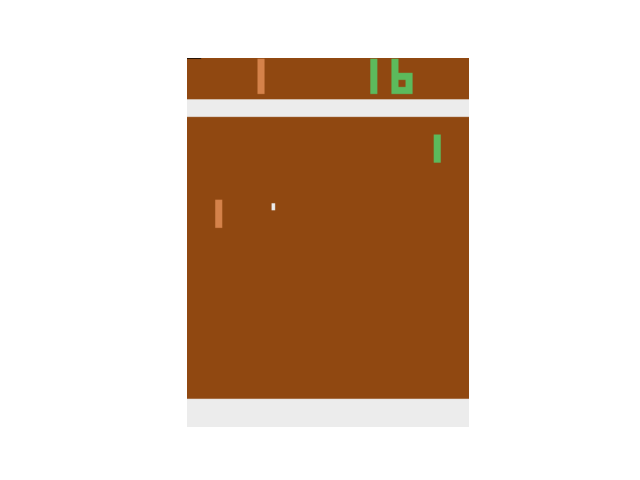
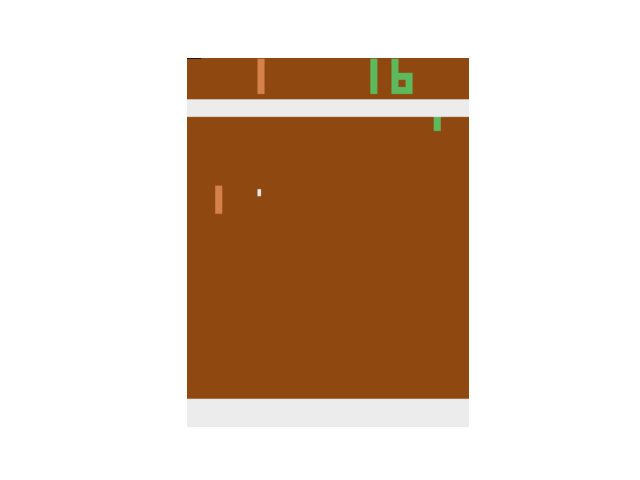
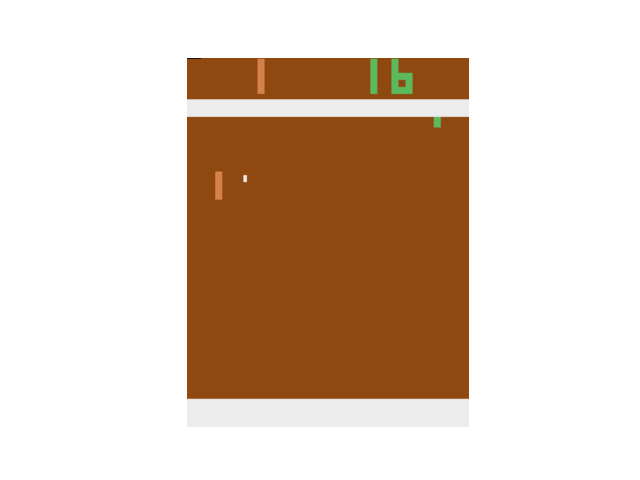
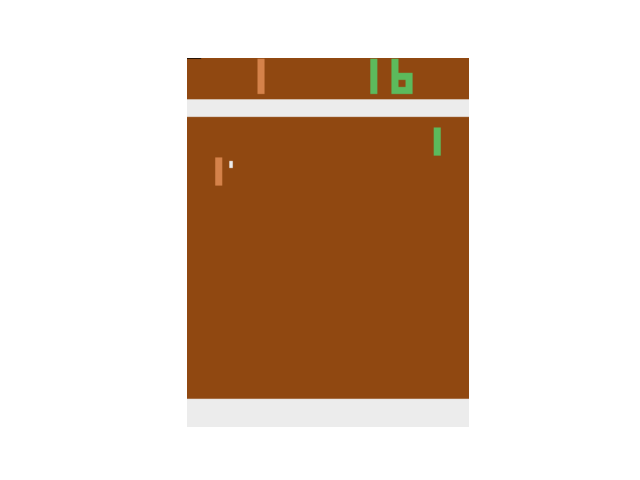
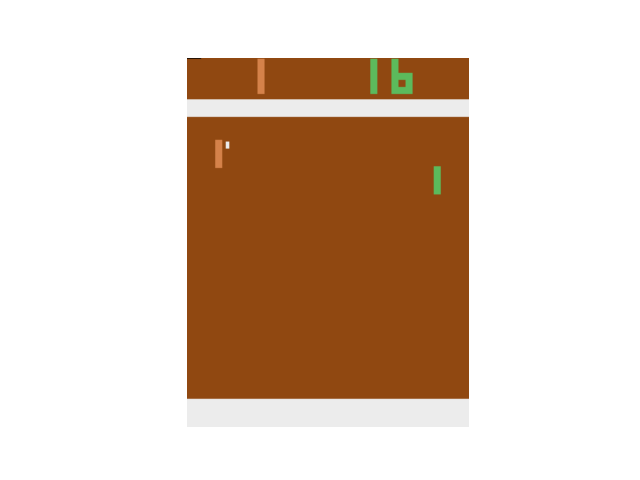
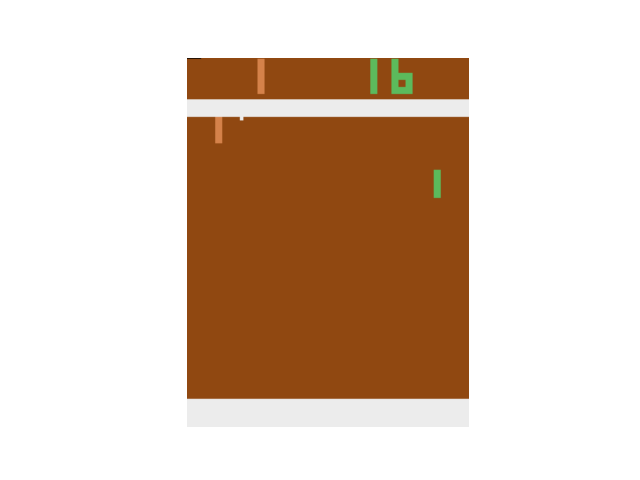
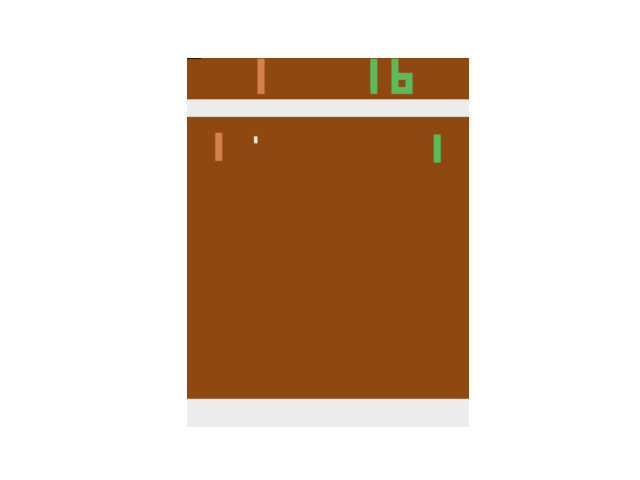
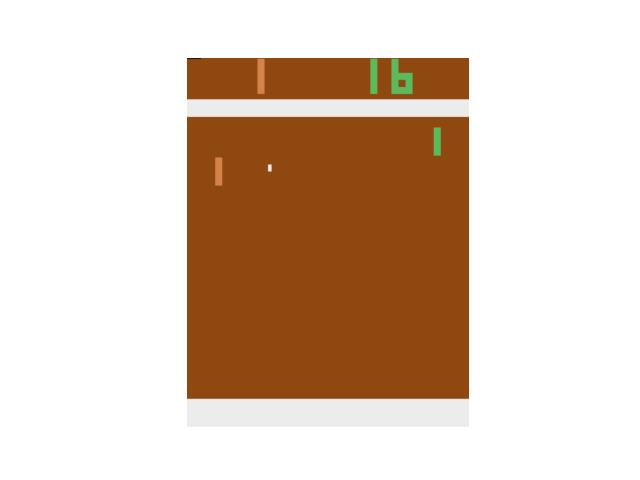
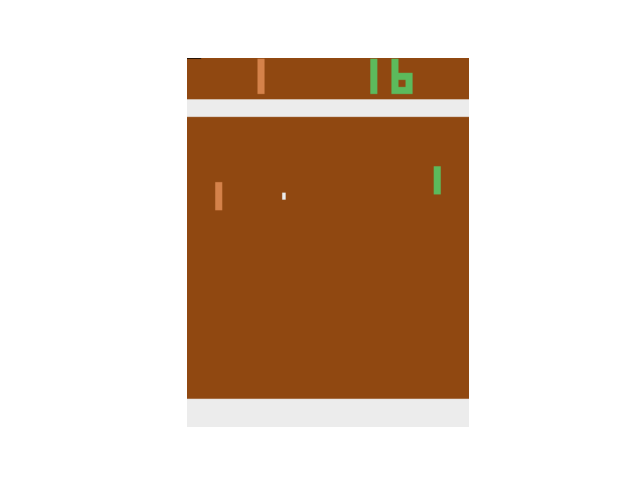
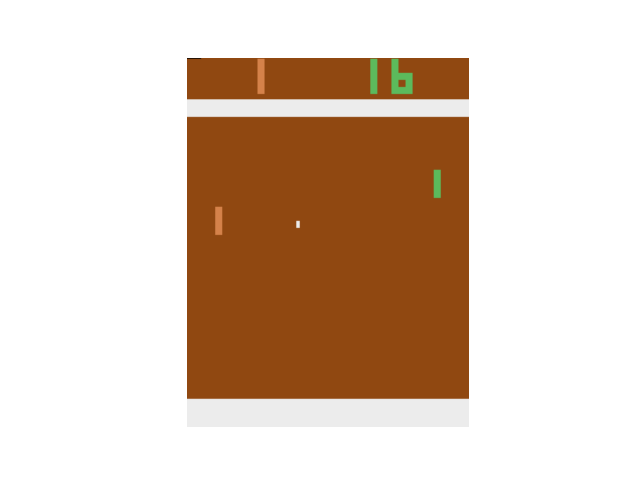
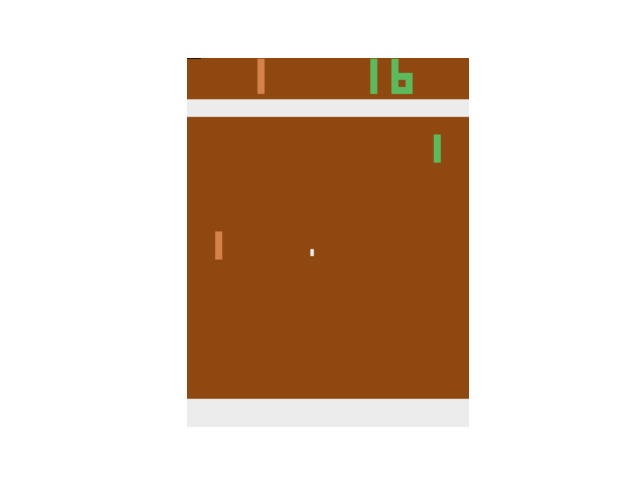
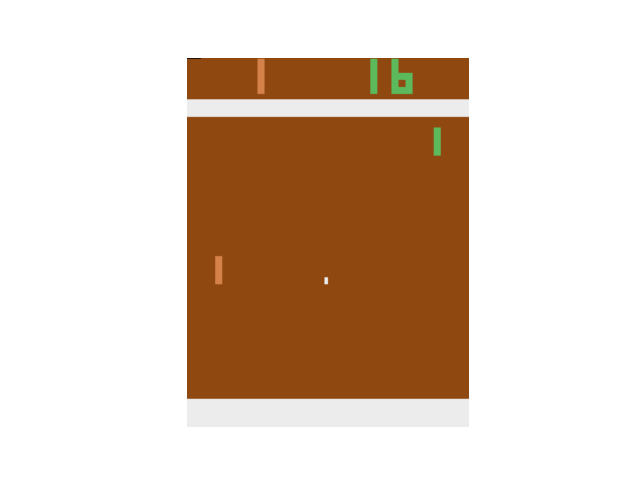
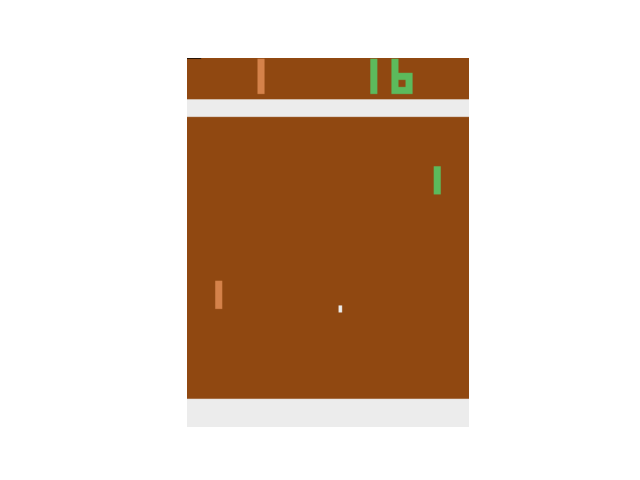
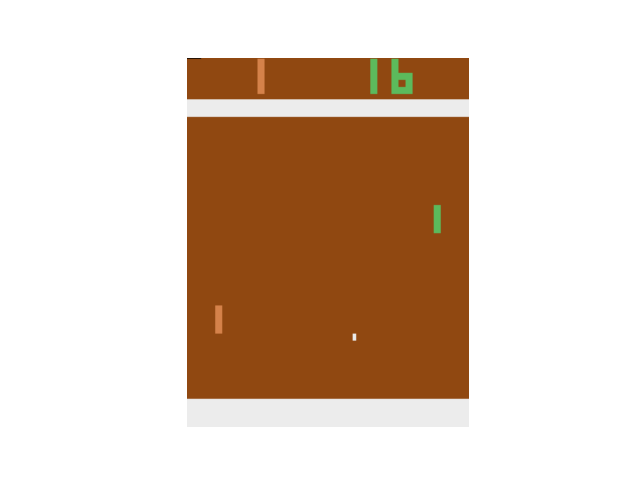
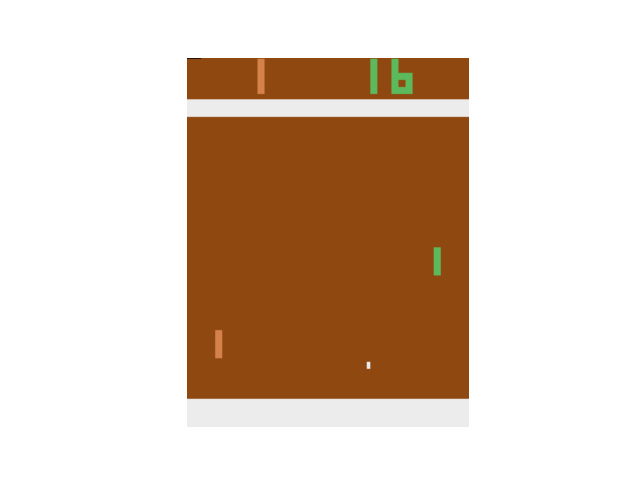
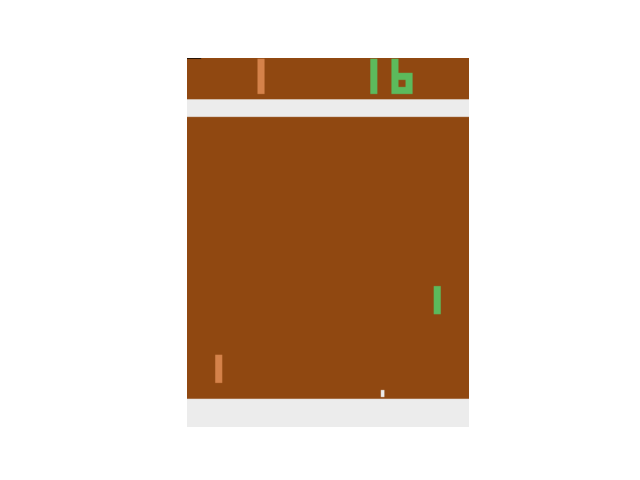
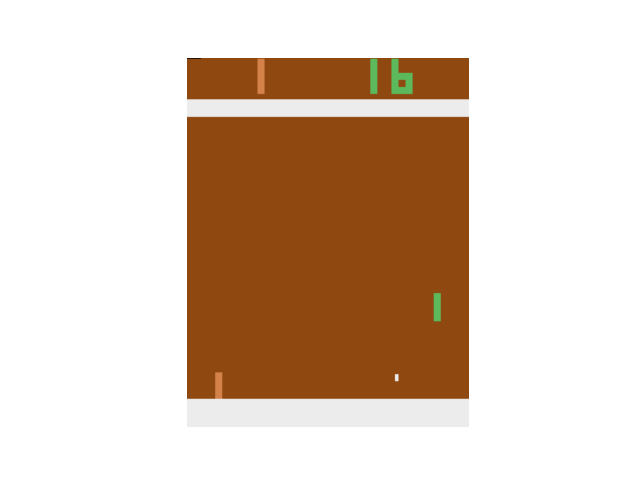
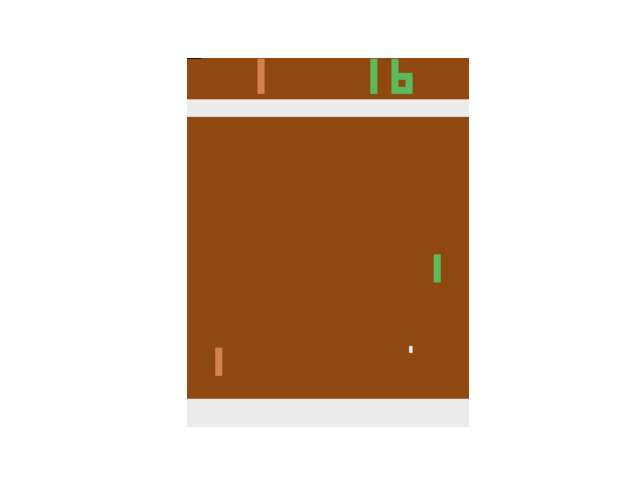
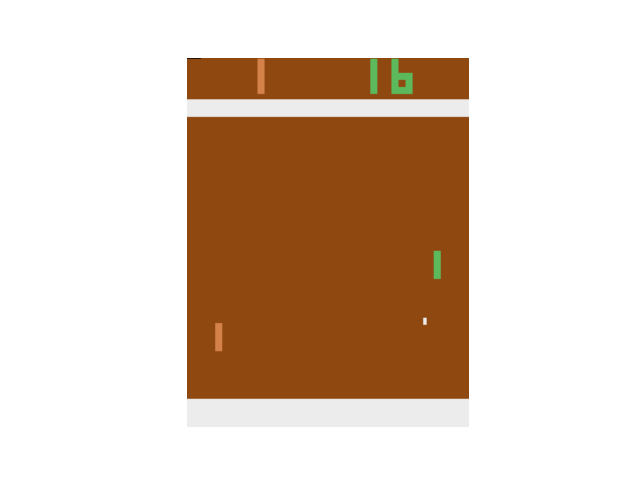
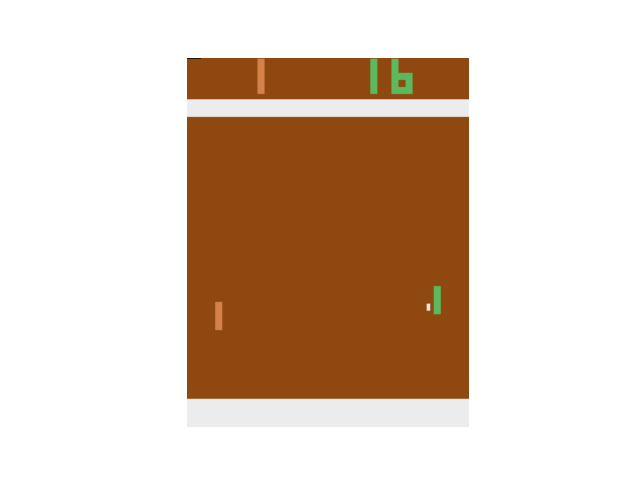
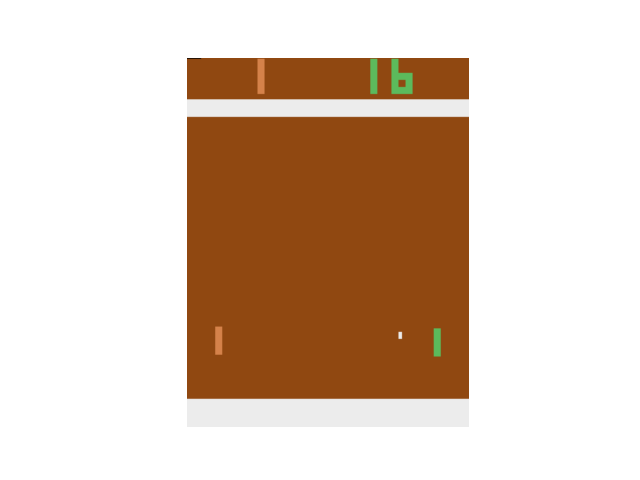
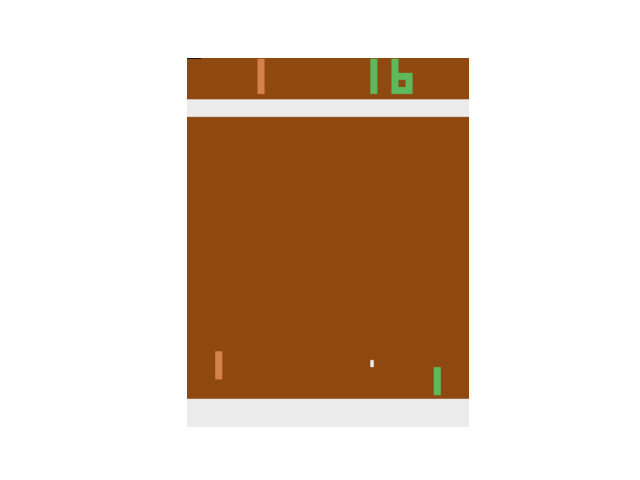
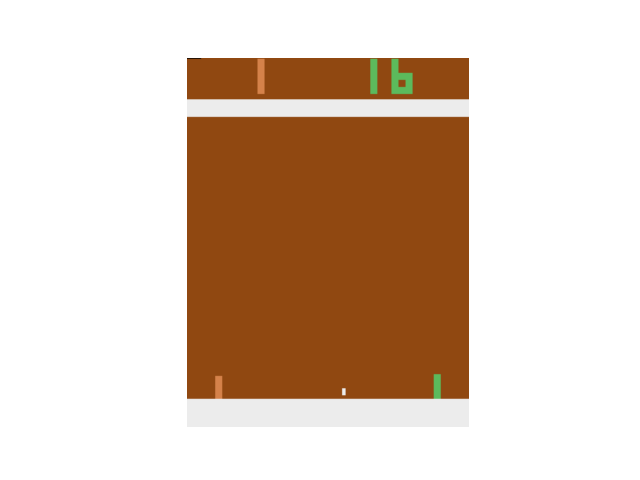
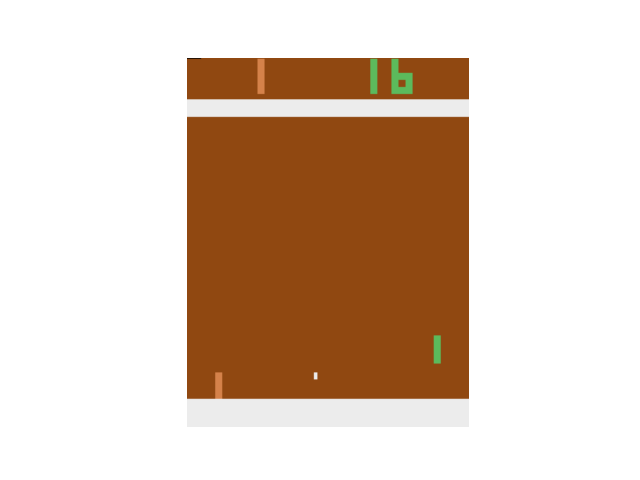
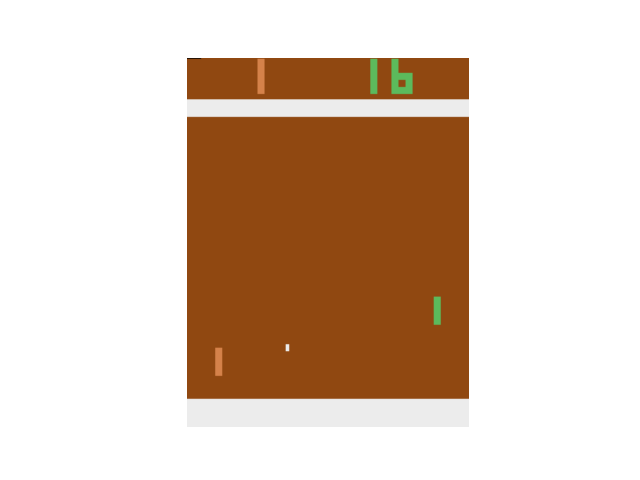
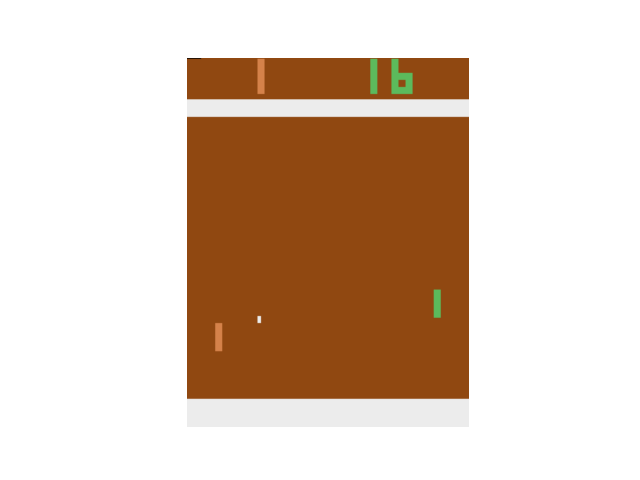
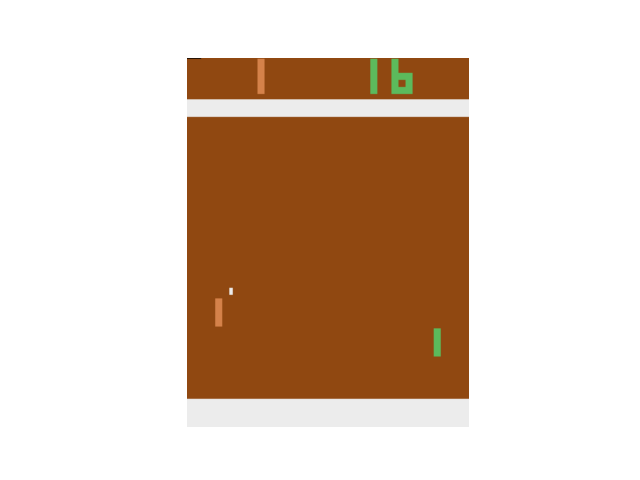
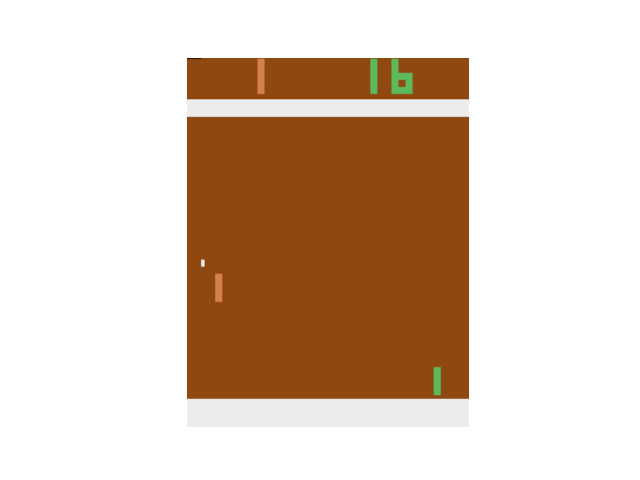
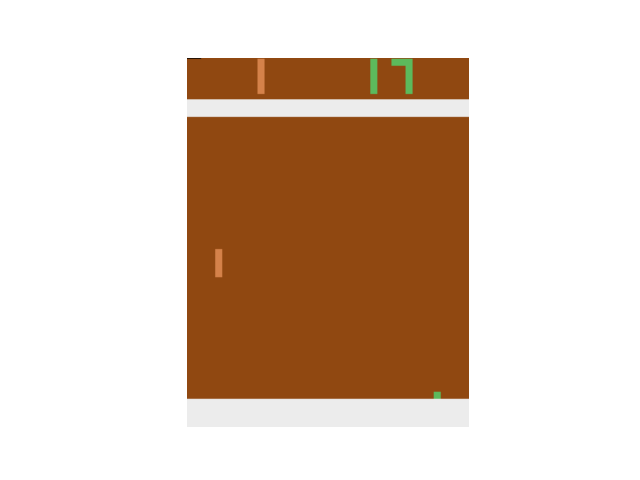
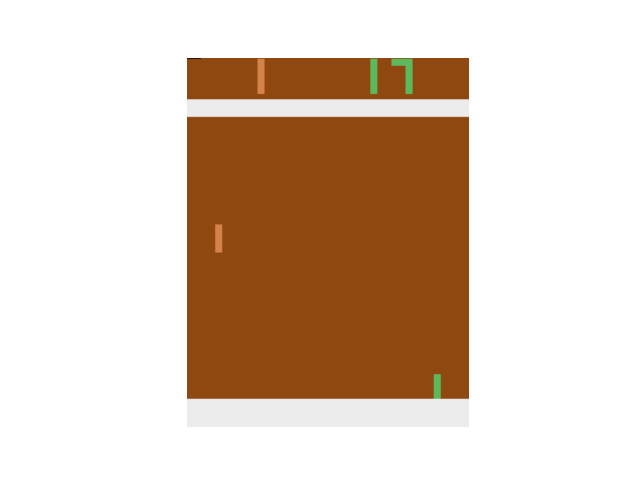
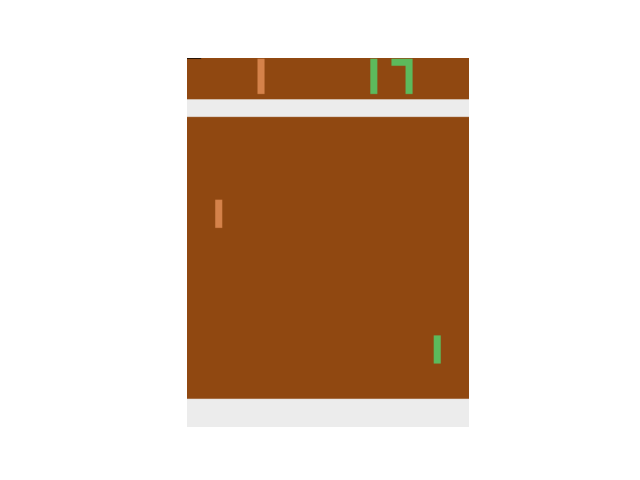
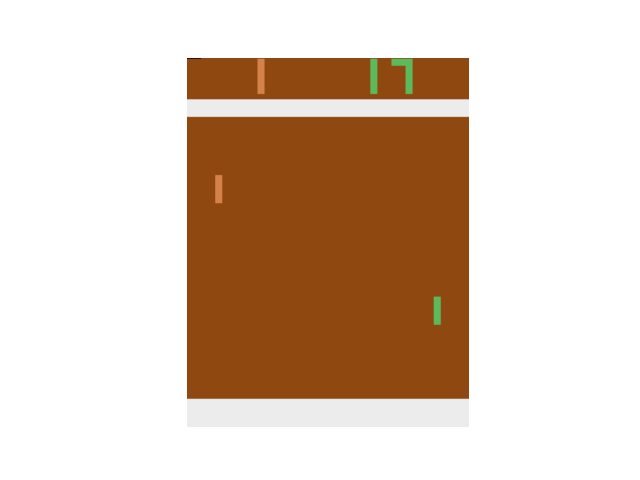
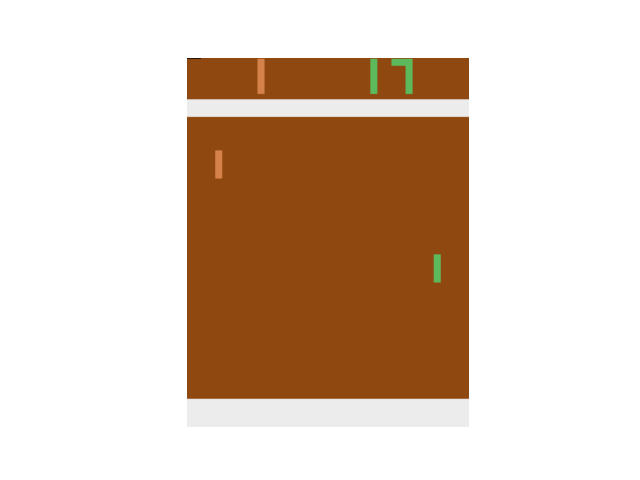
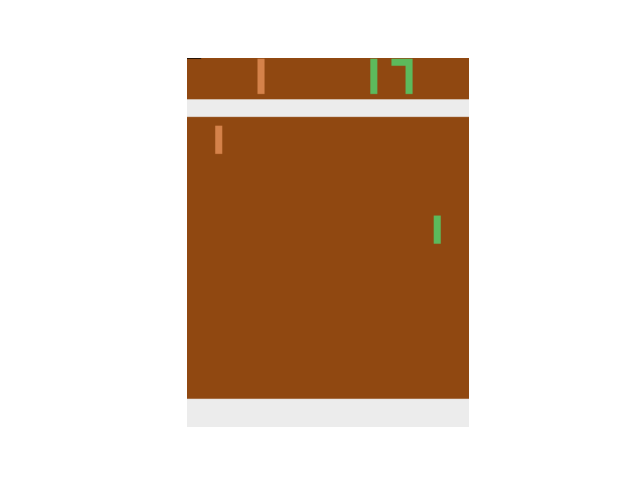
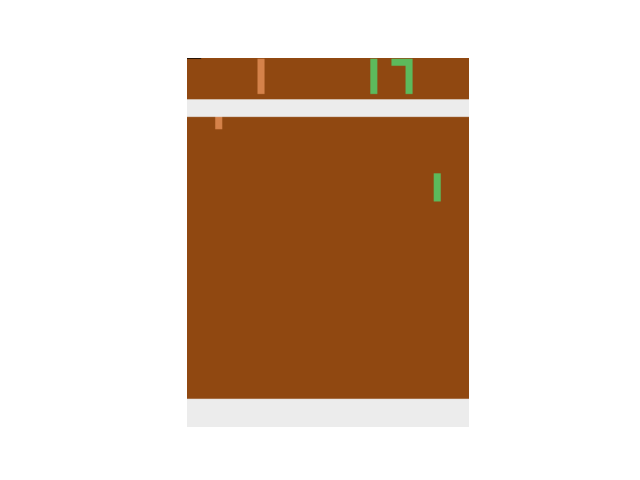
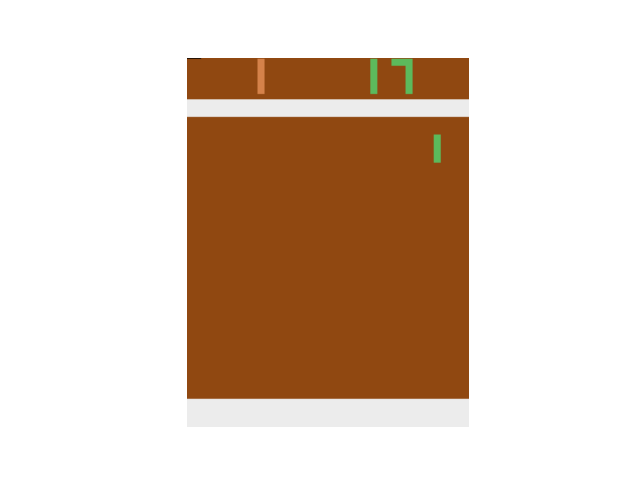
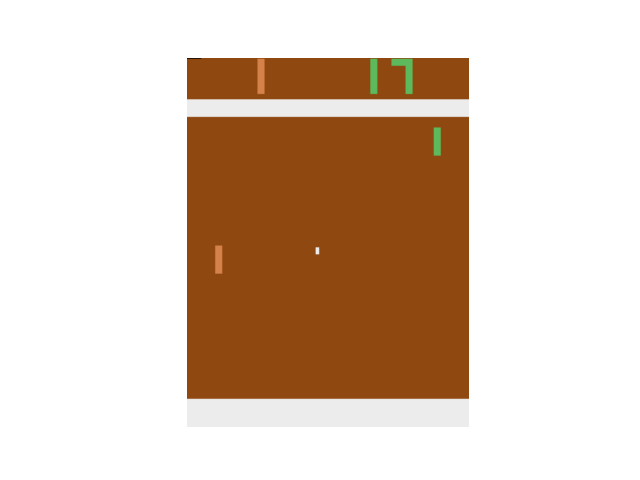
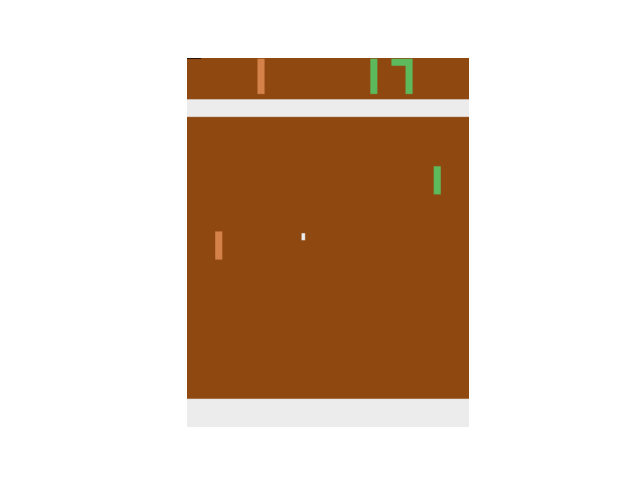
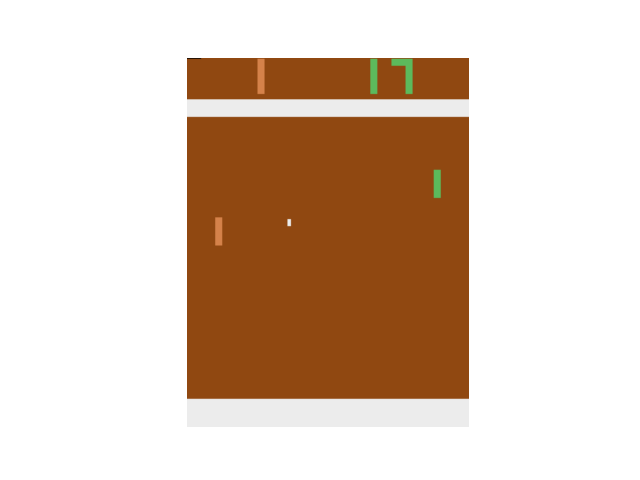
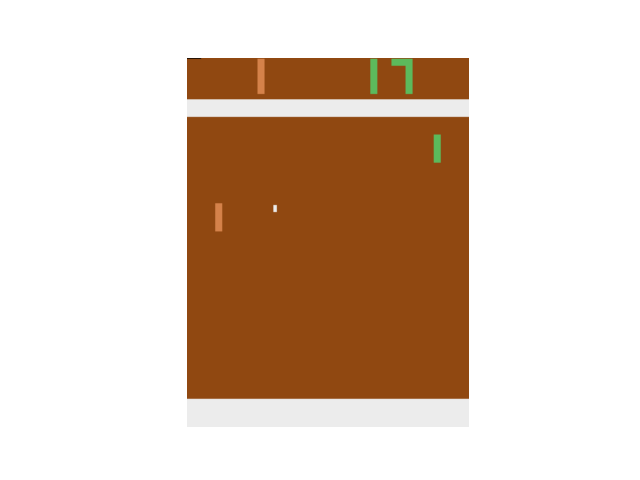
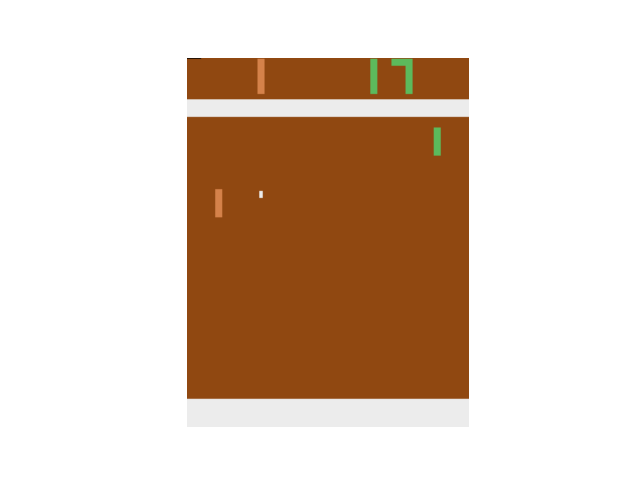
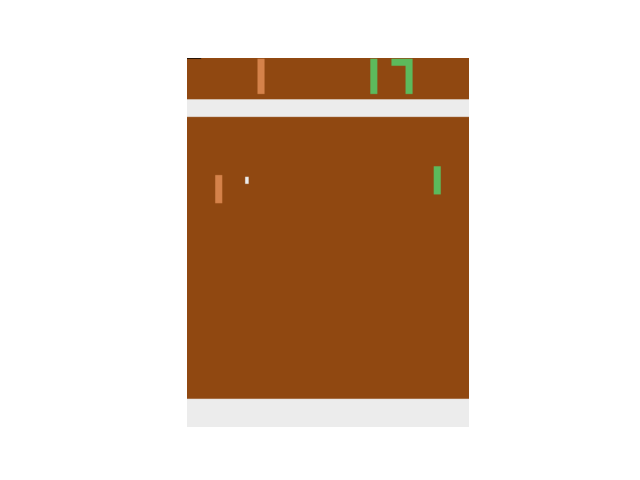
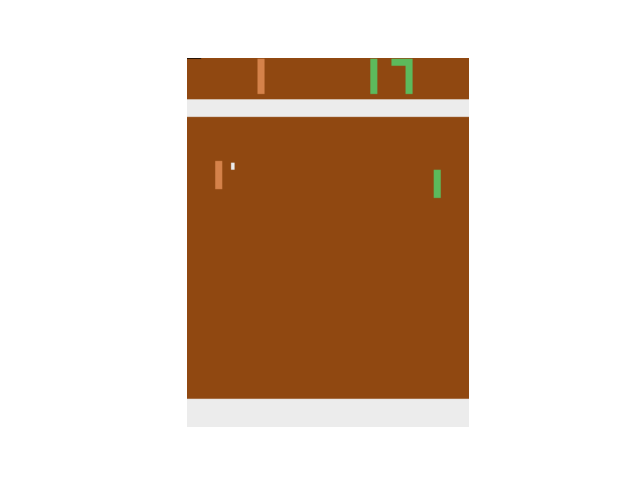
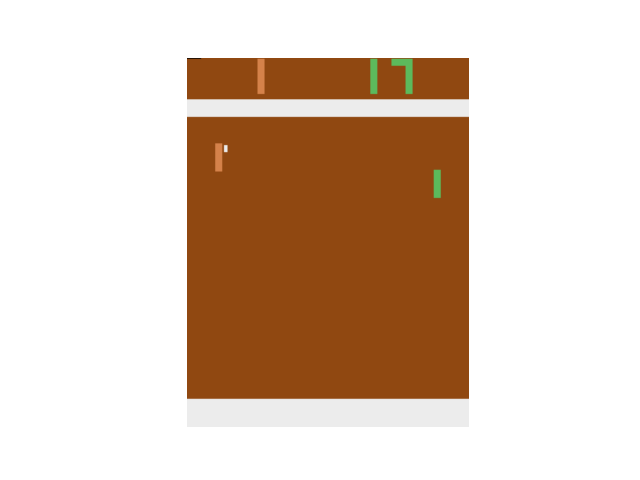
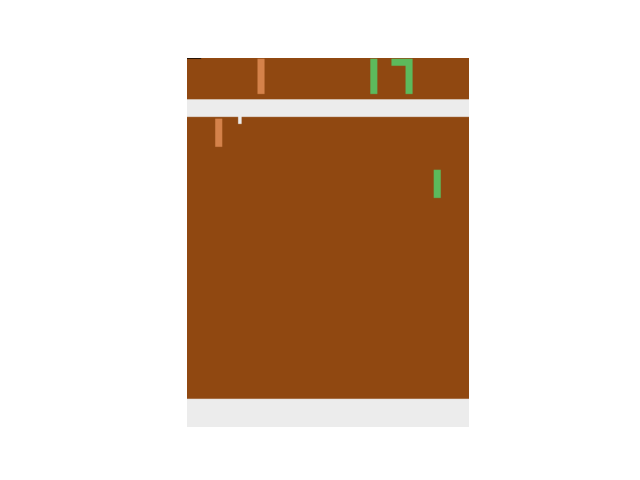
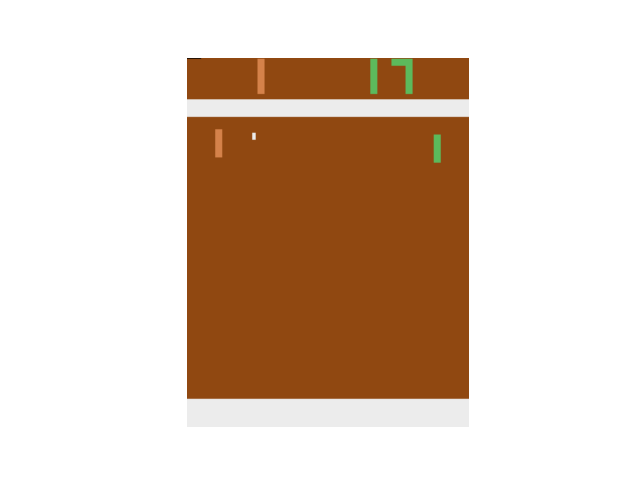
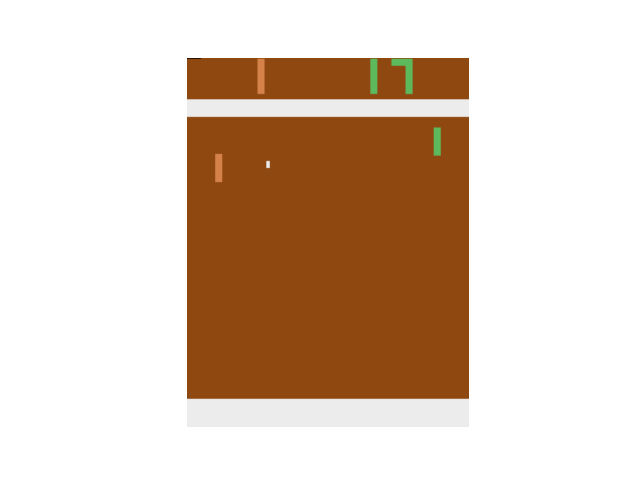
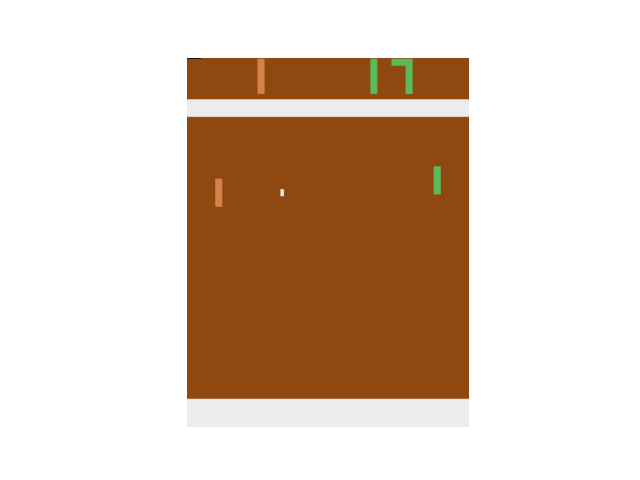
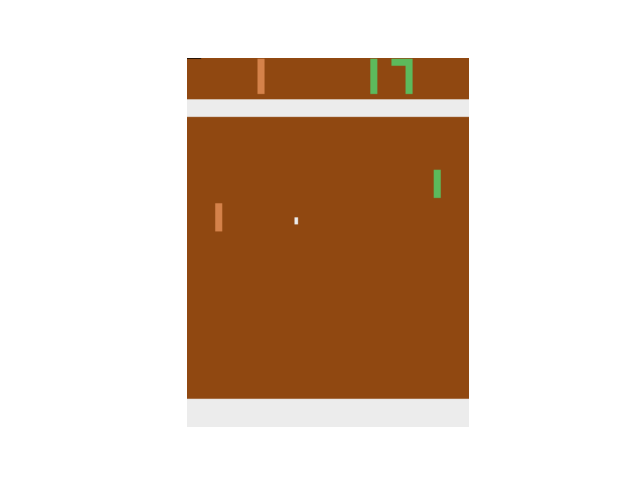
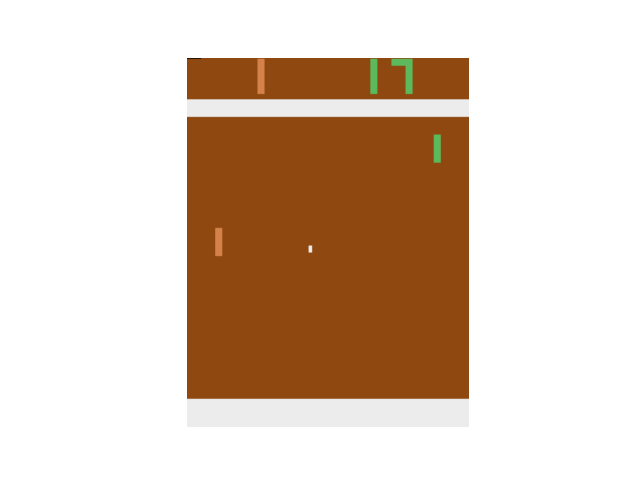
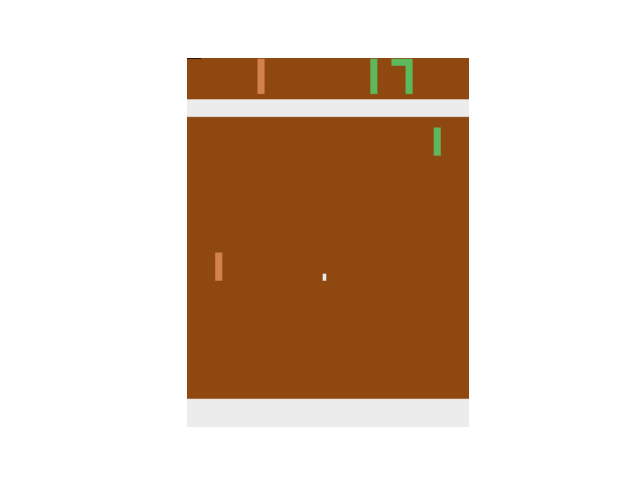
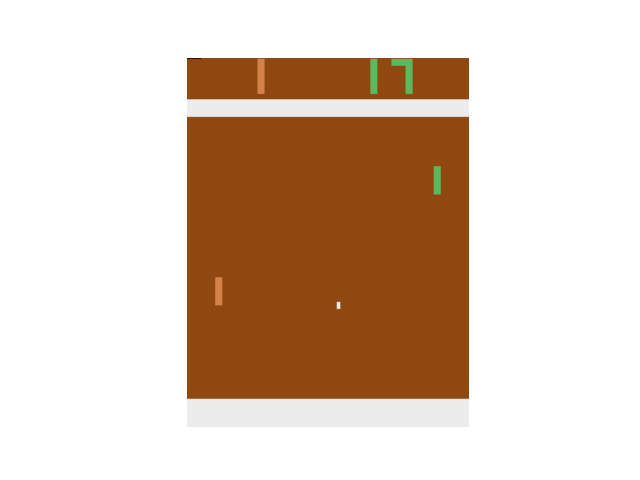
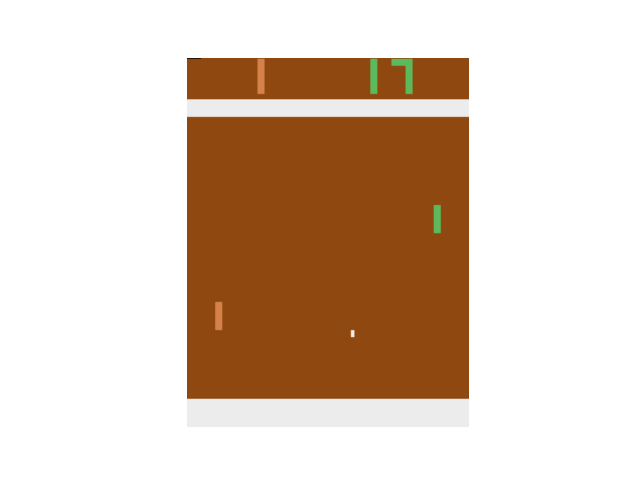
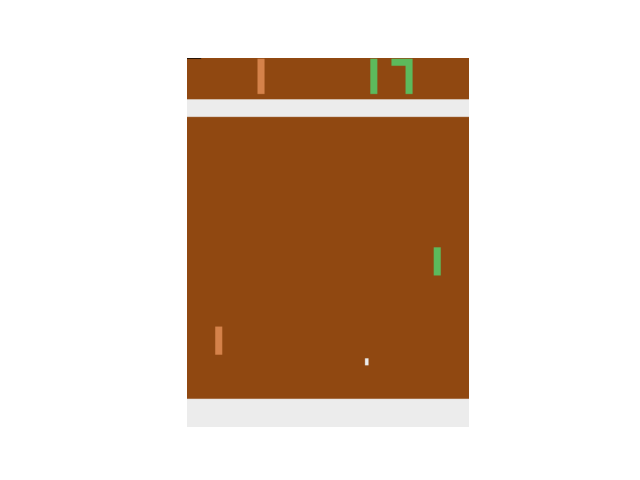
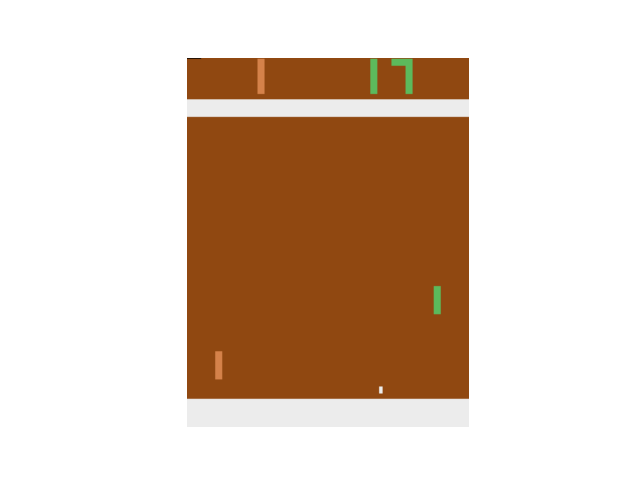
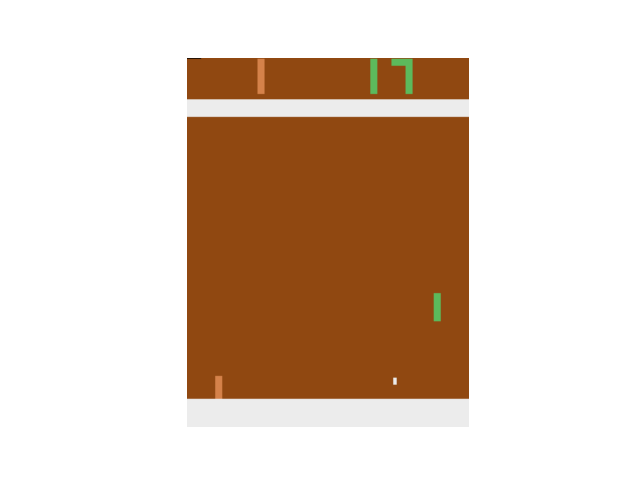
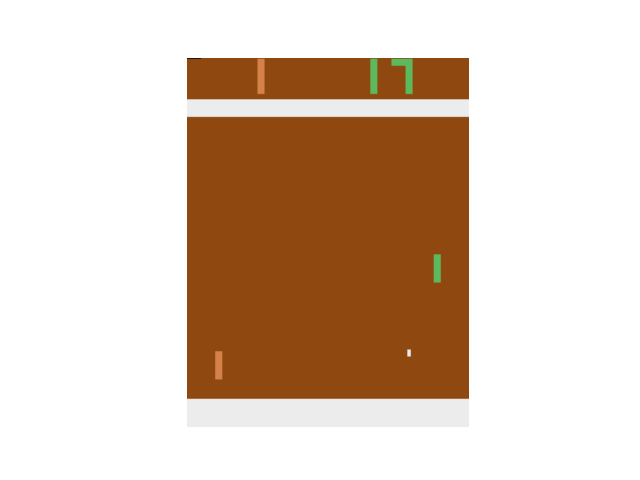
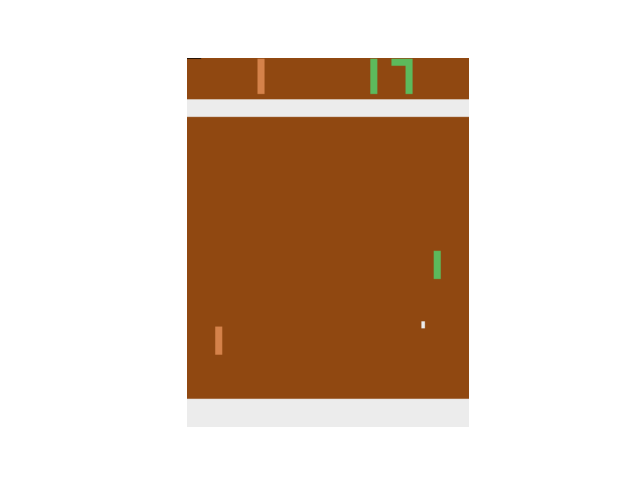
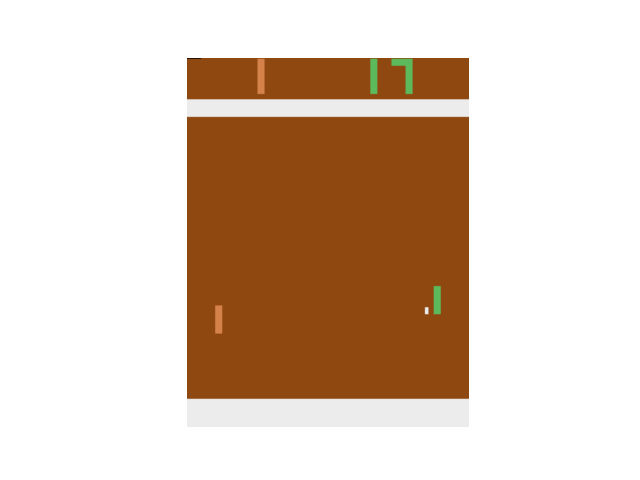
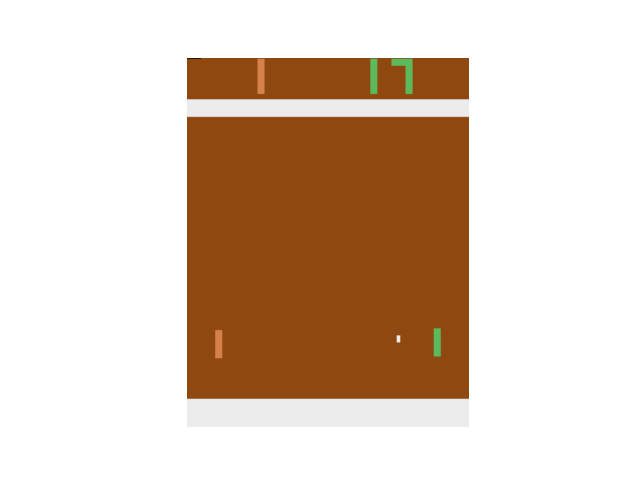
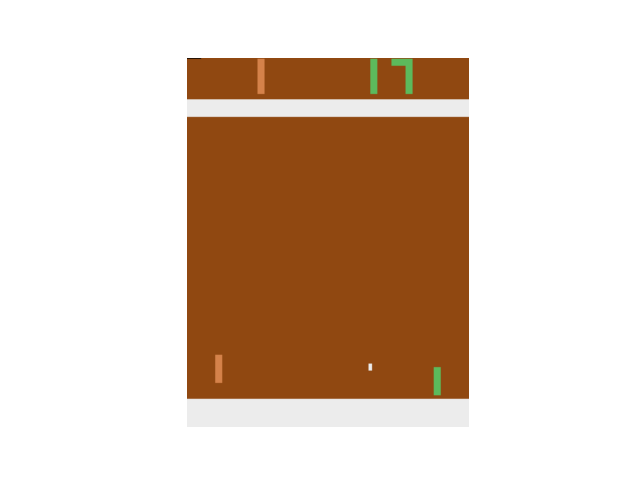
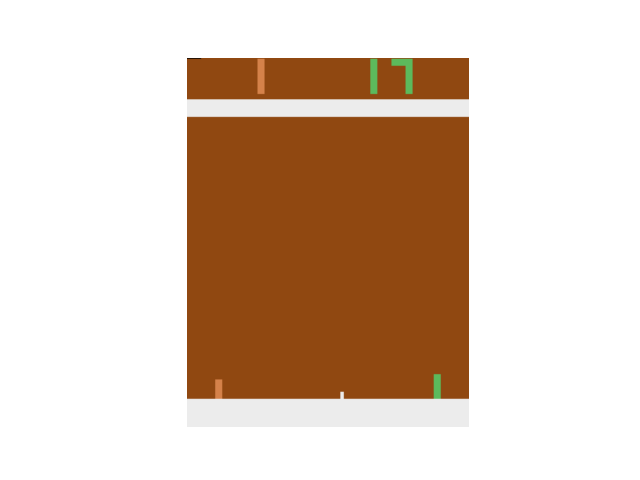
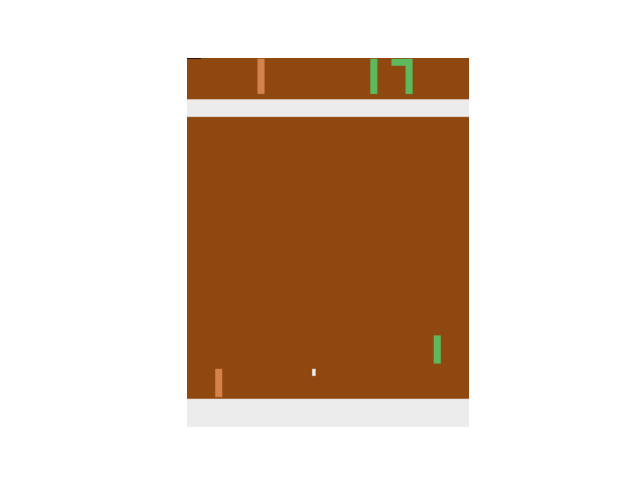
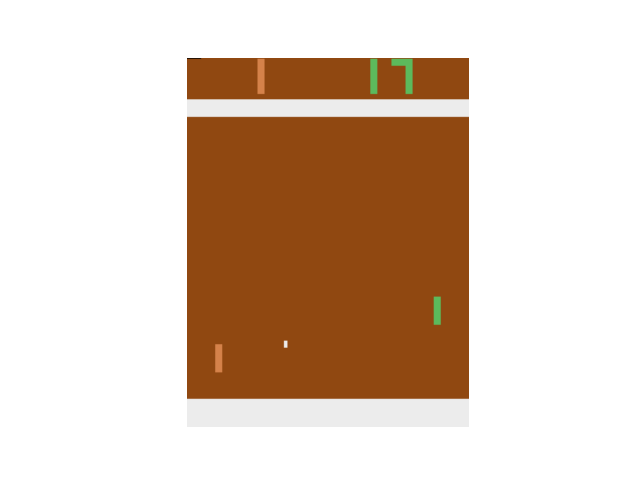
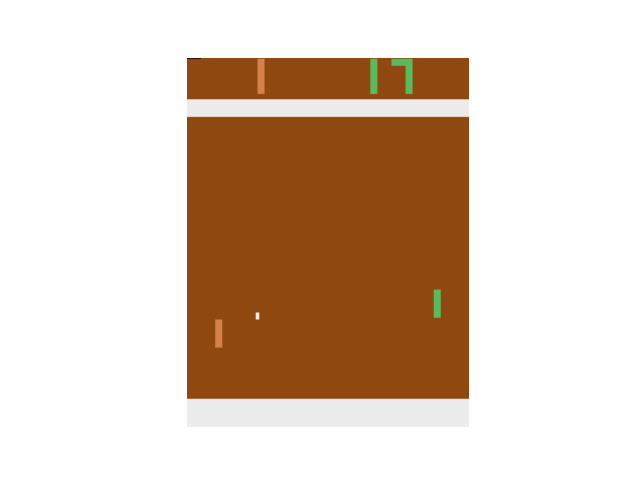
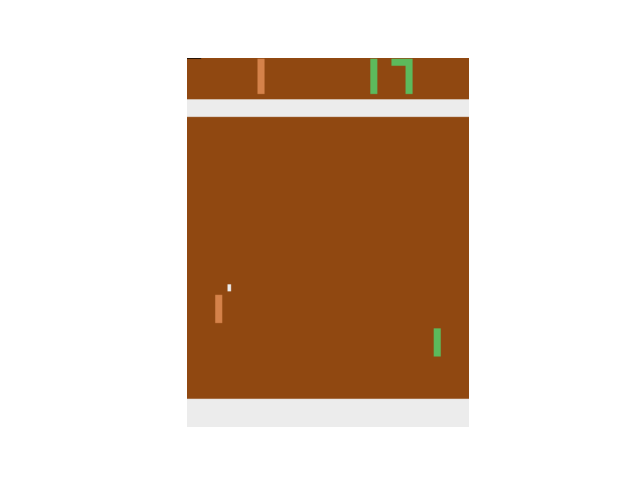
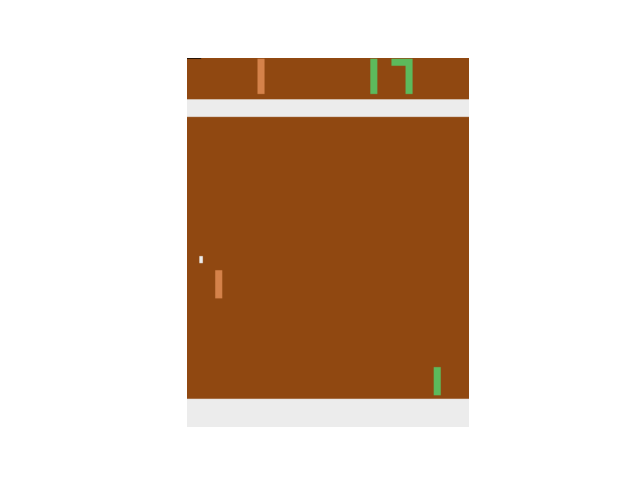
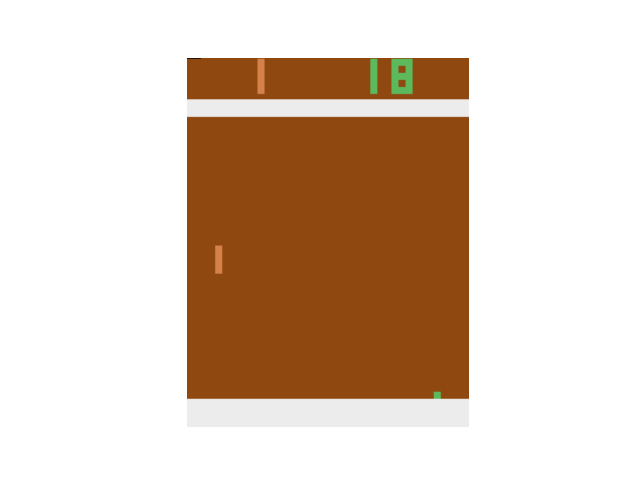
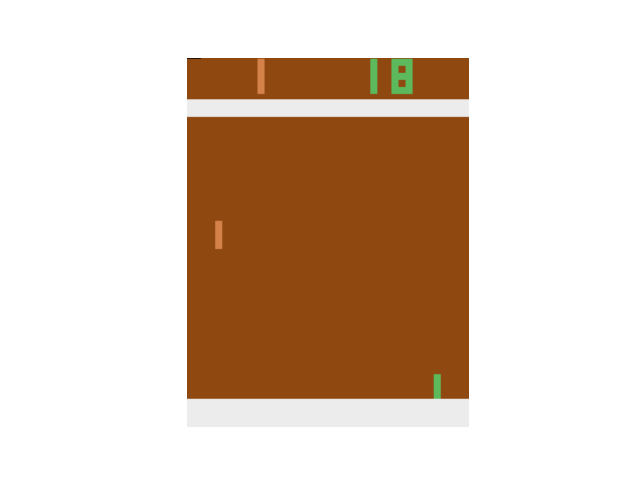
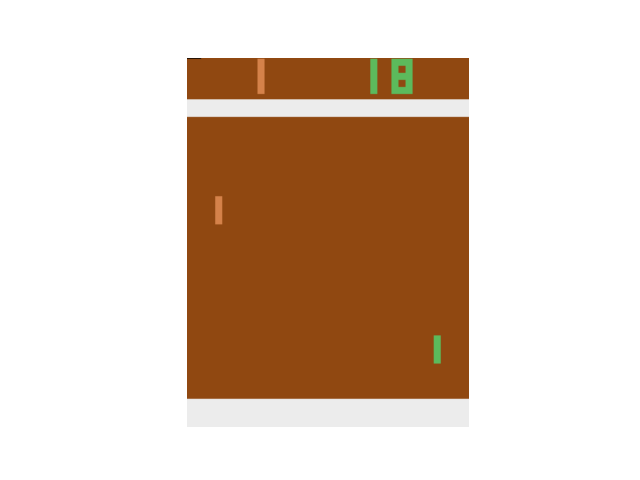
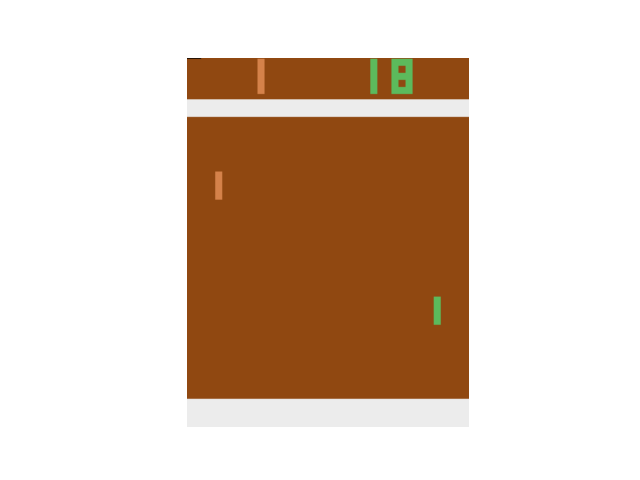
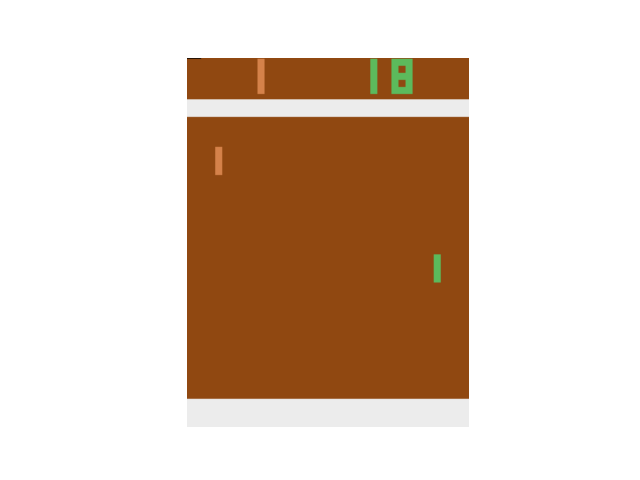
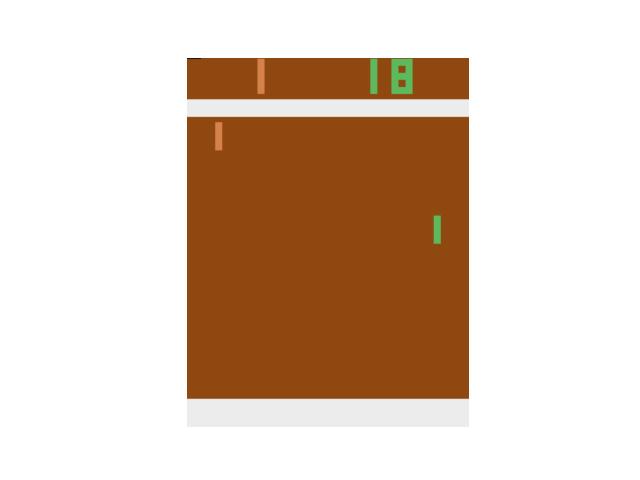
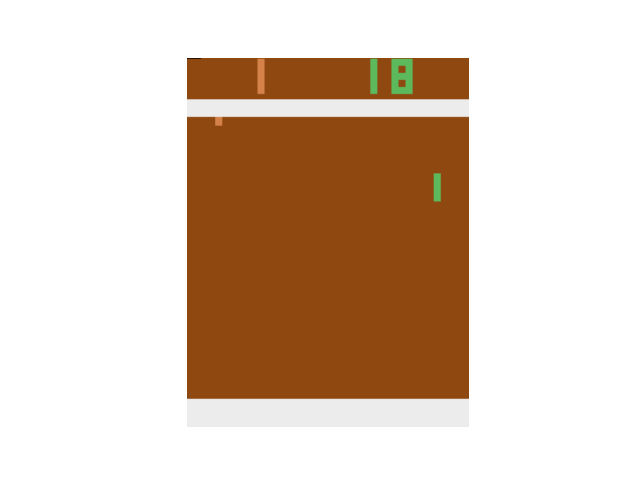
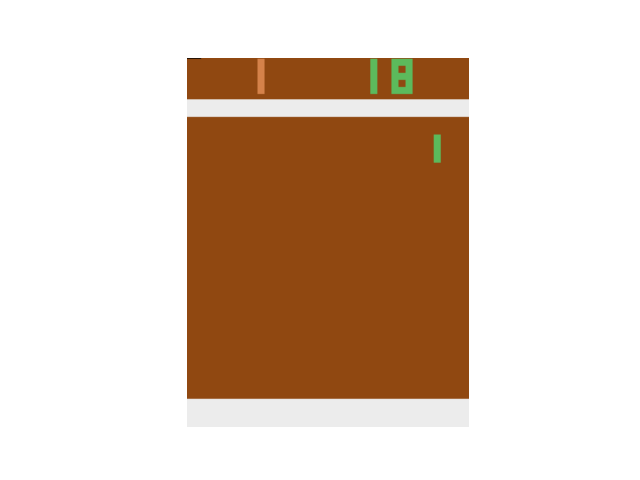
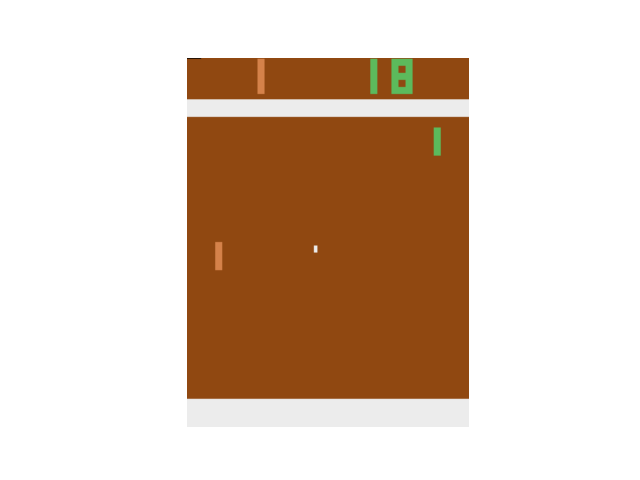
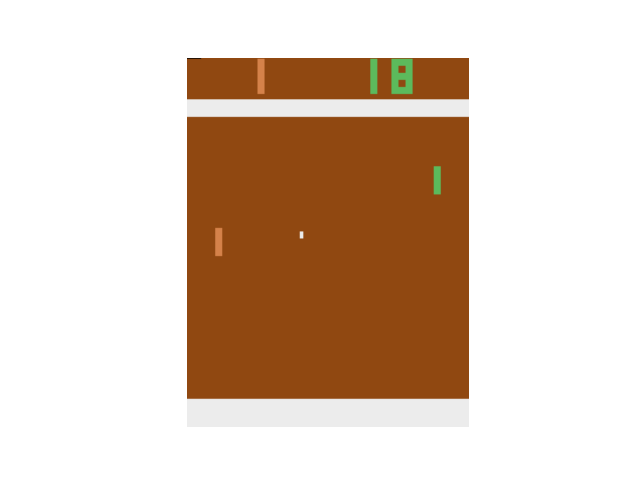
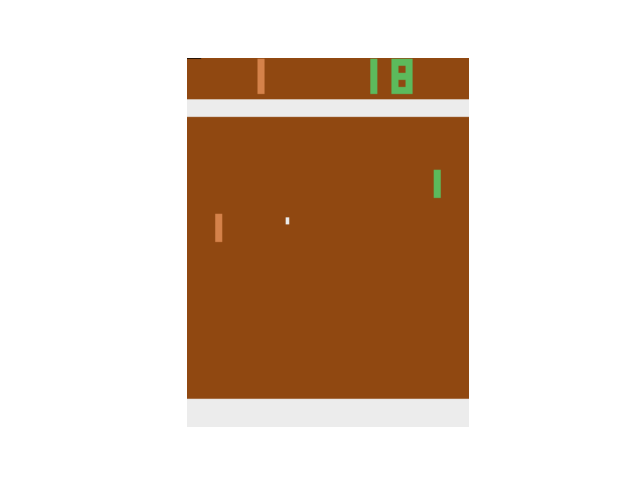
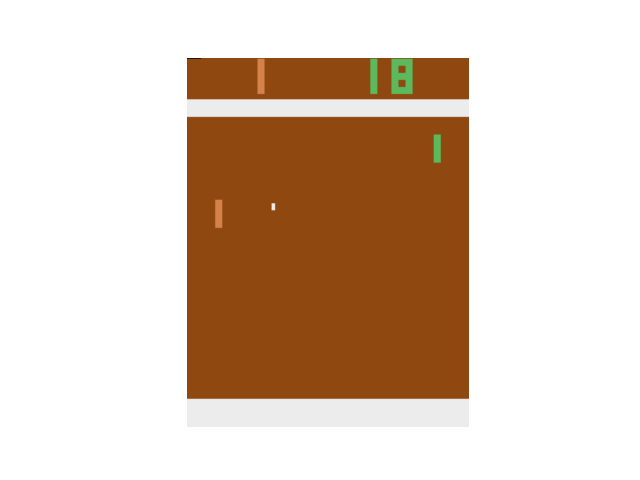
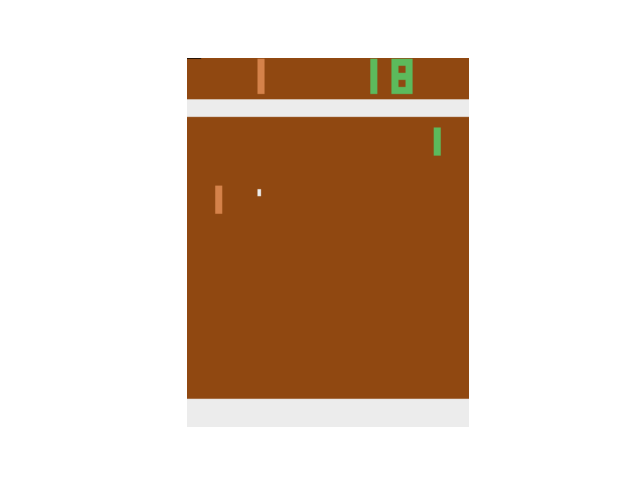
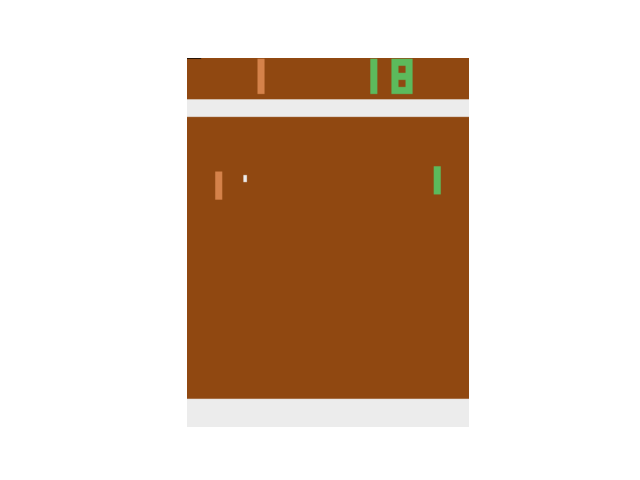
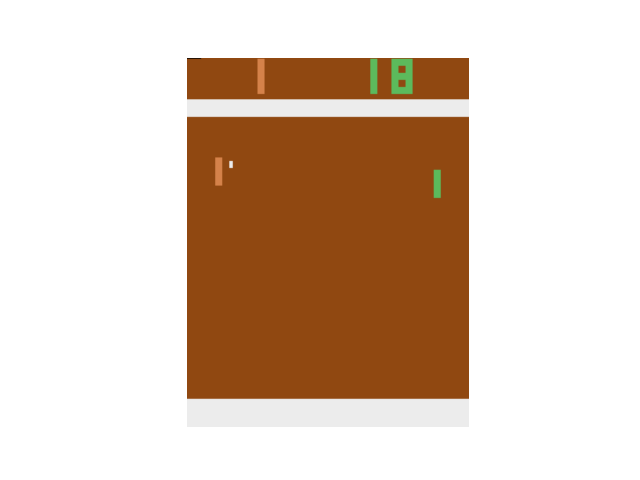
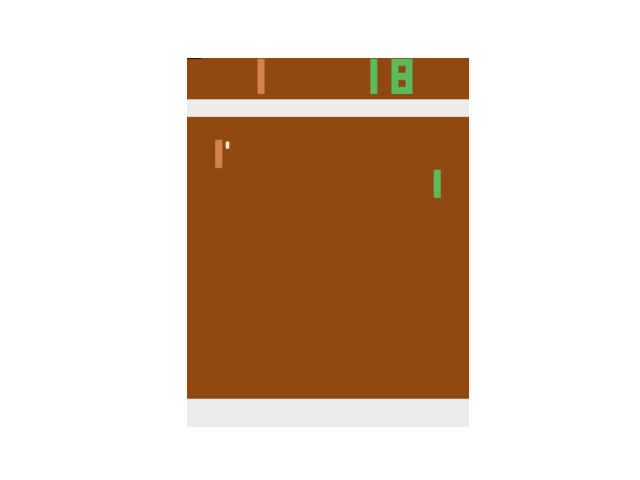
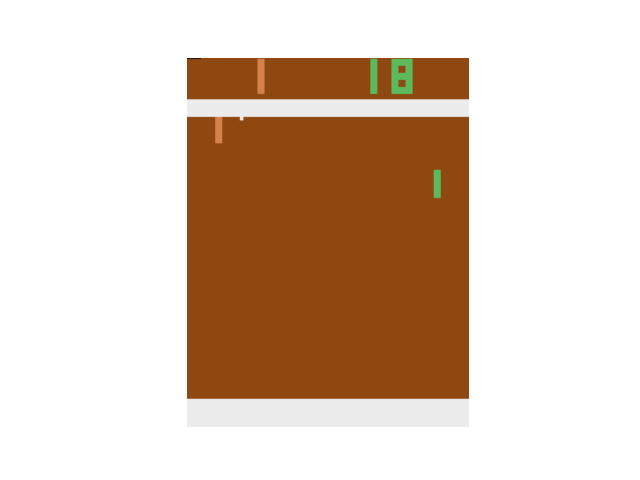
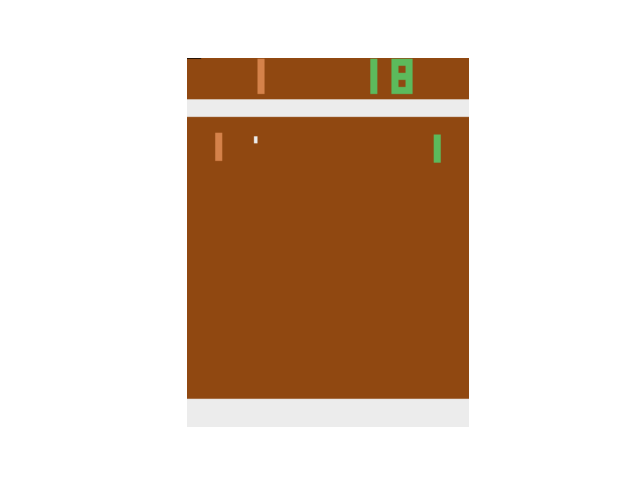
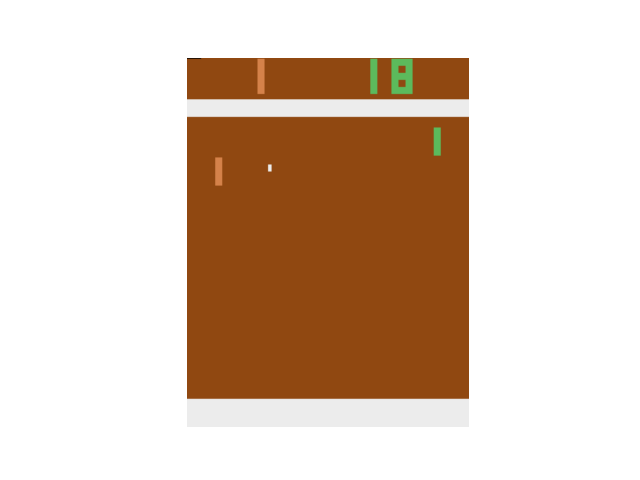
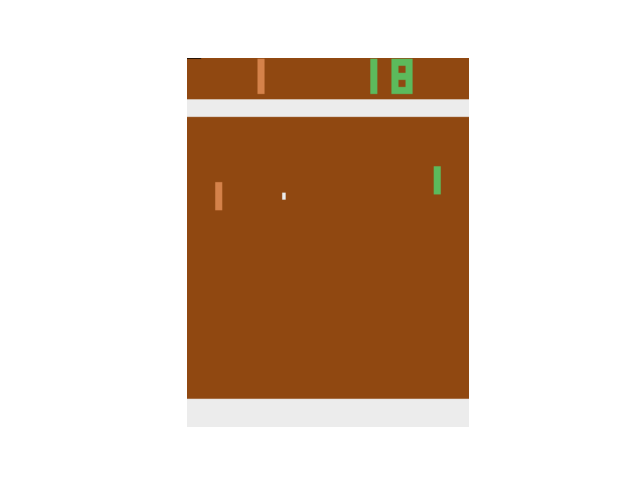
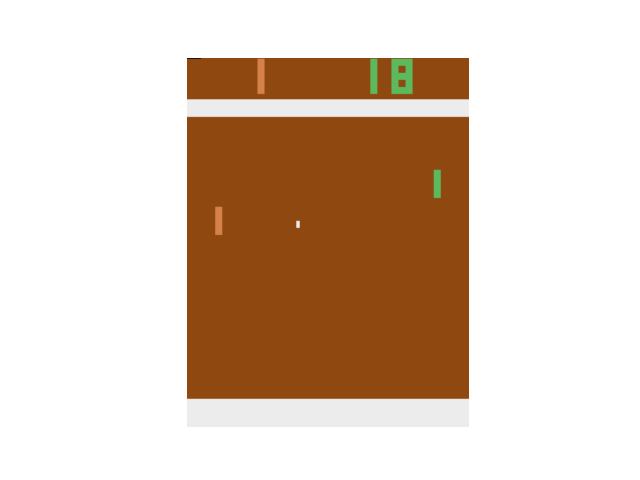
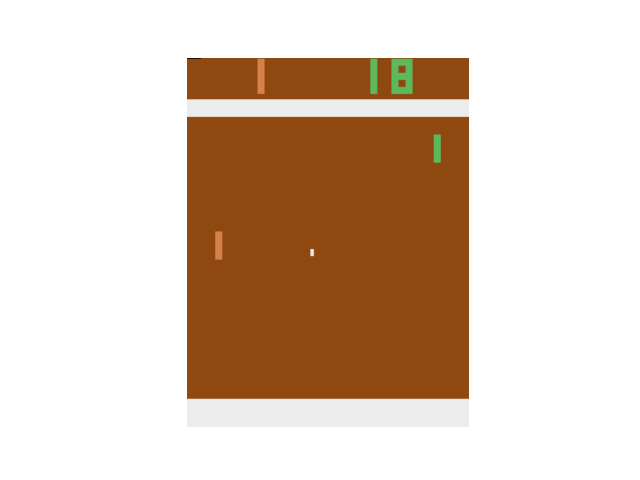
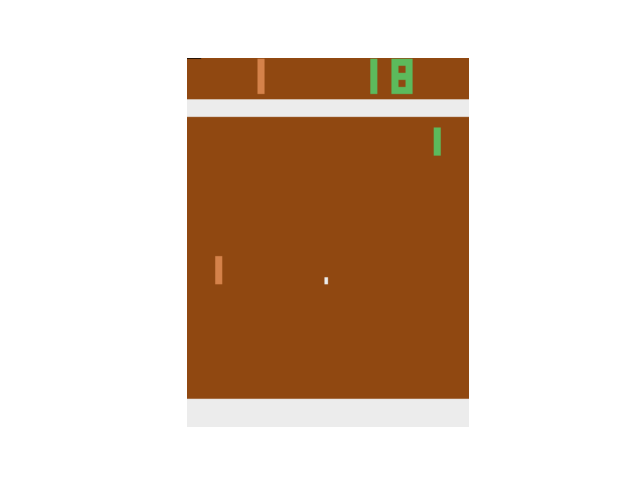
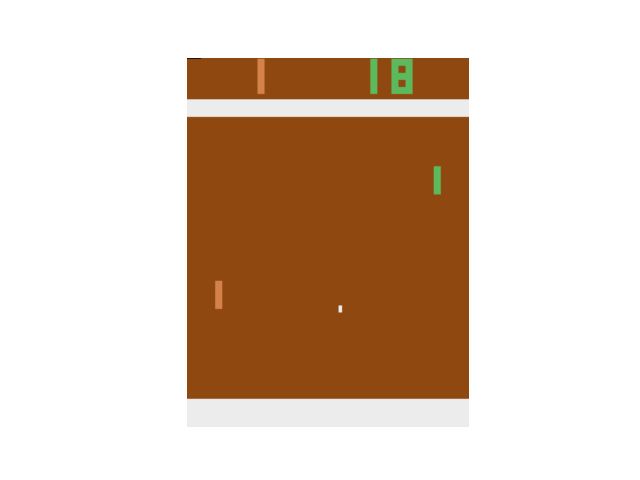
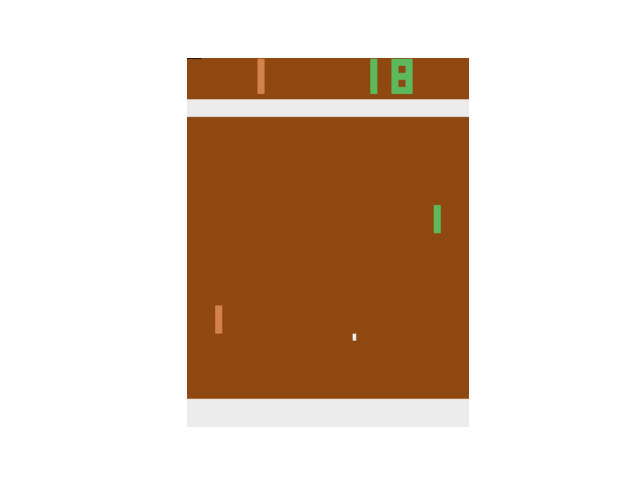
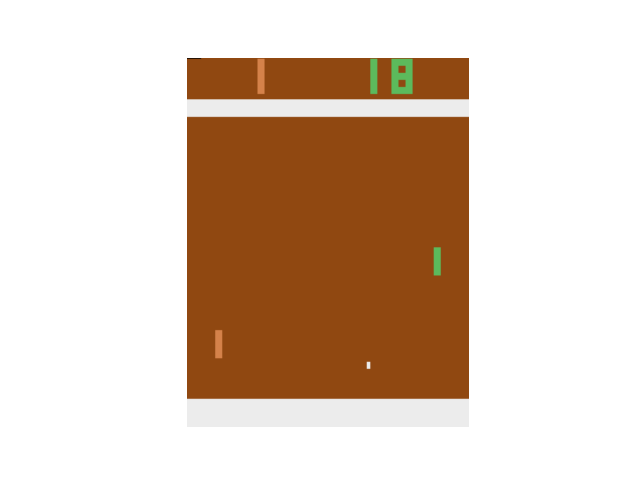
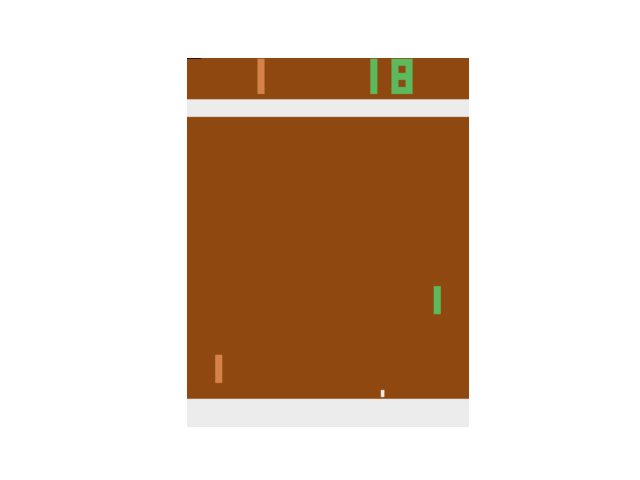
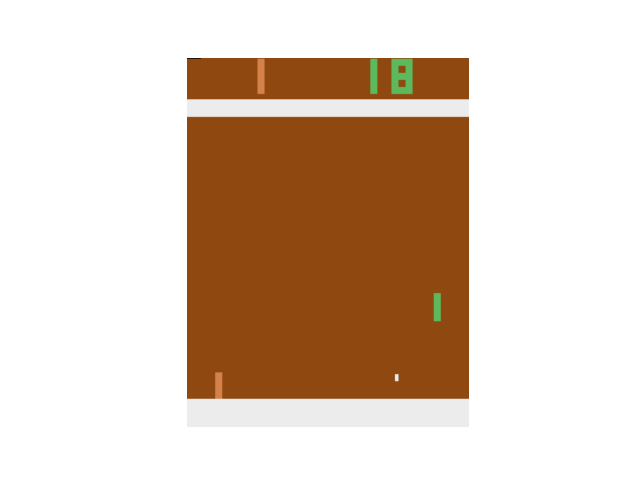
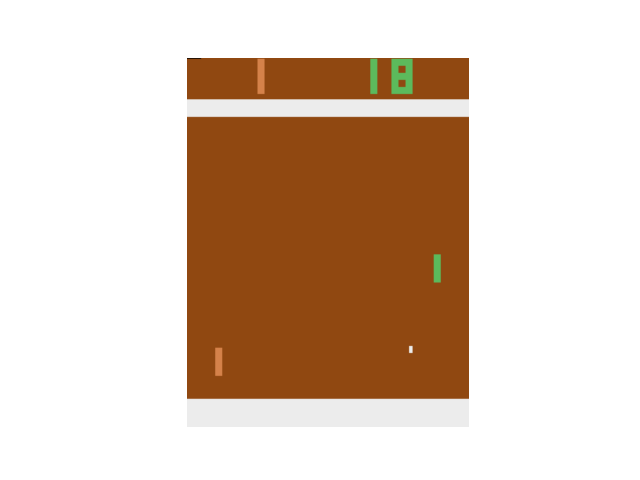
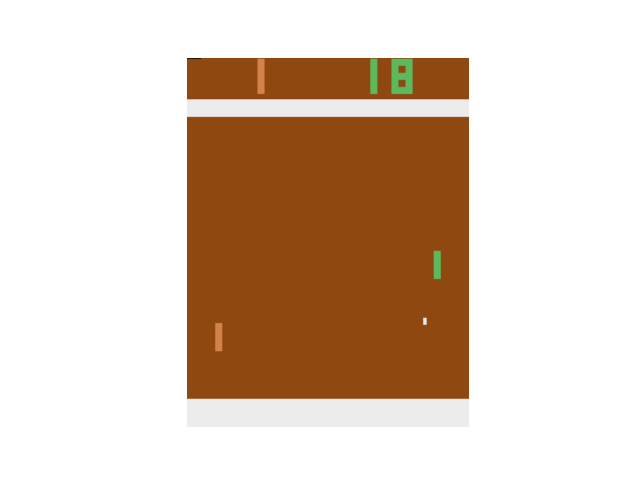
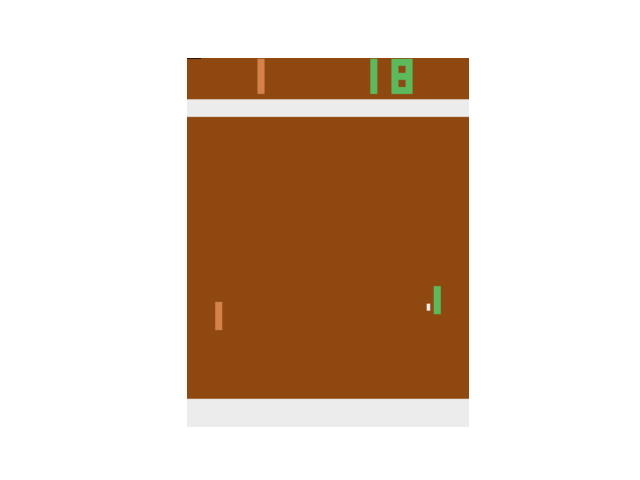
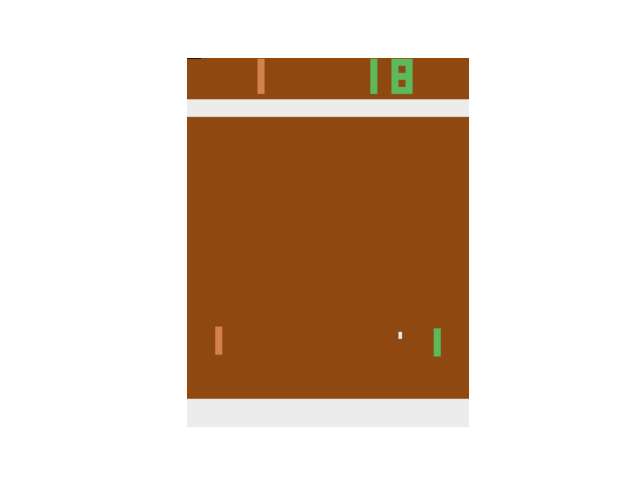
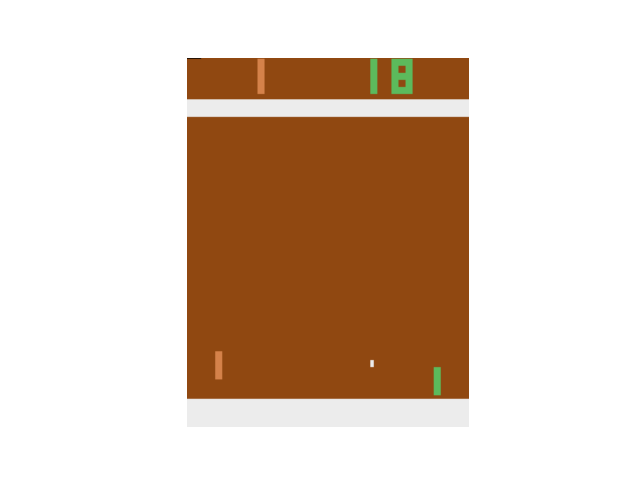
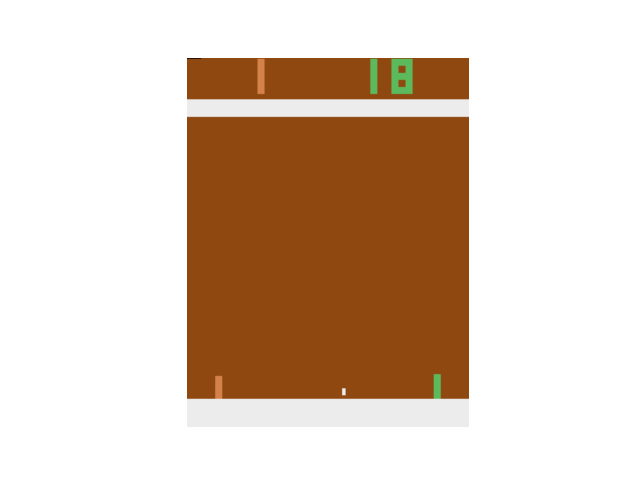
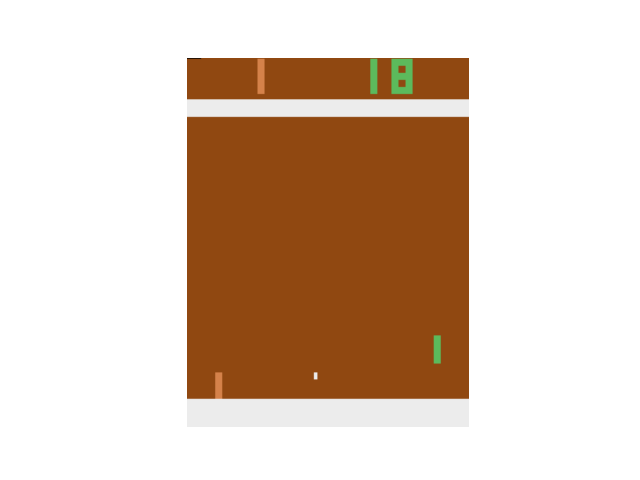
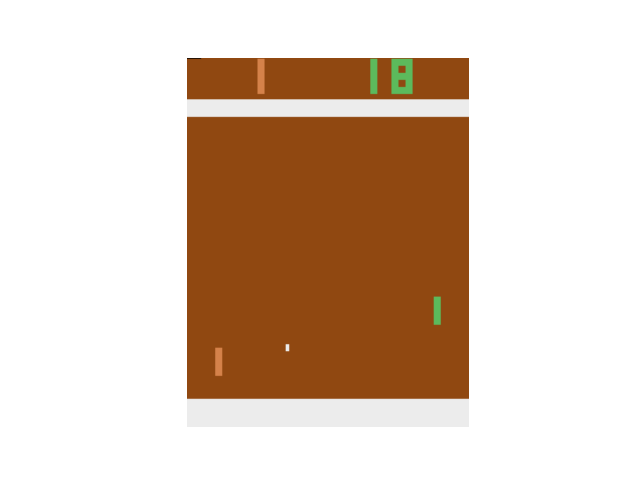
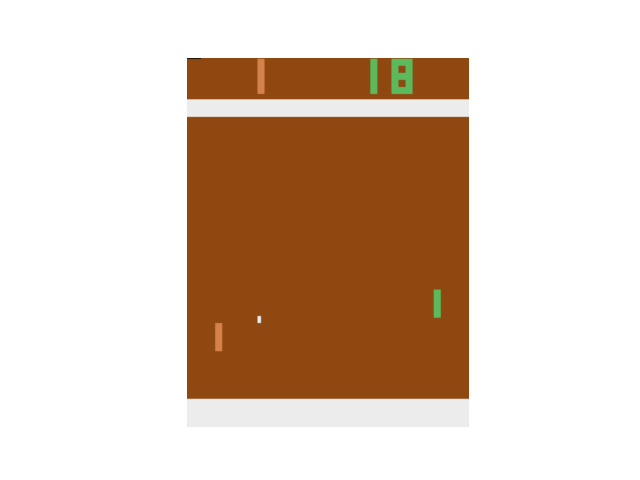
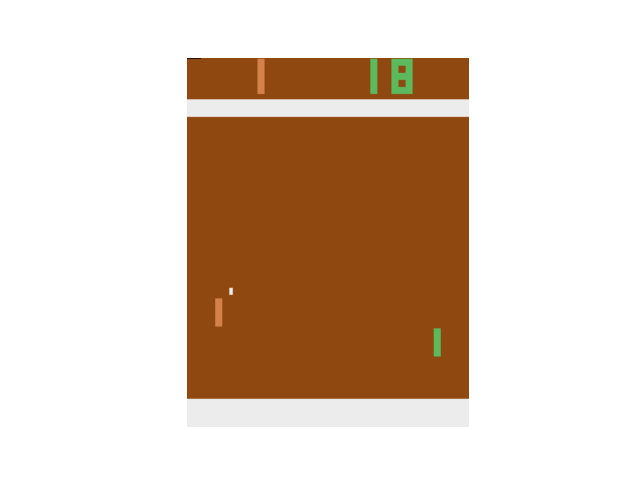
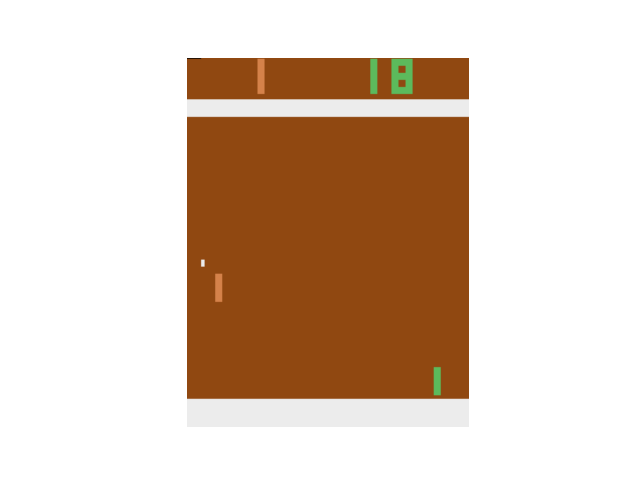
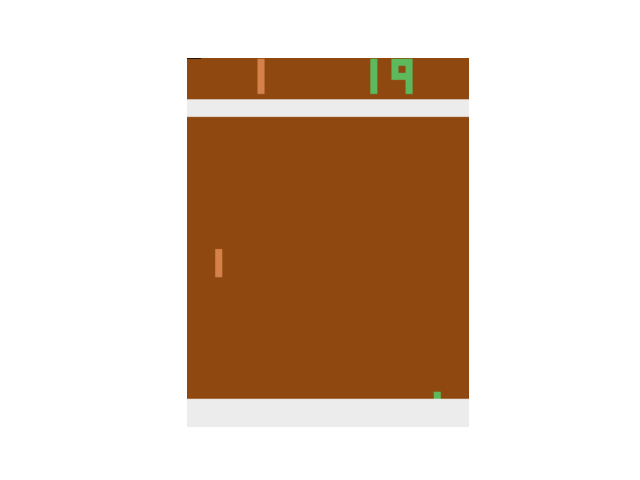
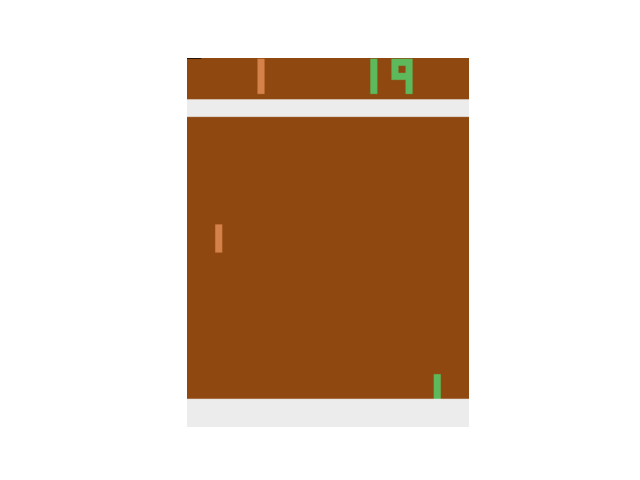
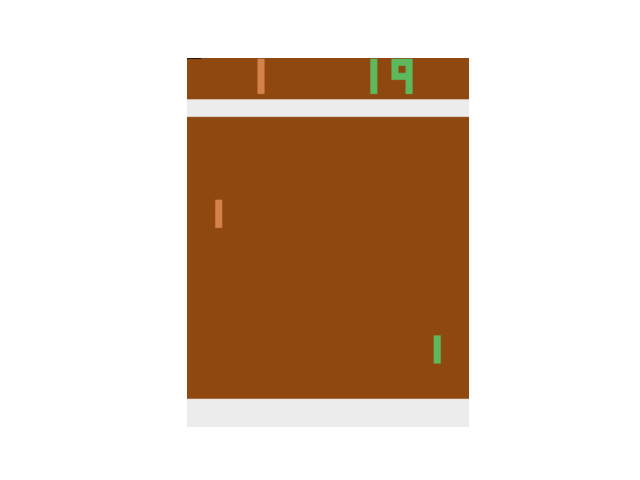
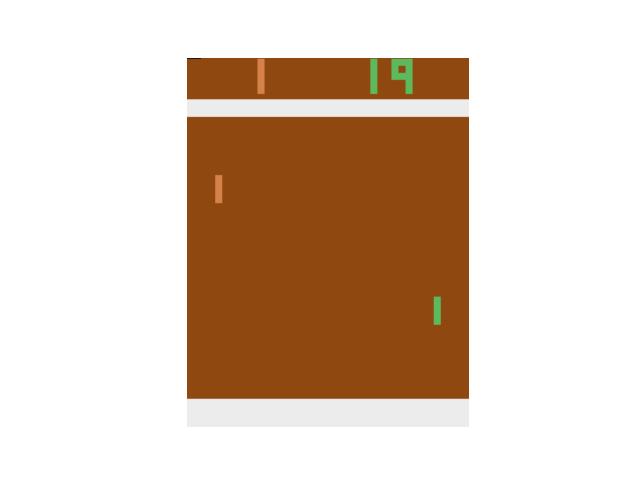
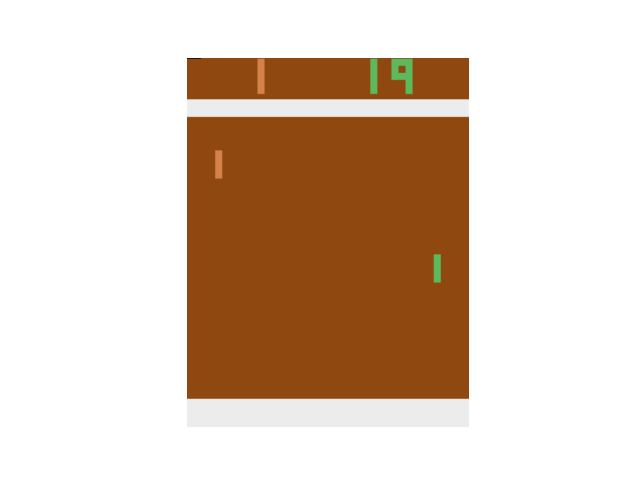
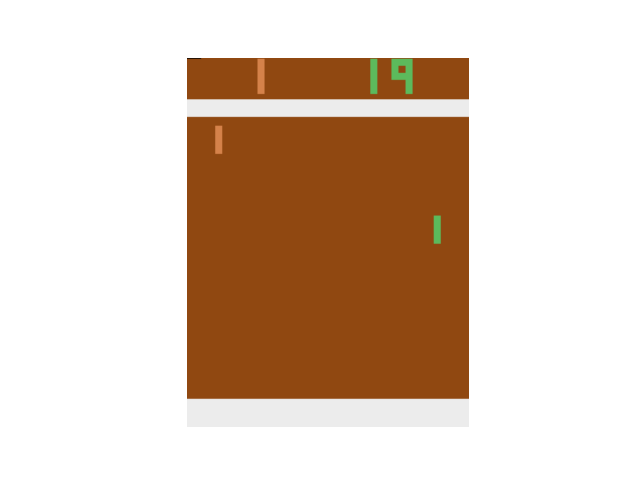
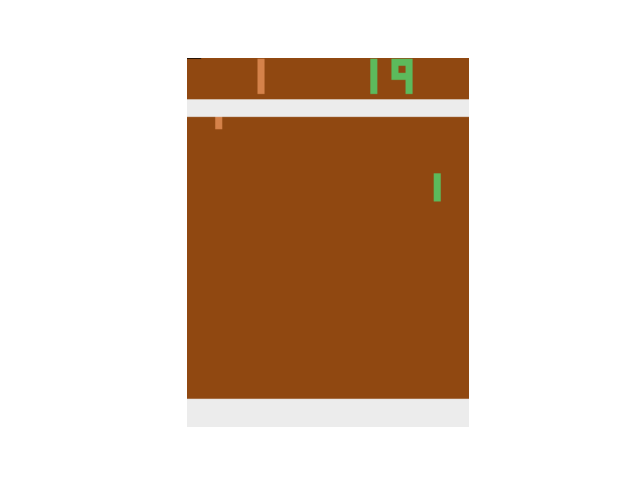
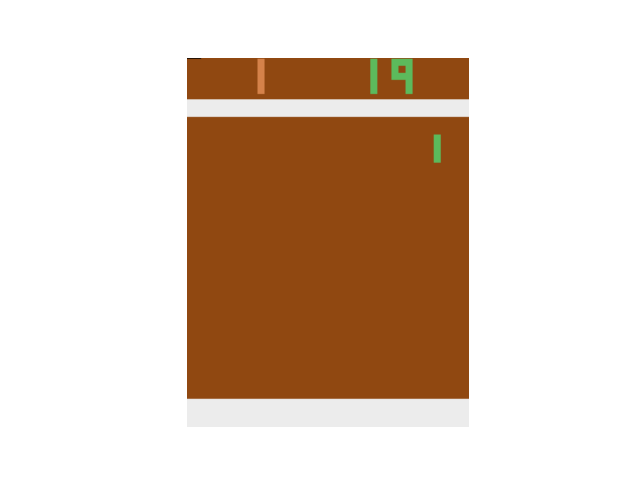
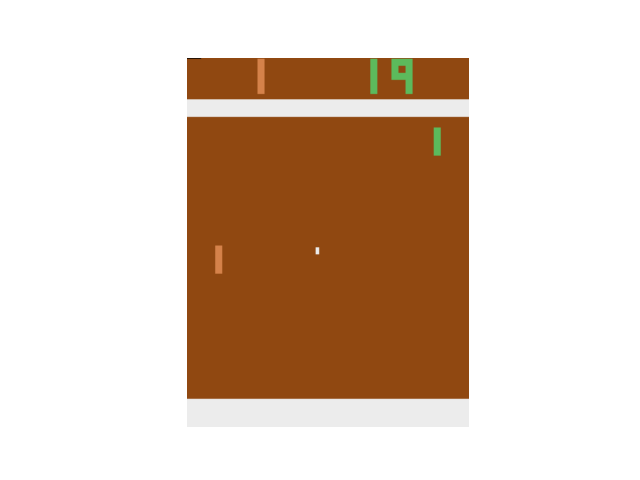
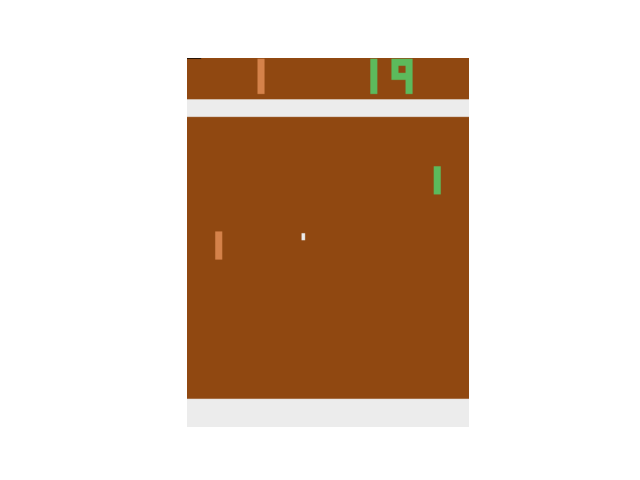
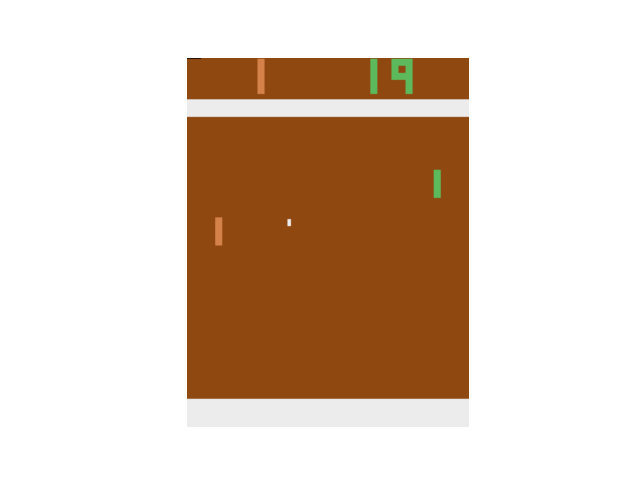
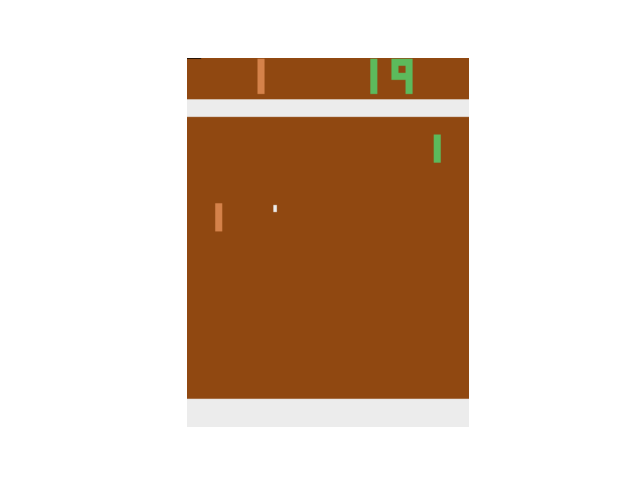
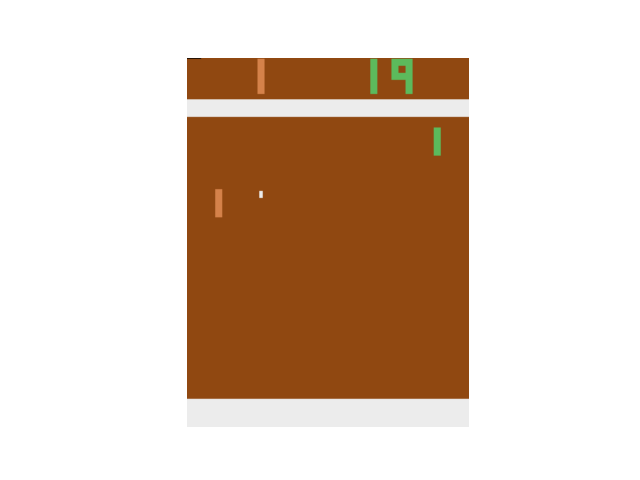
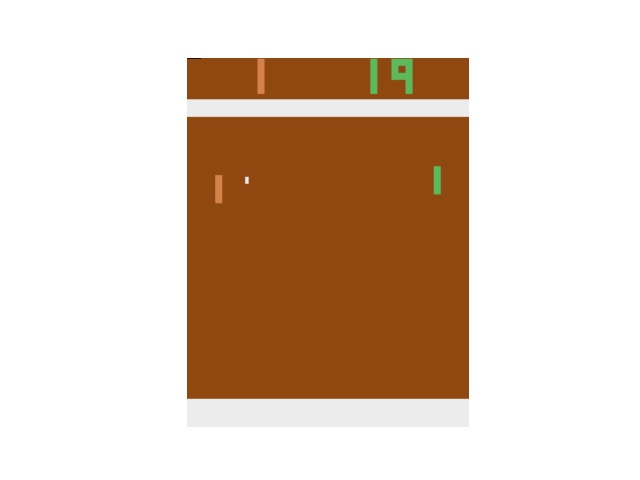
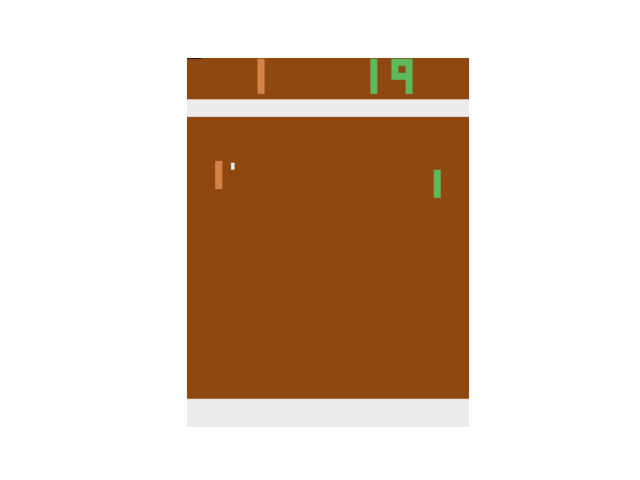
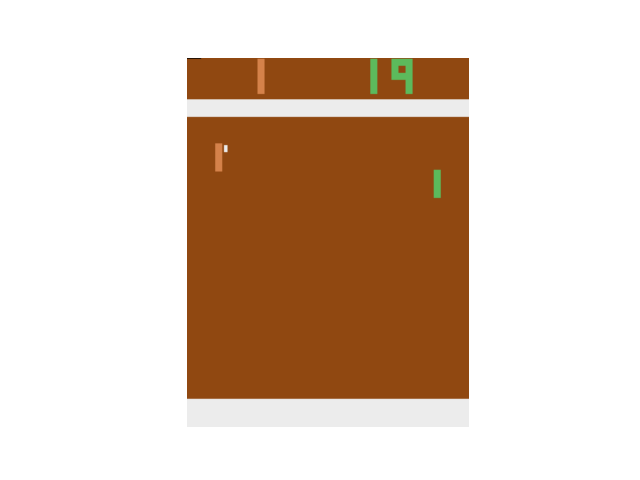
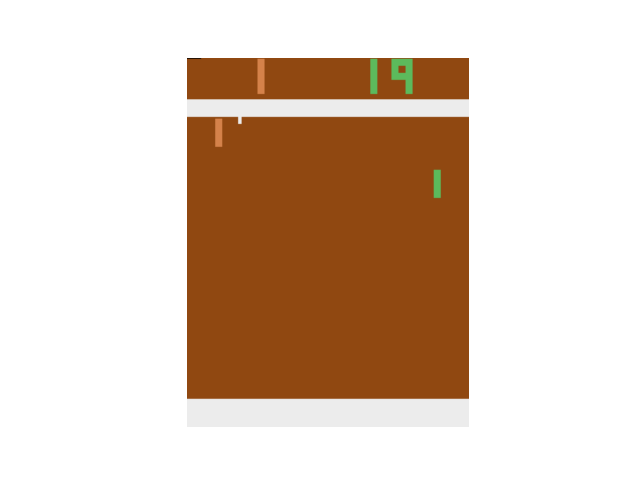
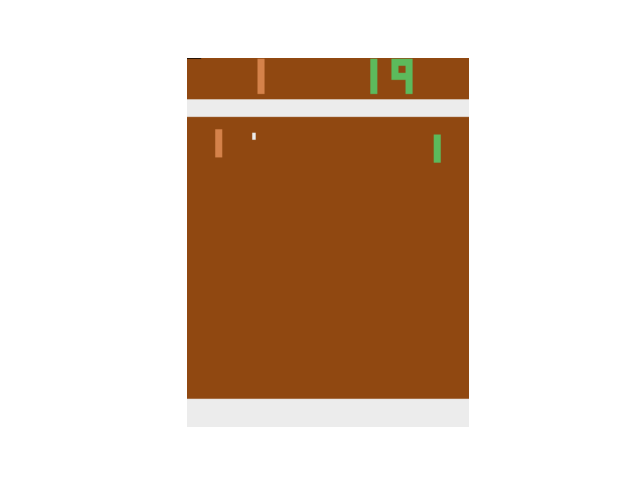
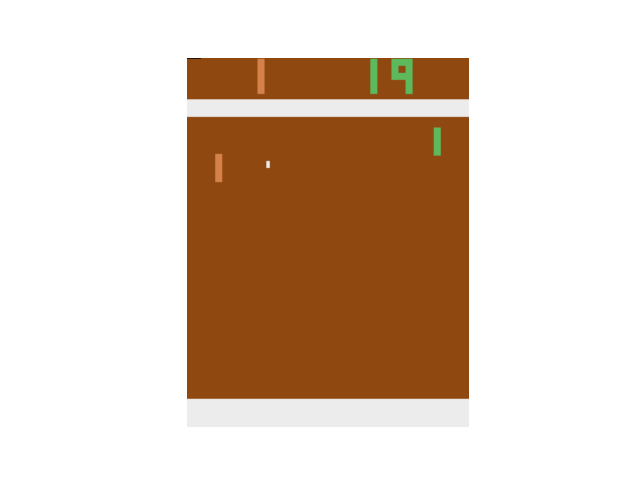
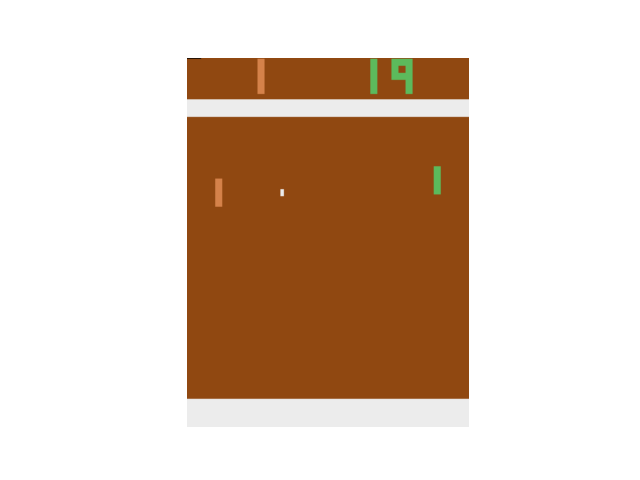
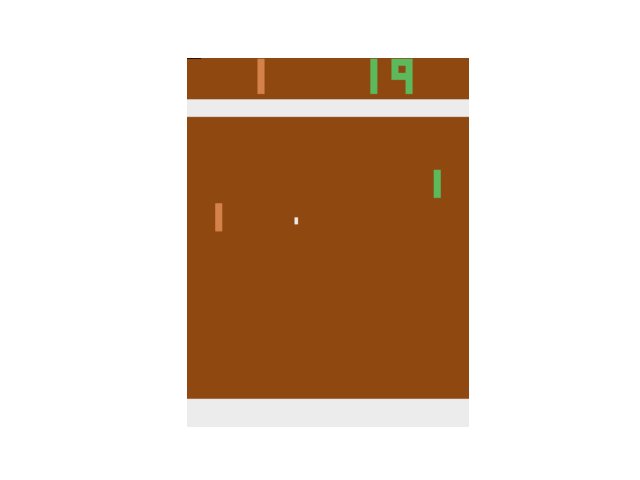
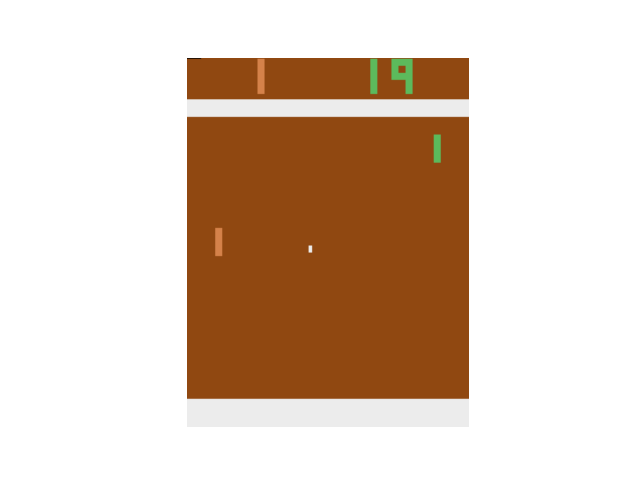
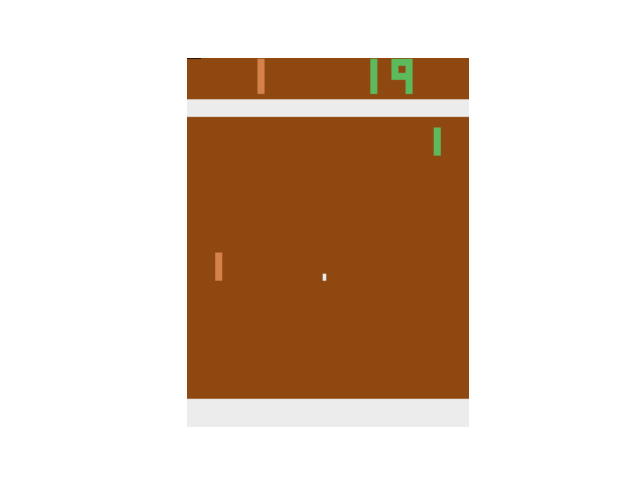
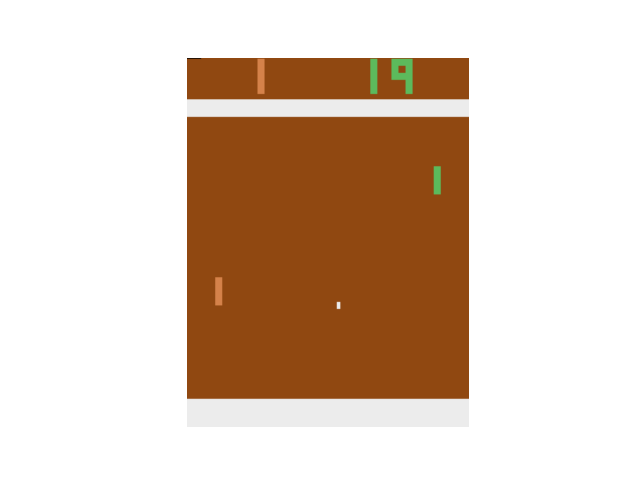
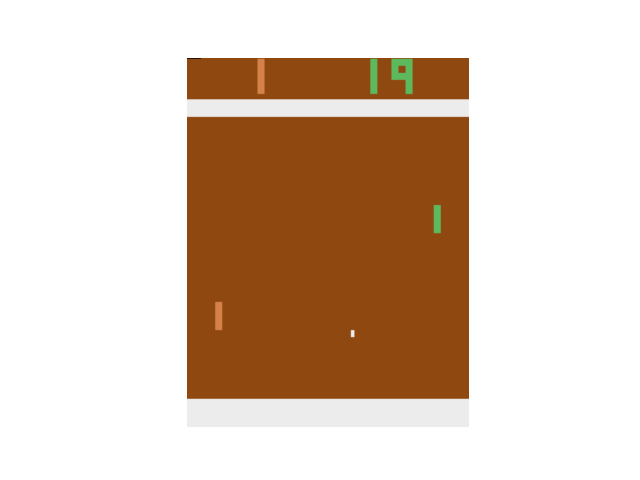
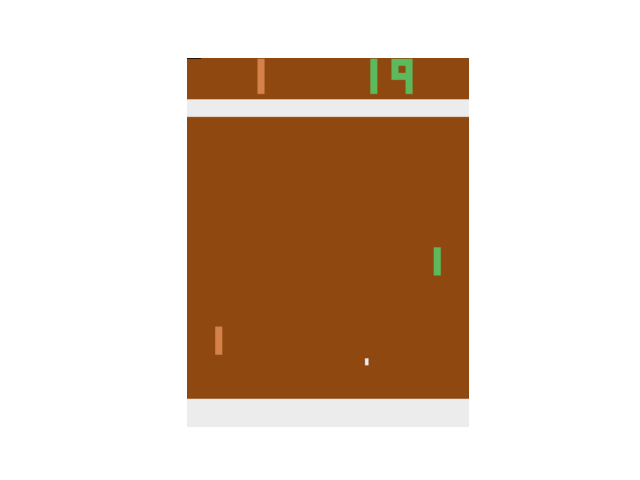
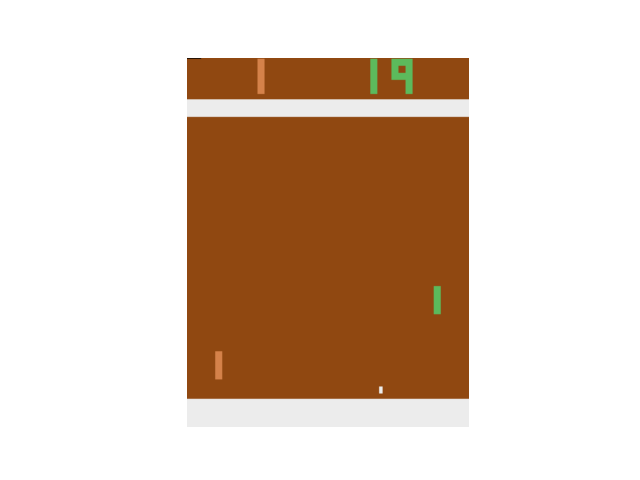
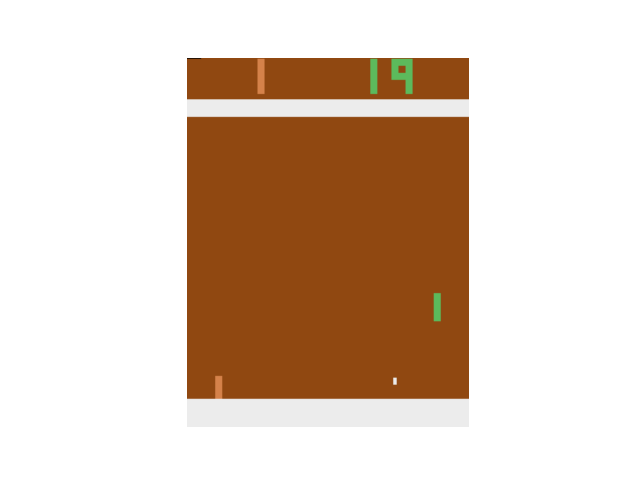
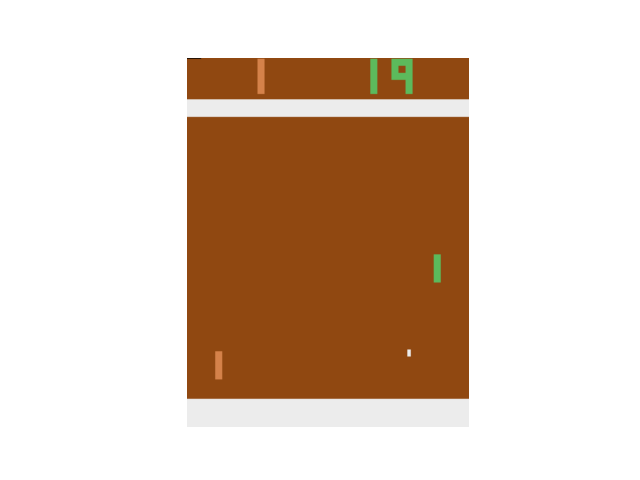
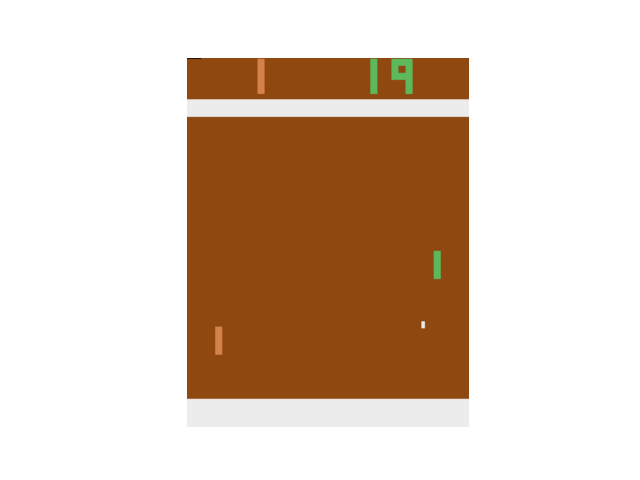
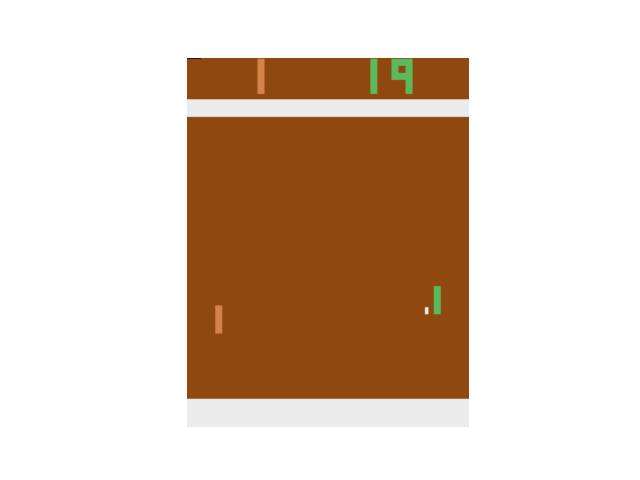
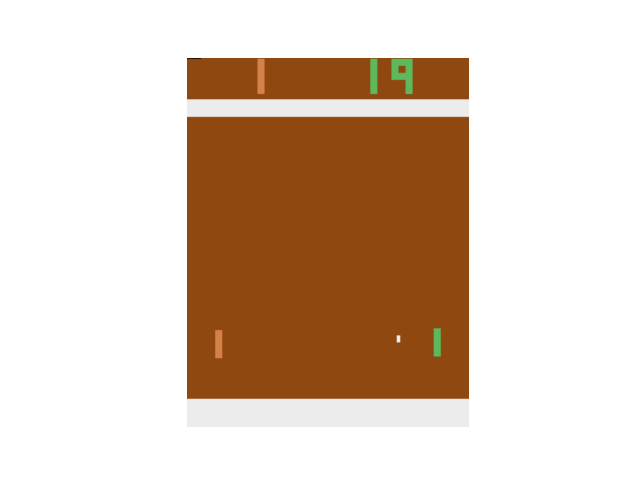
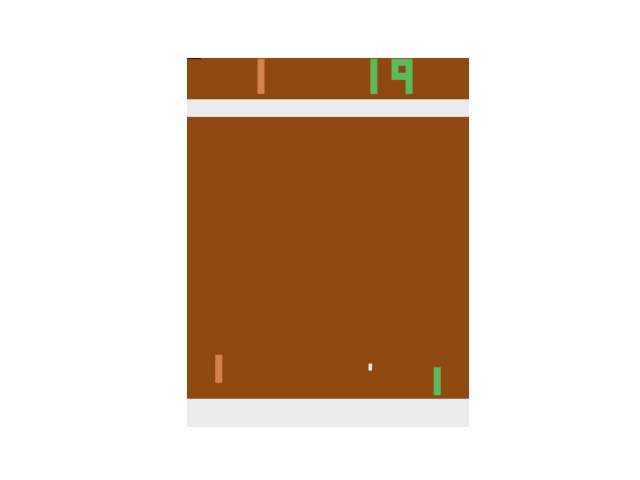
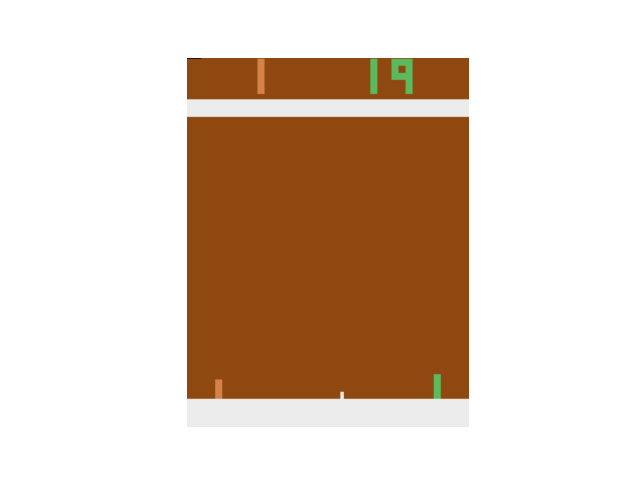
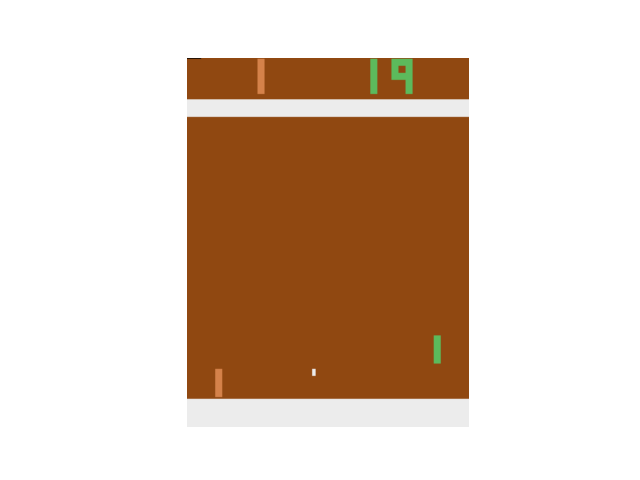
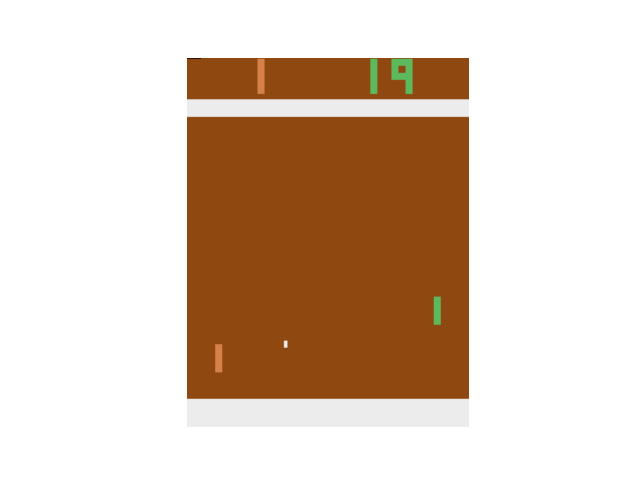
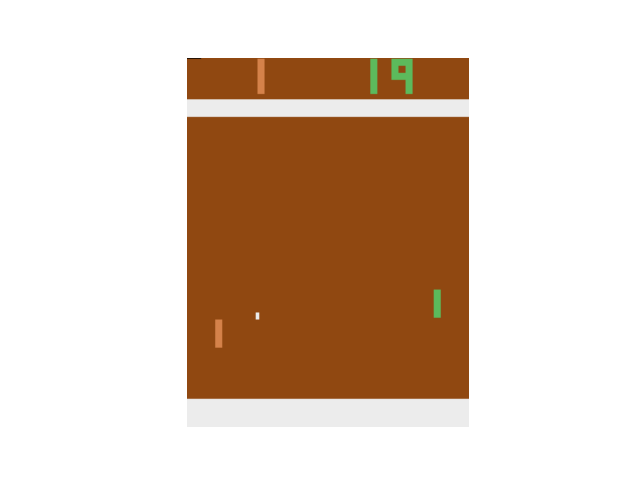
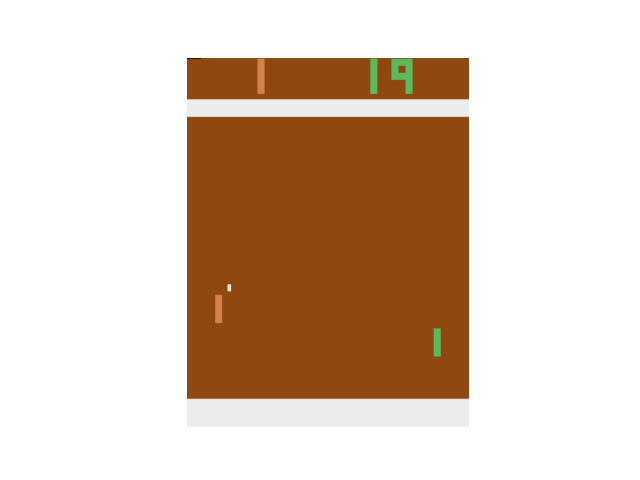
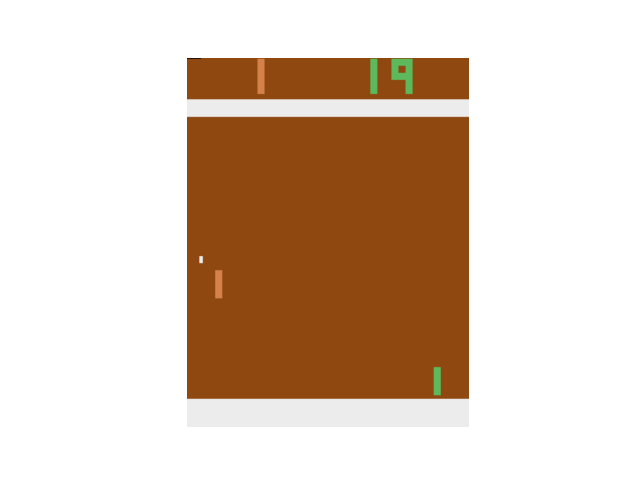
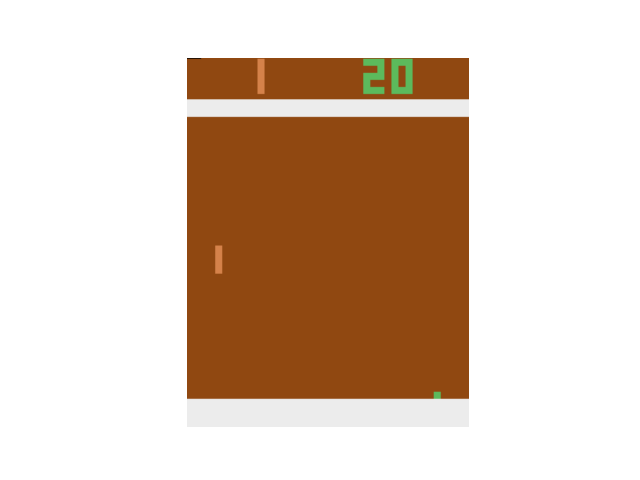
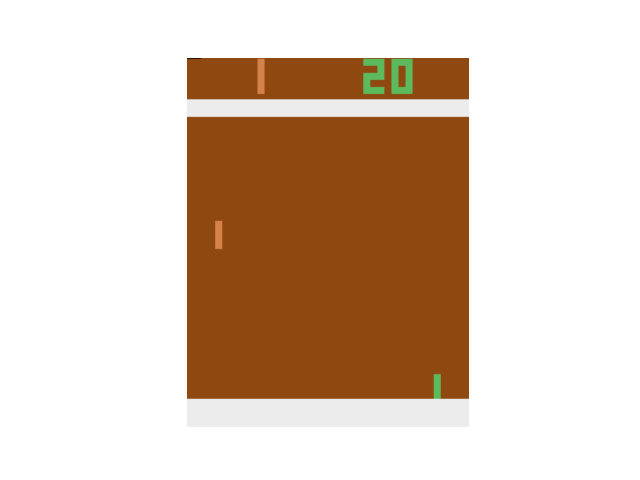
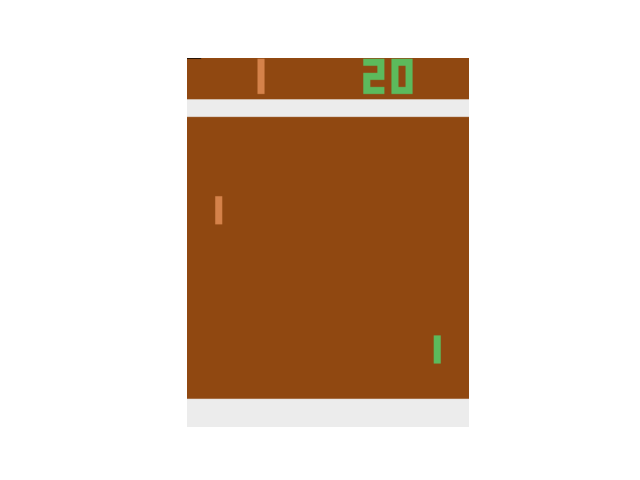
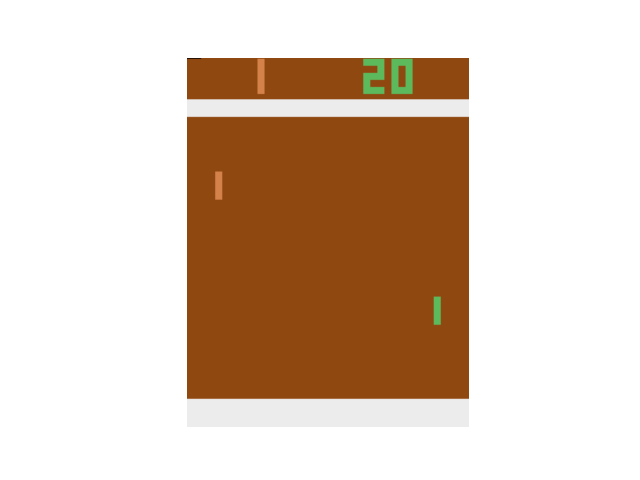
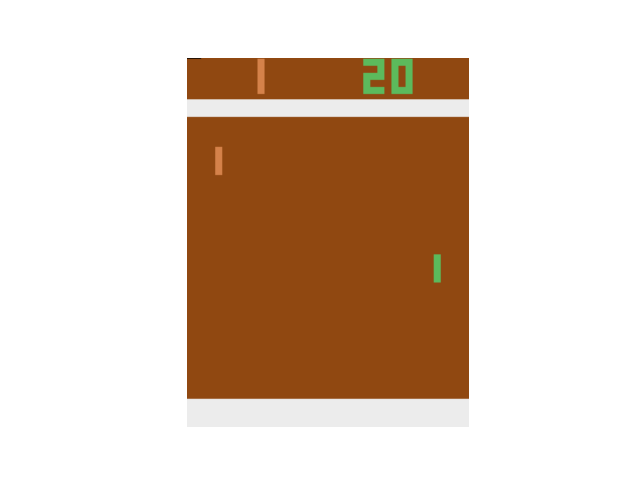
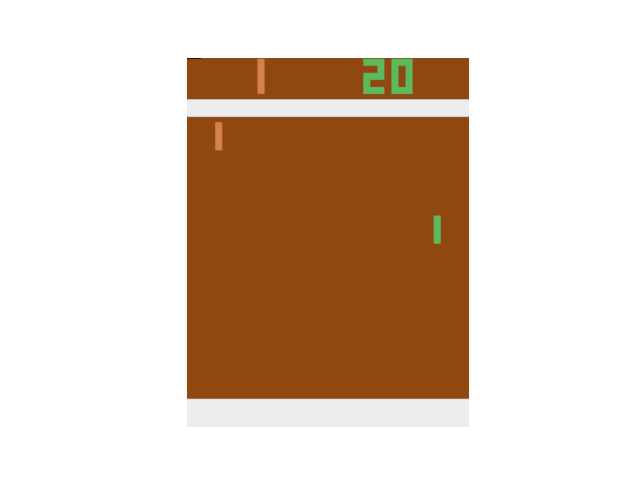
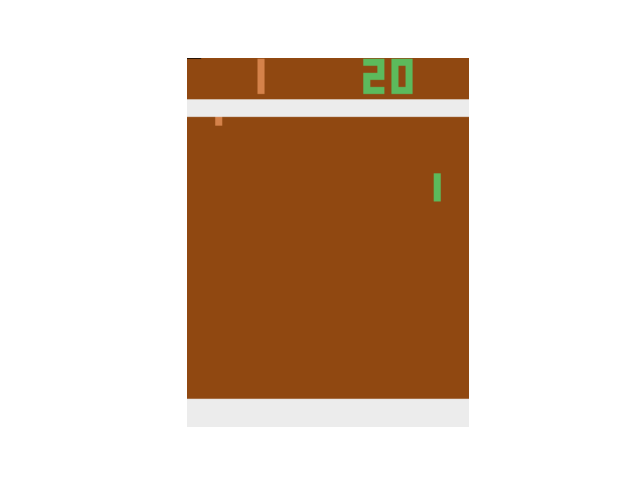
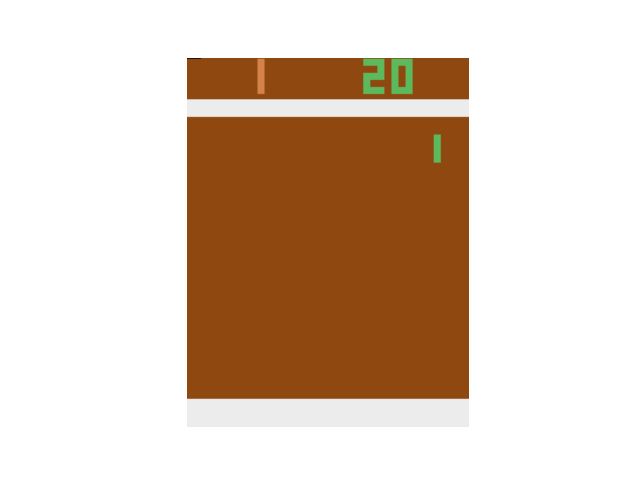
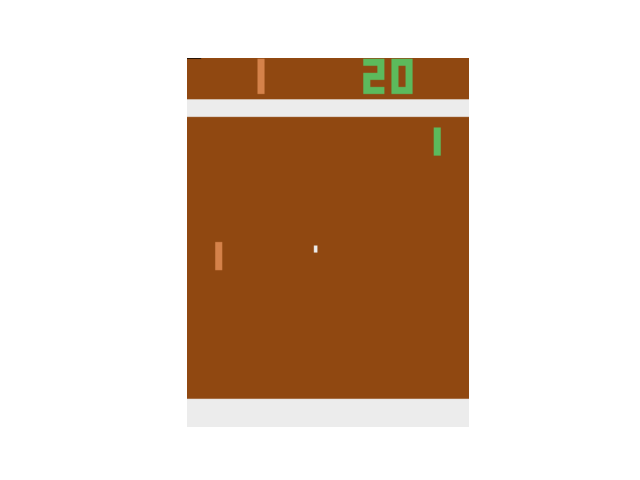
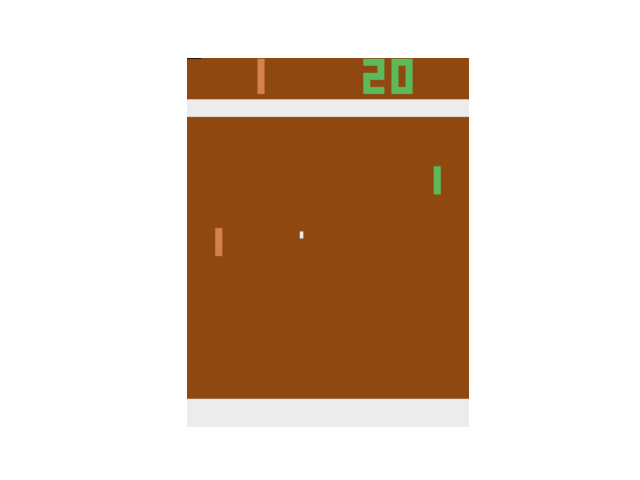
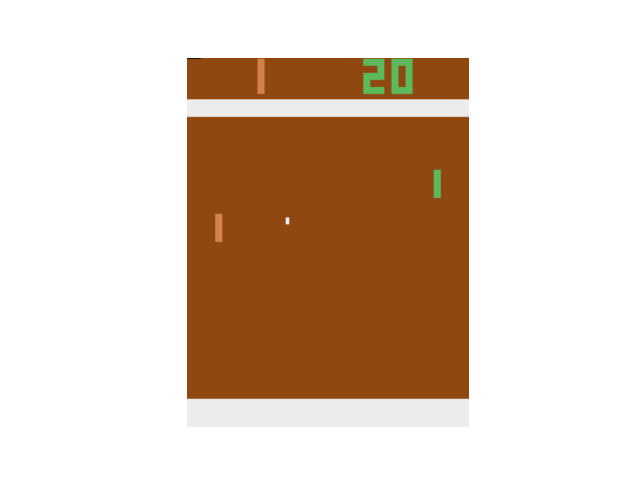
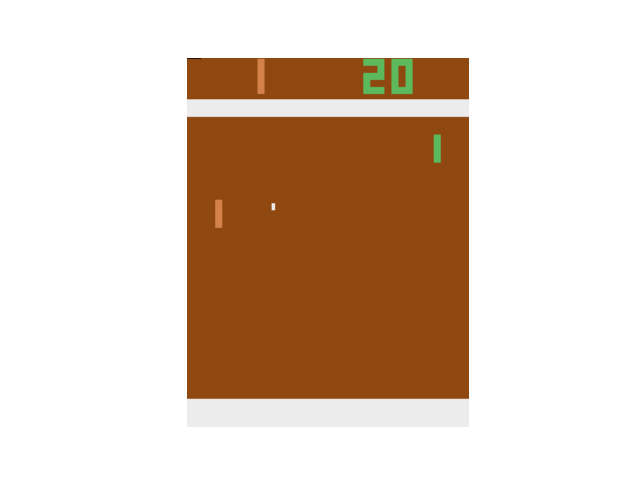
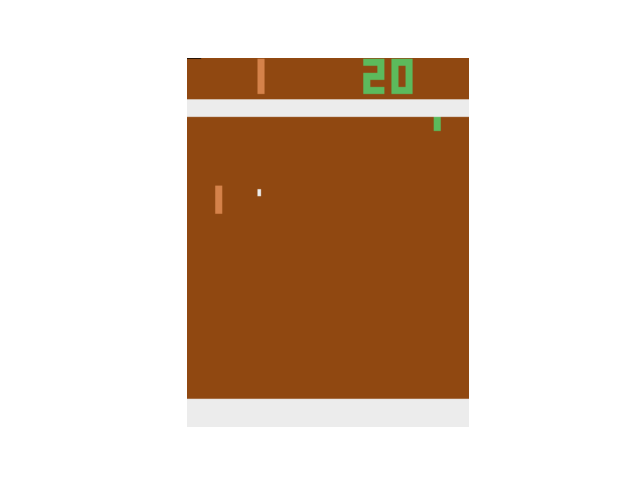
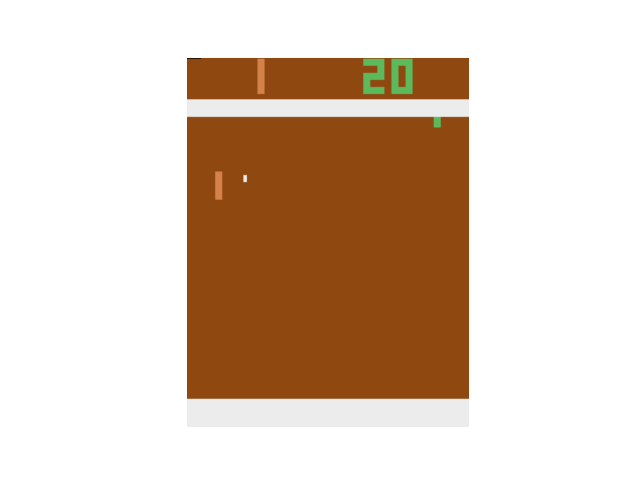
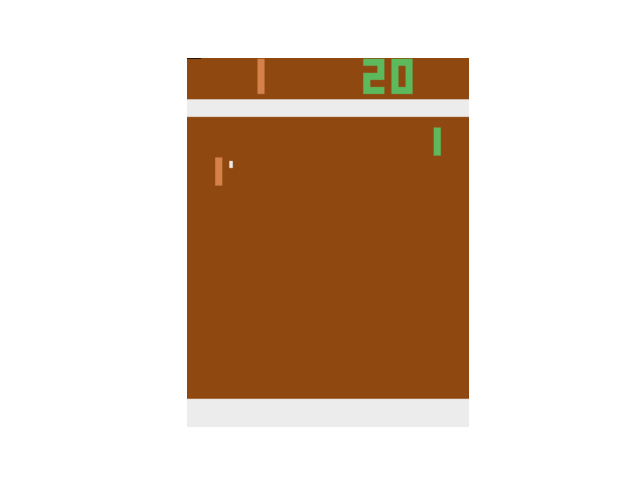
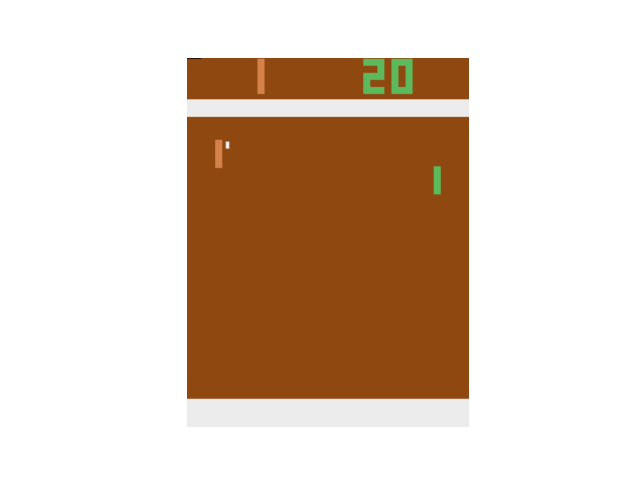
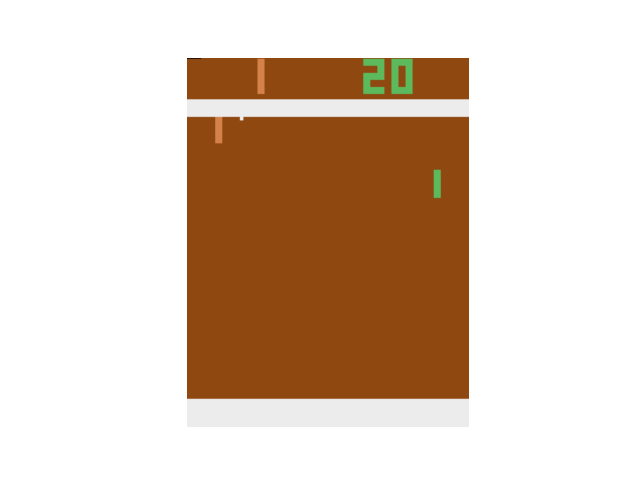
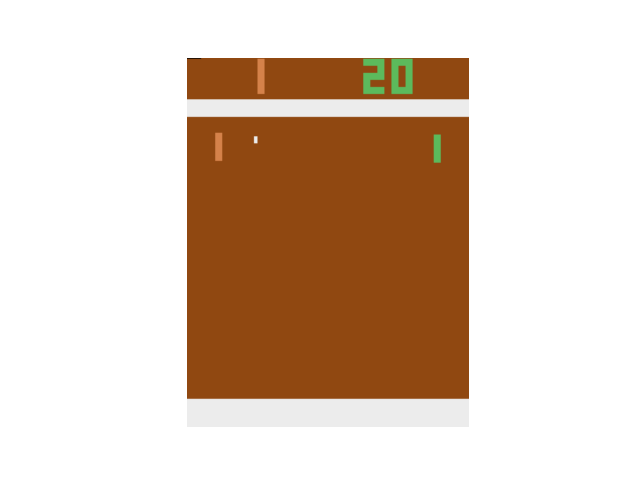
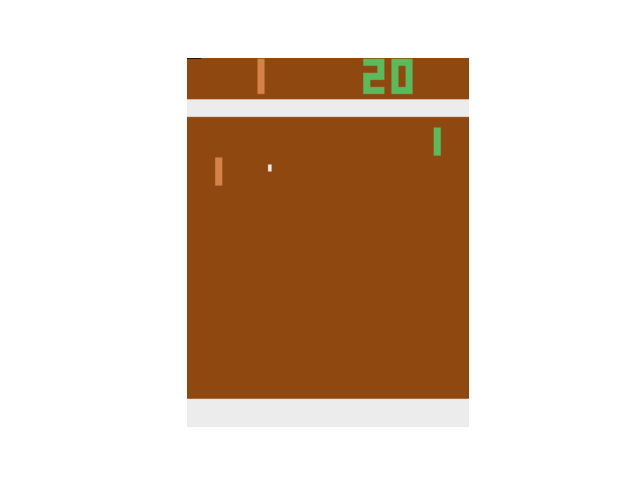
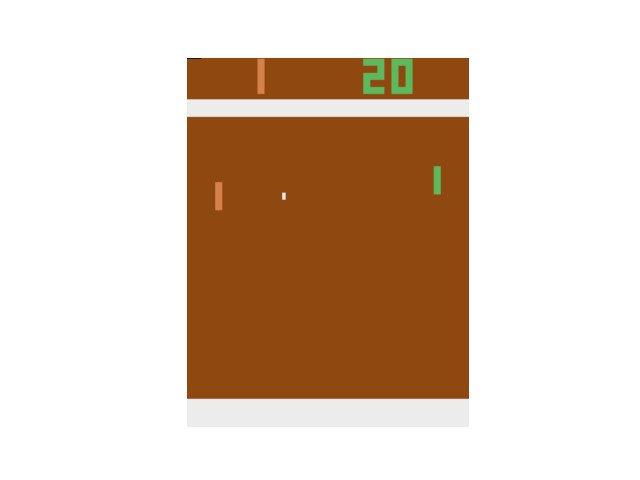
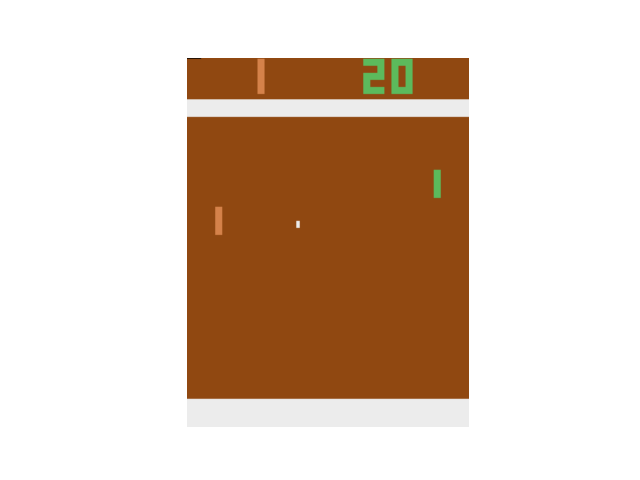
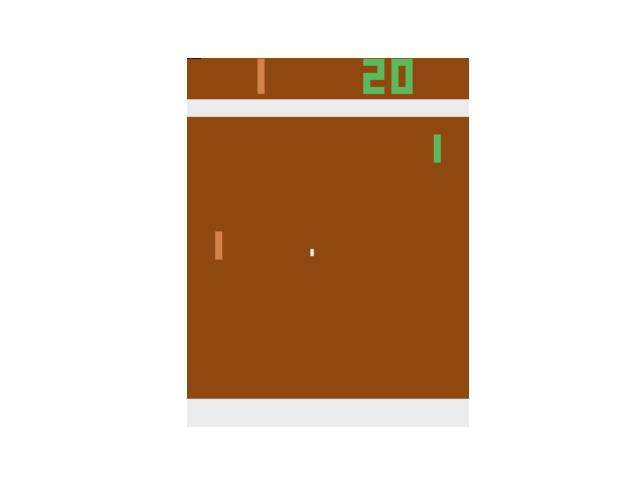
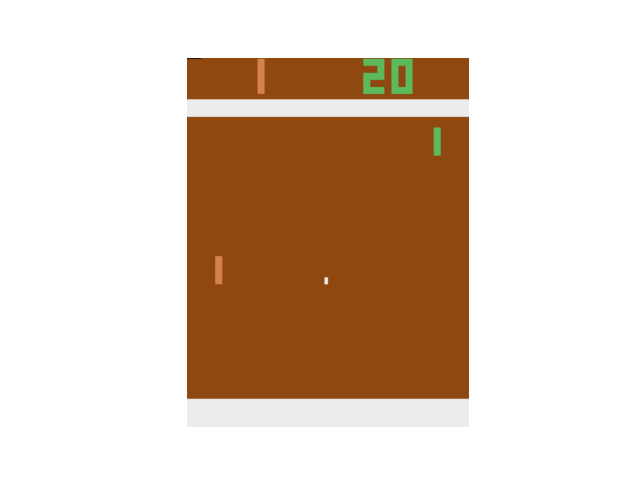
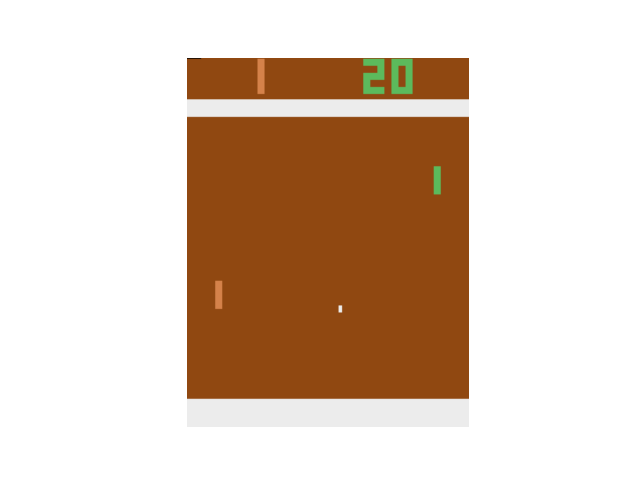
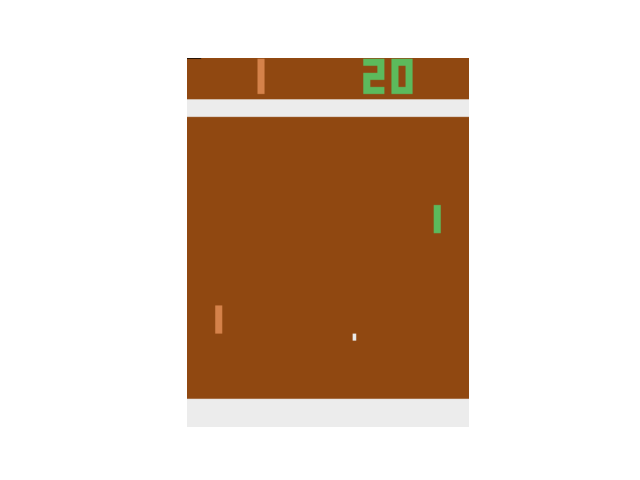
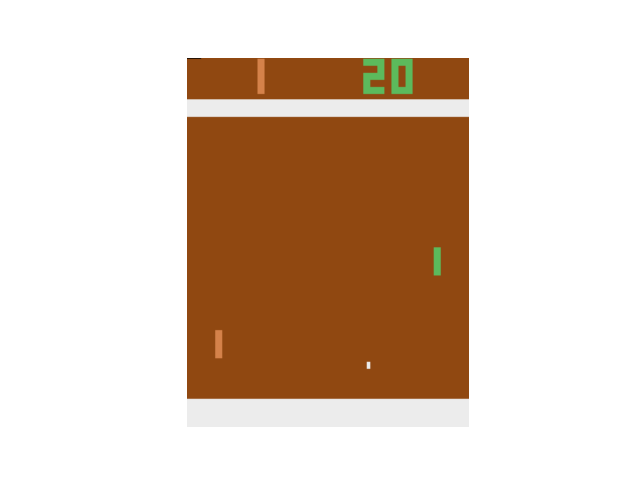
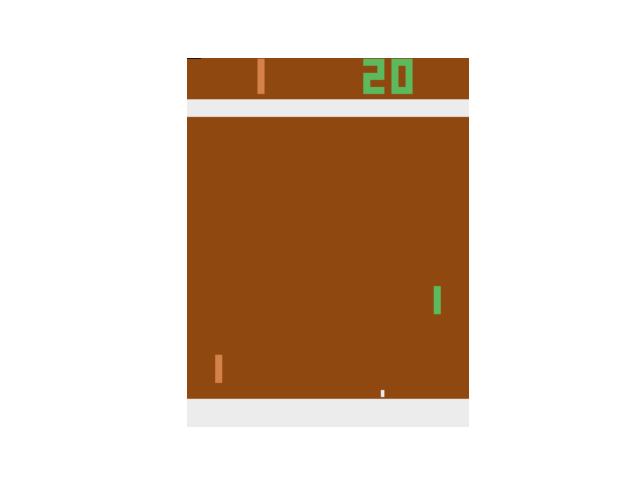
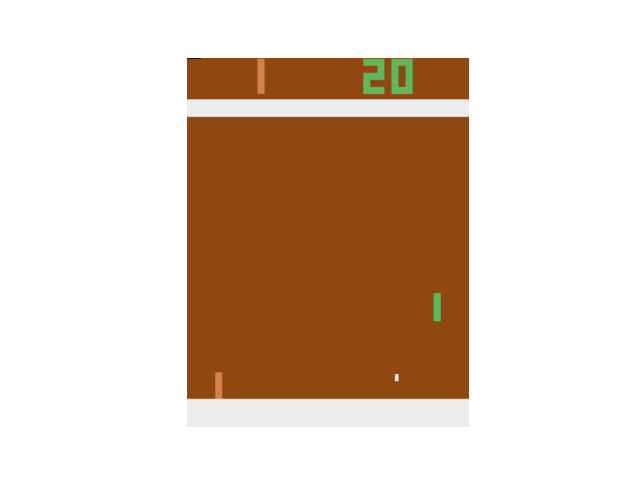
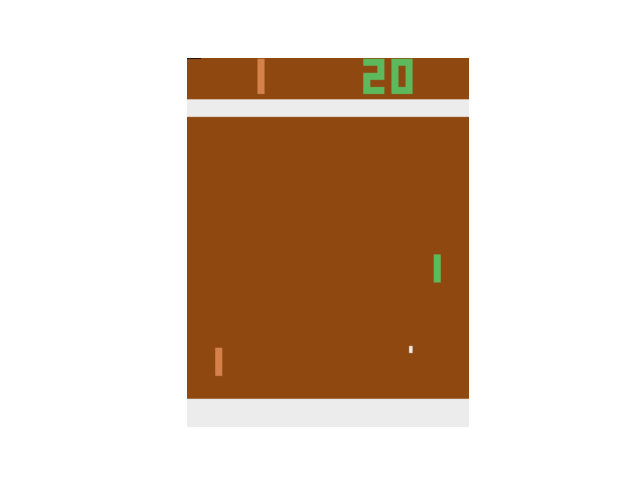
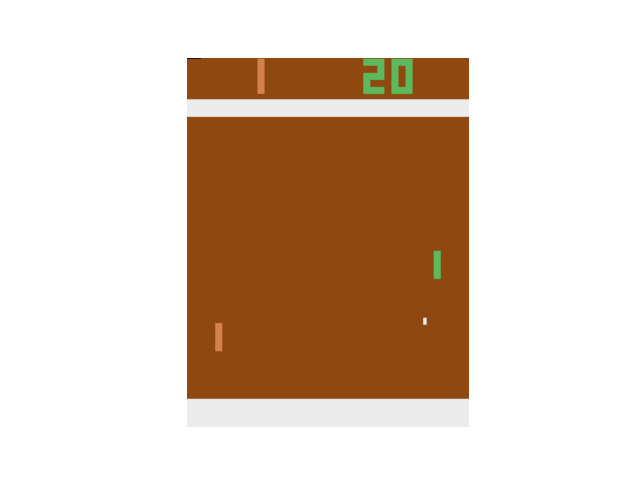
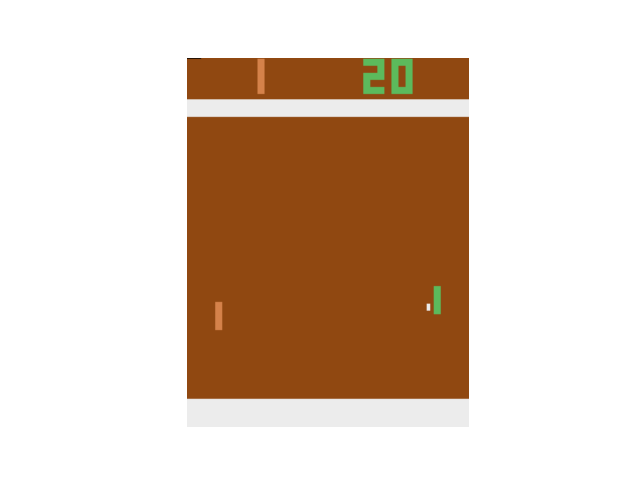
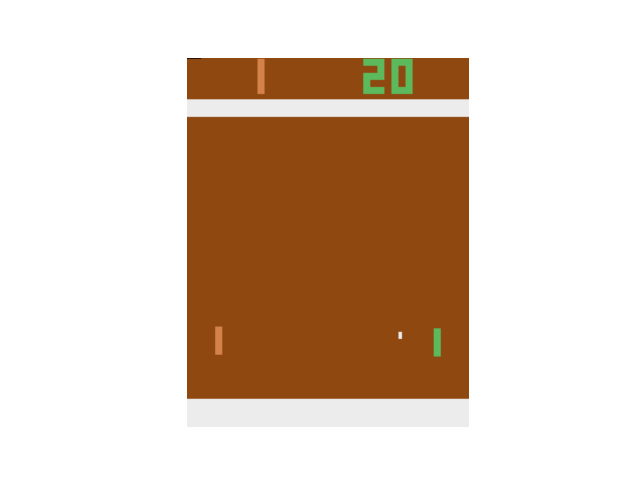
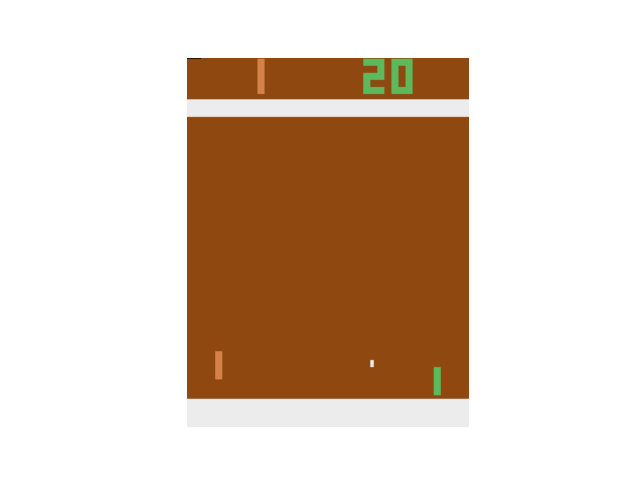
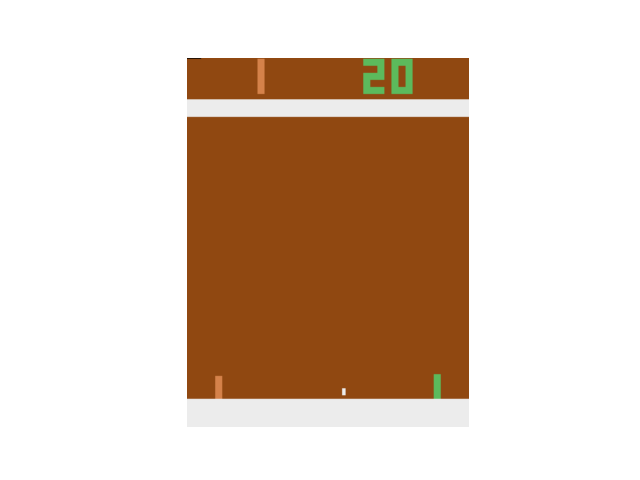
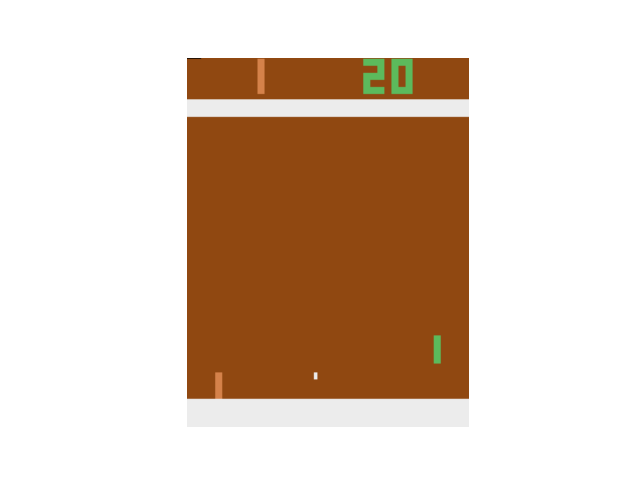
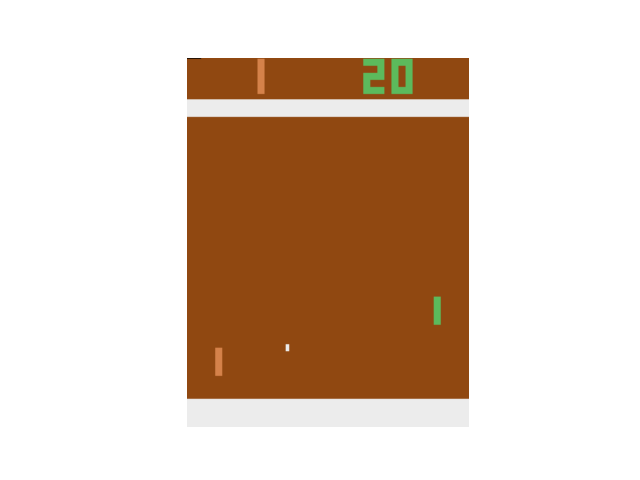
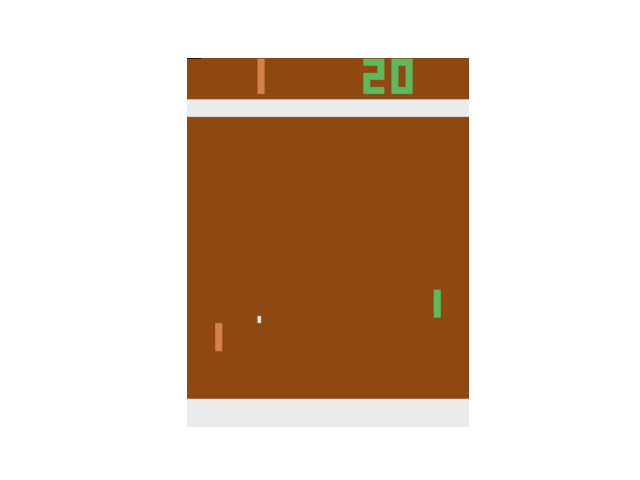
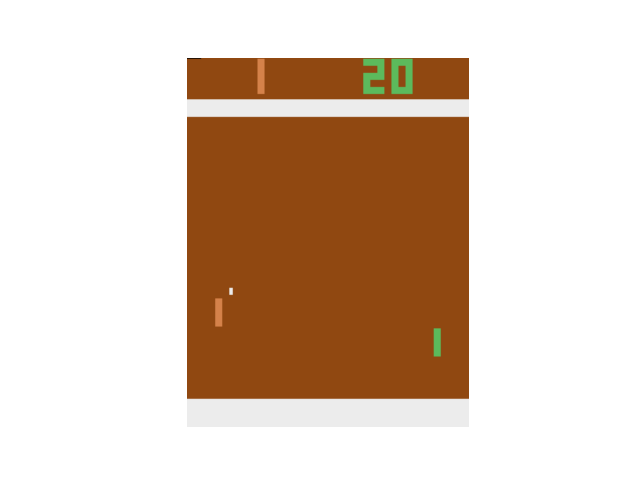
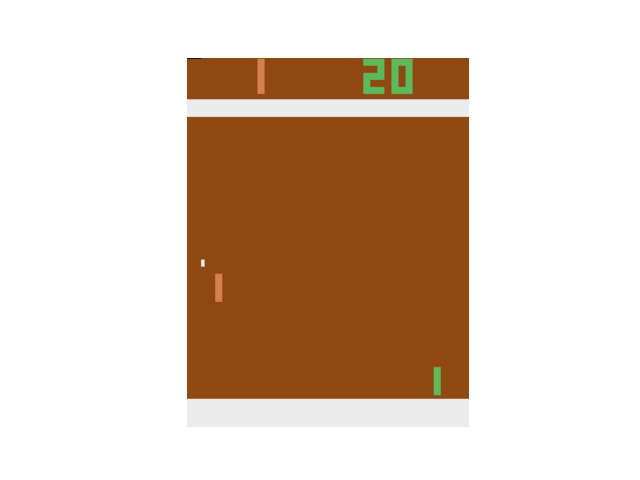
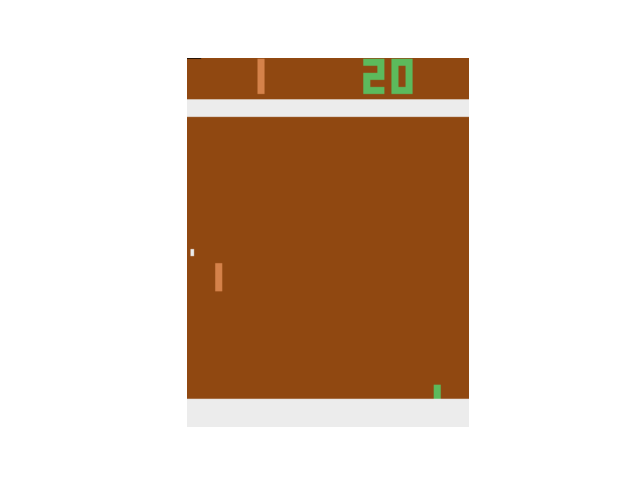

In [ ]:
%%time
import warnings
warnings.filterwarnings('ignore')
# policy = torch.load('PPO_solution.policy', map_location=torch.device('cpu')) ## solution trained policy
# policy = torch.load('20240219_e1000_PPO.policy', map_location=torch.device('cpu')) ## my trained weights

# try and test out the solution
# (the PPO verion can win more often than not)!
pong_utils.play(env, policy, time=2000)

# **Sending message to WhatsApp after Training** (unsuccessful, ignore this part)  

⚠️ issue unsolved: [pywhatkit `KeyError: DISPLAY`](https://github.com/Ankit404butfound/PyWhatKit/issues/313)   
⚠️ issue unsolved: [sendwhatmsg_instantly() sometimes not sending message #308](https://github.com/Ankit404butfound/PyWhatKit/issues/308)  

In [ ]:
# %%capture
# # !pip install pywhatkit
# ## Successfully installed mouseinfo-0.1.3 pyautogui-0.9.54 pygetwindow-0.0.9
# ## pymsgbox-1.0.9 pyrect-0.2.0 pyscreeze-0.1.30 python3-Xlib-0.15 pytweening-1.1.0
# # pywhatkit-5.4 wikipedia-1.4.0
# !git clone https://github.com/Ankit404butfound/PyWhatKit
# !pip install git+file:///content/PyWhatKit ## Successfully installed pywhatkit-5.4.1
# !apt-get install xvfb
# !pip install pyvirtualdisplay
# !touch /root/.Xauthority
# ## Ctrl+M. restart the session

In [ ]:
# import os
# os.environ['DISPLAY']='localhost:0'
# # print(os.environ['DISPLAY'])
# import matplotlib.pyplot as plt
# %matplotlib inline
# from pyvirtualdisplay import Display
# display = Display(visible=0, size=(3200, 2000))
# display.start()
# is_ipython = 'inline' in plt.get_backend()
# if is_ipython:
#     from IPython import display
# plt.ion();

# ## Sending to WhatsApp
# from google.colab import userdata
# my_phone_number = userdata.get('my_phone_number')
# import pywhatkit
# message = "Training is finished."
# pywhatkit.sendwhatmsg_instantly(my_phone_number, message)
# print("WhatsApp message sent!")